<a href="https://colab.research.google.com/github/mrh996/Literature-on-DNN-Verification-and-Testing/blob/master/18040671_DL_cw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Coursework 3

------------------------------------------------------

**Student Name:**  <RonghuiMu> (Student Number: <18040671> )

**Start date:** *26th March 2019*

**Due date:** *29th April 2019, 09:00 am *

------------------------------------------------------


## How to Submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_DL_cw3.ipynb** before the deadline above.

Please produce a **pdf** with all the **results** (tables and plots) as well as the **answers** to the questions below. For this assignment, you don't need to include any of the code in the pdf, but answers to the questions should be self-contained and should not rely on a code reference.  **Page limit: 20 pg.**

### IMPORTANT
Please make sure your submission includes **all results/answers/plots/tables** required for grading. We should not have to re-run your code.

### Credits
A special thank you to Mihaela Rosca, Shakir Mohammend and Andriy Mnih for their help in this coursework.

# Assignment Description 
(Latent Generative Models)


## Topics and optimization techniques covered: 

* Stochastic variational inference
* Amortized variational inference (VAEs)
* Improving amortized variational inference using KL annealing
* Improving amortized variational inference using constraint optimization
* Avoiding latent space distribution matching using GANs


## Tensorflow

**Note: ** Before taking on this assignment you might find it useful to take a look at the `tensorflow_probability` [package](https://www.tensorflow.org/probability), especially if you have not used probability distributions in TensorFlow before. In this assignment we will use only standard probability distribtions (like Gaussian and Bernouli), but worth taking a look on how TF handles in-graph sampling and optimizations involving distributions.

In [0]:
#@title Imports (Do not modify!)

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import tensorflow as tf

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={"lines.linewidth": 2.8}, font_scale=2)
sns.set_style("whitegrid")

# Tensorflow probability utilities
import tensorflow_probability as tfp

tfd = tfp.distributions

import warnings
warnings.filterwarnings('ignore')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
#@title Check you're using the GPU (Expand me for instructions)
# Don't forget to select GPU runtime environment in Runtime -> Change runtime type
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Helper Functions for visualisation


In [0]:
def gallery(array, ncols=10, rescale=False):
    """Data visualization code."""
    if rescale:
      array = (array + 1.) / 2
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

In [0]:
def show_digits(axis, digits, title=''):
  axis.axis('off')
  ncols = int(np.sqrt(digits.shape[0]))
  axis.imshow(gallery(digits, ncols=ncols).squeeze(axis=2), 
                 cmap='gray')
  axis.set_title(title, fontsize=15)

In [0]:
def show_latent_interpolations(generator, prior, session):
  a = np.linspace(0.0, 1.0, BATCH_SIZE)
  a = np.expand_dims(a, axis=1)

  first_latents = prior.sample()[0]
  second_latents = prior.sample()[0]

  # To ensure that the interpolation is still likely under the Gaussian prior,
  # we use Gaussian interpolation - rather than linear interpolation.
  interpolations =  np.sqrt(a) * first_latents + np.sqrt(1 - a) * second_latents

  ncols = int(np.sqrt(BATCH_SIZE))
  samples_from_interpolations = generator(interpolations)
  samples_from_interpolations_np = sess.run(samples_from_interpolations)
  plt.gray()
  axis = plt.gca()
  show_digits(
     axis, samples_from_interpolations_np, title='Latent space interpolations')

## Hyperparameters (Do not modify!)
These were chosen to work across all models you are going to be training. At times you will need to explore other configuration to answer the questions, but keep this as default -- things should train nicely under these parameters! Check your model and gradients if that is not the case! 

In [0]:
tf.reset_default_graph()

In [0]:
BATCH_SIZE = 64
NUM_LATENTS = 10
TRAINING_STEPS = 10000

## The Data

### Handwritten Digit Recognition Dataset (MNIST)


We will be revisiting the [MNIST digit dataset](https://yann.lecun.com/exdb/mnist/) for this assignment. The setup/processing of the data will be a bit different in this assignment as for training purposes it is sometimes easier to expose the data sampling as an operation in the graph, rather than going through placeholders. This is in general a very useful way of handling data in tensorflow, especially for larger training regimes where 'stepping out' of the graph might be very expensive.

In the following we will walk you through how to get the data into this form. You do not need to worry about it, but it is worth making sure you understand the step, as this is something that might be useful to replicate in the future.
 


In [0]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-u

In [0]:
print(mnist.train.images.shape)
print(type(mnist.train.images))

(55000, 784)
<type 'numpy.ndarray'>


### Transform the data from numpy arrays to in graph tensors.

This allows us to use TensorFlow datasets, which ensure that a new batch from the data is being fed at each session.run. This means that we do not need to use feed_dicts to feed data to each session.

In [0]:
def make_tf_data_batch(np_data, shuffle=True):  
  # Reshape the data to image size.
  images = np_data.reshape((-1, 28, 28, 1))
  
  # Create the TF dataset.   
  dataset = tf.data.Dataset.from_tensor_slices(images)
  
  # Shuffle and repeat the dataset for training.
  # This is required because we want to do multiple passes through the entire
  # dataset when training.
  if shuffle:
    dataset = dataset.shuffle(100000).repeat()
    
  # Batch the data and return the data batch.
  one_shot_iterator = dataset.batch(BATCH_SIZE).make_one_shot_iterator()
  data_batch = one_shot_iterator.get_next()
  return data_batch

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
print(real_data.shape)

(?, 28, 28, 1)


# Part 1: Latent Variable models and Variational Inference



## T1.1 Stochastic Variational Inference

In this first task we will consider a simple latent variable model $z \rightarrow x$. Your task is to use stochastic variational inference to train a generative model on the MNIST data. For each data point $x_i$, there is a set of variational parameters to be learned. Throughout this assessment, the posterior and the prior will be Normal random variables, with uncorrelated dimensions.


Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)}{\left[ \log p_\theta(x|z)\right]}  - \mathbb{E}_{p^*(x)} \left[KL(q(z|x)||p(z))\right]
\end{equation}

For more information, please check out:
 * http://www.columbia.edu/~jwp2128/Papers/HoffmanBleiWangPaisley2013.pdf

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In the following, I am going to walk you through implementing this model. This will only be done for the first task, but you can use this to structure your code for all of the tasks after this. Also worth taking a look at question 1 at the end of this section before finishing the implementation - this should give you exactly what you have to implement in the update operations and training loop.

### Data variable

We will do multiple session.run to update the variational parameters for one data batch.
To ensure that the same batch is used, we define a variable for the data, and update it after updating the decoder parameters.

In [0]:
data_var = tf.Variable(
      tf.ones(shape=(BATCH_SIZE, 28, 28, 1), dtype=tf.float32), 
      trainable=False)

data_assign_op = tf.assign(data_var, real_data)

Instructions for updating:
Colocations handled automatically by placer.


### Define the decoder

In [0]:
DECODER_VARIABLE_SCOPE = "decoder"

In [0]:
def standard_decoder(z):
  with tf.variable_scope(DECODER_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = tf.layers.dense(z, 7 * 7 * 64, activation=tf.nn.relu)
    h = tf.reshape(h, shape=[BATCH_SIZE, 7, 7, 64])
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=1,
          kernel_size=5,
          strides=2,
          activation=None,  # Do not activate the last layer.
          padding='same')(h)
    return tfd.Independent(tf.distributions.Bernoulli(h))

In [0]:
decoder = standard_decoder

### Define prior

In [0]:
def multi_normal(loc, log_scale):
  # We model the latent variables as independent
  return tfd.Independent(
      distribution=tfd.Normal(loc=loc, scale=tf.exp(log_scale)),
      reinterpreted_batch_ndims=1)
      
def make_prior():
  # Zero mean, unit variance prior.
  prior_mean = tf.zeros(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32)
  prior_log_scale = tf.zeros(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32)

  return multi_normal(prior_mean, prior_log_scale)

In [0]:
prior = make_prior()

### Define variational posterior $q(z|x)$

Define this to be a multi-dimensional Gaussian distribution. You can use the helper function above for this, but keep in mind the parameters of this distribution (mean and variance) ought to be trained.

In [0]:
# Build the variational posterior


##################

mean = tf.get_variable('mean', [BATCH_SIZE, NUM_LATENTS],dtype=tf.float32)
scale = tf.get_variable('scale', [BATCH_SIZE, NUM_LATENTS],dtype=tf.float32)

##################
variational_posterior=multi_normal(mean, scale)


### Define and build optimization objective (ELBO)

Putting things together: build the likelihood term and the KL term in the objective in (T1.1) description. 

In [0]:
def bound_terms(data_batch, variational_posterior, decoder_fn):

  ##################
  dist=decoder_fn(variational_posterior.sample())
  likelihood_term= dist.log_prob(data_batch)
  ##################
  
  # Reduce mean over the batch dimensions
  likelihood_term = tf.reduce_mean(likelihood_term)

  ##################
  # YOUR CODE HERE #
  ##################
  kl_term=tfd.kl_divergence(variational_posterior, prior)
  # Reduce over the batch dimension.
  kl_term = tf.reduce_mean(kl_term)
  
  # Return the terms in the optimization objective in (1.1) description
  return likelihood_term, kl_term

In [0]:
# Maximize the data likelihodd and minimize the KL divergence between the prior and posterior
likelihood_term, kl_term = bound_terms(data_var, variational_posterior, decoder)
train_elbo = likelihood_term - kl_term

##################

##################
loss = -train_elbo

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


### Build the update operations for the variational and global variables

In [0]:
# Variational variable optimizer
variational_vars_optimizer = tf.train.GradientDescentOptimizer(0.05)

##################
# YOUR CODE HERE #
##################


variational_vars =[mean,scale]
# Just to check
print('Variational vars" {}'.format(variational_vars))
variational_vars_update_op = variational_vars_optimizer.minimize(
      loss, var_list=variational_vars)


# Decoder optimizer
decoder_optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)
decoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
print('Decoder vars" {}'.format(decoder_vars))
decoder_update_op = decoder_optimizer.minimize(loss, var_list=decoder_vars)

Variational vars" [<tf.Variable 'mean:0' shape=(64, 10) dtype=float32_ref>, <tf.Variable 'scale:0' shape=(64, 10) dtype=float32_ref>]
Instructions for updating:
Use tf.cast instead.
Decoder vars" [<tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>, <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose_1/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose_1/bias:0' shape=(1,) dtype=float32_ref>]


In [0]:
# Check trainable variables
tf.trainable_variables()

[<tf.Variable 'mean:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'scale:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose/kernel:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose_1/kernel:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose_1/bias:0' shape=(1,) dtype=float32_ref>]

### Training loop

In [0]:
# Number of SVI updates per sample
NUM_SVI_UPDATES = 10

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []

for i in xrange(TRAINING_STEPS):
  
  # Update the data batch.
  sess.run(data_assign_op)

  # Training (put things together based on the operations you've defined before)
  ##################
  # YOUR CODE HERE #
  ##################
  for j in range(NUM_SVI_UPDATES):
        sess.run(variational_vars_update_op)
  sess.run(decoder_update_op)
  # Report the loss and the kl once in a while.
  if i % 10 == 0:
    iteration_loss, iteration_kl, iteration_likelihood = sess.run(
          [loss, kl_term, likelihood_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)


Iteration 0. Loss 539.506591797. KL 0.405016303062
Iteration 10. Loss 454.091278076. KL 1.1003729105
Iteration 20. Loss 364.455963135. KL 3.55989909172
Iteration 30. Loss 327.313781738. KL 0.816091418266
Iteration 40. Loss 268.939086914. KL 1.27205014229
Iteration 50. Loss 237.73046875. KL 2.32882857323
Iteration 60. Loss 234.600082397. KL 2.86715817451
Iteration 70. Loss 220.104156494. KL 3.09700846672
Iteration 80. Loss 210.469436646. KL 2.93454933167
Iteration 90. Loss 204.75163269. KL 2.64262986183
Iteration 100. Loss 215.512176514. KL 2.46870517731
Iteration 110. Loss 215.776428223. KL 2.38556003571
Iteration 120. Loss 216.791519165. KL 2.30053925514
Iteration 130. Loss 209.381622314. KL 2.22855377197
Iteration 140. Loss 202.645629883. KL 2.16049432755
Iteration 150. Loss 212.334121704. KL 2.03245258331
Iteration 160. Loss 207.226257324. KL 1.95160079002
Iteration 170. Loss 217.614883423. KL 1.90023112297
Iteration 180. Loss 210.417358398. KL 1.84396147728
Iteration 190. Loss 208.

## Results

Let us take a look at the optimization process and the resulting model

### Visualize training process

Plot the loss and KL over the training process (number of iterations)

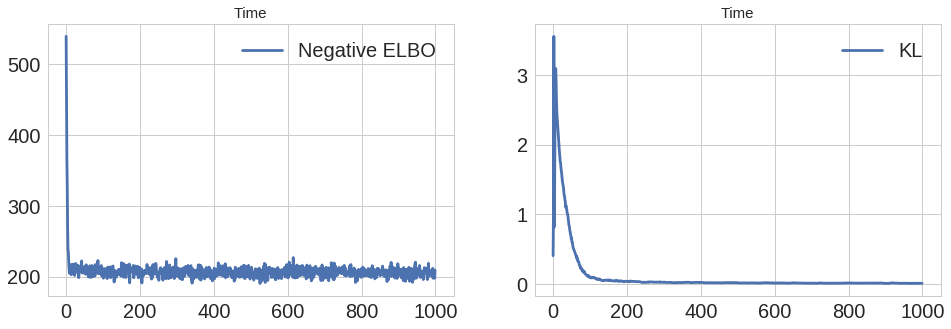

In [0]:
#@title
fig, axes = plt.subplots(1, 2, figsize=(2*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

### Generate samples, reconstructions and latent interpolation

In [0]:
#@title
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

# Note: the reconstructions are only valid after the inner loop optimization has
# been performed.
reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
#@title
# For reconstructions, we run the inner loop updates first.
sess.run(data_assign_op)


##################

###sess.run(variational_variables_reset_ops)

# Update the SVI variables.
for _ in xrange(1000):
  sess.run(variational_vars_update_op) 
  sess.run(decoder_update_op)
(real_data_examples, data_reconstructions) = sess.run(
      [data_var, reconstructions])

final_samples = sess.run(samples)

In [0]:
#@title
print(real_data_examples.shape)

(64, 28, 28, 1)


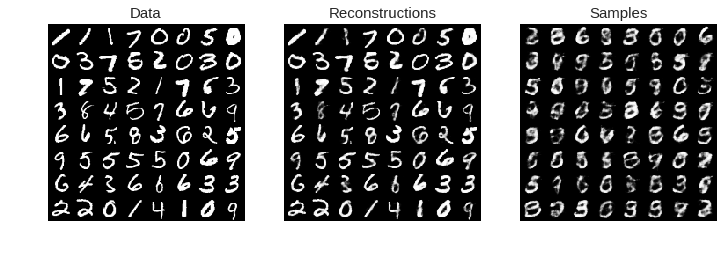

In [0]:
#@title
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))

show_digits(axes[0], real_data_examples, 'Data')
show_digits(axes[1], data_reconstructions, 'Reconstructions')
show_digits(axes[2], final_samples, 'Samples')

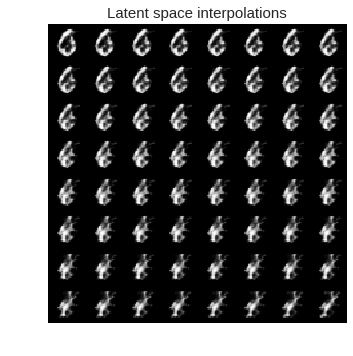

In [0]:
#@title
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q1.1 VI Questions (28 pts):

We going to go through some questions on the model you have just implemented. The first question here could be answered before the implementation and can act as a blue-print for how to do the training. We are going to spend a bit more time on this first method as it is paramount you understand the optimization process here as a lot of the other tasks build on top of this one. 

Whenever a question asks for an effect/behaviour when varying one of the conditions, feel free to experiment. Both theoretical arguments and emperical plots showing the relevant behaviour will be accepted here.

1. **[5 pts]**  Derive the variational ELBO for **one** data point $x$ and explain how one would update the parameters for variational posterior $q_{\phi}(z|x)$, as well as the parameters of the generative distribution $p_{\theta}(x|z)$. Assume a Gaussian prior and a multi-dim Gaussian variational prior, as well as the generative function given  by the decoder in the code above. This is basically outlining the optimization you should be implementing in the **Training loop** section above. 

2.  **[6 pts] **In the **Build the update operations for the variational and global variables**, I have define two separate optimizers for the two sets of parameters ($\theta$ and $\phi$). 
  * i)  How would you implement this with just one optimizer? (You just need to
explain how you would do it, but not implement).
  * ii) What happen if we change the variational variables' optimizer `variational_vars_optimizer` to `tf.train.AdamOptimizer`? (Feel free to experiment and change the learning rate accordingly) 

3. **[2 pts]** What are the computational considerents to think of when using SVI? What would happen if you would now want to train this SVI model on a big dataset, such as ImageNet? What part of this optimization process is mostly affected and in which way?


4. ** [2 pts]**What is the effect of the number of SVI updates on the ELBO and on the KL term?

5. **[3 pts]** What is the effect of the data batch size on the convergence speed compared to the effect of the number of SVI updates? What is the effect of the number of training steps for the decoder compared to the number of SVI steps per decoder update?


**[10 pts] Model Implementation and Results**

1. Hoffman et.al (2013) \\
As x is the observations and z are the hidden varaibles
\begin{aligned} \log p(x) &=\log \int p(x, z) d z  \\ &=\log \int p(x, z) \frac{q(z)}{q(z)} d z  \\ &=\log \left(\mathbb{E}_{q}\left[\frac{p(x, z)}{q(z)}\right]\right) \\ & \geq \mathbb{E}_{q}[\log p(x, z)]-\mathbb{E}_{q}[\log q(z)] \end{aligned} \\
Therefore, the ELBO is $\mathbb{E}_{q}[\log p(x, z)]-\mathbb{E}_{q}[\log q(z)] $ It can be rewrintten as $\log p_{\boldsymbol{\theta}}\left(\mathbf{x}^{(i)}\right) \geq ELBO\left(\boldsymbol{\theta}, \boldsymbol{\phi} ; \mathbf{x}^{(i)}\right)=\mathbb{E}_{q_{\phi}(\mathbf{z} | \mathbf{x})}\left[-\log q_{\boldsymbol{\phi}}(\mathbf{z} | \mathbf{x})+\log p_{\boldsymbol{\theta}}(\mathbf{x}, \mathbf{z})\right]$
where q(z) is an approximation of the true posterior distribution p(z|x) If we want to maximize the loglikelihood of observations we could maximize the lower bound. \\
To maximize the ELBO, we could maximize the parameter $\phi$ and $\theta$. They can be updated by the optimizer \\
$\phi_{n} \propto \nabla_{\phi} \mathbb{E}_{q_{\phi}(\mathbf{z})}\left[\log p_{\theta}\left(\mathbf{x}_{n} | \mathbf{z}_{n}\right)\right]-\nabla_{\phi} \log q_{\boldsymbol{\phi}}(\mathbf{z_n} | \mathbf{x_n})$ \\
$\theta_n \propto\frac{1}{N} \sum\left|\mathbb{E}_{q_{\phi}(\mathbf{z})}\left[\nabla_{\theta} \log p_{\theta}\left(\mathbf{x}_{n} | \mathbf{z}_{n}\right)\right]\right.$
2. 
(i) The variable and global variable can be collected to one list and then the Adam optimizer can be applied to the variables. \\
(ii)When change the variational_vars_optimizer(GD optimizer) to Adam optimizer, the curves of negative ELBO and KL of Adam optimizer  decreased faster than the variational_vars_optimizer. The losses for both optimizers are the same and the last steady value of KL for Adam optimizer is bigger than that for GD optimizer. \\
3. According to  Hoffman et.al (2013) The main computational for SVI is to refer the hidden structure to the observed objects. If we train on a large dataset, the SVI algorithm could be more efficient than the traditional approach. Because it adjusts the hidden structure according to the subsample rather than the whole samples one iteration. The optimization part for this algorithm is the technique that follows noisy estimates of the gradient of the objective. \\
4. The updates reveal a connection between mean-field variational inference and Gibbs sampling (Gelfand and Smith, 1990) and expectation-maximization((EM) algorithm (Dempster et al., 1977)). The natural gradient also related to the updates in the mean-field variation inference.Therefore, increasing updates will increase the ELBO and decreased the KL term. \\
5. A larger batch size could lead to faster convergence, compared to the effect of number of SVI updates, the effect for batch size is more significant. For the step size, decreasing the step size would lead to a slower convergence.

## T1.2 Amortized Variational Inference

**Reminder**: The idea behind amortized inference is to replace the slow iterative optimization process we needed to do in the previous method for each data-point, with a faster non-iterative one.  Check the lecture slides and/or references below for more details.

Thus, instead of learning one set of posterior variables per data point, we can use function approximation to learn the distributional variables. Specifically, the posterior parameters for $x_i$ will be the output of a *learned* function $f_\theta(x_i)$, where $\theta$ are parameters now shared across all data points. Can you think of why this is useful?


<h2 align="center"></h2> <img src="http://elarosca.net/vae.png?format=100w" width=500 >


Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} {\left[ \log p_\theta(x|z) \right]}  - \mathbb{E}_{p^*(x)} \left[ KL(q(z|x)||p(z)) \right]
\end{equation}

For more information, please check out: 
  * https://arxiv.org/abs/1312.6114


**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
print(real_data.shape)

(?, 28, 28, 1)


### Define the encoder

In [0]:
ENCODER_VARIABLE_SCOPE = 'encoder'

In [0]:
def encoder(x):
  with tf.variable_scope(ENCODER_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    
    h = tf.layers.Conv2D(
          filters=8,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(x)
    h = tf.layers.Conv2D(
          filters=16,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=32,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    
    out_shape = 1
    for s in h.shape.as_list()[1:]:
      out_shape*= s
    
    h = tf.reshape(h, shape=[BATCH_SIZE, out_shape])
    mean = tf.layers.dense(h, NUM_LATENTS, activation=None)
    scale = tf.layers.dense(h, NUM_LATENTS, activation=None)
    return multi_normal(loc=mean, log_scale=scale)

### Define the prior

In [0]:
##################
# YOUR CODE HERE #
##################


prior=make_prior()

### Define the variational posterior
**Note**: We no longer have to use a variable to store the data. We will perform one encoder update per decoder update, so it is OK for the data batch to be refreshed at each run.

In [0]:
##################
# YOUR CODE HERE #
##################
variational_posterior = encoder(real_data)

### Define the decoder
We will use the same decoder as in T1.1

In [0]:
decoder = standard_decoder

### Define and build optimization objective (ELBO)

In [0]:
# Maximize the data likelihodd and minimize the KL divergence between the prior 
# and posterior. We use the exact same loss as in the SVI case.

##################
# YOUR CODE HERE #
##################
dist=decoder(variational_posterior.sample())
likelihood_term= dist.log_prob(real_data)
  ##################
  
  # Reduce mean over the batch dimensions
likelihood_term = tf.reduce_mean(likelihood_term)

  ##################
  # YOUR CODE HERE #
  ##################
kl_term=tfd.kl_divergence(variational_posterior, prior)
  # Reduce over the batch dimension.
kl_term = tf.reduce_mean(kl_term)
# likelihood_term, kl_term = ...
train_elbo = likelihood_term - kl_term
loss = -train_elbo  

### Define optimization and the update operations

In [0]:
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)

##################
# YOUR CODE HERE #
##################
encoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=ENCODER_VARIABLE_SCOPE)
decoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)

update_op = optimizer.minimize(loss, var_list=[encoder_vars,decoder_vars])

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []


for i in xrange(TRAINING_STEPS):
  

  ##################
  # YOUR CODE HERE #
  ##################
  sess.run(update_op)
  
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl  = sess.run(
          [loss, likelihood_term, kl_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)

Iteration 0. Loss 540.419555664. KL 0.0263562127948
Iteration 100. Loss 213.303207397. KL 4.95077323914
Iteration 200. Loss 177.505752563. KL 10.362288475
Iteration 300. Loss 146.051086426. KL 13.6730442047
Iteration 400. Loss 133.100601196. KL 15.7087135315
Iteration 500. Loss 123.265785217. KL 16.4919033051
Iteration 600. Loss 127.172821045. KL 18.2926216125
Iteration 700. Loss 116.970321655. KL 17.4367256165
Iteration 800. Loss 119.9584198. KL 17.9738197327
Iteration 900. Loss 110.863937378. KL 16.6248931885
Iteration 1000. Loss 115.860443115. KL 18.2584762573
Iteration 1100. Loss 118.688018799. KL 17.7075080872
Iteration 1200. Loss 111.839477539. KL 17.6232185364
Iteration 1300. Loss 118.115844727. KL 18.8312950134
Iteration 1400. Loss 107.958572388. KL 18.6430358887
Iteration 1500. Loss 107.534729004. KL 18.0924339294
Iteration 1600. Loss 111.758903503. KL 19.7587909698
Iteration 1700. Loss 107.387313843. KL 18.748670578
Iteration 1800. Loss 108.523193359. KL 18.7639636993
Iterati

## Results

Let us take a look at the optimization process and the resulting model


### Visualize the loss in time

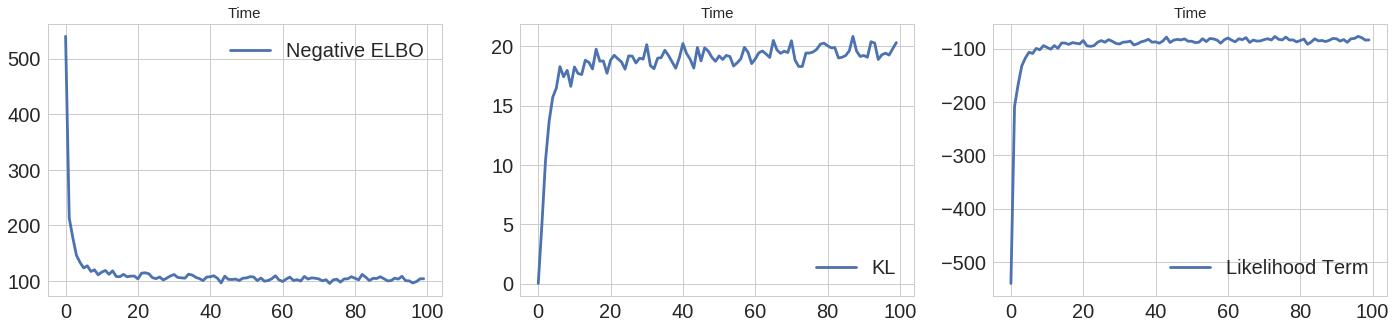

In [0]:
#@title
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(likelihood_terms, label='Likelihood Term')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

### Generate samples and latent interpolations

In [0]:
#@title
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
#@title
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

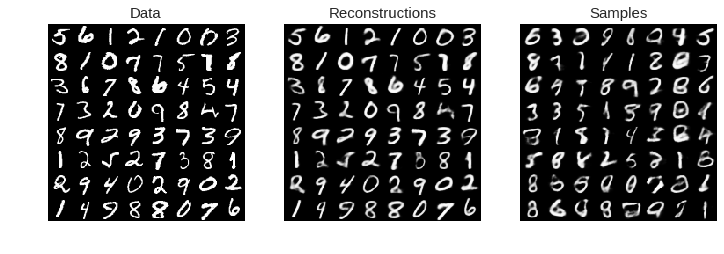

In [0]:
#@title
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

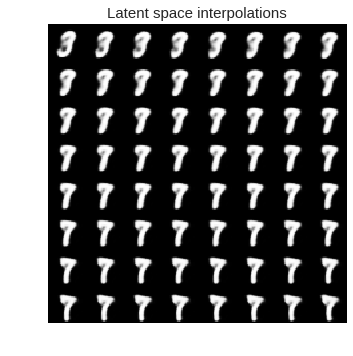

In [0]:
#@title
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q1.2 Questions about Amortized Variational Inference (15 pts)

1. **[5 pts]** What do you notice about amortized variational inference (especially as compared with stochastic variational inference)? 
  * i) Are there any downsides to using the amortized version?
  * ii) What do you observe about sample quality and reconstruction quality? 
  * iii) What do you observe about the ELBO and KL term? \\
(Here, feel free to vary parameters and compare with the T1.1)
2. **[4 pts]** Stochastic and amortized variational inference can be combined, leading to semi-amortized variational inference. Give an instance of an algorithm that would combine these and explain why that would be useful?
3. **[1 pts]** What gradient estimation method is used to compute the gradients with respect to the encoder parameters?

**[5 pts] Model Implementation and Results**

1. i) Amortized version using the neural network to calculate the mean and variance of the Gaussian distribution based in the observations, this method is less general than optimizing the parameters freely as it added more constraints within a specific parameter family. \\
ii) The reconstruction quality is pretty good, while one of the symbol was vague. Compared with the SVI, the sample quality of AVI was better and clear. \\
iii) The KL for the AVI was increasing while for the SVI it was decreasing. Compared to the SVI, the curve of KL was fluctuated slightly at the steady state. The ELBO decreased fast at first and then kept at a low level which is about 100 with small fluctuation, while compared to the stochastic variational inference, the curve of AVI is smoother and had lower steady level. \\
2. To combine these two algorithms, the AVI can be applied to initialize the parameters, and then, we could use the SVI to optimize the parameters. The network and model can be trained by the gradient based optimizer. Thus, the SVI should be differentiable. (Kim, Yoon, et al. "Semi-amortized variational autoencoders." arXiv preprint arXiv:1802.02550 (2018).).This method would make it more efficiency to train the network with more accurate parameter initializing and more general to apply. \\
3. Adaptive Moment Estimation (Adam) is used as the gradient estimation method for the encoder parameters, which could adjust the learning rate during the training process.

## T1.3 KL annealing

In this section we are going to be looking at the same model as in **T2.1**: same encoder + decoder, prior. But we are going to change slightly the optimization objective as given below.

Objective - maximize: 
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x) \log p_\theta(x|z)}  - \alpha \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z))
\end{equation}

Where **$\alpha$ changes during training, to weigh in the KL term more**. In particular for our problem consider:
\begin{equation}
\alpha = \frac{n_{iter}}{N}
\end{equation}
where $n_{iter}$ is the number of training iterations we are have completed and $N$ is the total number of training iterations `TRAINING_STEPS`.

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

In [0]:
real_data = make_tf_data_batch(mnist.train.images)

In [0]:
prior = make_prior()
decoder = standard_decoder
encoder = encoder

##################
# YOUR CODE HERE #
##################
variational_posterior = encoder(real_data)

### Define the KL coefficient $\alpha$ and its update function

In [0]:
##################
# YOUR CODE HERE #
##################
kl_coefficient = tf.Variable(tf.constant(1/TRAINING_STEPS),dtype=tf.float32)
kl_step = 1/TRAINING_STEPS

update_kl_coeff = tf.assign(kl_coefficient, kl_coefficient + kl_step)

In [0]:
##################
# YOUR CODE HERE #
##################
# Hint: This very similar to what you've done in T1.2. Same model, only slightly different loss including $\alpha$
# loss =  ...
dist=decoder(variational_posterior.sample())
likelihood_term= dist.log_prob(real_data)
  ##################
  
  # Reduce mean over the batch dimensions
likelihood_term = tf.reduce_mean(likelihood_term)

  ##################
  # YOUR CODE HERE #
  ##################
kl_term=tfd.kl_divergence(variational_posterior, prior)
  # Reduce over the batch dimension.
kl_term = tf.reduce_mean(kl_term)
# likelihood_term, kl_term = ...
train_elbo = likelihood_term - kl_coefficient*kl_term
loss = -train_elbo 

In [0]:
# We now perform joint optimization on the encoder and decoder variables.
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)

##################
# YOUR CODE HERE #
##################
# Parameter update operation (as before)
# variables_update_op = ...
encoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=ENCODER_VARIABLE_SCOPE)
decoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
variables_update_op = optimizer.minimize(loss, var_list=[encoder_vars,decoder_vars])
# Ensure that a variable update is followed by an update in the KL coefficient.
with tf.control_dependencies([variables_update_op]):
  update_op = tf.identity(update_kl_coeff)

In [0]:
tf.trainable_variables()

[<tf.Variable 'encoder/conv2d/kernel:0' shape=(5, 5, 1, 8) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d/bias:0' shape=(8,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/kernel:0' shape=(5, 5, 8, 16) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/kernel:0' shape=(5, 5, 16, 32) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'Variable:0' shape=() dtype=float32_ref>,
 <tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpose/kernel

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []


for i in xrange(TRAINING_STEPS):
  sess.run(update_op)
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl  = sess.run(
          [loss, likelihood_term, kl_term])
    print('Iteration {}. Loss {}. KL {}'.format(
          i, iteration_loss, iteration_kl))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)

Iteration 0. Loss 540.20111084. KL 0.0229140557349
Iteration 100. Loss 204.092514038. KL 53.8396072388
Iteration 200. Loss 156.975219727. KL 58.6580276489
Iteration 300. Loss 117.802024841. KL 71.8480529785
Iteration 400. Loss 111.668891907. KL 58.4592056274
Iteration 500. Loss 101.648498535. KL 52.6372680664
Iteration 600. Loss 105.356124878. KL 44.9380111694
Iteration 700. Loss 101.896736145. KL 41.4886856079
Iteration 800. Loss 101.059570312. KL 39.7421264648
Iteration 900. Loss 89.5927886963. KL 35.9208374023
Iteration 1000. Loss 91.0769195557. KL 36.3408241272
Iteration 1100. Loss 94.2235565186. KL 32.9987106323
Iteration 1200. Loss 93.1714782715. KL 32.627910614
Iteration 1300. Loss 87.9485244751. KL 31.1939506531
Iteration 1400. Loss 91.0822143555. KL 31.476890564
Iteration 1500. Loss 86.9845962524. KL 29.3427200317
Iteration 1600. Loss 89.8927459717. KL 31.2020931244
Iteration 1700. Loss 94.805267334. KL 29.1487026215
Iteration 1800. Loss 97.1324386597. KL 29.9836425781
Iterati

## Results

Let us take a look at the optimization process and the resulting model

### Visualize training process

Plot the loss and KL and likelihood over the training process (number of iterations)

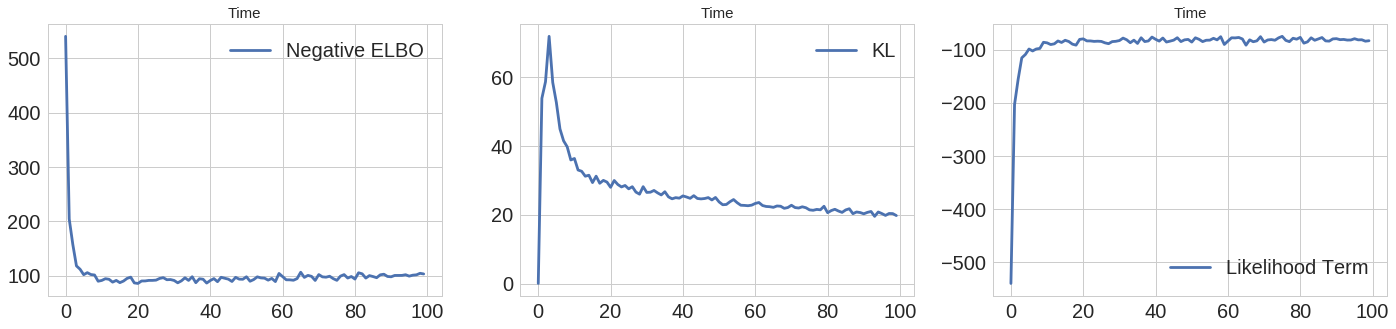

In [0]:
#@title
fig, axes = plt.subplots(1, 3, figsize=(3*8,5))

axes[0].plot(losses, label='Negative ELBO')
axes[0].set_title('Time', fontsize=15)
axes[0].legend()

axes[1].plot(kls, label='KL')
axes[1].set_title('Time', fontsize=15)
axes[1].legend()

axes[2].plot(likelihood_terms, label='Likelihood Term')
axes[2].set_title('Time', fontsize=15)
axes[2].legend()

### Generate samples, reconstructions and latent interpolation

In [0]:
#@title
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

In [0]:
#@title
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

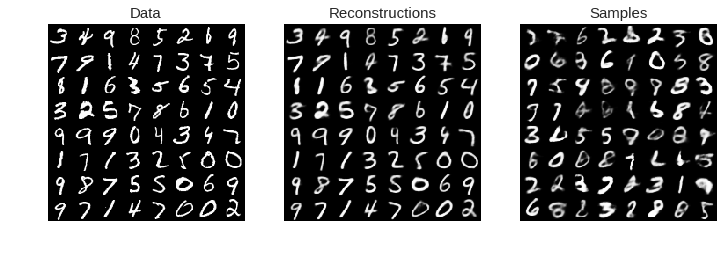

In [0]:
#@title
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

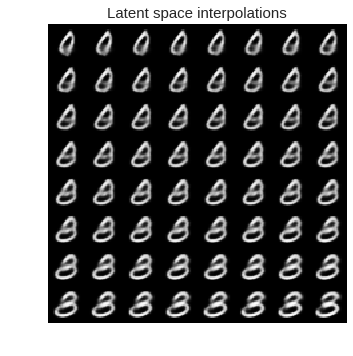

In [0]:
#@title
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q1.3 Questions about KL annealing (15 pts):

1. **[3 pts]** What do you observe about the KL behaviour throughout training as opposed to amortized variational inference without any KL annealing? 
2.  **[1 pts]** How do the samples and reconstruction compare with the previous models?
3.  **[6 pts]** Consider now a schedule where $\alpha$ decreases over time -- that is the contribution of the KL diminishes over time. When would that be a useful case? (Think about what this objective corresponds to in the optimization problem).

**[5 pts] Model Implementation and Results**

1. The curve for KL increased first to 60 and then decreased to a steady level at around 20, while the curve for amortized variational inference only increased to 20 and then stay steady at this low level. \\
2.  Compared to the previous models, the reconstruction qualities are similar and the samples quality of KL annealing is better than others. \\
3. When the $\alpha$ decreased, the KL will be focused a lot than the reconstruction error (likelihood) at first and then decreased the contribution of KL term in the optimization process. This would be useful when there have been lots of information being encoded in the KL term and it is hard to decrease. The system need to pay more attention to the KL term and then maximize the reconstruction quality. While in most cases, the KL term was easier to reduce to zero than the reconstruction error.


## T1.4 Constrained optimization

In this next part, instead of using KL annealing, constrained optimization can be used to automatically tuned the relative weight of the likelihood and KL terms. This removes the need to manually create an optimization schedule, which can be problem specific.

The objective now becomes:

\begin{equation}
  \text{minimize } \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z)) \text{ such that }  \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} \left[ {\log p_\theta(x|z)} \right] > \alpha 
\end{equation}

This can be solved using the use of Lagrange multipliers. The objective becomes:

\begin{equation}
  \text{minimize }  \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z)) + \lambda  (\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z)))
\end{equation}


The difference compared to the KL annealing is that:

   * $\lambda$ is a learned parameter - it will be learned using stochastic gradient descent, like the network parameters.  The difference is that the lagrangian has to solve a maximization problem. You can see this intuitively: the gradient with respect to $\lambda$ in the objective above is $\mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))$. If $ \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))> 0$, the constraint is not being satisfied, so the value of the lagrangian needs to increase. This will be done by doing gradient ascent, instead of gradient descent. Note that for $\lambda$ to be a valid lagranian in a minimization problem, it has to be positive.
   * The practicioner has to specify the hyperparameter $\alpha$, which determines the reoncstruction quality of the model.
   * the coefficient is in front of the likelihood term, not the KL term. This is mainly for convenience, as it is easier to specify the hyperparameter $\alpha$ for the likelihood (reconstruction loss).


For more assumptions made by this method, see the Karush–Kuhn–Tucker conditions.

For more information, see: 
  * http://bayesiandeeplearning.org/2018/papers/33.pdf

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

In [0]:
real_data = make_tf_data_batch(mnist.train.images)

In [0]:
prior = make_prior()
decoder = standard_decoder
encoder = encoder

##################
# YOUR CODE HERE #
##################
variational_posterior = encoder(real_data)

### Define the lagrangian variable $\lambda$.
Unlike in the KL annealing case, we learn the coefficient. Remember that this variable has to be always positive. To ensure this, use `tf.nn.softplus`, Moreover, please initialize the lagrangian such that after the softplus the coefficient is approximately 1. Check emperically that this is true when instantiating the variable.

In [0]:
##################
# YOUR CODE HERE #
##################

lagrangian_var = tf.get_variable('lagrangian_var', shape=[1],initializer=tf.constant_initializer(0.2),dtype=tf.float32)
# Ensure that the lagrangian is positive and has stable dynamics.
lagrangian = tf.nn.softplus(lagrangian_var)


In [0]:
# How good do we want the reconstruction loss to be?
# We can look at previous runs to get an idea what a reasonable value would be.

##################
# YOUR VALUE HERE#
##################
reconstruction_target = -90

### Define the loss

In [0]:
##################
# YOUR CODE HERE #
##################
dist=decoder(variational_posterior.sample())
likelihood_term= dist.log_prob(real_data)
  ##################
  
  # Reduce mean over the batch dimensions
likelihood_term = tf.reduce_mean(likelihood_term)

  ##################
  # YOUR CODE HERE #
  ##################
kl_term=tfd.kl_divergence(variational_posterior, prior)
  # Reduce over the batch dimension.
kl_term = tf.reduce_mean(kl_term)
loss =  kl_term + lagrangian * (reconstruction_target - likelihood_term )

In [0]:
# Check trainable variables (the lagrangian variable should be in here)
tf.trainable_variables()

[<tf.Variable 'encoder/conv2d/kernel:0' shape=(5, 5, 1, 8) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d/bias:0' shape=(8,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/kernel:0' shape=(5, 5, 8, 16) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_1/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/kernel:0' shape=(5, 5, 16, 32) dtype=float32_ref>,
 <tf.Variable 'encoder/conv2d_2/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/kernel:0' shape=(1568, 10) dtype=float32_ref>,
 <tf.Variable 'encoder/dense_1/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'lagrangian_var:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/kernel:0' shape=(10, 3136) dtype=float32_ref>,
 <tf.Variable 'decoder/dense/bias:0' shape=(3136,) dtype=float32_ref>,
 <tf.Variable 'decoder/conv2d_transpos

In [0]:
lagrangian_optimizer = tf.train.GradientDescentOptimizer(0.001)
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)
##################
# YOUR CODE HERE #
##################
encoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=ENCODER_VARIABLE_SCOPE)
decoder_vars = tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DECODER_VARIABLE_SCOPE)
autoencoder_variables_update_op = optimizer.minimize(loss, var_list=[encoder_vars,decoder_vars])
####

#############################################
# Ensure that a variable update is followed by an update to the Lagrangian.
with tf.control_dependencies([autoencoder_variables_update_op]):
  # Ensure that the lagrangian solves a maximization problem instead of a
  # minimization problem by changing the sign of the loss function.
  update_op = lagrangian_optimizer.minimize(-loss, var_list=[lagrangian_var])

## Training

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.initialize_all_variables())

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
losses = []
kls = []
likelihood_terms = []
lagrangian_values = []

for i in xrange(TRAINING_STEPS):
  sess.run(update_op)
  
  
  if i % 100 == 0:
    iteration_loss, iteration_likelihood, iteration_kl, lag_val  = sess.run(
          [loss, likelihood_term, kl_term, lagrangian])
    print('Iteration {}. Loss {}. KL {}. Lagrangian {}'.format(
          i, iteration_loss, iteration_kl, lag_val))
    losses.append(iteration_loss)
    kls.append(iteration_kl)
    likelihood_terms.append(iteration_likelihood)
    lagrangian_values.append(lag_val)

Iteration 0. Loss [424.83023]. KL 0.011335209012. Lagrangian [0.9429743]
Iteration 100. Loss [1969.953]. KL 18.8173923492. Lagrangian [17.802963]
Iteration 200. Loss [1748.9397]. KL 40.8665924072. Lagrangian [26.713896]
Iteration 300. Loss [1357.5363]. KL 47.8943138123. Lagrangian [31.3606]
Iteration 400. Loss [838.31824]. KL 51.4831848145. Lagrangian [33.81046]
Iteration 500. Loss [253.8623]. KL 52.7529716492. Lagrangian [35.167973]
Iteration 600. Loss [504.9325]. KL 49.4931945801. Lagrangian [35.95626]
Iteration 700. Loss [147.03323]. KL 48.7783699036. Lagrangian [36.606815]
Iteration 800. Loss [83.72966]. KL 50.6485443115. Lagrangian [36.99129]
Iteration 900. Loss [169.02979]. KL 47.988861084. Lagrangian [37.175465]
Iteration 1000. Loss [235.42746]. KL 47.4543304443. Lagrangian [37.237457]
Iteration 1100. Loss [-197.55966]. KL 48.9290847778. Lagrangian [37.17135]
Iteration 1200. Loss [93.87619]. KL 48.2586898804. Lagrangian [37.047546]
Iteration 1300. Loss [-77.15886]. KL 47.8431968

## Results

Let us take a look at the optimization process and the resulting model

### Visualize training process

Plot the loss and KL over the training process (number of iterations)

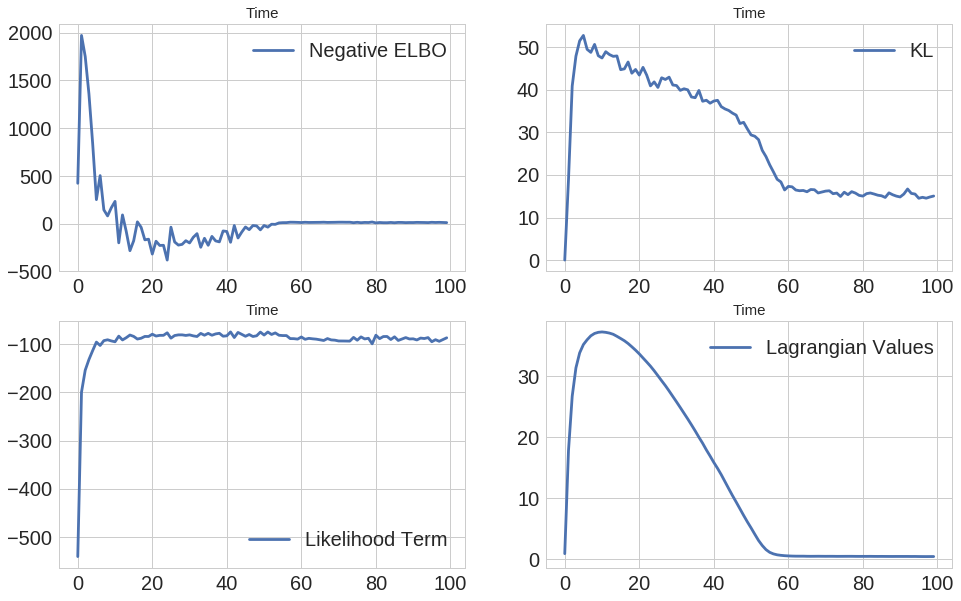

In [0]:
#@title
fig, axes = plt.subplots(2, 2, figsize=(2*8, 2* 5))

axes[0, 0].plot(losses, label='Negative ELBO')
axes[0, 0].set_title('Time', fontsize=15)
axes[0, 0].legend()

axes[0, 1].plot(kls, label='KL')
axes[0, 1].set_title('Time', fontsize=15)
axes[0, 1].legend()

axes[1, 0].plot(likelihood_terms, label='Likelihood Term')
axes[1, 0].set_title('Time', fontsize=15)
axes[1, 0].legend()

axes[1, 1].plot(lagrangian_values, label='Lagrangian Values')
axes[1, 1].set_title('Time', fontsize=15)
axes[1, 1].legend()

In [0]:
#@title
samples = decoder(prior.sample()).mean()
samples.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

reconstructions = decoder(variational_posterior.sample()).mean()

### Generate samples and latent interpolations

In [0]:
#@title
real_data_vals, final_samples_vals, data_reconstructions_vals = sess.run(
      [real_data, samples, reconstructions])

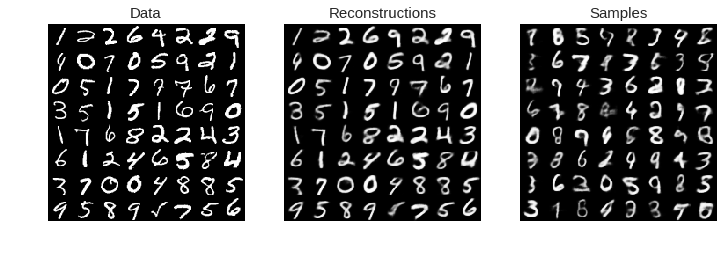

In [0]:
#@title
fig, axes = plt.subplots(1, 3, figsize=(3*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], data_reconstructions_vals, 'Reconstructions')
show_digits(axes[2], final_samples_vals, 'Samples')

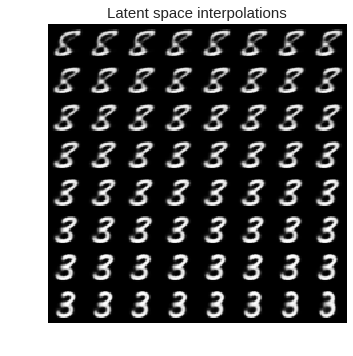

In [0]:
#@title
show_latent_interpolations(lambda x: decoder(x).mean(), prior, sess)

## Q4.1 Questions about constrained optimization (12 pts)

1.  **[3 pts]** Based on previous results, set and try varying the threshold for reconstruction (variable `reconstruction_target` int the code above). Describe what happens when you vary this variable. (Produce the plots to support your answer)
2.  **[1 pts]** What do you observe about the behaviour of the likelihood and KL term throughout training? How is it different than in Stochastic Variational Inference and Amortized Variational inference with and without KL annealing?
3.  **[3 pts]** What do you notice about the behaviour of the lagrangian during training? Is that what you expected?


**[5 pts] Model Implementation and Results**

1. When decreasing the threshold from -90 to -200, the reconstraunction graph and samples graph are blurred, as we can see from the graph below. ![替代文字](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtQAAAD+CAYAAAAahZKJAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi40LCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcv7US4rQAAIABJREFUeJzsfXd4lFXe9j29l0xJr5BQzIuGRZoi%0AWGCxICquqGjsDSuIDRuu2AXRV1GxgsiCrKurLAK67Aq6Koq8ILBAKCG9TCZTk6mZ+f7g+x3PDMnM%0ApCAgz31duZJMOec5/T6/KopGo1EIECBAgAABAgQIECCgRxAf7QcQIECAAAECBAgQIOB4hkCoBQgQ%0AIECAAAECBAjoBQRCLUCAAAECBAgQIEBALyAQagECBAgQIECAAAECegGBUAsQIECAAAECBAgQ0AsI%0AhFqAAAECBAgQIECAgF5AINQCBAgQIOCI4dFHH8W11157tB9DgIATAmeffTYWLFhwtB/jhIT0aD+A%0AgGMH5eXl2Lx5M6RSKaLRKBQKBUpKSnDuuedi2rRpkMvlKZVTUVGBgwcP4o9//OMRfmIBAn4b8GuD%0AIJfLUVhYiOuuuw4XXnjhUXy61LF582aEQiGMHj36iNURv/6feuqpI1aXAAFHCx0dHXj33XexevVq%0A1NbWIhAIICMjAxMnTsTdd98NpVJ5tB9RwG8MgVALiMEFF1yAefPmAQDsdjt27NiBl19+GZ9//jkW%0AL14MvV6ftIxPPvkELS0tAqEW8LsCvzYAwO/3Y82aNXjooYcgl8sxceLEo/h0qWHJkiXo16/fESXU%0AwvoXcCLghRdewJo1azB//nyccsopEIvF2L59O2bNmoWGhgZBSnwCQjD5ENAlzGYzxo0bh6VLl8Ll%0AcuGll14CAGzbtg3l5eUYMWIEhg8fjptvvhk1NTUAgFmzZmHx4sVYvXo1hgwZgpaWFoTDYcybNw9n%0An302hg4divHjx2PJkiVHs2kCBPQaSqUSl1xyCUaNGoVPP/0UAFBbW4s777wTp59+OsrKynDVVVdh%0A27Zt7DuhUAgLFizA2LFj8Yc//AHl5eXYsWMHe3/Pnj244YYbMHLkSAwdOhTXX389du/ezd4/++yz%0AsXjxYjz++OMYMWIERo4ciSeffBKU8NbhcGDWrFk47bTTUFZWhnPPPRcrV64EAFxxxRX48ssv8fbb%0Ab+PUU08FcEjy/uSTT+LGG29EWVkZOjo6UF5ejvvuuy+mrVdeeSUeeugh9v8333yDKVOmoKysDBMm%0ATMAHH3wAoPP1/9BDD+HKK6/8TdooQMBvhY0bN2LChAkYPnw45HI5pFIphg4dildffRWTJ08GABw4%0AcAC33HILRo0ahWHDhuGqq67Czp07WRnl5eV4/vnn8fTTT+PUU0/Faaedhr/+9a/YvHkzJk+ejLKy%0AMlx99dVoamoCAGzatAkDBw7Ehg0bMHnyZAwZMgQTJkzA999/3+VzrlmzBlOmTMHQoUMxevRoPPbY%0AY/B6vez9pUuXYuLEiSgrK8Po0aMxe/bsmPcFpA6BUAtICq1WiyuvvBL/+Mc/EAwGccstt+CUU07B%0Ad999h3/961/o6OjA7NmzAQDz58/H8OHDccEFF2D79u2wWCz44IMP8Mknn2Dx4sXYsmULHnvsMTzz%0AzDP44YcfjnLLBAjoPYLBIJRKJYLBIK6//noYjUasXbsW33//PYYNG4abbrqJHVCvvfYa1q5diyVL%0AlmDTpk0oKyvDjTfeCI/HA5fLhfLychQXF2P9+vX45ptvYLVaccMNN8QccO+88w7Gjh2L7777DvPn%0Az8eyZcvw9ddfAwAWLFgAh8OBtWvXsrX27LPPYt++fVixYgVycnJw8803Y/Pmzay8NWvWYOrUqdiy%0AZQskEknS9lZUVOD222/Hddddhx9//BEvvvgiFixYgM8++6zT9c/jSLdRgIDfCiUlJVi3bh02bNiA%0Ajo4O9nppaSnOOussAMA999wDg8GAr7/+Gv/5z3+Qm5uLu+66K6aczz77DEOHDsUPP/yA8vJyPPPM%0AM1iyZAkWL16MjRs3wu124/3334/5zjvvvIOFCxdi06ZNOOusszB9+vROSfB3332HBx98ELfffjs2%0Ab96Mjz76CDt27MDTTz8NANi6dSteeOEFLFiwAFu3bsXf//53VFZW4q233urr7johIBBqASmhf//+%0A8Hg88Hg8+Oqrr3D33XdDKpVCp9PhnHPOiZHCxaO8vBxr1qxBfn4+RCIRxo0bB5PJhF9++eU3bIEA%0AAX0Lr9eLv/zlL9i8eTOmTJmCjRs3or6+Hg8//DB0Oh1UKhVmzpwJiUSCNWvWIBqNYsWKFbj66qtR%0AVFQEmUyG22+/HY899hjC4TBWrVoFkUiE++67D1qtFlqtFg899BBaW1uxceNGVu+wYcMwfvx4SKVS%0AjBkzBiaTCXv27AEAeDweiMViKBQKiMVinH766diyZQuKi4u7bEdWVhYmTpwIsTi14+Djjz9GSUkJ%0AJk+eDLlcjrKyMrz22msJ6yAcrTYKENDXmDNnDkpLS5kE+pZbbsFbb72Fqqoq9pnly5dj7ty5UCqV%0AUCqVOP/881FXVwebzcY+k5+fj/PPPx9SqRQTJkxAe3s7rrrqKphMJuj1eowZM+awy+LVV1+NvLw8%0AqNVq3HHHHQgEAjHrh7Bs2TJMmDAB48ePh0QiQX5+Pu666y6sWrUKfr8fbrcbAJi9d0ZGBpYvX457%0A7733SHTZ7x6CDbWAlEA3cIlEgq+//hrvv/8+Dh48iHA4jEgkgnA43OV3PR4Pnn32WXz//fdwuVwA%0ADkn1AoHAb/LsAgT0BVavXo1169ax/4PBIP7nf/4Hr776KsaOHYu33noL4XAYI0eOjPleJBJBXV0d%0AHA4HnE4ncnNz2XsqlQqTJk0CAFRVVSE/Pz/G+ddkMsFkMjGTKgAoKCiIKV+lUsHn8wEAbr31Vtxx%0Axx0YM2YMRo4ciTFjxmDSpEnQarVdtisvL69b/VBVVRXTBgA4/fTTU/7u0WijAAF9DbPZjEWLFqGh%0AoQE//fQTtmzZgpUrV+Kll17CbbfdhhkzZuD//u//sHDhQuzbtw+BQICZLfFnX05ODvubiC3/mkql%0AOuys7N+/P/vbYDBAr9ejoaHhsGc8cOAAqqqq8OWXX8a8HolE0NTUhFGjRmH8+PGYNGkSTj75ZIwa%0ANQqTJk0SLqc9hCChFpASdu7cCavVij179uCBBx7A5MmT8e2332L79u147LHHEn73nnvuwe7du7Fk%0AyRJs27YN27dvh9Vq/Y2eXICAvgGZMWzfvh3btm3D0KFDYbVaMX78eACHDkOtVss+Qz87d+7EjBkz%0AmDlFJBLptHz+wOURiUQgEonY//zf8Rg0aBC+/PJLvP766+jfvz/ef/99nHvuuairq+vyOzKZLGnb%0A+WcWi8VdtiEZjlYbBQg4UsjKysLkyZPxxBNP4J///CfuvPNOvPHGGzhw4ACmT5+OoUOH4p///Ce2%0Ab9+ON95447DvdzbXE81/ADEmJgAQjUY71TAplUpMmzbtsD3pv//9LwoKCiCXy7FgwQKsW7cOkydP%0Axn//+19MnjwZK1as6GYvCAAEQi0gBTgcDqxcuRJTpkzBtm3boNFocP3110Oj0QBAQnMP4JCd1pQp%0AU9C/f3+IxeLDVF4CBBxvEIvFTOtCh09hYSG8Xi+qq6tjPkuSV4PBgLS0NBw4cIC9FwwG8d5776Gm%0ApgZFRUWoqqqKkUbZbDY4HA4UFRWl9FxutxuRSATDhw/HzJkzsWrVKiiVysMkVImgUCjg9/vZ/5FI%0ABLW1tez/wsLCmDYAwPr16/Hvf/87adnHShsFCOgN6urq8MQTT6C5ufmw984880wAwBdffIFQKIRb%0Ab70VRqMRQPKzMlXwZiVOpxNutxtZWVmHfa6wsBC7du2Kec3tdsPpdAIAwuEw3G438vLyMG3aNLz1%0A1lu45ZZbsGzZsj55zhMNAqEW0CVCoRC+++47XHPNNcjNzcX06dORl5cHn8+HnTt3oq2tDcuXL0dl%0AZSUAoL6+HsAhFVVdXR08Hg+CwSDy8/Oxbds2BINB7N+/H08//TRycnLY5wUIOB5RVFSEmTNn4vnn%0An8fBgwdx+umno7i4GE888QSampoQDAaxfPlynH/++YxUT5s2DR9++CF2796NUCiEd955B4sWLYJe%0Ar8ekSZMQiUTw4osvwufzwel04plnnkF2djbGjh2b9Hmi0Sguu+wyzJs3Dx6PBwCwd+9euFwu9OvX%0AD8ChtVldXQ2Px3OYlIvQr18//Pzzz6irq0MgEMCrr74aY9I1depUVFVVYdmyZQgGg9i5cydmz57N%0AzLni1z+P36KNAgQcaVitVnz//feYOXMmtm/fjmAwiI6ODuzduxcLFixAcXExm88///wzAoEA1qxZ%0Ag59++gkAOjXP6A6WLl2K2tpa+Hw+LFy4EGq1GmecccZhn7vmmmvw888/Y9myZfD7/bDZbLjvvvsw%0Ac+ZMAMDbb7+NadOmYf/+/QAOkfOKigphLfUQAqEWEAMKdzVkyBCceuqpePbZZ3HhhRdi6dKlUKlU%0A+OMf/4hLLrkE11xzDcaPH4+amhq8/vrrKC4uxqRJk1BVVYWpU6di3759GDduHCoqKvDnP/8ZFRUV%0AGD58OB544AFMnz4d1157Lb744gs8/vjjR7vJAgT0GNdccw0GDx6M+++/H9FoFG+++SYUCgXOO+88%0AjB49Gp999hneeustZqd8xx134OKLL8YNN9yAESNG4D//+Q/eeecdGAwGWK1WvPvuu9izZw/GjRuH%0ACy64AB0dHVi2bBkUCkXSZxGJRFi4cCEqKipw5plnYujQobjvvvtw1113Ydy4cQAOEfqvv/4a55xz%0ADhwOR6fl3HjjjRgwYAAuuOACjB8/HkajMcYuvKioCO+++y5WrFiBU089Fffccw+mT5+Oiy++GAAO%0AW/88fos2ChBwpCGXy/GXv/wFgwcPxqxZszBy5EiUlZVh+vTpKCoqwtKlS3HyySfjtttuw8MPP4wx%0AY8Zg48aNeO211zBs2DDcfPPN+PHHH3tc/9SpU3HHHXdgxIgR2LBhAxYtWsQ0xjyGDh2K+fPnY8WK%0AFRg+fDguvvhipKWlYf78+QAOrfXTTjsN1113HU4++WTmizBnzpweP9uJDFG0M4M2AQIECBAgQIAA%0AAccMNm3ahGuuuQZffvnlYY67Ao4+BAm1AAECBAgQIECAAAG9gECoBQgQIECAAAECBAjoBQSTDwEC%0ABAgQIECAAAECegFBQi1AgAABAgQIECBAQC8gEGoBAgQIECBAgAABAnqB4z71eLKMQgIEnGg4lq24%0AhPUqQEAshPUqQMDxg0TrVZBQCxAgQIAAAQIECBDQCxz3EmoBAgT8PiEWH7rv81Iykg5EIpFelS0S%0AiQ77ofIjkQii0WivJIfx5fLl0+++qEMsFsfUQ4hEIqwdvSmffh+pfuLLp/EmUNm9Gev4PoqfS9RP%0A9H9P6+DrAn6du3wb+qKvjkVQ+/l+jp/nvR1D+s3/za+hvuhXfm6IxeKYMvuqjs72NL78vlhL9Dt+%0Avfa2jviyabwJNMd7u+90Vld8HX1Zdvye0Jt+Egi1AAECjhnwm5xUKu10045EIgiHwz3a9EQiESQS%0ACcRiMaRSKSQSCasHAMLhMEsj3NHR0e0NnD9sqGyJRAKZTMZIQCgUQigUQjgcRiQS6TIFeCp1KBQK%0AyGQyyOXyGDITCATQ3t7eozYAhw5++onvp2g0inA4HNOG3vQT/aY+IkQiEYRCITYW3UFnfaRQKCCR%0ASNhzhsNhtLe3szp62gZ+PtEPtYvmE9+O3wuppv6lH5lMdth67ejoYPO9J6Sa+pf6mP4WiUQx84Pm%0AYHfr6OwyQHOdxonGjcauJ+NHfcWvJZ7sdnR0IBAI9Pjixa8jfk7S/531VXeePf75JRIJlEolq6uj%0AowPBYJDN9VAo1Kt+4sedn0/BYLDHwoL4+cq3he+jcDgcsx90px6BUPcBnnzySYwaNQrjx4+HSCSC%0A2+3GU089hRdffLHXZc+ePRsGgwEajQZ33HEHe/21115De3s7PB4P5s2bh0Ag0O2yCwsLMXPmTEye%0APBn5+fkx7/FSBsKKFSswY8YM2Gy2njXmCOPvf/87+vfvjyFDhvxmdb766qu45ZZbIJFIAABtbW14%0A4IEHsGjRoj4pXyKR4L333sN5550Hg8GA0aNHY8uWLX1S9rECOihlMhmUSiXUajW0Wi1KS0thMpmg%0AVqvR0dGBtrY2tLa2orGxETU1NfB6vYz8EsHuDLQ5U/lZWVnQ6/XIyMiAyWSC0WiEQqFAJBJBZWUl%0AbDYbWltb4XA44PF44PP52CabqA0qlQoqlQpGoxEZGRnIyclBTk4OiouLUVRUxDbthoYG7N+/Hzt3%0A7sTBgwexd+9e1o5U+8hoNMJqtWL06NEoLCxERkYGtFotJBIJ2tra0NjYiHXr1qG6uhoNDQ1oa2tD%0AIBBIWodUKoVMJoPFYoHRaITJZEJmZiasVisMBgNkMhlaW1vR1NQEu92O1tZWtLS0wOVywe/3w+/3%0AJzyAqA0KhQJqtRoGgwF6vR4mkwlFRUVQKBQIhULwer2w2+1oaGiAy+VCU1MTgsEgI/Bd1SGRSCCX%0Ay6FUKqHRaGA2m3HqqaciMzMTubm5UKlUkEgkCIVCaGtrw+bNm1FfX4+6ujq0tLTE9FNXdVA/abVa%0A6PV6GI1GGAwGpKenw2w2w2g0QiaTwev1wul0orGxkfWXx+OB2+0+bok1XXSpj1UqFeuHwsJC6HQ6%0ASKVSdllxOBxoaWlBdXU12tvb2TxPNIbxcz0/Px9paWlsThKRC4VCOHjwIOx2O1wuF9xud8z4hcPh%0AhO2Qy+WQy+VQqVTQ6/XQ6/UwGAwwm82wWCwIBALweDxwOByw2+1wOp0x45eIlFI/UV9ptVqYzWaU%0AlZWhuLgYFosFarUawKGLXVNTEzZs2IDq6mo2T4g8JqqDyLnBYIBWq4VWq4XBYIDJZIJOp4NCoYDH%0A44HT6YTdbofb7YbL5UJbWxtCoRCCwWDCeahSqaBUKqHVapGWlgaz2Qyz2QyTyYSCggLIZDKEw2F4%0APB40Nzejvr4eNpsN+/btg8/nS+kixQsf5HI5LBYL0tLSYLVa2XgDgNvtxv79++FwOODz+dDW1sb2%0A5WTrVSaTxew1VL5Op4NSqUQ0GoXX64XD4YjZ/71eL7xeb8oXeoFQ9xInnXQSHn30UfZ/NBqFTqfD%0Ac889h/PPPx9nnXVWr8o/99xzkZ2djX79+sVMGJ5cl5aW4qabbkJ7e3tKZRYXF2PixIm4++67UVxc%0AnPKzXHHFFdi9ezfefPPNY45Uy+VyFBQUID09HYWFhTh48OARrW/EiBFYsGABRo0ahZaWFlRUVGDA%0AgAGwWCz4xz/+0Sd1yGQyrF27FmeddRYGDBiAhQsXorKysk/KPlZAm51CoYBGo4HBYGBksaysDBkZ%0AGdDr9QCA1tZW1NXVQaFQwOVyIRKJQCQSsUOhswOUDh0icHq9Hjk5OYxgZWdnw2g0Qi6XIxKJQKlU%0AwmAwoK6uDmKxmG3Ufr+/y02V6jAajTCbzYxEl5SUoKSkBPn5+cjPz4dUKkUwGITT6URJSQmys7Ox%0AadMmRhq7Ihl8G7RaLYxGI3Jzc1FcXIyxY8ciPz+fHdBSqZSRUYfDAZVKhUgkgubm5oREhkgiESRa%0AS3l5ecjNzYXVaoVer4dIJILNZkNmZibq6+vR2NjIpHk0FokOH4VCAZVKBZ1Ox4hLRkYGsrKyMGDA%0AAMjlcojFYtjtdtTU1EClUqGurg4ul4uV0dXlhkgMXWqsVisKCwsxYsQIZGdnw2KxMGk1EepoNIrM%0AzEx2aJP2I9lYqFQqpKenw2KxwGq1IiMjA9nZ2YwESCQSNg56vT6GPLW1tfWJ6vpogOahRqOBTqdj%0AJCUjIwODBw+GXq+HVCpFJBKB2+1Gc3MztFotHA4HI1a0XhP1L12s09LSUFJSgqysLJjNZhgMBqhU%0AKojFYoRCISiVSjQ2NqK5uRlNTU2sDL/f3yWhpjqoDTqdjo2h1WplF6NQKMQIVmNjI+rq6iCRSOD3%0A+1NqA+05RqMRmZmZKCwsxIQJE1BQUIC0tDQoFAqIxWL4fD44HA4AwJYtW7Bz584YIUGiOuhCQPsk%0APX96ejoMBgPkcjmcTidsNhsaGhrQ2NgIAGz9JJIki8Vi9vxmsxmZmZlIT09naykrKwtSqZRdgInU%0A63Q61NfXs3WaSMpL+45CoYBSqYROp2P7cmZmJjIzM6FWqxGNRuF0OhnHIQm/3+9HKBTqUlhA54ta%0ArUZWVhbS09ORkZGBjIwMWCwWaDQatke2tbXBZrOxy5VEIkEkEoHP50t5vf6uCbVMJsNXX32F77//%0AHrNnzz4idUyfPh0OhwMXXnghkxyWlpbitddew9ixY3td/rhx4yAWi3HRRRfFvH7nnXdiwIAByM7O%0AxuWXX47Fixfjyy+/TKnMioqKHm/mTzzxBMxmM2bMmNGj7x8pnHbaaTj55JMhEolQUFDQKaEuLS3F%0AqFGj8O677/aqrhEjRmDlypXIzc2Fx+PBNddcg3Xr1uHcc8/F6tWrcc011+DZZ5/tVR1yuRxvvPEG%0AzjrrLKxfvx779u3DxRdfDJ/P16tyjzXwEkW9Xg+z2YysrCzk5OSgf//+yMjIgE6nQ0dHBwwGAwCg%0Avb0dFRUVUCgUCAaDkEgkCIfDnWpVaMMmiaXFYkFBQQHy8vKQn58Ps9kMpVIJsViMSCSC3Nxcpqon%0AyY7f7z/MvpcHHW46nQ7Z2dkYNGgQTjrpJAwYMAB5eXkwm82IRCIIBAKQSCTQ6/XIy8tDR0cHnE4n%0ANmzYALfbnbB8sVgMuVwOjUaDjIwMFBYWorS0FIMGDYLJZGJ9QJoqrVaLAQMGMCkbSVo66yPe5IIu%0ANXl5ecjKykJBQQFyc3Oh1WqZuYdIJIJCoWBEmvop2dwUi8VsHIxGI9LT05GTk4OsrCxkZmYiPz8f%0ACoUCIpEIRqORETOv1wu5XB4z1l2VL5VKodFoYDKZkJ2djYKCAmRnZyM9PR0qlQodHR3w+/2IRCKQ%0ASCTIycmBSCSC3W6HzWaDw+FIGNmCv3ikp6cjMzOTtSErK4tpO0hjIZPJ2KHc1NQEmUzG+vx4BLWd%0A+thsNjMCl5OTw8xqAECj0bD27t69G21tbZ3a+/OgechreuhyR30rlR6iLR0dHcjJyYFMJmOXXq/X%0Am3S9kkSUpK5Wq5WRt4yMDKSlpUGr1SIcDkOlUjFzKr/fj/b29hhTimSEWq/XIzs7G8XFxRgwYAAG%0ADRoEi8XC9phwOAyZTAa9Xo+SkhK4XC60trbC5XKxC32iNtDFw2q1MjKdmZkJi8UCrVYLqVQKtVoN%0AuVwOAAgEAnC73ZDJZAgEAknHQqVSwWAwsLLp0kFaGFqLMpkMaWlpzGRCqVSy8e4K/L5GZNpoNKKo%0AqAi5ubnsYqNUKtHR0QG1Wo2MjAymMSQTk3gzo/g2EKGmi3tWVha7gJCZWSQSgUwmY2YgAJg0n571%0AhCfUt956K8aOHYvvvvsu6Wfvvvtu/O///m+36/jXv/6Fd999F1u3bmWv/fzzz7juuuuwa9eubpfX%0AGSKRCD799NOY1z799FMsXboU06ZNg8fjgd1u73H5O3fuhMPhwHvvvcdu+fGYOnUqrr32WgBAdnY2%0As5tKFU8//TRqa2uxaNGilO23DAZDjGQqFezfvx+bN28+7HWVSoWXX34ZTzzxRLfK6wx/+9vfkJWV%0ABQC46KKLsGHDBgDA2rVrAQDl5eX4y1/+gqqqqh6Vr1Ao8I9//APnnHMO3n33XXZ5+b2RaQAx9nh0%0AiNLBJpfLmc0xcGhTUyqVzFaTyF0iUw9eLUqHT3Z2NrKysmAwGCASiZhqEgCT0BIZos01UR10uJlM%0AJmRlZaFfv34oKipCVlYWJBIJ7HY77HY7QqEQk8bTAZSbmwu1Wp2UYJGKmohMXl4e8vLyIJPJ4HQ6%0A0dbWBq/Xi0AgEEO+rVYrLBYLU5MnagPZYqvV6hiJlFKpZFK5UCgEuVwOhULBfuggSob4A5SkyGlp%0AaayOjo4OZv+p0Wggl8vZodeVQ1f8OCgUCnY4p6WlQSqVoq2tjUm4iASQNJzmBW9L39Xz86p8Mlnh%0AD/5wOAyfz4doNMpMFsgUiProeHZOpLGhuUIqdKPRGGOSQ32pUqnYBYOQbC3RWiVTDLPZDK1WC5FI%0AxEwVwuEwJBIJ1Go1kzLSeiWC1FUdNIZkWkZaEqvVGiMNJeKs0Wig0WigVCpjxrAr8FJ22hMKCgpQ%0AWFjIJMbt7e1wu90Ih8OsHtJu1dTUoLKyMuF6pTbwxJ1ItVarBXCIPNN+QHNQLpd36pvSVR20Nqiv%0A6JIUDodRX1/P1itJcxUKBbuAJJvnvL00jbler4+5PEUikRhtAEmmeVvoZPOJ1qFGo4Fer4dGo2GX%0AdTLpo32A9melUsnmenfW6++aUD/yyCMQiUQYM2YMdDodPB7PYZ/RarWYM2dOjyUG8USXcMMNN/So%0AvFSxfv16jBs3DgCwatUq/Pzzzyl/9/HHH8dVV10Fh8OBBx54gBHqRFi7di1OP/10FBcX49JLL8XN%0AN9+MN998M2ldSqUSEydOZBqCiRMnxkiYli1b1mkfPv/88xg/fjyGDRuWUptuv/12iEQiPP7442hr%0Aazvs/QcffBD5+fl9csnJzs6Gx+OJIdMEsViMgQMH4oorrsDzzz/fo/KnTJmCc845B3V1dZg5c2an%0A7fk9oDOnLrVazewwnU4nQqEQI5y8gxfv/JLMzpB3GJPJZMzEw+fzoaWlhTmm0cFJh393HMkkEgkM%0ABgOTWGZkZEAikcBms8Fut6OyshJ+v59JyYlEpqWlMbveRG3gD8709HQmOfZ6vWhubkZtbS3cbjcC%0AgQAzp6ADxGAwMCl8V+AddYiM6/V6RKNRuN1utLa2wuv1IhQKITs7mx3MwK+OosnGgR8POnhJfd/e%0A3o76+nrIZDJotVom2QV+dQojspaoDlIf0zxSKBTwer2w2WxwOp1wOp1Mgkb9RNoNOqyTSe3iL2mk%0AHiYbXo/HA51Ox8g8kYtEdv7HA/gxBMBINV3Wmpqa2BgZjUbodDoAYJLWZM5k/FqlOaJWq6FSqSAS%0Aidj4kbOtRqNBVlYWu0gBsdFXX5fMAAAgAElEQVRnugLNdVpTZCNM5hx2ux1+vx96vR46nQ7RaJSt%0AnVT2A5pLJAHPzs5Gfn4+rFYrbDYbWlpa0NTUxLRfZFZRWFjIiDE9T6I6eMc9jUbDJNKBQIDZFwOA%0AxWJhwgcyaUrF0Zd33JPL5ayuQCAAl8uFxsZGRKNRZsJFBJieLxl4Z0f6TcS/o6MDXq8XbW1tbO/m%0AnaB5B8hklydemq9UKtlztra2orW1FW63G3q9npmEJer3ZPjdEmqS/ESjUYwZMwYff/wxJk6cyN4/%0A88wzUVRUhHvuuQcnn3xyjE1yb3HhhRdi5syZaG1t7bMyeRQWFmLs2LEQiUSor6/Hrbfe2q3vP/XU%0AU3j77bcBoEuJdGfIzs5mf+fk5CT9/MCBAzFz5kzccsst7DVyMNNqtTj99NMxZcoUXHbZZdi6dSvq%0A6+tx2WWX4brrrsOwYcNSlk6feuqpGDduHKLRKJYvX97pZ/r374+6urpej8mrr76KaDSKWbNmHUam%0AAeDPf/4zHn30UcyZMwc7duzA6tWru1V+//798c4778Dr9eKSSy6B1+vt1fMe6+BDahEZAgC/34/a%0A2lrm9EWbXCAQQCgUYg5wiRzV+E2dl4LQoeNwONDa2or29namNiYSEAwG4ff7mfQ60eFD0uOcnBwU%0AFhYiOzsbSqUSbrcb1dXVqK6uxq5duyASiaDVauF0OplKUy6Xw2w2o6qqKqEPBKnaMzIykJubi9zc%0AXGg0Ghw4cAD79u3DgQMHmEmHTqdDW1sbBg4cGONA1pUUOZ7skgqaiK7L5UJzczM8Hg9zWCQVMqmt%0AeWezZOMtEomYJCgajcLn8zFVOpF4tVrNLk70Q3UlqoOc2VQqFdRqNZRKJXOMI1U6qftFIhE0Gg0C%0AgQCTfvEEuKvnJ5AtsVgsZvOJHMqIHJFtPs0jcjQ7Xok1v16JcAGHzLAaGxsZ0SXJJgBGhOKjJ3QF%0AXoJMZbS1taG5uRk2mw1er5eZkhAomghvt9tV2fSbJJd02fT7/cx8idpH0lYyFaJIHMmcKklLkpub%0Ai7y8PFitVkgkEuzatQvV1dWoq6tDe3s7IpEI0yRZrVbI5XKmXZHJZF1qJWkcyI+E+sPn87H1RGXr%0A9XpGpGnP5PfNrhCNRmMiFZFWmkwhGhsbmaZNrVYzsznaK6mvE60l+qE9lDgb2dyTHTdpK0ljSfsz%0AT7K7Au1rarWakWm32w273Y6WlhY2n8gmn56NyhaifAC46667oNPpsGzZMqSnp2PChAkxjnQGgyHm%0AgPnoo496VZ9Wq8UZZ5yBmTNnYty4cQiHw31K0kUiEbKysrB69WoMHDiQOWWUl5en7IzIoztEmkCb%0AW6q44YYbcMstt+Dbb7/F3Llz0dzcjO3btzPnr4EDB6K4uBh//etf0dTUhNbWVgwePBgA8OWXX+K+%0A++5LqZ5JkybBYrHg/fff7/Izdrs9pUtAIhQWFuL222/HqlWr8Pe//73Tz+zevRvBYJBJ37qLGTNm%0AQKVSYc6cOZ2arvyeQFI7Xk0slUqZdCISiTDiQ/Od7CQpYkCiA5Q2YF4aQ5JPl8vFfniTE+AQmedN%0AKJIRauCQ+QA5H+r1evh8PtTW1qKyshIHDx6Ew+Fgh55arUZLSwvzLifi1RXowCSHysLCQlgsFoTD%0AYVRVVaGyspI5HZLEjdoQCAQYaeiKKNLhzPcRHWDkWOZ0OhGNRplTIUVyILtSkhYlOzxprEhqFIlE%0AmPqb7KbpWQOBAJNS8eOQTPpIB7NGo2ESao/Hw6R2fPQFajcd3vSsXYGfT6TxoIgWRNgBMIc3Opjb%0A29tZO45XQh2/lmgMo9Eo2tra0NbWxtTmRILa29sZwUslSgtP2InwhsNhuFwuOBwOuFwuNg/pkhiN%0ARhEMBhEIBGJIe6LyiSjxF3W/3w+n0wmv1wur1crmeSgUYm0g+91kkna6/BYUFKCoqAhGoxFOpxMH%0ADhxAbW0tHA4H8wmgCyS/F5FZQqpjQWupra2NaaqI5JIzNM3BVCLZUB3UR2ROw9uqkx8C7S80Frwj%0AYrLyec0WjTeF/IxEIkw7SVoOMmPx+Xwx4SgT7f9UPmnVaL66XC54PB5Eo1Em4ac28kT9hDf5mDp1%0AKu6//37U1NTg1ltvRXt7O5RKJTIyMthnyBZr/fr1GDx4cK8kl8uXL8fll1/O/g8Gg6ioqEioYk0V%0AH3zwAa666qpO35PJZFi/fj0A4Oqrr+5SOnu08OCDD+LBBx/s9D2/349t27Zh27ZtkMlk+PLLL3HW%0AWWdh4cKFmDFjRrfjzgLASy+91OV7V155JXbu3NntMgkfffQRLr30UgDAxRdf3OXnVqxYgeeff75H%0A5H3mzJm44447sHjxYsydO7fTz5SVlWHWrFkAgHvuueeIaUF+K/AbHr8BdnR0YMSIERgwYAA0Gg3s%0Adjvq6upQW1vLwpuRui/Z4UwbLh9LmewDyePbZDJBr9ezsEwtLS3w+XwpzUOpVIrs7GwMGzYMFosF%0Adrsd9fX12LNnD2pqauDxeFjoLJJoktMj2RJrNJouCa9EIoHFYsEpp5yCoUOHIjc3Fy6XC3a7Hbt2%0A7YLX62VSQZPJxA4mstmmsGbk8BdfR7yUSKfTMYk9OQOZTCaYTCZYLBZkZ2ejtbUV1dXVLARXohBl%0AndVDUkiyUTSbzTjjjDOg1+uZs2ZjYyMLh5aKpIjGNC0tDZmZmUzKR8TFarXGmM3odDrY7faYPiHz%0Ao66en+Yb9RVvPkBOqWazGaWlpYhGo6iurmaS62QhBY8H8NokXqIvkUgwePBg5tSn0WgQDAZRWVnJ%0ATIWStZ0nV2TuoVQq2evkzEp26+np6Whvb4fNZmMEDPh1DDtbuzwR5c0maC8hZ9MhQ4ZAp9MhHA7j%0A4MGD7PLt9/uT9hG/HwwZMgQGgwF2ux179+5FRUUF/H4/M9Og9UlEkgg+SVO7Wq/xZla0jkgIkZ+f%0Aj8zMTBgMBkSjUVRWVrILH+1rqZBpXttDFwyylR48eDDzg1AoFIysk3Ak0TjwddCY8Rd5lUrFTOc0%0AGg1CoRCTJns8HhbFJZX9n5yolUplTLx+nU7HQjEOGTIEcrmcmejRWk1ma37Y2Kf8yeMII0eOBHAo%0APjRJb/1+/2FOYoWFhfjDH/6A+fPn96q+G264AZ9++ikGDhwIvV6PyZMn4+STT8bixYt7TXI//fRT%0AjBkzBrW1tQCATz75BPv27QMAjBkzBuXl5cjMzMSNN97Yq7pIpRwPuvUCsSr0b775psd1xWP9+vU4%0A44wzsHDhQtx1113d/j555u/YsQMWi6VTktkbr/pRo0bhT3/6E4BD9s3JkMwOsytcdtll8Hg8eO+9%0A9zp9/7rrrsPrr7/O1FJSqRRXXnllt+s51sAfbCS11mg06NevH3JzcyEWi5lEhFTnfMD/ZCp63pSB%0AVH5k+0oOijqdLkaNSAScni1RHVKpFGazmZkpOBwO1NbWMkdEek46AInY0/PwUQM6A4Xks1gsLHSd%0Ay+VCbW0tcxLknTVJPUvOfDzp6ayOeAkM/zmS3FNEB4PBwA5JXrVLbUhlrMkmk8pRKpXMIUupVDJp%0AOEmfkvUPXzZJnslhEjhENuiSQMSADlZqL/2kYkNJbSBHRtIM6PV65sip0WhYxAmaT6k4gx3roLbT%0ApY0uXgqFAnl5eTEEiMwLSJpP45iKjTO/h/ISaXKCJHtXcgAFwNYUkTlyNO6qHQQi2XK5HEajkUUZ%0ACofDcLvdzMSA5mIq+wHljiCibLfb0djYyPYu0kgR6aQ9gZdKp2qHzPcrmdrk5uYiIyMDarUajY2N%0AMdJ7qjOV9URrhp/rFKmIxpp3QqTv0DpMdU+g/Zn6RK/XM7M48qcBwC4+qa4h3kabzhcAMY7RFouF%0ARZLiwc+lVOPG/y4J9aJFiyCVSpOacRAZWbBgQa/q8/l8WLlyJfv/0UcfxZVXXonnn38e06dPxxtv%0AvNHjsj/99FP89NNPjFDzWLt2LUpLS3H++ef3uPy0tDRce+21OPPMM3HhhRey12mBuFwuLF26FMCv%0AqtCNGzfi3//+d4/r5DFhwgSMHTu2x2QaAOvfl156CT/88ANmz56Nv/3tbzGfiV8Ml19+ecpmPmVl%0AZez7n332WdLPd0dFxGPIkCGorKzEt99+e9h7n332GSZNmoQNGzZg06ZNePDBBw+zIzwewUulSW0b%0AjUaZRFcqlbIERpRohULDJTvY4sFLNKRSKXPYI6cnik1MoZiojmQgO0KNRsOcmlpaWpjqFQDLJEb2%0AmiT1kcvlcLvdCAaDSctPT0+HVqtFNHooCoHD4WB9RYSF+o8IDznzJYsPTSCSS1JdelYynxCJRGhv%0Ab2eOYUQG+AM10eWG+oJC/BGRIcJLDlUk+SYpUXcINREAsn2l/uAl4kR0+feJ5KQyr3j1NrWBEmuo%0A1WoEg0G0tbUxh9f4+dSdeXusgndwI0dWurDyJhLdlfRRv/DmOJSExWAwQKfTQSQ6FPOcpK280zGf%0AhTBRHbQuAoEAk8RSXGoArHySVvJENFH5UqmUxegmsxeHw8EcYmmd8hdtAEwaT6EuE10IeNB3NBoN%0A8w/gQ+XROBAZ7o7Ah4gnLwGniycfrpDMbmiPib8YJJvrdIEmrRo5iJNtc3t7O7ug9uR8JTJNpl38%0ABU2tVrPLH108aF/js3+esIS6oqIC99xzT8LPjBw5Ek888QS2bt3Kbj99hUAggMWLF+Onn37C+vXr%0Ae0WoAXRKpoFDzni9IdODBg3CF198gYKCgi4/YzAYcOedd8a89swzz6S82BPhj3/8I5YvX46FCxcm%0AHa9ECAaDeOONN3DSSSehvLwcH374Ia644gpceeWVMapomUyG9PR0mEymlB0ezWYzpk+f3uNn6w7C%0A4TAGDx6MsWPHYuPGjTHvnXfeeZgzZw6eeeYZZvLx008//SbPdSTBHyp+vx9ut5sdah6Ph2X6crvd%0ALJ5ydxxFSEIBHOpfiscMHLoIezweJlUhG0OSKKZK5Mi+GQALz0aqT+BXKTmZJJCUTafTscMiUcYy%0Asis2GAxQKBTMtpjCPZFElbz46fNKpZJdQBIluuiqn3gpPWULI1MSktzxhDqVsSAi4/F44HK5WCY2%0AuoiQVJDs16lPUiGifAg8OkDJHpPa5/f7Y/qHl/BR/6ViWkIhtyhGtkh0KPyi2+1mY02Z9Whs+Ri3%0AxytojpBNrsfjYWTW6/WyvqS1TESOJ6KpXFj4sfP5fIygUWxjctYjEwZ6tu6EhKMLtMvlYhJMsg92%0AOBzw+/2sfNoPeLLeVRuIsJGfgcfjYc7P/HPRcyoUChgMBqjV6phIMcmyGFL9wWAQbrebzWdyriSp%0AN09E+XWeqoSaiChv/0/zO950izel6c4lqqOjAz6fj/U3tQkA+9vj8cQku0nlDOCfgzSQZA9O/7vd%0AbnbxpfOFl7Sf8CYfqaBfv34IBAKYNWtWj5z6UsHOnTuRlpaG2bNn9zrRR2fgyfTChQu79d1UyHRX%0AaG5u7vZ34lFYWIjly5cjLS0Ns2bNSjk2dVcIBoO49dZbsWjRIsycOROXXXYZVq1axZwO9Ho9Tjvt%0ANDQ0NODHH3/E6NGjUyr37LPPRmlpKQBgyZIlST9/9dVXw2QyoaKiAj/88EO32vDtt9/iggsuwGOP%0APYb7778fW7duhVgsxscff4zVq1djxYoV+OyzzzBx4kS0tLSk9DzHOmizIgc3iqwRDAZRX1/PDlWn%0A0wmXy8UkCPyGyquGOyuffihGsMfjYVEBiMjzzjAkaemsjs7KJ+kcOdiRzSg50kUiEea5T2H1yKO/%0Avr4eTqczoYSa4v2SQyX1EUUeoNCCJNkhNSalv7bb7QntnOnQIWIcDAbR2trKpNREakjyRWZgRNKT%0A2TLy9RBRokOfpJo2mw21tbWMELjdbpaApbPxjK+LDkAi6ACY85Lb7Y5R9ZKkXSQSMe0EScyTOaDy%0A/UQEgCSOPp+PzSEiR+TERhcJIiPHK3gSR3OdNGVNTU2MsFA0CH4MU710kWaBLo7UxxKJBG1tbTAa%0AjezSRHtFZ/MkWT28kzMRdrqIkckIEVx+fSaT8NI6pIhWJK0PBAKsHJqHZIOclZXFsj7a7XZG7JL1%0AE80rckbktUShUIgJJOKzOya7FNB6IptmXvpMMcApKQ05JMbHbOb3zkR7M5VJDs4+nw9Op5OFNqXk%0ATrSvxu83yconcxgSpJApGM0f8m2hOcdfZPjzIxWckIRaoVBgxowZ2LdvX5+ZLnQFmUyGvLy8Pi9X%0ALpfj/vvvBwA0Njbil19+Sfm7EokEc+fOPYxM/9///R9Lo/7FF190+f3rr7++V5kSVSoVXnnlFZhM%0AJtTU1CQkE93Fli1bUF5ejnXr1mHJkiVsMRFWrFjRY9OS7du3J/3MkiVLEI1GsXjx4i41C11h6dKl%0AGD58OM455xz8+OOPWL9+PQsvCADnnHMOtFotfvzxR9x0000sjezxDF61xkvwKE4oHXxEdHlJSzJJ%0AF71P9rGkAiVTAlKB0utEsul3fDld1UHJR0g6bDAYGJmigyYnJwe5ubkoKipCZmYmVCoVWltbYbPZ%0A4HK5EjptEYHjQ49RwgyqmzIoUhYzvV4Pp9OJ1tZW2O12JlHu6uAhG0b6myJXUHQVUquT5I3GiY/V%0Ancqhw4fh4iO3kAkL2WmSup0PiZVM6kiEujMTFLJdBRCj2idJG39J6Ur6xfcTOWcR2aB9hpds8REC%0AiBx153A+1sCvJT4GOYVh83q9zByA5mu8JjPZWuLXNElFKbMfAGYSQPXwscq70w7e7phMVGQyGdMw%0AkMaJJ2+pXohoftMeA4A5WPJRUCibJ8Wo9nq9bE9I5uhLbSDtAF1USVtCNsx0USRtTzyZTlQ+78RN%0A4ONw81GFKGIOL9FOJOjorB2k+aEIRaT9oH0iPqJHqhc0GufOQuwFg0GmOeQ/Hz/OqWpET0hCfe+9%0A92L48OG47LLLfpP6yI6yL/H5559DLpejo6MD27Ztw/79+1P+rlqtjnGue+CBB7Bp0yZs3boV9957%0AL8aPH5/w+5deeineeecd7Nixo0fP/vDDD+PCCy9EbW1tr0xWEuHDDz/Ehx9+yP7/+OOPMWXKFDz9%0A9NPdioyxd+9eNDU1ITMzM+lnJ02aBLFYjN27d/coDOPKlSvhcDhw/vnn46KLLoqJm75v3z689dZb%0AWLt2LSoqKvr0EnI0QQSFQp3xiRyA2Bi2FHaLMurxqr9EpJpCqcU77/GOVUTkSEpCGzgdDslIOz2T%0A0Whkql0KmyaTydCvXz/k5OQgMzOT2U3X19cz7/tE40kHCh2MRAgpLbtcLofJZGIZ+7RaLTo6OrB7%0A924cOHAANTU1LElOInMJ6ic6pPmLCNlRk+MlH9OW2p7IFIc/OKk8GhO6UPFjSdJikuwlC8XFq7KJ%0A+Gu1WigUipgUz0SkSUPQ2NjI7PNJGpmIyNAFkMIH0tzliSaRA7qYkVbleE/sAsSuV7rMkfMZ73jI%0AJ+Ohy3CqWgz+N/U3lU+JP2jdEummOckTr67Kpx8+Lj2/J/CJRMghkY8/nawdZFdM407aqezsbBbR%0Ag095bjabIZFIsG/fPtTU1KCpqSlhZBteUBA/FsAhIR61h/YOItb8PEy2b9KcposASavJhEev17Ok%0AOGKx+LCU4KmYrPBO1CS1j7dfJkLMm66lOpf4ywAfkYfeozOHTNkAxMS8JwFGqjjhCHVBQQHmzp2L%0A55577jDHtZ6itbUVq1evRnl5eczrY8aMYdnueoKOjg5s3LgRt912G/bs2YOTTjoJw4YNw4wZM1BW%0AVoYPPvgAc+bMQXV1dbfKveCCC2L+f+GFF7r8rNvtxuuvv46nn34aYrEYc+bMwW233YZt27b1yB5w%0A48aNGDNmDHbt2sVMKX4L/PTTT7jkkkvwzTffoL6+HkOGDEnpe1u3bsWgQYPwySefYN68eZg/f36M%0AKYdIJEJZWRmTchYWFvY45TgAfPXVV/jqq68wb9481NTUwOfzQaPR9Li8Yxn8wUCE2mAwICsrCxaL%0AhSU+cTgc8Hq9aGlpQXNzMwtrlCygP4EODtqkrVYrCwNHmyklMKmsrERtbS3LDMgfpJ0hEonA6XRi%0A69atGD58OAYNGoRRo0YxiQ2fECEQCKC5uRkHDx7EL7/8gj179mDv3r1obW1NSHZdLhd27doFmUyG%0A0tJSDBo0CIMHD4Zer2eZBinWrNfrRVNTE/bt24dVq1ahoqKCSbyShS7jE0VQpj/KeKfVaiGXyxEM%0ABhlR37t3L+rq6pKalPAgKTIlviDzF8pa6Pf72RjX19ez8lNxqqQIKy0tLcjIyIDFYkG/fv2Ycyvt%0AV0QuGhsb8f333+PgwYPYt28fC7+WSkgxkmpRhjVySKTIDpS9srKyEtXV1SzUI6mwj1fw64jIFGlF%0AyMyITIZsNhsaGhpQX1/PLkbx5lrxIEkimX+Fw2FWPtVHe63X60VtbS1qamrQ0NCAlpaWmJBqydpB%0ARJouWBQ6k2JAu91u2Gw21NTUoLGxkTlF0zrqqg0ejwfbt2+HXC7HSSedhOLiYowePZpdPCiSDBHE%0ApqYm1NTU4PPPP0dlZSVsNlvSkJ383kmXRwpZqNfrWT+Rb0JjYyMaGhrgcDhizNoS9U9HRwcLhUfp%0A5emSSpdIcky12+1srBsaGmC322PMnRKBSC5dtLOzs1m2SLFYzJKwULlkgpNIm0RtIA0KmcZJpVI2%0AzhTBiEzjKFRnfX09Ghsb2ZinEvKRcMIR6gcffBDRaBSff/55n5Xp9/sPM4EwGo344IMPemUa4XK5%0AMHbsWPzzn/9EfX09ioqKYDabAQCrV6/G6tWru02mgUORQ3755RecfPLJXX4mFArhhRdewCuvvIKW%0Alhb2+v3334+BAwceRspTxdChQwGgT/s/FbzyyiuYPHkyRo0ahfr6+m591+PxYP78+SguLkZ+fj4L%0Aywj8ar/V3NyMt99+u1dkmgeZCVVXVzMi83sDbXjAr5sqSblIBdfe3o6WlhY0NjaiubmZxSJNJYwR%0AlU9SQvLYJ7U8b3LQ0tKC+vp61NfXx0QTSZbZLRo9lCSgqqoKW7Zsgd/vR0lJCUwmEzOPiEQi7NCn%0AxA779u1jJCDZoePz+VBXV8f6hCSfFGuZEk/Y7XbU1taitrYWBw8exJ49exiRS1QHqbOpj+jA4tW2%0A1IdOpxP79+/HgQMH0NTUxA7oVJLf8IcfXQLoIKVoCC0tLTEHMzkpJZNIkaqY+oAOYz4jY0dHB3Ok%0Aa2hoQG1tLXbs2IHGxkbWT8myPZJknhL/kJSeQFqE/fv3s7Fobm6OcbY6nhO7EIHiEyrRBYPmkNPp%0AZCSOSAlpMRL1bTwBcrlcLGIKRWcgibHP50Nraytqa2tj7I6TJSyh56V9gZ6Jn4cAWHrw+vp6ltjI%0A6/XG2CF3Bb/fj8bGRuzevRvAobVDyV20Wi0zMWltbUVTUxPbEw4cOIDW1taU4kTzEVDIdI3mOtkI%0A+3w+OBwONDU1wWazMTM0nowmGotAIACbzcYielC9er2eCTNIEGGz2dDU1IS6ujq2R6eSiTE+njYf%0AupLGuqmpia3R+OdPto7Ib4b8cEgDSjG16b36+np2ibfZbGzMKb65QKi7wPDhw/Gvf/2r2w5jXSEz%0AMxMvvvgis72SSCQoLS3F66+/joKCgl5JwR955BG89tpryM7Ojkn7DRxyfiMv2O4iEAjgsccew3nn%0AnYfbbrsNNTU1+P7775Gbm4tLL72UxZ2m3/G49NJLE2Z26wqTJ0+GSqXCtm3b8Oqrr/bo2XsKv9+P%0AefPm4eOPP8Zjjz3W7e+vXbsWRUVFmDFjBubNm8de37BhAz7//HN89NFHaGho6LPn3bZtGxYtWoSb%0AbroJt95662/eX78VyF6WImxQRA9y8vN6vaipqYkxXSBHp1Q2OTo4vV4vU9PbbDYmfSGHHjoQSN1K%0AzimJpNPArwdPc3MzNm7ciJqaGmzbtg25ubksfbfP58OBAwfYpcBut8PhcDCJZbLDLRQKMSJLToYH%0ADhxAXl4eDAYDc/Cj56ewfc3NzWhvb08pAQL1A9mtV1dXM6JOMVoDgQBaWlrw3//+N0baRZLHVA5P%0AcuSjsIF8aEQah4aGBuzfvx82m41FO0gm1SWVMCVq8Xq9sNlsOHDgAAYOHAiFQhFzeaqrq0NjYyP2%0A7t3LxiGVfiIns9bWVtTV1TFzAK/Xy1I8+/1+7Nixg42F0+lkl7lU49keq6BwgGQWQRdhigzj9/vR%0A2trKyC6Fj0yWhIlAhJqizIjFYpbSnIIHhMNhOJ1OtLS0oLKykhEfnrQnI6P8nkCRYciZMhKJsMtA%0AbW0tI6N8TPFkfWS32xGNRlmK7r1797IEUnRhaGhogM1mY2SRTyaVbC3RmvX5fMxxkxw16Rkpe2dV%0AVRVbS6loCaiOUCiEhoYG5rjZ1NQEq9XKQo1SkhUaC3Ic5y/kyergbfCpHgov2NHRwfa1uro6NDQ0%0AxOw1qQhUyIzP4XCgpqaGaT7a29vZGUMZZ2kMqA0kKOjOehVFj+fVje4l7MjMzMSPP/6IV155Ba+9%0A9lqf2DaXlpYyZ7V169bhtNNOY3Esn3/+ecyePbvHZcvlcsyaNQvnnnsuxowZg9WrV2Pnzp1YtmxZ%0Aj+2XjyY2bdqE4cOHY9asWb2O/S2gaxzLSzp+vZLdLpErireclpYGmUyGtrY2tLS0wGazobW1lalc%0Au2PXRpJKim06cOBAZntMpJ3C3dXU1MSQ6VSkIFSHRqNhRNFgMLA40BKJhKW5pcOD7DNJwpRKv/G2%0AwVqtFkajEQqFAh0dHYzM0CFA6uRUCAaVT2Oh0WiQnZ3NzD2on4hM1dXVHSbtSvWCQxnw1Go1syM1%0AmUwAwBzQiJCR+j4ZwYgfBz67m1qtRkZGRowTJI01XUR4SWWqY03JfCiWOcUcpnbU1tbGpBtP1E/H%0A23olcw+lUgmdTgeTycTazzuUuVwuNi/5EIip1MnHCs7Pz4fRaGSJxyjKjNvtZoQvFW1SfDvIntlo%0ANCItLQ1paWlszVLcaJkvxeoAACAASURBVArXRgmlujtH6BJPa5ZMJWgeklSdj6ndnT2HHBxzcnKY%0AKQPZltP8q6qqijGFSbV8AEzqTZJdnU7HkrzQM5M5GWlrUrGfJvDOxLSnFRYWspCDJAGn/cDlcnX7%0AUkrzyWAwsDqonwAwDTPF1yctE6+F4ZHQLvxEItSTJk1ipgYvv/wy7r333iP1WAI6wXPPPQe9Xo+H%0AH364z2N/C/gVx/KS7my98s5qZNdGzikkuaBDs6cqc74Ok8nEyA/v/U1SK3Ko6q6tK5+RKz7SBC/p%0A5h0du3O48XaT8VnV6HmpDt55qrtEhtIik5MQvUfSHLLBjFf7p9pHZOpBY03OTlQ+HWjdUe3G1xHv%0AuMVHl+DHN5mzY6K+IltSUonz0Sn4kIJ8ZITO6jge1yvvnEn9wDsjkrqeLiup2NfH10uXSJ1OF5NR%0AlDfjIm1Vd8g0gdYQXQ7IQREAm+OkgYhfX91pA78n0OtA7BoF0OO5Tn3EO1zTWuKTVfWkj+Kfn4/z%0ATRJgfp+hNnVX4BF/+aD+IcEDaQfIp6W7oLlEFwQi09QOurjz+0JXfSUQ6v+Pd955BzfccANWrVqF%0Aq666isUlFCDg94RjeUl3tl75eKG81zeRONroenLg8Ij3Hgdi7fhIjdqbOvj28P9TefG/e1M+3wb6%0AzZfbkzr4AzQ+sQ31Vfwh2l3EXzzix4InL33RT52NRVd91pN28P3EEwueqCdTfR+rSBbijl+zQKyN%0Ack8ujfGIjx7CX1r4PYHq7m7b+OfnQ8Tx2qPezHW+rvgIJn2xJ/AXD56082OQqolEKvXEr6fO9pye%0AjAO/51CUHCqLJ7q9ceiNX6t8Ozq7WHfVDoFQCxBwAuFYXtLdWa+pxDHtq2c5lvvsaCN+zI5EX53I%0AY3Est7e75yt/eTzSzyLMw84htKH7dXWnDoFQCxBwAuFYXtLCehUgIBbCehUg4PhBovV6wkX5ECBA%0AwLGPeBVjvFqxr2P5HgnpF6/i5RMMpGoKkGodXfVTb9S8/LN3Vke8aUNv6uBNJ/g2UNl9ra7urI6+%0ALj/eTKavxvtYRmcmAUDfrNd4c4nOzA56Mw/j5yJfPj8Pqb6egjeh4nGk9gP66eu1RKYT8c/f2/XE%0Al9/ZXOqJHXiievp6LARCLeCEQnFxMT7//HNEo1FcdNFF2Ldv39F+JAH/H/wmRx7sZEsN/BoGiZy9%0AemtPR7/jD7neEKD4A4G3z+TtP+NtNHvy/PG2k3zKXApz15MDjrdn7CoDIDk88faNqdbB9xGVS57+%0AwK/jTE5h9HdPx4LvI95ZFEBMFJGeOKHy48tnmOQdw/gMdcdrDOquwK9ZPrMdvcfPlZ62m8Ys3rYf%0AQIyNcE+iP/C2/DSO5GDJPz/vYNkdhzuqB0DMnsbvayLRrzG8e+o7QH3CO/3yNuG0hshJtqfrlZ/r%0AFBefyidH1J5kBeXroPj91A7qJ4ru0pM28HXwbYnvJz5DYk/G4oQi1KWlpXjkkUdw+eWX48knn8Sf%0A//zno/1IKWPAgAG4+uqr8cgjj7DNGgB27NiBefPmYenSpUf5CY9dGI1GGI1G3Hjjjbj00ktRUlIC%0AADjttNNSJtTFxcU4++yz8ac//Qkff/wxfvzxR2zduvVIPvYJg3iCRZETzGYz87ynQ629vZ3FMuY3%0Ave7UxW/WFM6Kkn+4XC4Wfq67USz4A4faIJfLWR0UK5nirVKYqe54rscfBgaDgYXrUyqV7DDw+Xxo%0AaWlhRCBVYk0Eg8JkUbpxCjEGgKXopjBT5IGfCtmgMabQaxqNBnq9nmUcBMBSjlNMcq/XC4fD0a2U%0Aw9QOioCgVqtZP1FaaYpbHR+1JJWxoINfoVCwcIxUB0WQoRjBFJaRItX0hlweK+iMYBkMBhbPmSL0%0A+Hw++Hy+bsWijq9DqVSyyAwUDpFiRrvd7pg52J05ws9Dii6h0+nYWPJxnj0eDzweD5vzqa4lfh4q%0AFAoWjpLqoPBzDocD+/fvPyyhVKp9RHsNxdSmDLBSqZTtZ7R30r6TSh28IzeFz6M+SktLAwAWg5zC%0A9FFIw1SEHnwfUR1msxlarRZqtZpFGSIyTeHt4kN2ptJPlJKdQqjqdDoWSo9iUrvdbjidTthstpiQ%0AhqnihCHURqMR27ZtY9KJwYMHIzc3F7W1tUf70VLC3/72NwwePPgwtU1paSkWLVqE4uJizJ07t9vh%0AieKxfft2lhJcJBLB5XLhueeew3PPPdfrNhAKCwtxySWXYPjw4SgoKMDLL7+M5uZmbNiwoc/qIFx3%0A3XUoLy/H2LFjASDmMpIKVCoVBgwYgJUrVzIiPn78eNTV1WHNmjW47777epxgRwBiiDSFTaKNbtCg%0AQUhLS4NKpUIwGGQxipuamlBVVQWv18sO0WTSKZ4A0IGg1WqRm5uLvLw86HQ6hMNh7N+/n2XNog2V%0AyGKy8ulAoxTJer0eJpMJVqsVubm5LIQVJV1xOBxobW1NmSzyEhUio0VFRSxhhFarRSgUgsfjQWtr%0AK3bt2gWPx8PCZiXrJ34csrKyYLVakZaWBovFwsoXi8UxKeApoQMlvvD5fAnbwIfGMplMyMrKQmZm%0AJjIyMpCZmRkTo7epqQkNDQ1oamrCnj17YohvV3XwBIYuM9nZ2SwVucFgYOmxPR4Pdu/ezTJjUszo%0AZP1Ehz+lZk9PT4fRaGQpsulw9ng8LLtnS0sL7HZ7j2PpHkvgiTSNp1qtRklJCdLS0qDRaFgCHMrU%0AF41GYzJqJprrvGaBwlyq1WrWx7QnhMNhljzG4XAwcp2KBovixhMxtFqtMT+0lij9OM1DyqCYLHV3%0APJHW6/WwWq0YOXIkSkpKYDabodPpIJPJEA6H0dTUhHXr1mH//v1oaGhge0+iNvCXAlqfBoMBFouF%0AxVqWy+Vwu91wOBwstjb1VSrxwWlP4/vJYrHAbDYjIyODXZwoKZPNZoPdbkdlZWVKmUH5uOYUm576%0Ah9KD84mDdu3axcabYmunUodUKmUXprS0NGRkZCArKwtFRUVs3XZ0dKClpQXV1dXYu3cvDh48yPa5%0AVLUSJwyhdrvdqKmpQX5+PgDgT3/6E0pLS3HBBRd0K323QqHAq6++iqFDh2L48OFH6nEPQ05OTpfv%0AyeVyPPLII2htbcUrr7zSo/IVCgUWLlyIk046KWZi6nQ6PPXUU6iqqsLy5ct7VDaPQYMG4auvvmKZ%0AH0UiEUaNGoVIJIL3338fL7zwQp+ZYWRmZuKuu+6KSbHe2NiIAwcOYNSoUSmVMWfOHDzwwAOHvZ6T%0Ak4ObbroJWq0W06ZN65PnPRHBJ+KgJBkmkwmZmZkYPnw4rFYr5HI5Ojo6WFYxvV4Pp9OJaDQKn8/H%0ALsldbXr8waNQKGC1WpGeno6MjAz0798fBQUFSEtLQygUglKpZBLGeFvnROVT7GadTscSRdCmnZub%0Ai9zcXEQiETgcDjQ0NKC6uhrV1dUsKUsyE5N4KZFer4fRaMQpp5yC3NxcWK1WaDQahMNhtLS0oLa2%0AFk6nk10gebVpZ3VQH1Gyjvz8fOTm5iInJwcZGRksbbJIJGLjUF9fD41GExOrmqRrXY21RqOBwWCA%0A1WpFQUEB8vPzkZeXh6ysLKSlpcUQasrKZjQa0dzcDODXGNJdtYFiI1M7jEYjBg4ciJycHGRmZsJs%0ANkMulyMUCqG1tRUdHR2or69npE8kEsHv93c53kQmlUolm0OZmZmMtJtMJkYo3W43rFYrGhoaoNVq%0AIZPJEI0eSlWfaD4dy6A+lsvlMQlLjEYjiouLkZWVxTL20VyXy+VsvVJynUTJmUiaSNJ/q9UKs9mM%0A7OxsZGVlwWKxQKlUIhKJMCImkUiYtooStnUlWaQ2GI1GWCwWNn65ubnIzMyE0WiEUqlkhJouSRqN%0ABlKpFE6nM+GlgC7vlLDKZDIhPz8fJSUlmDhxIgoKCmA0GpkWiy530WgUP/zwAzNfIU1GorlOdaSn%0Ap8NgMLC2mM1mGAwGiMVilgq+ubkZarWambJQHyUiorQv8/1P5dN6JUKdlpbG9nC73Q7g11jSidqg%0AVCphMBhYUq+BAweySw2lIQ+HwyyZlEqlYuPNm9Al2xOsViuysrKQn5+Pfv36oaioCAUFBTCbzdBo%0ANCyxVGFhITIyMqBWqwEADocjZc3KCUOoI5EI9u3bxwg1AAwePBhfffUVBg4cmHI5JSUlmDp1KrRa%0ALd59910sWLCgy6yFAwYMwNy5c3H55Zf3+vnXrVuHyy67LOFnhg0b1uPyH3jgAVx//fUxr4XDYWbD%0ANG3atF4T6pNOOglr165FMBjEnXfeiW+++QZ1dXV44YUXcPXVV+PGG2/ERRddhDlz5uDNN9/sVV0A%0AsHLlyhgyDQBTp05FXV0d9u7dm/T7xcXFMX3udrvx2WefQavV4pJLLgEAXHHFFZgyZQpKSkpQU1PT%0Aq+c988wzMWXKFACHNAVDhgw57DO33XYbZDIZbr/9drzxxhu9qu9YAG2oJJ1IT09nm3ZRUREMBgPb%0APNVqNSPXu3btYhIQ3s4uHrw9Nh3QWVlZyMnJQUFBAfr164fCwkImoXY6nSyDGZ/ljpJWdFUHEWqL%0AxcIIO23emZmZsFqtiEQiLFsaqTAdDkendtw8eBJH5IWkukOGDEFGRgYzyQgGg1Cr1RCLxaisrGSm%0AGdSGruogaRqNQ05ODvLy8pCdnY309HSmZqcDnuwO+Wxm7e3tXZZP7aDy+YtGTk4OzGYzc56ig5z6%0AjExzPB5PwjbwB7ROp2Nj0b9/f+Tm5sJisUCn07EDWqVSoampiSX0IXV7srGQSqVQqVSwWCxIT09n%0AZIxIgPT/sffd4W2W5/q3bMmSrGktyytxBhkkISE0jDDKKIEEygyHtiQ5UAplHEYLgbAKbSFlnFKg%0AFChQCKvQQpknoTTQsBtSRmgG2diJt2RZw7It27J/f+R3P7xSbOmT7UAS/FyXrzi2/L7f985n3M/9%0A6PXo7e1FQUFByjjRU5ip/T1d0veSagCPHDkSfr8fJpMJvb29MJvN6O3tFUOV3kQtc0hl02azwe/3%0Aw+fzyV5yOp3Q6/USok8mkwIzYEVDNWGuv3egx5uKIiu0Go1G8XDr9Xq4XC4x5KLRaAqmO5tXlFVH%0AJ0yYgAMOOABjxowRaBNzBGjIjhs3DqFQCA0NDWhpaZEiU/21T0WxsLAQHo8HxcXFKCsrQ0lJCex2%0AuxSpUbn3GTnhWGVahzqdTiKG3EvFxcXw+Xzi/eb+NJvNUvGUZ2FbW1vWvcRKjzSy2T6LbzEvhJFF%0Av9+P7u5ueQeWo8/0DnQWeL1eVFZWYvz48Slngl6vRyKRgE6nk8qqyWQSkUgEzc3N2LRpU8Y+VPnW%0AKNQAcMwxxwAAtm7dih//+Md47LHHMGbMGPz617/GTTfdpKmNtWvX4he/+AXuvvtunHvuuTjzzDPx%0AwAMPQKfT4dNPP5XPWa1W3HHHHbLIBisPPfQQHnroIWzbtg1HHXUUFi9enNFrnYscdNBBuP766+X/%0Amzdvxv3334/t27fjrrvuwtixYzFnzhzY7fYBwxtmz56Ne++9F3V1dXjxxRdTlMELLrgABQUFmDdv%0AHjweD66//vpBK9R+vx9HHnmkhMxuvfVW3HzzzQCAefPmYdOmTfjwww8ztnHsscdi1KhRAIAnn3wS%0A999/Pz7++GOYTCbcdttt+K//+i+UlZWhoKAAv/zlL7F48eJBeddvuukmHH300Vk/19PTg0WLFuGR%0ARx4ZNMTnmxQ1IUgNK1LZysvL28XjySqKavJXNlEVUpPJhOLiYlRUVMDr9YqCxUOfIU6tbatQEv6t%0A3W4X76XNZgOw0xhj0hDxzmqiX7bnp4edoe/i4mJUVlbC4/FI+fFYLCafJ0aTl5KasNjXO6ghdpPJ%0AJFAPGjTEwSaTyRQsK0spZxsr9kGPms1mE+hNfn4+2traEAwG5bNGo1E+n16IJ5NXkBhJKtU0bPge%0AxJTTKCAGnZUOs/WhRjvMZjMcDodgPolXJSSF2FbiWdWEyL0Z7qGOgcVigcvlgsfjEYOLyijnkWuE%0A45dJVOPSYDAI5KO4uBh2uz3Fww1APpNexS9b+1R2CQPg/LW1taUoalwXjHpwXWaaQ76n0WgU43fk%0AyJGo/P8ltYPBIFpbWxEKhdDZ2Sl7yWazobS0FH6/H1u3bs1odHAuuOYtFgvcbrfAY3p6esS4UD3+%0ABoMhJQkv0zipUSsq1oy0dHd3o7m5Wc4UFpRh++mFfvprn8o+DSieKTTUGY1SsdxazgNVuA957tPw%0AMxgMiEajSCQSCAaDElUoKCiA3W5HcXExvF5vTsbvt0ahpjL1k5/8BI8//jgA4Kc//SnefPNNXH/9%0A9ZoVagC47777cN9998Fms+Gmm27CRRddhNbWVvzP//yPhAloDdKTOVh55513cNFFF+GEE07Atdde%0A2+ciWr58+YDa3rx5Mz7++GPMnDkTbrc7pSz4v/71L3z66acoLS1FS0sLfv/73+PKK6/MuY+ZM2eK%0Adf6b3/wGl112GTZs2IDly5dj8+bNuOiii/DJJ5/gd7/7Hex2OyorK1FVVZVTH9OmTcOCBQtw2WWX%0AAQA+/fRTnHHGGaiurk75nNvtxrhx47ImJS5ZsgRjxoxBZWUlLrjgAjnEOzo6cNVVV+Gqq67Ctdde%0Ai3nz5uHcc8/FWWedJQrUQOS4447DvHnzBI94wgknAAA2btyI5cuXY+bMmZg/fz4AYOHChXu1Mk1J%0Av+AY3k0mkxL+ZNjUZrOJgs1kLxWn11/7qtAb0t3djdraWkQiEYRCIRQVFaGzsxPNzc0IhUIIhULi%0Apc7UPpB6qPMStVqtSCQS2LZtG9rb2wW7Z7PZJEkoEomgtbU1JXGwL0mHe7jdbpSUlKC4uBjbtm1D%0AJBJBT08PjEYjHA4H7HY7ACAWi0myUHt7u2CD+xojVSE1mUxyMbe2tmLHjh0yHkajEZMmTRLliYmi%0AbW1tGTGf7IPKus/ng9frhdFolHD0pk2bBA/q9/tRVFSU0l4mRSYd16t6T3t6elBdXS2JccQ/87Jk%0A8hnHqb+5UMeJl67T6YTZbEZbWxuampoQCoXQ1taG0tJSeL1eSeTs6uqSPgbLUPNNigpNIi6V623r%0A1q1obGwU5VSn06G9vV0S+piImy2RWJ1j9kG8NA06RrWoeKlJssTB9ydUMO12u+xJvV6/y94nHtnl%0AcokRplbay9S+xWJBRUUFDj74YEydOhWTJ0+Gw+HAe++9h61bt6Kmpkaw9CaTCX6/H8ceeywcDgfG%0Ajx+P7du3IxAIZEyIU3HaxBx3d3dj+/btiEQiaG9vh16vR2VlpZTaZkK0lnONBi3PrqKiIhgMBjkz%0Aq6qqYDAYZJ/ZbDZRgLVUmEyPHjKZMhaLoa6uTvYS38/j8aTA+9S8k0x9mEwmeDwezJgxA5MmTYLb%0A7UY8HsfWrVuxY8cOgccxwkj4ltvtxqhRoyTyp0W+FQr1d77zHVx66aVob28XZXooJBaL4ZprrsGj%0Ajz6KTZs24dBDD0V5eTkOPPBALFq0CL29vQNWcikWiwWnnHIKfvvb38LlckkYpy+54IILEAwG8frr%0Ar+fURzQaxapVqzBz5kw8//zzOOOMM8TbFQgEsH37dsE8D/Z9HA4Hli1bhvPPP19wkcDORMUf/OAH%0AAIDGxsaclWlgJ5yDynQ4HMasWbMEy0Xx+/047rjjNLXX2dmJa6+9NuNn7rjjDjz//PP417/+Ba/X%0Ai6lTp+Lzzz/P+dkpTz/9tHy/cOHClN+dfPLJAIDVq1dj6dKlA+5jTxIVE0tvNVkeeMgxpEgPEpVp%0ALdnqxNiRuos435aWFjmUi4uLhTWAMAwmqWVLFlTx1aoHmB5jKsxUUPl+VDK09qEqw/TSdHZ2oqmp%0ACfF4XOAF9BAlEglRNJhY2V8yn/oOyWRS5oEsDaFQCJFIBMBXEB0AwpRBSEkmo4Bjo+K0CwoKBFMc%0ADofR3d0t3jDCVtTLMpMips5zMplMSRKNRCIC5aEHilECKhhMAsuUkMhn4VyxLQApBhIAYfzgWujo%0A6BAlZm9OSFSpxLjegK+wuIQaFBQUyPohK4wWVgZVGSOcgPAo4q6dTqesQ0IjyC7BpFUtBgu9otz7%0Ara2tiEQiiMVisn6I4eXzqFzUmeAeTHgeOXIkRo0aBbvdjkgkgq1bt6KqqgrNzc3o7OyU84Lrhx5z%0AQir6GyPOBeeBEZCOjg5Eo1G5v7kHCL2hMa+VbUbFy1P3oBc/mUym7Cd6vokBz5TvwPfgO6ieap79%0AjIbTSDYajeIY4FrSkuBqNBrhcrkwcuRIOBwOdHR0oL6+HlVVVTIXbIfnKCOIZGLRKtljmnu5WCwW%0APPzww3C5XDjllFN2Sx/E2KxcuRIvvPACbrjhBvlde3v7oNq+7bbb8NRTT8Hn82Wd2JkzZ2Lx4sUD%0A6ufPf/4zgJ0wh+XLl+OII47A2LFj8dZbb+Hggw8GADz33HP4+9//PqD2x48fj08++QQ1NTWYM2cO%0AFi1aJAfGddddh3fffReHHHIIIpEIzjnnnAH1oSq/l19++S7KNACceOKJOOqoo3DnnXcOqI++ZNu2%0Abejo6ACAASeFZpPLLrtMPNZvvvkm4vH4bunn6xRVQWEIj1jlZDIJq9UKv98v8AyHwyGJiFR+soX8%0A1KQVKksqvZbD4RCIic1mQzgcTvEca1F+2IeKqVQvC4fDgYqKCsnsJ2ZX9dhl6kNVYtLxkF1dXYI3%0ALi8vl6Qtwg+oYGiZC4rqhePPrVYrfD6f4A6phBDioIV3tre3VzxRVGSAr7CkLpcLpaWlKCsr2wWP%0AzOfqzzPI8eaXysvL9VRYWAiv1yvYcCaiquwTWt5BXXP0svF3jCCkJ0DS870vRJXoqQW+ev+enh6J%0AMPn9fjgcDhiNRmF+yXV81f2keiXpRWQSKz3U6fs1Wz9U0lScLtdxQUEBiouLhRlGVSbVdZUpH4Gs%0AHoRkxeNxNDc3o7a2Fq2trZKfRKgHjUv2QYUu0zipwmfi+jeZTMJAU1RUlLIOczHqVApQPg/XscPh%0AkHFyu93iMOD4Z4L4qH2rsDnuV+4lNV+E8Fk1yqYF3sPzkYmHLS0t2LFjB6qqqsTQZv98LmKqqWBr%0AlX3eQ33yySdLYtqKFStSfkeP6FDLYJID0+Xf//53Tp//y1/+MqB+1q5di3POOQfPPPMMZsyYgdde%0Aew06nS4FwjBQRRcAzjzzTNx222344IMP8Mc//hFXXHEFRo0ahZdeegm33norgJ2Kw3PPPYePP/44%0Ap7ZvvPFG/PKXv5RD/pe//GXGBMpEIoH99tsvxfAZrMyfPx/PPvss3G73bqFjvOeeewDshOc88MAD%0AQ9r2Nynq5axicfV6vSjTLpdLLiWyMAykiAOAlCIQVqsV48aNw4QJE2Cz2SQkTy7qgbAwqAoWmQTK%0AysowatQo5OXlIRKJiFGQjXqLooY1+c7EpDI7vqysTJLuOjo6EAwGU5gUshkdFM6BiqF0OBwwm80p%0AuGpCF+iVVt8709gwXE9sKueRjBxUyEwmE+LxuLwnsdTEZvb1DqoRw2ciTp0UhqWlpfB4PLDb7Whv%0AbxfPJz+f6YJWlWi+C40ble/a4XBIDkA6n/nenJAIIEXBVWE2Op1OEnzNZjOi0ahAbIiFzUVUnDDX%0Als1mQ1lZmRi/3McqD7qWM0FlflDXYTKZFO51JkKazWZJVFUx+pnWen5+viTAlZaWCjPIjh07xItu%0ANBrFk022FI6r6q3NlPjI8VHzSQidI3MGeZZpNNJoyCbsk/uVhgf3F5Vdl8sFt9st5zPnSy021d87%0AqPhrjiv3N/MauG/dbncKRj69oFV/Tom8vDy4XC5UVlbCaDQiFouhtrYWNTU1kpjJfAj2r3rY+WzZ%0A5kH6y/qJvVxuuOEGyR5XRa/XY+TIkdDpdDkRd2uRo446SlMChhZ5/fXXsXr1amlPTdro6+vSSy8d%0AUD+JRAJ/+9vf5P8stkBZuXLloN9lx44deOONNzBu3Di8+uqrOOWUU7BkyRIAwCuvvIIrr7wSl1xy%0ASU5tEt/MjO+LLroITzzxRL+fv+aaa+ByuYYsWZTy7rvv4kc/+hEmTZqkKbFwoPL444/vggnf20XF%0AAqoeFl7QpaWlUniFHtd0xU+rMFknLy8PxcXFGDduHCorK+FyuWAwGMRrTNgAny+TqEqueigzEYZc%0A0UweVLlTtbxDX95Qvovf78fYsWOx3377YeTIkcIV3Vf72fpQlWj2w0IL5eXlGDFiBEpLS8WToyYy%0AEmqSbayIl6TnmZeW0+kU+jzCfNL74N9l80qpijSwE35RUlKCsWPHYty4cRg5ciQsFkuKN4zvrFXh%0A1el0wnyijhPZY8xmcwozjBpZ2JuV6vRkMiozBoMhxfPPNUhlN5e9qvah1+sFN02DiLRtBoNBWHjU%0Atc42+hJ1rzLJENjpdaVnmTzLJpMpJZmXCly2dUhcsd1uR2FhITo7OxEIBLBjxw6JZHId8Huub0JM%0AuJ+yjROfh9FespeQKam4uBg6nU4SObnWtc4FPflqQi2NR+YJcL/yXVSK0v4MYPX5VT5ztUiQ3+9H%0AWVkZfD5fSqK4WjQrm5Gt1+tRVFQEt9uNzs5O4ZkOBoPo6OjYxTNNiAsNCa3J6TJemj+5l8qkSZPQ%0A29uLxx57LOXn5513Ho4//nj09vbijTfeGNI+TzrpJE1hJy0SCoXwyCOP4N5775UN1tPTg/feew8A%0AMGPGDDkUAKCkpGTAfRFjxRLA3HBr1qzB4YcfPuB2gZ0UdkuXLsW1116Ln//85/B6vdLHuHHjBsyO%0AodLfLViwAK+88kq/nz3ttNMwfvz43ZYQROz0SSedlIKFHqzMmzcPAPDRRx/tE1R56cJwKw990lXZ%0A7XZRpDs6OgSTzOTQXKWnp0dwnTQYGW5lNT62rSoAWvcxMdlMnOTFwyqJxB7G43Ekk8mcFCt6XTs6%0AOiSMTi8UeVTJikJKKQC7XJxaPF7AV558UsTRkwZAKtPxwtLKVkI8Iy8wesvojSPWkzhJNUpgMpk0%0AGwbEixJrybVEpknmGgAAIABJREFUTzsASZajIgVA/s007/yZehZzHBi+JzabVTFVryMV8L1daAxx%0ADnU6XQpTBvdqe3t7inGai6iYeNKmMYEwmUxKEmJ64mqmNa46pVQPMNc68cAApOiJCpvi/GVah0yC%0AI2wpGo0Kjj/dk87oC73WNLrVXIBMwjOEGGCVgYcGgZoMq0qmc4Dvp7L4qFEWKrUABPbFf9VxYluZ%0A5kP1TtMYVqFhvb29AvFTI08qM09ffbBtJkH39u6shEvcPc8GnkU8k8lEZDAYMvKl9yX7tELN0Hgi%0AkcCvf/3rlN+NHj1avifkYCjkuOOOw8yZM+X/U6dOhU6nQ1FR0S6QE63yxz/+Ec3NzXKI63Q6gTSc%0AeuqpqKioEEjAYERdwJTe3l5MmjQJH3zwwYCVap/Ph/b2dixZsgTHHXccurq6EAwG4Xa7UV9fnxNG%0AqT/ZsGFDRmXa6XTiggsuAADU1NQMCr5SXV2Nl156CcuWLcNnn32GQCCQ8vvTTjttwG2ny8yZM3H3%0A3XejtbUV55577j5XlZEHIhMCI5GIeI7I+UqoBPFu6d4orX3wYCbUIi8vT6oKBgIBBINBtLe3aybx%0AV9vX6XTCjxoOh+UdOjo6EIlEkJ+fL4k2zKvI1SPKi5/PrNfrpQw7PUOxWEwqiaXjFLW8A40ONYEv%0APz8fra2tkrTDZEeOIT132ZQZhsypKFHZokIUDodTIATqJZeLdxP4qhxyOByWynosdJOfn49YLCaJ%0AYVSmtDI40OhgghcVMa4nKh4cx+7u7pTQ/N4sHBsad7FYTCAGXDNquXXOcfpazKbMqX3QOGEBFEaA%0AIpFICrOM1vOAShP7YIIelTUAYhCrnlkV55vp+Wlc8S6lsc61wS+KzWYTZZqY8Gg0mrHoCt8DgOwl%0Ao9EoZyPPGFZKpCMi3fjIJFzrzNVgwRwq+jzXOB4qJaWWPat6/dkuHXrEezMxlePAvtW5yNQHWUoK%0ACwslQZaUiOqZlZeXJwYxDW8abbk4cPZZhfroo4/GhRdeCACYM2cOamtrAQAulwsffvghxo4dC2An%0A92+umN104ST3dYGdcsopaGhowCOPPKK5PZfLBbPZLM8MAC+88ELKZ6ZNm4aysjLcfPPNUhIbwICK%0ArxQXF+Mf//gHJk+eLD/73ve+hxUrVmDy5Mn43e9+h2OPPRb/+7//i6uvvjrn9puamnDWWWdh3bp1%0A+Pe//4233noLwWAQGzZswIoVK/D6668LR3guQgXj7bff7pe548QTT8SFF16IU089FcDOQ+jdd99F%0AY2Njzv1RKioqcPnll+Pyyy8HALz11ls488wzB9xef7Jlyxbhwd7bL+L+RA1tMkOdIcovvvhCQq/t%0A7e1SDjw9szuTIqeGj/kZFjRoaWmRErktLS0IBALiuUhXqrMpilTI6E1nAQ8qBT6fT5RdGgXq82XD%0AAfLioac7EAiIdy4SiaC4uFiSbhoaGtDc3CyeXrWv/saIoU7OBf+eCjXpAMnbTUWpLwWhvzGiR5BJ%0Ambzg6dFPJBLihVRhJIQOaCknzXkga0MoFILRaJQy7yyC09XVJWPI+U6fk74SvxgKpieW1F5Uxknx%0AyGIgfEe1HPbeCvcAvlqLNL6Ikbbb7fjyyy8RDodlfYZCIYkCaDVQVVw2FcbW1lYUFBSgqalJDMre%0A3l7EYrE+DeBs5wHhBVREWeiHERHStDGxUm0rG3MFAOGiZ5l7elNVrmZ6TisrKzFmzBipZ7BhwwZ8%0A9tln2Lhxo1SX7Osd0iMe4XBYPK56vV6oQK1WK+LxuBglqqc3k9C7y7FhrgEA+bezsxM2my2F4YNR%0AsmyMLupeUhmWAEiuTEFBAaxWa4q3nd5kNU+iP6WaGHVWvuR5RmcH59pqtWL//fdHSUmJRPvIyLJ5%0A82a0tbVpXr/7rEJ9ySWXpHgTgJ2V71588UVRQN955x385je/GXRft99+O44++mj09PTA4/FI+2+/%0A/fYunvFsYrPZ8NBDD2H06NGoq6uTn1999dXo6OjAD3/4QxxxxBGYOnWqUNlR4vH4gFgmZs2alaJM%0A33jjjXj//fcB7ExWHKwyd/DBB+O+++7rNwnwO9/5Dnw+XwqNnhbhJTh16lScc845eOONN6Q4hMlk%0Awuuvv44pU6bA4XDIxn766adxxRVXDOp9Vq1aJcwnwM6oxDPPPIMHHngAkUhEFO3ByNy5c2V+0z3g%0A+4qoeFeGWukVpXKkXo5kg2D4kodcNngVzwHSIbGEMLGQKoWUSsWkSrYQMjGZPPx5AfBC5TMS2qJS%0AtGV7B7UPFbuqwi1URVKlxlIvn/76UD0+VGTVMCwVAoZ52SYvaYZFsyka6vPzYuP8AxBOYOLAiTVn%0A8iC9vZkMJ7anUl/xclYTj/jc5OlWFYD+DBuOE40DGiD0ZNIzyXXM8ed7aDEK9nThuuN48otzS8OB%0A3kqu9VwSBrlvGHqn0pWOKya0h+1rScBVzxOeAeRUp3Kq1+uFV1mv18s6IUWkWnCkL6GRSG8xsfU0%0AGJlsV1xcjNGjR6OkpAQGgwHr1q3Dl19+iS+//BLNzc0ZDRHuVxXryy/OD/cyAJkTnj9az0x1Lnim%0AMeJCvn0aytxHXOvZksfZfvq5w/1EPnkWe2H0TIWX0GDNdCYQx0/mlWQyKUWCCJubMGECXC6XOAuI%0Aea+urh72UAOpWd/ATiz1v/71L1gsFgn9/v73vx+SvlRF8dBDD8Xy5ctRWFiIN998M+e25s2bJ+Wn%0Ap02bJj+fM2eOfN+f9f3KK68MyNs+ZswY+f7888/Hs88+K4vomGOOQWVlJQDg5ZdfzrltYKdyu99+%0A+wlWLF1y5XpMF4fDgSVLlmDNmjUC+1i9ejWOOuoomf+qqio89dRT+NWvfjXgfijf+973sGTJEnz/%0A+9+XA+ukk07CSSedhHfffRdPPfWUHAoMk+Uip59+Oh577DEYjUYEg0HceOONg37mPVVUPCOrkVks%0AFvHwkGWGiiKxmdm4m1Xhoc0D2m63S3U7elfy8/MlxEdFN5Ny1dc7UKFm6LCoqEi8uoQ6JBIJCYdr%0AZStRf8/LhwoNCx44nU5R2ImjTqeDy6awq8oMeZSpHLIqoMlkQjgcRnt7ewr1X7ZiGnwPPgNZG4jD%0A1Ov1UiSFHNjhcFggNAyBZ5uPdCONlfZYxMPhcECn04l3kwq16rnTMufpBhoVPxaU0el0gl1lWfN9%0AhTaP+5WGI4u70GABvuIopzEBaDN8+S8NVLV9GltGo1EUK8JK0qMM2eaP+1un08n+pDApjhX7uM65%0AHrPRznV0dEiUiNR5er0ePp8Pra2t4sF2Op1i3IdCIaxfvx7r1q1DfX290GlmEhVLTP52nkEcM+KA%0ACdPSwnvfl9DbqyrvTqczBeOcSCSkBHy606M/YcKneoYyQsVIAueGBg3PHNVA7S/fIZFIoLm5GcFg%0AEAcccADMZjN8Pp88G73gTqcTOp0OoVAI9fX12LJlC7Zs2YKmpqacGKX2WYVa5X9+8cUX5ZIAdk7M%0AOeecM2AFMZOsXLkSoVAIhYWFmDNnTs4e8M2bNyMcDsPpdOb0d6tXrx6w5/XBBx/E6aefjsmTJ+PK%0AK69Efn4+otEoDj/8cFxwwQVSyIFe61zls88+w5lnnolly5bhz3/+8y5KdSAQGBBf9+jRo1OSGadO%0AnYopU6YAgHBQd3R04KOPPsLll1+O9evXD+j506W1tRVz587F5MmT8eqrr4rBAQBlZWWYMGECjj/+%0AeJxzzjk49NBDc2rb5XLh5ptvlqIQ1157rTCh7KtCTwUVFFYoczqdKCgokIsgFAoJPlj1KGo5tNXs%0Ac5aUJRsBC61QydVSzS3Te7CKHhVqFhNgwYKWlhZRSrUoiXyH9EQmp9MJj8cj5YBZ0KGxsRHBYFAU%0AxWzjpDof0pPAqMDQ85pMJhEMBlFfX4/a2lo0NzfLu2S7QLu6ugQLz6gRFSYaU8lkUiA4tbW1+PLL%0AL1FfX49wOLxLGfr0d1Dprvg9w/c0bIjxjUajaGxsFFiClgqGah/8bH5+PiwWi3jrqACw+mNdXR3q%0A6uoQCAQQi8Uk0S0XZWZPE9WzyLLX9FSq2HHyuafjqLUawTR0rVYrHA5HisFFT3E4HBaYlmoQ9Sf0%0AatOY4j3L9cfoj063k/2rpaUFTU1N2L59OxoaGlBfX59xHQI7I8VVVVVYu3YtCgsLMXr0aGEnIR86%0A11F7ezuCwSCqqqrw+eefi3c6U9VRvoe6jjgPhEyRBSORSCAQCKChoSFlDWZTEmmcUxEvKioCADEa%0ASaXHdwiHw2hoaEBNTQ0CgUAKHWUmTz6V/ba2NjgcDgCQxF6VMYlnQkNDA0KhEFpaWlKK/fT3Dq2t%0Ardi+fTvWrl2L/fbbD263Gz6fT84GAJLf0tzcjB07dmDjxo3YunUrtm7diubm5pzugX1Wob7nnntw%0AxhlniMeAsnnzZlx33XW7RZmmqBZXrvLmm29i1apVmDVrlqbPf/HFF/j973+PZcuWoaWlJef+gJ2V%0ACWfNmoUlS5Zg1qxZePjhhwGkesKffPLJAbUN7KwoWVVVhT/96U844ogjsHDhQnlWl8uFlpaWAYVB%0Aq6urcf755+POO++E2+1O+Z3b7caPf/xjRKNRvPTSSwN+9kyydu1aHHvssbDb7bj99ttxyCGHYMyY%0AMfjHP/6BQCCA1atX59Se1+vFa6+9JkbB7373O7z11lu749H3CKGCol6CvKTNZjN6enrQ2tqK+vp6%0A1NTUoLa2Fg0NDcJvq7WIA4WKKC8ei8UiHt1gMIhAICAc1Ll4cdRIWF8h8Z6eHjQ2NsqF3NjYKKWB%0AtYRfCUVRQ+lqKLarq0sutNraWlGoVa+rFo+dCqlRKyuq3vtoNIovv/wS1dXVqK2tFUx4Nk5thmub%0Am5sFw0hoDy9NGk6NjY0IBALCF9vU1CQe3myGAeeTTCTd3d2imHV3dyMcDqOpqQk1NTWiqKtFQXJp%0AX31vnvlUEKqqqlBbW4vq6mrU1dUhGAyKMrM3Qz7SowwqxRjhOYFAQDDUTMLVslf7gnAxsqQqcPF4%0AHIFAAE1NTaJYaV3rVPhpUKkJcWTJyMvLE/y9ahipxnymfjo6OlBVVSV7PxqNYty4cXLmcB81Nzej%0ApqZGSpGvWbNGMPnZFF41UZA4cs4J37GjowOhUAg7duwQ4zd9rWcaJxrAjLqpkDxCPFpbWxEMBqVo%0ADRXebAYq26dHm951s9mMzs5OgZbwXGhpaRGFl5Vb1fyH/jzUbW1tqK6uhl6vx9ixYzFmzBgpdMM+%0AWltbsW7dOtTV1aG+vh7V1dVoaGgQNpBcjN99VqFevXo1DjzwQPzqV7/C2WefDQC49NJL8fzzzyMU%0ACu3WvtPhJrnK+eefL1UdL7744hR8M+Wxxx7DJ598gmeeeUbK3Q5GGhsbcfLJJ0uFIFXefvvtQeOC%0Azz77bLz66qs477zzMG/ePLz99tsAduK3bTbbgCv/Pfnkk4NS9gcrLJE+Z84cHHfccVi+fDkqKirw%0A8ssv5zxmDzzwAGbMmCH/v+OOO/ZZ/DSF3iJeMi0tLULqT89FfX09tm/fLvyh0WhUU5VEYNfS4/Ta%0AMqGMl0Z1dTWqq6tzqpqntk8vdzgcFpo5lgdPJpPYvHmzYPL4DirGOVsfxA2SkiwcDsNut6O+vl7G%0Asb6+Hg0NDdixY4ckKWl5D9VbFg6HodPpUFVVJSFcRvbosVu7dq14d6m4ar2gGc6mZ66srEySsFnm%0AvKmpScK07CMXJaCtrQ0FBQVoaWmB2WxGY2OjJHB2dHSgsbERjY2NqK6uTjGgtHjtOE6hUAh1dXWi%0AYMfjcVitVrmgt2zZIhc0E/W0zveeLKrhxbLtjB6RHo7Ri0xJvv0J1yIVRa53g8Eg89Ta2orGxkbU%0A19eLYpVLJUbu1W3btklbrO7IKEkgEEA4HEYoFEI4HBaGofRE376EvNPd3d0IhUL48ssvsWbNGvh8%0APrjdbony0GCkstvY2CgGl5ZISSKREKYNrsX29vYUloxQKCSeVvXM0dIHx4FYeCY/M1kzHo+LZ5fG%0ABw2obHOuesCbm5sFe9/W1gadTidJo52dnUJ1FwqFUFNTg7a2NnFGZHoPGhYsLb5ixQqsXbsW5eXl%0AQjMaj8dFoWbkkGtqQAXEevfm3Q3tVDlfpyxfvhzHHnssYrFYztCNb1rmzp2LRYsW4cADD0RDQwPu%0AvPNOLFmyBJFIZNBtWywWXHrppZgxYwbOOOMMVFdXY+XKlfjRj340BE++9wv5XGtra3HJJZdg6dKl%0AA7p89+Qtnb5fiQlm2JhVsQjHIO0cLzheCtkopVShF9RsNsNoNGL//feHz+eD0WiUi5vKG5NQcjWG%0A8/Pz4XK5pPQ0ISvMYK+vrxcPFz2VWo0CvgOroLEPn88nfO4dHR2i2FAJiEQiOWEl1ehAWVmZwFVI%0AMcZQ/vbt2xGNRgUfqxV6A3xV2IXzTSYCJn/F43EZH4Z0ic/UMifElbLindvtxv7775/CkNLa2opI%0AJCLKezr+NpswOlBcXCzV4mhAsY/6+nrB3vL5+xunvWm/qhj7wsJCqZ5psVgkeS8ajQreWDVWtArP%0ABOL4x4wZI5UEqSiyj4aGhpxKaavvRa+r2WwWajVigokDpuFAI0JrpUHiwAmXstvtsFgswppDRY65%0AATTMcnkHdZyKi4ulDxbIIqyFBmW6F1/rflVx2RwnvV4vBj4Ze+iV5lhpaZ/7leNktVpRUlIicAzi%0A8LmPSJWo5rho6SM/Px8Oh0NyaJjk2Nv7FSsTDQeVB7yvccqYBzCsUA/LsHzzQt7dO+64A9dff/2g%0A2tqTt3Rf+1VlsVAp4oCvPCXp7BsDeUf2wzA1qep4gNJrMtDxI7ZUpf7is6relFwTgvrqQ2XMUCNi%0AKjwkFyVGFV5yKi8zn5fe/nQMZ67t9weLS293MH1wjBii5vio/+ZC6ZYufXFX83nVy1gr1GFPFC37%0Ale+vrm3134H2q7JMEMqQDhPLVZHu71364kweinWY3k9vb+8ua2Uwkj4XatsAUsZK/flA+kjfr33t%0A1aHqQz1z0vfRUMxDuuTy7MMK9bAMy7dI9uQtrXW/9nW57c5n2V1jln7B7a7205l/dtd47clrqz/p%0Ab83tKe+ypzxHX7In3q976zocln1DhhXqYRmWb5HsyVt6eL8Oy7CkyvB+HZZh2Xsk037NnYZiWIZl%0AWIZlWIZlWIZlWIZlWET2WZaPr1tmz56N//u//wMAvPfeezj11FOHJJFvWIbl2yYqLjDdQ5aO0Rxo%0A+yr2U4VlqDjQofAcpuMC2c9gmYDYFseor3EaLL6U/ajjxH6GYh766isdwjJUONO+3gHALljngbav%0APr+KNU3Ht+/J3ujBiPrO/eFfB9M2gIzrcCj7YV/pEKqhPA/S+xvMWZCpn77w2kMxRtnyH4Ya167O%0A92Dw4H21r85D+j7NtY9hhXoIZPbs2Vi8eLEM/pFHHgmPxzOsUA/LsGgUVRFhMhmLOPCCZkJcZ2en%0AsD7kcuCxD5a3ZTUuJg8yM14tCz4QhZEXv5pAaDQa5QIi9dhAkgfTx0mt9MhxSiaTwoYwmHdQSxnz%0Ai32opYwH2kf6hWkwGFIuas43jYNc2+Z7pJcIVy9QtTLmQJgiOE5qIRL+C3xV8llrefa9SdQxZpU7%0AdY1w/jgGA01WU8dVnUOdbifrx1CtQ3Xfcv6A1HU42ERctUS4anTxTBisoyD93FH3krr+clXe1XbV%0AZFE10VI9zwaS3M0+0veRmtCpssYM5PxXzzUmdatJteTfV5Pgc+njW6FQ/+xnP8MBBxyABQsW4JVX%0AXsF7772HRx55ZEj4mwHgtddeG5J29jUxGo2YM2cOZs2ahUMOOQQfffQR1q5di+eee04qGQ7LsKiV%0AElVKtZKSEqFsY5lhlopubm5OqY6W7dBTLwGXywWn0ylfFosFOp0OiUQCNTU1QsmlltTOpQ9VWWdl%0AMdJnUtFl6Wt+abng1Op0HCe/3w+LxSJ0X+o4NTU15Uxtx0ufxVfIqc2KhqT8Sn8Hlcoqm6jKBZUk%0Ag8EAv98vVVk7OztlrslHrFURUBWKgoICoeZj4Qhenqwix3fgetKiNOl0upQS8Cq1mMlkQl5enryD%0AWqKdyvXerlSr+4nUbWVlZbDZbFJ9NJFIyLs3NTWlKELZRFU+bTab0CCyHDkZesjxPdA5TH8PUgLa%0AbLYUbmS11HUu86f2odfrhXaO+4uKNDmj2Wcuipw6VnwPi8UihVh4jvEdcjk3VSWUFHosyuR0OqU4%0ASjKZFBo97tdczxzuV7fbLXcAzzru14aGBjkX1PfQMkbcrzyTrVarVPgkRz0re/I9ct2v+2RSYkVF%0ABQ499FDMnz8fU6dORXl5ecqA6HQ61NXVYdu2bbj//vvx+eefY9OmTQPuv6ura5efjRs3Dlu3bh1Q%0Am1+3WCwWTJgwAQAwceLElFLXeXl5+Nvf/gadToe5c+fm1O4111yD22+/fZefr1y5EldffTU+/PDD%0AQT13rlJZWYnZs2fjF7/4BUpKSr7WvrUKjZCWlhYcdNBBOOyww1BWVobOzk5UV1fjnnvuwaeffpqx%0AjT15S6fvV15mVBBdLhf8fj/cbjfGjx8vXq9EIiFlgIPBILZu3SoE/NlK6aoXptVqxeTJk1FaWoqS%0AkhKUlpbKwd3R0YH169dLsQVyOquV2DK9F6u5qSWAXS4XvF4vysrKUqp+BQIBqcIWDAazXgyqIk3+%0AZr/fjwkTJsDpdMJoNEo1wEgkgsbGRnzxxRdSlIKFEDJ5jtRx8nq9sNvtcLvd8Hq9YnwYDAbhcG5s%0AbERzc3NKQYeOjo6M869SCqoGh81mw8EHHwyHw4Hu7m5Eo1EEAgHU1dUhHA6jvr5evLyZLml6pHlx%0A2mw2jB49Gj6fD3a7HTabTSo/xuNxbNy4UeY5nVs7Ux/ktbVarXC73bDb7fB6vXC73XA4HMjPz0dr%0Aa6vMMYvVxGIxxGKxlHfYm/ar6kXkfiLv+pQpU+B0OmEymZBIJKQAUV1dHTZs2JBS4j3TXlLXoclk%0AwogRI+B0OuHxeEQhJa84i6KwKAfXIdd6JmGkimcPOYq9Xi/Ky8uFV7u5uVl48Mm7rEVZVBVRGl4j%0ARowQrn0WL2ltbUVLSws2bdqUUrSEXtJMwj7IqW2xWFBUVASv1wuPxwOz2Yzm5mbZs6FQSJRGKovZ%0AxojOAZ47DocDdrsd5eXl4plmGfhgMCj84IlEImvBHXWuzWYznE4nJkyYAJ/PB7/fL2cEHQWff/65%0AlFJXq81mGieuV4fDAYfDIevV5/PB4/GIM4IVOFnlkyXOY7FYyjtkmvN90kP9/vvvo6ysTP5fU1OD%0Azz77DE8//bT8bPHixTj88MNx+OGHA4CEfXMV4qYpV155Je6///4BtUWZPXv2LqW000V9l8EKC0AA%0AEMtflVNPPRUA0NDQgKuuugrPPPOMpnbvvPNOvPnmmwiFQlJRsLKyEtu2bcP777+PM888c8jLgo8Z%0AMwbLly/HyJEjAew+iqWLL75YSthffvnleOKJJ3DGGWfAZrMNuM1IJJLy9//85z9x++23I5lM4qij%0AjsJPf/pTzJs3D48//jjOP//8oXiNb1yMRiPsdjs8Hg9KS0tRXl6OyspKVFRUoLy8HPn5+eKZbG1t%0ARSwWQ2NjIwoKClBdXY1AIJBSQCJdeKHZbDa43W6MGDECc+bMwahRo+DxeKQKID1qPp8PjY2NqKmp%0AQVVVlZQFZtnedKF3xWAwoLS0FB6PB16vF36/XxR2v98Pp9MpCnUwGER1dTW2bduGNWvWIBKJpPDG%0A9vUOJpMJDocDLpcL5eXlqKiowIgRIzBt2jSBNDB03NHRgXA4DKfTKRUgOU70YvfXh8vlgsvlwpQp%0AU1BSUoKysrIULziri1HJ3bp1KzZu3Ijt27ejt7dXwtZ9iU6nk+I6VNBdLhfKyspQWVmJI488Elar%0AFT09PWhpacG2bduwadMmbNmyRcqSM8SffoGqnnW+g9frRWlpKQ466CAUFxeL4cQzob29HWVlZaiq%0AqsKmTZukwiQA8X71NU4FBQWw2WyYMGECiouLUVpaKl9Op1O84K2trQiHw6ipqcHmzZuxYcMG1NXV%0ASbW9gfKEf5PCMeZ+Kisrw7hx4zBq1CiMHDkyhdud0ZiWlhbYbDYpgd3S0tJvUQ4q6k6nU4rGTJ06%0AFSUlJXC73TAajSm44JEjR6K5uRkNDQ2oqqqS0tTxeLxfhZprhQYWjUa/34/y8nKZU5YN51mwefNm%0ABAIBgTSwkl5/7bNojN1uh9PphNfrxSGHHCLGKkupswx6MplMKaeuQtvShUoiDdIxY8aI4V5eXg6f%0Azwez2QyDwYBAIIBgMIi6ujpUVVVJtVYAGSMG+fn5KCoqkn1aUlICv98Pj8cDl8sFj8cjkJK2tjap%0AksmKs9FoVNpKnwt1v9JYKikpQUVFBb7zne/A6/XCYrHImcL15PF40NjYiLVr12Lz5s1oampCa2tr%0Av8YN4XYOhwMTJkxAeXk5ysvLUVpaCp/PJ8WY1DLuwWAQgUAA27ZtkzuAZ2s22ScV6l//+te47rrr%0A8Pbbb2PNmjW45557dvmMTqfDs88+O6h+Hn30URx00EEAgHg8jptvvnlI4B9PP/00ioqK5P99KYVH%0AHHEE7r//fqxdu3bQ/WkVj8eDmTNnalaoAeziTa2ursYzzzyDc845B+PHjx/qR8SSJUtEmValo6ND%0ANvjGjRsH1ceyZctwzDHH4I477sAdd9wBANh///2xZs2aAbdJ70sikcBdd92F+vp6fPLJJ1i1ahUA%0AYMWKFZg1axb8fj+mTp06qOffU0RVRhnK5eVjsVhEgerq6hKcGy+RvhIW+2qffTAsTa+x2WxGZ2en%0AeIRYfdFgMKRUB9PSF/G/DCG63W74/X5RsPLy8hAOh6UdPgc9qdkkPeRK+IXD4ZALmR5uFeqg4gOB%0A/hOr6HVUw8VUSOmVZvi+u7tblGJCHdQiPFrehWNstVrFkHK73ejt7RWPmepp7i+hMP0dOEYcJ7vd%0ADpfLhaLqYyd/AAAgAElEQVSiIhQUFIiC19XVJTATVp6kog2g38s53TtbWFgIh8OB4uJieL1emM1m%0AUcI4F+o6Ir5Y61jtiaJCswoLC8WT6PF40NbWJtGcrq4uiUT09PSIB5XFcPqaR84vYUBcYy6XS0pF%0Aq5AFdU/QqFRxyf2Jut6p0BUXF6OkpAQOhwMGgwFtbW3ynIQ50KPdV1JhevvEL7MPh8MBv98Pl8uF%0AgoKCFC99b2+vrNv08emrj3SYCqFfZWVlKC0thcvlgsFgECgJPdg0itPPhUxjpEZ61Kqger0era2t%0A8uw6nU7my2AwSDtazhxC4pxOp3juu7q6EAgEBKbCM9ZoNMJms6VAq/qb676iKfRSFxYWSnSgra0N%0AAMQpwXPHYDCIQ0frft0nFepHH30Ujz76aMbPbN68GY2NjfD7/QPuh8mHwE7P9OOPPz7gtlSZPXs2%0AzjjjDPzkJz/BunXrsHLlShgMBjQ1NSEej2PSpEm48MILMX/+fEyfPn3QCuJnn30mC0ZV3hcsWACL%0AxYKPPvoIALJuQi0ycuRIeL1e6HQ6zJ8/v09IyEDliCOOEOjKv//9bzz22GOiRG/btk2U08HKCSec%0AgLPPPhsvvPACAGD06NE46KCDsHDhwgG3mUgksG3bNlx11VV45ZVXdvn97NmzccABBwDY+W77ivDA%0AY8lrljROJpOoqalBPB5HMpmU8sC8oNOrJ2Y7VImNtNvtKCwsRFdXFyKRCFpaWtDS0oJEIgGdToey%0AsjJ0d3enVGjT0r6a8MgLVK/Xi4eus7NTSgOriUFaEpFUZVJVZgoKChAOh9HS0oK2tjb09PTAarXC%0A6XSmeKzTq0z21z7ngoqg1WpFXl4eIpEIotGozEVlZeUuiWFAdiVRHSt68BwOB4xGI7q7u9HU1ITC%0AwkJRnOLxuEB61GShTG1TiWMImZjeaDQqcIDu7m7x9vN5CIXJljSYjimlcZSXl4dYLCbhdF7e6twN%0AtkrmNy3pCorFYpHwPwAEAgE0NjbKXqICB3zFRpOJGSZ9HVKBMpvNAIBYLCYwr66uLlgsFni9XlEw%0AtTLPqP1QYbTb7TAajejs7EQoFEIsFhOFTT1jqAhnWifpyYF6vR6FhYVwOp3o7u5GOByWdUyDmnuI%0A7WeDgKlts30q68Rj07vtdrtlz7GPbFj29P1E6IXJZEJvb69Al/Ly8mC322G1WlMgEVpKg6fPM89m%0AjpEK4TEYDGIgc+z6YzhKfwd1DojD7+rqEkhSJBIRRd1sNms6B/qTfVKh1iLE/RUXFwMAzGYz2tvb%0ANf/91KlT4XQ6ZTLffffdIXu2VatWYdWqVbj99tslBJkuF154IcxmM44//vhBK9QzZszo8+enn346%0Apk+fLpsiGAzivffeG3A/er0eL7zwAqZPn47e3l643W7MnTtXFNPBiMvlwksvvQSXy4XPP/8cp5xy%0ACpqamgbdbrpMnToVH374YcozL1y4UHD5A5VYLIbDDjsMgUCgz9//4Q9/gMViwaZNm3DTTTcNuJ89%0ATagk8mIjPrKjo0PCeXl5eeI54sFN/F+2yw34KuxHL4ter0dbWxuampoEB9zd3Q2r1QqfzyceiXQv%0AUn+iUtTRg67T6RCPx+XioaeVHq6uri5JrMlmFDCLnp5neoZ1Op3gc+PxuEAyLBaLGB708GvBfKpG%0AAZWYtrY2hEIhBAIBtLW1oaCgAKWlpSgsLEy5OFlaPVP7HNNkMinKjE6nQ0dHB9rb26HT6QR/zJ8x%0AUaijoyPlPbK9g5qYRXwn34F4c8KruJbUueirj3TvMuciLy9PkjRDoRDa2tpQUVEBi8UiYX1iVgfL%0A5PBNC5UsenaLiopgMpmQTCYRCARkLVJpobdULfOezeOXbgTrdDq0t7cjHA4LnIPeQwqZOLKx/6gO%0AI9XLy3UYDofR1dUFp9MpEKFEIiFwAC24YPUduRbpuW1ubhaPqOrRZXSGfWVSelXvNfcRPfhtbW1i%0AeHR1dQn2mcmDqoGqRWlU54LPyT3Z0tIiz8/ziJAz1SjQolQTHmMymRAOh9HY2IhAIIBoNIre3l4x%0AWm02Gzo7O1MM80xOPs4B4WZ8zlgshmAwKFA+r9crWHGe5+q5/q32UGuRQw89FPvtt5/8P1c8W1VV%0AFeLxeFasMwB897vfFazm66+/rrmP/pTpr0PmzZuHu+66C16vVzbERRddhJdffnnAbR5++OGYPn26%0A/N/n8+Gvf/0rPB4PQqHQoJ535syZYr3ecsstKd4uAOLBG6xMnz4dF1xwgfzfZrPhhBNOwIoVK/CX%0Av/xlUG2nK9NFRUWYOHEi5s6di8rKSmzevBknnnii4N/2BeHlx0uaGdft7e2S/KN6SJhQRmVLy8XA%0Ag5ceta6uLoTDYTQ3N4sCxAujoKBALjQqAJkuBZUeTD1DEomEsIW0t7ejoqJCoBKJREKSm+j1zXZo%0As38qu7wYmDTDi4OJSWSZYIa/qiz29Q7AV3hKeqWAnbj+QCCAlpYWaZ8XdDKZlLZ5gWZTqPmuVMyS%0AyaRASUpKSlKiAsRhtra2ZmVv4Dyohg1D6FR0o9GorAV6q6jgaFE01D6SyaSE9bu7uyUSEY1GZa0x%0A0qLOd7YE2r1B8vPzBdpUVFQkEYBgMCh5BtzPjAapSlZ/d2160hcVNQApa6Gnp0fOAyrrhDeoBmR/%0AfVDx41rnOqT3O5lMwuVySbJaZ2enYPiZVJnNKOKZoUaVgJ37qaOjQ/YwDW2eaSp7RaZ1qBr8fBau%0AYyZPGo1GYeSgAZ+e9JjJKOBaVynsVDYMAPJuer1ecOVamUTUaASNC64lJk92dnYKnIfGKedYHYv+%0Axkn9l7ArJiSHw2E5e9T3UNdRrlGlb22lRNJYUTo7O3P6ey3Qh4KCAixbtgyvvfaafC1btkxC93ui%0ATJgwAatWrcJdd921i7EwGGUaAD7++GNs2rRJFiu9fy+99BIOPfTQQbV94403AgCef/55rFy5Ekcf%0AfTTq6+sRjUYRiUTwi1/8QpTrwcjEiROxYcMG+f8tt9yCkSNH4qWXXhpSYv7x48fjiy++wPvvv48r%0Ar7wSALB06dIheYc9SehpYGiO79fT0wOTyQS3242SkhKUlJQIThXALgpWNg81KdOIc6W3kKFEJiLR%0Aq8jnyMYUwL55OdMbonqYrFYrysvL4fV6UVRUJBnlsVhM+HmzKaLAV958fhE/WFhYCLfbjYqKCpSV%0AlUlCkurRzXZeqUYDPVJ8f75DcXExRowYAZ/PJ8pGIpFIeb5swmdR9wqVn7KyMowYMQJ2u12iCNFo%0AFLFYLOvlrM4Dn4XzwbPGbDbD4/GgvLwcZWVl8Hg8QlumJUlQ7UMdK/VnFosFPp9PkujoXeVcD+UZ%0A8U0IPaJWqxU2m03ws/QaMimUuHKLxSJ43o6OjqxrkWOswgHUSAiZIPx+P4qLi0VRzaaE9tcHAFEU%0A+WW1WlFWVga32y0GgUrLp7V9Ku80HumFNhgMcDgcch7YbDYZQy3voK43OiO4zmnsFRYWSpJiUVER%0A8vPz5T20jhPbV+eLzgNGmIuLi+FyuQT2Qy+7FupC1ZFSWFgoCadUyHk2E6fv9/tTMM3pz9ZfH6pR%0Aw8gdn1HF0Hu9XnHCqVC5XORb6aH+7ne/i7vuumtQbcyfPx8jRowAALzzzjt9eg1//vOf44QTTkhZ%0AVCeccAKSySS+//3vD6r/3SUWiyXFizyUClw8HheMM7DTA7tw4UIsWrQId999N0466SS0tLTk3O7I%0AkSPFSDn22GPxwQcfYPTo0Smfuemmm/DCCy8MaRLn4sWLhW1jqKMJJpMpJTEV2InTP+ecc3Duuefm%0AFOnYU4X7gh4QNYyr0+lQUlIiMA2HwyHeC1WBU/HL/eEyVYW6oKBAlGl6b4h59vl8KCgoQDweT8Es%0Ap4eX+3sPXtLqJWqz2VBSUoL99ttPYGW9vb3ijcqmsKvvQS+NWvCAbAFOpxM+nw9erxcGgyEFg0lD%0Apb9xUi8+Pje9r+RxNplMKC4ulsQqKtLq32lRqNk/zxWOVWFhISZMmACLxYKamhrU19ejs7NTGFx4%0AMWoxPNLfWa/XC36djA7M8FcVaXWMsvWhJp5R+bPb7aIoVVRUyNwykkJlMtt77KnCeaN3nxSEhMsQ%0AN07mDCq7pB0DMq+TdCVUXeeEMqmMPR6PB/F4fBdDSouSRWHbfDar1SoMOr29vWhsbBTvr1bO43Rl%0AT30PKrpMgMzPz0coFBJPuBqtyuY9psKrnj86nQ42mw0Oh0OMa5PJhObm5pSInpZ34Pik/8tzraKi%0AQqgjk8mkGAVdXV0puQP9eY/ZFiMRnIdkMinRSOZZuN1u2Gw2ieKq+HEVn9/XO/AcY/SLPyMHtcVi%0AQUlJCQoLC1OSUfm+uezZfcvd1YdMmzYN27dvF4uku7sb//znP2G1WlM+R8+XVnnyySexfft2AMB/%0A/vOflKqICxYsQHt7O2699dY+/3b27Nn44osvcupv3LhxQqWjbur77rtPOBqrqqrwxBNPaIKhZBLV%0AWle/brjhhkG1my4tLS24/vrr8Y9//AOHHnoo/vrXvw6oncMOO0ys2+LiYng8HnzyySeSdHTttddC%0Ap9NhxYoVu8x7rnLDDTdg2bJlWLZsGZqbm/Hggw8CAD755JNBtZsun3/+uWBi+XXUUUfB5/Nh6dKl%0AAx6rPU3oDWVCIsOxJpMJo0aNwpgxY+D3+1NCikx4Ysg3E46OFzGT0IxGI+LxOPLy8uB0OlFaWorK%0Aykr4fD7k5+dLHgUPc6vVmlJNMZuooViLxYLx48fjwAMPxMiRI0VZDwaDQpWnRYnj89AoYBi8p6cH%0A5eXlGD9+PMaPH4/S0lLB87a3twulFlksMo0TLzdy8jKp0el0Yvz48ZgxYwamT5+OMWPGSAicXiQy%0AB2hlXuGzEy9qMpkwYcIEVFZWwmw2IxaLCU8350OLYU/lQjUIenp6YLPZMGbMGEyZMgVTpkxBRUUF%0ADAaDeBzVQjaZWCjSx6qgoEC89GazGaNHj8bkyZMxadIkCR2Hw2EkEgnk5eVJ+1rme08V8hwzp4HU%0AgN3d3fD5fBg1ahTKyspQWFgo8AC1MIYWhTTdeKTHtaysDGPHjsXYsWPh9/uFjYOMIjSQVbaPTEIP%0AJOFjJpMJ++23H6ZOnSpGYyQSkTkEcjMc1c8RQjZq1ChMmTIF48ePR0lJieCeSSXIv9Ui9Nyr+QZW%0AqxVjx47FQQcdhKlTp2LUqFGSpBiPx4V9Rut+UoUYdZPJlHJu6vV6YUwiREQ9DzK9D3NOeH8zoZU8%0A+6QcZR88M+kI0TLX3KuEwRFG4vP5UFZWhoqKCuj1eoGrEDJGWFEuTsV90kPtdrtx/PHH47LLLsOI%0AESNQWlqa1bq47777cO+992r2YEYiEdTW1grpvMFgEFzPwoULU6hj+pJccbBNTU3405/+hPLyckyb%0ANg2VlZUAdirztHIBoLS0FDfffDMuv/zyjO2dfvrpuO6667BgwYIUCMMXX3yBgw8+OOWzZ5xxBhYt%0AWoRFixbh1FNPxeLFiwcN/1Dl5ZdfxqxZs1BcXAybzYZYLJbT3z/33HOYNGmSKOXvvfdeyjs98cQT%0AuPTSS1FSUoIZM2ZgxYoVA37Wrq4uzJkzR/7PttavXz/gNrXKp59+iieffBLz58/fYwvT5CqqV4LY%0APB7CxL0zrE4cICmzVAqrTO1TmaGXgXhOFkKhgg1gF1YCPls2RYDemVgshpaWFnk2YhqtVqskC/Fi%0A4/NpUUL5fPQGMomPjBjETTIkyz2U7sXP1g8ASV7q7e2F0WgUxg1WSWQGPuci3ZuoJVzNNplElp+f%0AL0lnZFngBa1FVI8alXXylhcWFqbgPqkIE6+q0g1q8Ujxd62trYhEInLWt7e3IxKJyO9VTK7q0d5b%0AlWkAYqzQkKAXnkZwX+F+rkEVutGfqPAvKnCJREIiRFyX9DamO5m0ji3XCZP4mLxHTD+w0+HDOVSj%0AC1ra5ue4zqLRKEwmkyiehB5wzatefP6dln6AnUYK153JZJK9FQ6HUVBQIHkWnCut5wGfgwZ0a2ur%0AzANzBhjlYfXUvvZSpudPh/WwTH1+fr7snUQiIVR2Op2uz4hhtgilXq8XLD+wc70SrsTzKC8vT4y/%0AgUbm9zmF2maz4cknn8QJJ5yQ8XMsX0yc1HnnnYdTTjkFp556KlauXKmprw0bNuCwww7D/Pnzceut%0AtyIajeKGG27A/vvvn3FD3HrrrTlT7IXD4RQlmQfIhRdeOCA6OJ/Ph+nTp2Pt2rUp3re2tjasXr06%0A5bOrV6/GL37xC/T09GD69OlCFThUQujM5MmTUVxcnLNCDSAj8wW9Fi0tLYNSpvuSdCz+7pS2tjbh%0AuiZTwd5YHIKSrigycYtCPKNKX8XEsWw0ahR6H3lo84Kmp7u1tVV4Ven1UJU+NVyf6T10Op0kp/GC%0ApvednjNeQsQxahVeUFQyyBpC71o8HhfKJ3Wc1OiS+qz9zQONAHrmiPek4kmvN7lbVeVJC06bfakX%0AJy+w9vZ2KUARDocRi8X6pOPLdHGqihuTQhnqJW+uw+GAxWKRC1utFKf1+amQxONxRCIRgT2oxUyM%0ARqOUZlfnWg0l742wD64RrgeG3TmW3K9qlACA7KVsdHNc68xzYMEQKmjxeFz6IDab54DWs1A1lPke%0ATNiLRqNoamoS40hVRIFdoRDZ5pBGATm6m5ubJfEZ2OmYY/KdypSTy/ogn7KqZPJuMJlMQqup5muo%0A75FpPjgPVNAByBnK85JRsfTiWtmeX4XT0aHCe4D7mcmKJHVQHTD8yvT8aoI1FXSeo4xIEvKn4tzp%0AmOD7aJ2PfU6hfvXVV3HkkUdm/dxPf/pTPPvsszjppJPw85//HN/97nfhdrtRXl6uuS/VAlNLlzPU%0AmP49AKxZswb333//kDA1BAKBnKEjFBV3duGFF2L9+vV4//33M/5NNgqcgcq0adOGvE1VJkyYgNLS%0A0t1Co6fT6b7WEupvv/02AEg1qYaGhq+t76EWnU6XggkGdh6UpJVi6E3Fv9FbRWhFJqyheqDSA0Jv%0AFpOQ6bkgnzBD1UyuyaYEsB8+Jy9+XpD0ksbj8V2y34FUb1F/fVAx52d52Le3t8vloBbDoPRFW5Vt%0ArOgdpEKuepD4eyrEaoIS28gkVJio4PKio6JERVqlsVOfP9vlr+K/1XFi1IPQACbPqUow14eW5+eY%0AcDwTiURKRFIdJ64dte29VZlWFVHuUxXaAey8I6hoMQLE+c3GcJI+hwAE5gVA1jrZePg3NNI4ztnG%0AVu2H9zPXHPmn8/Pz+2T70arsch+pZxWZQiKRiJx5hCAwYVN9xmzrnc+vRtr0er0YkqQzVM8ddXyy%0AeY/T9xMAmYvOzk44HA4A2CVng31ohU3xHOAeUfH2bN9qtQpHdTAYFIM8HUfeXx9cL5yLzs5OWTd0%0AehBeZDAYZI1rSa5UZZ9TqI8++uhdlD5umqVLl2LTpk24+uqr5XdLly7F0qVLZRJ/+9vfauZFfuih%0Ah3DSSSfB6/Wm/FzNRuf38XgcV155JV577bUhoz1TleLByAMPPID169fjkksuyapU7w4ZO3YsAOC9%0A996TEuVDJSaTCT/4wQ8AYLcon729vYOm/NMqBQUFuPfeewHsxFg3Nzd/Lf3uLuGhTQ8usbhUCll5%0AUGUKIOVRa2ureKkzHajpyW88wKmgMpPc6XTCZrOleJlJg5atjDEvHhalIdZZxRICEOWNl6jqAckk%0AauKbeonyPdgvsc9MGORFrVJAZXoHVQlQPbHk0WVSJ73TLGKiUqJlm2+1KAi/VLpCznH6v0B2jxef%0AXaVA5NirFyujB/SMM0Suha+b88A5VukcVQYWXtaEn6gGwt6oTFNUDyfHmcYEiwo5nU6YTCZ0d3dL%0AQR0W6Mg2BlyDqtFFhYvFOZhHQMWH64brUKtSreJ31YgSPaZUvMhBrTLNZDPkVYWXZw2VU65L6iU0%0AGtRnz8UoYF9U3tX3YMSJeRXqOZCtH7bDvaTOhbrXGFHge2jh1lfPZnVPUWiYWa1W2O12FBUVwWAw%0AoL6+Hu3t7YhGo0IBmMkQ5hnGPB2uVf5L77TNZhM9jZh0fp+LjrXPKdR9TSJ/dvbZZ/dbvIV/4/f7%0A8ZOf/CRrpUVgJw3c97//fTz11FOorKzsEzcdDofxzjvv4O677x5yZXXdunWIx+ND0taECRPwxBNP%0AYMyYMbv8/Mknnxx0++PHj8dtt92Gnp4ePPzww6irq8P69evh9/tFoaaSMdD20wvcjB8/HosWLcKC%0ABQsAoN8k0cHKySefPGRtVVZW9mlUGAwG/OEPf8Bhhx2GeDyOW265JSVcvTeL6klWq1mR3YOV9KjE%0ARSIRTZcz8JVHQu3H7/fL92rJcJ1Oh+rqarS0tEhSXDQa1aSM8kJQjQC73S7KOpMhu7q6xFuXzpSR%0AaXx4UaqYcLIqqKXMeekzfE3lN9sFlz5mfB+LxQKr1SqJaPTc0ahJ97xna58KBcO4qjHDy49jo3Ly%0Ast1s7dMzRgXDYDCgqKhIKrHxe64djlN65KC/eVCNGXWuadSQYUGNIhDuoHJ1761KdXqYnYYWKyba%0AbDZYLBbodDqp4tnU1CR7ViutHfCVcq0aLupaJ+SJUSB6lLWucyqKTMRVn59RLTXhL1eDiEo7v8xm%0AM4qKiqRoDJ+VsBOt7as4f7UPnmUsr63S8fEdtBZ1UY1slSeac0FmIZWek+uczo5M3mOKSi+an58v%0ARhnzNxg1JJd2OByWpO70fvobJ37P9omdZuK5zWaDyWSSMWIiqqpQf2s91Ndffz3++7//G+PGjcOm%0ATZvQ3NyMhQsXijeiPwkEAvB6vcjPz8d1112nSaEGdirVEydOxOLFi3HNNdfIz9evX4+HH34Y//nP%0Af4a0iiKwkyYOALZs2TLgNgKBAFavXo2JEycK88XIkSPR09ODv/3tb9DpdDjttNNSICvPPvss5s+f%0AP6D+nn/+eUyePBkAMHfuXMRiMTQ1NUnfXV1deOqppwb8Pn//+9/x3HPP4bbbbhMqpRdffBETJ05E%0Ab28vVq9ejddee23A7X8dcscdd+Diiy/GG2+8gbPOOivldw8++CB+/OMfA9jJfd1XefK9URjSVwty%0A8HJjKV1CJxoaGrBjxw5s374d4XBYlJT+Djwq0x0dHVIWurOzUzyj9BTR0xWPx7F161Zs3LgR1dXV%0AaGpqysofzAuDyTgAhGeWleTsdrvgEFlMhlhqLTzU9JapSjgVDbfbLQUiOE5NTU2oq6sTPDLxrZne%0AgZ5U4tiTySQsFgucTqdQzhkMBnR0dKCxsRG1tbUIBoOS8ESlPZuodFf0DnGMCCMgRzcTnbR67biW%0AVMVVr9fD6XQKzZvZbBZFt7m5GQ0NDVLgQcWd9ydq8pSqBNhsNinBbDQaxSBrbGxMUShVxou9UegJ%0AVhkXaABbrVaYzWbBPu/YsQNffvklvvzyy5TkwWxrXY3k9PT0iNLDfmg4cq03NDTssg61jDGNLq5D%0Al8sFp9Mp9Gk0trg+VMy/FqOAX/SQ0jBlgjTXeVNTkzCJaFFE1TOH31PB9Xq9cLlcQmnIhGVG27RW%0AHGU/6eOlGpBq1VoWTwoEAqLoZpsHns3RaBROp1POezLIqHCQ7u5uBAIBVFdXo76+Hg0NDZLnkek9%0AeB6QJ51OG0YmGOmIx+MIBAKoq6vD9u3bUV9fj+bmZtEltIqud2/e3dCe1ZtNxo0bhzlz5iAWi+FP%0Af/rTkLS5u+SJJ57ApEmTcMQRRwimaTDi8Xhw2mmn4Uc/+hGOOuqolAWal5eHd955B88++6xmI6Mv%0Ayc/Px6RJkzBlyhTccMMNKXzU1113HZ544olBQTJYROeYY45J+XlbWxuuvPJK/OUvf0lJeBsqOeaY%0AY/Dmm2/i4IMPHjR13sUXX4w//OEP/f7+zTffxA9/+MOsUI89eUur+5VZ6U6nUwqTeDwe+Hw+OVw7%0AOjoQDAbR0NCA2tpaUYAikUgKF2t/Qo9oUVERPB4PysrKMGXKlBRmns7OTgSDQTQ1NWHt2rWSxEP8%0AdLaLgQf1iBEj4PF44Pf7UV5eLpXkkskkduzYgYaGBmzfvh11dXVSMU0tcJStfXpzyS9bWlqKkpIS%0A8XI1NzcjEAiIEldbW6s5DE6PVGFhIYqKijBlyhRUVlZK4QnCVAKBADZs2CDKOpVeLaXHdbqdvNks%0A1jNixAhUVlaiuLgYZrMZ9fX1qK6uRlVVFbZv345gMCgKdS7Kus1mE9otr9eLadOmwW63i8expaUF%0AwWAQNTU1WLdunSjTWrybDINbrVZMnDgRXq8X5eXlcLlc4plua2vDunXrUFtbi6amJjGe1EiBKnvL%0AfgUgCg+LtxQVFUlhDxplNBr5LyMlWjyWqvJJbvWJEyeKUURPKNkxNm7cKEwc2QxstY/8/Hwp5uH3%0A++Xsoed4y5YtqK+vR1VVFUKhkKbqgqowisSiUSyKNHLkSEksbmhoECcBx0lr+9yvJpMJNpsNEydO%0AFJo51i9IJBIIBAJYtWoVAoGAGBxajQJSi9rtdng8HinkwmhVV1eXJHHu2LEjZa1rKWLEs1ldT06n%0AUzj7gZ0GHKvaNjY2YuvWrQI101KJUT3/999/f6nwyaghnTlffPEFAoEAQqGQVLflfk0/ezKurWGF%0Aeu8Ts9ks+MKhlBEjRmDp0qV46aWXsGjRIgDAxo0bMWfOHOzYsWNI+9odsmDBApx99tk48cQTAQBL%0AlizBLbfcsluf3WazYfXq1bjlllsG5WEHdh5g06ZNwxVXXIGzzjpLMGUfffQRfvazn2HVqlWa8Fx7%0A8pZO36888BjKJUzCZrMJl28sFhPljR5jrXAJIJXr2mq1orS0FIWFhYL9Y6gvFouhubk5pXyx1jwF%0AXj5GoxEOhwMej0ewpMlkEi0tLUI3RzypWtpWS/sMGzOsS88uAElKIi1fPB6XC1prH2oYtLS0FF6v%0AV8LrVEbpyWltbUVHR4dQ52lVBAgjsVgsUmDFbrcjLy8Pzc3N8kUlKZcQPsdJ5TUvKirCmDFjZC8x%0AhM9WvAYAACAASURBVB+JRBCNRlFfX69ZEUvvw+v1yjw4HA5JfGpvb0dNTY1AEVRcaV9rdm/ar3x3%0Awi+4Hk0mUwozjgp1yZbrkC4qhKqwsBDl5eUSqqdHlJGUYDAoGOpc55BwAhrbTqdTGFuampoQCoVk%0AP6nzp1WYs1FUVCR9OBwO2avElqtJy7ngddX9WlJSIo4JMhUxybKqqirFO53LfqIXl8YBoT2FhYWC%0AzY5EIsKIkkvxGI4RISVcT36/X7z4jETwvIlEIjnNtZoI7Xa7Zb0y4gbsPDvr6upSqmFmKjs+rFAP%0Ay7DsRnnwwQfx9NNP44MPPvimHwXA3nVBq7hUtUiIysyhKrgq5i7Xy01NHmRSGpPH1Kxu9SDNpQ8m%0A6BBvyEsBgHh41YTEXFlzVPwucYzpjBYqnWCulyfw1XwQV8hLR6W7o+eG/eWiaHCe1QQzeoroFRqI%0AgtTfOJlMJtjt9hTWCLK4EM8+kH7ogaSyQY5cFWaUPh/9rae9ab8CqXuJa57GKT1+fX2fi6Rj1VVK%0AOLarrkWtsCBVCClgkqPZbJY2mHvAtTiQdyC+meeBmkjJ9cd1rjUHoa8+CMWgAULDg+1SGc3F8KWo%0Ac60mjpMRg2uc7zKQszkdr80iLNxP6vxmUnSzvYeKNVcTr2kIqms10/k/rFAPy7B8i2RP3tL97Vc1%0A4U4l1U/HCqoZ6gPpmxdQurDdwbbPi0CloOOlwOcfiLKe3gf7Yft8dhW7OVAGIDWpL30u1PkYyHv0%0AxSiiKruqcjsYBiO1HyYh8TnVeRiIIkZR51hVANLnO1v7e+N+TU+M4+fU9af+f6B9q0wWqgxmDVLU%0ANaj2Q2VUVbAG+g7p7XO/qorbYPug4s69RGeEangMZp1zfvtb60NxrqX3o8632uZg5yJ9vapUkOnr%0Atj8ZVqiHZVi+RbInb+nh/br3yu7kT97d3Mx9rbs9ZZ/sKc/Rl3zb9mu6Ire3tZ/ex+7uZ09eu7tL%0AMr3zPsfyMSzDMizDMixDL7vz8tzdF/O38eIfltxlX1iHX9daH95Tu8rACpYPy7AMy7AMy7AMy7AM%0Ay7AMC4BhD/Ww7CHicDiwZcsW/PnPf8YVV1zxTT/OsHzDko7PVL0hg8XX9tcH207HgQ623fR3SMci%0AD+b5iftM74P4SfY3mD7S30l9h8GMU3q7alXLdHzmUHjD0scpvZ+BtKe2q/6MMlTjtCdLX/uIMlg8%0AP9tP7ye9/cHu1/T20/sYLD64v/7S1+FQylDCnPoaI+7X/nI4BtqPinVOf/ahmIf+8P9D8Q7DCvWw%0AfOPywQcf4LDDDoNOp0NZWdk3/TjD8g0ID1FmYRuNRrjdbhQWFsJoNAp/ant7O9ra2lJI/bVSwvGw%0AVkudW61WqcQFQAqhsEpfLhn+zH4nY4DNZpPKeTabDYlEQuj5wuEwYrGYFDLRSp3H5CYyB5SVlQkj%0Ah06nE+aK1tZWBAIBYc7IhWZKp9OllOlmJTmz2Qy9Xi+0aCz9qxakyPYeaqIZ22Z5YdJlkZ2A1dAi%0AkQhCoVBObBzqfPM9bDabFB/h5cwxUivhaZ0LMjewmiSrfKrl2VlQiNUxyYqwN4uatEoKPbPZDJfL%0AJeuQ70kKx3A4nPN+JTMDGSw43mqxD1K1qdU6tSbgkfWBbC2k7eS+7e7ulrMmFosJ3WV7e7tmA0Fd%0Ah2QYYoEavgfPtUgksktirlZREwbV4lhGo1EqSnLPqoVdsvXBJMf06qak7iRjCdc51zqLQ2ndSyp7%0AEfnAuZc4Rh0dHWhoaBDOcZVhKNt78NznXHPPkmWIFIDxeDzlXMu1evNwUuL/l97enaXJ//rXvw6q%0AnVtuuQWzZs1CXV0d5s6dOyTP9nVKb28vzjvvPCxZsuRr65ObrrOzE0cffTRWrlw5JO0uXLgQN954%0AI+x2O1577TVs3rwZjzzyCDZs2DAk7e+psidv6fT9ql6c5A/mxTZx4kRRqhOJBKLRqJQy3rZtmygt%0AWi4gKgDkhbVYLFKExePxiJJVXV2NxsZGKbTACmm86DK1T15bl8slBSOKi4tRUlICt9stB3ZDQwNq%0AampQX18vVQdJOdWfkK2ioKBAKhh6PB5MmzYNXq9XeLWpsDc1NWHDhg3C66yWIO9vnKgo6fV6OBz/%0Aj70vj4+7Ktd/ZjKZJJPZM0v2pKWlhbYsRW2xcFmKFK8FRVqqiAoiYH+gQFlkt8CVRdm8IFBAERC5%0AUEEEetllsaWKioLsbWmzz2QyW2Ymk2mW+f2R+7ycmSYz30mmNKV5P59+mibNOXP257zneZ/XJhkA%0AXS4XXC4XHA4HjEajjIOaZIf9xAx6Yxllt5idrqqqCh6PBzU1Ndh3330zMu0FAgH4fD74/X68/fbb%0AAkq1JKlRx5v6vDU1NaiurobVaoVOp5MELExnrGZ4yzUWBJLULq6urkZVVRWcTic8Hg/Ky8uRSqUQ%0AjUbh8/nQ3d0Nv9+PcDgsWurqfN2d1qsqoUZNX7vdDrvdjmnTpkmGvqGhIcmeFwwGsXnzZtFzzrde%0AVfm0iooKNDQ0SEIgglFeiDo6OkTjnXrO3BPyrVdm/ONa8nq9kjDJ6XRK4pLOzk50dHRIwqSurq68%0AGfrYjuzU3WryFZPJhMHBQcnGyKQlhWQzZD1cV7w4MrmU1WpFLBaT9RoOhzNk9PJd7kwmk4Bo7mte%0ArxdVVVWorq5GOp2Wuc7EW4FAAO3t7Zo0qbmv8dJus9kwa9Ys2W/Kysqg1+tFu/u9995DIBDIyPyY%0ATw6Q67WqqkqSyHBPo348s8z6/X5JSMQ5xcsBbSooMY+dd9552Lhx44TBNAD4fD7MmzcP06ZNkxSm%0An4Y1Nzdj7ty5OOWUU3DyySePO4NiOp3Geeed96kBajWV+be//e2igenm5mZcd911AEYA+3/+538C%0AAM455xxcffXVuPrqq8dd9hVXXIHFixfjpZdeAgB0dXVNKIvkaFZSUoK5c+dixYoVsNvtWLlyJf74%0Axz9i9erV+Ne//lXUunalqYk41JTjtbW1WLhwIZxOp3gte3p60NnZCbPZjGAwmHHY5ErpnJ0owuPx%0AwO12o6GhAQ0NDairq5PEH/wc1CoFkOHlzVU+D+ba2lo0NjaisbER9fX1krwklUohEolIQhBu5uFw%0AOKdUnJrUxWKxCDisra3F/Pnz5ULAfohEIvD5fBgaGoLJZMp4Vh4rRThBKD041dXVsNls8Hq9qK2t%0ARW1tLaqqqlBWViblW61WdHR0AID0Tb5xYIpqZsFjX3H/KikpkTTtaobM9vZ2AMjrWcvWNDeZTPL5%0Am5ubMX36dDidTuh0OgSDQcRiMZSWlmakBc9FU1DHghcmzqOqqipJrDE4OIhIJAKPx4OOjg6YTCYY%0ADAYB8rsrBYSpunmpczqdkkFv1qxZohlN7zHHMBQKZUhSjtV+zkOuQ6fTienTp8Pr9cLlconXkrrX%0AFosFnZ2dMJlM6O7uzrikaFmvTqdT1lJTUxOqq6vh8XgkY2I0GoXdbpcEPtnrVeulgP01Z84c1NfX%0Aw+12o6KiAgMDAwiHw/D7/YhGo6PS23JdgDnf1fTvXq8Xzc3NaG5uhsvlQiQSQVtbG9LpTE1nADlB%0Au06nQ0VFhazVhoYGyXDqcrkkqRSdHUwPbzabJZNtrvXKF0kmjeHlevbs2aiurobZbBZNal7Qkskk%0AKioqRApTp9PJi8FodfB8MZlMMrZ0cnCcy8rKsH37dkmB7vP5MhJaJZNJzbSlPR5QL1y4EDfffDMO%0APvjgopR31113wWKx4Prrr8f999+P5cuXF6XcbFu4cCHsdjsAYNGiRTjllFOELnHrrbfihz/84bif%0AFj8tqaTvf//7uPTSSwEAb7zxBp566qmilHvllVfizDPPxJ/+9CeEQiH5/pFHHgmn04nq6uoJlX/V%0AVVcBAA477DDZ8GbMmCHZJYthJ510UsalZnh4GMceeyyWLFmCI444omgXj11t6gGteisbGxsxffp0%0AVFZWwmAwYGBgIGMjfe+998TjpWolZ5sKFCsqKmC1WlFXVydpgOvq6uB2u2E0GjE8PIxIJCJPpHyu%0A3r59+6ja1TT1gK6urhYwzQO6srISw8PDcvB5PB45aOLxuBwaudpAEGez2QSINjU1oaGhQS4DBM4W%0AiwXpdBo1NTWSajuRSOyg7zpaP/FQrq2tlYOnvr4eXq8XFosFZWVlsNvtqKiogE6nk0sCM1jm2jt4%0AQFssFng8HtTX16OpqQkzZsxAXV2dXJx0upGU9C6XS37X6XQiHo/nbQMpHqr3dPr06QKmGxsb5ana%0AYrFg27ZtSCaT8Pl8O/DRc421yWSSVwimOHc6nQIC0um0eHJ1Oh0SiYR41XKN9WQ3XkzNZvMOLzFu%0At1vWJwChVgEQWlUqlco5Rzh+BNNerxdNTU3yAlBeXi56zjqdTtamSnXq7+/POw8NBgOsVis8Hg/q%0A6upQX1+Puro6VFVVwWKxSLKSkpISmS96vR6xWEwuRrnKV734NpsNdrsdXq8XM2bMQE1NjXhfBwYG%0A5BLicDiEcsC1lE+aji9K9CLTUTBt2jRMnz4dDodDskmqWRnzjQPHIvvFzePxSBp4eo451i6XS7zF%0AdCaynrHALi9PnE9er1deDQ0GgyReYfIar9eLwcFBJJNJxONx9PX1aV6vfJGsrq6WMeD81Ol0ckHg%0A5+3r6yt4ve5RgHrhwoU7ABEC3mIClFtvvRWHH3449ttvv6KVSTvooIPwxS9+Eddeey0qKyszfhaJ%0ARPDMM8/gjDPOQElJCU4//fSCy9+2bRvq6upQW1uLzs7OYn3sDNPpdJg5cyZ+8pOfoK6uDh9//DGO%0APfbYcXvVaUuXLsXll1+OAw88EAaDAdOmTctIz75hwwYsWLAANTU1E6rnF7/4hXxdW1uL5cuX44IL%0ALsCJJ56I6dOnT6hsg8GAa6+9FqtWrZLvdXd3o7+/H42NjTAajVi2bBn+/ve/F8Ttmoym0+lQWloq%0AHgTSCxoaGtDU1CR8XTVtscqjVBMx5ANZqjeEINHlcsnzMdP+klNH75KWw5NlV1ZWwmKxwOFwwOl0%0AwmKxYGhoCKFQCIlEAkNDQwLMVU6iloNN5avymdrhcGB4eDjj6TOdTstTM7nDKmAfy1NETw5fC1wu%0AF+rr61FbWyspmZk5jmCEKYhLS0tzAl21nzjW6gXK6XSitLQUPT09SCaTGBwcFH6p0WiUbIS52sA6%0A2E+sg/OJ3ijSEYaGhqQ/yX3PDkTL1U/05NN7WVpaKh5NgmnSmMrLyzPm0u7omQYy+1dNR+1wOOQF%0AhvEAXJ+c52qSoHzjxzEncLfZbELJ4vwAPkmLzT9q+Vq8urxwEayTgtHT04NoNCrrNZ1OCyhjltVc%0Apq5Xk8kEs9kMt9stgJ17TiqVkr6qqKjIyHyqxamVvaZ42bbb7ZKqPTtpDa3QWApmNeVLGPnS9Noy%0Ao6q6L+caC5avviZxrhiNRmzfvh2xWEzGWj0r1IRKWurIfingpZcceTpl1P+r1lPIet1jAPXChQvx%0A6KOPorGxMeN7q1atwsaNG4ta18DAAF555RXMmzevqOXef//9OP7442E2m+V79913H+bNm4e+vj48%0A99xzuO666/DNb34Tp5122rgA9WOPPYbzzz8fRx11FB544IFifnyxxsbGDB7zsmXLEAgExl3eYYcd%0AhptuugkHHngggJHFfuSRR2aA6YMOOgjz58+HTqfDP//5z/F/eAD33HMP3nvvPQAjG8mWLVtw8cUX%0Ao7m5eULlAsBpp52G888/X/59880345ZbbkE0GsWDDz6Ir371qzjvvPPwxBNPYP369ROub1eayp8m%0AUKmsrITD4YDBYBBu8cDAgPAdCRizU4XnqgP4JOhRr9cLf5FgNxKJAADKy8slVTTTGjMwJRcPUPWM%0AqgFqPJxDoRBCoRBKSkpgtVpRWVmJoaEhzS9Baj+xDgYGhUIh8XwODAwIh5KHNj3h+XjHaoZHXg7s%0AdjtKS0vFyz0wMACdToeGhgYZB6Y851jka4fKA1eDv8LhMLZu3YpkMgm9Xi+Biqwj35Mr+4j9pNPp%0AhPLB14fe3l7xwhPQMBhJ5axqqYegklxtBpYxwNHhcMBut++gWlBo6ufJZmrGP4Itgqyuri6hODIO%0AgqCH61ULh1+diwTXOp0OkUgE8XgcqVQKer0edrtdONtAZgZMLRx7vpYw6JF85mAwiO7ubgHdFoul%0AIGClgna+jnE9pVIpBAIBaScvo1w/arxGvjaowJvrnh7XVCqFvr4+GI1G6TfOTe5xufY0tZ8417mu%0AEokEksmkONz48seU59nZbvO1geNNB8DAwAD6+vokaJsvW/Qgq5SsXGOt7gkqz5wvnolEAtFoFIlE%0AQjz8PIu4VgsNDt0jAHVDQwNWrVq1gxf65ptvBjDiUS626XTFUazQ6/XYb7/98L//+78ZVIV99tkH%0A7e3t6Ovrk4lMisfWrVsxbdq0cdXHRTJRT+tYtmDBAjzxxBMZ35sIJ3jhwoW45ZZbsP/++yOdTuPx%0Axx/HT3/6U7z11lsZ/89sNiMWixWF8rFp0yb5emBgAKtXr8ZLL72EF154YULlAsiYMy+++CIuueQS%0AASpr167FV7/6VQDAl770pd0eUAOZXgRG8pNn2tnZiYGBARiNxgzv7tDQkIChfCAomw9LT8jAwAAC%0AgQD6+/vF+0TeJMF0f3+/eDDGAos80FS6BL3OiUQCgUAA3d3dCIfDcvgz8p4bdT7PHT3wVJagEoHB%0AYEBXVxe6u7sRi8Wg1+ths9kEeGdfOnJxGdXv8zMCI5fTWCwmHjuz2SzBSDyUqLKQ73IDQLxxBJwl%0AJSVIJBLo7e3Ftm3bMDQ0JC9v9Gyy/7X0Ey8RPNjJj/T7/ejt7cXg4CCsVqt8fgZx9vf35w1w5Vir%0A3jV6vKluEI1GkUqlRDWCYFC93BRLBnBXGD+3ejkCgL6+PnR1daG/v1888mobefHKxz1Wv08VDvJn%0AGSyWSqXEy2iz2WQsCRTzgSwAcrkloAaAWCwGv98Pv9+PSCQiF4WysjIZZ65DLaZevriv+f1+DAwM%0AiFeZnn5eyNiOfJcPdV8bGhoSsMtLAddYX19fhnIRaRic61rUMfi6ogabRiIR+P1+lJaWwuFwiAKQ%0AulcVAqq5Z5WVlUngLj8361CdBOqlI9984l7A8tPptCjP8PWwurpa9hv+nvr7WtfrZx5Qn3jiiXjk%0AkUcAQJ7RFy5ciI0bN6KtrQ2NjY1oa2srer3FANOLFy/Gb3/7W3i9XgDAr3/9a9x8883iHaWpnlgA%0AcLvd467z5ZdfBgCsWLECq1evHnc52fb9738ft99+u2zAAHD99dfjsssum1C5b7/9No477jgMDQ2h%0Aq6tLvn/YYYfhhhtuQE1NjXC+AGDu3LkTVvnI5qafcMIJuPvuuxGLxSZULjByyevo6MCrr76a8TkP%0AOOAA/Pa3vwUwEgD24IMPTriuXW30EvI5n4cL5cYSiYTQArxeL8rLyyVSPRwOC9jNd/Dw0GEdpaWl%0AAoAoz8fAvg8//FAi+bu7u0X5IR8A0Ov1EgFvsVhEkq2jowP9/f1wu93weDyoqqqCwWBAOBwWuTmt%0Az7vl5eWwWq0SnJVOpxEIBJBKpWAymeBwOOB2u1FVVQWdTof3339fnmYJSkdrh6qyQ+6mwWDA9u3b%0AkUwmEQ6HYTAY4Ha7UVNTA7fbjba2Nuknqojk6ieayWQSbjY9uMFgUDjMTqdTOJtlZWWiIKIquuQa%0AZ/Je2Qa9Xo9gMIjBwUHhtJOPHYlE0NXVJUFz/f39eecSZcIGBgYELLHvyFN3u92YPn06rFar8Fb5%0AEtLX17fbAmoG+g0ODmbI5g0PD0vfke7EoDKqwEQikYyXgNHar/YvKTl8/g+Hw+jp6QEAUeSora2V%0APYT7har6MFYbODcYUGkwGJBKpRAMBtHZ2SkvDFVVVcKzVSX5OK/GGsOhoSHhdqteeqoGkYpEnjBf%0AsgKBAKLRqPRlvssp9zVe7gh2+/v7hRNus9nwzjvvoLOzE52dnRlqNrnmIEEkaTUMqh0aGhIpQVJm%0AXC4XLBYLAMgLE/+MRXHieuV4MI6moqJCLgEDAwNCoXO73bBardiyZYt4yPMpxmTXQQlWnU4ngJ2x%0AFA0NDXA4HMI15wWbai5TgBrATTfdlMFFvfnmm7Fx40b53tq1a3cKmKZt3bp1Qr9Pj2dPTw/OOecc%0ArF27Nu+zKvlTjL4v1N5//328+eabO/CzJ2pr1qzJAA5XX301rrrqKni9Xvzwhz/Eddddh3g8XnC5%0AvHUDI56EL37xi3jiiSckMAvI9MDtvffeRZXN++Y3v4k1a9ZgaGgIp5566oTLi0QiWLNmzQ7f/93v%0Afidfn3/++di8efOE69rVpm5SKq2BXzc0NEhAnNVqRX9/P/x+v3AP+Xu5eKk8GNTnRT63WiwWCSC0%0AWq0YHh7GBx98IGBbiweHpkbaM1hqYGBADoqGhga43W5UVlaKzBQ9Jyq/dKw2EASQwkCVA/KpGXTj%0AdDpRUVGBZDKZ0cf5eJnZXhgCJkroeTweNDU1wePxQKfTYXh4WA5vLVx+lk0vPukSBAVlZWVwu90C%0AyMxmM4aGhkSbVx2/fG3g52O79Xo9rFYrZs6cib333hsmkwmdnZ0C9pLJpCYqRvZ8Zf9wDEnDsdvt%0AqKmpQTqdFioOD2at/NjJbCpg4uVFr9ejpqZGLkQMmI9EIqLvrdIUxgJAqkdRvRRR/tBsNotKj9Pp%0ARHd3d4bMoQrkcllpaanoNAMQry29mC6XC263G2azGcPDw6LAQV58PrCovpaoXnnuBdOmTYPNZhMw%0APTw8PKYCTy7jXGfgnk6nQ2VlJWbMmIHm5mbo9XqhIhFIF5Jkh9QYxpWwLaRIUJ2joqJCnCO8CDF2%0AY6x+Ur3Tah18CSstLRWZO75mqeOqzr/R6sh+7aCnnXXTi282m1FTUyMXeO4x6jzXOi67b7hxHjvv%0AvPMEOK9atUq40xs3bsTy5cuxceNGnH/++Vi4cGHR6zYajfjc5z5X8OJQbf78+fL1nXfeiYcffljT%0AwXXiiScC+ESJolBLpVJYt26dRMQWy9SFcP3112P16tU455xz8Le//Q2XXHIJXn/99Yyo/vHY5Zdf%0AjhdeeEG8d+l0WjRE+e8333xzok0BMPIKcNZZZ2HNmjUYHh7GQw89hD/84Q9FKXs0mzVrFgCgvb39%0AU9UI/zSMwISb4+DgIMrKyjBz5kzMmjULzc3NqKyszACqhQTvAJnSefR+eTweNDc3o7GxER6PB0aj%0AURJE8He0AFHydSnBBEA8zxaLBW63W8C0uqHzQOBBMpYRvKmcYHL8qFRAwG6xWMRryn5VQYDWvuJB%0ATdm5vffeG7NmzUJTUxOGh4dFSpBUHC0ghv2UnbCBlxtG95POQqBEMJZLaWWsdhCs19bWYsaMGXIp%0AUD3wKmDPZ+qLBAMy6clzOp2oq6tDQ0NDBlCjN5CXFC19NVlNjRcgr5btp1oG1xJfDNQ5kg2Ksk29%0A/KpBYeXl5aL4QXUek8kkYJLAjPvIWHOd5TMQjkGHnMuk6vCSyrXGMrmH5Fqv2fUBEM+72+3GtGnT%0A0NTUBK/XC5PJBAAi/abOjUJiLPh6UFJSIrJ51Ken04ne3ELKZSC3Srej5n5VVZVwpzlmauA05Udz%0A1acmdCHlglSe6upq1NbWSvC4Ogak7qnyprnqUC+/7GeqotTU1Ejdajt4MShkvX5mATUAtLW1YdWq%0AVbjlllvQ1ta2gzf69ddfFx51MW3JkiU4+OCD8eqrr467jBUrVgAYkeGjnnI+W758OW666SasXr0a%0A991337jrBoCqqip897vfnVAZwIgngH2cTqdxzTXX4IorrsD8+fNx4403CjVm7ty5cDqd467H6/Xi%0AzDPPzPje73//exxzzDE4/vjjx9+AUey73/0uXnnlFdx2220wm8248MILcdZZZxW1DtW+8IUvyNcn%0AnnjiuDz5k9l4oBHgEPAyAYtOp0N/f7/QF1QApHpgtdTDg81gMEjgFBUaVJk8raZ6WdTMZwycopIH%0AgAxONjd1Akce9GMZn9d5qPDpneXzwGFSFGodM9hH/by5+iedTmP79u3ieS4pKZHEHRUVFSL1R5k8%0ALZcO1Xh50Ol04rkl0CZ44TzI9thpdVBwnLdv3y7jQI3oiooKDA4OShtSqZSmMlVTPeWkAfCForKy%0AMiPzGulhvNTkU43ZHUwFqwRpvGCoF0o+m/MyofVCx3mr8v/VOAfOQ8511k/QlGs+qrxmFUzzc/Ki%0AAED49SrVSL0Q5xtHlafP9cRAXK5JynOqUn+FvmLw4sKXO76U0EHAPU0F01rLV0Er1xX3FF6mksmk%0AvFZxPfOFO9+Ysyxe+Pk6QeUWUorYT+l0OmMtaXlBVDndnFPcm+kZ51ziPOAc4Z6k1T6zlI9bbrkF%0At9xyy5g/37hxI/76178WXeEDGOFoR6PRooD1tWvX5pWTMxqNeOKJJ3DEEUegrKwMd9xxx4S84y+8%0A8AKuuOIKLFu2DDfccMO4ywGApqYmnHvuuQCAa6+9Fj/5yU8AAMcdd9wOi+2yyy4bN4gPBoO44447%0AcPnll+Oee+7BM888gyeffBLASFAq7fvf//6EueHnn38+9tlnH/n3UUcdhXvuuWdCZY5lJSUluPHG%0AGwEAH3/8Md5+++2dUs+uMm6iBGrRaFQ8EIlEAqFQCKWlpRJ9rwI5ID/lg3UAI4CMAS8EPXzio+QZ%0AKQYqBUJr4A7wCcBSlUH6+/tF5YOAQ6V65At6Ub3ZQ0NDEkgJjBzwyWRSQD09y2ryEDVoM1899HSF%0Aw2GhliSTSfT29grXPRgMore3t6BDWgUyHAs1CKu0tFTGll5GVQawkNTpDIDr7e1FeXk5Ghsbodfr%0AJRCJwW2hUChvZsex2pFOp+XiQs8W5xNBPJUWCLjVJ+fd1dh2XnoSiYS0iYCHF1SqShDwqpevfGuW%0AYJR8Wa7XRCIhwJmUGl6KtHjAgU88rwBEWUMFzZRsY738v+ORUeM8iUQiwtXmWkqn07Ln9Pf35eVx%0AqAAAIABJREFU571Uj9YOfpa+vj4JeqaOdjQahd/vl1TdhSrMcL3ypYgXXO5tVEdSXwZG84Dnutyw%0AT7lmU6mU7BHqZUml0BRyiVdfOzhnVZoSk7bwpWm0Fyst85W2e6/uAo3AqhgpxnPZ0qVL0dfXNyGu%0A7gUXXJDz5yaTCfvttx++8pWv4MILL5QntnfffVeCN8ZrXCjkwRXD3nnnHdx0000ARjamY489dof/%0AM5FgysHBQaxevXpUsByLxbB582bMnDlz3OWrtnLlSpjNZhxwwAG47rrrxq2oosV++9vfYtGiRfD7%0A/TjiiCOEG/tZMW5ag4OD4hEikOvs7JQNlsFx1HPW+nSpHuCsI5lMoq+vD+FwWNJE83BTI+y1BqPQ%0Ak0HAzo2fG3MikYDdbhfPF73SADKCKsdqDwEE/z9BmgrsyEtWAauqfKDWkYvPSLCkAmgClcHBQZSW%0AliIYDArHHNiRWzxWn6nqI4x7YEAbPze97aq3f2BgIGdQ5WjGg59AIplMIhqNwmg0is4wlUu0Ag3V%0A05VOf6IUAHxC7UgkEiLHRrBGr14h3NXJaqpnntJmer0eAwMD6OnpEZoEAAGqKp89n3Ee8uLI4LHy%0A8nLxtFJJRK/XZwB29ck+V130cKoXA5bLNlKhha9IBHFcS/mkFdV9jRcrOgy6u7vl/5LHP5rTjGXk%0AuwSr0pXEAYlEQuT/qA2uKsxouZiSSqEGnar0GF5+GbiogldV1SVX+ap6CIN6SbNQsyKqdEC1vaPF%0ASal1qHE53HPUC1JfX5+8fKivZoXsC6rtMYCaXOlVq1btVDBdXV2NefPmTTg99EsvvYSjjjoKP/rR%0Aj/D1r399h5+fcMIJEvgCAOFwGLfddltRlTmKaWvXrsXnPvc5AMD+++8vmtGq/fSnP90pdX/jG9/A%0AjBkzkE6ni5IifMOGDQA+UVd56KGHJlzmaObxeHDIIYcAGMkkyfTLnxVTN1XVY5RIJGA0GtHb2ytP%0AvVSgIEBRo7e1eEbVjVXVaGX0Oj2KPKDVhAK5QKLaBoJoenXoSR8eHobRaITFYhEpLlI21Jekseog%0A3YNgRqVaMMiIMlwEwaoMHD3J+Q5S9dmch2gymcwIGuIFhEBJa9AjvYIqIONBqqb8pka1ekFhW7To%0AC3OceVDza3oJS0pK0NvbK4Fa2S95uUCM6mVXk7TQq0XwBEC0i8nf/CyYSm1S2882x+Nx6Tf1OV59%0AiczFR1UBGY3zkKAZgIBh6gmroC0foFbnCEET9wfgE2UI6joTWFNpRItWOduZ7TEfGBhALBYTWTt1%0AnaoXD35OLS9X7C+uewYkh0Ih8VJzL1LLywfWVVqT+v9U2hzlAJnwRqXOqRf+XOWr/GsAQuXhpUpd%0Awxw39WKQ75LGMQAg+7Pq6VZpbdyr6Tzg7xRiewSgpnTep8Fd++ijj/DWW29lBBWOx77yla/g2Wef%0AxWGHHZbhKd68eTPa2tpw2WWXobOzE6+88sq4eIC57J133sGTTz6JOXPmTLiszZs346GHHsoZJLnf%0AfvvhnXfemVA9q1evxuWXX44NGzbgyiuvFP76gw8+iJNOOgnpdBrHHHNM0UDpNddcgzPPPBOpVGrC%0AiWJGswMOOAD/+Mc/5N9f+9rXil7HZDAe0lR/oHePGcxsNht0Op1EqQeDQfj9fuHr5fMkc+Nm0KDd%0AbhclgqqqKonkp+c3HA5nyMBpAXEEtiUlJSJfRwDMp/6qqiro9Xps374dPT096OrqQnt7u6hN0Es+%0AmhGEkGdMZY+Kigr5m2nBmcCku7sbra2t6OjoQCQSyfnkq14KGPhIuSpKhzFYkOoekUhEEkZoHQf2%0ABdMxM0iTGt5qFrlEIoGOjg5s2bIFW7ZsyZATy9VPbAPTm7tcLsmERyUC6kUzqQMBmxYAo2YANJvN%0AohJA7jSDsUwmkwB36myrFIjd0XQ6nYAoxh9YLBYBVMw2SJ13XlDJr1VfGXLNQ/ZzWVmZjCWDxJhN%0AtbS0VAKUY7FYhmwe5+NYbQAgHmHOdVIwWDeTGg0NDaG3txfhcBgdHR1ob28XLexc3leCRTWbprr3%0AMPET+fyc31rWUnYdJpMJbrcbtbW1cLvdokUfjUYzdKfV/UyLl5qXAo65x+MROgm52tyTKNnn8/nQ%0A09Mj8qa8zOcaa+Yf4N7JfYFt44sHqXPBYFDkNHMp9LCP1PnEYFPOJ6owGY1G4YIHg0FJyMWYHa2e%0A6s88oG5oaBAO6s62GTNmwGAw4Oqrr55wWQMDA1i8eDFmz56dkRmxvb0dPp9vwuXnszfffLMogBoA%0AfvjDH0ra7AULFgAAAoEAHnvsMWzYsGHCYBoADj/8cOh0OhxyyCG48cYbceSRR+Jb3/oWTjrpJOh0%0AOrzwwgt48cUXJ1wPMKIP/oMf/ACBQACnnnoqXnvttaKUS5sxYwaeeuop+ffTTz9d1PIni9EbpHpN%0AuOlRsYJPvfF4HIFAAH6/XzScC6FlqJ4pgkXqOev1etFWDYfDEojEjTrX4UOuJ3nGDKwlyKDniJeC%0Anp4etLW1YcuWLbKWVQ/yaEbPCgM3AUhWSa/XKxSZgYEB9Pb2wufzoaWlRfqKHtR8nFX150ajEVar%0AVS4eDKSKx+OSnZHawvm0wFm+muqXlw8mwmFiiFQqhXg8jq6uLnz88cfYtGmTXKC0Stup3Mzy8nKR%0A3aLmLw/OeDwu5apl5xprvl6QzsP020yPTdpNMplEIBBAV1cXOjs7EQqFRKJPC5iZrEaZQ4Ikg8EA%0As9ksmS0JQpldk4mNyJfPl4RJpSbweZ8po9VXHsrM8WIXiUQks14uaTiu176+PvT09Mglm3sNL0zA%0AyEtQJBKBz+eT9drV1ZUTTKvGeUgPss1mkz2HL2WM6WD8QL4+yjbuabykWq1WmEwmCYbkHFcTuWid%0Af6RKMR8A1yxjARgwODg4iFgshkAggJaWFrl0cG2NNQ6cS2q7S0pKYLPZ5BVI5eOHQiG0t7ejp6cH%0AkUhEaGe59k5+PhXYq9KdlPdjvI7f74fP55M4C9JlpgD1/9nBBx+MhoaGnaLmodree++NZ599Fued%0Ad15R5dOKqZm8qywSieCwww7bqXWcc845uPzyy3H88cfjwAMPxGuvvYZ58+YhnU7jgQcewBVXXFG0%0Aul544QXJkLhu3bqilUs74ogjUFtbC2Bk47nzzjuLXsdkMYJFlWtK7wEDy/x+P9rb29He3i4Z77K9%0ALWMZn/dU0EQvKQNVUqmUeJ/IOVSpJbmMPMxoNIrOzs4MmSVy/oCRNdDT05PRlkAggGAwmFcbls+o%0A4XBYtF+ZBIEcafKeu7q6BLD7/X5J6pIvYQkPnuykJQSIPNQCgQB8Ph98Pp94wLT0FakBgUBAQBG5%0A54yyj0ajCIVC6OrqQkdHB7Zt24a2tra8HsHsdvCgBiDeNYPBIBQWNXslvYJa5xIvNgQaiURCNLPV%0Aw7utrQ0tLS1obW1FS0uLJAnSCsYmo3Gusx/VSy3wSYCf+pLU2dkpgDqb9zqaUbGCiXIIDgFkKGNw%0AHDs7O+Hz+TLSkufi7mavV1VTWpWA41z0+/3o6upCa2sr/H6/rNd8ACt7HqqylwDkwhEMBhEMBsWb%0AWwhvl5dHVRWDXGZytull5UVDa/m8eIRCIdHXZ7ZHm82GsrIyCXZkGzo7O9HW1oaurq6MoOXR6lMd%0AEUyyxNcdvshzz+F8ojOCTo982Vm5XunsiEajcnmnFCAVRJioqqOjQxLg8AJcyHr9TANq1Tu9s/mn%0A55xzDpqamiSb3ZR9uvbWW2/he9/7Hp566in88pe/xH777Yd0Oo2PPvoIl156aUYWxYnYokWLAIwE%0Ajf7yl78sSpmqmc1m/OhHP5J///Wvf8Wzzz5b9Homi6mbJtP9Ur+UT+Q+nw9+vx+tra0IhUKIxWKa%0AVR8IqCkfxXrIqyXPsKOjA21tbZLNrhCQxQN68+bNSCaT8Pv9qK2thd1uF7DY1dUlz5X0sGhNIMNn%0A4UAgAABCu/B4PPJZ6XEjACDI0OrJVw8fHmB8CudBzNTMLS0toriiNZsYD9C2tjYJBPP7/fB6veKR%0AYhAV//T09IiHXeVN5htrNW18b28vQqGQXKhCoRC2bduG1tZWdHd378DJz2Wql12v16OlpUX6i5nj%0AyKneunWrHNLBYFCoMYU8H082Y9tUCTwV/JJaRI+x3+8XYKJm/8t1seP4xWIx+X8+n08oJJRvi0aj%0ACAQCaGtrkyDZfKnjWQc9qsy6FwgEUF1dLfSpoaEh8VLy6Z8B0QwI1jIPeVnnxYt9lE6PBBIHAgHx%0Aemc7CbSMBdvCYOv+/n709vbKpS8cDmPbtm2SXCcX3WasfgoEArIvdHd3Z/QTFUt4OWU/qS8/+cYh%0AHo8LZ5n7aCqVQnl5ubSNKcKZUZU0lnyBgxwHUvlaW1uFfkXqBx06W7ZsQSAQyBhrrenZVftMA2qK%0A7O9s27BhAxYsWIC///3vO6Sl3p1tZ2aR3BkWi8XwwAMP4IUXXkB7ezsefvhhrF27tmhgGhhR3Xjr%0Arbewdu3aopWpms1mw7777iv/Pu2003ZKPZPF+KxIHjJBEFNR85CgbJ7q5dN6MPB5OBaLoaOjA//+%0A97+Fm00vOD1SagIErYcPA2na29sRDodRWVmJLVu2CBeQvGYeNPTu8akzXx08nPmMGolExFNtt9sz%0AFBF6e3vR19eXwQ0u9OLBy0EsFkNXVxeMRqN4yQmqCwHTajt6enp2eG6nhjYvPORG0vuttQ6ONWXP%0ACCyYvY2XAlIRGLBVyJMuvdDxeBxbtmxBd3c3Ojs7hU/KILpAICBtUYMqd1fvNI3zgNKM9OKSl6pS%0ADdR5WMilhSCIQFGv18PhcGQkGEkmk4hEIggEAhkAS0sd9IJ3dXUhGo2ivb1dKDsMjuaFlx55zkMt%0AAEudhwzQ45yMxWKyzrinhcPhcaWkVy/Bra2t6OvrQ3t7uwRYx+NxAbhq4K9WGx4elstQOBxGRUVF%0Axr6m7jvsJ16wtHjCOQ6so7e3FyaTCT09PTLOnAOUT+SYaN3XVErKxx9/jO7ubnR1dckLGevw+Xzy%0A8kTOuZYXymzTpXfX6/L/2acRaDhlU0a75557cPrpp++08pkI5//9v/8HAJgzZ07BtJ/JvKRHW6/k%0AAfJ5nn8IeElFoBeGtIRC6qRSBgMEKS+lcvgIuscLfMiXJGWF3jQ1EQsBA+vm4aulDQxyZPnqczUj%0A71VZqUI8UjTWQS6myWTKUHNgkBa9N4VKS6kZ89Q2sAxVlkyVLyxkPFR1jYqKCjidTlEUUcdaVXUp%0A1EhNYlCWqi/NCxw/f74L2u64XrPnOsEJ28n5x/Es1NOnzncGfLJOrhleTtU5M565yL1H1R1W6REq%0AlaiQ9aT2E+kYVqs1g9ZCLzYvp4Wa2kfkBAOQPVMF9eOZZ6SuZSfO4c9UL3F2XxXSBlWJiYHJrEel%0A7Gl9ORytHdnZD1k316tK01HblG256p0C1FM2ZZ8xm8xLeqz1qm6q6satHmTqwVxoG9VDgRuquvmr%0AgVDj7T9Vsms06S4eMurhM57yCaKzZa1UQFEouMiuhxcCAo3sPsp14BTaDn4vu1/G208sj/OprKxs%0AhzZkc1zHY/z89Kap8orZagr5KAKT1fJJ3GXPxew2T2QMWQ8l09T5wv1gPEB6rHaolj0P1b8LLV/d%0A1/iKoQZ3FqMN2SnXs+f4ROfYaHvaaGsWGH8/5RuLic6l7LmqtoX7wETX6xSgnrIp+4zZZF7SU+t1%0AyqYs06bW65RN2e5judZr7kTrUzZlUzZlUzZlUzZlUzZlU5bTPtNBiVM2ue3mm2/GeeedN+UFmbJR%0AbbSnOeATesNEyh2NmqHSJibytMjPnP0sPhYdYDxl82+1LapN9KlXrWO0viqE0pCvnp3VT7nqoE30%0AuX2setQ6suk4n0XLR3WaaDBm9nzMRTEpZvmsYzy83dHqyLVeiz1HsulUQHFeQ8ZaSztjvY7WTxMt%0AX61HrQ/IpPeMa2+eonxM2a6w+vp6vP/++5JY47Nia9euxbJly7B+/Xoceuihu+QzTOYlnW+9qps1%0AeYE8EBhAkh2cUkjdaupoBiNRjxSABD0ykGy8dagpsNWgNTUwTg22KbR88sypkKGmembQE4ORxtMG%0ABlOxbH7N8VOj+bVKGI7VDtbBdMxqP6l9NV7OOcdY5ZlyTk0kqE2tI3vM1Xaw/LHq2N3Xq5rJU+Xx%0A6nS6DG3z8QJGzrvs+ajX62WeTGQeZs9Fxg4Amam2x7tegU9iRKg4o555jEtQpeYmetFmf/FrtmO8%0AgFQFuOx7xiZk78vjCUJV6+D4quuIZWWruUykHWpbOIezY0RGuwjmqnOP8lAvXrwY3/rWt/DTn/4U%0AW7Zs2dUfZ4+2b3zjG6isrCxqmRdffDEOPPBAACOZHu+9914Eg8Gi1pHPvv71ryOdTqOxsbEo5V1y%0AySW47bbbEI/Hi1LeZDU1RSxBKNNFU7ZNjeyPRCIFp+llQKLT6YTFYoHFYpEMbDwMKHdGmaZC9Fv5%0A2cvKylBRUSGpmZlOl9JSlOlTpcW0tIH9w2QoZrMZNTU1kqEPgOgkx+NxdHR0aEr5nD0OVA0wmUwo%0ALy8XtQ8mjVA1vfv6+jKSu+QDGyowMhqNKC8vlz6qra2FwWCQNPC9vb2IRCKSJlyrjJU63qWlpbBa%0ArZLaWJX8GhgYQHd3tySo0JrMh6YCvLKyMmkLs8lRhquvr0801XlB2J0t+9JLtROXyyXZBtPpdIYe%0AePZ6LaSO8vJy6V/q1BPMqenjtSYZoqngmcme1DnP/YZ7jvp1IWuJwYgVFRWorq4WnX2dTicSgdSZ%0AH888VOuiw6CyslKyP1Jaj2tVlf/L1wb1ssh+omKJ0+kUwMt+YT9RHrDQ9WowGGC1WiUlOC8fVIyh%0AdOhoqdS19hHnLFObq2cM5xEze7JerbZHAerh4WGccsopeOSRR6YA9S605uZm/PjHPwYAtLa2FqXM%0AJ554Ascee6wsrBNOOAFLlizBnXfeiXXr1qGvr68o9eSy5cuXAwCCwSBWrFgx4fIqKytx9NFH4+KL%0AL4bNZptweZPRssEuD0yr1Yp99tkHDodDAC8P5kAggG3btmVkRsvlEeGhTEC1zz77oLq6Gl6vFw6H%0AA6WlpUinR6S+Nm/ejK6uLkkswvTa3FzHMr1eL5uzw+GAx+NBTU0NamtrJcnLwMAA4vE4/H4/Ojo6%0A4Pf7JVGKCnrHKt9oNEobnE4nqqurMXfuXNHoNRgMkn68q6sLJSUlCIVC6O3tzUgRnqsNBOvV1dWo%0AqqqC1WqFx+OB3W6H2WxGSUkJent70dPTI32k1tHf35/zcGP55eXlkmK+uroatbW1mDNnDoxGoxzI%0AXV1daGlpQVdXFzZt2oREIiGgbCxTLx0c87q6OrjdblRVVUlfDQ0NIR6P44MPPhAtYFVbO5dHnHNW%0ABV8WiwVutxterxdutxsGg0ESeTAjJvtpZzzvf1rGCxFBCdtus9mw9957S0pnanUz4Uf2etUyhqzD%0A5XLBarXC4XDIGFJajQlYmHWQko755oler5eMeWazGTabDXa7HVVVVbDZbLBYLAJEWTY1zLu7u/NK%0ARhKo87LL9Tp79my4XC5RGqJUp9/vx/vvvy9t4OVACyBVPd9McV5dXY3q6mrYbDbJstrR0SH62swy%0AmA8sEngyXTfTm1dVVaG+vl4upxzrYDCISCSC9vb2HbKQjjXWfDFkHbW1tXC5XHI5pYe9r68PW7du%0ARSQSQW9vb0bylXwvWNzbeCnjvK2urpY9gedLd3e3lK/qqGtZr3sUoG5ra0N7ezsuv/xyPPfcc+Mu%0Ax+Px4P7778eXvvSlDP3RT9Nmz54NYPTU5D/+8Y9xwQUXAADcbnfBZdvtdtx9991YtmwZdDodPvjg%0AAxx77LHYvHnzxD70/9nixYtRVVUFYCTD5ERt6dKl+PKXv4x4PI67775bvn/eeefhP/7jP/D1r38d%0ATz755ITryWWzZ8/Gf/3XfyESieCXv/wl/vKXv0y4zAsuuACHHnooEolEET7h5DQVxPFgdrlc8Hg8%0AmD9/Plwul2Qv42bX2tqKSCSScdgQEI9VvtlshsPhgMvlwty5c9HY2Ii6ujpJQa7X6zEwMCCeZWbv%0AYx18ChzNCADsdjucTicaGxvR1NSE5uZm1NfXw+VywWazSXIHn88Hp9MpGzkP0bE2bR46TMvr8Xjg%0A9XrR0NCA+fPnw2KxCK1kYGAAkUgEDodDMkJmy2eNdkjTA2UymWC1WtHU1ASPxyMHs91uF+8uQSI9%0A/Hzap55rrksB+9fhcEgbmpub0dTUhFmzZkk6+HA4DLfbDbvdDrvdju7ubqTTacTj8TEPaIK9srIy%0A8dDZ7XbsvffeaGhokAsUAXU0GsXg4GCGJjnnUq46OKccDock13G73WhubkZdXR28Xi8MBoMkkGlr%0Aa8t4BSHg2x0BteqNJ8BSL3cWiwUGg0GSafDixQx+7Ntc/Uv6D+uor6+H1+tFdXU1XC5Xhq642WyG%0A2WwWjzL7NZckIuc6QTT3hZqaGng8HpjNZlRWVmJoaAiJRELSqAeDQfGK55oj9NxzvVZVVaGurg71%0A9fXYb7/9YLFYxPPKVO1utxvpdBotLS1oa2vTLBFKZwQvB1arFW63Gw0NDdhrr73gdrsRiUTQ2toq%0A61690OQCilyvbIfT6ZSx9ng8qKurEy97LBaTfmLGwXza3RxrpmS3WCyoqqrCrFmz4Ha7YbVaZc9J%0Ap9OIxWIAIEm/0um0vJjlAu3qq5vFYoHZbEZVVRXcbjdqa2vh9XpRWVmJcDgMv9+P8vJy+Hy+DCoL%0AKTP5bI8C1HyWKCsrm1A5K1euxOLFizE8PIwlS5ZMCJxrMbvdjs9//vNYtGgRnE4nlixZgtraWgBA%0AZ2cnnnzySTz22GP497//jUQigS9/+ctwOp14++23C65rxYoVuOuuu8Qjmk6nMWvWLFxzzTX45je/%0AOeG2NDY24tJLL5V/v/zyyxMu02QywWAw4Mgjj8Q//vEP+X5LSwt+8Ytf4A9/+AOOPPJIvPrqqxOu%0AazQ75JBD8Mgjj6C6uhqHHnooXn/99aKUe8YZZxSlnMls9EzQ6+rxeMSru9dee8HpdAqwtdlsouP6%0AwQcfSEY9lROXvakS/FgsFgGIjY2NAnTJwxweHkZJSQm8Xq9snEwp3dfXl5NLygPUbrejuroaTU1N%0A2GuvvQSUlpeXCx2irKwMTqcz4zB49913dwjwUY3eLrPZLAd/Q0MD6urq4HK55Fl5aGhIKA4A4PV6%0AJQNkrvLZBhW0cwy8Xi88Hk8GCCgrK5M9dGhoSNL1jhZEpJpOp0NFRQXsdju8Xi+am5sxbdo0zJgx%0AA9XV1SgvL8f27dsBjKxpt9stB6XVakUikdghcDG7fIIL9pXb7cZee+0l400vezqdRmVlpaR9pod6%0ArGCo7LGm15Fzqq6uDtOnT0d1dTXMZjN0Ol0GnYjp3I1GY95+mqzG/mWCEqfTKS8MfGUgb5dzkXzY%0ATZs2CQ0m1xiyfzmGDodDLip8KSG3loCNZZEexD1hrDao65WvCnxRqqqqQnl5uZRPzy8v3UyVrWWO%0AmEwmOBwO1NTUoL6+HjU1NfL5h4aG5GJlMBjk/0WjUfT09MhczDce9OKTwuZ2u2UuNjc3w+l0wmw2%0AC5UhkUggGo1m8NxzXRx5AeZYe71e1NTUwO12w2w2AxjBCNmJpuiBz9VP6nq1WCxwuVyorq5GQ0MD%0AnE6nrB86BcxmM0KhkLwcJBIJbN++Pefepl6AecHOnrMul0su4dxHSWtT26TF9ihAzeeKaDRatDJH%0Am4wLFy7E3XffjdmzZ0vmovFaXV2dpEo+++yzcd999+FHP/qR/Nxut2PhwoX44IMPkEgksGjRIhx6%0A6KE4//zzceuttxZU1/Lly/Hwww/jqaeewhlnnAG/34+TTz4ZDzzwAFasWIFXX30VW7ZswQsvvDCu%0AtixYsAC/+c1vMG3aNHR0dBQtLfyjjz6KP//5zzukGL/99tvx8MMP45133sGf/vQnPP7440LLKIat%0AWLEC9957r3gzfvaznxUNTAPA9ddfj1tuuaVo5U02o+eVz6707s6cORM2m03oBAQwKpcyO1BoNC8I%0ADzZulpWVlXC73eIt/uijj+QZXq/Xw2q1CrArLy8XQACMHYiiBjo6HA7xuJIP3N7ejmAwiEAgAL1e%0AL7xwAjq73S6JQcaqg4ezzWYTOgkpKy0tLQgGg5K62Gw2w+12i2eJB1Ku6HsebByL8vJyuFwu1NbW%0AoqKiAtFoFJ2dnQJUpk+fDqPRKOWrHsFc/VRSUiJeqKamJsyePRuNjY2wWCyIRCJ4/fXX0d/fL2CH%0A3k5mbeThnwsAEMDxcsC+SqfT6OjokDljs9lgNptRVlaW4YnKxftUedn0UDc2NmLWrFmw2+0wGo3w%0A+XwYGBhAZWWlcDMZOApMLOHOrjZSpwh03W43mpqa0NTUBLPZjPb2dqF1VFZWwmazwWg0ymuPCoLH%0AKl+l65BbP3PmTFitVuh0OnR2diIej4t3uqqqSsaRc0NLHeXl5bDZbKiqqkJtbS2qq6tRUVGBRCKB%0Azs5O9Pb2wmw2y7gSN6htyEX3IBD1er2ora2Fx+OB0+lEa2urUMkGBwdRUVEhc5F7DudKLlPnu9Fo%0AFLDLly9eGhmPQA+rmsEzHxVDHW86JGpqamA2m9HX14e2tjbZx8xms/Sr6qTI5502Go1CZeNF2263%0AI5VKIRwOo7+/HwBkzjEeQq/Xy6tkPmqP+mLg9XrR1NSEqqoqmEwmJJNJ+Hw+2V+4f3A/yEcnzLY9%0AClBbLBbx3ozXlixZgjPPPFP+/fzzz2f8/N///jcsFot4kItlOp0OTz75JDo6OjK+H4lE8OyzzwIY%0AAcSPPvooTj75ZDz00EMFle9wOLBmzRr87W9/w7e//W309vYCAA466KDiNADAKaecglmzZiEUChWF%0AY6xaNpimBYNB3HHHHVi9ejWqq6uLVt/y5cvxm9/8BkajEcFgEGeddRYeffTRopUPjNCCNjPBAAAg%0AAElEQVR1CgmI2B2NGy49n0w5nkwmBYSSCqKmn1WDvPIFw9G7QCA0PDyMUCgkHOBYLCbUD3q8VK+E%0AFg+FXq+XSwG9UDycOzs7EYlEYLFYxJvMjZ6bfT5TgQDTXZNDGggEEIvFpBy73S5P4AQW+TzHKuBW%0AI/jJA2YwUGVlJZqamlBaWoqhoSHhZnMcch3Q9FwRKFksFuj1eiQSCfT09GDr1q0ClAhKVICUbwz4%0A+fk56JliMFYsFhMQw76kN4opoFXFj1x1pNNp4fzrdDr09fXB5/NJgGlDQ4Mc+uT/M5iq0ICzyWSq%0Augyfz0tKSpBKpQRQ04PLCxeQqQqTi8agfp8gCACSyaQE7vX19YkH1OVyiUeclA8tlxbORabsJkeX%0AdKahoSGhrrANhShlqPsZgfLAwAA6OztlvXK/Ia93PHs9Pwv3lcHBQUSjUZSUlMDtdsNoNApnmpxg%0ALXECavvUwFDO9Xg8ju7ubvme+mqlppzPRe3hKx1fPXgJTSaTCIVCiEQi6O/vF5DOSxUvCow7ybde%0A+TcdBgxyDIVCGBoaktemkpISDAwMiDefQaiks2mxz45emQarqKhARUXFuH+/vLwc++67LzwejxyG%0AmzZtkgk0ODiIOXPmoL6+PuPn9fX1466zo6MDGzZsQDqdxvnnnz/m/7vkkkvw4IMPIhwOFwymAeCP%0Af/wj7HY7li9fLmAaAA4//HAAI3I1LS0to3K2tVhzczNOPPFEAMAbb7xRVE9uPovH4wKSimErVqzA%0AAw88AKPRiEgkgi9/+ctFB9MAcOWVVyKVShW93MlkqoeBz5fk5JFXTE82N7xYLLZDgFOuw40bNz0h%0Aw8PDiMfj4p3O3mxVCS5Am46uXq+X50QCxd7eXgSDQQSDwQzOLHm0arn5QAb/Hy8FpaWlciiQn1pS%0AUiJBi/w5D5tcIEAFokNDQ+KJJVWBATqs32QyAYB4v+LxeN6gSn6fIMnhcEg55C4mEgkBqlSLIEjK%0A/qxjlc/2ql73eDwudIChoSHpJ4JtgrV8QIPjwH7lnkLeek9PD8LhMLZv346KigqhKvGpnXUUIxX0%0ArjD1ssIgYs6zcDgsSh5qEDDnEdUlcoEs1cMMfEJ1AiB8bHWu8xJMZRtVwSLfhWh4eHgH2UwG1vG8%0AYBtUioYKsPJ5d1k+5/LQ0BB6e3uF86sq3bAf1f0s356g8rhVxZBoNIr+/n4pf2BgANFoVAISKRWZ%0Ab09j+erLTDo9ot7CfZPjQK/x4OCgrKNc/cTv8TOo6kWJRAK9vb3CmebFx2QyCd1DVS/KNRbqvsbX%0ASsZp8KLB8wUYoQVT5UkNDJ3yUO8EW7lyJW644YaMiTht2rQdJmb2z3/2s5/hpJNOGne9N9xwA+bP%0An4/TTz8dg4ODuOiiizJ+ftlll+HSSy9Ff38/li5dWnD5drsd+++/P4BM1Y0FCxZg3333BQB89NFH%0AeOaZZ8bdhqOOOgoOhwMA8Pjjj2f8bO7cuVi8eDGAkQvEc889J4upUNt7773hdDrh8/mwbds2+b66%0AUU/U7r33XhiNRrS0tODoo48uWrDmWFZsecHJYuqhQCALfKJBbLFYMgKFSkpKEIlExHuQL2iHP+NT%0AHlUZgE+CDOlBYqAfvVEq2M3noWb5VMWgN4ocbABC17BYLCgrKxN9Xh56uS57ahtUkMHPyIAkRt67%0A3e4MXjjBZa42sCwVzKj9yid8j8eDqqoqkfhSdZzzHTrpdFqe2gm2CIZisZg8sXPMyZfnoUknRa7y%0A1XXOdvP7fEHg87jJZBJvlBYNYxXkELQzIJMHr8lkgtfrhdfrRVlZGbq6upBMJtHb25tXZWWym7rW%0AOA/VCyg9rZRAtNvtopCgVUtcrUOlXBEUEeQyqMxgMCCVSmUoPmi5nHJtqFr3XDNUhqmurobT6RQ6%0AFUEcy8nVBiBTpo1UEXq8VcpJVVUVjEYjuru75fe1vIqp+xv7iGuESh82m03ooFr7SC1bHW+uPf6+%0Aw+GA3W6XoOtEIiGAt5A6VFUXBlaTvkYKW01NDWw2G7Zu3arZkTLWmLANAIQGaLfbBUCzr/K9uo1m%0AexSg3muvvQAA99xzz7h+/+c///mooOyaa66Rr/kkcdhhh+E//uM/xvdBs2z9+vU499xz8cADDwjd%0A5KKLLoLRaMSFF16ISy+9FKlUCscdd9y4PL9f+MIXYLFYMr5XUVGBe+65Rw7vc889d0Jt+PznPw9g%0ABDA/+OCD8n2bzbZD8GQsFsMJJ5yAF198UVPZDQ0NWLlyJQ4//HDMmDEDTqcTXV1d+M53voOXX34Z%0AM2fOHPN3ly5diqefflpzO0444QRUVlbin//8J7773e/udDD9+uuv4+ijj96pdexKUz0V5A7SuzNt%0A2jQJUNHr9YhEIkin08KhpI0VWMPy+fRP4EkgZLFYhMPIADMGCZEXnZ2oYywjoOXlh8+F5A0z4Mli%0AsUgbaNkJbEYzlQ+uetWsVqvwVBmQVF5ejmg0mhG0pAbXZNeh/psggGDUaDSKZJ7L5YLL5UJlZSWC%0AwWCG7FY+sEtT9XHT6bT0E4M1qSJgsViwfft2kZkbLSnLaGOttoH9pCo6qJJcKmWIB3shIIb9xPlV%0AVVUlQbV1dXUiIah6Z3d3yzU/a2pq4HQ6BSSWlJSgp6dH+jhf/6oATJXnA0bWCHnGVOWoqqpCOBwW%0Ar+jg4KDm4DFVro3zlnWUlZWhqalJgtUI8Dh+WuYJP7vJZMrQnFa5xlyzFotFLtdqHECuua6a6uVN%0Ap9MwmUwSFF1SUiLee74k5QO6NBXsZlPUuKfRUcCLDS9XWspWPwP7i+NC2prb7RbJS51OJ9Qh9UKr%0AtR72J/+urKxE8/8pMVHCkBf8fC9uY9keBajZOePVPr7gggvws5/9LON77e3tGYCa9thjj2HNmjU4%0A+OCDcfDBB2PZsmX4/e9/P656gZEMfPF4HI8//jh+8IMf4KKLLsL69etx0EEHIRaL4bjjjsP69evH%0AXb5qX/ziF3HFFVdg7ty5AEZ42h999NGEyqSHfv369UJjsFqteO+999Da2orTTz8db775JhYvXoz/%0A+Z//weOPP66J715bW4t169Zh3333laCVdevW4Stf+QrWrVuH2267DStWrEA8HsfFF1+c8btLly7F%0AY489pln1pba2Fj//+c8RCoVw1lln4Z133pGfORwOudUW01577TUcc8wxRS1zspnKVR4eHsb27dtR%0AVlaG6dOno6GhAZWVlYjFYuKdVg+ffAe0Ciqp1Tw4OIjS0lLxKDMAjnJq2QkM+GQ7Vh184laThlAz%0Auby8XIKaOM9U8Ma6cgUiqU/I5CrqdCNZvXggU59XDd5TtVf5OXigjtVX6lM+AFF04MFmtVolOYn6%0A9K96sPL1E5+Hh4eHkUwmxRtVW1srGsDqZ+XvEmjkMvYpgzL55G4ymURpgW1IJpMCktT5lA/EqHQS%0AUhqoXtLc3IyamhpRtFAl8gpRC5iMlg2AVMBXVlYmc8RutwsVhgArOyNdPlMvtADkQuxwOMQzWlpa%0AikAgIPOE5eYaw+wLkfqZmPSJaj3l5eUZVKlscJmLH6wGK3OtplIpSVpCeUrOUVISuPbKy8sLOk/S%0A6bTIflZXV2PatGnwer0Z6h58hdEyx0cbC65vytzx4ss9dbRLh5Z62J9c2wyE5AWVgdukyrBv1bHT%0AsmYJ2AcHByUIsq6uDnV1dQgGgxnKK3wRK3S97lGA+tBDD0Vra+u4vYp33nmnBADSxprw7733ngQQ%0A1tXVYZ999hlXnao988wzOP744/GLX/xCJlY4HMbcuXPR2dk57nLp8SspKcFtt92GM844Qw5UALji%0Aiit2CIYs1LJBq91uxxtvvCGeu3A4DABC9dAS6QyMaIt3d3fjqquuyrjYHHTQQXjjjTdEj5tcdNWW%0ALFlSkI74jTfeiKamJpx99tn4y1/+AovFgjPPPBOHHHIIjjjiCLz33ntYuXIl/vWvf2kuM58xEvmz%0AbgTSyWQSZrM5IyMag9+YPIQ8zXweCvWAJehTKSYqWGYd5Dar/MZ8GzVBHHmQ9LqS4kCQS8+KeoAz%0ASFIFBKPVwUON7VA9Xox8ByBelmQymRFApqW/gE+AEp+/yXmm1i8A4R2rT8yqlNhYIIMAn+PN/mYA%0Al5qJkUGC7C/ykbWAALaRY11SUiJZK1XPOBO5FHpoEmDRM5pOp8W7yX5ipkdyZvl7u7uxDXxy54sO%0AL42UHmNwF5//Vc9gPsALQOY3x5BSeqRtka/LxBtqWVq9r6R+EPCrikB6vV4ujkxQQss3XwjWs2kS%0AagAiqWcsm22lVzsSieQFiir9iPzusrIyuXRUVFQgFoshFouJx7VQ4+dXqVccC57p9Bozg6S6H+Qy%0A9aKiqmqQL83ELnzloZNC7V8texqNVMLBwUEJIud8VSkx3DO0gnXV9ihA/Z3vfAcffvjhuBNlpFKp%0AgoLyvvGNb8gk3meffVBfX4/29vZx1Q0Ahx12GFatWoUZM2YgHo/DbDbj+OOPnxCYBkZoBQ6HA8uX%0AL8d+++2HI488Erfffjv2339/hMNhPPHEEwCARYsWwWQyjVs2DxiJ1j7ggAPwxhtvwGAw4Oijj0Y4%0AHIbH48G1116L733ve3jxxRc10xzS6TSOP/74HRKpUGje6XQCGOGDq3brrbdi5cqVuPnmmzV/dr5s%0AXHjhhbj99tvl+1xwX/jCF3D00UcXFVD39fVNWDd9MpsaTNPV1YV0Oo1kMgmXy4V3330X3d3dEqm+%0Abds2+P1+4TSqZQCjH6T09nDTDIfDGU/woVBIvLcE8QQJY5WZbVSuYHk85CmzpYJrHhZqtDp5pmMZ%0ADzCDwSCZ2whEqUrAQ5rAmk/sDMSkp0zlqqv9R0DB4Kz29nbYbDaRzQuHwyJf19fXJ0/5/D0ttBUC%0Ar/7+foRCoQxQyssID2oVNPGpN1t3ONtUL1cymUQwGJTxZwBlT0+PcNy7u7tH5XtquRik02nRlabq%0ADMEXg1B9Ph/8fr944dUygN0TYHP+sC+Hh4flRYFBspWVlUin06Le0tvbK57dfBdg9emfc50vP0aj%0AEb29vbDZbAKEmDq+0FTaJSUliMfjMo8ZfMg1lUwmYTAYhHbEPUfLpYCvKaRBqHQLXq5UCVB+DXxC%0AfdDaFmBkrUciEZSVlcHj8cBkMiEcDmPz5s3YvHmzSA1mB9jlA4qc51Q/0el0EiPCNcR9afv27QiF%0AQnLRVvso31piELrP55OLtMFgEE3uiooKDA8PC+hV+ykf6GUdwEjwM/c4YGTf3rx5M0KhEAKBAPx+%0APyKRSIZy1BTlI4+tWbMGPp/vU6932bJleOyxx8YFqN1uN+666y4cf/zxGBgYwFNPPYU777wTzzzz%0ADC644IKiJCyJx+O47777AAAHHHAAZs2aBQC4+uqrxTs9b968cads//DDDzFnzhzMmTMHl1xyCQwG%0AA1555RW88sorMBgMuPfee7F06VJs3Lix4MDKP/zhD7jjjjvw2muvYf78+Zg5cyZWrFiRka576dKl%0AGdz50047reA2bNiwARdddBGam5szvq8eEtmUoCnLbfQ0EPDxSW5gYAChUEgk4vr6+jKi7AsBPzyg%0ACeAIgnjZJRWEygxMxpFPji+7Dr5WqVxIbt6U7KS6BFMz00ubL2OZeniqn3379u3itWY7KGPGzwBA%0ADp9c/aRyxvn8CUDALMtSPerqOOSifPDnVO1IpVKS5ESVO2NEPw9RSs2pYCDXMzs/P1/Y0um09IXK%0Aa2UgYbbOLD9jrnawfHW+MjCOACn7+Vj9zIV4vCaTZXteORfJOeU65lxT9Y5VVYlcoFql9nD99PX1%0AyfrS6XQZAJTlq97sfB5L9eLF8e/v79/BG8u5wM+drYwx1hiq+xkvzfysapIoNQ22mq2TgC7fi4x6%0AOeAeRy3tYDAoGUe53nJ95rHK5nriOqVkYSqVEj444zlYvhbusUqLoXE+JRIJeU3kOuaLgfqyoJVH%0AnU0P4fkSi8XE2cK1SlqJlrk6mu1RgFqn0+Gtt97aZfWfe+65+Mtf/lIQfeLyyy/HqlWrYLPZ0NHR%0AgZNPPhmvvvqqgDqm8C6mrVmzBuXl5QiFQhPifat26aWX4ne/+x0+//nPS4Di1q1bcfjhh+NXv/oV%0AGhoasGHDBlx55ZUF8ZBfeeUVLFq0CKtXr844DOPxOPbdd1/cdtttOOqoo7BmzRrcddddGb+7YcMG%0AXH311ZrrstlsO2wUkUgEnZ2dePrpp/HSSy9pLkurnXzyyUUvczIZaQB8as321qibJzc9FYCqf7KN%0AAIAgiB4hagdTNYDcY5vNhsHBQfFSJBIJkWgaC1izDgDyZEtQodZbV1cn2QbpHY1EIvD7/aKPPNYh%0ApAIwlk8QrQY4kXKQTqflYGZ/JRKJvKCdoJwee3KE1TaVlZWJt47joXqPcxkPJ+rOUkubh7bL5ZJg%0AJL4o0Lun0kzGMraBVB1ekFQvOsEeD1VyS9WU1bnGgeNN+UB667L1xelpo4eSl6Bc83V3MPXSotLl%0ASHvivGFfEqyqHNtc3GM18I3l8Xvsa16yOQdVLXTWm+vzq3WwDSqAJBWL3GBqlata2loUo9hXauZF%0Afo8XbAb00XutZc9h2epcZPIVVcuf6yc7QYlW2lT2WKvrh3EKlPxj//OlRr385ltPBNVqUhv2G8eC%0An51jzXHRkqBGHQc1MJ3ziZce0uW0yPGNZXsUoN7VtmDBgh3UNHLZW2+9hXnz5mHbtm247rrr8POf%0A/1x+9uc//xk6nQ5nn312UT/jAQccgHnz5gEA7r///glzp2lPPfUUTjjhBFx22WVYtGgR9Ho9Tj31%0AVJx66qm499578fjjj+NPf/pTwUF9Rx11FI444gj8+Mc/hsViQWdnJx555BFs2rQJH330EU477TSs%0AW7cOc+fOzVgcH330EVauXFmQPF82PaS9vR0HHnggQqFQQZ+5EJuIhvlkt+xDjHzg7D8AZCOlZJ6W%0AzZSm6rvqdDq4XC45rMjV49Olz+dDLBaTVNSqdvBoxgODoEGn08HpdIrkG8FjTU2N8INDoRB8Ph/a%0A2trQ1dUlvL2xjF4fNYKe2q88KKhOQO8RPYfkUNITnsu7C3xCy6DnjIcmZfPKysqEe5xMJgXkajmA%0ACLDIvSZHniBYVUlhamHqePPJWsszLMtTM+7x87N8eguTyaRcELTwcFUgowZ8ms1m2Gw2kQRk30Sj%0AUdG71XLp2F1MDZJVpew4R9he9kP2K8NYpnKteUnhXK+srITVapXMiyw7Ho8jHo9neJC1gkby91XK%0AFF9IuMcQ6GbriOeqQ10PJSUlkjUylUrJnqPqxTPZC/ccLQlq1Jclzm+73S56+qS18WKtXgS0AGtV%0ALUe9pPKP0+mU2AZ6r9kGrclQ1DOAbSH/m/s/LxwqLz+fpnl2+WpANFOQcwxMJpMEt/ISzLlaKKje%0AowD1rvAKZAfXvfPOO5oD4ebOnYt169bhrLPOQmtrKxYsWACn04kLL7wQRqMRy5YtKypfFxjRWOaT%0A5XjlBcey559/Hs8//zy+9rWv4Ve/+hUcDgeeeeYZnHHGGRMq9+WXX8bLL7886s/a29txzDHHoKmp%0AKeP7mzZtQjAY1FzHIYcckqE6EovFcP311+9UML2nGA9PeqvtdjvsdjscDgfKy8slICUWiyEajWZo%0A+uba8FSOLsugV5rBiEwPTS8FgS7BbigUygmogRHaRSwWg9/vl8A6BgqyHp1OJ8kptm3bhg8//BAt%0ALS3CG8zVDh4kvb29iEQi4klnX9GTo9ONBD729PSgq6sLfr8fHR0dCAQCAnzHCgTj4UGPc0lJSUbA%0AI0HG4OAgenp60N3dDb/fL4kw8nnUAEgCEIIilq0qHzA4tLu7G9u2bcOWLVvQ0dEhY55rD88GCTyg%0ACTRMJpN42DkW5NRrSdiRbfR8Wa1WSflss9lQXl6ekdSHF5rx6NpONuOzPOdsSUlJBtClxjr5036/%0AP4PnnG+9qsFp/P8EoCoI5ZO93++XbKdas9rxYqfKrzHwlvOc3OFQKCR1RCIRxGKxvGNIuo96WaO0%0AJRMvkX7FdoTDYXR0dMDv9yMajcpny2fcOyn/abVaYTab5WWA8Rz0vhZyqWMbSe9iIB8zZDJgvK+v%0AD8FgUDLP9vb2aroQcH9WX7n0er1cfHnhTqVSkoiL64mvPrloYKqpF0BmanU4HEJbYUIcJrHSqpue%0AbXsUoC6UD1MMe+aZZ3DUUUeN+/cXLlwoQYAzZ85EMplEW1sblixZUnQwDQDz588HMJI5MTsA8/nn%0An5fo5InYE088IYGOn4Z1dXWNmZpcq61fvx4PP/wwvvOd72DVqlV47rnnxp01shD77//+b1x66aU7%0AvZ5dZfQC8UlPPSAASPATx7C7uxvRaFTzhk3qRiQSEYUAr9cLp9MJk8kkB18qlUIgEMB7772HlpYW%0AdHR0IBgMZhwOY9WRSqUQDAbR1tYmHl5VUSSdTiMQCEgbWltbRZ2Ges65DjkCFAbZUYsagHCN6a1j%0A1sHOzk5s3bpVDrhcPG1SRNQAKh7AAIQiQenCbdu2obOzE11dXQJm1IQRucaiu7s7I1CUoJflM5i4%0As7MTLS0taGtrQ09PT0bg2Vjlq0BJpQCwHl5Muru70dbWho6ODoTDYZEn0wL41NcCVSKMVAeCzdbW%0AVrS3t8t8Vb1quyug5hgymxzBFV9+GBfAywTnCINotVxYVJWceDwu+wAdUxyncDiM7u5uoU5lJ+LQ%0AcsmOx+MCpNkGABK/EQ6H4fP5JF04A47zjSGpRAzQzF6vpP8wxbbf70d7eztaWloQCAQE0OWbJ2o7%0AuaZ4PieTScRiMYRCIYnVKASAqrSxbJUT8qbptedYs58ikYjmyxMDehlwaLVa5Xe4NzPw2u/3S2ZY%0ArRdU1VmQTQkjpYd7Ai/YE1mrexSg3hV24YUX4p///Oe4fvfss8+W4EAA+PWvf42nn34a7777brE+%0AXoZRd3p4eHgHzWYA+Pjjj3dKvbuLkaLyaRo9q59Fo4eGHkNV95kgLpVKwe/3o7W1VQ4cyjzm87Sw%0A/N7eXqFb9PX1oaSkJCPJCv9Pd3c3PvzwQwQCgR08FbkANX//ww8/RDweh8/nQ2Njo3jstm/fLt6n%0AYDCIQCCAaDQqfMl8QTwE1PRA9/f3IxKJoL6+Xn6X6YVZfigUQmdnp+Y20DNM+cqtW7fKZYQ0NdJV%0APvjgA/G+0gNGkJlrLIaGhuD3++VptaenB3V1dZJAg6mfw+EwAoEAuru7BcRouUANDw/LawHpL+Rm%0AEwhRTaazsxPt7e0ia6c18xpBANMj9/T0ZAQ2kef54Ycfor29PePCoQUkTXZjymZ6/NgeApNUKoVI%0AJIJwOCyvJNFoVC50+ahNpFgwwygAycpZWVkpYxwMBhGJRODz+USVQ32mz1dHMplET08PgE+yhLKO%0AoaEhAVc+nw89PT2IRqNCEdJyKUgkEjLXWZfL5UIkEkFpaanIKtL77ff70dXVVXDWTnp46Q0PhUIS%0ANxEKhbBt2zaRzdNKkVP7iUpF5DGzPRaLBdFoVF561LHma5WWlwKuJTUYlXs8MLLnhMNhhEIhcUDw%0AwqW1n3gx6O3tldcUg8EgnzORSIiDgy8dhfSVarr0br7Cd4XXeTzGbD9MnTkZbfbs2Vi/fj3mzJkD%0Av9+/qz/OlI3TJvOSHm29qpHq5DMy+QcPDCp8aDmYx6qXXDpyj4FPUmzTS67+XQgfk2WpAVUsm7Jv%0AqhIB6ywkQE0N4lEDwPh8rHKZCTwK9bLwhYD0COpGM8qf8lVag4JGKz+bm0k1B/XJn+3Rqraimhpw%0AxideBj6RsqBG9Y/HE6XqmJNyQy8qgUg2dzWXt26y2mjrVZW3Y6IhBg+qqh5qBsNCLxOcI9QQV4MH%0AOQ+Z1U69DBXEd1XmCNcS1xhpCGyHuicUOtfV+agq5aifW533ha5XxiOoHmr2OcF9IQGJqqmfnX3E%0ANnC/4RxXg5PH0wZ62dU4M/Y5XybGC3ZHW6+cr4zN4auWFpA+ZlumAPWUTdlnyybzkh5rvWYHI6lS%0ATeqfiT6Zq8of6vdUoDueg0ctazQJObXM7L8nUocqqTdaG8ZTh8ppV9vB8rIVVsb7+dUxz64ju/zx%0AAIFs2USWkz2nxjsOah/xa5aV7S0d7wG9q03reuXX6pjlU/XQUrfat6razURAaHb56h+aesHTSpPI%0AVc9oc13tl4mWz8sHL3Xq5x6PA2Ksz67qPmf3zUTWUvblQ51LozkhxlM+55GacIdlq95uLXSYMeuZ%0AAtRTNmWfLZvMS7qQ9aqCoCnLbSrYmLKxbWf303jm7GQet/GsV9pkbteUTW7LvmTvrDrGU3au35ni%0AUE/ZlE3ZpLSpA1m7TfWVNtvZ/bQnj8Oe3PYpK659GnNpZ9QxdmqrKZuyKZuyKZuyKZuyKZuyKctr%0AUx7qKZuyKZtUxuc+la9HKxZfj3+rfwAUhUc9Wj2jcZGLycscrY+KIdGW3T8qpaHY/ZSPTz3eslWu%0AeXb5E+H4qnWM1kfFasNkt7HGD8hcr8WqZ6w6imFqW0aro9jxG9mc8GLsafx7Z8zD0fa0bL5zMevI%0AbsdE+eyj1ZWrrwq1KUA9ZZPCVq5ciauuugoul0u+5/V6EQgEJlRuTU0NHnzwQWza9P/Z+/LwKKuz%0A/Xtmktkns2UmM5MNQgS0Ii74abUutW4tRcGlaBWtVatYd61FrEs/ELSrrYqVVsWtWmtFUKm2bl9L%0Af1VRKmrZBITsyWQyS/ZJMvP7g96PZ4Zk5s1CBeW5rlzKJHPO+571Ps+5n/v5GNdddx16enpG+6if%0AiZ1//vlYtmwZAGDatGm7RYP8s7bsYDuLxZIRQAJAorJz6Srnq0MNTlHT6er1esmSRWWJ4S6sgwXc%0AZac4ZkQ8wdxwwIYaqEWFAj6/uhFQSmukgDE7WCs7cIuSVyN5B75HdlAYI+9pajupOrhay1czpDHN%0AsBqg2N/fj0QiMSIFh+x3UMcSNYcBiNLHSJUo9mTLfn9q+/J3HIdU+xgpYFQPQ/FvZE8AACAASURB%0AVNnrgRqYOJrgx8H6Ug2+y1a1GUnZahtlBw9Sl3qkc4nPnB0kC2QmUFHH+UjHOgMHmeKcadXZ11RI%0AGavgQfWgpqo8jUWgZXZdHLMjXv+/qEGJRqMRp556Ks455xzMnj17l4yGozGbzYY33ngDFRUVOPjg%0AgwEATU1NY1b+582uvvpq3HzzzfB4PHjnnXewcuVKHHbYYXj00Ufx5z//eVRlP/zww/jOd74DYGca%0A74aGhjF44v++qck//ud//icnoN6Tp/Rg81Vd3Ji4xGazoaKiQpKxMMkIk7Ts2LFjWNnt1M2AWbgc%0ADgeKiook+xr1Z5kuWk0eoGXxVjczpr42mUyScRCAaDt3dXWJVFO+1ONq+QRsTHft8/lECorAk0kx%0AWlpaRB5OK2DkZqM+v8lkkn4oLCyU9L/U0VaTouR7j+xNWU3fXVxcLMkWqE9O7d/29vZhlc8+sFgs%0ACIVCkkWOmSyp211bW4tEIiF9MZyUyWpKZrvdDq/XC7fbDZfLJclqWltbJdV8V1eXHNhU25vnq/r+%0ApaWlsFgskkEvlUohkUggkUigrq5O5qtWkMJ6VFk7yjkWFBRgYGBAdIMpzzecbJfZAJr9yTTevMGg%0Afj0TQA1nvrJstlNJSYnMpXQ6LfOzs7MTTU1N8m+tgJF12O32jBTtlAbV6XSSnl1Nn661DnW+qmtz%0AUVERysrKYDKZkE6nRZ88Ho9LRsPh9LWqGMNkOFarVdYhHjqYuZYH1eEA62wJQ74LM9qqfc1EQTwk%0AqPaFVfkIBoMYP348Zs2ahYqKCpx11lno7e3Fhg0bkEwm8eyzz+Lpp59GQ0PDmCxqXq8Xf/jDH3D8%0A8cfvEkH6wQcfYPr06aPO2EerqKjAsmXLMHXqVLhcrkH/5sEHH8QVV1yRs5yJEydi6dKl+PDDD7Ft%0A2zZs3boVa9asGbPnzGVGoxF//etfUVBQgNNPP12E9sfKLrroIjz00EO45557MHXqVJxzzjmj9ngD%0AO7NJEqRfdNFFsFqtu/zNqlWrMGPGjFHXNWvWLCxZsgQ+n08Wjk2bNmHKlClDfmdPntLZ89VoNEpa%0A4eLiYpSUlKC8vBzjx4/HEUccIamcmXihtbUV9fX1eOaZZ7Bx40bJdDeUt5obgcVigd1uh8vlwpQp%0AU1BRUYHKykqUlZXB6XRCr9ejp6cHO3bsQF1dHWpra7Fp0ybU1NRIprtsIKSawWCQlLxFRUUoKipC%0ASUkJQqEQKioqMG7cOABAa2srGhoaJL05sxqqmsVDvQM3MrZTKBTCoYceCqfTKd6i/v5+xGIxNDY2%0A4u2335bsZWq2tMHq4MZJEFpWVgaXy4WSkhKUlpYiFApJAhYmjdm+fTtqa2sluUZvby86OzuH3OB0%0AOh3sdjusVquklne73QgEAggEAjjggANgNBpFx1nNaPjuu+/uAt4Hayej0Sj9HAgEUF5ejuOOOw6B%0AQAA+n0/SzDMb3po1aySr5I4dOySz3FAeNt44mM1mVFRUoKysDBMnTsTkyZOx3377obKyEh6PB3a7%0AXRJtbN26FevWrcP777+P9evXY8OGDRnl703zlaDWbrfD7XbL2CgvL8fBBx8sesjApzcATU1NWLly%0AJbZt2yZjMZcHU9VZt1qtKC8vR3FxMfx+PwKBALxer6y5GzduxPbt2yXrJZOYUGt8KOPBmuuCw+GA%0Ax+NBIBBAaWkpKioqkE6nEY/HEQ6H0dDQgKamJjQ3N6OpqSnnOORhy2KxSEp2n8+HkpISHHTQQTJf%0ADQaDZJdsbW3Fu+++i8bGRsmWyPTaQ41DjnWn04kvfelLCAaD0lZ2u10cFEyAw2RGO3bsQHNzMzo6%0AOtDV1TVkP+h0OkmV7nA4EAgEUFZWhoqKClRUVOBLX/pSRkZbrguffPIJXn75ZYTDYbS3t+d8Bx6Y%0AzGazrG9VVVUIhULw+/1wuVyiUx+Px/Hhhx+iubkZ4XBYshqyL4bSqieIpiPFbrejuLhYxm5JSQnM%0AZjNisVhGkp3Gxka0tbXtkm7+C6vyceaZZ+K2225DcXExOjo6cO211+KFF17A9u3bd0t999xzD44/%0A/ngAwLPPPotAIICjjz4aADB16lQsW7YMp5xyyqjq8Pv9uPjii7Fw4cKMz6PRKN5//33s2LEDr776%0AKk477TTceuutecsrLCxEU1MTrrjiChkoDQ0NWLNmDZ5++mmsXLlytySiMZlMWLRoEb7yla8gGAyO%0AOZgGgB/+8IcAgEWLFo1Z+U6nE6+//nqG+PxgdtJJJ+F//ud/8M4774y4LvX03d3djQ0bNqCiogL7%0A778/1q9fj69//evYsWPHiMvfE4wbtNfrRXl5OaqqqlBWVobx48ejpKQEAMRDQC+mTqdDSUmJZLob%0A6lBNjwfrcDqdCAQCqK6uxvjx4wU0AjvpBfQg8Qqzra0NsVgMXV1dOalC9HwQKHLz58YcCoUkq6HV%0AaoXBYEAqtTNdeDweF/3YbE+IWj4Btdfrhc/nQ2lpKUpLS+H3+8XDnkqlMrzL27ZtEw9hV1fXLrzQ%0AwdrKbDbDarUiEAgImC4tLUUwGITL5YLRaERRUZHUx4xv9OjkcnCwjVSAEQwGpZ5AICA3BQ6HQzbr%0A3t5eGI1G9Pb25uxr9Sqa4KisrExAGIEeN+DCwkIEg0Ho9XpJl83xNJSklnrwCIVCmDRpEqZOnYqJ%0AEyeisrISbrdbsrDp9Xo4nU5UVlaKFzIajWLTpk1DttGebjxMOJ1OBINBOVRwLun1+oyU9cxGWlpa%0AKmmpcxnHIT26TqdTQA8PdV6vFxaLRTzgTMzBDHp9fX2axjoBr8vlgs/nk/ESDAZRXFyMVCoFq9Uq%0AY723t1cyBw7GF88un0lKPB6PlO/z+cTDzjbigd7n80nW2O7u7pzjkG3EW6qysjKUlJTA5/PB7XbL%0AGtPf3w+z2Qy/3y9rTjgc3oVeNdR78FBTXFyMUCiEqqoqTJgwAcFgEFarVagRer0edrsdgUAAqVQK%0AxcXFSCQSkvFwqPI5nmw2G9xuNzwejzg6eDDgbYTD4UA4HJa08bxVMhgMQ4Jpdb4WFRXB7XajuLgY%0AwWAQVVVVCAaDcDgcksyKiay6urrQ2toqVBCttx6fa0B93333weFwYPbs2TjrrLOwZcuW3VbXhRde%0AiDPPPBMAcPHFF+OJJ55AYWEhlixZggsuuADAzmyJIzWj0YgTTjgBCxcuxCGHHILOzk489dRTWL9+%0APV544QV0d3dneJWfeuopTeX++9//xjnnnIPbbrsNTz31FMaNG4dQKISZM2fi9NNPx/PPP4/zzjtv%0ATEG1yWTCnXfeiWuvvRb/7//9P7S0tIxZ2apNnDgRmzdvzkhjOxpzOp1YsmTJkGC6s7MTDz/8MGbN%0AmoWysjL86U9/wosvvoi5c+cOu65Zs2ZlAOpFixZh8eLFeOCBB3DxxRdj4sSJuOmmm/D9739/VO/0%0AWZoKFP1+P0pKShAIBOD3+2G329Hc3Cxpm7mw82rW6XTCZrNlJNPINi6m9BY5HA44nU74/X7Z2Nrb%0A2yW1dTqdFnDLa1lufDmv+f6zMRAEuFwu8RZ5PB4YjUbxBNEzxsXbZDLlLV/12JFC4nK54PF4kEql%0A0N7eLt4yXo1nZ+/T+g4GgwEmkwlutxvBYFCAtE6nk+tu1btHbnIugKH2Ba9yeSNBQG2324XWweeg%0AN4mp6LW0k3qV63A44Ha7UVhYiN7eXqEHMOkKN3Oz2QyTyZS3rVQurMlkQigUQnV1Naqrq1FWVobC%0AwkJEo1F0dHQgHA6L502v18Pr9aKsrAw1NTV5gcyeamofEpx4vV7xuDJFeF9fH3Q6nbQrsHPtpNdU%0ASx1sY4vFAr/fD7/fD4fDgcLCQrll4eGJfceAv3w0UBXw2mw2OXwNNV8tFousB0ajUXP5nBsE1kVF%0ARcKVJgBkO3EsqvNoKLqEOgbtdrt4qQkMSVvo6uqStgcgz0+udT4joCYFhuuz1+tFQUEBGhsbpb/T%0A6bSAfx6amXlyqLJV7jL7muuzzWaDTqeT2wauzVxzuLblOzipFA86JHgQ9Hg8Mj6TyaSsHew3jqfh%0A3CB9rgG1x+PBpZdeitdff323gumqqio8/PDDAIAnnngCjz76KICdXq/vfve7mDZtGqZMmYKpU6fi%0ApJNOwl//+tdhlV9dXY0FCxbgW9/6lnx28MEHY9u2bWP2Dps3b8Zhhx0Gn8+H73//+zj11FMxbdo0%0AzJw5E6+++ipuvPFGvP3222NS1w9/+ENcd9116Orqwg9+8IMxKTPb6I26++67hx3QNJQ99thj+OY3%0Av7nL5+3t7ViwYAG2b9+OSCSC888/HwAQCoWEQ6/Vjj32WJx77rmYOXNmxueLFy8GADz55JM4+eST%0AUVlZiWOOOQZf+cpXsHr16hG+0WdvXLC5aJP+0dfXhw0bNqC1tRW9vb0wm83wer0oLi6WxXY4QI6A%0Al4s9+dLkuPb398NkMiEQCOwSjJIPiLJ+lbdLHm0ymRReNjdONahGDVgbylQupsopNRqNiMVi4tEC%0AIFQKVU0gX8BWduAUNy6Hw4GCggLhYNL8fn9G26gBW/n6IZvfXFRUBIPBICAUgHiq2KYA8nLAswO/%0AzGYzioqKYLFY0NfXh1gshkgkgng8jr6+PhQWFsLlcglVhmXkM9ZhtVoRCoUwfvx4hEIhGAyGXa6L%0ASfspKioSDxkPJ3urse94PW+1WmGxWNDb24uGhgZp34KCAnlfu90uXsJslYtsyx4nhYWFcDgcckPR%0A3d0tn9tstowAO3Uc5vNYquMle76Gw2GkUikBoOQCM9V2Pp59dtAbASDpF+Qz63Q68cxmg898Y10F%0AinQyML4hEokIVQEAxo0bB5PJJDdYamBurncAIPPU6XTC6/XC4/HAYDAgHo9j69atQiPjesFbJQLf%0AfIA3m6PNGwH2NduZ3HmWlx1kOZRlrzlsb65r3d3dErhMT7fKbR9u4PvnGlBfeeWVGDduHP7+97/v%0A1npuvfVWpNNpdHR04Lnnntvl9wcddJB0jKpikc/0ej3mzJmDhQsXIhQKIR6P4/3338fixYvHFEyr%0AFg6Hcccdd2Dx4sU4+eST8fvf/x5f/vKXcdddd+GrX/3qqMs3m8046qij0NXVhWuvvRZvvfXWGDz1%0Arsar/EceeSTjM07U4Zb18MMP7wKmP/roIzz99NO47777ZPG68cYb4Xa75W8OO+ww/OpXv8I111yj%0Aqa7Jkyfj4osvzvhs0aJF8v+rV69GJBJBZWUlJk+ejMmTJ+/VgJreY/JpbTabcGjXr1+PSCSCdDoN%0At9uNVColV5kqSNZydanT6cSzptPp0N7eLpy/trY2FBQUwOVyydUovZj0UuUybugE+Qx86+7uRiwW%0AQ19fn3joLBaLKJWogYlaguFYPn94KIhGo+jp6RGPYFFREQoKCmRTUFUsctWh/r6wsBDpdFoCD0kZ%0AoTdsYGAAvb29EmjHoLBc5XNjolfOYrHIuhmLxVBfXw+73S7voNfrMTAwgI6Ojozg0FwbnOq5o2cx%0AkUigublZbjz0er2AbQYjDecAZTKZ4HK5UFVVhdLSUphMJnR0dGD79u3YunUrPvnkEyQSCbhcLnR2%0AdgpVgWBfVQHZ24zjm2CZt3XxeBzbt29HLBYTLyVjDjhfGdQ21HwiiFP7mDdEDIIlWHc4HAKcuaYz%0AWC3fAXWw+WowGITS0d3dLQCRoL2/v19oJep8GsrU2zEe8AwGA6LRKNra2tDZ2SnBdryF4btrWQvY%0APgTs9OZ2dXUhHA6jra0NXV1dMBqNKCsrk/LZLjxU5BvrjHEpLi5GcXExzGYzuru70dLSgi1btqCr%0Aq0vWcI/HA7fbLWBavVnK1Q9qX1itVvT29qKtrU32afXgxKBrrm25QLV6aFBvTHjbRoUfk8kEp9MJ%0Ak8kkNwiJRCIjeFMrqN4775402jnnnIMVK1bgscce2631kNJx4403YsWKFZr+VosdcMABePjhhxEK%0AhdDQ0IBjjz0WJ5xwwrA93MO16upqHH744bjiiitgtVqh0+lw7LHHjrpck8mEn/zkJzjppJPw2muv%0A4aGHHhqDpx3czj77bLz22msAdi46v/jFL9DY2Ih169ZJgJhWq6ysxOmnn57x2c0334zTTz8dixcv%0AFjANAIlEIsMjbjAYcOWVV2qq5/zzz8eSJUsypMTa2tp2UfRQT/W/+c1vhvUue5JxkXM6neIBsdls%0A6OvrQyQSEaDI6z5uHFxISQ3ItTGooJge6lQqJYE6kUhE6EwEO4z27unpySuVxQ2BoIxAP5VKCVAk%0A75LXxclkEu3t7cIxzKdMoG6yLJ9gMx6Po7OzE+l0Wq416XVNJpO7BO0MVQe92HxXemvi8bh4dtkP%0ABQUF8g78Ua9mc5Wv8msBSHBgc3MzUqmUeB4Jtru6unZRJtByY0DaR0FBgfQDnxOAXDGrnkcVWOfy%0ADpLLX11dDafTic7OTtTU1GDr1q3YunUrmpubpc17enoQj8eFbkL1hb3VCgoKMihHKpc5FovJnGH7%0AEYgyRiEX3YDtrkrhqeOQc4mcXaPRKKo5DOLLdzhV5yvfh3O+vb0d0WgUiURCboL4u46ODvnJN1/5%0ADgAyqFo6nW6Xd2DQHwE9ZeFyHR7Vgx/XBAYkd3Z2Ih6PC91Dldbk4Xo4Sig8PBYXF8PpdCKVSiES%0AiaC5uRltbW1C+eDcZvCzKkc6lLEf1LYqLCwUJSdS2fg7Bo7zcJWtYDRUP/CduWcmk0nE43EJYiXP%0AnPx/3iCoQaFaAfXeO7Pz2A9/+ENMnDgRd955Z0ZjTJs2DR6PBzNmzEBVVRWOPPJIADuv0ufPn5+T%0ARD+YVVVVAdhJmfjDH/4w5N899thjmDNnzrDKViXj/H4//v73v+OTTz7B8uXLsXDhwt0SHf7b3/4W%0As2fPhs1myxhIW7duHXXZwWAQ3//+97F9+3Z873vfG3V5Q5nX68Vtt92Gr3/96wCA1157TQ4E1dXV%0AsNvtwyovm36xcOFCPPPMM4MGty5duhRVVVUjorIsW7YsY2FYunQp/v73v+P555/P+LvnnnsOhxxy%0AyJgkS/gsLZ1OZ/CbKcFEtQheibpcLoRCIQSDQQkaAZABLgcD1er45eZFT013dzd6enpgMpngcDgk%0ASM5utyORSGQAUSA3HUD1srAu4FOagtVqFS8RvcqqhFW+BVsFGtl1sI0o2xYIBOByuUReiptJvvLp%0AnR4YGMi4lufG63A4hOfO4CB6rodSDhmqDjUgi5+l02kEg0GEQiGEQiEUFRWhsbFRALVWjx3BNIEM%0AN+FkMin8bd5EMFid3+MzaQms9Pv9sFgs6OrqEu96bW0tOjo6MDAwALfbDbvdLlxMgg5eue+tpnJq%0ALRaLtG9nZycAZMhEkjLEuUmPZz6QxXHI76ngsqioSAJmzWazjEMCOy3awervVcoWgSylFklVYdBt%0APB6XA36+vVelZdARQA8r5e2oWuJ2uwVMZ68lud6BVAY1cI5znWorpIBx/tDZo+XmTafTybrCm71k%0AMoloNCr0LN4mMb6FoJQHkqHeQz248tn4twSxDFb3er0yligJqh7gcx1s1B/ObZXWwcOhy+USJwhB%0A+3C908DnFFAfd9xxWLx4MRYsWIAXXngBl156KX70ox+hpaUFP/vZz/D+++/jqquuyvhOdXU1VqxY%0AgcLCQs3eWJPJhBUrVuDRRx/Fd7/73SH/zmaz4Tvf+Y5ExWu1a6+9FitWrMDBBx+MadOmyefHHnss%0A+vv7sWDBAtx7772IRCKayxzKrrvuOvz0pz/FunXrEAwGZYEcKzvyyCMFGD788MO7LRBxwoQJ2LRp%0AEwYGBvDuu++KdqXb7cYHH3yA8vLyYZWnTngAqK+vx+23357zO6tWrdIMqCdPnoyXXnppl+e64IIL%0A8PTTTw/6ncWLF+Mvf/kL/vnPf2qqY082RtiXlJTAZrOhv79fPP4HHnggrFarcGotFgt6enrQ3t6e%0AQRswGo2y0anGfxcWFsrCyatoi8WCqqoqOJ3OjPJbW1uFj0kPWT7epwraCeYAiDbv/vvvj4kTJ6K1%0AtRU7duwQugk9y7mi+Vm+yg8mLUKv12PChAmy6ZCPTA8/391kMmnWolY5n3yHUCiEiRMnoqKiAjab%0ADZs3bxaFEnr3tQSDqe9Bj1MqlYLD4UBJSQmOOuoouFwu9PX1IZFIoKenB7FYTHiO+aLtCaYJeAmI%0ACNYZwMUAsYKCAmzfvl2C00hn6erqGtLLaTQaMW7cOEyZMgXpdBo1NTXYtm0bduzYgUQiAQCiTkDO%0AMNcQ9gW9YfkOIXuiMbgyGAzCZrNlXM/7/X6Zk9QSBiCqG6TY8KYml/dVPeD09/fDYrGgtLQUkyZN%0AksNpNBrFunXrMoAuLd98IsBish9g5z5dUlKCCRMmoLq6GvF4HI2Njejs7BQKhQr+8s0jlWtOcFld%0AXZ3h8eV8bW5uFroSPdpDAToVRKoUs76+PhmfDMpl/Vwz1SDtZDKJRCIxZD/o9XpMmjQJ48ePh9vt%0AFnm/cDiM/v5++P1+AdT0gjPmgYGiuQ6P6rqpBhpSLYRqK1yzeRtHOp6WWIRswM0bD7bTxIkTUV5e%0ADp1Oh4aGhox1TR2LX2gPNSfyCSecgDlz5sDn82HBggX4yU9+MuR3tmzZgpdffhmLFi3SLHd21lln%0AYf/998+pCQwAK1euRCqVQk1NjebrfwD405/+BAB499138e6778rny5Ytw7e+9S3ceuutMJvNuPnm%0Am0ftrSZfaerUqfjXv/6FpqYm3HnnnXjllVdGVS5txYoVwh+fP38+zjjjDAA7gzi3b9+ON954I6+k%0AkhabNm0a9Ho9YrEYzjzzTOj1elx22WXw+XzweDyor68fVnKX7HbNdQtBmz59+rCet7KyEsDOPqCa%0ARz7j4ri3GzcdJsKg54HgiAs0P6MXSc0OmMsI9AoKCgQo04NCiThVFoteXYId9Xo4n5E6wMQPBoNB%0AEorwOpaqIv39/XmBerap9Ba2g8vlEm9UOp0W70pvb68AODXrWy7j5kMN32QyKR5dVQ+8vb1drr7V%0AgEatxoCi3t5eUWlwOp1CL2OSCNahtZ3Yz+o7c6yQ4kEwSwDGg1NBQYHUn2teGY1G8frxsE6qA6/f%0ASRHQ6XTiuePtBANR91YjRctqtSKdTktionQ6LdrKAAT0EDyr/ZFvzqq0DFWRpaioSLz+AwMDcsvD%0AtQH4dL5r2Q/ZF+RFU42DUn9qQpdkMpkRzJiPdkRKCm8ouFYR4JJuROoCgy1VEKp1TjEZEh0ABOQ8%0A2PP5VcoYMVIuMxgM4n0mrYegVqWacDzz+XlI4DqY73ADQNZlyuDxYMZYDt5asq+1rjnZ9Jje3l6h%0AxjEJk8ViEWlRAvaR2ucSUJ911lkAgKOPPhrvvfceTjvtNHz00Uc5v+N0OnHGGWfgww8/1ASmHQ4H%0Arr322rx/FwqFMHXqVADAv/71rzFJmNLT04OnnnoK3/72t/GDH/wAjzzyyKi1TX/zm9+gqakJ3/nO%0Ad3D44YfjmGOOwapVq/C3v/0Np59+unhfRmoE0+3t7YjFYqJ+wf9u27YNN9xwA1auXDmqetj3jzzy%0ACC655BIAO6kzL730ktwUtLW1aS4vezHIxZEvLi7GvHnzdrn9WL9+/ZDfUWkeGzZs0ASmgV0953ur%0AqTxFXt2q17fcFEidIJCmV0bL5kbPiZoJS6fTCehlIArlsriB0yMK5E++QQ4jeZjkyjIwEQBisZgs%0A3MP1TvJ5yYvu6uoS3iWTJ3BjZVvyulnlMuZqL276fX19iEajAkLpMWZfUJubbZOPJqEaN7X29nbE%0A43GR8eru7pbgUCaJUEG7WsdQ78DxwL5mv6oAVuVSqtrf/F4+42ZvMpkkgyMPSDTSFahQQfoH+2mk%0AaZn3BKMij8FgyNB/VoEO6TVU4yHIUjn6uUylYLB8Bit3dXUhHo9LAqPu7m7xpg5nHBLcU0edh7Ce%0Anh4kEgkYDAbEYjFR5eAY0lo+n4cgsbu7W+rg/DcYDKJkwaBf1VM71PqmOgkIXrmm8UCXSu1MhEX5%0ASZVuxViRXIGJ7Dd6n8mFZxIttR0Y2Kd6y1Vudb5+AHauC52dnUgkEnC73TCbzRJATN4z6VQ0LXNI%0AbUPGUvB2k/ENXH9I7eGtwHCcBLTPHaAOBoMiW7Zw4ULcdtttmr533XXX4YgjjsDx/0nMks+qqqpw%0AyCGH5P27FStWiOLEYAogI7Wbb74ZJ554Ivx+P84+++xdEr2MxJ5//nk8//zzKC0txYknnoiHHnoI%0AxxxzDJ555hl861vfGhWo3rx5MyZOnIg//vGPuPXWW2G321FWVoYf/vCHOPnkk1FVVYV58+bhzTff%0AHHE9kyZNwowZM9Dc3IzbbrtNaCtf+9rX8OUvfxlPPPHEsAF7V1eX8G4B4IorrsDq1atFKYA2ffp0%0AXHrppTjmmGMyvj8wMJDzZkQ1Vc0jl91yyy2axt7eYAxeYTAOPSAqrQPYCbyZOEQNIssVgKTSCyhX%0Ax8j3ZDIpiyqlv8xms3jchhO8w4WX3umOjg4kEgnJvtXc3CyprnmdqPI9VW/LYHUR/AGQjSUajUqq%0A8UQikaGbTeUDfoe0g3zvoHIYubmZzWa0tbVBr9cLaCKQUfmYajm5KBn0arJ8ZkZMp9NoaGiQPiAl%0AhsFb+cA031O9uSAdhd5iFQzzR+WOq/8dbDNlGbyWp0oL1U4IICwWC7xeL/x+P4LBILxeL3Q6HVpa%0AWhCNRvdaDzXnoxrrwEBA3oqwfXgTQODGw2w+kKWOQ95k8KAdj8clS+HAwACi0SiSyeQuzoV8B23+%0AnkGjHR0dQkWhvCXXIvX6P59KDk0dh+rhlvOSBwTejKmqQuoz5jKuCTqdTtYcHloAZOjiqzdbfC4t%0At3v0sDOYkQcBatGr6dqZcZIyg/S8a1FC4ZrAvqAePddTprJnwH82jSPX2snf86BHVRL2dTgclpsQ%0AUpeGkzI92z53gPqKK66A2WzGK6+8gjvuuEPz92644QZMnz5dswSZymkexAdYwAAAIABJREFUyr7+%0A9a8L8Fm1ahWeffZZzc+Tz+rq6lBfXw+/358B7MbC6uvr8eSTT2LVqlV44IEHMHPmTKxYsWJUsnmv%0Av/46Jk6ciG9+85tYvHgxtmzZgi1btuCtt97C0UcfjaeeegpHHHEE/H7/iAE1Jwo3/LVr1+LQQw+V%0AxDf/+7//O+zN7Nprr81Q0pg9ezbWrl0Lp9OJ+fPn5/zu2rVr8dhjj+Hxxx/XVNctt9yC/fffP6eX%0A+pZbbsFNN90kXoe92ejF42alerkINLMXbHofucmq8naDla9KlXHDyf4e5Zq46RE8ElRreQ91E+U1%0AKMEvgWkymRTwocVTR2PZaiKDVCol5XDDV72sKm1BDcjJ9Q6qbq56nU/gS28yqTF8DlouXrBaPq+0%0A+Q4FBQVyncxDDCknKljK9Q58d3K/OZ7oJaR3jhrS/Onp6cnYVNUgpsHqIHUhmUzK1bp6vU4OKDnn%0ATNdOKbPW1lapZ28znU4nqdvZJ9mJQhiv4Ha7hSYE7LyBJMjKR/tQbxDY1rzV4KExnU7LGjDYmNMy%0A1lU9ZoJ3Zio0m81ysCaIywa8uW561LJVKhhvvXQ6najQ0NQA3VyUBtXrr64HHPOkfrC/2GeMu+Bt%0AVy5qE9de4FOgyhgWZnGkAojH48mgAbW0tEhgd66+Zj+o7UVvPddhUtm4JgzWD7lMXXfYTnTGkDJk%0ANpsz5PjUQO7hztPPHaCeMGECgJ3KDlo2LI/HgxUrVuDII4/Ev//9b831HHfccdDpdHjiiScyPqcI%0A+sqVK3HYYYcBABYsWDAscK/FjjjiCBx44IEAPuU/j6X19/cjHA7jvPPOw6uvvrqL53W49stf/hKX%0AX345/H4/LrvsMkkL3tPTg9deew033HADli1bNqo6Jk+eDAB48cUXAQAnn3yypBy/8MILR5TcZ8GC%0ABbt8dvfdd+f8zpo1a3D//ffjlVdeyRt8Sc89sFOz+pBDDoHFYsGKFSvw+OOPizLMmjVrMsYzE0nU%0A1NQM95X2GCPw5Iao3gQAO73SHo8HRUVF8Hg8kniht7dX5Kd4jT5U+dzsCcyZ+pvasGqWMYvFIklM%0AKMXFK/pcXnAu2gyIY9nqgQCAXP/SG5MtZZdrg1aDBQli+ENgpyaiAJDBD83nyVdBButR30HNGEl+%0AJIP3tEbDq/3AQw7LVQ8MLFN9/lzto74D8OkBRD1I8TM1gVBBQQFqampEhotSWblUUbjh9/b2IhgM%0AwuPxIJ1Oy9g1Go3weDyYMmWKaE/H43E0NDSgpqYGNTU1e7WHWpWHJKWDY5+HCWakI8Dq6OhAW1tb%0AhkxZrjrUAyo94qqiD8EjxwnHiDq+tXKc1RsL1kHAzkMW1xz1EJzvQMB6+B6co1x7eKCjpxyAxI/w%0AMJ7PuwtADoqUyuRcNBqNMs55cKSTgDdkpMvkaiO+M9dO9nVBQYFkyXS73ZKGnJJ6ra2tQtnK1c9c%0Ao7PpadkZWHlY4E1Q9pqTzzut6oGzH9T6OI5ICWRbfeEBNYXZly9fnvdvjzvuOPzkJz/BAQccMCww%0ADQAtLS1Ip9M46qijhCN95pln4vjjj8dRRx0lJ9hoNIpf//rXI3qXgw46CB988MGgv7vtttvkBPn7%0A3/9+ROVrMWbAGq1t27YN11xzDX71q1/h/PPPx29/+9sMgHvAAQeMug72A6WZli9fDp1Oh4cffngX%0A6Tmt9vzzz+PCCy/MkGsbzAhaLrvsMqxcuVKzl33OnDkZah2pVArz5s3DvHnzoNfr5XfZ142tra24%0A7rrrNKeY3xONXqb29nbRoHa73ZIp0eFwSKY10jSi0SgikYhcn5O/mmtBBZDxN2ryEAbdEBAlEgnJ%0ANKYmctBCmaAnnUCdiQ4cDocARS7Y9IZo2aC5lqhBP1SmoHxZUVGReHO4OZD7qXrj89XDjYYBWh6P%0AR4ISuWnSy04PoepZy7ex0YtMsMssdUVFRXA6nXKFzXdQ+0ALaFez5DEbIlPUs16VA0zuZDweFzmu%0AoYAM2zYWi6GtrQ0HHXQQrFYrSkpK5HBEh0ogEIBer5dD76ZNm/Dxxx+jqalp2NnX9hRLp9PCGU+l%0AUqKM4vF4JHiUYJFe0UgkgkgkgqamJtEt1hI/QHCrKmUUFRWJegi9/GqSD1XFJt96QGBos9lEC5rq%0AL3a7PYOiwQPUcGTU+DfqgYN1cH4xsQsBO5MoDXbYHuw91HZU25zKOU6nEzabDQBEDo460TxA5noX%0AenGZrKWoqEjml06ng8fjEQfFwMAA2traUFdXh5qaGsRiMVnf8q0J6kGe6zL7gmsn25+HXq19zTWH%0Acpe86eSaxjbiWqnqmWtZM7Ptcweo586di7lz5+7y+SmnnIKzzjoLJ598MsrLyxGLxXDXXXfhiCOO%0AGFE9v/71rzFlyhR87Wtfw9q1azMa/dlnn8U//vEP1NTU5E30ksv+9a9/IRaL4ZZbbsGLL74Ir9eL%0AGTNm4NJLL0VZWRk2bdqEE044AU1NTSOuI5+ZzWaUlZWNupxUKoX77rsPv/nNbzB37lwJoqypqcFj%0Ajz2GJUuWYP78+aPaaJYuXYoZM2bgqquuwlVXXYWnn34a5eXlqKurG3GZl19+OS6//HIAO1Mil5aW%0A4qOPPoLRaMTEiRMlQ9pI7b333oPRaERFRUXO7JcbNmzI0DHPTvayN1oqlcL69evR3t6O+vp6VFZW%0AIhQKwefzIRAIiDpGOBxGOBxGfX09mpqa8Mknn+D9998X73Q+b2I4HJZFVafToaSkBD6fT4BVf38/%0Aampq0Nrain/84x+oq6uTDITq4j2YqYoEwKfarX6/H6FQCC6XS+TZampqsHHjRmzZsgWRSGSXhXso%0AI/CLx+MZG4LJZEJxcbFspNFoFK2traJk89FHH0mSh1xpdLkJq+9J/dlQKASn0ynJXMLhMNavX4+P%0AP/4YLS0tAkK1aF0TjBMkFxYWwul0wu/3SxbTSCSC+vp61NXV4ZNPPkFTU9MuCUMGq4dBTc3NzQI2%0Aenp6MH78eASDQfF2JZNJtLS0oLW1FU1NTfjb3/6GxsZGNDc3I5FI5HyXdDqNWCyG9957TwIo99tv%0AP/j9fgE0er0e3d3dePPNN7Ft2zbU1tbi448/RmNjI9ra2pBIJPZaqhbna2dnJ+rq6lBZWYny8nI5%0AdAE7bxxbWlpkzjY3N6O2thabNm0S73S+A4Xax3q9Hm63W/TV1T6sra0V8EYlC61lq1x5ZvmjlJ1e%0Ar0dtbS1qa2uxfft21NbWZsQN5ANZlHtUZR5VXXSOVR4y2tra0NTUhK1bt0qyp1weUvLXE4kEWlpa%0AkEqlUFxcLOozBL/0MK9btw5NTU2ora1FS0uLxCfkuilIpVKIx+N46623MH78eIwbNw6hUAgejycj%0AE2x9fb3Mpfr6ejQ2NiISiYi0Xq6xznZUb5bMZrNIMvLAwfK3bduG+vp60e/PR5tj+exnNetjSUkJ%0AXC6XUHs2b96MTZs2ZfT1cGh5tM8doB7KTj31VFitVrz44ov485//jH/84x+IRqMjLq+mpgannXYa%0Arr76atx1110AdgLpBQsWYMOGDWOyaD700EO4+OKLcf/99+OXv/ylnOQA4MEHH8SCBQt2K5gGgMcf%0AfxxHHHEE1qxZMybl9ff3495778W99947JuWpVltbK6ohu8Oi0aiMmWQymVc5ZjhWU1OzVyd8GIkR%0AoHDxjkaj2LFjB0KhEPx+PxwOB3p6emSBDofDiEQiaG1tFTCdC4zSo5hIJARkUU4uGo3CarXKFWg4%0AHEY0GsWWLVtkw9G6qKbT6Ywo+Hg8Lrxpeps2b96Muro61NbWClDXAgCAT7PNqeODwU30XjNoKxKJ%0AoKGhAS0tLZIFMheYzn4HeoWj0ahwYMkr7OjoQHNzM7Zv345IJLILmNYCqNvb2zOuwQl06R1qbm5G%0AU1MT6urq0NTUJAcCLZunqmHOdwmHw5KhkECGB4+WlhZs2LAhQ34tVztxPLW1tSGVSuG1117Dpk2b%0AUFZWBq/XK2Cvq6sLa9euFeDO/s5HJ9nTjYc2zteWlhZ8/PHHKC0tFak5qrW0trZmZDfUMl9ZB4Nt%0AeZBkoBq5yASj9fX1ojijZYyrdagyllwL2H8DAwPYunUrmpqa0NjYqOlQqhrjNGKxmHh0+R6kQahB%0AytFoVG49CNq1jEMG3TNBldfrhc/ng8vlQjgcRiq1M1HJunXr5GaP+u5awG4ymRRKVCwWw/bt2xEI%0ABGC1WgFADgPMast+ZmBfvrWZNA7ystvb22GxWCTYlLzpSCSCxsZG1NTUZIBpLX1NapAafGqz2dDW%0A1pahhlJTU4NwOLwLWB/uXNWl99bZ/R8bibTJ3mIGgwEzZszAsmXL4HA45PO3334bRx999G5dmG02%0AG8455xzce++92LJlC6655hq88cYbu62+fTZ2tidP6ez5qion8LrY6XSK94AgjFeWvOLlBqvlXXnd%0Ab7FYYLVaUVpaKt5pLuwEVa2trRnBKVoXVXrS7Ha7JKphopX+/n7U1dXJgSzbE6q1fFIk6IFyu93w%0A+XxCk2DSG8o/qZuGlgM+67DZbCgvL0cgEIDH45ErXQKbLVu2ZGzMw7kWJRfTYrFIQh2v1wuTySTP%0AT4DBdN3klmox8s3pyXc4HCgrKxNvFyUHWTY37+Fc55P3yf5WtXoNBgN6enrQ3NwsgZUEUENt0nvj%0AfCV9hllOCbLIOWb8AcEJ5eG0ti9pETabDfvttx9cLleGxGUsFkM0GkVDQ8OwwDSNKk2k6DCwjtKT%0A4XBYxmC2x1jrO6jtxHHCLL0EeVxrCLgJwLXOV1K0SF1g8iqVYtbc3CyglQcGrX3B5yfnm5QVABkK%0AN+x3Hoa0HhzZRkwG5HQ6UVlZKTz2ZDKJ9vZ2RCIRcRgMd83husY+ZhIsKgx1d3ejrq5ODgT5btxy%0A0ub2Aep9ptopp5yCqqoqXH/99Rg/fjyWLFmCH/3oR6PWod5n/z3bk6f0UHJk2SoTapS/Cgq5EeQL%0A2sk2RpOTS0clCyp/kPJAADASDwWDm7j5kIpBLiK5kqqHZbgggO1C6TYmzlCj/Mnnz8dhHMzoPWaW%0ANXLL2eb9/f1IJBLDPnCo78A6qHNNMEY6AIFodl9oNVUFgbxMfs462P58h+G+h8r9zE6vzXLZvzy0%0ADdXfe9t85efsy+zEO9nvyzkwknFSWFgousRApmIGwZzWA2O2MbiX85Z1qCoz2Tc8wx0jKrBmCnI1%0AsFJd20aS6jo7sC87FblaLusbzntkK3GoEnx8VrWv1c+GUz451Dx8kJ6n9jVvLIbbD8CnnHmuOWpi%0AGx481MRe+bz3Q77PPkC9z/bZ58v25CmdT84K+DRKPlv6TV1IR7KBqly9bMkoLcAnn6lKBKqUGK8d%0A1Q10pH2kHj74o76D+vzDTR6jlk91DFXdg5uxuvGP5D3U52cdqoKECjJGUwfryR5z2eoAo+2LwcZ0%0Adrn5aA57qmmRJVP/RpWT0/r+QxnHCMeiCuR4KBpNgGf2PGIdKvAcyWFrqHqy22os1rTsOoCh183d%0AMdaz+3o0c5XrcvbaqR6qR7Km0Vi+Gk+jrplab/P2Aep9ts++QLYnT+kvynwdauPZnfXtjjqGAou7%0Aq549eezuLtuT33lPmq/ZYHSffT7tv7XmqPUNp/xcf/vFioLaZ/tsn+2z/4L9tzf83VXff+s99gGk%0AfZbP9o2RL4btzWvn0Kly9tk+22f7bJ/ts322z/bZPttneW2fh3qf7bN99plbtsg/A+/IayS3UQ1S%0AGWkgmdFozMiUpabCZhBSLlWGfO+gBsWRI6zyhCkJNhwFjqHaiu+g8gIBSPT6SAIH1SAnNXMi24nv%0AwECh4XBZswNQWT4VTPg3LJ/9MZJ03ep4yuZO0qhvPZp+GGzs8vcMotOSiGJvs2wuPLMNkv/K4Ewq%0AQIw0qE/l8/P/2ZbDSeqSqw6ODTVATu0/tY7RjJPswEG2E4NxRzpGVJ62GizKOrLH4UjeQe1rzlc+%0AJ/uZdeTSuNZaH4CMdwIwqtgKlqWuy2q2RAZwUvVnJPEu+wD1f2xgYACPPPIILrnkks/6UfbZPvtC%0AWbbyA1UyiouLYTKZBEx3dXVJWnDKnWmVUFI3guLiYpFUU7Mk9vX1SbISysJRNUPLwqq+A6PV+UOJ%0AJkq2dXR0iOwUsw3ms+yIe6PRKGl/rVarSE1RYzcSiaC7u1uzqoi66VMKrqioCC6XS1Q/CgoKRF4q%0AGo2KZjej4/MFDfEQwGh7yokVFRXB6/VKZH9HRwdisZhIl8ViMc39kA3YXS4XjEajZMjkeGKiGlWa%0AT+tmzY1ZzfBG6S+OJ6aY7+rqEskyKrDszaA6G1jx3Sl/qEq2UaYwHo9ngBQtdagqHxx/NptNZNv6%0A+/sRiUQyZDVVbXct85UKHFx3HA6HZBlkem6WT3Wb4czX7HFCWTuz2SxylJTPU9e04ahxqKm6+S7M%0A2Go0GqV8ZmEcTtZHdS6pEoB2ux3BYBAAJCU4k9JQgnQkiVHUeWs2m+F2u0XNKJlMSkKs4coYqiof%0Aqoyhw+GQrK3UJed6o2bI1Dpf9wHq/1g6ncZJJ530WT/GqM1ms+HNN9/E4Ycfnvdvq6urccwxx2Du%0A3LkYP378oH/z29/+FvPnzx/rxxwzq6ysRHFxMdasWZMxeXninDZt2l6RVdDtdmtKNDR58mS89tpr%0ACIVCCAQCaG5u/i883e4zNdU1dUg9Hg88Hg/2228/SW3LpB3MwrZlyxbE43EBvbk8pOrG73A4sP/+%0A+8Pj8cDv90vmL6aiZgbAxsZGxGIxJBIJAaW5vC4GgwF2u110bYuLi+Hz+eD3+wXAU1O1sbFR3oNJ%0Aa/JtcAS6KoBxOByoqqqC1+uVjYcHj2g0is2bN0t2Pi3pjFWt67KyMgSDQQQCAZSUlCAYDMom3dbW%0AhsbGRtTV1WHHjh0ZaeApazXUO7Cfi4qK4Pf7EQwGpZ2Y0bCvrw/RaBS1tbVobGxEY2Mjtm7dKhuc%0A1nZiXRUVFXC5XCguLkZRUZFoDXd0dGDDhg2SfITShlrSPhcUFEjKaqZN55gqKipCKpWSQ0e2pnFn%0AZ+dem36cY4Tgiimi3W43xo0bl5GKmoe6aDSK7du3o729XROYU7WJrVYrJk2ahEAgAK/Xi+LiYvG8%0A9vf3Y8eOHWhqakJLSwtaWlqQSCQykrDkeg+OZ2oTcxyWlZXB7XZL8hSOwcbGRsnal+/wSCDN+Wq3%0A2+F0OjF+/Hh4PB45GDDxVFtbGz755BPRkFcPqLnGIQ/XdA4wi6rX64XL5YLFYhGAyHHIOngTlzPI%0A7j+3VFxv2AclJSWYMGECDAYDent7RcO/ubkZ4XBYEsJo1QhXD/M82Ph8Pmkvg8GAeDyODz/8EPF4%0AXFKoZysCDWbqwdrj8Ug/+/1+lJSUyMGDiaWYaZbrGhP0aLF9gBrACy+8AGBnqm+tdsABB6CyshIA%0AcM899+wSKcp/n3zyydixY8eYPq/P58MvfvELzJkzBz6fD7NmzQIAzJo1CxUVFdixYweKi4vR2to6%0AZBnV1dX485//jAkTJuSs68Ybb8Q3vvGN3ZqBcDS2bNkyHH300YNeY6VSKZxxxhkYP348li9fPmZ1%0A3nHHHfjmN7+JdDqNzZs3Y9WqVVi5cqVkaRuJaQHToVAIL7/8MgKBABKJxKiv1fYE4wJKDyUXu9LS%0AUkyePBk2m02uXuPxuGTRi0ajssjlkonjxmY2mwXEVVdXo6ysTMAPPRTJZBJGo1G8SI2NjXJNSLrJ%0AYKYmDuBmEwgEUFFRgUAgIEkX+vr6EIvF4PP5UFdXB7vdjoKCArS3t4sc3WCbAjcaJnVxOBxwuVxw%0AuVw48MADBWzQC55IJBAOhwXcqumSh9p42E5MuDJ+/HhUVFSgqqoKpaWlcltgNpvR2toqyREsFgsK%0ACgpE0qq7u3vIvtbpdJLSvKSkBGVlZSgrK0NlZaUcbnh4isVicDqdKCoqgs1mQ3Nzs1wlD+WV4jvQ%0A28gxNXny5IxkO0ajEcDOOcekOzyAc2PPNZ7oPSspKYHb7ZY080xpX1RUBACIxWJoaWmRDbqhoUFo%0ARSOVNfysje9OgMjkPMFgEBMnToTVas24ZSDIYsp1tq2Wsc5D0OTJk1FZWYmSkhJYLBbodDvTSPf3%0A90sq6cbGRhiNRjQ0NOSVWGMdfP5AIIDy8nKUlZUhFArJwYtJpXw+H4qLi+HxeLBt2zbxXuaaS7xB%0AslqtcLvdcLvdKCkpwUEHHSSAGth5ixGLxRCJROSGjJZvvqq3PV6vF3a7HcXFxQgGgwgGg+Is4Di0%0A2WxobGzMGHu5bktUgOt0OuXQW15ejmAwiPHjx4sjoqOjAy0tLXA6nbDb7eLRVzMPDmXqwcBoNKKo%0AqAg+nw8VFRWorq5GIBBAQUEBYrEY6uvrMyhzPJzlG09WqxWhUAilpaUoLS1FeXl5RvrxgoICdHZ2%0ASqZJl8uFwsJC0d3XSv34wgPqUCiE/fbbD+3t7fjlL3+Z829dLhd+9atfZUxy2lCAesaMGbjvvvvG%0A9Jnplfz2t7+NTZs2YdKkSVJfV1cXvvSlL+Ut45prrskLpoGdC+iUKVNw++2348c//vGonvvQQw/F%0Aj3/8Y0yfPh3AzjY699xz0dfXh+XLl49Ih/Poo4/O+ft58+bh/fffH1NA/aMf/Uja+5BDDsHs2bPx%0A5ptv4sQTTxyzOrLNZDLhZz/7GcrLywEAZ5xxBiKRyG6r779lhYWFsFqtcLlc8Pl8CAaDsuiVlJQI%0AjUGn08FkMgnfbfPmzZISeDCtYRoXam7QPp9PvK5er1fANLPc8RqTm0QsFkNHR8cuutU01RPl8XgE%0AKIZCIVRUVKC4uFi4hqyL/My+vj60t7fnfP7sd3A4HPD7/dJWEydORHFxsdAxUqmUHBJ27NiBSCQi%0A175a28ntdqO0tFTew+/3w2KxQK/Xo7e3FwaDAR6PR9JsRyIR8XzlkqDS6/Ww2WwoLi5GIBCQWxav%0A1wun0ymeTXqy/X6/cDPNZjM6OjpytpMKdu12OzweDwKBAMaNGyegiPQbYOd63tzcLJn9mEp9qHZS%0A+9pmswmQDoVCAmLUJCQ8SBUUFEimSY6lPUmObjjGQ5fD4RBvXyAQQDAYFO8xTZ2v27ZtE1qGlnFo%0As9mk/wKBgIBceqYJoLxerwBPUoTi8XjOdyAQdblcCAaDqKiowLhx4xAKheD1emG1WsU7bDQa4fV6%0A5Xvt7e0yf3O1UTYQLSkpQSgUQmVlpXjxCfpJ02hqapKMifnaiWORNwXFxcXwer0IBAIoLS0VZwF/%0Az7WBWSbZL/nmEw+nXDtLS0tRUVEBn88nZQKQZ2BfNDY2CuWpt7c3b39w3rKcsrIyVFVVYb/99kNJ%0ASQn0ej0ikQh8Ph86OzszbpO0rmvcWzhfXS4XTCaT4KZ0Og273Y6SkhIAQCQSQWtr67Dm6hcaUE+f%0APh0///nPUV1djRdffBH/93//l/Pvly9fjmOOOea/9HSD26xZszJE1FVvTTqdxgUXXKCpnHQ6jXA4%0ADJ/Ph97eXnzwwQe46667Mv6mrKwMd955J+x2O26//XYsWrRIcwrgbPva176G5cuXw2w248knn8TW%0ArVtx7bXX4oknnoBer8d5552Hp556alhlrlmzRtPfaW0TrbZu3bpdPPZTp05FWVkZ6urqxrQu2kUX%0AXYTZs2cDAJYuXYrXXnttt9Tz3zQ1+I00Bl6/2u12dHV1CW+WGwCvgbODenJ5cdSNx2w2y0JKDxT5%0AeCoHWg3Cy8XTUwMdyS1kOm161wn8mS2NKZsZdMk6hjKVI0mKQXFxMUpLSyUlM4Pr+Dw2m02yNXJD%0AyHVgVcEoAanD4YDRaER3d7dwYPv6+iTAkrxEs9k85IEju514za6mM9bpdHLdmk6nBbQCOzdq8nK1%0A9APHE+kevDWw2WxCh+nq6pLyefgwGo0ZyR7y9bXZbN4FwLAOAn+DwSB0EPK36QnfG+kealAd24C3%0AAEVFRRkccfKTOT44ZoA8iTGyvLs2mw0WiwWpVEroVzxEE9yrAac0rTQJlfpFqg4PiOl0OiOAmc+T%0Ab6yrnmObzSZUCb/fD5PJlJGBkUHXnBPMEptPG1mNp+Daw8ONy+VCQUGBzFeWb7FYZA3Kzm6Z613Y%0A306nUw6JwE7HHg8FBoNBHB9cR/O1E99DDRTkgd7hcAiFzmKxSB0AMvjlvD3M1UYs1+l0wuVywel0%0AipOBVLX+/n7JoMu/Z3/sC0rUYCUlJZg/fz6qq6sBAJdeemne79x+++1Yvnw5nE6nfLZ9+3a88MIL%0AWL16Nf70pz8B2EkBueqqq8b8mU899VQ8++yzGRNh//33Rzgcxq233ornnnsuJ81DtauvvhpLlizB%0Acccdh5aWliE9uF/+8pdxzjnnAAAsFsuIAfUjjzwCk8mE0047DS+//DIAYMmSJWhqagKw03s9XEA9%0AZ84crFq1Cq2trdi0aRPmzJmDBx98EBdffLFM5mnTpmHjxo0jeuah7Pjjj5cxsN9++2H58uXweDw4%0A8sgj8eyzz45pXbQlS5YA2ElLmjt37m6p479t2coI3HzNZjPS6TTq6urQ3d2NVColiyEXyOx05Lnq%0AUJU2CJQHBgbQ1tYmwYEDAwOwWq3w+/27lJEPAKlR9QRnZrNZgqYikQji8bhw+PgM6oEgl6mBiOQH%0A0/tFDzEBNQEc1wheiebjYqpXyOSvms1mJJNJxONx4S0mk0kBj7zGzVZ2yNcXbCeCh+7ubkSjUbmu%0AJ6WF44DfpeV7D4Ir9kNhYSF6enoQi8WQTCZhMBjgcrlQVFSUQUEgGBysrbI3fr4DDzgFBQUZwawu%0AlwtutxsAMtRR9lbuNE0FcjwcMo0zPawDAwPSLmyr7MyGQx2A1XFIUGowGCQgOR6PI5FIyBzw+Xwy%0A/1Wvay7PLucrOeDkHyeTSaFLtba2wmAwwO12w263C5hTPfBDWbaCDelHdrsd8Xhcbr0I4pxOZ0b6%0Aenp5gcHHuqoawrHOOgoLCzNSsgM7b2LU9udYz0c5Ug+QasAtaRCsgnKoAAAgAElEQVS1tbVyALZY%0ALMIJ53toDXpkX6nBiDx4sg26urokHkQNSswXqMwDGuNnrFYrTCYTent7EY/H0draing8Dp1OB7fb%0ADafTicLCwoy1bZ+HOo+dd955+N3vfideirlz5yIcDuf93t/+9je5/lGturoaxx13HN5++20cdthh%0AGb+77LLLYLfb8fOf/3zEYBQAbrnlFixYsADpdBqHH344ampqND1zLtu4cWNOsOn3+zFx4kT5dyKR%0AGHFdZWVlOOCAAzLqI68rHo/jySefHHaZGzduRFVVVcZnKsBKpVKYP38+1q1bhzvvvHPEz55tjAQG%0Adh447HY7IpEI3nrrrTGrQ7Urr7wSAHDrrbeO6Xt81kZFilQqJcFwNpsN/f39aGlpwdatW6HX60Vp%0AwmQyiToD+XkMShwKVHOh5aJPfmtrayva2toQjUaRSqUyvMbpdBo9PT0Z6gG55q56dUvOb19fH+rq%0A6tDc3Iy2tjZ5BwZAplIpibxXlUSGKp8bYGFhofBX0+k0PvzwQyQSCZhMJvGE0jsVDocRDocRj8dF%0AQi8f4C0sLBTVjVQqJcE55HgajUb4/X4YDIaMTY3fz9ffer1eDk3kwUajUbS2tiISicgYYGR/IpHY%0ARbJsqHdQ26mgoEC87I2NjYhEIujs7BQ1Ch6I4/E4Wlpa0NraKh7QwdpJBTrkAns8HrhcLiSTSdTV%0A1Ukga2FhIQ477DABFgTzbW1tciMymjTTn6Xx3emdttvtSKfTaG1tlVghenIZJNvX1ydBn2pQ4mCm%0AUhlsNhvsdjv6+vrQ3NyMpqYmAYr0FLN9OQbpDc9nBQUFwp1mAGJjY6PQpAiwOE7Vekj5yDUO+X48%0AWNhsNiSTSWzatEnWHNKBgJ3rE1UmVHWJwdqJ41ClvpjNZqRSKbS0tKCrqwvJZDJDyaK3txeJRAIt%0ALS0yDslDHsrS6bQo/pSWliIYDMJmswkVrr6+HkajEQ6HQ4Ar12cGcieTyZxjXZ1TPOTQweHxeASo%0Ax+Nx1NbWor6+XuZyvrJpPNSQNpRMJiWomsoqoVBIYjRI90ulUpqdHrQvXGKX0047DY899piA6Xfe%0AeQcrVqwYcXm33norNm7ciKVLl+4CpoGdHuQ777wTS5cuxeTJk0dUx6xZszBv3jxZ1N955x288847%0AeOyxx0ZcphYLhUI49NBDx6QsblqDWTgc3m1KHDNnzsS8efPwzjvvYObMmWNePmkY3d3du4Xu4Xa7%0AceONN+K9997DT3/60zEv/7M2FaDQ88WNkteYVJzwer0ZV5nDlR/LLj+dTsNqtcLr9aK8vByhUEgA%0AtVYvjuqJIW2A15/c8KxWKyoqKiTgyWQyiaxYMpnU1EYElNnvQM86KSBsJ4PBkLFp5mon/k7VnqYn%0AjhrCPCyQK6uqOagepnz1sGxVO5vt5/F4hJNM7rnqqcrlecwGvHx+bog6nQ5OpxMlJSUZAUmUtSNd%0AQcvmz/ZUbxnYP+RWq5xiegxZx95s2XFCKj2BcQqBQEBoFKRW5QoSzC5fpUxwn2a/8kBJWpUq08f+%0AyeVVVA/YRUVFIqPY19cn8nKFhYWiAkFOtRrLkY8uwTrUQDvOjYGBAVgslozgQZ/PB5PJJOuBljGS%0AfbhTgV8qlZJ1jSCYkp0ch1pvSugxpmeXbZ1MJoVb7fV6JdCSa4JW3XjOW65nwKeUDo/Hg9LSUrnp%0A6ezszJhHWtd+vgP7mrkM6CAoKiqSmBrSPtQbQS3UFalL819+DsxsNuMHP/iB/Hvt2rWYMWPGqIK7%0A5syZIwN6MNk2/v8FF1yAo446CpMmTRp2HeP+I0fU1dWFjRs3orW1FatXr8a8efNw6qmn4vrrr8cT%0ATzwx4nfItmAwiClTpghtJZ1O49VXXx1VmZzMu9vmzp0Lu92O8847Tz6z2Ww49NBDhY5x4IEHjhkN%0AhEFsu8vmz5+PiooKLFq0SBP42puMG5R6RaqK7peWlgoHtri4OEMRA9B+HafWQe+SXq+H3W7P4IF6%0AvV6J6Obmz+fJt0FTeUAFo6QWWK1WTJgwASUlJQKms+vQ6/VDAg71ipx8cn6HnEBuzB6PBwMDAwiH%0Aw5o9ODRyohm0x+ehHJfD4RBVBwYnquBHvbYe7B2ylQlULjbVP6i6YDQa0d7evksShlz8UrUvVODD%0AADSPx4OysjLxVJGPq0oi5htPBP8quOe/nU4nHA6HBLoBEN1c6lDvrcGIQGYfqkkx2D8lJSUiH+j1%0AeqHX6yXYC8g/X1k+yybFgG1Nj64q4VZYWCj7isrxzgeCeBNDugoPjozRIBfZ4XBkaIerdeQahzxw%0AEZAR6JJLz/FIuctoNCreZpXSkaut+M5sW74zJefKysrgdDpFplEF01qNtBhV/zuVSgmFgrKJBNKq%0A+lK+d1BNpe/pdDpYrVZUV1cjFAoJ55zqKlo1tPkM6nqj3mIxhsNqtSIYDMJqtYojJZuOmI/TTvtC%0AAerOzk4An4LdBx54YNRKCf/+97/R09Mj110PPvggNmzYIL+/55578I1vfAPpdFqA0XB1nSdNmoT1%0A69fjtttuy+A6T5o0Ceeddx4uueSSMQPUfr8fzzzzTIZ6xvbt23HKKaeMqtxx48ahoqJiFyC7O7S/%0A58yZA7PZjNNPP10+U4HFqlWr8I1vfGPUoHrevHk48sgjAeykA421ORwOzJ49G+l0GkuXLh3z8vcE%0AywZZXLRNJpNoOJNjqHoQCV7psR7qalT1KjFiPZ1Oy/9T0or8w1gsBgAZizADVYaifWR7pLiRqIFx%0ApaWlcgXOZ1W53VoC4lSwwc2TahmlpaVwOp0SaEm9Zm60+TY2bjwEK9wg6cljWxHU9Pb2ZvDTSdHI%0At/EQKFFujzQWk8mEsrIyOeSwXVWuLq/ztR4s2W9msxkejwfl5eUoLS2Fw+GQZBQEMQRhbOdcgJ3/%0Ar/7wYMYgRYfDgY6ODrlNUYM5c9Wxpxv7nB4/HlALCgrEU+lwODLmazqdlr7geMx10GP5/GHbMZiM%0A3lLSJdQDOcfiUICa6wG9xgDEO00vO/tSvYWhkVOcj0s9GChOp9Nwu93i1SX3XvXS8gCZbyyq9RD0%0AEeja7XaM+49qidlsxpYtWzK83/l45mrZbAsebOh5ZlIpxr0AyPCsa1131LZinxUWFqKsrAzjx4+H%0A3W5HNBrdRb9dK1BXbwnY1uxrHhIY/EjutBrsyXVqH6DOsgsvvDDDy/Pd734Xjz/++KjL/d73vger%0A1Tqk1vSMGTNw55134vrrr0dhYSFuuummYQPqyy+/fNDPFy1ahFNPPRXHHHMMJk+ePCZe1xdeeAGH%0AH364DKD77rsP999//6jLBXaqqqjPOH36dPzxj3/UHEg5HJs7dy5eeeUV3HzzzRnyhgBQUVGBr3zl%0AK6NqL6/Xi7lz5yKdTqOxsRELFiwY7SPvYj/72c9QWlr6uZDHG8q4kXCB5PUwo/CpO8vrWPLruPHQ%0AhlrwsoOcuJkTpBHA6XQ64f2RMkA5q3wbQ/am2dfXlyHXxCtXcrGZaY3gWEsb8d1IJaGniUGIVMtg%0AkgU13kHrpqY+r9pO2SBYTXSjgnwtdWV7p9kO5K8DkOtYBloSYGkBo+oaz/TlBoNBFFgY6Eh5MvKt%0AVRCjtT8oC5atzWy1WtHd3S1X1Dw0EPTtzV5qIBMscr4WFhZmzFc1SyQD1VSQm2u+qioLAIRWlD2H%0A2fYcIwR3ucCi6nkEIN5naoNTbQhARnwGD6eq6kM+kKUGAPb09Ij3m+OQ9AmOdY5BLYGPg9XDdYu8%0AaR7gKTPHdUnrQY6AmvNVpUWpVBbGOBBs06Or1YusUqm4rjAehAlX2traMgIt+Xz5yleDk1UaHseA%0Amk2SdfM9uFYNJzDxCwGoDz74YNGCXrt2LR544AE8/vjjYxIYoiUw8JZbbsFZZ52lSfd5OLZx40Y8%0A99xzuOSSSzB//vxRy8PNnj1bMiym02ncf//9uP/++7Fp06ZRP+tLL72Eu+++G0VFRfjggw8QCATw%0Ai1/8Ag0NDZJsY8uWLaOuh9ba2orf/e53WL16NQ455BA8+uijGb+/+eabsXr16hGDaqvVitLSUgDA%0A008/jc2bN4/6mVWrqqrCpZdeinQ6jUceeWRMy96TjJss0/x2dnYKQGNgCHWie3t7ReJI5W/m2jxV%0AbjY3Hm7wTNFNmS9qBXPBVSki+RZUvV4vXNnOzk7ZdHQ6nWhNq3Wom1K+62kVRDI6nRsmU5mzrO7u%0AbrS1tYns12BlDFY+QavVas3gpPKAoKZb5ubE61nVq5brHbi5cfPs6emR3/X29srBkXxT/l321Wu+%0Aww3Bbnt7uwRkdnd3I5FIyLOynVSqhzqe8oH2VCqFeDwOq9UKAAJmWEdBQYFoc3O8aqEi7OnGtueY%0AoIQdxyKpDuxfKsPwu1r6jwAIgAA1jhWCaAASZMxxOFyvJQ9dXHs47znHqA5Bagsl5wDtQWpMcMM5%0AwwMp34XOAnWNGI5nl7zseDwuXtje3l7Ry+Y4pXd3OG2l0+kyeMeUMaUufHd3t8xJrq9s23yB1oMZ%0A+4Ka0el0GolEAk1NTYjH48OmsAGfShiazWYJOiRw5jwmyFYPa1rWtMHscw+oL774YsyfPx8WiwX9%0A/f1YvHjxmCb50GJXX321yPPtDtPpdFi9evWoyjj77LNxww03yL8/+eQT3HPPPdi6detoHw/ATmWV%0ABx98UJKi9PX14d5778WNN96IVCqFQCAwpoCaRiUTh8Mh0nMGgwGVlZWyaI/WHnrooTEpR7UHHngA%0AANDR0YEHH3xwzMvfE4wgg+Oho6NDIuAZWc9sfHq9XqLHB7vyHwoAcZOiN43yW1ws29vbM7iaKsdQ%0AvdLP9w4MPiPvlwE6JpNJvENUKenq6pJrR5UCkgvwqkCxq6tLNnyCl97eXlnjotGobH7Z5Q1VByPh%0AyZ/m8zEpg+pZ5qapeoO1GEExMyrSs8j27u7uFtoJDzIqHzMfiFHbiWCPMmvcOLu7u4XHHovFRhQk%0ASO8bQQz5mORj9/T0yFU1ZfS0Hm72dFMPwB0dHXJA4n/VG5/e3t4Mfno+oxeank+Cac5bjgWVPkLv%0AtSpNmC9gjeOX44Ec3e7ubuh0OnR1dYm3PTvuggfMfGsC24k3RirI7O3tlXai55cHVq4J+bzg2bcE%0APDQyMyLXGgCilEPKmtZxx7WTaw7fifQRVbNfDZSm0sdwUo6rB2geUru6utDS0oLGxkZ0dnZK5td8%0Aa7JatkqRYzuTL0+jPCKpW+qeMZz2Aj7HgLq4uBhvv/22XPd3d3fD4XCMSdlGoxHXX389Fi5ciEmT%0AJg0JOm02Gz744AOMGzcO6XQaDQ0NY5oY5thjj8Wxxx4LQJunPNvGjRuHFStWYMqUKRmf19bWAgD+%0A8pe/5Pz+Sy+9hKuvvlpTXYlEAueeey7OPffcQX9/3XXXjfpQAADnn38+jj76aPh8PoTDYcycORMr%0AVqzApEmTMjb+VCqFd955RwDEcO3uu+8GAPzzn/8c09TyhYWFeP3113HUUUdh48aNOOWUU6Q/Pm9G%0ADwjF+8nB5Yalbsb0HPD6lBJWKhUi21RutvqjAmZe5dITRZoB62A9QwXycHPmdTM9WLwG5aLO96Q3%0AjB53Astc16P0ADKAhl4jNRMZqQ0E9QRyWrxEfH+Vg8pNjQcbg8EgwUlut1uSvXR0dEh9agDaUH2h%0AcuUJWNjfLN/hcECv1wstg6mGtcitEZBZrVbZHDs7O+UdVRUXUjKyx9JQxjpU3juzXbK/yck0Go2S%0AGbG9vV1kvvL19Z5s2QGlvMngPOXhQo0H4HinB1jLOOc84njn75jFkpxXqv5Eo1GRwKQ3digQzz4E%0AIOOa40SlgzAmgRSWaDSKpqYmkVckRWSo91CDrAHIusXDN50EXNeYrVMNHMzXVvS8qgmcVApLZ2en%0AUNk6Ozt3Gee5vNRsB4JolXLD8c8AVB5QuQa0tLRIG+Ub6+wPyiQyKJkSgL29vaitrRWaGduF/ZfL%0A1L4GIBKAZrNZbjwAiAoTbxGou9/e3o62tjbNiiXA5xhQX3jhhRlg+uabbx6zsisqKrBw4UIAO9NQ%0AX3TRRfI7n8+HW265BTqdDhUVFRn83UcffXRMwdfMmTMlYHEkXvevfvWru4BpAJLeOp+N5aaQnXlw%0ApHb00UdLYhdOvEsuuWTQjXg0FBkGC77xxhtyhTcWNn36dBx11FEAgMWLF39uwTSQGaHOxZvZxaxW%0Aq2Qv40ZNzyM9vvlE/WnkaXODo6a1ms2MV4LkGxIEaQFb3HS4WdpstoxyqQdLANbT04NEIoFYLKap%0AfJW2wuA/BlVSC5lJSqj1S2UJesBzHTz4OZ+joKAALpdLwLRKCSG/lGCXG088Ht/FE5v9DuxvHjKc%0ATmfGLRF1upkgor29Xfpb1Z3VukGznTiOnE6nKBIQoFPpg0kvWH6+OlRqAg8BzPJJpRV6QHkrQm64%0AVg/bnmYqEMsO3OJYJBWJ4FnVWtcq1abeEhkMBni93gzQzmBFi8UiyZkYuEZvbD75Q64dOp1OdJT5%0AbhaLBSUlJXILw2QskUgE0WhUE1BkPep4tFgsGWOR6xp5zu3t7RnAcahxoj6ryh1nchcGVFoslgzv%0AO72z2V7woZ6dz08AzQMvx77H48mISWhra0NTUxOampo0t5F6iFHXSjUluCqTqmV+Zhu/R4k83myo%0APGmXywUAknQnGo1KxsxhSfRpfqq9yE488UTccccd8u/Ozs5dAtNGY1u2bMH999+PK6+8EhdccAEu%0AuOCCXSKX1X/r9XrMmzdPvJparLKyEvPnz8fMmTNx9tln76IisX79ekyaNAm1tbX46le/OqL3ePXV%0AV7F27dphaU13dnaipqYGAIRDPFqj+spYGBd69WSaHeQxlrcVq1atGpNyaDfddBN0Oh3q6+vHJGh2%0ATzaV8qBuoEyGoOrYdnR0oLW1VRZsgq1cmzT5harGbF9fn0Su87qS0d1dXV2or69HTU0Nmpqa0NbW%0AJuB9qA1arYNXqtx8GAVP+kd3dzfC4TAaGhpQX1+PcDgsC3auzSe7nVSPsc/ny+BTq5neeCDItTnT%0AeK0bjUbh8XgAIMPrzs07nd6ZwbK2thbbtm1DQ0MD6urq0NbWJvSQod6hv79fDirkFRMIcGOjVzMS%0AiaCxsRE1NTVobGxEW1ubpv5Wf5dO71QjYCIXHnQI0tva2iTYSfXm5wMaaj8YjUZRbXA6nXC73bBY%0ALJJMJhwOS6ZMVVVkbzUeFNSxzgQsPITxIMH3D4fD8u65PK/ZlKZ4PA673Q6bzQaXyyVAjpSbgYEB%0ANDc3Y8eOHaivr0dDQ4Mmri15zdFoVJ5dzaLH4Nv/396VR8ddnderfTaNRjMa7ZJl2ZYNxjY2Zil2%0AgNNjEhNoCSkk0ADFJyxuoQFCypaUtqTQ4kI4pKSBGvABQgkFDhTMVjcBjA1OsQm2MdjYlq1tJM0u%0AzUij0Uia/qHeL2/G0iwaGWTz7jk+spZ57/d7633fu9/3RaNReL1e9Pb24uDBg5JYJJ3FUh0jfA41%0AfjZD53HN8Xq9cLvdCAaDcnBMReImOhyrCZ9sNps4Fg8PDyMYDApRVBPGpBuHtJxzrlKzznVBnUvd%0A3d1obW3FoUOH4PV6Ew4Fk0E1qHD+M0W4wWCQmzceBrI5lLF9mKTF5/PJDQfXAVrcAYhUzu1249Ch%0AQ+jq6kJnZye8Xm9WYQaPS0I9f/58saQA4/IPi8UyrXV89tln2LNnD0488UQAR6Yn5pXF9u3bcdNN%0ANwkJzRQVFRW4+uqr8emnn+LTTz8FMG79vuiii+B0OjF//nzE43HcfPPNU46S0dHRgYsuughr1qzB%0AZZddht27d6cliL29vXjjjTemVN9k2LBhA6699lpcfPHFOafu3rx5M0ZGRnDdddcdIfEg7r333pzq%0AuOaaazJ2gMkWlAfdf//9R6X8mQQueMlXkrQc8fqyr68PHo8HXV1daGtrg8vlktBwqvPcROVzcw+F%0AQggEAhJ/mNe83NRCoRDcbjf27duH7u7uIzLnpSLUvGKlsyAt7LSoxWIxsXiQsHd1daG3tzcjCwg3%0ANm4ulFaQ5FL64fF40NHRIVn76BCmbuyTlR+NRuVau7i4GLNmzUIsFpPQXiQx4XAYO3fuTNhwqBVO%0ARTRYh8/nS8iEyPegDjwSiQiJIaGmU1Iqaz7HgEr4KD/g5hmPxxEOh+H3++FyueByueTQpI6lVKAj%0Am6rHVKUKwLj2k+VzLDHjZrbJiGYS1PlKqztDNVKqRcmRz+dDT0+PHBwzSSjC8jnfqcVmrHU1IRLJ%0A7r59+3D48GF4PB6xVqebr9R/d3d3i/aaNzOcTzwIsR87OjrkZ5kkAFKlF+rNBH0e2H4+nw+dnZ1y%0AGMhEGsM61EM25U4c61z3vF6vtI06zjMpn86O/f39CIVCQqaplabEhmvzoUOH0NPTk5GRgHUARzpF%0Aq74mg4ODCAaDkkEyE+OAWj7jV7tcLrS3t2N0dFRCFzKNOrPaejwe9Pb2or29Hb29vbIHZCPROi4J%0A9bZt2/DCCy/g4osvxsGDB/HEE09MuyPiI488gjfeeEMyFf785z/H2NiYEMKtW7fC4/Fgx44dU64j%0APz8fJ554Ijwej5AMbkBvvfUW7rnnnpx1xx0dHbj77rtx991351ROLnjhhRdwww034PLLL8+ZUD/z%0AzDN45pln8Pvf/x4AJGzee++9h2effRYA8Nhjj+VUx/r16/HII48c1Y2Rh6jjGbzSCwQCAP5wq0N9%0AK62Sfr8fXq9XFj0my8jEsstIHrQ0jI2NifWb6XqHh4eljn379kkCAW4+qQipqsd1uVyyWfMKl6mZ%0AmYLc5XLJO4TDYdFQZ0Ko6blP8mY0GuF2u2WDVkkoUxCrVsFU/UBLFjB+g1NYWIja2lqxFtHK7/f7%0A8dlnn0kkEVp3WU+qOpjemXpRr9eL6upqybIWiUQQDAaFBDA9PK/C0xEZVYvKNjKZTELo4vG41NvT%0A04ODBw8iEAhkbP0iiaHVy+PxyFU1iRllPAcPHhQLPq3g6droWABTWKuOgAAkvTq/BoPBhIMpbxfS%0AzVemKQcghHNwcBB2ux0mk0nan2m0Dx06JGSRYyQdaaec6NChQwiHw+jp6UF1dTWcTqdEuenu7hbr%0AOq/+qXFO55PAwyGdn9UMooyDT6dYr9cLl8uF3t5eOQBnKifh4YIGA64PtCqHw2G43W50dnbKXFUP%0ANenqGB0dhc/nE6laMBiEw+EQ2UdfXx8CgYDMV5/PlxADPxNnZRJ3HrhJgGmV9ng8aGtrg9vtluhI%0A2VioY7GYkOI9e/bA5XKhqqpK1hzKCPfv3w+fzyfrGmVm2R6A8+LH6nH5/3G0LIVfNkwmk2SFI5Fe%0Av349AGDLli145plnvuQnnD44HA4cOHAALpcLCxcunNayFyxYAIPBAJ/PN6165GeeeQbf/e53sXLl%0ASmzbtm3ayuWEX716NTZt2jSlMmbylE6er6rDndlslivL0tJScR4h0aKDFy0XmS6ulAAxxnJjYyNK%0AS0vluo8RIUKhEHp7e8ULnAt9JhtDfn6+OLzw+ps6SQCy4ZFsq7GcM4mCwGtRtpPdbofT6URlZSUA%0AiNyDek/+PxuLDtvJYDDA4XDI1TGJE/vC6/UKCc22nahrNpvN0t+UrJAMc1PmphqNRjMOmUU9Jh3a%0A7HY7TjjhBNHDUvvNGwO3250QazgTkEwy053D4UBlZaXcgtLixQMBD2eT9cWxNl8ZN5zX82rCH0qr%0AOM451qnnz+RdVd0xNfAWiyUhhjfDIFIiQY0tDz2Z1EHHVWqPLRaLRISg5IQWeVXHm8mhiBZjxtNm%0ARsGqqioAEBlbf3+/WID7+/uznq9cE+rq6uQmnhFSOJfa29sTnGKz0SDz4M742bxd4lziwYFzVTVA%0AZNrXPJQaDAaUlZVh7ty5QrAHBgYQCAQkcpHqTJgpOJ7oZMq+5toci8XQ29srEXom0myrSClj0YRa%0AYyZgzZo1+Pd//3c88cQTePLJJ/H+++9/2Y+UEm+//Tbmzp2LlStXTquj6XRgJk/pieYrN2k1DBM3%0ANjqL0erChS5ry4ESoYGbMz/P6CG0LJFcZRuNgY6VtCJzwS4oKEiQIfD5s434wHZSvfuZDIXlURpC%0ASUK2DjxqvGg1IyMlH7xBSNYSZ1qH6tBGDaMadYH9nXylnY1lVx1PjAZBcBzRGqZeI2cDNWpIcvQV%0AasV5AFHH62RylZmKyeYr5xLnK8kuxzTHuvo123HIr2qsdn5Vx546V7Opg5E9OFbUzItqn6nlT2W+%0A0nFQjZ6jSoc4HimZyvYd1CRYqoSFxJB+INnOVZav9jfXOB5a1HUsl35QoyWVlpZK/6qZRnO54VHD%0Am6ox7QEcsaapX7Odr5pQa2gcZ5jJUzrb+Xqsxuv9opDcnrqtjsREY26620mtQx2zmWo9Zyr0/jq9%0A+CLGolrXTB5bxypStelxqaHW0NA4PqA3hNTQ7ZMeX0QbqXXoPtGYDF/k2NDj8IvHsZ0HVUNDQ0ND%0AQ0NDQ+NLhrZQa2hozEioOspkZOpAlknZyamgqZ2bLguPmoqY5av15FIutYBqG7HcqWiD1bLVZ6fe%0AVC1f1Rnm+h4AEnSN6rtk4zA4Udl89snGUa7voJatas75/Nlqb481qHNoov7L1FEwk7LVcTnROJyO%0Ad1G/8h3Ur7mUO9lYnIrPxmT1TNQX6hifjvdQ59VE62audUw2nqarr5P7maEAc12bNaHWyAotLS14%0A9NFHYbfbsWTJkqw/v3z5clx44YWoqqrCRRddBIfDgTPPPBPDw8P46KOPjsITaxxr4EJKJxJ1E6ID%0AYSYptScrWyWIah0AxAFOdY7LdmGdiIwyoggdt5IdebKB+uxMvMLkKyyfETOmkuo62YGHDpZ05KSz%0AEB2q0oUqm6wOtX3UFND8vZpYIlWq53TlM1U2HSDVPmX4xWwilah18NlVR0jVQU91Rj2W044nQyU8%0AHCscg4Q6VqaS0Ibtq6a7VtN5x+NxiSwxFSffyd6FfcmfqQlDkKUAACAASURBVP2X7eFAHYd0TlQd%0AINX5qkYumoqTrDqX+I+EV3UQncqak9w+jMICHBkDXm2rbOtIfn41KVs8Hhen8VzWZjXNvFqP+g5T%0ArUMT6qOAJ554AmvWrMF9992H22+//ct+nGmB0WjEyy+/jFWrViEvLw//9V//ldXnzzrrLNx+++04%0A99xzj7DWbd26FSMjI9i7dy9uuukmbN68+ZiP1zrd2LBhA6688krcfvvt+NnPfnbctU8ywSosLITD%0A4ZAMZgDEY52hlDLN+JVcPiMyFBcXS3g+Jo1gRrtM41BPVIdKRum17nA4EI8nJsZgXFiSxXTvkewN%0AbzAY0NDQkBB6jvGi+/r6cOjQoaySObCOgoICWCwWCTHF8k0mEwoKCiROK0PzqZkG041LtR9Usm42%0Am1FVVYXi4mI5NLGN2N+ZEiZ1ozQYDKiurobVapUMaYzEEYvFJKEG+yLTdmL0CTX9OLPuMY09n539%0AzUQwx3q2RHUcMuIMs48yFTXbkn0YCoWyIlrsw6KiIgnLZ7FYJNQdML4eMGkOE+eo4fMyGSdqlA+T%0AySQZThsbGyXBSG9vryQ9YizqbN6BYeGMRiPq6+ulnRj9h5kh29vbEYlEMkrGRHA+cT1T07IzpjYT%0AZ6npxzMNFamuZ2psd/YHMG6EUMc4sydm8w4k6sXFxRL7Xg3ZyQhMwWAwIVlONqRXPZRx/TSbzRJH%0AnuFTGQ6QdWQS1lTe5asW5aOurg5r167F8uXL8Y1vfAMvvvgiLrnkkml9pvfeew8rVqzAgQMH0NLS%0AMq1lf5HIy8tDUVERLr30Unz729/Gn/7pnyIWi+HVV1/FrbfeitbW1ozLmmij3b59O0KhEIDxDIGz%0AZ88GAPz0pz9NSB3/VQYXdzVBUG1tLdxu96SfmclTeqL5mmzlYnipRYsWoa6uDjabLSH9uMvlQmtr%0Aa0Ja8FRELpnAVVVVSXKXqqoqlJeXw2QyIRaLSdY1r9eLvr6+BEKajixyseamxjjIdXV1aG5uRjwe%0AT8gi5/f70d/fL2QxFdlQw/EZjUaUl5fD6XTilFNOQX19fULmL8bTfv/99yXjl5o1cbI61GxrDQ0N%0AqK2thdPpRE1NDSorK2E0GlFcXAyfzydJZDo7O+Hz+RAIBDIiG2wjxs9lfN7KykrMnz9fku0MDg7C%0A7/dLrOi2traMErBwU2Y4O7vdjkWLFqG6uhoOh0NIMBP+7Ny5U5J4qMQ6XR2FhYWw2WywWq2oqKiA%0Aw+GA0+lEeXm5hP1iFjmv1wuv1yvxwdV4w8CxNV/VecS47jabDTabDbNnz5akH0x+w3efiCymGoec%0AR2azGfPnz4fdbofD4UB5eblYrGOxGFpbWyV1dyAQkHCFrCfVe6lrjc1mQ11dHRoaGrBo0SIsXrwY%0ARqMR8Xgc3d3d2L9/P3bt2oV9+/Zh3759su5MBs4lvgPn6+LFi1FbWytzieuay+XCtm3b0Nvbm5Cm%0APlUdXDc5Fhn/vry8HHa7XVLBB4NBmUtMlMS41OluftTQkDabDRUVFdIXdrtdMktyXeM86uzszCjh%0AU/J4slqtaGhoQEVFBcxms2S8Hhsbw8DAAA4ePJgQu5uHg1Tzles/y7NYLJIG3ul0wmazIT8/X+LT%0ABwIB+P1+9PX1IRwOS2hNQkf5+H+8+eabOPPMMxPSkK9atQo2m02yhE0nysrKpr3MLxJLly7Fr3/9%0Aa8ydOxcAsGfPHixdujSrE5sKZrh68MEH8Z//+Z/o6upCNBoFME4cb7vtNvzoRz/CzTffjLfffhvv%0AvvtuRuU2NDRgy5YtaGxsxJVXXomnn3465d8XFhZi06ZNePjhh/Hiiy9O6V2I8847D3feeSdWrFiB%0AHTt24NRTT82pPBUOhwPPPfcczjnnnISfX3LJJfjFL34xbfV8maCFSN3cSBhPPPFEzJs3DzabDQAk%0AOU9+fj56enpkHKZK6MDFlNaV0tJS1NXVoaqqSjZQp9MpZNRkMqGrq0vkAWqZ6TYGWoZovXE4HKiv%0Ar0djYyMWL16MvLw8eQc1xjOJBq8cJ2sjo9GI0tJS2O121NbWoqmpCaeffjpqampgtVpRVFQk6YKZ%0AWezAgQPyDqnS6KryCJvNhubmZjQ0NKCpqQn19fWw2+1i1fF4PHA4HDCZTBKvGhjfaCKRSMqNraSk%0AJIGI8VBTX1+PxYsXi3WXmfA6OzthMBjgdrvTxgdnO6mWxrq6OixbtgwVFRUoLy8XSx5vO0ZGRlBa%0AWiopodNJM1iHwWBAZWWlPHttbS2qq6uFUI+OjiIQCMg7lJaWoru7W/p7sr6e6eAYUYk0D10tLS0w%0Am83Iz8+Xtb6npwcWiwXBYFDaM1W8ZZJEkiu73Y6mpibU1dXB6XRKYhES6uLiYrhcLhiNRhmHANIe%0AsnlTVVZWJs++cOFCLFiwAPPnz0djYyOMRqMcUBcuXIg5c+Zg8+bN6OjoQH9//6Rlq/O1rKwMFRUV%0AaGhokLHIuUQJ1eDgIJxOJwYHB7F//34cPnw4bUxn1UhgNBpRUVEBm82Gqqoq1NbWorKyEjabDUVF%0ARfD5fPB6veju7pa2YxukIrxsI6vVCqfTierqalRXV6O2tlYIOw9P/f398Hg8KC8vh8/nQ19fX4K+%0AfbK1mbdIZrMZDocDFRUVWLhwIaqrq+XmUE1UMzY2JodsYDybZiofBdZRVFQkB2AS6ZqaGsmaODY2%0Ahv7+fjmcGY1GWf956MjE2n7cE+qSkhI8+eST+Pa3v40tW7Zg6dKlOHjwIABg2bJl2L59O/x+P5Yt%0AW4aPP/54Wur8/PPPsWLFipzTgvf19SEvLw8bN27EsmXL8NprrwEAampqZHEmPvroI2zevFlStU4V%0A5eXleOGFF7B06VLYbDYcOHAA9913H37wgx+gqakJa9euxSOPPJI1qVa1UBMhEAjg9ttvx/bt2/Hc%0Ac8/hueeew/Lly9HZ2Zm27JqaGtTX12NsbAzr1q3DCy+8gEgkMuHflpSU4F/+5V9w1lln4d13350S%0Aob7oootwzz33YP78+fKzeDyOZcuWobGxEe3t7VmXmYxf/vKXuOaaa+T7f/3Xf8V1112H4uJiNDY2%0A5lz+TAEtomazWSyVVVVVaGpqwhlnnCGWipGREdhsNhQUFCAajeKzzz4TmcHY2Niklm+SaRKAiooK%0AnHHGGWhqapKrZFqKRkdH0dLSIlZSZtWLRqMpb8K4sTHLY2VlJerr6zFr1izU1NTA6XSioaHhCPIW%0Ai8UwODiY0mkOgFy3lpWVobq6Gk1NTViwYAGam5vR1NSEWCwGt9stFiH+/QknnCCbJrPXpXqHkpIS%0AqWP+/PloampCbW0tTCaTkNxAIIB4PA6bzYaamhpJIEMJyGQgybBarXA4HEJEZ8+ejZqaGlRUVAjR%0A5cGqrKwMJpMJhYWF+OSTTxCJRCZtJ1ocaZXmgWnOnDloamqC0WjE8PAwfD4fRkdH5RahsbERsVhM%0ASAdvzFK9g8FggM1mw5w5czB79mzMmTMHlZWVMJlMIiVhinuz2QyTyYSioiIMDQ1J2u5jEXl5eZIJ%0A1G63o7KyEo2NjaitrYXNZhOL7vDwMEpKSlBVVSWSqn379omMarL3J/nhoa6yshLV1dVobm6G3W5H%0AUVGRZEiMx+MoLCyE0+mUZCNDQ0OSjTSVFZH11NXVYeHChTj99NNx5plnor6+HkajEaOjo/jss88Q%0AjUbltsNiseBrX/saamtr8cEHH2Dv3r2TkjiOkfLyctTX16OpqQlNTU1wOp0oKSlJSHcPQCQHc+fO%0ATcgKm64vWE9paSlmz54tBzubzYaSkhKZ+xUVFSIJGxkZkTk7PDyctvzy8nJZzxoaGlBTUyNEnUbI%0AgoICmEwm1NbWynjft28fBgYGUr4DyTQPv9XV1WhoaJCbDtVgwmdpamo6Yi6ls0zz0FFdXY2amho5%0A3HBMMbEL9wN1/R8YGEBfX1/K91BxXBPqkpISvPTSS1i9ejW8Xi/++I//WH63evVqPP/88/L9dJFp%0A4A+6pq997Ws5lUOy8Z3vfAfd3d248cYbEwZQLBbD9u3bAQB/+Zd/iZKSEjz11FNYs2bNlOozmUw4%0AePAgbDYbAoEAfvvb32LVqlUAgBdffBFvvvkmfv7zn6O0tBT/9E//lNO7TYbXX38du3btwuLFi7Fy%0A5Ur8+te/TvvMf/3Xfy3fpyLTAHDTTTfh+uuvx7Zt2/Doo49m/XzFxcV46qmnRNcLAL///e/xk5/8%0ABGVlZViyZEnOhHrNmjW49tpr5fvBwUE89thjWLt27TG7GU8G1UmksLBQLBVGoxF9fX0oKCiQ/mSq%0AYVp0M9E3q84n1M6Vl5ejsLAQkUhEtJ3xeBxGoxFjY2OSCSzZ2SlVHeriTes0NZi8+qYFl1nRqNHL%0A5FqUVhZevZaXl8NisQgRZDpwALJBqQ5zmWiC1dsCSlZGR0fh9XrlinV0dFRIDA8yquNoun6g5V+9%0Aai8sLMTAwAA6OjoQi8VQVlYGq9WKsbExsRKpluNUdbBsHqIMBgOi0agcBkKhEMbGxsQ6Tgsgbwsy%0AaSdqiFXtNAAEg0EhQyRUqgNdNnr8mQq2MW8b6BA7NjaWcGtks9lQWloKAAltm07vmpyVj3XEYjGE%0AQiGEQiFx3jMajZLKW32+TPuwpqYG8+fPx9KlSzFr1iwUFRUhEAjA4/Fgx44dCAQCKCkpQUVFBWpr%0Aa0X6VFtbi9bW1kkJqWp55W0JnYe7u7tFdjEyMiKWU95qJDtEpnoHde2krwbJZjAYlPWrsrJSxhzH%0AIf9lUj4NHvRBoNW+s7MTY2Nj8o5MSZ6JY6X6furayVsG+mnwAEY5C9cDdf3PpB6OKT4r24kpzYuK%0AimA2mxOkd1yf4/F4xvvucU2on3zySaxevRq7du3ClVdeKT8/77zz8NJLL6G4uBh5eXlYt27dtNVZ%0AWFiIE044YVpCu6xcuVI8abu7u1FTU5PwezUyxrJly3DLLbeIPGMqWLBgAWw2G/x+P771rW8lWNi3%0Ab9+OTZs24Tvf+Y5s3EcD1E4C43r3dKitrcWf//mfAwDa2tpSSiGWL1+OW265BQBw4403HmHlzwTn%0AnntuApl+9913cfPNN2Pnzp0oKyvD66+/jldffTXrclU89thjMnZefvllbNq0CXv27MG7774rB5zj%0ABerVprqBjoyMwOVyARiXTo2MjCQQatVpJJ1zjToPmcaYaaHpPFNcXAybzQaz2YxYLCYOPJnoAFWi%0AwHegFdrn8yEcDgvpGB4eln90gMnECYnWqLKyMtjtdpSVlaGwsBAulwtdXV1wu90iWRkdHRVLGzc4%0Aldglg5uFGpGEETfC4TD8fr9oCgHAYrGIVlZ1ME5nLeJXvovFYpEbB5/PB5fLJWsy0yjT4Um9jZjs%0A+lh9B5LqoqIi0Ub6fD6EQiE5nFDrrI4jtT8nqoM/pyzBZDIhLy9P1i23243+/n6x7POQxj5XU9sf%0Aq+ABRI2OMDg4iJ6eHiFY1N0CkLGtRpiYbJyQvPBgRHkCHfd4KCosLITdbkdeXl7CgSuTm1Na2pcs%0AWYJTTjkFs2fPFovrgQMHsHfvXrz//vsIh8PiHL148WIUFRWhubkZjY2NMJlMKa3I1AVbrVZxpKQT%0ALA+o+fn5sFqtsmaQoCdHt5jo+ZO/p0QhGo2KoSAWi6GoqEjaibcHsVgswVE5FfgeXJdpIPB4PCIh%0AicfjCVGAkuUqqfqav1N9HyKRCPx+P4LBIIaGhmA2m0XOFo/HJcKQGrUkkzo4JouKijA8PIy+vj70%0A9fVhaGgIDocjIfoK14RsHESB45xQNzU1AQDuv/9+7Nq1C8A4qSKZHhoawsMPP4y333572uq87rrr%0AcNpppwEA/ud//ienspLDyLW1taX82wsuuEDeM1t84xvfwLPPPovOzk4sWbIEgUDgiL955ZVX8N3v%0AfhfnnHMOHnzwwSnVkw5WqxXV1dUAgP3796f9+7Vr18r/t27dir179076t2+88QbsdjsATKmdqqqq%0AcPfdd8v3jz/+OH74wx/KwhoKhXDSSSehpaUFn3/+edblA38Ys8B4n65Zs+aIa+iLL74Yt91225TK%0An2lQN0MStFgsBr/fj5GREdTW1iZYKQcHB9Hf35/gZJdqsePnqLOmZ30wGBQHJnqTU78bDofFGpbJ%0AxqNaZbg5AsDQ0BCi0SjMZrMQDxK4cDiMgYEBhMPhtFEJVIJByYTFYkE8Hofb7YbH48HAwICEFFO9%0A1rlJp9t01K90ROIhxuPxSH8YDAbZPNW2TUdm1I2W1/qU2oRCIbGoUV9N/SqlKsle/enegZZTEupg%0AMChSODpAmUwmBIPBhCvwVH3NPuJ4ZTvQwZGOh/F4HCaTKYFQRqNRcQTLJT74lw3VOZfzlU6kg4OD%0AMvZIXEjwsomioh5aeMvDec8bBt4QcF7xpkcl7hOBFkuz2YwlS5bgpJNOQkVFBdxuNw4ePIidO3di%0A9+7daG1tFWnQyMgIDh06BKfTKVIii8WS0jGcB0fexOTn58tY5yGefiOqTphriBrybqL2UecTySiA%0AhPWRaxqlVOwHNSJKOiLKNZM+HxzrdKxltBv2uxrhJRXZVd9BrYO3VexrdU2jkYA3fOkIdXI70Uo9%0ANjYm0qBwOCxjiWNNlbHxAJzpfD2uCTVx//33w+fzIRaL4b777kNxcTE6OzvxV3/1V3jjjTckDM90%0AoKGhQf7/ySefTFu56XDzzTfDarWm1S1NhB//+Me48847YTQaMWfOnAnJNAD89re/xejoKNavX5/r%0A406Kiy66CAsWLIDL5cLvfve7tH+vyj0WLVqEv/3bvz3ibz755BO43W5xbvv4449T6scmw5o1a3Dy%0AyScDADZv3ozbbrstwUoxNjYGi8WCOXPmTIlQNzc3480335Tv33vvvQQy/eSTT2LVqlWYNWsWFi5c%0AiD179mRdx0wDCYpq6aS2sKysDLW1tSgvLxeyQoKVCTHh77igqjFZueCbTCZUVlbC4XDAarWiu7tb%0AFnSS6XS3TcmyAQAJ1mGGhCMZYOg81Rkx3YJNnWJZWZk4ftFRh2HuqBGnZIZaU24m6a4teRigdZfh%0A5YaGhpCfny/aWYYA5AZL8qK+/2RtRAJAYsP+iMViqKyslOt1q9UqunBej2eCieLwkgBTN039d0VF%0ARYKeVd040x0+WBffmZ8lka6rq0N5ebn0eaZhBWcyVJKlkj32P8egw+GAw+GAwWCQg0o6Jzu1juTw%0AkxzrbF/KJBh5JhgMyjNM5k+hIj8/X6KSlJaWIhwOo6enB7t378aOHTvQ29uLSCSSIP2iv8PY2BjK%0Ay8vTcgaSWfoAcK7QR4A6cd42GQwGuT2hP0Cq+cS24vuQeLKdVafOsrIykYSpUYvSrTnJfcGfcc7T%0AMZGRP2i95nxLh2TSzvcgSaZzNw8yVqtV/EEyDW+pjlFVZsI6KNuqqKiQA3Yuh9/jmlDv2rULp512%0AGiorK/Hcc88BGJ/0bW1t+OEPf4iNGzcCwJRIaCbYvXv3USl3ItTU1MDj8eDqq6/O6nM2mw3f+973%0AYDQa8cEHH0xKpgFg3rx5yM/Px6JFi6TtphPnn3++hMvbsmULent7036GVzTAOKFetGhR2s+sX79e%0AdHlTQSgUwp/92Z8hEAjAYDCgubkZa9asESvBqlWr8N///d9Zb54rVqxAc3MzAMDj8eCXv/xlwu93%0A7NgBr9eLiooKnHfeeccNoVavbVXLUktLC1paWsQZidbd5LBjmULdbPPz81FaWipOKgzH1dHRgYGB%0AAVm0iXTaTJJFls0NqLS0FPPmzUNjYyO6u7vR19cnXvGRSCSjMUIrELXRDCU1NDQkV7EGg0G81yn7%0AILhJp3MMpl6S45gbFh1GKTcpLy/H4OCgEAU18Uaq9lHJqpqIggRpwYIFcDqdsNvt4miZiVNoclup%0AOmf+rLS0FGazWdqQMa9VC5eqSZ2ov9XvVSsirZFlZWVClBobG1FQUJAQG5ltfKz7QSQTXmB8jDHM%0AIqVTtGCSvPFzqSyvLJ96WmpqGfaMWldGhFD9ZdTkOqnIaEFBAWbPno1Zs2ahsLAQHR0d2LNnD3bv%0A3o2uri4Eg0E55JO4UWJGh0vGM59MGlRUVCS3LSUlJWJFp6W1pKREomeYzWY5aPK91QRBk7VVsn8I%0Av7dYLBLOsby8XGQZydKmVFAlbLwJoHWXhiOWzwNGOBw+QnqVyVhX45qrYQDNZjPsdrvUwwMO1/50%0AOnMV6iGbaw7D5/GATcdrSrOmEs3suCbUN9xwAwKBAG699daEUHm33norXnrppaNSp7pofFFoaGjA%0AVVddhZ07d2YUFYMwmUxYt24dFixYgJ6eHlx//fUp//6P/uiPkJeXN6UMielQXFyMO++8E7NmzYLb%0A7cY999wz7XUQv/jFL7Bly5Yp3yAMDw/j5ZdfBjB+QFPbIy8vDzfddBOef/55bNu2LeuyuSj+zd/8%0ADQ4cOJDwu88//xw9PT1wOp04++yzcf/990/p+WciuInSAmI2mzF37lxZ6PLy8sRyQA1/Jg5IKrj5%0A0FpptVoxZ84cNDQ0iCaSm6Zq1c2GzCW/Q2VlpUQp8Hg8ksGQ16LcdFK9BzWSasQIbvJqUg2r1QqL%0AxSIOlySuvFpOdY1MEkCLTUFBAWKxGPLz8yXaBqMFqJsSr5R5ZZrqXfg8vAqnRY1hEufNm4eysjKM%0AjY2J5ZjtlI6MsXxVdkMiUFBQIHFz2U705Oe1t0pM0lkGVScqOnyyvvLycmknHthVh1g1o+WxKPvg%0Au6vX/MC4TKiurk6i8lCeRTJNZ1TOv1TlJycS4efpeMfQhMXFxRIlh2Oc/yY7PMbjcRgMBnFCpG56%0A586daG1tFWkTCRv7mNEoTCbTEbdRyVDHOJ+FUgiG9zOZTLBYLBKNg4d9zimLxQK/35/WL4EEnHWw%0Ajaqrq+F0OmGxWOD1ehMSCmVKdlVHYtWxlO9VU1MjDpeEmk+An0v3Dmp70cHSaDTKTUdZWZnEu1YP%0A4Zk4Q6v1UFrDduKhw263w2g0ivyOUpKpcLjjmlAPDw/jtttuw2233YaHHnpI5AHr1q3DyMjIUSHV%0Aa9asQTw+nv3vaFhxk3HSSSfhrbfewtVXX41XXnkl48+tXr0aTz/9NPbu3YsTTzwxpfYYGNee33ff%0Affjf//3faY/w8e6772LlypVwu9247LLL5DYhE6SyujkcDmzevBkLFiwAANxxxx3YunUrBgYGpkSm%0A//mf/xnbtm3Dm2++iRUrVkz4N/F4HDfeeKNEX8kW8fh4IoFf/epXk/4+Ho/j0KFDUyp/poGLLXXN%0AJEEWi0X8HHp6etDa2oqOjg643e6UUVxS1UHv90AgALvdLvpX6hrpuBaNRhMsJiR06UhvLBZDMBiE%0A2+2WDZ4yo66uLnR2dsLlcqG3t1dCe6lWucnKV8PB0TudGkBasij/iEQispGphC+d3KCgoEAsQnQC%0ApdWMWlaGnRsYGBDCQcc76sbTbUKUP/B2h9Yus9ksCRSi0agkjhkYGJBnyIRUsz1IYMLhsGiZeZiJ%0ARqOiEafjFhNtZLo55+XlSQg3WvZJjqLRKHp6ehCJRODxeBCNRoVg0Cn2WCXUfHa2ZV9fn1zPU5vK%0AfmSGRB4IeZBM1Yeq0yr7kfOR45pOyZzT0Wg0IaoG+2Qi5OXlwel0YsmSJcjLy8Pnn3+O9957D7t3%0A70YgEJDDNOeO1WpFc3MzFi1ahLlz56K4uBh79uyBx+OZtI0Y6Yfh5ZgNkWNZfe7+/v6EsUMynS6U%0AptoXY2NjEhGJ6yYdr4eHh+FyueD3+4WQZiL/UtsrGo1K9lX2SUlJSUKYToaZGx4eloOQSngnG+sk%0AyFwXwuGwOCRzjvGAw37nukxSnW5N4DPQl4LyOWZlpfN5IBCA1+uV3BhTuU06rgm1isWLF+O6667D%0Az372M8yaNQt33XUXXnvttSlpaTPBhx9+eFTKVXHSSSfhtddew9atW7Fp06aMP+d0OvFv//ZvcDgc%0A+NWvfjUpmaY158QTT8Q//MM/ABhPq75z584pP3N1dXXCYldZWYmVK1dibGwMa9euzTqleSqccMIJ%0AQqY//fRTPPDAAzlrGN955x0YDAZcdtllKCoqQlNTE/7u7/5Ofv/QQw/h4YcfzqmOyUA9MTDebscL%0AVJ0rr9uA8TB5RUVF6O3tTcgwl42TSLJujiSAlqCSkhIhVaFQCJFIRCw56tVoJgsrySAdtNTsjvn5%0A+ejv7xcnuGy8x9VrV27OdPaitpORBGgtKikpEW1yOi0gLWO0oKrabK6PkUhErGsqUQeQEHs5VTvx%0Ad3TKDAaDKCwsFCs09eGjo6MIBoPyfpnKe1QJAgkfZRcFBQUIhUJi5adTJw8NqgY3VV2qlCQUCklc%0Ablq/BgYGxKJPrTxJmqo/PlZlHyQujFJDH4+xsTF0d3eLxIHhLoeGho7Q2E9GgGidJpkaGRlBJBIR%0AK3V+fj4GBgaEgKrJeCbyY5js+VXLN0kakChFMhgMcDqdaG5uxtKlS7Fo0SJUVFRI8pVQKJTyUEeH%0AVb4HJSNDQ0Nyi8IwobTyU95CP4t0oTTZjpyvPNSqvht0ylX7IXldm+xgw3/sa64T8XhckqxQIkad%0Ae3K0nHQHAvYXD79cw+jEytCXnMcTOQ2nO6Cp604oFBLnQ46boaEhFBUViQwv2a8lm8PvV4ZQL1q0%0ACOvXr0dHRwdefvllLFmyBPfffz9+8IMfTFsds2bNkkH9Rein7733XgQCAXz/+9/Pymp3zjnnoKmp%0ACR999BHeeuuthN81NTXhuuuuw/z584WQcjBdc8012LBhQ1bPuHz5clxwwQU45ZRTAABf//rXJ9Ra%0AxmIxzJo1C8XFxdN2yHnggQfk//fee++0OgQ9++yzUq4KNQrIdOMv/uIvUF9fDwBTtoDPNCTr57ip%0AqIkD6CCokm11oc7mSpGhpVTrEMmkGiJPvfLL9GqU76A6B5F0MWyW6tyU6SJNksEDBzXOwB8cOOlg%0Aw2tp1bKkRiqZbNNhHer7UhJBx6xkb3sSbpVQp+oHjfTYKQAAEEJJREFU1kPtMokZNeX0uKfeVA3x%0ApZYxWfksW429TQsU24oHKVpCeUjhO6YC6+fngD8c0oaHh6UsthPfUb3SJ45F67QqxyAR4pgsLCyU%0ATJyU8ahRKFTCm64P1fI5RtRoEOwDSoxI8oDMnBJZLm9HqGPmWCwsLMSsWbMwe/ZsLFmyRKRnAwMD%0AaG9vR1dXV8r9lmuaSsr4XrFYTN6TsgMewHp7e+V9U8VYVudS8trAcck1UQ2fCSBhHUjXTqqfA9cC%0ANR48D04M2UcpEGNcq++f6h1oNSfJVR1C+bc0EHBMqc+Y7hCfHIaQ64HqqMgbFpatHtKywVeCUC9f%0AvlyCzL/55pu4/vrrsX79elx88cW4++674fV6p6Wek08++Yhg9kcL11xzDc4++2x885vfTJndayJc%0AeumlAMZjV99zzz1obW3Fb37zG1xzzTVYtWoVnE6n/C0H1EMPPYTHH3884zoMBgPeeecdLFmyRJwy%0AJgInvsFgwIMPPogVK1bgqquugsPhyEoPPhGWL18OAHj66afTJoiZCi6//HJccskl8v2nn36acwr7%0AvLw81NTUYMOGDbjjjjskOs2GDRsSYqm/8847OdUzU8AFj7IGBt7nxklCSIJF8qaOp3SLtqr5ZLg0%0AVXepXkuShCZvCunkHrR8sXxah9S42moM6nQh2lSohIzvwmtpWtlLS0ths9lgsVhEFtLX1we/3y/x%0AuycjjOwDkhOSTlqiGeKLGmSTySRWeIbhojUy3XtQf8lYxWx/WvRI0tkPtFKnixLBtknuB5PJJG3M%0AjHcWi0UIL6/FeehIFUqMdXDsqNIaEhu1z1kW68imz2cqSH7UON/sO/7jgY/kS421nu6GSW1jWqJp%0ATaaW2mKxyI0MJQHsOzXW92TlUyKRn5+Puro6tLS0YHh4GF6vV+QpixcvliyYDJ3X1dWF3bt3o7u7%0AO+U4Af5w06GGrmN7kYQyag45Q1tbmxzAGUc63dqmSonUcaiSbR4W1Ugz6dY1de3kuFb14MB4FCY6%0A+9JqTaOEmrAqXR2qAyrXHNXQojo88x3UEImZvAPXNNXhM7lsHkqSI/JkQ6q/EoT61FNPFcsXMB4/%0A+MILL8QFF1yAK664YlpjKrPxFy5cOG1lToRHHnkE27dvx9atW7P+LBNmAMBll10GALjzzjuPOOm1%0At7fj9ddfxyuvvHKEJTsdHn/8cZx66qkAgD179uCxxx7DLbfckpCsZf/+/di4cSM2btyISy+9FOef%0Afz4uueQSzJs3D8A44Z8OvPXWW9NuESosLMQNN9wgUTk6OjrwJ3/yJzmVGQgExIp2xRVX4IorrsBr%0Ar72GYDCI733ve/IOr7/++nFloeYGbTQaxcpqs9kSMm/xOpFXgZlaD7ig0iJUWlqK0tJSSRNOmQEA%0ACfukkupMJSYkcuqhgBuO0WgUmYYaLSBTwk7rEC111HaqGx0zmdEyHQ6H4Xa74fP5RGaS6j2os6YV%0AsbS0VFKRq048THzD2NFMwMBQhukOHrQssp343OzzwsJCaR8mvmE0lHTtRCMGN2O2i9FoFCsUrYHA%0AeHQnSoB4cEvX1+pVOLWYlJEUFxeLdpaHIMoiwuGwjIFsbidmGtTbDNWBjpEl1NTNPExwzqq3GJMd%0AigAcEVrRarUmOMJSs08ZFetgnOVUiZji8TjC4bDkdKipqcFpp52G2tpaRKNRcVhubm6WQ5/f70dn%0AZyd+97vf4cMPP5QbpsmgWpkByLighZpzgIc+YDwzICVhlDulu1FVb2UmmlMmk0nq5DwaGhrKak1T%0A/8/ySXrr6uokAVQkEhH/ir6+vgTtczpJCddndc5yLbVarWJAYAxs3gilG0+sRz0E84DGkHylpaWw%0AWCxy4GX5fP5sb7W/EoR6Iqxbtw4XXHABfvSjHx2VJCVXXnklKioqEqyK04WWlhZs3LgRF1544ZQ+%0A/9xzz+HMM8/E0qVL5WecPG+//TZef/117Nu3D2+99daUQ8utXr064XnXrVsnJ8HW1lb8/d//PZ5/%0A/nmRd7zzzjtoaWnBT37yE5jN5iOkFFNFf38/Pvjgg2kpS8X3v/99OTAA49kNDx8+nFOZGzduxI9/%0A/OOEzJ3nn39+wt90d3fjrrvuyqmemQbVCkLnO2b3IrFSFzqVuKXbFNTfcwNi+LeKigpZsFk+CSK1%0Aldle/dFCR2LFcHwkVtw4s9EHR6NR9PX1wePxSJrisrIyORSwXsoPfD4fDh8+jM7OTvT29iIUCgmh%0AnqyNaMEi+QMgGzWthbwWdblcaG9vR2trqzhZBgIBcRRL1RfqRs5shYyXS4sjk8m43W74/X7Z3NKR%0AAMYXZ7+RwNtsNiEcvC0bHBxEb28v2tvbJXGNGpUi1cGDmztvDUgmuVEbjUb4/X7JJtfd3S1x1LOV%0A+8w0qGOIEgzGPGbYQGqT6eTrdrsTItukalv14DwwMACr1Sqh8mhdVKPc9PT0oLOzUxIcMexZqrEe%0ACoWwa9cuHDhwAE1NTaivr0dDQ4NIJijPYvbHAwcO4MMPP8RHH32E/fv3pz04Dg8PIxQKwev1Svg3%0AHt45BvkssVgMgUAAPT09aG9vR1tbmzhGpzsA8yslEQxvyRsYhhtlBk+v1yuHukz8N9SDPA/a9D9g%0AGE9gfH0KBoPwer1wuVwS7jJViD7OMXXOcj5ZrVY5cFCywrXZ5/PJjZu6PqcD9xgaBtQ5W1JSIg6J%0AXq9X1oJU42gyfCUI9aZNmxCJRPDqq69ix44dAMav6wEkJNLIFXv27IHL5UJtbS3sdjvOOOOMaSub%0AMJlMuOSSS3DnnXdOuYwtW7bg7LPPRm1tLYDxhCLnnnsuHn30UbS2tk4p/mIyvvnNb+Laa6/FVVdd%0AJdmPNm/ejE8++QR33XXXhDKVzz//fNoOIMyI+PTTT+dMdJNhsVgSSO+GDRumLYTdAw88gPz8/Akj%0AqfzmN7/BHXfcgY8//nha6poJUB0/CgsLEyQTtDqp5Kqvry9jK5+6aKvJXNRrWFqlPR6PkMNsHeKS%0AHVhoCaG2MBKJwO12i8W4r68vrSVNRTQalU2XzljqlSg3vv7+frjdbvT29qKtrQ1tbW3w+/0i90i1%0AOVNT7vF4YDAY4PF4JPENI2JEIhGEw2F8/PHHcLlc6OzsFKLIDTQd4aXTpppMhc5bPDR0dnaivb1d%0A+oIOnumILklQKBSCz+eTjZ+3HaxvYGBAnr+trU0OHemIBsdScvY/NcwW/9/W1oauri4cPnxY0k3z%0A9uNYJdMAEqRLnE+Ms83vBwcHEQgE0NXVJe+e7Jw5EXiwGxgYQDAYFMlHKBRK0PHSIu33+3HgwAH0%0A9vbKQXhgYCAtkRsYGMDevXvxzjvv4OSTT8aCBQuEuFNm9tlnn6GzsxOffPIJ2tra5Pu+vr60a8Lw%0A8DCCwaCk5lYdZaurq+UwQJLIQ9fevXvhdrvR19eXERllX6hjSnXyGxoagtfrlYN1Ngd5HhwHBgbk%0AkF1aWopIJAKLxSJRM6LRKHw+H7q7u9HW1iaRmDJJHqM6TTPSBscInTlZv8fjQW9vLzwej6yfqmN3%0AukOaOq+5btJgMzw8jK6uLnR3d6O3tzdhfc728JsXP5ZnNzLzvgfGE5j4/X753uv14utf//oxQ06q%0Aqqrw0UcfwWQy4fTTT59yauuvCsrKyuD3+3HWWWdNSRaTCnPnzsWuXbtgMBjwzDPP4IorrpjW8nPF%0ATJ7SyfOVV3G8TqyoqEBlZSXKy8uF7AYCAXg8Htkws72KYx28Cm1paRHLMTWeoVAIfr8fhw8fFs12%0ANpbpvLw80TA7HA5UVlairKwM+fnjySFIbvv6+hI2/UzL5ybAK3ZVM82QVZFIRCw3tPDRkpqpVpuH%0AGsZS5lU1AJHCeDyeBF3wRM5Ck4GWNJPJJJniysvLUVJSIoQ9EAgkpIZPZ9lUQTkCowWYzWbU19dL%0AMhw1OkU4HJZwYtlEj+F4YhITWh+pHWZ/h8NhkSSkquNYm69sX94w2Gw2uekhwWO20YGBgQSpS6Z1%0AUqJlNBpRXV0t8dXz8/OFgHGsTGUcAhALKMe56tzo8XjkkKiWm63UTNXz89aKMgymCacMjAfHbMYh%0ApRHV1dUiuWGf0Qehu7tbJFnZrAcA5FDDtZPWXaPRmBCth1kY1cNWpu2kzler1Yr6+nrpa+4BXPvV%0A0IaZthNlMYxpTd03b/VisRi6u7tlTVDbaaLyU0rCviqE+lhGaWkptmzZArvdjrVr1+K11177sh/p%0AmMDo6OhRIdTAeBrwyy+/HP/xH/+hCXUWmGi+qpIP1XGQTiLcpNWkK9m+o1qH3W5PSKhABxpGm8g2%0ANB9BxyM+vxoGS00aM9V3UD3W6cSj6k5VJx1a5LO2sPw/EaAlnHFnGbWAfZJcX7YHA3UTpUMVyYva%0A56qOPVNQf6seEFTHU1qsaG3OhiipdfC6WM2cB4yvO6FQSDbr5NBuyTgW56vqAKo696rWU86rVBEr%0AUtXLeqjbpbyB404d49kQLLUOVcer3jJNNCam0k+qRjg5qU/yuMh2HKpjnBp+HgpYHm8M1INBtuNc%0AfX41oYq6dvJ91L7Ipo3UdY0WcLaT6pCeHIIym3biWsPxys/T10EtPxO5zYR1aUI9s2EymfDUU0/h%0AW9/6Fq6//no8+uijX/YjacxwzOQpPdF8VTc1Lt5qmltuDFMhPipUZzX+nxsa60mnoU1XvhoGipZd%0Aljsd75BMAlSo5fKdpgo1RmxyuDeWO9X3SO7r5L5Q+yMXvbHaTnwHbtIsM1uip0JN96xmoSShVPs6%0A3fX6TEWqEHdAIrmeaJxMx3ifKBGJ2q65lK/Wk1z+dEFtq+Q6poOwq+Hn1HCDyfMo1zomWhMmihiS%0ASx20WLP8icZRrmuOuiawLK77mUoJJ61HE+qZjYaGBhw6dAg//elP8Y//+I/TGktZ4/jETJ7S2c5X%0AddE7ms9ytOuYyX0yE/BF9MXRxlTfYSa/70yarxoaMwHHNaHW0NDQ0NDQ0NDQ+DJxdLOPaGhoaGho%0AaGhoaBzn0IRaQ0NDQ0NDQ0NDIwdoQq2hoaGhoaGhoaGRAzSh1tDQ0NDQ0NDQ0MgBmlBraGhoaGho%0AaGho5ABNqDU0NDQ0NDQ0NDRygCbUGhoaGhoaGhoaGjlAE2oNDQ0NDQ0NDQ2NHKAJtYaGhoaGhoaG%0AhkYO0IRaQ0NDQ0NDQ0NDIwdoQq2hoaGhoaGhoaGRAzSh1tDQ0NDQ0NDQ0MgBmlBraGhoaGhoaGho%0A5ABNqDU0NDQ0NDQ0NDRygCbUGhoaGhoaGhoaGjlAE2oNDQ0NDQ0NDQ2NHKAJtYaGhoaGhoaGhkYO%0A0IRaQ0NDQ0NDQ0NDIwdoQq2hoaGhoaGhoaGRAzSh1tDQ0NDQ0NDQ0MgBmlBraGhoaGhoaGho5ABN%0AqDU0NDQ0NDQ0NDRygCbUGhoaGhoaGhoaGjlAE2oNDQ0NDQ0NDQ2NHKAJtYaGhoaGhoaGhkYO0IRa%0AQ0NDQ0NDQ0NDIwdoQq2hoaGhoaGhoaGRAzSh1tDQ0NDQ0NDQ0MgBmlBraGhoaGhoaGho5ABNqDU0%0ANDQ0NDQ0NDRygCbUGhoaGhoaGhoaGjlAE2oNDQ0NDQ0NDQ2NHPB/GRbVsqM0o0sAAAAASUVORK5C%0AYII=) \\
If increasing the $\alpha$ from -90 to -50, the reconstruction graph was almost good  but the sample graph was not clear enough. ![替代文字](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAtQAAAD+CAYAAAAahZKJAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi40LCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcv7US4rQAAIABJREFUeJzsnXlYVdX6+D9nPsyDDIKCgDjkwJCC%0AqDglOJHkLYecM8sbqZWNeruZ2s3yptfu1brlbGaZY2ZmDtVNcxZFERVFFFCReTjMh3PW74++Z/8g%0AkUGwNPfnefYD55y937XW3nvt/a53ve+7FEIIgYyMjIyMjIyMjIzMHaH8oysgIyMjIyMjIyMjcz8j%0AK9QyMjIyMjIyMjIyjUBWqGVkZGRkZGRkZGQagaxQy8jIyMjIyMjIyDQCWaGWkZGRkZGRkZGRaQSy%0AQi0jIyMjIyMjIyPTCGSFWkZGRkbmrvH3v/+diRMn/tHVkJF5IHjkkUdYvHjxH12NBxL1H10BmXuH%0A8ePHc+LECdRqNUIIdDodbdq0YdCgQYwZMwatVlsvORcvXuTq1asMGDDgLtdYRub3oWrfsKDVavHx%0A8eGpp55i6NChf2Dt6s+JEycwGo107979rpXx2/7/j3/8466VJSPzR2EymVi5ciU7d+7k2rVrlJeX%0A4+7uzsCBA3nhhRfQ6/V/dBVlfmdkhVqmGlFRUSxcuBCAnJwczp49y4cffsg333zDmjVrsLe3r1PG%0A1q1byc7OlhVqmT8VVfsGQFlZGbt27WLmzJlotVoGDhz4B9aufqxduxY/P7+7qlDL/V/mQeCf//wn%0Au3btYtGiRQQGBqJUKomPj+eVV14hPT1dthI/gMguHzK3pVmzZvTp04d169ZRUFDAv/71LwBOnz7N%0A+PHjCQ0NJSQkhGeffZa0tDQAXnnlFdasWcPOnTvp3Lkz2dnZVFZWsnDhQh555BGCg4OJiIhg7dq1%0Af2TTZGQajV6v5y9/+QthYWFs27YNgGvXrjFt2jR69uxJUFAQY8eO5fTp09IxRqORxYsX07t3bx5+%0A+GHGjx/P2bNnpd8TExN5+umn6datG8HBwUyaNIkLFy5Ivz/yyCOsWbOG2bNnExoaSrdu3Zg3bx6W%0ABW/z8vJ45ZVX6NGjB0FBQQwaNIiNGzcC8OSTT7Jnzx6WL19O165dgV8t7/PmzWPy5MkEBQVhMpkY%0AP348r776arW2jh49mpkzZ0qfDxw4wOOPP05QUBCRkZF89tlnQM39f+bMmYwePfp3aaOMzO/F/v37%0AiYyMJCQkBK1Wi1qtJjg4mCVLlhAdHQ1AcnIyU6ZMISwsjC5dujB27FgSEhIkGePHj2fBggW8++67%0AdO3alR49erBp0yZOnDhBdHQ0QUFBjBs3joyMDACOHj1Ku3bt+Pnnn4mOjqZz585ERkZy+PDh29Zz%0A165dPP744wQHB9O9e3feeustioqKpN/XrVvHwIEDCQoKonv37syaNava7zL1R1aoZerE1taW0aNH%0A8+2331JRUcGUKVMIDAzk0KFD/Pjjj5hMJmbNmgXAokWLCAkJISoqivj4eFxcXPjss8/YunUra9as%0A4eTJk7z11lvMnz+fI0eO/MEtk5FpPBUVFej1eioqKpg0aRKOjo58//33HD58mC5duvDMM89IL6il%0AS5fy/fffs3btWo4ePUpQUBCTJ0/GYDBQUFDA+PHj8ff354cffuDAgQO4urry9NNPV3vBrVixgt69%0Ae3Po0CEWLVrE+vXr+d///gfA4sWLycvL4/vvv5f62nvvvUdSUhIbNmygRYsWPPvss5w4cUKSt2vX%0ALkaOHMnJkydRqVR1tvfixYs8//zzPPXUUxw7dowPPviAxYsXs3379hr7f1XudhtlZH4v2rRpw+7d%0Au/n5558xmUzS9x07dqRfv34AvPjiizg4OPC///2PgwcP0rJlS6ZPn15Nzvbt2wkODubIkSOMHz+e%0A+fPns3btWtasWcP+/fspLCxk9erV1Y5ZsWIFH330EUePHqVfv37ExMTUqAQfOnSIN954g+eff54T%0AJ07w1VdfcfbsWd59910A4uLi+Oc//8nixYuJi4vj66+/5sqVKyxbtqypT9cDgaxQy9SL1q1bYzAY%0AMBgM7N27lxdeeAG1Wo2dnR39+/evZoX7LePHj2fXrl14e3ujUCjo06cPzs7OnDlz5ndsgYxM01JU%0AVMQXX3zBiRMnePzxx9m/fz83btzgb3/7G3Z2dlhZWTFjxgxUKhW7du1CCMGGDRsYN24cvr6+aDQa%0Ann/+ed566y0qKyvZsWMHCoWCV199FVtbW2xtbZk5cya5ubns379fKrdLly5ERESgVqsJDw/H2dmZ%0AxMREAAwGA0qlEp1Oh1KppGfPnpw8eRJ/f//btsPDw4OBAweiVNbvdbB582batGlDdHQ0Wq2WoKAg%0Ali5dWmsZFv6oNsrINDVvv/02HTt2lCzQU6ZMYdmyZaSkpEj7fPnll7zzzjvo9Xr0ej1Dhgzh+vXr%0AZGVlSft4e3szZMgQ1Go1kZGRlJSUMHbsWJydnbG3tyc8PPyWweK4cePw8vLC2tqaqVOnUl5eXq3/%0AWFi/fj2RkZFERESgUqnw9vZm+vTp7Nixg7KyMgoLCwEkf293d3e+/PJLXn755btxyv70yD7UMvXC%0AMgJXqVT873//Y/Xq1Vy9epXKykrMZjOVlZW3PdZgMPDee+9x+PBhCgoKgF+teuXl5b9L3WVkmoKd%0AO3eye/du6XNFRQWdOnViyZIl9O7dm2XLllFZWUm3bt2qHWc2m7l+/Tp5eXnk5+fTsmVL6TcrKyse%0AffRRAFJSUvD29q4W/Ovs7Iyzs7PkUgXQqlWravKtrKwoLS0F4K9//StTp04lPDycbt26ER4ezqOP%0APoqtre1t2+Xl5dWg85CSklKtDQA9e/as97F/RBtlZJqaZs2a8emnn5Kens7x48c5efIkGzdu5F//%0A+hfPPfccL730EqdOneKjjz4iKSmJ8vJyyW2p6ruvRYsW0v8Wxbbqd1ZWVre8K1u3bi397+DggL29%0APenp6bfUMTk5mZSUFPbs2VPte7PZTEZGBmFhYURERPDoo48SEBBAWFgYjz76qDw4vUNkC7VMvUhI%0ASMDV1ZXExERef/11oqOj+eWXX4iPj+ett96q9dgXX3yRCxcusHbtWk6fPk18fDyurq6/U81lZJoG%0AixtDfHw8p0+fJjg4GFdXVyIiIoBfX4a2trbSPpYtISGBl156SXKnMJvNNcqv+sKtitlsRqFQSJ+r%0A/v9b2rdvz549e/j4449p3bo1q1evZtCgQVy/fv22x2g0mjrbXrXOSqXytm2oiz+qjTIydwsPDw+i%0Ao6OZM2cO+/btY9q0afz3v/8lOTmZmJgYgoOD2bdvH/Hx8fz3v/+95fia7vXa7n+gmosJgBCixhkm%0AvV7PmDFjbnkmnTt3jlatWqHValm8eDG7d+8mOjqac+fOER0dzYYNGxp4FmRAVqhl6kFeXh4bN27k%0A8ccf5/Tp09jY2DBp0iRsbGwAanX3gF/9tB5//HFat26NUqm8ZcpLRuZ+Q6lUSrMulpePj48PRUVF%0ApKamVtvXYnl1cHDAycmJ5ORk6beKigpWrVpFWloavr6+pKSkVLNGZWVlkZeXh6+vb73qVVhYiNls%0AJiQkhBkzZrBjxw70ev0tFqra0Ol0lJWVSZ/NZjPXrl2TPvv4+FRrA8APP/zATz/9VKfse6WNMjKN%0A4fr168yZM4fMzMxbfuvbty8A3333HUajkb/+9a84OjoCdb8r60tVt5L8/HwKCwvx8PC4ZT8fHx/O%0Anz9f7bvCwkLy8/MBqKyspLCwEC8vL8aMGcOyZcuYMmUK69evb5J6PmjICrXMbTEajRw6dIgJEybQ%0AsmVLYmJi8PLyorS0lISEBIqLi/nyyy+5cuUKADdu3AB+naK6fv06BoOBiooKvL29OX36NBUVFVy+%0AfJl3332XFi1aSPvLyNyP+Pr6MmPGDBYsWMDVq1fp2bMn/v7+zJkzh4yMDCoqKvjyyy8ZMmSIpFSP%0AGTOGzz//nAsXLmA0GlmxYgWffvop9vb2PProo5jNZj744ANKS0vJz89n/vz5eHp60rt37zrrI4Rg%0AxIgRLFy4EIPBAMClS5coKCjAz88P+LVvpqamYjAYbrFyWfDz8yM2Npbr169TXl7OkiVLqrl0jRw5%0AkpSUFNavX09FRQUJCQnMmjVLcuf6bf+vyu/RRhmZu42rqyuHDx9mxowZxMfHU1FRgclk4tKlSyxe%0AvBh/f3/pfo6NjaW8vJxdu3Zx/PhxgBrdMxrCunXruHbtGqWlpXz00UdYW1vTq1evW/abMGECsbGx%0ArF+/nrKyMrKysnj11VeZMWMGAMuXL2fMmDFcvnwZ+FU5v3jxotyX7hBZoZaphiXdVefOnenatSvv%0AvfceQ4cOZd26dVhZWTFgwAD+8pe/MGHCBCIiIkhLS+Pjjz/G39+fRx99lJSUFEaOHElSUhJ9+vTh%0A4sWLzJ07l4sXLxISEsLrr79OTEwMEydO5LvvvmP27Nl/dJNlZO6YCRMm8NBDD/Haa68hhOCTTz5B%0Ap9MxePBgunfvzvbt21m2bJnkpzx16lSGDRvG008/TWhoKAcPHmTFihU4ODjg6urKypUrSUxMpE+f%0APkRFRWEymVi/fj06na7OuigUCj766CMuXrxI3759CQ4O5tVXX2X69On06dMH+FWh/9///kf//v3J%0Ay8urUc7kyZNp27YtUVFRRERE4OjoWM0v3NfXl5UrV7Jhwwa6du3Kiy++SExMDMOGDQO4pf9X5fdo%0Ao4zM3Uar1fLFF1/w0EMP8corr9CtWzeCgoKIiYnB19eXdevWERAQwHPPPcff/vY3wsPD2b9/P0uX%0ALqVLly48++yzHDt27I7LHzlyJFOnTiU0NJSff/6ZTz/9VJoxrkpwcDCLFi1iw4YNhISEMGzYMJyc%0AnFi0aBHwa1/v0aMHTz31FAEBAVIswttvv33HdXuQUYiaHNpkZGRkZGRkZGTuGY4ePcqECRPYs2fP%0ALYG7Mn88soVaRkZGRkZGRkZGphHICrWMjIyMjIyMjIxMI5BdPmRkZGRkZGRkZGQagWyhlpGRkZGR%0AkZGRkWkEskItIyMjIyMjIyMj0wju+6XH61pRSEbmQeNe9uKS+6tMU6LX66stQnM/8mfrr1WPuRfa%0AZmNjQ2lp6R2v7lkf/Pz8uHnzJuXl5bfN794YtFotRqOx2vlUKBT3xPm9X7nT81fbMfe9D7X8gpaR%0Aqc693KXl/iojU50/W39VqVQolUoqKyvv6bY1JSqV6q4o0jL3HrXd07LLh4yMjIyMjEyjUCgUqFQq%0AmjVrhpOTE2r1fT8BXm9kZVoG/gQuHzIyMjL3I0qlEpVKdd9Z8ppqqlmhUFSzgDbFlLxSqUStVqPR%0AaNDpdBQXF1NeXt5ouTL1Q6VSYW9vT3Fxsaxk3kUsgxe1Wo0QQr7H7xEeOAu1l5cXBQUFxMTE3BX5%0AM2fO5OjRo5jNZsxmM/v37ycvL49t27Y1Sm58fDxGo5H4+HguXryIyWS6ZTMYDLz00ktN1JK7R3h4%0AOHl5edI5io+Px2w2k56e3ii5e/fuxWw2S+dj+/btvP7663h6ejZY1vjx47l+/Tomk6maTJPJxJkz%0AZzhz5gxz585l1KhRWFtbN6reMrenY8eOfPfdd/j7+ze5bKVSia2tLUFBQUybNo01a9awdetWnn32%0AWTw8PBo83a3T6fD09GTGjBns27ePU6dOSf01PT2dvLw8DAYDJSUllJaWkp+fz9WrV3nppZfw9/fH%0Azs4OpfLeeSQrlUo8PT1Zs2YNly9fJiUlhaysLLKyskhJSWH69OkNtkJqtVp69OjBjh07yM7Opqio%0AiJKSEoqLi8nLy2Pjxo13dK07dOjAkiVLSEhI4OzZs1y9epWUlBSys7NJTk7m0KFDrFy5kv79+2Nv%0Ab49KpWpwGTKg0WikgeBv+4cQAhsbGx566CGaNWvW5GWrVCpsbGywtbVFo9Gg1WpxdXVl7NixbN26%0Alc8++4ynnnqK9u3b4+bmdtu+ZBnIOTg43HN9ri6USiU2Nja0bNmSTp06MWDAAB5//HHat2+Pq6vr%0A7zIrYDl/arVacu9RKpUNel5arl1YWBhTpkxh+fLlbN26lc2bN9OvX78mfaf+nm6GD5yFeuDAgRQV%0AFbFhw4Ymlz1nzhxmz56NEEKy4ISHh1NaWsqHH354x3KffPJJ2rdvj1KppEOHDtL32dnZrF+/Xvr8%0AyCOPMGfOnEaVdTdxdnZm586ddOnSBbVazTfffMPatWvR6XR88cUX3Lx5s1HyJ0+ezMCBA3nhhRfo%0A0KEDjz76KEOHDiUwMJCxY8c2SNakSZNo3rx5jb916tQJIQQdO3ZEoVBQUVHBpk2bWLBgAWfPnm1U%0AG2T+PwqFgpEjR+Lj49OkFhilUomVlRVt2rRh1qxZ9OrVCysrK5RKJWazmTZt2lBWVsYXX3zRICub%0Ag4MDkZGRjBkzBk9PT6ysrNBoNAghKCgokJRHtVpNZmYmycnJZGVlsWPHDm7cuEFFRcVdDZxqCGq1%0AmqFDhzJz5kxatmxJamoqW7du5dSpU8ycOZN27drh4uLSYEu1yWQiKSmJ7du3YzQaKSoqwmAwoNVq%0AmTBhAgMGDKC0tJRnnnkGo9FYb7mOjo74+PhgNBpJSkrC2dkZLy8vrKys8PDwwNPTk5CQEMaOHUtZ%0AWRmJiYnMnj2b3bt3N/TUPNBYDAy3m6Vo164dAwYM4MCBA5w/f75JyrRYYx0cHPDy8iIvL4/c3Fy0%0AWi39+vVj2rRpuLi4EBcXR1paGkaj8bYDJpVKhUqlQqPR8Mwzz1BQUMDhw4dJTU2lpKQEs9ncqNkX%0AlUol9eG7Metk8U3Pzs4mOzubGzdu4OLiQuvWrfHx8eHMmTNkZ2ffEsDYVCgUCnQ6HVqtlsGDB6PT%0A6UhNTQUgNzeXmzdvUlBQUO15fbt7xdnZmeDgYDp37kyzZs1wdHTEz8+Pt99+m9WrV/PFF1806Blw%0AL/DAKdTDhw9n37595OXlNalcOzs7RowYUeNver0eBweHO5b95ptvSqPoLVu2kJWVxezZszGZTOTn%0A50v72djYoNPp7ric+uLl5UWnTp2kz7t27arzmA4dOrB69WpCQkI4cuQIL7zwAidPnsRsNrNw4UIA%0ANm/e3Kh6paamsnz5cj7//HOio6P54osvAAgJCWmwrFGjRvHUU0/h5OREeXk5n3/+OTY2Njz55JPS%0APg899BA9e/bE0dGRsWPHMmTIELy8vCgpKWlUO2qiZ8+erFq1iszMTHr16tXk8u9F1Go1Dz/8MDk5%0AOWRlZTWZXDs7Ox577DFee+01WrdujVqtxmw2U1paCoCHhwe9evVi06ZNDVKora2tCQ8Px87ODpPJ%0ARGlpKTdv3uTGjRt888033Lx5k5SUFDIyMqrN0JSVlVUbhDcGy8tLoVCg1WrRaDQ4OjqiVqsxGo3k%0A5eXV6/4cM2YM//znPzGZTHz77be8++67pKenYzKZmDhxIgEBAVy9erXBAwCTyURWVhbr169n48aN%0AlJeXI4RAr9czatQodDodDz/8MHq9vkEv0+zsbM6dO8fRo0c5ePAgOp0Oe3t7AKZNm4a3tzf29vbo%0A9Xqsra3p3LkzX375JY8//jhHjhyR6nE7LFYuizKm0WiqKWBCiGqW29DQUFxcXCguLubo0aMUFhY2%0A6Dzdq9SmLOp0Ot5++206duyI0Whk27ZtTeL2YW1tja+vLwMHDkSr1fLTTz+Rn5+PtbU1Tz31FM2b%0ANycvL4+DBw+SlJREbm5ujYPTqpZVV1dXpk6ditFoJCcnh6tXr7Jz504SExOprKzkxo0bKBQKysrK%0AJOVQoVBQXl5e4z1vsdRaWVlJzxGTySTdG03lJmV5ZliorKyksrISNzc3XFxc8PT0RK1WU1xcjMFg%0AqOZO1tjyLTNWXbt2xdXVlQkTJmA2m8nIyMBoNFJQUEB8fDzHjx/n5MmTtZZnMpnIycnh8OHDJCcn%0A4+LiQpcuXdDpdDg7O9O3b1/i4+NJSEigoqLijutu6bdV/yoUirvmjvRAKdQBAQFERkYybdq0Jpft%0A6uqKt7d3te8yMzNJTU2la9eudyy3bdu2uLu7S58XLFhAbGxsjfsWFxdTXFx8x2XdjrCwMOzt7Rk3%0AbhzDhg1DrVaj1+sBuHnzZr1cKtasWUPXrl2ZN28e77//frVUV+PHj6e8vJzt27c3SX1LS0v56quv%0AJIV6y5YtDZaRlZXFBx98cMv3Z86cueW7wYMHM3v2bLp168aCBQuYPn16vcuJiYlh+vTp7Ny5kwUL%0AFlT7zd3dnaioKPr3709ERAQKhQIPDw/8/f1JSkpqcJvuN6ytrbG1teX48eNNaqH28vKid+/eODo6%0AUl5ezo0bN7h06RKHDx9m4sSJ2NvbY29vj0ajaVBKNrVaLblzFBcXc+rUKT7++GPJ+mV5+TW1Fdqi%0APDs4OBAUFISfnx+BgYGEh4ej0+lQq9Xk5eWxd+9e/v3vf9epUCsUCiZNmoRSqWTdunX84x//oLCw%0AUHqpWWZmjh8/fsdpp0pLSyXFw/Kdpez09HQqKioaJDM5OZmlS5eSl5dHaWlptQHKt99+i6OjI97e%0A3oSHh9OzZ088PT1p3bo1K1asYM6cOXzzzTcYDIZb2mN5AVv8VX19fZk4cSIdOnTg7Nmz0jPX19eX%0ANm3aSIq7xeWgoqKCCRMm3NEz6H5j1qxZ9OjRA6PRKA2+moKgoCDGjRuHt7c3R48epaysDJVKhaur%0AK0FBQeTn5/PFF1/w1VdfkZ2dfduYBCGE1P9KS0txdnbGxsYGX19fQkJCGDZsGEajEaVSiclkory8%0AnPLyckpKSigvL+fy5cusWrWKAwcOUFRUVM2abTFkWRR5W1tblEolRqOR8vJySWZlZaXklmFRuGuj%0A6gBZCHHLs0MIQX5+PvHx8URGRtKrVy+MRiNqtZqUlBSuX7+Oq6srOTk5XL58mfz8/Duy+qpUKnx9%0AfXnuuedo27Ytubm5xMbGUlFRQXFxMUqlUlKKbWxsOHv2rNSHa2qj2WwmPz8fg8HApUuX0Gg0xMbG%0AEh8fz6hRo1CpVIwaNYojR45w/vx5kpOTG/xMqOrqoVAocHNzw8/Pj7KyMi5evEhJSUmTGTIsPFAK%0AtVKppKSkpF4W1YaSnJxM9+7dGT16NJcuXeLixYukpKQwd+7cRinUW7ZsuSv+aLXxxBNP8NJLL2Fn%0AZ4eXl5fkc3jt2jWOHz9OamoqKSkpbNq0iatXr9ZL5g8//MCiRYvYvHnzLQ9aV1dXrl+/3uTuEgqF%0AAoPBwH//+98mlftbdu3axY8//siKFSsYPXo0ixYtqvd52bZtG8899xwvv/wyL7/8crXfarJqaDQa%0AnJ2dm6rq9zQ6nQ6lUkl8fHyTPfQUCgW+vr6YzWbS0tLIycnhq6++4pdffqGgoIDBgwfj6OiIjY1N%0Ag8u0t7enY8eOODo6cubMGRYuXMilS5caPY1cGzqdjl69ehEVFUWnTp1o2bIlrq6uaLVayUpeUFBA%0AQUEBFy5cqNfMnEKhIC0tjbNnz/Lvf/+7mjKtUCjw9/cnKyuL5OTkJmmDUqmkdevWWFlZUVJSwuzZ%0Asxs8gKqsrCQtLa3G3yyDnOzsbBITE/n6668JDAzkhRdeIDAwkHHjxnHlyhVOnDhxS7mWF66l/dbW%0A1vTr1482bdoQHh4u+Y+q1WrJj9TiFmEJjnwQUkUqlUqmTp2KRqNh5cqVLF26tMmCTGfOnImjoyM7%0Ad+5k27ZtpKenY2Njw1/+8hcAPvvsM9asWUNBQUG9AnzNZjPZ2dn89NNP9OjRQ5q1qOofDr9ea4ss%0As9lMixYt8PHxYdasWRw9epSSkhJJyVMqlVKuayEERUVF0v1gUYQtgzLLzEVxcTGVlZXAr/3Kcr60%0AWi329vYoFApKS0trHOhZsNyb+fn5HDlyhJCQEBwdHSkrKyM3NxcbGxueeOIJCgsLSUxM5PDhw1y+%0AfFlSJutzjZRKJW5ubkyZMoVu3bpx9epVtm3bxqlTp1Cr1djZ2eHp6UmrVq1wc3PD2tpaMrgJIaTY%0Ao6ptqPp9RUUFSqWS8vJybGxsGDRoEDqdjnbt2uHm5kbz5s2pqKggNTVVOl+3o+oApOr7U6FQ8Oqr%0ArxIUFERiYiJ79+7lypUrlJaWkpubS1lZGRUVFdL9c6fP6wdKoQa4evVqvZWdhnL27FnefPPNat+5%0Au7vf8QN19OjRtG3bFoBr165hZ2fX6DrWxZtvvsnMmTOxsbGRvktLS2PFihUsXryYoqKiO5I7a9as%0AGr+3srKivLyc119//Y7k1oSTkxPz5s1DCMH69eslH6+7SXl5OVevXkWr1VY7d3Vx8+ZNevToQefO%0AnVm5cmW13xQKBZs3b8ZgMLBlyxaSkpIoLCzk2LFjTV39e5aKigquXLnSZPK0Wi2RkZHAr0GslunJ%0AvLw81Go1zZo1Q6PRUFlZ2WBLjqurK61atUKv15OamkpOTs5dz94xd+5cJkyYgJWVFWazmYKCAulF%0AsWrVKuLi4sjMzJT8uOtjcRdCsHTpUlJSUm5pg1arRaVSsXTp0moW5jvB4o85aNAgFi9ejMlkYtu2%0AbRw/frxRcm+HRfH19PSkQ4cO0qCptLRUsjjeDot18/z58yxfvpwnnngChUKBq6srjo6OVFZWotFo%0AyM3NZe/evbi5uTFixAiMRiNxcXF3pT33CpbYHjs7Oy5cuMC8efMafW/Ar/eHvb09Pj4+HDx4kA0b%0ANnDz5k2USiWhoaEMGzaM9957j5UrV0qzEreT89vfTCYTMTEx+Pv70759eyZPnoyzszMqlQonJye0%0AWi06na6aomvx47a2tsba2lqKnwEwGo3VDEWWQZVSqUQIIfluW9wxLAq3ra0tKpUKvV5PQEAAnp6e%0AtG3bFm9vb86dO8eZM2f48ccf65x5FkKQm5vL4cOHKS8vx2g0YjQasbW1RafT4e7ujoeHB76+vuzc%0AuZOLFy9SXFxcpyuSQqHAxsaGqKgoQkNDuXLlCv/5z3+4cOECJpNJij3Jy8tDqVRSUFBA8+bNpfij%0AgoICKei4JqW66v+WWQd7e3tsbW2l4Et7e3tatWrFyZMn2bZtW63P5d9eZ4urrE6nY+DAgVhZWWFl%0AZYW3tzf5+fmUlZVhMpmkgfHZKrnKAAAgAElEQVT169c5fvw4sbGxZGVl1anA/5YHTqH+vYmKirrj%0Al2p+fj4mk0mavpkxYwbnzp1r4hpWZ86cOahUKvLy8ti0aRPbt2/n4MGDd80HMDAwkPPnz/Pll182%0Amcx58+bx/PPPk5KSwvvvv99kcjUaDVFRURw7dowbN24A4OnpSXh4ODNnziQgIIAvv/yShISEBskt%0ALi7myJEjdOzY8bb7TJo0qVF1vx/R6XQ0b95cOteNxWJpsba2JiMjg927d3P58mVJmbK2tpYsQ8nJ%0AyQ22sOn1eimw0c3NjeDgYOLi4sjPz2/wdGV9sLOz45lnnsHa2pqysjLS0tLYtWsXO3bs4Nq1a1y/%0Afl2ymDXEh1MIQXx8/C1+qEqlkqFDh5KRkcHatWsbNVjQaDR4eHgQGRnJm2++ScuWLTl//jxvvvlm%0Ak/s36vV6nJ2dCQkJoWvXrjz66KM4Ozuj0+k4e/YsixYtIjk5uc6XpxCC4uJiVq1axeeffy5N3Vus%0A00qlUrJ09erVi8jISAwGQ6ODre9lFAoFLi4uvPXWW6SmpjJq1KhqcT21UddiKBqNhr59+/LLL7+w%0AaNEi0tPTUSqV+Pv788Ybb2Btbc3q1avvOGYlIyODjIwMjh07RlxcHIMGDSI8PJwOHTrg4OAg9eWi%0AoiKuXbvGL7/8QnJyMufPn6e8vLza4LSmvmAxpFn6n62tLQqFgsrKSvR6PR07dmTo0KEYjUYUCgWR%0AkZHk5OSQm5uLj48PKpVKcnmzWJRvh6WuhYWFUkCiVqvF39+fjh07kp6eTlJSEufOnaO8vBw7Ozsq%0AKyslhf92stVqNYGBgQwePJiEhAQ++ugjkpKSMJlM2Nvb4+npiZeXl5QJKz8/HxsbGwIDA7G1tSU5%0AOZm4uLg6rb46nY6QkBAeeeQROnXqhE6nk2YMfHx8CAsLY8KECQwfPpz169ezc+fOGvur5TlX1TKt%0AVCrR6XTSoKZZs2bY2tri6uqKtbU1Op0Ok8mESqWioqKCxx57jNOnT/PDDz+wd+9ebt68Wf9nnbjP%0AAeq9BQUFifj4+AYd89vttddeEydOnBAGg0EUFxeLwsJCceLECfH++++LwMDAavvqdDphNpvF8ePH%0A77g8d3d3sXnzZmEwGITJZJK2r776SoSGhjaqLb89N2VlZcJsNov4+HjxzjvviFmzZomNGzcKs9ks%0AZs+e3WRlWbYePXoIs9nc5HKnTJkinaeLFy+KiIiIJpFrZ2cnFixYIMxmsyS/6v8ff/xxk7fFshkM%0ABmE2m8WcOXPq3PdepiFt7tevnzh//rzQarWNOndqtVr06dNHbN++XZw7d068+uqrIigoSLi6ugoH%0ABwdhb28vWrVqJd544w2Rl5cnTp8+LVxcXBpUhkqlEoGBgeK5554TGzZsEAkJCSIjI0Pk5uaKzMxM%0AMWvWLOHk5NQk94JGoxHR0dHi9OnToqCgQGRmZooTJ06IvXv3ip9++kl8//33Ytq0aU1SlkKhECqV%0ASjg7O4sdO3aInJwcYWVl1ahrYW1tLdzc3ERQUJCIiYkRS5YsEXFxcSIvL0+cPHlSBAUFCYVC0ag6%0A63Q6YWdnJ/z9/UVcXJwoLCwUJSUl0paZmSkOHDggWrVqJdRqdaPKq2k7evSoMBgM4rnnnvvT9leF%0AQiGcnZ3Ftm3bRE5OjvD39xdKpbJe50en0wmNRlPr72+99ZZITEwUzzzzjOjatavo27ev+OKLL8TN%0AmzdFYmKiaNu2bZNcK6VSKcLCwkRsbKwoLS0VJpNJ5Ofniz179oj+/fsLtVp9R3Lt7OyEu7u7sLOz%0AE87OzsLV1VXY29sLW1tbYWNjI3Q6nVAqlbe99xQKRb3Op0KhEM2bNxf+/v7Cx8dH+Pj4iIiICPHa%0Aa6+JUaNGCZVKVWt/rO3eDwoKEuvXrxeLFi0SrVq1EjqdTqjVauHg4CC++uorsXv3brFkyRIxefJk%0AMW7cODF69GjxwgsviNdff13ExMSI0NBQ4eTkVGs7VCqVaN26tZg9e7Y4duyYKCgoEGlpaWLHjh0i%0AJiZG9O/fX3Tr1k307dtXHDlyRKSnp4sLFy6IwYMH19o2y7mxt7cX/v7+Ijo6WnTo0EG0aNFC+Pj4%0AiPbt24uIiAgRGRkp3N3dhZubm/Dz8xMxMTFiy5Yt4ueffxbvv/++sLKyqnaOakO2UDeAgIAAZs+e%0AXS1HokKhIDg4mODgYCZMmMDhw4d57733OHHiBAMGDABg3Lhxd1xmRkYGw4cPp1u3brz66qsMGDAA%0AW1tbhg8fzuDBg9m1axcffPABJ06caFTb4uLiiI2N5fnnn+fcuXPStIpWq6VTp04MHz6cefPmNaqM%0A3/Lyyy+TnZ3dpDIBli1bxu7duzl9+jRt2rThm2++YcGCBcyfP79RaXgMBgNvvPEGxcXFuLq60rFj%0AR8LDwyWfu8mTJ7Nq1apGX4uasNxzTWnJv9ext7eXrAd3gkKhwNHRkZEjRzJt2jRpat5gMODl5UXb%0Atm2pqKjAysqKoKAg+vbti0KhIDY2loKCggaVJYQgLS1NCrJ56KGH6N+/Px06dKBly5bMmTOHGTNm%0AkJqaypIlS/jqq68aFPBYNUpdrVZjMBhYtmwZN2/eJCkpiYyMDHx8fHj66acZPHgwSqWSpUuXNqgN%0At0Ov1zN+/Hh69eolBf3dKZagMEtWgIsXL0pWo4SEBDp37sz+/ftZtGgR77zzzh374apUKnQ6HZWV%0Alaxdu5bo6Gj8/PxwcXGRfvP39+e5555j5cqVpKSkNNkCOwqFgtatWwM1BzHf71TNeNKmTRv8/f0x%0AGo2UlZVJFk9LoCz86tZXWVlJaWmp9L0Q4rbPYqVSiaurK4GBgSgUCtzd3enVqxcuLi7Y2NiQlpbG%0AiRMnmszyb2Njw/jx42nfvj06nQ4hBJ9++imrV68mKSmpwdP+FkpKSnB1dWXMmDH4+vqSkZHBoUOH%0AuHTpkpQZozZEPX15LTqIg4MDRUVF5OfnI4Rgz549XLp0qdbnZ11ta9OmDVZWVlJGH8uCSW3atJHS%0AmapUKjw8PNBqtTg6OqJQKDh9+jTZ2dn1djEzGAxSGtGMjAw+//xz9u7dS2FhoeQqolAoeOaZZ5g7%0Ady7h4eG8/vrrHD16lNzc3Frll5eXU1BQwMGDByV/dMs9fOXKlWryi4qKOHr0KM7OzrRq1YobN26g%0AUqnq/VyQFeoGMGTIEGxsbNi9ezevvfYaFRUVFBQU8K9//YvevXvTokULHn/8cSlYAuDgwYNN0vGP%0AHj3KiBEjCAsLIzg4mPnz52Nvb8/w4cMZMmQI3333HdOnTyczM/OOy+jZs+ct39nb2+Po6NhkGTgs%0AjBs3jqioKDZt2tSkci2kpKQQEBDApk2b6Nq1K7Nnz6ZZs2a88MILjZZddWDh7u7OoEGD8PT0ZPbs%0A2fzwww8sXLiQ+fPnyyuFNRKtVtuoBP+2trY8+eSTTJkyBVdXV8rKykhJScHW1paRI0fi7++PXq9H%0Ap9NJ8QkGg4Fjx441+NqJ/wtEKioqIi0tjYMHD7JmzRocHR0ZPHgw8+fPx8rKisDAQJYtW8bcuXOJ%0AiIiod7aWqnEYJpOJI0eOsH///moBj1lZWXTq1IknnnjitjnU7wR3d3cmT56MRqNp9AJVcGvqL4Ci%0AoiKmTp3KnDlzcHd35/XXX8fFxYWXX365QYNgyxSvyWSSgjE/+eQT1q9fj5+fH6NHj6Zv377Y2tpi%0AZ2fH2LFj6dChA++88w5nzpxpMtccizvIn3kFO0sAZnp6Ounp6ZSVlUl+x61atSIiIoLLly9Lvrul%0ApaVSDvDY2FgyMjJqTG1ncZ85f/48arUak8mEi4sL/v7+UvBpYmKiFPDZmEGQUqnEw8ODhx9+WLpm%0AZWVlfPzxx9y8efOOlWlASgcZHh6Oj48PRUVF6PV69Hq9tJBRY7EMsB977DG8vLyIi4vj+PHjGAyG%0AesdM1Eb79u0lI4TZbMbKygonJyceeeQR8vPzyczMpLS0FBsbG5ycnNDr9aSnp5OdnU1WVhZFRUV1%0AZjOxDK4sC12tXLmShISEGgOEz58/z9KlSwkNDcXf3x9vb2/y8vLqlA//P+VjVVccS90sAaRKpRIH%0ABwfat2+PlZUVzs7OteZd/y2yQt0ALHkdjx49yrlz57C3t6dFixbs2LGD3r1715jvcfjw4Q22dtXG%0AkSNHOHLkCKdOneKll15iwIABODg4MHz4cNq2bcvs2bPZsWNHk5U3b948mjdv3uhVDKsybtw4li9f%0AjsFg4LXXXmsyub8lNTWVwYMHs337dnr06MHEiRPx8vKqNuBpLBZ/UoAdO3YQFxfH3LlzcXR05I03%0A3mjUA/lBJy8vr97+mL9FqVQSERHByJEjcXZ2pqysjMuXL3P8+HECAwMJCQmpFlxkSXmXnZ2Nra0t%0AarW6QcqVxR/UoohblMCioiKWL1/Oli1b6NmzJwsWLMDPzw9PT0++//57oqKiSExMrFW2QqFAr9ej%0A0WioqKigoqKixoUbFAoFvXr1QqPRcPHixQaesdu366mnnqJVq1ZkZWWxYsWKJpH7W4QQrFmzhq+/%0A/pqVK1cyYMAAJk6cyLVr11i4cGGdAxy1Wi0FOVrSE1r6ntFopLS0lKysLE6cOIGdnR3u7u4MHjyY%0Ap556isDAQGbPns3cuXM5ffp0o/us+L8Aq8rKyt8lIPr3pqqCkpqaysKFC7l+/ToKhYIWLVowaNAg%0Axo4di1KpZM+ePej1eoYOHcq1a9c4deoUu3fvluKDbie/oKCAdevW4eHhIQWlOTk54ezsjF6vx93d%0AHR8fHyoqKqoFllmoOmi7nTKkVCpxcnJi6NChODk5STnhr127JimQjUGhUNCmTRs0Gg1FRUXk5ORw%0A6NAhDAbDLVko7lS+RqOhefPmdOnSBZVKRUJCgjTra/HNbox8Nzc3CgsLycvLQ6fTYWVlRYsWLVAo%0AFBw5ckTKjmJjYyPNzp08eZL09HRpMStLnv3aKCsr4+zZs2g0GhITE2/77DWbzSQlJZGdnU2zZs2w%0At7ev07dcq9XSokUL2rdvz8WLF8nNzZUW2bKUo9fr0Wq1tGzZktGjRxMQEEB2djYlJSUNGtA/UAq1%0AxQXjTtmwYQNvvPEGb731FiEhIYSGhtKsWbNaL+iaNWsYMWLEHWfHuB1HjhzhySefJCwsjBdffJGB%0AAwcSEBDA3Llz661QW1tbY2Njc9tFM1q1asVf/vIX8vPzWbVqVZPUe+zYsSxfvpySkhJeeeUVMjIy%0AmkTu7cjNzSU6OppvvvmGHj16EB0dzSeffMJzzz3X5GWdPXuWDz/8kBkzZjBjxgy0Wm2DclLXhuUB%0A/CCRlZWFwWCQLI4NQQghLdhiUZAqKiqwsbEhPDwcFxcXyfJiUVDz8vKws7OjT58+bN68mbS0tHqX%0AWzUbQE3k5uby3Xffce7cOZYsWUK/fv1o2bIla9euJSwsrFbZKpWKDh06EBwczMGDB7l8+fItCrVS%0AqSQqKoqoqCjKy8ubbLVUHx8foqOjKS8v58cff2z0bFtV61BN5OfnM336dDZs2EBgYCBTp05l7969%0AnDx5slaZFou8Xq8nJycHg8Fwy37i/zJ1WAZqV69e5dq1a7zwwgu0bduWYcOGcf78+SYZBFsCFJsi%0A28W9iFKplLLhnD17lqKiIpydnQkNDaVPnz5oNBpKS0vp2bMn3t7eqNVqjh07xubNm0lMTLztSn7i%0A/1K5FRUVUVpaSkZGBq1atUKn09G5c2e8vb2llfpSU1Oxs7OjqKiI7OxshBAUFhai0Wik/gxIg5vf%0A4uzsTNeuXQkPD0ev11NSUkJmZib79u1Dr9dXC9qzKOt2dnZSbuqqMmtSjrVaLZ6enpw/f15K+2ZJ%0ADVtZWSkFygHSoKAq9VG4bWxs8PHxkVyxrl+/TmVlJUVFRZKF/E7XphBC8Msvv+Dj4wP86rqjUqkw%0AGo0kJCQQFBSEj48PSqWSGzduEBsby/Hjx8nIyJBcu2qajaqpHMtAxmJtrm0Q5ODgIC1UVZ8ZeUvA%0A4ZQpU7h58yaHDx/m1KlT5OXlkZeXR0VFBYGBgXTt2pUuXboQFBRETk4OsbGxHDp0qEEDqwdKoY6N%0AjWX8+PF3fLwll6NlFP5b8vPzycjI4MyZM8TGxtK1a1dGjBjB5s2bGT58eJMr1fD/LdaDBw/m22+/%0AJTAwsN7Hnjp1ChcXF9577z3WrVtXTbl1d3dn48aNuLu788orr3Dt2rVG19XT05OlS5eiVCpZs2bN%0ALSsjhoaGUlRU1OSZTPLy8pg+fToHDx5Er9czZcqUOhXqwMBAHnvsMW7cuMHGjRvrneVk5syZ6HQ6%0Apk6dyvPPP99kCrUQgpMnTzZpCrl7HcuUm5WVVYN934UQnDp1ioSEBJo3b46dnR3t27enffv2ODs7%0AU1lZyf79+9m6dSupqalkZmZSVlbGjh076NChA2FhYVy/fh2TyVTni80SRV7Xiocmk4krV64wd+5c%0AQkJCcHBwwMPDo0751tbWREVF0atXL1q0aMGGDRtIT0+XXpr29vb8/e9/Z/LkyWi1WrZv394kqRUd%0AHByYOXMmQghOnDjB3r17sbGxqdNnsS6qZhaoqd1ZWVm89957fPjhh7i7uzN8+PDbKtSWadru3bvj%0A6+sruRScPXuWrKws6b75bTlCCMrLyzlw4ACRkZG4ubnx0EMPYW1t3eiVTi0zHmVlZX/KGSpLOruu%0AXbvi6ekpLZTRtWtXRo0ahbu7Ow4ODpLVT6FQMHPmTL7++mvy8vLqdIOxTMVbMkeo1Wr8/PwIDg7G%0Aw8ODoqIiSZnSarUEBweTnZ1Nfn4+KSkp6PV6srOzpcwXv1WoFQoF1tbWhIWF8dhjj9GlSxesra2p%0ArKwkMzMTBwcHJk6cSElJiZTlokOHDpKivmTJEr777jtJia8JjUZDly5d6NWrF/Hx8Wg0Gqkutra2%0AWFlZ0bx5c1q3bo1SqeTChQscPnz4lhzKtT0XLPtYXE/z8/NRq9XSDJvl7+HDh2vMhW/xDa5NYUxI%0ASMDZ2RmNRiOtXqpUKtHr9XTp0gUHBwf27NnDt99+y+XLl6WVJOsaONd0zSsrKykpKcHLy4sbN27U%0AuHqps7MzMTExeHh4SAPi2s6P2WymoqKCy5cvU1ZWRrt27WjWrBkDBgzA0dFRWs22e/fuODo6Ar8a%0AXj7//HO2bt0qzczLLh81kJOT06jjjUYjQ4YMISQkhNGjR6PX68nMzGTnzp3Arysj/tYncsSIEURG%0ARvLuu+/yxhtv1Nunyc7OrkYrS034+flJA4WGTCG1bdsWIQT//Oc/mTVrFgkJCfz444888sgjdO3a%0AFb1ez86dO1m2bFm9ZdbG/PnzcXBw4N133+Wtt96SvlepVISEhPDZZ59ha2tbr5UXG0pcXBxLly7l%0Atddeq5elNy4uTnrQvPHGG3z00Ud8//33XLhwodbj2rVrd1dSpMGvK0DeLdn3Knq9Xpp2bAiWRX1+%0A+ukn3N3dadeuHQ4ODhiNRnbu3MnHH3/M8ePHq1nKlEolycnJhIWFMXbsWPbs2VOnfx78/8V2LMt6%0A17aQi1arJSwsTPINr8+yuhUVFWRmZuLu7s6IESMIDAzkzJkznDx5kiFDhjBo0CDc3d0xmUxs3bqV%0AKVOmNPo+sbKy4vnnn6ddu3acOnWKvXv3kpOTQ7du3SSrWkVFBYWFhZJ1rT7PHou1z7IsumVpZ8ux%0AVf0Y7ezs0Gg0tGjRok6ZTk5O9OrVCz8/Pylf9K5duzh9+rS08mJJSUm1mQQhBG5ubvj6+uLs7Iyn%0Apye2traNDpS2PF8sAVV/NiwzAn/9618JDAwkPz+f5ORkmjVrRrt27arl905KSuLf//43W7ZsafCC%0AGRbFumXLlgwcOBAfHx/MZjOZmZls2bKF/fv3S64CarWayspKKQCtqptBTa5Rer2e/v37ExISIuVq%0ANhqN+Pr64ufnR3R0dLUgPEBaPdHX11caFFaV+dsZo7y8PHbu3Mnly5fx8fHB3d2d4OBgAgICsLKy%0AqiYnKChI8uG3WIFru3cs91hJSQkXLlzgxx9/xM/PD6PRiJ2dHR4eHri7u0v3882bNykqKqKyslJa%0A+bOuWTX4df2LY8eOSQHi3t7etGnTho4dO2I2m1m+fDk7d+68JY/7nbqymM1m/P39KSgokFaWtKBS%0Aqfjvf/9LZGQkpaWlLF26tNbBb1XXpMLCQpYsWcKTTz5Jx44dcXV1lQZIzZs3l3LIZ2Zmsnz5crZu%0A3VptxdX6zg4rRFOENf+BNGQaPCgoiFOnThEdHd2kfsZ1cerUKQICAqioqKBfv34cOXKkzmMKCgok%0AN4szZ87QsmVLnJ2d+fTTT4mKiqJLly6MGjVK2l8IwapVq5gyZUqD6jZhwgRGjBhB7969gV8HHZs2%0AbWLbtm31qmd9SUhI4KGHHiI8PJyUlBQiIyMZNGiQFOj57bffSsvH3gnvv/++pCyXl5fz/fffs2bN%0AGnr27MngwYPp0KED8GuwYt++fevl26hSqejVqxcjR46kffv29O3b97b71tTpkpKSpIV5GovJZOLN%0AN9+sV17te7lLN6S/+vj4sG7dOmbPns1PP/10R2VVDVKrz3nR6XRs3ryZvn37cu3aNcaOHUt8fHyt%0AFnJnZ2cmTZrEuHHjKCgokHKvAnTu3JnmzZsTGhqKnZ2dZLErLy9n3759PP300/VW4CxWoV69ejFk%0AyBBcXV1JT0/n2LFj/Oc//yE9Pb3Jrn18fDxubm5cuXKFH374AbPZTO/evfHz86O4uJi4uDh+/vln%0Adu7cKWUsqO/UqFKpJCAggL///e906NCB8vJybt68iYuLCy4uLlLAIPz67IyJialzcRSNRoOLiwsj%0AR45k6NChdO7cGWtra7Ra7S25di2KRNWp/PLycg4dOsRLL71EYmJio86jTqcjOzub+fPn8/7779cp%0A637tr1ZWVkRERBAaGorBYOD7778nJSWlSfyPq7Jv3z4CAgLIz8/n66+/5pNPPiElJeUWhdMy0Ks6%0AYKoJhUKBlZUVffr0YcSIEYSEhGBlZSXdL5alu7Ozszl06BCbN2/mzJkzlJaWUlxcXK9BsCWw0hJY%0A7eLiQn5+PhqNhk6dOuHs7ExsbCypqanSaoFV78+6LNS/tQBbnnOWhVjCwsLo2bMner2ejIwMvvrq%0AK27cuHHLdbFY8WvDsuBKv3796NatG1qtlpycHObOnXtXZmA+/PBD+vbtKw3I3NzcaN26NW5ubpSV%0AlbFp0yZmzZpV6wqS9cUysKjv+wHq6K/iPocG5IX09vYW+fn54p133mnQcY3dHn74YSlX8fLly+t1%0ATGhoaLW807fbysvLxY0bN0RMTMzv2qaGbjk5OcJsNt+yVVZWipEjRzZa/quvvirlaq56fqp+Pnr0%0AqPDz87sj+SqVSri6uorp06eLuLg4kZWVVWN7zGazSEpKEhMnTmx0/uSqm9lsFpMnT67XvvcyDWmz%0Ara2tOHDggBg6dOjveq9OmDBBGAwGkZOTI6ZNmybs7e3rrOfw4cNFZmamlOe4oKBAFBcXC6PRKCor%0AK4XJZBKVlZWivLxcZGRkiNdee03Y2dndUf0UCoXQaDTCxsZGqFSqJs+hrNFoRFpamigoKBAZGRni%0A1KlT4vjx4yI2NlYcPXpUDBs2TPj5+Qk7O7s7Lt/JyUm8//774urVqyI/P18UFxeLiooKYTQaRXl5%0AuSgpKREnT54UPXv2FDqdrk55SqVSqNVqodPpRLNmzUS3bt3E1KlTxcaNG0VSUpK4efOmyMzMFLm5%0AuaK4uFiUlJSI0tJSkZWVJQ4dOiSWL18uRo4c2SS5wh0cHERxcbF4/fXX63Vu7mXq097acik3xXbo%0A0CGRlpYmDhw4IKKiooS1tfVt+4Vlq6v/WHI829jYiE6dOonAwEARFhYmBg0aJNq1aydatmwprKys%0A6p1Xu6YybvdZqVQKrVZ7186ZQqEQLi4uYty4cWLhwoXi3XffFc2aNWtUeTqdTkRERIiYmBgxePBg%0A4e/vf9eu94wZM0RqaqooLCwUOTk50pofWVlZYsCAAUKv19+1suuz1cYDZaGGX3MUR0VF0alTpyZJ%0AW1MflEolO3bsYNCgQaxatYpnn322Xse98sor6PV6AF588UWaNWsm/fbZZ5+RlJTEli1b6nRDuBeY%0AM2cO4eHhUrAJ/Gq13rp1a5P5THfq1Al7e3sAIiIiePvtt1m1ahVnz57l+PHj0hR/U+Dj44Obmxvw%0Aa2ohg8FA8+bNiY2N5cKFC02+sqTJZOKZZ55h9erVde57L3fphvRXrVbLrl27OHTo0F2zhtREz549%0A2bhxI9bW1hw+fJi//e1vxMfH33YKVqPRYG1tzTPPPEP37t3x8PCQVku0uDUcOXKE+Ph49u/fT2Ji%0AouQaci+i1Wr55ptv8PX1JS8vj71795KamsqpU6dIS0sjKyurwdP3NWFlZUVAQABPP/003bt3x87O%0ADrPZTEpKClu3bmX9+vWNdpuwLDduWc3Qzs6Odu3a0b59e1xdXdm1a5eUVcCSpaWx7bK3t+f69ess%0AXryYOXPm1Cso617lXgiE/uCDDwgKCuK7775j9erVFBQU1Gq5bej5vF3GjXv5utSFSqUiMDCQZ599%0All9++YXNmzc3KoWjWq3G3d0dlUpFYWGh5D5yN7C44zzxxBNSutOzZ8+ya9cujh8//odfl1rLv3tj%0A298HGji6sLe3FwsWLPjdrV7btm1rkIVa3uSt6mYymcSkSZPqte+9TEParFQqxZw5c8SLL77YpNb+%0AurYWLVqITz75RPz0009i+fLlol+/fsLGxuYPvwd+z60+lr7f7v9HlHsvbnZ2dsJgMIgPP/ywzpXc%0A4M/TX+/W5uzsLFq0aFGvZ8Cd3jv3+z1XU3scHR3F6NGjhaOjY6PlqdVqYWVlJXQ6Xb3u6aaov0ql%0AElqtVmg0mrs+C9KQrTYeOAu1jMz9iMlk4uuvv+aJJ56oc997uUs3tL82NFq8qbAEI+n1emlBij9j%0AgJlM0+Pg4EBaWhrr1oHEPnUAACAASURBVK3jpZdeqteKePcq99v7tbG5nf8sWDLN6PX6eic3qA21%0AWi1lBHnQz29t7X+gsnzIyNyvZGRk8Pzzz//R1fjd+aMe3kajEaPReFdSXcr8uTEajeTk5JCZmSll%0AbJD5fXjQlT0LQgjpGdYU/BnTP94NZAu1jMyfjHu5S8v9VebPjlqtJjIykvPnz9drcSC5v97f/Bms%0A4n+GNvxe1HaeZIVaRuZPxr3cpeX+KiNTnQe9v95tZU6lUt11dy0nJycpXaCoIWD3j3JdawiOjo4U%0AFhbes8HS9cHT05OMjIy7er1lhVpG5gHiXu7Scn+VsWDx8xT/t4DHvXzf3k3u5XbL/bXx/DYPusz9%0ATW3XUfk71kNG5q4zcuRIEhISEEIQGRn5R1dH5j7DskCCZcGPOzlWpVKh0WjQaDRSurb7larBTTqd%0Arsnaolar8fDwYMqUKaxYsYKPPvqI1q1bo1bLYT0y9zeW54BGo8HV1VVaiU8enNTOn+H83L9P+nsc%0ANzc3hg0bhtls5saNGwwbNoxhw4YRFBRUbxmWUW3V6Fqz2YzZbObixYvMmzcPDw+Pu1L/gIAA1q5d%0A2+RymzdvzqxZszh8+LDUtn79+jWJ7HHjxrFmzRrat2+P2Wxm48aN/Pvf/0aj0TSJfIDly5dL+WpN%0AJhMHDhygefPmTSZf5vfHsnJaq1at2LdvH6dPn2bjxo2MHDkSR0fHej3olUolr7zyCocPHyYxMZFr%0A166RlZVFbm4uOTk5Uh56W1vbu9IGb29v+vTp02QKr06nw9/fn7fffpuffvqJS5cucenSJc6dO8ez%0Azz6Ll5fXHSu/FiW9W7duTJ48mWHDhjFmzBj27dvHs88+i5WVVaPrr1KpcHJyYvz48WRmZpKdnc35%0A8+dZuHAh7dq1kxX3exxLn6s6wFWpVNL/VX+/17Ao0qGhoUyaNIn+/fvj6Oh4V+85rVaLm5sb/v7+%0AdOzYkWbNmt0X97glB7hGo8HZ2ZnmzZvfk9e03jQiReU9AfdAXsKath07dtS4suGFCxdEUFBQvWQU%0AFhbWuVJiQkKCGDVqVJPXv1OnTuLK/2Pvy+OirPb/388zz+zDzAADsoMyIAKC4r6FmaZmUqi3LJfU%0Aa5Y/TW9ammmW18oyK71mVppL3vRl+i3NMjNNXMIlAUVFVEAWZV8HGGb//P7oznMlAWdgLPPyfr3O%0A68U8M3w+55znLJ/zOZ/l+nWX0fP19aXXX3+dCgoKbmtDRUUFDR06tE30NRoNXb16lY4fP04hISEU%0AEhJCZrOZrFYrbdq0ySVteOWVV8hqtZLZbOaL1WqllJQUmjt3LnEc96ePO+DentKtaY89s5hCoSCV%0ASuVQ5jxH6YrFYoqOjqa3336bLl26xL9To9FIBQUFNH78eBIKhXekI5PJKDk5mWpra/nsiPYMifZS%0AWVlJs2fPviM9ZwvDMLRu3To6d+6cS+JlC4VCWrx4MR09epRu3rxJVVVVVFVVRcXFxZSXl0f5+fm0%0Ae/du8vHxaXVsWLFYTE8++SQdOnSIjh8/Trt376bi4mK6du0aTZw4sU0xZxmGIYlEQiNGjKC8vLzb%0AMrPW19fT3r17m82490eXexnO9LkrYogzDENisZg8PDzIy8uLNBoNKRQK8vX1pU6dOlFwcDCFh4dT%0AdHQ0BQUFtXku2TMmtjYjYlNFLpdTbGwsPf/887R161Z67733KD4+nkJDQ0kkEjkVU9mRPmVZloYN%0AG0b79++n3NxcKikpofz8fDp27Bg99dRTf/r4dqSNHMeRj48PTZ06lbRa7T2zlzZVWsK9f4RxIfr3%0A74/ExEQ88cQTCAwMBACcO3cOp0+fxsyZM9tMv0ePHjh48CCA32KRNoWwsDAEBQXh3Llzd6Tn6+uL%0A6dOnAwDGjBmDyMhI/juhUAg3NzdERERg6dKlOHjwoEszP96albGtEAqFSEtLg5eXFwCAiHDy5El8%0A++232LVrF7KzszF+/HgcOnSo1Tx8fHzg7e2N5557Drm5uQCAdevW4YUXXsDo0aOhUqlQU1PTpnZc%0Avny5yecxMTFYtWoV9uzZg7y8vDbxcBSxsbF44IEHcOzYMZw/f/4P4flHQyaTYcyYMVi0aBH8/PzA%0AcRwsFgvy8/PRr18/NDQ0tNou0a6RfuGFF5CYmAh3d3eIRCJewysUCvnxdOTIEZSUlDRLi4ggEAhw%0A6dIlqFQqqNVq1NbW4ty5czAYDIiIiEBcXBxkMhlefvllZGdn49ChQy4Np6bVaiGTydpMh2VZ+Pj4%0A4JlnngERIT8/H6mpqdi/fz8KCgrg7u6OHTt2IDw8HB06dEBpaSn/DpxxLrNYLDh27BhSUlJQVVUF%0Ag8GALVu2YMiQIViyZAl++umnFvu8JdB/bLLr6upQUlICNzc3GI1GCIVCyOVyiEQiDBkyBDNmzMDq%0A1atbxcMZsCwLLy8vxMfHw9vbG5988sl9FYaMZVmIRCKIxWIYDAYwDAOZTMabPjEMg4qKCpjN5ka2%0AxL8fKyzLQi6Xo3PnzujWrRtMJhNOnTqFqqoqcByHiooKWCwW2Gw2aDQaxMbGoqGhAeXl5Q6Pu1ud%0AAwUCAeRyOby9vWGz2VBWVgaj0cjfPrYWHMfBbDajoKAAUqkUNpsNISEhiIyMxJ49e2Cz2VBfX4+G%0AhgZ+zhARWJZtclzcqW0MwyAoKAgKhQJEhIaGBohEIoSHh+PNN99EUlISiouL22TD7YhTpf03HMdB%0AKpXCaDQ6lJ3RPl/1ej1iY2MxceJEbNu2Dfv370dlZeVfy7/iLhxq/1DAiZNFQUFBI23FrWXZsmWt%0APrGoVCpatWoV5eTk3FGjbLVaKSEhoc2npFGjRjWiGRQU5NJT2Ntvv+0yDfWLL75IVquV0tPTacaM%0AGbdpo61WK23cuLFNPORyOUVHRzd6ptVqqby8nKxWKy1atMglbTl8+DAFBwfzZcKECVReXk5ms5l+%0A/PFHl76D5kpkZCSVlJSQxWKh4uLi276/l+FI+xiGIZVKRTk5OdTQ0EBms5mMRiPV1tZSRUUFlZaW%0AUmJiYqs11e7u7rR8+XLKzs4mo9FINpuNr5/NZrtNqzxy5EiHtEQ+Pj7Ut29fCg0NJYlEQgKBgAQC%0AAclkMjp8+DBVVFRQdXU17d27lzp06OCy8SAQCOj8+fN04cKFNmeU5DiOHn30UTp+/DitXbuWevTo%0AQVKplNeqSSQSKigooPT0dOrWrRtxHNdqraS9f+xauM6dO1NBQQHp9Xpavnx5m9rBMAzJZDKKjY2l%0A6OhoCg0NpaioKFq8eDGVlpaS0Wiky5cv35X5yTAMSaVS6tGjB82fP5+OHTtGer2ev92KiIhopBG9%0Al3GntrIsS15eXtS/f3+aP38+zZw5k1auXEkHDhygc+fOUUZGBqWmptIrr7xCffv2peDgYNJoNE1q%0AIKVSKcXFxdHq1atpz549FBMTw4+PpngHBQXRzJkz76jNtI9duzba/rePjw/Nnj2bdu/eTR9//DFN%0AmDCB+vbtSw8++CBptVoKCAigwMBA8vLyIoVCQWKx2KGxbtewd+rUiSIiIigoKIg6depEsbGxJBaL%0ASSKR8POG4zjy9PSkqKgo0mq1DvP4/Xjr3LkzjR8/nmbOnEl/+9vfaPTo0bRkyRI6deoU7dy5kzQa%0ATavGcWBgIIWEhFBoaCg98MAD1KdPH4qJiSEfHx/q3LkzRUZGUnR0NGm1WoqOjqa+ffvS+++/T4cO%0AHaIVK1aQTCZzWPsvFotp0aJFVF9fT+Xl5XTp0iVav349TZw4kfr27evQmtkSL3v2xdasV7feFLSE%0A/wkNdVBQEHbt2gV/f38AwPHjx3Hq1Clek9m1a1csXrwYKSkp+Pbbb52mHxcXhxdffNGVVb4jxowZ%0Ac1fpR0REuIxWdnY2Vq1ahaVLlzp0Ym0N6uvrcfHixUbPsrKysHPnTjz//PN45JFHsHLlyjaH03no%0AoYcafbZrpO3aNVdAJBJBJpOhuroaAODv748NGzbwp/SIiAhoNBoQEZRKpUt43ivgOA4xMTFYt24d%0A/Pz8UFZWhkOHDuGHH35AdnY2QkJCMGPGDMTHx+Onn35yejwxDIN33nkH48ePh1wu5+0x6T/+CTdu%0A3IBYLIaHhweEQiGUSiUeffRR/Pjjjy1qSWw2G4qLi1FSUnLb7wwGA/Ly8hAbGwuxWIzY2FiEhYU1%0A0u62BWKxGG5ubigqKmrz+GYYBsXFxXj77bdx8eJFFBYWNqJp10ZeunSJj7Hc2jb8vq7Z2dk4cOAA%0Ann76aYwePRrLli1rtSaXiKDX65Gent6obWVlZXj00UfRs2dPBAQEtIr2rbDbgLIsC6lUCnd3d/Tu%0A3RvLli2Dv78/RCIROI4Dx3FgGIYfY3/l0GR2MAwDDw8P3j+oa9euEAgEkEqlEAqFEAgEYBgGRqMR%0Affv2RV5eHvR6fbOh2TiOg7+/P5RKJb777jtkZGS0OJ4LCgowaNAgbN++vcXbR5ZleTr0H20wwzDw%0A9PTEY489hk6dOkGn08HNzQ05OTkIDw8Hx3EoKiqCv78/rFYr0tPTkZSUhAsXLqC2tpanQXR79A6T%0AycRroe3zwz5Gbr2Vsv9faGgoJk2ahLKyMmzfvh25ubm8r5QjICJcv36d1+AbDAbYbDacPn0aYrEY%0A48ePR0BAAMrLyx2idyumTJmCmJgY2Gw2dO/eHVKpFCzLwmg0wsPDAwUFBUhPT0dBQQHCw8PRvXt3%0A+Pn5wWQyISwsDCdOnMCRI0eg1+vvyMtkMuGLL77AK6+8AqlUipCQEAQGBmL8+PEwGAzIzc3FAw88%0A0OLNXlMRVaRSKTp37ozq6mqIRCLU1dXBYDBAKBQiNjYWRASxWIwePXrAz88PFRUVuHbtGs6fPw+R%0ASASpVIrS0lJcvXr1zreKd+NU+0cCLZwqZs2axWug0tPTb/teLpfTkiVLqFOnTvTiiy+SVCp16tSi%0AUqnop59+aqTRqq2tpfz8fIqMjCQAlJ+fT/n5+VRZWdnod87wubWsXLmyWc334MGDSSAQtJq2vURE%0ARFB9fT299dZbbabVUunUqROVlJTQ3Llz7xqPSZMm8f3jqO26o0Wj0dCRI0d4DbXZbG4Tva+++oq3%0AvbXb39769+HDh2/77tNPP72Nzr2M5touEAjoqaeeopqaGmpoaKArV67cZh/JsizFxMTQhQsXKCYm%0AxilNA8uy1LNnT0pLS+PrYp+v6enpNH/+fOrduzd17tyZRo4cSSkpKXw/X7hwwWmbPpZlSalU0pw5%0Ac+jatWtkNBrJZDKRxWIhk8lEpaWlFB8f32abU/s4LCgooF27drmEXlM0OI6jxx57jCorK2n9+vV3%0AzcZRoVDQ5cuXqbKyknr27OkyugzDkFAopMTERKqqqiKr1Ur19fVO0xAIBCQWiykoKIjOnj1LRUVF%0AVFVVRXq9nre/t1qtVF5eTqmpqZSZmUl6vZ4sFgvV1tY2qXm/l9FcP8jlcpo6dSpduHCBqqurSa/X%0Ak06no8rKSiooKKBr167RpUuXKCUlhfbt20dqtdoh22GRSOSUXfSqVavu6DfQnNbS19eX4uPjaebM%0AmbR48WKaPn06TZw4kaZMmUJ79+6lCxcu0JkzZ+jbb7+lLVu20FtvvUWzZ8+mESNGUGRkJIWEhJCn%0ApydJJJJWj8sHHniADh8+TMePH6d33nmHpk+fTiEhISSTyUggEDhlby0QCEgul5NUKiWpVErh4eH0%0Ayy+/0IYNG1rtL2DX2Ht4eJBSqSRvb2/SaDQUEBBAISEhNHToUNq1axcVFBSQyWQim81GRqORXnzx%0ARQoJCSGO45ySSRiGoeDgYBo5ciQtXryYNm3aRGfOnKHKykrS6/X0j3/8g5RKZbN90hQvqVRKiYmJ%0ANHToUHriiSfoiy++oNTUVMrLy6O8vDzKzMyky5cvU3p6Oh04cIBWr15NCxYsoLFjx9JDDz1E4eHh%0ApNVq+du/lnDfaqhnzpyJDz74AEKhEAcOHMCzzz57229WrFiB2bNnY/jw4Rg0aJBT9P38/LB169ZG%0AWkmLxYI5c+Zg8+bN/LOgoCAAwPz587Fy5cpWtua/cHd3b/a7w4cP4//9v/+HTz/9tE08PD09XeJp%0A3xLi4uLw+eefQ6PRYM2aNXeNz65du/Cvf/3LpZrcwYMHIz4+HgkJCejWrRuvSbDfeDgLLy8vjBw5%0A8rZbh/379wMAysrK8NZbbyEqKgrx8fH89+vXr8fChQtb14h7DF26dOEjspw6dQpjx45tpA1gGAZq%0AtRqvvfYaAgICkJeX55TdpL+/P7Zu3YrOnTsD+K9GecOGDdixYwdKSkpgNpshEAhgsVhw8+ZNxMbG%0A8posoVDokLaUYRhIJBJ4e3tj5MiRmDZtGu+vYTAYIBAIwHEcVCoVPvjgA4wZM6bNdvdSqRRSqRQC%0AgaBNdOz4fb+yLItu3brh888/h5ubGxYuXHjXbIANBgPy8/Ph7++P6OhonD17ts00hUIhFAoFhg4d%0Aig8++ABubm4A4FRaeYZhIBAI4OPjg1GjRuH5559H165dAYDXiBkMBlitVty8eRMvvfQSIiIisGDB%0AAgiFQlitVqSlpeH9999vc3v+bAgEAnTv3h3/+Mc/EBISwidOqa+vR319PaqqqmA2m2G1WmGz2ZCe%0Ano76+nqHNK4Wi8Xhec2yLLRabavbYTQaUVRUBA8PD8jlctTU1KC0tBRisRgcxyE7OxsnT57E4cOH%0AUVZWhvr6eqjVaiiVSlRVVUEoFEImkzk1juxgGAYdOnTA2rVr4e7ujry8POTm5qKmpgYSiYTXBNv7%0A8U7zjWVZiMViKJXKRiEpg4KCMGPGDDQ0NLSqj86ePdvoFkqn04FlWchkMjz99NN4++234eHhAYZh%0AYLVaUVlZic8++wwbNmzgNfWOvk87iouLYTAYUFJSguDgYNTX18PHxwcCgQBXrlyByWRq9n+bihBi%0AtVpRWloKhmEQERGBjh07wmAwIDk5GVlZWbh69SqOHTuGyspK6PX6Rrcidnosyzo0fu9bgfrNN9+E%0AUChEeXk5pk2bhuLi4kbfSyQSTJo0CQBQVFTkNP3IyEhemKb/OAIsXbq0kTB9K3bv3o3JkycjOjra%0AaV63Ys2aNYiMjMSbb77JPxsyZAjmzZsHAFiwYEGbBeq7jbi4OBw4cACenp4u2TBbgkKhcHkc4N27%0AdzfpdPrkk0+2it7IkSOxadMm/vP58+fx6quv4scff2z0u1s34+rqarz33nsOXaXd6xAKhVi9ejVU%0AKhWuXr2KcePGobKykv+eYRgoFAq8/vrreOihh0BEqK2tdZi+m5sbli1bhrCwMH7zz83NxaxZs3Di%0AxAneOcjOS6fTNfpsv7q+E+zCsru7O+RyOYxGI5KTk2Gz2XDz5k2UlJTAz88PYWFh8PPzQ0REBL76%0A6iv06dPHyR5rDJVKBbFYfFecd4RCIXx8fLB8+XKIxWJkZmZCp9O5lMetEAgE8PDwAACn3nFL9IYM%0AGYLnn38eAwYMgFqt5q+FTSaTU46UIpEIcXFxmD59Ojp37swL0UVFRcjPz8f333+PX375BdeuXYOb%0AmxumTp0KjUYDlmVRVVWFV199tc2O0X82WJaFr68vpkyZAj8/PwgEAjQ0NECn08FsNqOurg5ms5k/%0AABMRZDKZw33sjCmMRCJpcm7+/p02x9tqtfLOezExMTCZTCgoKIBMJsO1a9ewbds2ZGZm8s7PRMSb%0ADZjNZohEIn4cNYVbHfnsoSJtNhskEgm6deuGDz/8EIGBgbh58yZOnTqFffv2ISAgABqNBrW1tbBa%0ArWAYBmaz+Y4CtUQiQUhICHr27InQ0FAMGDAAISEhyM3NRUZGRqvXheb4urm54a233oKnpyeICEaj%0AEZ9//jlee+01VFdXN+t46ghEIhE0Gg28vLwQFhaGqKgoyOVymEwmZGRkwGKxNLkeEzWdPMfuaB0R%0AEYEhQ4ZArVYjOTkZ27Ztw7Vr11BdXd2s6aCdnqOmdPetQG3HsmXLbhOmgd+003ahaPfu3U7R7NOn%0AD77++mv+c2FhIa+Jbg52u7K24uLFixgwYECjZ+fOnUNJSQmWL1+OkJCQNvO4m+jTpw/27t0LT09P%0A5OTkYOrUqXeV38iRI10e+/fo0aNISEi47XlFRYXTtOLj4/Hhhx/yn998801s3rz5Nq3lmjVrGt2i%0AJCYmIj8/32l+9yJ8fX0RExMDi8WCDRs2NIpWIxAI4Ofnh1mzZmHatGkQCoX49ddfHd54BQIBxo4d%0Ai8TERD4ua15eHiZOnIiUlBReC/57D3WZTMZvzPbIAi3B/luz2czHPb5+/Tq++uorWCwWXtgVCASI%0AjIzEZ599hujoaERHR7c59bJIJALwmx+Bq2AXAOyRUIKDg5GUlITJkye7jEdTsGvaGxoaeMGstX3D%0AMAxEIhFeeeUV3v7zVrtXuybSkWgr9B8b+9jYWISEhPBC8qVLl/Duu+8iLS2Nj0gAAAMGDMDw4cN5%0Ae9OtW7fi1KlTf51oBU2AYRjI5XL06NED4eHhMJvNqKmpQVZWFlJTUyGTyaDX66FSqeDp6QmlUgmx%0AWMwLXa5G7969sX379kZz+NaDsH3ONsfbbDaD4zgIhUKYTCZoNBoEBASA4zhs2rQJly9fvm1sWCwW%0AXqBrLs24HfbDuM1m48diYGAgFi9ejPj4eIhEIhw9ehSLFy9GTk4OTCYTqqqqIJFI+MOkowlhPD09%0AER8fj8cffxwdO3aEXC5HdXU1PvroI5f3vUwmw7Rp06BUKmE0GnHy5Em8/PLLSElJcQkve5sVCgW6%0Ad+8OrVYLkUiEgoICVFRU8DzsMcnFYjFMJhOvEf89DAYDDh48CL1eDz8/P/To0QMSiQS+vr44f/68%0AS/267nuB+qeffrrt2TPPPIPZs2cDAK5cuYLvvvvOYXo9e/bEl19+Cblczj+70zWej48PvvzyS/66%0A2dUoKirCqlWrMG/ePHTo0IEPL3YvYsaMGfDy8kJdXR369evXKkeJPxvbtm3DsGHDeKc2O3Jycpy+%0Adp89ezbUajWA37I8/t///V+Tv5szZw6/WMydOxfHjh1rZe3vPdjNcaxWKzp06AC5XA69Xg9vb2+M%0AHj0aTz31FL+o6nQ6LF682GHa7u7ueOWVV+Dm5sZvgv/85z8bCdPAfzddhmHg7e2NkJAQfiNzREN9%0A68bakvBtd3Bau3YtPv30U955qy3zVSaT8Sm8XQWhUIiuXbti6dKliIuLQ2ZmJp577jmXhua0w+4Y%0AynEc+vbtiw4dOoCIeA1kW9eywsJC+Pn58bdVUqkUEokEbm5u8PT0bFLh0hTsV+/19fUoKirCpk2b%0AcOLECaSnpzc6dHEchyVLlkAul8NqteLUqVNYuXLlPbsmOwqO4xAWFoa+ffvCYrHg9OnTSE1Nxddf%0Af42amhooFApwHIcuXbogKioKarUagYGB0Gg0LnfC7NChA2bPno2XXnqJF1iB/849R5MxKRQK/vAc%0AFRUFmUyGy5cvIy8vr8X3ZT9g3Ym+UqnkQ+f5+PjgtddeQ8+ePaHT6fDRRx9h69atjcJ/NjQ0wGg0%0A8m2yJ7NpCQzDwMvLC97e3pBIJOA4Dg0NDbh58yZKS0vv2A+Owm7+9uqrr2LChAlISkrCokWLcP78%0A+TY7Q9/Kw8vLC8HBwdBqtQgODoZCoYDFYsG5c+f4d8KyLDiO48M1chwHk8nU7BpYW1uLM2fOICoq%0ACg8++CAefvhhxMbGoqSkBMePH3fZ2nnfCtR5eXlwd3fHN998g7/97W8oLi6GWq3Giy++iFmzZvG/%0Au3DhglPX5gEBAejYsSP/+dKlS1i7dm2L/7N//37Exsbyn5944gknWuIYgoKCIBaLATh3bdYSwsPD%0AXULHjh07diAxMRFGoxGTJ0++K8K0QCBA165db4vzrdPpWmXr1hT27NmDYcOGQSwW8xqvxx57rNG4%0AchSvvPIK6urqoNFomhWm5XI5rw3Jzc3Ftm3b2tqEewqlpaWoqKhAQEAApk2bhq5du6KoqAgPP/ww%0AHyFBIpHwwsmZM2ccpt2rVy906tQJAoGAj/zw7bffNrtZuru7Y8aMGQgICOA3ZavVCqFQ2KIdojOa%0AVLvWm+M4h81JWoJerwfLsi6NHa9SqTBv3jz0798fJpMJW7ZsaXVc6JYgEAgQGhqK8PBweHh44Jln%0AnoFEIuEj3IjFYqciHtwK+1X022+/je7du0Oj0YBhGHTu3BkJCQnw9PTEoEGDsHv3bofeHcuyyMzM%0AxL59+5CUlITk5GRUV1fz8ZWB38aBUqlE9+7dwTAMSkpKsGDBglbdXt1LEAgEUCgUiI2NRXh4OGpr%0Aa3H06FHs2rULZWVlsNls/O2CXq+HXq9HVFQUL1C39RbGLlzasxBOnz4dwcHBsNlsvCkF8N+9z5GD%0AGMdxUCgUvABHRLhx44bL9gngt9ujgIAABAUFoWvXrvDw8EBSUhLWrl2L1NTUJutoN0myZ4d0pN/q%0A6uqQnZ0NlmV5pYS3tzeGDBmCI0eOuKQtAQEB2L9/Pzp37gyWZTFmzBiX3oqxLAu1Wo3+/fsjPDwc%0AvXv35iOulJeXIyUlhddei8Vifl+0H0DuhKqqKvzwww+Ii4vD4MGD4eHhgbFjxyI9PZ1fb9qK+1ag%0AHjFiBA4dOoTo6GhcvHgRDQ0NvKPdzZs3+RB6J0+ebBOfO51UExISeKckO1yZ0MGOF154gdd0ukqg%0AduUGrdFoMGTIEN5edu/evS6jbcfIkSOxZMkSxMTE4Nq1a3jiiSf4w8uFCxeQlZXlMl6nT59u9PnY%0AsWN4/PHHnaaTnZ3dotmLXC5Hv379APx2pZ+VlfWXt8P8PaqqqrBmzRq8/PLL8Pb2xrBhw8AwDPR6%0APUpKSngnGPvVeUtOKb/H3LlzeVMPk8mEn376CTqdrslNSiAQYOHChZgwYQJvRmG1WnHo0KFmD932%0AcFgCgcDhekmlUgwZMoR35GmrdqesrAwmk8klJmV2dO7cGXFxceA4DqdOnWrzOtkU7AlW5s6di4CA%0AAFitVvj7+4Nhm/gf5QAAIABJREFUGNTV1cHLywu+vr4oKytr9p3dCUSEK1euICsri9doBQcHIygo%0ACEOGDEHPnj3xzTffOKw9/vXXX3Ht2jVUVlbyToi3HohkMhlmzZrFm5J8+umnuHjx4l8+TJ496UrH%0Ajh0REBCA6upq1NXV8QdDm83GC39Go5EXSgUCAdzc3Pj+cPYdsizLJy3RarUICQlBSEgIgoODUVpa%0Aii5dusDDwwOlpaXQ6/VoaGjgBW/7OtmcMK9QKBAcHAw/Pz+IRCLk5eXhxIkTKCoq4uWGurq62+bn%0ArWYldjRFn4ggl8sxbNgwhIaGoqGhAR988AHS0tJuC3FpX0fEYjE0Gg0aGhrAsiyEQmEjf5LmUF9f%0Aj8zMTFy7dg1VVVXw8fHBuHHjMHjwYKjV6jYLjDKZDGvXroVWq4VAIEBdXZ3LhGm7I7e/vz8eeeQR%0AxMXFwdPTE2FhYZBKpTCZTMjPz4dOp4O/vz9MJhMUCgWEQiHq6uqcSuxj11T7+vrCYDBAp9MhICAA%0ANTU1LtFS37cCdWlpKWJiYvjPSqWSd6bZsWMH70D2zTffOEX366+/btTxiYmJTf7ujTfewKhRoxAX%0AF8c/27BhA/bt24fvv/++RR5isRh1dXUObZAJCQlYsWIFHzd6y5YtDrSiZfzyyy/Iz89vpIlvK4qK%0AisCyLKZPn96s4ybwW9vnzp2L5ORknDhxwmH6/fv3x5YtW+Dm5oYJEyYA+M2cx44BAwbg0KFDKCws%0AxObNm112arfj8ccfh6enJzZt2oRp06a5hGZ8fDy++eYbqFQqsCyLf/zjHy323V8VZrMZn3zyCT75%0A5JNG15wikQju7u7Yvn07goODcf36dRw6dMhh4YRhGDzwwAM8j6SkJPzzn//kzQvsdnpdu3bFiy++%0AiPj4eD6Kjs1mQ3V1NdatW4cVK1Y0K3BxHIe4uDhMnjwZ27Zt423yfl9HhmEQGhqKefPmYfz48VAq%0AlSAiZGVltVnY0uv1qKur47XdrtgY4uPj4eHhgZycHLz88ssoLi6GRCKBxWLhDw52m1WJRAKFQgFf%0AX1/k5ORAr9ffUUB1d3fHrl27EB4ejjNnzmDNmjWYM2cODAYD9Ho9TCYTnn76aQwfPhwVFRXYunUr%0AcnNzUV5eDqPReEelxK32lXbHMYvFAqPRiJKSEuj1et5BzJEILnZn1qKiIhQWFjaKZ2z/3t3dHW++%0A+SYmT54Mq9WK7777DmvXrr1rsff/SNhsNlRVVeH69evQ6/Xo1KkTnnvuOXTt2hVJSUm4cuUKH4Pd%0AnhlSrVbzNsetcQyXSCTo168f3njjDeTm5kKv1yMoKIi3D7558ybUajVkMhlGjRqFRx55hJ97J0+e%0AxNKlSxvFi/49PD09ERwcDKPRiN27d+Po0aPIz88Hx3H48MMPwXEcfv75Zxw5cgTV1dX84cHDw4Of%0AB4WFhU2ORZZloVKpMHr0aCQkJIBlWeTk5MBqtaJHjx4QiUTw8/NDly5dEBgYCE9PT1y5cgWFhYWo%0ArKxEVVUVzp8/zztFtgT7+BYIBCgqKkJRURGysrJw8uRJ9OnTB2lpaVi0aBF2797d4jhvKpIFx3HQ%0AarXYsGED+vXrB5ZlUV9fjw0bNvDOwyKRCP7+/hg8eDACAwNx+fJleHh4oKKiAnv27Lmj2QnLsvDz%0A88Ojjz6KHj164Pr166itrYXNZkNgYCCICMXFxYiIiMCgQYNQX1+Pmzdv4sSJE6iqqoLNZoPBYADw%0A33naFI+4uDjExcXBzc0N+/fv56OIDB8+HOPGjcPly5dRWloKkUgEk8nE27WXlpa2OyX+HnZh2h7M%0AHQC+//57FBQUtIluUFAQv1iIRCLs3LkTwG9hwOyLrdlsRn5+PjZu3OhwVAuWZREREYHMzMwmv3/s%0AsccwcOBAvPDCC7zgnZGRgddee61N7blbsKdVbS59NwCMGjUKCxcuRMeOHbFnzx6n6E+aNAkajQZ6%0Avf62Q9LZs2eRkpLCf26rk2K3bt14kxKtVotvv/2Wt49PTk5uE+1bERwcDKlUyt+CjBkz5r4UqG+F%0A3RwC+G0TV6lUCAkJARHh9OnTToc6uzXskT0Um8ViQbdu3dC/f38MGDAAYWFhkEgk/G8tFgtu3LiB%0AFStWYNeuXfxi3RTsAvWYMWOgVCrxzjvvID8/n9/Y7Rv52LFj8cknn8DNzY3fuCorK7F8+fLWdhUP%0AoVDocFgnR6FSqWCz2VBTU8PTtQuoMpkMbm5u8PPz41OQCwQClJWVIT8/3yGBvkOHDggICEBtbS32%0A7NmDsrIyuLu7o6qqCkeOHEF6ejpsNhs8PDxgs9lQXl6OsrIyGAwGh+jbU8f37t0b2dnZKCgogMFg%0AgEqlwuTJkzF48GAIhUKUlZU5RK+5DZWI+Mguc+bMwbhx4yAUCpGVlYXXX3+dTwLyV4fNZkNDQwO+%0A++47cByHhIQE+Pj4YNiwYYiOjsbBgwexY8cOMAwDd3d3hISEwNPTExKJBIWFhU6Fw7PDaDTi4sWL%0AqK6uhk6nQ319PcrKylBaWoqDBw8iLS0N+fn5sNlsOH/+PPR6PdRqNerq6pCZmXnHSBMFBQU4fvw4%0AH27Obk/NcRwiIyMhk8mgUqlQX1+P7Oxs1NTUQKfTobS0lDdDai6yjt287KeffkJVVRV69eqFqKgo%0ATJ06FUFBQbzTLQDeN+Srr77io05YLBbeOdeRflOpVIiMjERtbS3vK2Kz2ZCSkgKdToehQ4fi+PHj%0A/GGwKTRleubm5oZnnnmmUbjR+vp6BAUF4cSJE1Cr1SgsLIRIJIJKpUJ1dTUGDhwImUyGkydP3hap%0AqjlYLBY+vKVCoeCVSGazGQ0NDSgsLERWVhYvRN96uHbEJMyuRJFIJNBqtbDZbIiMjERUVBSICFVV%0AVbzZmVKphEAgQEVFBSoqKvDss886HP7vf0agtmPYsGGQSCQAfrNtdva69fen3cOHD9/xf/71r39h%0AwYIFDvOwWq04d+4cTp48ia+++goffPABgoODERoaCgCYOHEievTo0UiDnZGRgeHDh6OwsNCJ1vyx%0A4DgO48aNw6lTpxo99/X1xcKFCzF79mwUFRVhwYIFuHr1qlO07REIZDIZ9u/fzwtln3zyCebMmeMy%0Ap4mJEyfijTfe4CNs+Pj4ICwsjJ/QGzdubDMPkUiEoKAgvPzyy/w7zsrKwkcffdRm2n8lEBEeeeQR%0AXtO1e/dup94jwzBoaGjgndvCwsLw3nvv8RrVpuyXDQYDjh49ijfffBPnz59HXV1diwupfUOVSqUY%0APXo0QkNDcerUKZw6dQpmsxlmsxkDBw7EvHnzIBQK+QPDlStXsGzZsjveVjkCIoJOp3PYuc4R2Dcq%0ApVKJ8PBwVFRU8HbaQ4cOxdixYxEcHAyWZVFRUYHTp08jOTnZYXtGAHx4wpCQEAwcOBAsy+LkyZP4%0A17/+hfLycv5d2w/jdmHaEZtzhmHQr18/vPDCCygoKMCZM2dQU1ODUaNG4aGHHuJjUR84cKDNJngc%0Ax6FPnz4YP3483NzcQERYtmyZS24f7hXYNfLl5eXYtm0bzpw5gylTpmDMmDHo0qULZDIZdDodBAIB%0AOnTogF69esHHx4dXorTWBr6yshIbN27kI+Xo9XrcuHEDJSUljcZaTk4O1q5dy/u13KoRb27+1tTU%0A4OTJk7DZbBg8eDDi4uLg5+cHlUrVyCQgOzub15oaDAY+yofdZKu5uhuNRt4M48iRIxgyZAiCgoJ4%0AW+0ff/wReXl5qK+v59tzK4RCIe+ceCdhTqPRoF+/fhCLxSgvL+fNIGw2GzIyMng78eLi4mbr3NTz%0Af/zjH5g6dSokEgl0Oh0KCgpw8OBBlJSUoE+fPhCLxTAajfjuu+9w8eJFZGZmYtCgQQgODkZqaqpD%0AoS/t7/nIkSNQKpWIjY2Ft7c3b6JbWFiIlJQUpKSkIDc3lzeTayrCSnNts99GBQYGwtvbGwqFAlar%0AFUqlEjKZDGq1Gp06dYJcLkdtbS1qa2shl8sbhVB1CPQXB5zM/LNlyxay2Wxks9koPj7e6f/X6XTN%0AZipsqgwcOLBVWYoSExN5GjqdjhoaGprl8fnnn5Ofn5/TPFoqubm5dP36dZfRW7RoEZlMJj7z3Pvv%0Av88X+/Py8nIaMWJEq3ls3ry5Ub/8+OOPpFarXdov//d//8dnRbRnRrv1syt4qNVq+vnnnxtlShw3%0AbpzD/38vw5l+EIvFdOjQITIYDFRaWkqBgYFO/T/LsnTkyBGyWq13rJd9nk2ZMoXUarXD2b1YlqUe%0APXpQTk4OWSwWMhqNpNfrqba2lmpra6m+vp4sFgsREdlsNqqtraV//vOf1KFDBxKJRC7JbOju7k6Z%0AmZn0xRdfNJsVztny8ssvU2FhIRUXF9OhQ4foww8/pJ07d9Ivv/xC+fn5VFtbSzU1NZSWlkZvvPEG%0ARUZGklgsdrg9arWatm/fTleuXKGsrCwqKCigb775hqKioojjOJ4OwzBOZYuzF6FQSDNmzKDS0lKq%0Aqamh4uJiqqio4Ncaq9VKFRUVJJFI2vQOGIahyMhI2rdvH9XW1pLZbKaGhgby9vZ2+F3cy2hp3Pv5%0A+dHatWvpwoULfKa5S5cu0bVr1+jmzZtUUlJCP//8Mw0dOrRNfcxxHF8c6VOGYRzmxzAMKZVKGjx4%0AME2fPp1WrVpFBw4coOrqarp69SpNmTKF5HJ5m+cVy7LEcRxJpVJSq9VOzRVHfhcYGEifffYZffPN%0ANzR16lTy8/MjNzc38vLyoh9++IFSUlLoqaee4rP9OVrn48ePU0FBAZ08eZLeeust0mq1pFQqSSaT%0AkYeHR7NrmDPvwM7Lzc2N4uPj6ccff6TMzEzKzc2l5ORkmjlzJgUHB7cpIyUA8vT0pAcffJASEhJo%0A6tSpNH/+fFq7di19++23tG3bNlq3bh09++yzFBQURAqFgiQSSZOyW4vz5Q+al3cNznQowzD0ww8/%0AkM1mI71eTyqVyumX8vjjjzskSG/evJk2btzY6pfPMMwdeWzatIlCQkJctoneWlwtUAOgESNGUEFB%0AQZNtyc/Pp4iIiDbRVygU9Pbbb9OFCxfIarWSUql0eb9MmTKlWYG6b9++LuGxf/9+Xgi0b/zO/P+9%0ADGfaERoaSjdv3iSDwUCpqamkVqud3pi7detGRUVFZLPZbquL1Wolk8lERUVFtG3bNurZs6fTc4ll%0AWVKr1TRjxgxqaGjg04vbD+32UlNTQ/v27aPo6GgSCAQuEaTtRSaTUV5eHm3ZssVla0FcXBwdPnyY%0A8vPzqbCwkMrLy0mn05FOp6Nr165Reno6rVq1ikJDQ/k0yc60iWEYGjhwIO3cuZNOnz5N+/fv51MV%0Au6L+DMNQbGwsZWRk8PPTnkreYrFQSUkJzZkzp83vQS6X0/r166mqqoosFguZzWYqKChwSnC5l3Gn%0APlapVPTEE0/QJ598Qrm5uVRYWEilpaV08+ZNSkpKogceeKDVaa//yCISicjb25tGjx5NH3zwAe3d%0Au5fGjh3bZiHujyoCgYD69u1LGzdupL1799IXX3xB7777Lq1fv56uX79Op0+fpr59+zqVBlwoFFJI%0ASAgFBgaSSqVq8+HTkaJQKOjjjz+ms2fPUnp6Oi1dupSCgoJconxgGIbEYjEJhUISCoXEcRyJxWIK%0ADQ0lhULhMI8W58sfNC/vGpzp0JiYGH5j3bt3b6teiq+vLyUkJNCiRYtuEwqXLl1KCQkJlJCQ4NTA%0Aba4sW7aMUlJSmhRAhULhXR3cSUlJ9MYbb7icbocOHWjkyJH0ySef8G0ZOXIkdejQ4a5OVFcVrVZL%0AkydPpuLiYjKbzXT06FGaPHkyTZ48mRQKRZvpR0ZGUnZ2dqPNf8KECU7RuJfhTDsSEhKoqqqK9Ho9%0Abd++nVQqldMCo0gkoilTplBGRgZVV1dTTU0N5efn04ULF2jLli00atQoCgkJIalU2uo5KxAISKVS%0A0TvvvENff/01paWlUWZmJl27do1OnjxJq1evdkrr7WyRSCSUnp5O77//vssEarFYTHFxcfTyyy/T%0AihUraNu2bbRz505av349BQUFkVQqbTMvjuNILpeTQqEgoVDo8n7hOI569+5NV69epaKiIiouLqas%0ArCzatm0bRUVFOSX0NlUYhqGAgAD69ddfeYG9srKSVq9e7dS7vpfh6Pjz9fWlzZs309GjR+nQoUO0%0Adu1a6tu3L0ml0rsuhLmqMAxDMpmMQkNDXXq4+6OKSCSiuLg42rZtG2VmZlJJSQlVV1fThQsXaNas%0AWaRQKJw+9DqraW5rYVmWunXrRs8++yw999xzpNVqndLm/xGlxfnyB83LuwZnOuLzzz/nNUaTJk36%0A019Me2kvTZURI0bQ5cuX6cqVKzRhwgTSaDRO/f+9DGfasXDhQl4r+tZbb5FSqWzVwsqyLEmlUpLL%0A5Xf9IPpnld69e1NAQMCfXo//pcKyLIWEhFBycjIZDAaqqamhrVu3UlRUlFOHjXsZzvSFVqulUaNG%0A0YMPPki+vr535ZD0R7xToVB4V259/4jCMAxJpVLSarU0evRomj59Onl4eLjkMP9HrZsikYhkMtk9%0Au163BOY/k+Yvi7YmRWhHO+433MtT2tn5eqdYr+1ox58JgUAAT09PaLVa5OTkoKyszGkH6Ht5XLdm%0Avt7L7WkJdkfG+8WRtB2uhX1stzS+2wXqdrTjPsO9PKXb52s72tEY7fP1z4ddmL6TwPR72PvnXn6H%0A7Wg77HHt6Zawrk3+7g+sUzva0Y523FOwh7/6XxEc2tGOew13e+45klTGHsvYWcHYLoALBILWVs8h%0A2DO33k00F0q0Hb+ND3voxpbQrqFuRzvuM9zLU7p9vrajHY3RPl/b0Y6/Dlqar/9ziV3a0Y52tMOO%0AdhvtdrSjHe1ohyvQbvLRjna0438S7eYergPHcXf92rsd7WgOLMtCIBA4ZN7RjnbcLbSPvnbcc5g4%0AcSIsFkuLxv//ayAiLFmy5M+uxn0DgUAAkUgEiURy327CQqEQEokEYrH4rrWR4zg8+OCD+Pe//41V%0Aq1a1H07wm3B3/fp1TJ069X+qP4RCIdzc3ODh4QG1Wg2Ou7sX4AzDQCgUQq1WIz4+Hr169YKnpyeE%0AQqFTB2WGYSAQCCAWi6FQKCCXyyESie5Ze+Lf1+l+Xb/+img3+XARoqOjoVAoAADXrl1DRUXFn1wj%0A1yI8PByvvvoqwsLCkJqaihdeeMHlPB544AFERETg448/bg9ddAs0Gg1sNhu6dOnyZ1flvoBMJoOv%0Ary+CgoLQ0NCA7Oxs1NbWwmQy3bVxx3Ec7yVus9mcDq3mDFiWhZubG/r37w+hUIiKigpcunQJ1dXV%0ALucTERGBNWvWIDQ0FNXV1Zg3b55LebgKDMOA4zhwHAez2Qyr1drIxEcqlaJHjx5QqVTIzMzEjRs3%0AYDQaW8VLqVQiMDAQ48ePxxdffHFX3/W9AJZlIZfLMXXqVERERECtVqOkpAS7d+9GamoqDAZDm8yp%0AGIYBy7J82LJbnQc9PT0xevRojBgxAocOHUJZWRn0ej2IyKF+t9c9ODgYsbGxCAgIQHFxMY4fP476%0A+vpG64IzEUBYloWXlxcCAwNhMBhw48YN1NfXw2w2t7of7GiqDnc7XOGtQjzDMH/a/uxqEz1XR2m5%0ALwXqnj174r333sNrr72GDh064OLFi3jiiSfw97//HSaTCWFhYSAiVFdXY8iQITh37lyrea1fvx7P%0APvss/9k+sO0T3NVITEzEq6++iu7duzd67ufnh9LSUpfyioiIwJ49exAWFtboed++fV0uUM+YMQMf%0AffRRo2cFBQUu5eEq3Lx5Ez4+PtDpdOjVqxeysrL47zw9PbF69Wo8/fTT/LNff/0VgwcPhsFgcJoX%0Ax3FIS0tzSb3vRTAMA6lUik6dOqFr164IDQ1Fv379EB0dDQ8PD9hsNhiNRpSXl+PIkSNYunRpqw6r%0ADMPAw8MDc+bMwezZs2EymVBQUIDTp0/jwoULEAgEKC0txZ49e1wiADEMA4lEguHDh+PDDz9EYGAg%0AAMBqtcJoNOL06dOYNm2aS8Y4y7JQKpXw9vZGt27dMGjQIPTp0wcREREQCoUoKyvDe++9h88//xwN%0ADQ1t3jxEIhGGDx+O5cuXo3PnzhAKhbDZbPj5559bRduuIfTx8UFAQAACAwORmpqK69evu2TjnjJl%0ACsaOHQuLxYL3338fJ0+e5OspkUgwd+5cvPTSS3Bzc0NJSQmeffZZ5Ofnt4oXwzCYNWsWGIbB1atX%0A71vFgEAggFqtRu/evfHoo49CKBTi66+/xrFjx+Du7o6ePXvi+eefR2pqKtavX9+qtU8gEECpVKJ3%0A797IyMjAzZs3G/UnESExMRGPP/44zp07h19++QXV1dWQy+V8VIaWwLIsFAoFHnzwQYwePRr19fVI%0ATk7GkSNHUF1dDZVKBa1Wi8jISEgkEpSUlKCoqIgXjq1WK8xm821j3q457927N1atWgUvLy9wHAeL%0AxYKFCxeirKwMhYWFqKurg81mQ1lZGQwGA38QcBY2mw0ajQYqlQqFhYUwGo0uG3f2w4ybmxs6derE%0A377odDrYbDb+JsBisbhMKJXJZBCJRAgJCUGvXr0QFBQEX19feHl5wWq1gmEYnDt3DkeOHEFJSQmI%0ACGVlZaiqqmqRrlAohLu7O4KCghAYGAitVgutVgs3Nze+HTU1NaioqEBSUhJOnjzZ6J040qf3pUD9%0A3XffwcvLC4sXL8bQoUNvC2tj7xiVSoXu3bu3SqAWi8VYu3Yt/v73v+PixYvYsmULNm7cCADw9fXF%0A1atXXdOY/yA6OhovvPACnnzySV4TfiuWLFmCOXPmuJTnpUuXmjyVFxUVuZSPPWSRHQKBAOXl5Zg/%0Af77DNEJCQqDRaPDMM88AAGbNmtWo3gzD4PXXX8fy5cvbVFeVSgUfHx8AQENDQyNhGgDmzp3LC9O1%0AtbXYu3cv1qxZ06oNBfht0ffz8wMAbN26tQ01vzehVCqxZMkSTJo0CXK5nLfFvfXKVi6Xw93dHVqt%0AFnFxcRg0aJDT5kAajQbvvvsuhg8fjtzcXOzfvx/79u3D9evXwbIsIiMj4eHhAbFY7BKhUyKRYOHC%0AhZg/fz7kcjnq6+vR0NAAgUAAqVSKmJgYDBw4ELt27WqTaZNEIoG7uzt69OiBMWPGoGfPnhCLxXwf%0ANjQ0IDk5Gfv373eZCVVCQgIWLFiALl26gOM4WK1WXL58GYsXL77j/4rFYr5+3t7e6NOnDx555BF0%0A7twZWq0WYrEYDMPAZDLho48+wsKFC9tUV5FIhBUrVkAsFiMrK+s2belDDz2EBQsWwM3NDfX19fjy%0Ayy9x8uTJVmsShUIhRowYAZvNhuzs7PvS0VUkEiEiIgIDBgyAUqnEmTNncO7cOWRkZMBms0EqlaK+%0Avh49e/ZEUFBQq5M5KRQKBAUFoby8HKWlpU0KNJMmTUJKSgpWrVqF6upqpwQ7+0FOq9XC09MTaWlp%0AOH36NGpqagD89i67deuGBx98EGKxGHl5eTCZTPjxxx+RkZEBvV7fJF0igtFoxMGDB/HOO+9g4cKF%0A8Pf3h0KhwLx586BQKBqZmlmtVqSmpmLs2LGNhGFHhWKGYfDee++he/fuSEpKwg8//ICGhgbcuHED%0AVqsVOp0OtbW1t+2zjsAuO0VHR2PixIkwGAzYtWsXrly5gtGjR8PHxwc3btzAwYMHUVZW1mZBXiQS%0AYdiwYejevTv69euHwMBAsCwLo9EIs9nM3+517NgRZ86cgcFgQHV1dbPv4lb4+/tjypQpiImJAcdx%0AEAqFkMlkYFkWWVlZUCqVCA8P523xi4uLce3aNaduqu5LgXrdunWYP38+Hn74Yf5ZXl4e9uzZw392%0Ad3fH5MmT0a9fP2zevNlpHkuWLMG0adNARBg1ahRu3LjBf1dbW9u2BvwOnp6eSEpKglqt5p/t2bMH%0Ab7zxBqKjo7FhwwZMmjQJq1evRk5Ojkt4Ll26tMnnN27cwKhRo1zCw47fT/Ty8nK8+OKLjd5Xc/jb%0A3/4GDw8PvP3221CpVPzzpg4CDz/8MFauXNnqq1wA6NevH0//3Xffve37iRMnAvhtDEydOhXffPNN%0Aq3n9Hq0Vyu9l9O/fHxMmTICnpyevVaqrq0NdXR1SU1PBcRy8vb0RHh4OpVKJmJgYxMTEIDU11WEe%0AYrEY8+bNQ0JCAhiGwXPPPYdLly7BZDKBiMBxHPLz82G1WqHVannBq7Wbg1AoxDPPPIOFCxdCLBbD%0AZrNhwYIFqKqqwoQJEzBo0CBeKGmL/aNAIEDPnj3x5JNPIiwsjNe0mEwmSCQSEBHS09OxYsUKfnNt%0A69W7Wq3GypUr4e/vD5FIBKvVyt8A3roG/v7/GIaBTCbDunXrEB4eDovFgoCAAGg0GojFYgCNr10l%0AEgmmTp2KpUuXtnq+chyHQYMGwcPDAzqdDj/88AOuXr3K82FZFps2bYJarYbZbMbu3buxcuVK1NXV%0AtYqfvd7BwcGw2Ww4e/Zsq+ncq2BZFuHh4Zg4cSJKSkqwZ88e3LhxAyaTiRdmjUYjOI6Dl5cXTpw4%0A4fThxC7o2g+ieXl5TdKQyWTQaDTYuXMnKisrnY4jTUQQi8VQq9WoqKjgNdwMw0Aul0OtVkMulyM5%0AORlVVVUoLCyEUChEbm4ufyisr6+H0Whskq/RaMSOHTtw9epVDBo0CImJiQgODoabmxvv12A3n4iN%0AjYVWq+U11wD49elO65BAIED37t3h5+eHsWPHYvTo0WBZFmazGUqlEgaDAUeOHMGBAwdw7tw5lJeX%0Ao6amxuEDtkAggNlsxsWLFyGRSCCRSBASEoKFCxfCZrPhq6++colDskgkQkxMDBYsWAChUAgAqKio%0AQHl5OXQ6HQwGAyIiIiAWi3H9+nXk5OSgoqICBoPBoVvFXr16oX///pBIJMjNzUV6ejoKCgpQVVUF%0ADw8P9O3bFzKZDLW1tbhy5QpKSkr4GwhHx9V9KVBPnz4dbm5uAIDt27fzG4pOp+N/ExERgcmTJ2Pq%0A1KlITk5UHQnPAAAgAElEQVTGli1bHKbfoUMHPPfccwCA5cuXN7uRuApffPFFI2H67Nmz/Gnx4sWL%0AePrppzFq1Cj079/fJQJ1eHg45s6d2+R306dPx6VLl9rMww67AHornn/+eYeE6ZEjR2LHjh2N7Md0%0AOh2MRiMYhsHHH38MAJg6dSqCgoLQr18/KJVKlJWVtaqunp6eWLBgAQDgs88+w5o1axp9n5CQgODg%0AYADAvn37XCpMO3KF+VcEy7KwWq2or69HdnY2Dhw4gOPHjyMzMxM3b94Ey7KQyWQYPXo0PvroI0il%0AUkydOtVhgZphGPTq1QsTJkwAx3E4ffo00tLS+AXYfqUpl8vh7++PcePG4ezZs8jJycHly5dRU1Pj%0AlCDKcRwSEhLw7rvv8sL0L7/8gm3btqFDhw4YM2YMWJaFzWZrkzAtkUjg5+eHSZMmQavVIj8/H2fO%0AnIG/vz+6dOkCT09P3LhxAy+99BIuXrzYZjMWhmHg7++Pl156CQEBAeA4DjabDVevXsW4ceOQm5vb%0A7MbPsiyEQiEGDBiAMWPGAPhNWAAAs9mM6upqVFVVYefOnaipqcGjjz6K+Ph4SCQS+Pj4IC8vz+m6%0ACgQCdOrUCR999BGICKdOncK2bdvQ0NDAfz9gwABoNBoQES5duoRXX30VNTU1bTp0aDQaKJVKWCwW%0Alyk37iVoNBqMGTMG3t7e+PLLL5GVlXXb2BKJRLzS5fvvv291KnaRSASRSNSkMM1xHDZu3IgPP/wQ%0AZ86cadX4tvsAREdH4/z58ygvL4fFYuEdlg0GA/bt24fy8nJesLILwAzDQCQSNbLJbwp286709HRU%0AVlbinXfeaeTsaDdpu3TpEqqqqlBbW8trYh0dhzKZDFarFVarFW5ubrwJln3e6fV69OnTB1qtFhUV%0AFSgsLERSUhLS09N5zb9er+fn5O8hEAhQW1uLzMxMhIaGonfv3rDZbJBIJLh+/ToOHDiA8vLyllNy%0A/2edba6fhEIhwsPDMW/ePHAch19//RWHDh3izXx8fX0hFovh5+cHgUCA8+fPo7S0FCaTyeH1meM4%0AZGVlISMjA6dOnUJBQQFv0tG/f3/U1NTgzJkzSE5OxtmzZ51e+4H7VKCWyWS4evUqPv74Y6xfv77l%0AVJEsC4lE4hT9mTNnwsPDA99//z3efPPNFn9762awevVqfP/99w6bg0ilUixcuBCPPPIIv1mlpqbi%0AoYce4rWVnp6eeOutt1BeXo5///vfTrWjOVy9ehVfffUVxo8fjy1btkAul+Pvf/87EhISXGoXnpiY%0AiPfee6/Rs8mTJzskTAO/HWwA4OjRoyAibN68GUlJSbcdcMrKym6zz3YWKpUKX3/9NQYOHIgvvvji%0ANg3+sGHD8PnnnwMACgsL+QOXq5CZmYnk5GSX0rwXcOnSJRw5cgQ1NTX49NNPkZ+fD5PJ1GiTsl+z%0AGgwGyOVy9OjRw2H6LMti5syZcHd3R2lpKd55551Gi7rd1nnIkCEYPHgwunTpguHDh6O2thb5+fk4%0AePAg9u3bh+Li4jtnyWIYhISEYO3atXBzc4PFYsGOHTswf/58ftG2C4q1tbWtNgmQSqUICwvjr9PP%0Anz+PM2fOoKGhATKZDO7u7hAKhZg0aRLOnTvnEmFarVZjxowZGD9+PDiOAxGhoKAATzzxRIvCNADe%0AQcxkMiE/Px86nQ4ZGRnIzMxERkYGsrOzUVpaCp1OB5ZlcebMGezfvx8ymQxeXl6tEqjVajUWLVqE%0Ajh07orq6GocPH4bRaIRIJALLshg6dCjWrVsHm82GjIwMTJgwARUVFW020ejYsSMkEgn0en0jBc79%0AAoVCAZlMhrS0NOTk5Nw2tgQCAUaOHInExESkpaWhuLi4VdkHbTYbOI5rMkOgVCrF6tWrMXz4cN4v%0AqjUQiUQYNGgQNBoNCgoKUF9fzwvUdXV1KCsra3buEBEMBgMvvLbUFovFgoaGBhQXF0MgEPD9YTab%0AUV5ejl27duGNN95oldOw/fanvLwcAQEBvGbXYrHAYDDAYrEgLS0N27dvR21tLYRCIZRKJaRSKaKi%0AotCvXz9UV1fjl19+adIHy24fXVJSAg8PD0RFRcHb2xvZ2dn44YcfsH79emRkZLQoYzEMw9uRFxYW%0A3vY9y7Lw8fHBzJkzER4ejlWrVuHUqVOoqakBy7JQq9UIDAyERqOB0WjElStX8P/Z+/Lwpqrt7fec%0AkzRphiZN03meoIVSSstMoVTmSUBF4Soioo/CvQ6gXvETFa4KevU64AAqylAREbiCiDIoU0EGKYNA%0ABzrPc5ummZtkf3/0nv2jAm3SBJXhfZ7zENKctfcZ9jlrr/2ud+Xn5zu1isgwDC5evIiioiKUlJRA%0Aq9VSPrZUKkVcXBw0Gg0OHDiA3Nzca646dIWb0qFOSUnBkCFDsHnz5uti/+WXXwYhBEaj8ZoDLjU1%0AFbt27erAd/7Pf/6DRYsW4fXXX8eaNWu6jDgGBgbiySef7DBbPXjwIPR6PQDg+eefx3PPPYeff/65%0AW0mCQUFBSEhIQEBAAI4fP97B0Z8/fz4uXLiAf/7znwgODgYhBLt27XK6jd8jPDwcarUa8fHxdFXA%0AaDQiJycHy5cvd9iZBoB169bh5MmTyM7OdrlfnYFhGNx1111ITU0FAERHR2P+/Pn073fddRd69uwJ%0AkUgEk8mEmTNnOsTpcgT33XcfgJu36EhdXR3ef/99VFRUoLGx8aoRAUJIh+QQZygAPA+S4zhkZ2fj%0At99+o3/jo0xRUVEYN24cwsLCIBQKwXEcOI6DSqVCdHQ0wsPD8c4773S5ssGyLB5//HH4+vqCEIIT%0AJ07g2WefRUtLC8aNG4elS5fCx8cHQPtS5smTJ52ilbAsC4VCgUGDBiE6Oho2mw2VlZXQ6/Xw9fVF%0AQkICUlJSIJVKkZ+fj3PnzrklwTIkJASLFy/GfffdB6VSCUIIiouLMXr0aJSVlXV5DPzfT548iXvv%0AvRc1NTXUebna9W5sbIRIJIJAIIDRaHS6vwzDoFevXpg4cSIEAgH0ej2GDx+O4OBgNDU1oU+fPhg7%0AdiyUSiWKioowe/ZsFBYWusz/ZBgGQ4YMgUAgQHV19U1F0eIjqhqNBr/88gv0ej2N1PLg+chPPvkk%0ACCH4+OOPu3X9eFxOB+KhVCoxd+5cDBgwAKtXr3bJvp+fH/r37w+73Y6qqiq0tbVRuVZHI5POcLZ5%0ASiIfMDh48CAWLVrkEteeX+Uym82wWCwwmUywWCxoampCVlYWdu3ahczMTDQ0NNCotVQqhZeXF4RC%0AIUJCQpCbm3vNRG+O4yAQCODt7Y3BgwcjISEBLMuisLAQr732mkOBBoFAgMTEROh0uiscaoZhIBKJ%0AMH78eCQmJqK4uBiHDh2CyWSCWCymSeqJiYkICAhAdXU19u7di4qKiquq9VwLhBA0NDTQFQWRSASp%0AVIqIiAgMGzYMZrMZO3fuRElJiUsrwTelQ11WVtbtLG1HwHNqruVgpqWlYcuWLZBKpTh48CBWrVoF%0AoN0B7tevHz788EMEBARg6dKlnbZztRmYQqHA2LFjMX78eDzwwANQKpW4++67odFosHTpUocSBn18%0AfPD4449j3rx5CA8PByEETU1NyM/Px7BhwwC0TxpeeeUVEEJQUVGBRx55xIEz0zVSU1Np5jN/bMuX%0AL8eKFSu6Zc8RZ5plWbAsi6ysrG7xI5VKJVauXEn/P2zYMHqefo9Ro0bh+PHjTrdxLUybNg0A8Nln%0An7nN5l8JRqMRZ86c6ZKnJhQKaWT05MmTDtvnkwDNZjNOnToFk8lEi0B4eHggMjISM2fORHh4OI0a%0At7S0QKPRwN/fH/7+/khOTsbEiRO7TAoVi8UYPXo0WJaFxWLBvn37IJVKER0djffffx+hoaGUj3jg%0AwAGUl5c77MQJhUJERkZi3LhxGDFiBLy9vekyL8uy8Pf3R0BAAKxWK44ePYq3337bZYoQy7IICwvD%0A8uXLMWHCBHh5eYFlWVy4cAETJkxAZWWlw44Av6ycnZ3d5T5qtRpCoRBWq7Vb9CyhUIi4uDga3QwN%0ADUVISAgsFgvMZjMkEgl11JYvX478/Hy3TDwEAgHS0tLAsixycnJuKrk8/poZDAacPXuWJtbxzidP%0ACXr00UchkUiwfft2ZGVlddtRJISgrKwMnp6eNArs4eGBmJgYGAwGzJo1y+XEf5lMBq1WC41Gg/Ly%0AcpjNZqeX+B39LT9B5COjZ86cwfz581FTU9Pd7gP4P8rIyZMnIZPJ4OnpCQ8PD1RVVeHAgQP46aef%0AoNVqOzj+VqsVra2t9N3emVwov4IfExODyMhIiEQiSkmpqqpymGqh0WjQ1NR0VfsqlQr9+/eH2WxG%0AZmYmGIZBaGgohg4dioEDB8LX1xdyuRxeXl7Yvn07cnNzqUKKM9fKbrdTScuwsDAMHToUSUlJEIvF%0AWLx4McrLy11+Zt6UDrWzCAwM7NZ+kyZNQkZGRofvLh+QCxYswKeffkr/tnXrVmzevBl33303lixZ%0A0qVDXVVVdcVy1sMPP4yHH364w3enTp3CokWLaOS6Kxw9ehRHjhxBVFQUAGDy5Mm45557MHv27CuW%0Aw9988038v//3/xyy2xWmT5+Ot99+m0bpeHTXmXYUYrEYdrsd58+f71ZEo7m5GXK5HP3798fQoUNx%0Azz334OTJk1i4cCH9TVNTE2bOnOlWZzotLY061DcrHEn4YBgGQ4cOhUQiASHEKW661WpFZWUlJBIJ%0ARowYgcOHD+OXX36BUqlEbGwsZs+ejcTERBw+fBirVq1CcXExDAYDlfMbNmwYli1bhkWLFmHDhg2d%0A9lUgEKClpQV2ux0cx2HJkiWUGsR/xye/LVy40GE1kSlTpmDOnDmIioqCRCKBVCpFc3MzqqurERUV%0ABalUShO4Dhw4gA8//LDDi7o7WqtKpRIZGRkYM2YMLZTBv4ATExO75Sg5so9IJMKbb74JjuOQk5Nz%0A1ZdwV2hra8O6devw1VdfQSKRYNiwYRg0aBCSkpKQnJwMhmFgMplw7NgxbNy40W2SX/7+/hg4cCAY%0AhsGaNWtuylUlk8mE8vJyCAQCeHl5IT4+HvHx8UhJScHo0aPBMAyOHDmCr776yiXnxG63o66uDv37%0A98fSpUupxOW+ffvckuzJUwmUSiXkcjkmTJhAnWteEs9dkEql6NmzJyIjIyGVStHY2Ij//Oc/qK2t%0Addk2Tz1ZvXo1jh8/jieffBKpqakIDg5GbW0tSkpKkJWV1eGYLtfy5hMfrwU+Yh8ZGQm5XE5pOBqN%0AptP9+IRLHx8fJCUloays7IpnEi/HN2HCBEgkEuzatQv79+9HYmIipkyZAl9fX+Tk5KC8vBwqlQqt%0Ara00z4KfADiqvy0UCqFWqxEXF4fExETI5XJwHIfvv/+eToQLCgpQVlbm0ri9ZR3qyMhI+tlZGbjM%0AzEwMHz4cSUlJCAkJoZzdhQsX0pfX2rVrOzjTQHukpG/fvmAYxmH6xO7duzF37txOI1lTp0512JkG%0A2h9W7777LoB2TWmhUEi1uS8HH2VzB36v5MEvVT3++ONusd8ZHnroIQBwKvH0ajh16hROnTqFlStX%0AolevXh0c6vXr1+Pnn392yX5n2LFjx3Wz/VcHy7KYMmUKhEIhzGazU0nANpsNWVlZCAoKovzr0tJS%0AREVFoV+/fvDy8sKFCxewe/duVFdX0wQoDw8PqFQq9OrVC2q1mkZ0OoPBYMDSpUuxcuVKSh8hhKC1%0AtRUKhYKqAnzxxRcOc/QYhsGECRPQo0cPiMViuqRbW1sLs9kMk8lEq8OxLAsfHx9MmDABly5dwtat%0AWyln2GKxdPny5MGyLDIyMnDHHXfQY+Dlt1544YXr6ihKJBJERUXBbrfjhx9+6BYNg4/cWywW6HQ6%0A7Ny5E0VFRRg1ahTltu/fvx/PPfecy8onlyMsLIzm49zM2vGXO2QCgQABAQFQKBQoKytDQ0MDcnJy%0A4Ofnh/r6epok3l19cqVSSZNfMzMznQqIdOZs8RQAXm86KioK8fHxKC0tRWtrq8PR165webVIb29v%0AiEQiqihx4sQJtxR6AdrveZPJBKPRSCXmgoODMXnyZHAchwsXLlBZQZ53zY/rzo7TbrfDZDLR4J7V%0AakVVVRXq6+shFotpsiYfgeftKhQKqNVqpKenw8/PD5s2bbrC9uX8aD7qzf+/trYWZ86cwdmzZxEQ%0AEIABAwbQJG8ANLHTkWPgo+BKpRI1NTUoKyuD2WxGc3MztFotOI7DunXrMH/+fLz++usuqbTdsg41%0A72Q1NjZi586dTu27bNky7Nu3DzExMdi3bx9SU1PR2NiIwMBAGnHjNal5pKSkYOPGjYiJicEvv/xC%0AubFd4eGHH8aJEydoktvFixexZ88e6hwePXqU6mY6ipqaGkybNg0DBw7sMpLy2muvYfPmzaiursal%0AS5fQo0cPXLp0CefOnXOqzatpYPKJSdcTAwcORHR0NAoLC90qY3V5UuL+/fuxevVqt9m+Gry9va8r%0AjemvDKFQiLS0NDAMg6ampi4F/C+H3W7Hrl27MGjQIPj6+uLuu++GRCKBXq8Hy7KorKxEZWUl2tra%0A4O3tDZlMBqPRiNjYWEyaNAkDBgyAXq93KBm3ra0NmZmZGDNmDBITE+Hv74+GhgYAoLkBFRUVyMrK%0AciqZJjQ0FBKJpINzGxAQAJFIRF+kbW1t0Gq18PHxwbhx4zBq1Ch4eHhAJpPhzJkzyM/PR1NTU6eR%0AN76aYGhoKFJTU6kmtN1uR0tLCz7++GNs27bNoX53FyqVCgqFAjabDTt37nRLgQqGYfDkk08iKSkJ%0AAJCTk4OnnnoKFRUVbi2AMWzYMJp05uwz+UaD3W6H0WiETqdDcXExysvL6X0oFAoRHR0NPz8/5OXl%0AIS8vj6qrXA7+vXM1x5fn1iqVStTV1aGgoMChoBHvLIpEIlit1k4d1urqanz22WcYMWIE/P39kZ6e%0ATiOwX3zxBU1eu9Y9wrfVGV2CVykpLi7Gf//7X9xzzz3w8PDA+PHjsXnzZrcUduIlKSUSCcrKylBU%0AVASO4yCTyZCamoqBAwciLy8PWVlZOH36NHQ6HRobG2EwGLp0HvmkbZlMhsDAQAQFBUEkEmHkyJEI%0ACgqCXq+HSCSCXC6HVCqF1WqlxW/a2tpQX1+P4uJiqpTy+3PHU4gIIVAqlQgJCUFBQQGOHTuG+vr6%0ADhKMMpmM5rfw9wv/b2dONcdx8Pf3h1AoRHl5Oerq6mA2m2G1WjvkAYwfPx7ff/89jh492u3J1C3p%0AUEskEqhUKgDt3NTKykqn9uerKaWnpyM2NhZHjhzBqlWrqJNeXV1No948X/nFF1+ESCRCQ0MDXnzx%0ARadm2p988gk++eSTDt/xDvXbb7/tdPLLiBEjMGLEiCu+P336NO666y689NJLmDdvHjw8PDBo0CAM%0AGjQIAKDT6SCTyTB79myHHeoRI0Zg1qxZHb5bvnw5KioqkJubiyNHjjjVd2cRHBwMkUgEs9nsVBS/%0AM3z00Ue45557ALQrokyePNklbWtHcL0TL//KCAkJQXBwMIB2Z8iZc83rAW/fvh1z5sxBdHQ05syZ%0AQxPjPDw80KNHD4wYMQImkwkymYxGkXx9fWE0GvHzzz87zGG3Wq2oqalBTU0NfWnw0Wm73Y69e/c6%0AFO3mwbIsVRPw9PSETCajLwGz2Yz//ve/aG1thVQqhVAoRGhoKKKioqjKxeUKGrwM1LXAcRyCg4Px%0AxBNPQCKRUGehqakJGRkZWLly5XVPtJswYQJEIhE0Gg1ycnLcYjM9PR0PPvgg5bAuWLDAoWRKZ8Aw%0ADBITEwH8n7LDzQz+GPnJVnV1Nerq6sAwDNRqNXx9fdG3b19IJBIYjUYqIciyLJ0UXk5B+D341ZbQ%0A0FD4+PggIiICFy9epOOI/5d35oD2FVWDwUAT71pbWzul85hMJmRnZ8NkMiElJQU9e/ZEUFAQQkJC%0AKK3h66+/RkFBAQwGA71fWJaFSCRCVFQUGhoaOqVu8NF5g8GAvLw8XLx4EdHR0SCEIC4ujlZJ7C54%0AZ3r8+PHo3bs3evXqBS8vL0ilUqp1bbVa4enpCW9vb+j1ehQVFUGn0znULl/BNCEhAdHR0fD29qY5%0ACGlpafSaNzY2orW1FTabDdXV1Th79ix9ztntdnotePD3T2trKy5duoTg4GBERkZCJpPhwIED0Ov1%0AIIRQylafPn1QWVlJn/28Xd4Z5jiug/3fl0q3Wq3w8vKi98jlDjghBFqtFjKZDMHBwZ3K+3WFW9Kh%0ATk1NxR133AEAV1S6cwRmsxkzZ85EYmIivv32W8TGxuKdd96hfw8MDMTx48dhsVjg4eEBX19fAO0O%0A6V133YWjR4+650AAFBcXO70PL68FtOs2b9q0CT/88AO+//57AMBjjz2GTz/9FN9++y28vb1ht9sh%0Ak8mwbNkyyOXyqy7fXAtxcXGYN29eh++2b9/uUrl3ZzBz5ky3L1HzNJXm5mbMmjXrujnTycnJ9PPN%0AWsK4KzAMg7lz50IsFsNms+H77793+mHX0tKCTz/9FBqNBg888ADi4+Ph7e1NV5P47PfLeYVarRYl%0AJSX46aefsG7duqtKSnUF/r6TyWRgWRZ6vR4bNmxwqv8syyI3N5dWcxOJRNDpdKirq8Pp06fphNrT%0A0xNxcXFUZcJut1OetU6n60BnuRb4KmV33nknXVI1GAx4+eWXsWHDhiuqDLobLMti2rRpYFkW+fn5%0AblPK+eabb2hFx7feeqtTdRVHOZm/h0AgQHx8PN3/VhivvEoOT2vSarV0EqnT6eDp6Yng4GD06tUL%0AtbW1tACHIxX7eCe0uLgYvXv3RkxMDKKjoyGXy6FSqSCVSlFeXo6QkBAaCc7OzqY5EG1tbdQpu5Z9%0Ai8WCxsZGaLVaNDY2or6+Hr1794bJZIJKpULfvn2RkpKC3377DR999BEt/sSXEe+q3PXlx9jW1gaj%0A0Yhz586BYRiUl5dj4MCBaGlpQUlJCYxGI+3v5RrVjlwDkUiE2bNnIyIigk6EOY6jz7AdO3bg/Pnz%0AyM3N7VIv+vew2WwoLi6mxz99+nQ0NzcjKysLMpkM2dnZqKiooJKmpaWlqKuro/khvCDA7yPI/LPX%0AZDKhuLgYVqsVw4cPR2trK1V0EovFSE5OxuTJkyESibBnzx4YjUb6nHYmIVqv1yMuLg4XLlyg7V8O%0Ak8kEjuMot/q2Q+0EFixYAKBdsuvAgQPdstHY2IgDBw5AqVTip59+QmxsLIB2njTQLsnDo66uDseP%0AH8f06dNd7Hk7eMm2Q4cOdYsyMWbMGISEhAAAfvvtt6tmS2dlZSEsLAyDBw+mS+Bbt251qp0HHniA%0AFlfhpfGAP6fin6v8aR69evWin59//vnrOjEYMGAA/XwzKQY4Aw8PD5rspNFosH37dqcdHt65XLdu%0AHfbt24dXXnkF4eHh8PHxoZFdALS4TH5+Pvbs2YOcnBzU1NQ4zD2+FsaPHw+gffKbn5/vlC2LxYI1%0Aa9bg4sWLiIyMRH19PU6dOoWSkhIYDAYaleEjNK2trTh69CikUimleJSVlXVZsIRlWQwZMgT//Oc/%0A6bPLZDLhm2++wdq1a7ut9esMBAIBHV/79u1zS5RXJBLBy8sLdrsdOTk5eP/99zt1prsLiURCi285%0A87K/kSEQCGj0mI/U8qoQfMBGJBIhICAAHh4eHZyhriYudrsdOp0O2dnZVFkCaF9x7NGjBwghkMvl%0AOHDgAGpqaig9yWAw0PLdjjjtQPsYKy8vR2trK3JycqgChFKpRHh4OI1G19TUUGk9u92O+vp6h68z%0Af09UV1ejtbWVamCHhoaisrIS2dnZOHjwIM2RcPR5z/OXExISqHKNxWJBTU0N3nvvPWzfvp1K5nUH%0AhLRXvqysrMSaNWuwefNmENIuGeyIvGBX14G3xRem8vf3h1gshqenJ5KTk/Hggw9CrVZj7969+PHH%0AH6+Icndm9/I+GAwGREVF0et4eb8ZhqETKVeLYN1yDrVIJKKDXa/Xo6SkxGWbo0ePpp/nzp2LgIAA%0A5Ofn0+8OHDhwTZ3H7uDll1+mDkZ3XjrOKFHwv3WWMw20J0vyg6m+vh6LFi267hSPa8Fd0a6wsDAA%0A7VxYvpDL9YCXl1eHEu98BPVWg7+/P4KCgmC32/HLL7+4lBlvNptRVFSEuXPnQiAQUCeIr2xnMpnQ%0A2NhI9eWdlWW6GoRCIR544AHY7Xb89NNP3ZpMlpeX05fAtV5gdrsdlZWVqKqqolFCnrLhyHF4eXlh%0A1apViI6OBtA+Ad6/fz8WLlz4hzjTfB94iUP+xe0qnn32WRBC0NzcjDlz5nQqm+lKe7xkmStO+Y0G%0A3qGKioqCwWBAWVkZpFIp+vXrh4SEBEilUlRXVyM3N/cK6TZHwCcgm0wmSCQSWCwWWuWuvr6eRqJ5%0A8Oeep0M5Az5azWtE33vvvfDy8kJzczO++eYbHD9+/ApVHmfl9cxmMwICAhAUFITAwEBERkYiICAA%0Ara2tEAgEOHbsGK2U6Izduro6/Pzzz1Cr1dDr9Th//jw2btyIvLw8twViCCFoa2vrluqOI7ZNJhMq%0AKirg4+ODfv36oWfPnhg7dizCw8Nx+vRprFy5EnV1dd0ao3a7HVqtlip15efno6qqiiZo+vj4wNfX%0AF3v27MHFixddO2fkBgcAh7fo6GhSUlJCbDYbqaqqIjExMU7t/1fYZs+eTaxWK7FarWTMmDF/en86%0A22bNmkUsFguxWCx/Svs9e/YkNpuNfPDBB26x98EHHxCbzUYuXbpEIiIirmvfOY4jb731FrHZbOTr%0Ar792at+/Mpw5jsDAQJKdnU1MJhOpr68ngwcPJizL/un3taMbwzBk8uTJxGQykeLiYhIcHEwYhvnT%0A+3W1LS4ujvzyyy+kpaWF5ObmErFY/If34YEHHiAGg4EUFxcTmUzmki2O48i6deuIxWIh2dnZJCgo%0AyOFr1p32vL29yalTp4jBYCAnT550at+/Mrrqu6enJ0lNTSXPP/88+fbbb8muXbvI0qVLSUpKCpHL%0A5YOroLQAACAASURBVITjOMIwzFU3R8/PHzlmOI4jXl5eZP78+SQlJYVwHOc22wzDkOXLl5Pc3FzS%0A2NhIzGYz0ev15MSJEyQ1NZWeqz/qWP9qm4eHBxk2bBjZvn07+fzzz8mkSZOIl5eX285JTEwMmTt3%0ALlmyZAl5/fXXyRdffEF2795NTp48SXr37u1wO53hlopQh4WFUUpGbW1tt/jTfxVs377drZrH1wOb%0ANm1yim/tbribPx0QEACgvTKiO1Y2OoPNZsNzzz2H55577rq281fGuHHjEBoaCkIISkpKXNYI/aPB%0AcRwCAwPpapK7JLKuB3Jzc3HHHXdAIBDQksV/NBITE8GybJf0FEcgEokQGxsLhmGwefNmhwvEdLfd%0A5uZmDBw4sAM94VaAyWTCb7/9hrq6OmRmZqKxsREVFRWU3nE5uqOH3p3fuwKearJ27dpuy/11hv37%0A98Pf3x/9+/dHYGAg8vLy8PjjjyM3N/eWpfXx4Cu/7tixA5mZmSgtLXXrWKqrq6PFhnr16gVPT0/U%0A19dj9+7dyMnJcY9Mohv6ecNgyZIl9PPrr7/+J/ak+8jOzsahQ4ewfPlyl/QSbwX079//uti9lRU3%0A/kiMGzeOVrurrKyETqe7oRxqnrdbU1ODTZs2OaXu8Wfgzy6VzRd8stvtlNfeXRiNRjz22GN46qmn%0A8O677/4hTi4vJXcrgfwvIZFXa+jqtzcCyP8oCO4GwzAoKCjApk2bcOrUKWi1WuzcuRNardbtbd2o%0AaGpqwrZt29xeXAcA5Wrr9XqUlpYCaKfTVVVVuY9Oeb2Wiv4owImQ/4svvkhsNhvZsGEDiYuL+9OX%0AOG5v13erqakhVqvVbZSPG2X7K8OZ45gyZQo5dOgQ2b9/P0lPT3fr8usfuQkEglt6KdfRLSMjgxgM%0ABnL27FkSGhp6y5yzvzL+7HNzM20MwxCWZQnHcUQoFN5Q9LWbaWMYhnAc1+3z3xmY/w2aGxa3UhLI%0AbTiHRx55BC+//DLGjx9/S0WV/8pD2tnxenlVr7/ycd2G60hNTcWjjz6K7777Dnv27OlU9uxmwl/5%0AGG+092t3ZQ9v4zYcRWf3122H+jZu4ybDX3lI3x6vt3EbHXEjjld3Oq4eHh4dlGR+b7u73Ovb+OtB%0AJpNd14myUqnstLqlO3Dbob6N27iF8Fce0rfH623cRkfciOP1diT4Nm5VdHbfs39gP27jNm7jNm7j%0ANm7jBgVf6jooKMjlxNHO2mBZFp6enlAqlWDZ227KbdwYuKVUPm4mEELw+OOP45NPPvmzu3IbfwBG%0AjhxJq3ouW7YMS5cu/XM7dBOAYRgIhUIoFAqYTCbo9frrslTIsizmzJkDo9GIn3/+2WEJt78q+FLP%0AEokEHh4eaGlpodXpuoM/aknfy8sL/fr1w/nz59Hc3Hxd20tMTMShQ4cgFouxaNEirF69+qaI6MbG%0AxuKuu+7CjBkzYLFYsGHDBqxbt85t6iYcx8HHxweJiYmYOnUq5HI5PvjgA5SWlqKlpeWGliRkGAYy%0AmQxBQUFQKBQwGAyoqKhAa2ur2xUt+NwTAFAoFOjZsyd0Oh2sVivUajXUajWys7NRWFjoVNuX2/Xz%0A80OfPn0QExMDsViMoqIinDlzhlaXdRT8hIkfH+4aJwzDwNPTE/3798fUqVNRVlaG1atXO130xxnc%0AdqjdiMGDB2Pfvn2QSqWwWq1466238OKLL7q9nYCAABBCsGzZMuzcuRNVVVVub+OPRnJyMqKjozF3%0A7ly8+eabOHTo0J/dpS7x6aefYt68ediyZQtmzpx5XdsaOXLkdbV/K4FlWUilUowePRrLli1DeHg4%0AbDYbDhw4gBkzZrjdqVar1XjppZdQVlaGs2fPut2hFgqFEIvF4DgOFosFJpPpuk0MBAIB0tLSMHr0%0AaMTGxkKv1+Onn37Crl270NjY6NTLkGEYhISEIDU1Fb/++isKCwuv2J9lWURFRUEgEKCwsLDbDpVE%0AIsHatWuRlpaGnJwczJ0797rWIXj22WehUChACKHSjzc6GIaBt7c3goKCoFKpIBAIMGHCBOzbtw8l%0AJSVu0S632+1oaGjAgQMHkJmZCQ8PD4wePRrjx49HSUkJdu/ejebm5huqaiwfcZfJZFiwYAF69uwJ%0AhmHQ1NSEI0eO4MyZM6iqqnKLVB/LsmAYBgKBAFKpFCKRCAsWLEBKSgo9b76+vpBKpfj111+xZMmS%0AKypAdnYcHh4ekEqlCAsLwz//+U8kJydDKpWCEILCwkL8+OOP+O6773Dp0qUurxHv8AYFBdHq1Vqt%0AFq2trdDpdLBYLC451xKJBAMHDsRTTz2Ffv36QavVwtvbG19//TWKiorQ1tbm9knubYfaTUhKSsIP%0AP/wAiUQCQggEAgEWL16M1157ze3apMOGDQPQ/iK9Hg/r0NBQlJaWgmEYlJeXY8yYMcjLy3N7OwAg%0AlUqxbt06TJw4ESKRCAAwZMgQjBw5slvlzhMSErBkyRIcPXoUH3zwwVV/c//990OtVuP999/vdr8n%0AT56MefPmgRACHx8fiESi6zrzfeWVV+jnWyk6zbIsdRj5EuE6nc4lDXahUIhx48bhrbfeQlBQEDiO%0AAwCMGTMGPXr0QH5+vtsiRhzHoW/fvlCpVKiurqblbt31IOcdzoULF2LMmDEAgDVr1uDdd991q5au%0AQCBAREQE5syZg4ceeggSiQR2ux0WiwUDBgwAy7L48ssvnXJ4lUolVq9ejYiICCxduvSqDq5IJMIr%0Ar7yC5uZmvP76690qP8wwDKKiohAVFQWbzYa6ujro9XqnbDiLcePGAQD0ej127959U0Snyf80p6ur%0Aq2EwGGgkecqUKfjss886LevuTBv8ubLZbDCbzaivr0dAQACioqLg5+eHnTt3oqys7Lo4RO4G7+DK%0AZDIMHjwYf/vb32A0GmE2mxEYGEj7r9VqXRqv/GqbXC6HWq3GoEGDkJqaiujoaMTHx4NlWRgMBhiN%0ARnh4eIBhGKSkpMDPz8/hglkCgQAhISGYPn06ZsyYgcDAQNhsNuh0Ouj1erS0tMBmszlUYp5lWUgk%0AEgQHB2Pw4MHo3bs3nQCIRCIcPHgQBQUFqK2tRW1tLY2uO3q9+aJaSUlJ8Pb2BsuyiI6OxjPPPINH%0AH30Ue/bswcaNG3Hq1Cm0tra6bYJ2SznUcrkc8+bNw3PPPYfAwEAA7WLfCxYswPr167ttVyqV4vnn%0An4dCobjibx9//DHmzp3bbdtXw/DhwwEA3t7eUKvV16VqH/9gCw4Oxpdffom5c+fiwoULbrPfo0cP%0ADB8+HFOmTMHkyZM7OBlyuRyDBw/ulkP97bffIioqCiKR6JoOdXp6On777TeX+j9x4kQYDAYsWLAA%0AycnJkMlk19WhvtXAP/BnzZqFoUOHIjg4GAKBAHq9HmVlZZg4cWK3z7dEIsEDDzyAgIAAcBwHu91O%0AJ8ErV67EvHnzUFFR4ZaXtVQqxbRp08BxHCQSCfz9/VFYWOiy3cuRnJyM6dOnw9vbG4QQPPLII/ju%0Au+9w8eJFl20LhULEx8fjb3/7G6ZOnYqwsDDY7XZoNBrU1tbCarUiLCwMkydPxpYtWxx2qBmGoS99%0Aq9V6zcCAr68v0tLScOLEiW5HQIVCIVJSUiAWi1FTU4Pt27ejoaGhW7YcAcdxUKlUANqLQPFFJG4G%0ANDU1oby8nEYXBQIBFAoFOI67bomKWVlZ0Gg0iI2NpQ4jX3nUaDTCarU67BBd3kfeCRUKhRAIBLDZ%0AbCCEgOM4mEwm+tlut9O/Oet4MQxDV8P+8Y9/wMvLCyaTCQqFAv7+/hAIBLDb7bhw4QKampq6LQ+q%0AUCiQnp6OMWPGoFevXggODoZIJILNZoPRaERTUxOOHj2KvLw8GgByJggkFAqRmJiIV199FUlJSRCJ%0ARNixYwfy8/Oh1WohlUqh0Whw8uRJVFdXd3kMIpEIEokEISEhSExMhI+PD6XclZeXo7KyEiEhIejR%0AowcMBgNMJhMuXryI3Nxch/rLB0lycnKgVCrBMAxUKhVEIhF8fX1x3333Ydy4cWhqakJeXh7eeOMN%0AFBcXU/pNd641cAs51FFRUTh48CCCg4MBAGVlZWhqakJsbCy++OILlxzqd999F/feey/9f21tLerq%0A6tCnTx/ceeedSEpKwtmzZ10+Bh59+vShn++//36cOnXKbbavhuTkZMTFxbnNoX711Vcxf/58KJVK%0A+t1rr72GzZs346OPPsLw4cMxc+ZMp/nhDz74ICIjIwEAx44du+pvZs2ahdmzZ7tc0nvSpEloa2vD%0AiRMnkJGR4ZItZ7Bs2bI/rK0/C2KxGIMHD0ZGRgZYloXdbofZbEZTUxPEYjHCw8MRHByMkpKS7j30%0ABAKEhYXRl2VDQwMMBgPkcjmGDBmCadOm4aOPPnLZORAIBBgzZgwmTJgAoH0CHB8fj2PHjrnV8YiI%0AiIBIJKL8Ri8vLwQEBLjsUEulUkycOBEvvPACwsPDaWTrxx9/xNatW1FaWork5GQ888wz8PPzc8o2%0Ax3F4/PHH4enpCZ1Oh/z8/Ct+w7Is5s2bBz8/P5w4caLblSblcjkiIyPR3NyMY8eOYe/evdeViyuX%0Ay8FxHGw2GzZu3HhTTbSNRiNqamqg0WgQFBQEq9UKiUQCtVoNhmGog+tOTrDRaERubi5KS0vh4+MD%0APz8/REREoF+/foiJicHatWtRXFzcJUXgcv4vx3FISEhAfHw8EhMTERwcjNbWVuj1eshkMkilUths%0ANgiFQhiNRrS2tiIvL49GTh1xfHmKxKBBgzB//nyEhYWhoKAALS0tCA8Ph0KhgFAoREtLCwwGwxX7%0AOnqvMwyDZ555BmPHjoVIJEJrayvOnDmD/Px8nDp1CtXV1SgrK0NzczPlNnMcB7FYDIPB0OUzlOM4%0A9OzZE2+88QZ69eoFs9mMXbt2YdGiReA4DkKhEFKplEapHRlbNpsNBoMBer0eZ8+eRV1dHYqLi2E2%0Am2m0XqVSYciQIZg4cSLi4uJQWFiIuXPnOjSxtlgsKC4uRmVlJc6cOYNdu3bhoYceor6MSCSCl5cX%0AfHx8EBcXh2HDhsFisaC2thaHDh3Ctm3bcPbsWafLz9/0DrVQKMRjjz2G1157DQDw4Ycf4vPPP0d5%0AeTmam5sxePBgHD16lN4Q3UFcXFyH/3/++edYsWIF8vLyEBQUhCeffBIPP/ywy8cCtNM9hg8fjmXL%0AluGVV17BI488goULF7rF9vUGf66B9odAS0sLvvrqK/z973+nv7Hb7WAYBqtWrXLKdkJCAlasWAGG%0AYbBjxw688847V/zG29sbTz31FAQCAc6fP+/SsTAMA51O12W5XXfjZqZ78BzNJ598ErNmzUJxcTF2%0A7NiBU6dOoba2Fj4+Prj77ruRlpZGnbvugOM4SKVSMAwDk8mEo0ePIjMzE76+vnj66afx4IMPIiMj%0AAxqNptvHwrIsIiIi8PTTT0Mmk0Gr1YLjOPj6+rpVOpBlWWg0Guj1enpMVqsVjY2NLtn18PDA0KFD%0A8eijj0KlUsFqtaK1tRUFBQWYO3cuLBYLhEIhoqKioFAoHOZh8vD29sagQYPAsizMZjMqKyuv+I1K%0ApcKcOXMgEAjwww8/dNsJFggE6NWrFxQKBQoKCly6ro5g9OjRAACDwYCdO3f+5WkJzqCtrY06P2q1%0AGkKhEHFxcRg7dixqampgMplQVVWFkpIS6qzxK0CugKd6mUwm1NbWws/PD8nJyUhISEB1dTW2b9+O%0AmpqaLh0gPuqsUqnwzDPPwMfHBwqFAh4eHrDZbGhuboZCoaATBKFQSCPgw4YNw9ixY7F48WKHKCcM%0Aw8DX1xczZ85EcHAwamtrsWXLFvj7+8PLywsCgQA//fQTNmzYgOrq6iscW0edai8vL8yaNQtWqxUn%0AT57EmjVrkJeXB51Oh7a2Nthstiuugc1mcyhxkGEYBAcHY8WKFejduzcqKyvx/vvv49tvv4XRaIRA%0AIADHcdDr9bBYLA6vItlsNthsNpSXl9O+Xk7pYBgGjY2NqKiooKoylZWVTt1HfHTeZDKhvr4eZ86c%0AgUQiwZAhQzBo0CAwDIMRI0YgICAAgYGBkMlkUKlUCAgIQFxcHH744Qfs2LHDqRy1m9qhDgoKQkZG%0ABkaOHImioiKMHj36mstvrkQs3n33XZw7dw4LFiyg3xkMBkyaNAlnzpzB9OnT8d5777lMMxg9ejRW%0ArVoFgUCA06dPu2TLGRw9etQtEfa5c+eCEIK9e/eitLQUH3zwQYcKhqGhoUhOTu7Ww3f48OEICAgA%0AgGsuD48fPx4DBgwAAKqY0R34+PhAKBQ6lcnsCm6FhESWZREQEIAVK1ZgwIABqKysxNSpU2EwGCgd%0Aw2g0wmKxwG630yXZ7uDy/cxmM/bu3Ys9e/aAZVk8+uijiIiIwIABA7Bv375uH49cLseyZcsQExOD%0AxsZGWCwWhIaGIjo6mkYv3YWysrIOeRotLS2ora11yaZYLEZwcDCamppw5swZNDQ0YO/evThw4AD0%0Aej0YhoFYLMbkyZMhFotRV1fn8HhgWRZpaWnw9vYG0L4s+/tETaFQiOeee46uKBYVFbl0vXv37g2l%0AUolLly5d13Hr4eGBp556CkD7dampqblubf0ZsFgsaGxsRHZ2Nvz8/KBWqyEWi5GcnAw/Pz8EBgbC%0AbDYjPz8fer0eEomEruK5mktECKEOolAoxIgRI6DVatGnTx8UFhbCZDKhsbGxU64tP2mfMWMG+vbt%0Ai+rqapw6dQqVlZWor6+HzWaDt7c3JBIJ/Pz80NraSqPHAQEBiI2NxfTp0/HZZ59Bq9V2rknMsoiP%0Aj6d2du7ciQsXLkAgEKCurg7V1dXYsmULKioqrngeOMMVvuOOO0AIwaZNm7Bx40aUlpZSe65WmBWL%0AxXjssceQmJiIxsZGvPzyyzh48CBMJhNNtmRZFm1tbU6tFvLXsrGxkV7T30MikSAmJgZBQUEghOC7%0A7767ZhudKQXx58But6OlpQX79u3DoUOHIBKJsH//fiQlJeHVV1+lx8Hzr++44w7U19fju+++o/11%0A5MBuaOAqtdaFQiH57LPPiN1uJ08++SQRCAT0b35+fmThwoXkl19+IW1tbcRkMpGRI0e6XB/+9OnT%0AxGazEZvNRu699176Pf9dampqt22HhISQ/Px8YrfbSXl5OenRowfZtm0bsdvt5IMPPnC577/fQkND%0Aab9zcnLcbv9qm1QqJVu2bCFWq5V89dVXxMvLy+F9n376adrfiIiIq/5m1qxZ9Dfl5eUu9VUikZDy%0A8nJSWlp63c/L0qVL6b3u6H36V8bV+stxHHnxxRdJY2Mj2blzJwkODiYcxxGRSER69epFli5dSg4d%0AOkRqamqIRqMhOTk5hOO4bp/TqKgocv78eaLRaEhmZiYJDw8nYrGYqNVqYjKZiMlkIkuWLOlWGwzD%0AkIEDB5LS0lLS2tpK1q9fT7y9vckTTzxBysvLyY8//kh8fX3ddn8IhUIyf/58otfric1mI01NTaR/%0A//6EYRiX7HIcRzw8PIhQKCQsy3awx3EcSU5OJufOnSMtLS1k3759RKFQOHx+kpOTSX19PTGbzeT4%0A8eMkLCyMcBxHGIYhQqGQBAUFka1btxKTyUSsVis5d+6cS9fbz8+P1NbWktbWVjJ79uzrNlYFAgH5%0A5ptviM1mIy0tLSQsLOymHa+hoaFk6dKlZMOGDWTr1q3k+PHjxGQyEYvFQjQaDfntt9/Ijh07yNat%0AW8nJkyeJwWAg+/fvJ97e3oRhmG7dnyzLEl9fX7Jt2zba1oMPPkhUKhWRyWQkKiqKDBw4kKhUKiIU%0ACju89y+3ERUVRd5++22SlpZGPD09iUAgIEKhkIhEIiKVSomvry8JCQkhERERxNfXlygUCqJQKEjP%0Anj3J888/Tz7++GMSFhZGWJbttL9eXl5k5cqVJDc3l/z6669k6dKlZNSoUWTOnDnk/vvvJyqVyuUx%0AmpqaSk6fPk0WLlxI4uLiiLe3NxGJREQsFhOJROLSuAFAEhISyLlz50h+fj5ZvHgxiYiIIAEBASQ0%0ANJSMGzeOTJo0iYwcOZJMmjSJ3HvvvWTChAkkNDSUCIVCh64xy7KE4zj6jBEIBGTKlCkkNTWVvPDC%0AC+SLL74gd999N/H09Lzqs4RlWSIUComfn59DPgPDMEStVpMZM2aQTZs2kerqamIwGEh9fT3Jysoi%0ADzzwAPH29iZCoZDI5XJ6vGq1ml7vznBTRqiVSiXuv/9+ZGVl4b///S/UajUA4J133sHw4cMRFBRE%0Al1Pq6+tx8OBBt7a/a9euDv+vqqrqtrSdUChERkYGoqOjUVZWhrFjx+LSpUv46quvMH36dAwaNKjD%0A78PDw11Ognn66add2r87eP755zF9+nQYjUY6+3cF6enpSEpKwkMPPQSg/bzw+Oijj1yyzUdN/4iq%0Af7y6x7Jly9x+n/5VIBAI0KdPH9hsNjQ2NkIul4MQgpdeegkjRoygPD0vLy/YbDYcPnzYpQivXq9H%0AeXk5pFIpKioqIJfLYTAYaPTYZDLh/Pnz3VKTiI2NxWeffQaFQoGzZ8/ixRdfhFarRVVVFaxWK1Qq%0AFaKjo6HT6WCz2cAwDF0W787SuFgsxpgxY6hCzsWLF5GXl+fyEjvfF3KVCFdoaCiWLFkCtVqNoqIi%0APPHEEw6PV47jMGfOHMjlcsq5DQoKgt1uh0qlgr+/PyZNmoRRo0ZBIBDAYDBg9erVLmXh89QeQgjq%0A6uq6bacrxMTEYPTo0WBZFkeOHEF1dfV1a+vPhtVqRVVVFfr27Yu4uDh4eXmhtbUVpaWlWLNmDY4c%0AOYLa2lpwHIexY8fi888/R+/evdGzZ09kZWU5nWDKRw0/++wzpKengxCCzMxMZGRk0PuTT1i22Wyd%0AFoNhWRaVlZW4ePEi2trawDAMTZLj1YR4CgghBGKxGAqFAikpKUhISMDu3btpAmFXMJlMsNls8PLy%0AwpAhQ6BQKKDT6XD+/Hk6/rs7VmUyGdLS0kAIgUqlQnp6Ourq6lBbWwuNRgOdToe6uror+NnOQCKR%0AwGAwQCAQoH///jSJMyQkBIGBgbBarTCbzZSP7OnpifLycsyZM6fL1QLg/yiewP/JmQYFBUEgEOD4%0A8eP49ttvKbf6aiD/o/BIJJIun0F8fsmKFSswfvx4KJVKiMViWK1W7NixA1u2bMHhw4fpSkpbWxvl%0A5Tt6nW5Kh7q+vh6HDx/G2LFjr+pcFhUVobi4GKNGjbqu/eApCBkZGSgqKnJ6//DwcHz11VcYMmQI%0AjEYjXnnlFcrZjYmJAdC+xKhQKHDHHXfgpZdeAsMw6Nevn0v9njx5Mv08Z84cl2xdC4GBgVCpVEhI%0ASMDMmTMxbdo0aDQaTJ06FYcPH3bK1mOPPUY/79ixA2azGfHx8VTb8nJUVVVhzZo1Lvf/+++/x+zZ%0AszF48GAcP37cZXtXgyu0lBsJIpEIWq0WWq0WAwcOxPr16yGXy6FQKFBRUYGcnBwEBQXB29sbdXV1%0AeOutt1xqz2g0IicnB3K5HADQs2dPxMbGYtq0aWAYhmarO+vEBQcH44033kBYWBj0ej22bdsGm80G%0AiUSC4cOHQyaTQSAQ4P7770dKSgpMJhN0Oh2ysrJQXV1NX77OQC6XIykpiSZvHjlyxKUXKA+BQEBf%0AIuR/lBugPVHxvffeQ0pKCrRaLf71r3/RJC1HoFQqMX78eFplLzExEe+99x6kUikUCgXsdjs8PT0h%0Ak8nAMAxKSkrw448/ujRB0Gq1KC4uRmhoKH0muxssy+Khhx6i99SqVatu6CIknYH8b/m7qKiI6isD%0AwJEjR/DJJ5/gyJEjlFPPsiwOHTpEaRoBAQFU2cLRCSSfRLx06VL0798fVVVVWLx4MbZv395hf0II%0AddR5Z/VqsFqtKCgooDJ1vGZzaGgopWV5enqiqqqKKvKMHz8eycnJYFkWx44dc4g2ZLPZkJ2djfj4%0AeISFhUEmk2Ho0KGora2FVqtFREQE8vPznc4/4MEwDC5cuIDg4GAoFAoEBwfDx8cHhBA0NzcjLy8P%0A586dQ2lpKfR6PXUQDQYD2traHKJq6HQ6XLhwgSZRpqamgmVZyOVyWCwWeHp6QiKRgOM4sCwLf39/%0AhISEICgoCBqNpgP15Frgny9+fn64++67MX36dBw5cgSbN29GaWnpNc817+gKhULIZLIun50hISF4%0A5513MGnSJBqAsFqtKCkpwRdffIELFy5cIV3I30+8/GFX1+mmdKgBYMGCBVi1ahVNYAKAN954A9u2%0AbUNWVhY++eQTMAzj8ssZACZMmICkpCQA7eoSbW1tEIlE2LlzJ2pqavD55593y+7PP/+MqKgoAO2F%0AAtavX4+BAwfC398fd955J4D2F1JzczMAoLS0tINecXcwePBg+lIAcNVkoe5g5MiR8PX1xdixYxEd%0AHY3Y2FgqXQi0z1Q//PBDp51pAB1mrwkJCZ3+9qOPPnKLZFZ+fj6V/bleuJw7fTMnI9psNvz0008g%0AhGDgwIE0cW/ZsmU4evQofHx8sHjxYmg0GmRkZLgsE8lrEet0OqojLpFIaJR8165d3bpHnn32WaSl%0ApdFM+7S0NAwePBg6nQ5paWmQSCSQy+V08qjRaJCXl4fCwkK0trbCYrE47VD36tULgYGBNBmRd+Kd%0ABf/CYBgGHMehT58+NEEHANVy7devH4YMGQKgPVfhxIkTTk08IiIioFKpqLPj5eWF/v37g2VZmEwm%0AmM1miEQi+rLfuHGjy3xwk8mELVu2YNGiRXjooYewYcMGtycKymQyzJw5ExzHgRByTZWhmwGEEHqv%0A8teKZVn8+OOPyM7OpqsB5H+8VZPJRCPBnp6e1IYjYBgG48aNw9///nckJSWhsrIS8+bNw+nTp7t9%0ADY1GI8rLy0EIobUcFAoFwsPDkZSUhISEBBQVFcFoNCIyMhIJCQl05eHAgQNoampyqGiJzWZDbm4u%0AsrOz6YS3R48eAIDevXsjODgYx48fR2ZmJurr653m9lutVuTn56O+vh4ikQhJSUlIT0+nHHBepdUT%0A5QAAIABJREFUYSQwMJA+6+rr61FZWYnS0lIUFBTg559/7vRYqqur8dVXXyExMRHe3t5QqVQIDg4G%0Ay7K4dOkShEIh1Go19Ho9AgMD4ePjA4FAQIMHzhxTTEwM7rrrLigUCipacK3ET/555eHhgfDwcKjV%0A6i4FAu69914MGzaMSiTabDbU19djx44dKCgooCvPv2+H/86RFemb1qEuKirCuHHj4OvrS5d/+Afz%0AjBkz8Oijj6KyshJffvmlW9rjT/qvv/4Ki8UCuVyO5ORknD17tlu6s3wGPY9///vf+Ne//gW5XH6F%0AZmt5eTnefvttrF271mVx/Tlz5sDf398lG5dDoVBgzpw5ePPNN2lUymg00hkz/x3QXgzhjTfecFpt%0AZfny5cjIyKBRNB4tLS0oKyujMoPl5eVYu3ati0fUEY888gi2bt3qVpvArZGIyMNoNOK7777D7t27%0AqVwVH71lWRZDhw5FTEwMNBoN1q9f73JFNn6JUKVSwWQygeM4REdHw9/fHzqdDmvWrHG6DZFIhPvu%0Auw9SqRRAe+R46NCh8PT0hM1mA8dxdNx6eHigrq4Oly5dwtmzZ9HQ0EAr6jkb1UxLS4NQKAQhBGVl%0AZd1KfOYdCk9PT/j5+SEuLg7jxo2DQqGAn58fdDodRCIRZDIZnUCWl5fjhx9+gMlkgkAgcFgLWKPR%0A4MiRIxg9enSHsQ8Av/zyC0JCQhAZGQm73Y6SkhJs3LjR5QI1hBDs27cPzzzzDPr27QsfHx+361CP%0AHDkSAQEBYBgGbW1tNMhxM4IQQpUTPDw8IJPJYLfbKWVCIpHQUvSenp4YMmQILQrT1NREaQBdOcR8%0A9Ps///kPvL29UVVVhRUrVuDs2bOdJh12ZVev10Or1UKlUtH3qVqtpoVKGhoaUFRUBKlUijvuuAO9%0AevUCy7LYvn07Nm/e3GHC0BnsdjsqKyuRmZkJrVZL6QVGoxESiQS9e/dG3759MW7cOOTk5ODdd9+l%0ANJOubPNJwVqtlqqbZGdnIysrC15eXjTxmS+cIhKJoFar0adPH/Tr1w+tra04ffo0Dh8+3Okzp7W1%0AFb/++ityc3Ph6ekJsViM2NhYqFQqlJSUQCQS0ci4v78/TCYTmpqaOsgYOjLxsdls0Gq1qKuro9Qh%0AgUBAVzN4GyzLwtPTE0qlEiEhIejfvz/kcjkKCws7FQpgGAYDBgxAW1sbamtrqQJIbm4uzp8/T6kn%0AlzvQLMsiKCiIJpU7Eqi4aR1qHr/PHpdKpVi0aBEA4J///KdbygBPnDiRfub505MmTQLQTg3oDmQy%0AGXUsS0pKYDab0bNnTxQWFmL//v2IiIjApEmTYDKZ0L9/f7eVM768OM3ChQu7naXu5+eHOXPm4B//%0A+AeCg4Nx6NAhGAwGrF+/HgUFBcjPz0dmZiYSExNx6NAhjBw5EsnJyZg2bRo2btzoVFvffPMNoqKi%0AMH369A7f//3vf0dUVBQ2bdoEoD2q7Gq0i8fhw4fBsix69+7tFt7673ErOdR8FMtkMl3BgxOJRFi8%0AeDF8fHywefNmt/BS/fz8MHToUKjVauTm5qKxsRGBgYFQKpXIzs7GpUuXnIp+sSwLLy8vaLVaGmnV%0AarWor69HS0sLGIZBnz59EBoaCrvdjqysLLz++uv0paPRaLrNEZ42bRpYloXNZsNrr73mdJSLjxr2%0A7t0bffr0QY8ePaBSqWA2m9Hc3EyXo2NjYxEUFAQPDw/U1tbCZDIhNjYW9fX1KC8vR01NTZeatgzD%0AoKGhAS+88ALNbZHJZDAajcjLy0N9fT1Wr14NjuPQ1taGDz/80KEiEY6gqKgIJSUlGDp0KJ544gmX%0AV/IuB8dxeO655+Dh4QFCCGpra2+o0tjdQVtbGy013a9fP3AchwEDBiA7OxtqtRp2ux0sy+LOO+/E%0A1KlTQQjBpUuXkJ2d7XAlPV49xNvbGw0NDdi6dSv27NlzTceG4zj4+/tTSbirySPyz5qGhgYEBgbC%0Az88PdrsdOp0Ov/76K508hoSEYNq0aUhJSYHBYEBGRgY+//zzDoU/OgNPi6mpqYFOp0Nubi5kMhmq%0Aqqogk8nQs2dPSmWJjo7G0KFDsX//fqqOwt8/13JIeR1pvlopvwpw/vx5yvnW6XQ4deoUMjMzER4e%0AjsTEREyfPh1hYWHw8vKC2WzuMupqtVphMBhgsVjg4eEBjuOg1Wohk8mgVCrh6+uL2NhYDBkyBBER%0AEdBqtVi/fj0t+uTo2CWEIDc3l1Jc+fe0SCSi0nyEEFrsJSYmBv369UNYWBiKi4tRV1d3zWPhI9mn%0ATp1CS0sL6urq0NjYCLPZjIqKChQXF4PjOAQHByM8PJxODMLDwzF27FgsWbIEBQUFDj1bb3qH+veY%0ANm0aBg4ciKysLGzbts0tNvv27Us/8/rGfFS0u3rHzc3NHagXv8eUKVMwadIkiMVipKen45tvvulW%0AO7/Hfffd16EP3U3+WrBgAZYsWQIAeOmll7BixQr6t4SEBHz55ZdITEyE0WjEqFGj8MILL+DVV1/F%0Aiy++6LRDDbTTed54440O38lkMpqAaDKZ8O9//7tbx3I1ZGVl4dNPP8W8efMwb948vPzyy26zDXQs%0ANX6zJiN2BYZh8NRTTyE9PR01NTVYuXKlW+Tmxo8fj549e1L+slarRXx8PDw8PLB//36nV0gIITAY%0ADHjqqafAMAzKy8uh0WjQ3NwMs9kMlmXx/PPP45lnnoHZbMYLL7xAHQt+/+6Cjxg3NDTgu+++c3p/%0AjuMQGRmJ2bNnIzAwECUlJTh27BhqamoQEBCAsLAwDBw4EN7e3lQbNjs7GxEREZgyZQqSkpJw+vRp%0A7NmzB/n5+V2WhNdqtWhpaUFeXh6AjnJXvXv3pvQVjUaDLVu2uE1e0Gq1Yu3atRg2bBjuv/9+LF++%0A3G0FV4KDg5GcnExpN+56Fv+VwUep9+7di/nz50OlUqF3795IT0+Hn58fgoKCoFarKfe2qKgIK1eu%0ARE1NjUP3u0gkQlBQEEaNGgWj0Yi6ujoUFRVBKBR2kJ0UCoUIDAxES0sLIiMjERcXB7PZjHPnzl1T%0Ab5yPTgJAXV0dlVMzmUw0Kj5jxgzExsaipqYGH3zwAfbu3XtVSkBX56itrQ0ajQatra3w9PREWFgY%0AIiMjYTQaUVVVBYFAQCv4TZ06FV9//TUKCws7XfFhGAZKpRLp6ekQi8U4duwYCgoKKAVRqVQiOjoa%0AhYWFqKyspM8ZmUwGjuPQ2NiIpqYmVFdXOzS+CCF0EsEnb6rVatx3330YMmQI/P394enpierqamzY%0AsAFffPFFt8rCm81mnDhxAjExMbRgkM1mg4eHB8LCwkAIwZQpUxAfH0+l9vLy8pCVlUU58VdboWBZ%0AFiKRCEajEZWVlfj1118pxYafuP3tb3/DmDFj0KdPHyiVShqksFqtUCqVjh9LpxogNwDghATM7Nmz%0AidlsJidPnnRJSub3W3NzM5VkCwgIIGvWrCF2u53YbDa3tnP5xrIsaWhoIHa7vYNMn6ubzWYjRqOR%0ALFu2rNs2fvzxR2K1Wsnhw4fJjBkzyIwZM8j+/8/edYdFdaXv986902coQ+8j0sSGYiEYFYwNjS2a%0AuGazRmKMyVpWU0zQjbGkrEk2ZuPGjUZNMaaoMZbYNShGxQqKgjSpAlIGhmGG6ef3h7n3ByoCw6Bo%0AeJ/nPMrcme+ce+45537nO+/3fb/9RnJzc4nZbCaZmZlkzpw5xMnJqdHvoqKiSHV1NYmKirLLvUye%0APJl7LomJie3yHN58801iNpvJ7t277SazYai81o5xoGNP6dbcx44dO4hGoyGHDh0iIpHIbv2bl5dH%0AampqyMGDB0lCQgLJyMggZrOZGI1Gwufz22WcDBkyhGg0GlJeXk569erVbMitlhaTyUSMRiOJi4uz%0A6fd8Pp9s2rSJaDQaolarSXJyMtm+fTspKSkhVVVVRK1Wk6KiIrJy5Uri6+tLJBIJF2ZMJpMRb29v%0A0qNHD+Ln50ekUmmb7mXNmjXEbDYTs9lMXn/9dbv1EVsYhiF79+4lZWVlZO3atUQgELRZpqOjI6ms%0ArCSEEGI2m8n58+dbHEKQLR0ZzbWdoiji6+tL/vWvf5GysjKiUqm4kHYGg4Go1Wpy8ODBu4awa04u%0Aj8cjAoGArFu3jhw4cIAkJiaSM2fOkB07dpBp06aRXr16kUmTJhFPT0/C5/OJWCwmUqmU0DTdbNg2%0AiqJIjx49yIgRI8jjjz9Oxo4dS/7617+STz75hCQmJpJ33nmHuLu7230MymQyMnXqVPLzzz+TAwcO%0AkMuXL5OsrCySl5dHNm3axIWQvJcMHo9HnJ2dyfr168mNGzfIjRs3SEZGBsnMzCQ3btwgBQUFpKKi%0AghQUFJDs7GyyY8cOsmbNGvLSSy+RoKAgIpfLiVAoJAzDtDi0nbe3N1m1ahU5c+YMSUlJIWlpaVy4%0AuU2bNhGlUtniUHnNPfe4uDjyxhtvkDlz5pA5c+aQ1atXk6+//pps2LCBxMbGEh8fHy6cJ03ThGGY%0Ae/aZUCgkUVFRJDc3l1RWVhKVSkXKy8tJSUkJycrKItXV1YQQQiwWC9FoNOTixYtkxYoVJCoqivj5%0A+d0xdu+FP5WFesmSJVCr1Zg7d65d5To4OHD/X7ZsWbtFxmiIAQMG3NOC3RbcvHmzTUeirCNjdHQ0%0AoqOjuc91Oh0uXbqEiRMnoqio6I7fJScnIzAw0G78QzYNOQBcunTJLjJvx6pVqzBs2DCMHTsWcrm8%0AWQtdc4iJiWnU93+GVONNITY2FvX19Zg7d26bebQNwab89fPzQ3x8PBdSsaioqN0iM6hUKu4efHx8%0AkJGR0WZaAOsbUldXh5SUFJtkWK1WzslKIBAgJCSEmzfXrl3Dzp07sXnzZi7pRUOYTCbodDqUl5fb%0AhZbBOn4ZDAb89ttvdqdNmM1mvP322/juu+8wePBgDBgwAL///nubZHbr1o2jybHOtbZm3H0YQQhB%0AcXExli9fjoiICERERHDc+NraWhw+fBjvvvtuq30SyB9UB6PRiJUrVyIuLg7Dhg2Dg4MDzpw5gwsX%0ALqCsrKxReMuGc7clllc2BfiAAQMQFhYGf39/CAQCFBYW4uOPP261Rbol0Ol0OHfuHCZOnIgePXpw%0Aa5HJZMLBgwc5fu+9YLVaYTAYUFlZiZqaGtA0DY1Gw1HMrl69CoPBgLy8PBQUFCA/P5/LGNiQj9zS%0AsK98Ph8jR47EU089BVdXV9A0DYqiUFJSgk8//RRfffWV3fqKEIKSkhLExcXB3d0dhYWFuHTpElJS%0AUlBSUsL5m7QGFosFOTk5XEQSdt00mUyQy+WgaRp1dXVITU3FihUrcObMGeh0uhZRe27Hn0qhDg4O%0Axscff4yzZ8+2Wx2zZs0CcGvxbm367NYgOTkZtbW1cHFxabc6bMUPP/wArVbbKOLGrl27cOTIkUaZ%0AEe8GezrzeHt7A7j1LA4cOGA3ubdjw4YNeOKJJ/D2229j0aJFbZJ1O3f6UY7ucS+IxWIIBAJs2rQJ%0AOTk5dpVdX18PqVSKLl26gKZp0DQNnU6HxYsX27WehiguLkZlZSWcnZ3h5uYGhmHarLyzL4bS0lKo%0A1WqbZFitVnz//ffw8/PjMsdlZ2fjhx9+wPnz5xvxOZv6vb0UX3YtMxgMqKura1OM3qaQlpaGoqIi%0APPbYY1i5ciViY2PbJK9nz55cOzUajV1pKg8T6uvr8dxzz6Ffv35QKpWQy+U4f/480tLSoFKp2iS7%0AuLgY33zzDY4fPw6xWIzKykpO8bR1fJA/uO7Z2dkYPnw4lEolDAYDDhw4gG3btrXbpshqtaKoqAh7%0A9+5Fjx49IBAIYLVaUVJSgkOHDrXYB8JoNOKLL77geN0GgwEGg+GOMHj36h/yR1jD5vpQIpFgxIgR%0AXKQf4NZ7esaMGUhOTm6zk/jt0Ov1KC0tRW5uLvbu3YvCwkKbs5uy0Vaqq6vx0UcfYfjw4XBzc+Mi%0AfFRVVeHKlSvYtGnTHenPbYLdz4juM9DCo4Snn36anD59mjg7O9v1CAcAKSoq4qgFbPnwww/tXs/t%0A5bPPPiO//fab3TKv8fl8YrFYyL59+9q97fejnDhxglgsFnLmzJl2rcfFxYWUlpbaLXNiYmIiIaTl%0AmRFvLx0ZLWk/RVEkISGB5OXlERcXF7s/r6NHj3JZ+EwmE6mtrSWrVq26azYuexWhUEg2bNhALl++%0ATMaPH0+EQmGbZYpEImI0GsmJEyfaJE8mkxGlUkmGDh1KvL29iUQiabd+uFeprKzkMpmGhYW1+fi4%0AqbH1/vvvE7VaTSorK1tNRbi99OvXj5SWlpKamhqyceNGm6hJHRm29C97FG/v50dRFHfEby/ZQqGQ%0AhIWFkQkTJpCwsDAikUjaZdzdXpydnclrr71Gdu7cSVavXk2ioqJandXQHvSK5mSwlJ6NGzeS06dP%0Ak2PHjpH169eTHj16tFs/MQxDJBIJEQqFdrlH9v88Ho+IxWLi5uZGJBIJ4fP5XJbG1si853y5T/Oy%0A3dCSDpg0aRK5fv06iY+Pb5cBIBaLyfz580llZSVZvXo1GTt2bLvU097FxcWFWCwWEhQU9MDbYo9y%0AvxRqAGTs2LH3JRV5S0pHRkvHYV5eHpk5c2a7LNq9e/cmu3btIhkZGWTnzp0kNjbWrhztuxWKooif%0Anx+JioqyW10CgYBotVqyZ88eu/CBH3Q5c+YM0Wq15OTJk8TLy6vd6qFpmjzzzDPkvffes8v4YpVI%0AW3/fkfGgx0R7Fx6PRyQSCZdu+n4o0+yYEYvFnGJ3v+q9vQ0t+Z5EIiF+fn5EJpO1OZV5Ryht7et7%0Azpf7NC/bDS3pgJSUFGKxWNpsjXjUC2uhflQU6mXLlpG8vLx220h11NKR0VzbeTweSUhIIGq1migU%0Aigfelx29LF26lPTu3dvuzlP3u1AURYYMGUIWLFhA+vbt+0i8uFtaOjIedN+0d2EYhojF4gem1HaW%0Ah6/cC9Qfk+ahRUuI9SkpKSgvL8eoUaPuQ4s60YkHi448pZubrzKZDP/4xz8wdOhQjBo1qkPfS0dA%0Ae/CMO3F/0ZGfX0sd1x5GsFlBAbSJj92JPxfuNU7+FAp1JzrxZ0JHntJ/5vnaMBMXWzrRiY48DmzJ%0A3tnR0Lnp7DhgU7A/zLjXWOLdx3Z0ohOd6MSfEnw+H76+vnB0dOx8wTeBP/Nmq6PiYVemgY69Yfmz%0A4WFXpptDp0L9EEImk6GoqAghISEPuimd6EQnGoCiqLsqhi+//DJ27NiBadOmQSAQPICWdVywR+/R%0A0dHw9/eHSCTiwnN1ohOPIhiG4bI+dm4kHx10rloPIXQ6HXx8fNo1bu6jgP3794MQgkGDBj3opnTi%0AT46+fftCKpUiJSXFbimveTzeA38Z26t+uVyO2bNn44UXXkB4eDjHbe1EJx410DQNb29vhIeHo2vX%0Aro2SjXQ0sAYCtnSENacj40+V2OVRAXts8vTTT+Odd95BQUHBA25R2+Hp6YnRo0cDAA4cOICysrI2%0Ay2Sd2qZMmYKTJ0+2WV4n7i9omoZIJIJIJILFYgGPx4Ner+cyfnUkNEyQcLcj5m7duqGyshI5OTl2%0AaTv7Ular1dBqtSCEcElqzGaz3ZMtNASPx4NYLEZ0dDQkEglyc3ORm5sLvV5v0/E6wzAICgqCUqlE%0AQEAAbt68iYyMjHalGzAMA0JIuyRhYRWO2/uioSLyMNMQmrq/9gJN0xCLxXB1dUX//v2hUChQW1uL%0Aq1evNsqU+DCAoijI5XIMGTIEsbGx0Ov1+O2335CUlISKigq71WGPPmFPjng8Hvh8PmQyGfh8Pmpq%0AalBfX/+nTGDUHDrmtqidMG/ePG4RZcv8+fMxfvx4u8ifMGECEhMTuTo+//xzu8htCiKRiEvz2lZ8%0A9dVXD0xJcXJywrfffosvv/wSGzduxN69e/GPf/wDDGP7fi8iIgLz5s1DUlISxo4dC7FYbMcWN0ZM%0ATAwIIe2W1VChUGD27NntIrsjgqIoCAQCLFy4EHv27EFKSgrS0tJw4cIFHDhwAIsXL4ZIJLJZPk3T%0AcHZ2xtChQ/Hvf/8be/bswf79+7F161YolUoIhcJWW4zu5WhIURR8fHxQU1ODuro6m9vdUJ6DgwMm%0AT54Mb29vCAQC8Pl8iEQi+Pv7IygoqE3901zdnp6eiI+Px8cff4yVK1fiyy+/xKJFi+Dr62uTTKFQ%0AiODgYBQXF0Ov16NPnz5wdXW1c8v/H0qlEmlpafj111/tJpOiKPD5fLi6uiI0NBROTk6QSCQQiUQQ%0ACoWQy+VwdXWFr68vpFIpGIZ56Cx9rIIlEAggkUjg7OwMFxcXLn1ze4DH46FHjx5YuHAhNm7ciBUr%0AVuCll17Ca6+9hn/9618Qi8U29WPD3zRF02oP8Hg8uLq6ws/PDyqVCleuXOHWh7ZaqXk8HoRCIZyd%0AnaFQKMDn822+L/Z37Frs5eWFCRMm4Nlnn0X//v3h4eHRpvZSFAWGYSCVSiESibg1rKNa6luKP42F%0A+vDhw4iNjW2Uyx4AVq9eDa1Wi549e9ps6VUqldiyZQt69uwJiUTC1TF79mwIhULMnz8fOp3OXrfS%0ALqipqQEhBEqlEvn5+fe17p9//hlDhgzh/u7Vqxc+/vhj+Pv747XXXrNJZk1NDT7//HOEh4djyJAh%0AEIvFqK+vt1eTG+Gdd97h/rW3Uv2Xv/wF//vf//DCCy/YVW5HhkAgQJ8+ffDGG29AIpGAz+fDZDLB%0AYrFAKBTCz88PdXV12LBhg00Kqp+fH5YvX47BgwdDLpeDx+PBZDKBEIJx48bhxIkTKC0tRX19PQwG%0AA4xGY7MWn3tdl8vlkEqlyMvLs5vVtXv37pg+fTqXSpvdDPft2xdRUVFYv3490tPT7VJXQwgEAnz2%0A2WeIjY2FXC7n7jssLAyurq6YN29eq+RRFAWxWIyqqirs2LEDsbGxCA8PR7du3VBcXGx36yPDMPj2%0A22+5o3Z7gc/nw8PDA8OHD4efnx+2bt0KjUYDq9UKqVSKgIAABAcHg2EYbN++HRaL5Y53UUdGQ2ul%0AQCCAj48PevbsidDQUJSVleHs2bO4du0aN4/sVadcLsfixYvRtWtX8Hg8XL9+HZmZmXBxcYGvry8G%0ADBiAM2fOtOp0hKUuMAwDiUQCDw8PODk5obq6Gjdu3IBer2+3Ex6GYeDj44Pq6mpkZGQgLy8PYrEY%0AIpEIcrkcdXV1bbL8SiQS9OzZE8HBwfj9999x8+ZN7t3eGrDft1gsoCgK3t7emDhxIqRSKZRKJa5e%0AvYqjR49Co9FArVajvr6+VePZ0dERsbGxGDt2LAwGA+rq6lBbWwudToetW7dCpVLBYDC02cjX8DTl%0AfjiD/ykU6gkTJmDgwIGNPrt06RIWL14MiqKwZMkSxMfH26wMxcfHN5Lf8Fi3Pay+MpkMFEWhpqbG%0Abor6unXrMH/+fAiFQrvIayk8PT0bKdMNMX/+fJsVanZT0KVLF1ub1mLExMTYXSaPx8P48eOxZcsW%0AUBR1hzUtICAAI0aMQGhoKN544w271/+gQNM0evbsif/+979wdnaGXq9HVVUVcnJykJmZCa1Wiy5d%0AumDy5MlISUlBUlJSqxfJ9957D08++SQAoLi4GLm5uaipqeGONePi4mCxWJCdnY2zZ8+itLTU5oWY%0Ax+NhzJgxsFgsOHXqlF1e1DweD1FRUfD394fFYoHRaITFYgGfz0dUVBRGjRqFjIwMuyvUUqkUTz/9%0ANJ588knOkmQwGEDTNIRCIeLi4mySq9PpkJubC4PBgC5dumDIkCHo1q0bDh06ZM/mAwAGDhyI/v37%0Ag6IoHD161C4y+Xw+goODMX78eAwdOhRVVVUc11ShUCAoKAhjxoxBly5dkJubi6+//rpFm7SOAFYJ%0AYelEwK056uXlhbi4OPTo0QN6vR59+/bFuXPnkJ+fj7y8PGi1WtTX13Njs7VKIo/Hg4eHB1588UUE%0ABATg7Nmz2L9/P1JTU6HX6+Hj44OpU6diwYIFeOutt5CTk9Pk3GqoSLH0Bblcjueeew5+fn5wdnaG%0AVCqFo6MjCCGwWq2YNm0aamtr29Z5d4FQKIRAIMC1a9dQXl4OlUoFiqIgFAohkUhgNpuh1+ttVqrF%0AYjGGDx+OCRMmYMKECbh69Sp+/PFHFBcXQ6fTcetFS8ee1WqF0WiEo6MjvLy8wOPx4OXlherqagwa%0ANAihoaEoLy9HWloaUlNTUVFR0SKdp2vXrli8eDG6d+8OPp8Ps9kMq9UKhmGQkJCAGzduIC8vD8eO%0AHcOpU6dw/fp16HQ66PX6ZmWzVnWWMujg4ACRSASFQsHpTbW1tSCEwMnJCRqNBjqdDiKRCFarFWaz%0AGVqtlqPStQotTpnUQYFmstoMHTqUmM1mrkyePPmu3zObzcRisZCuXbu2OnMOK3vUqFF3XOvduzf5%0A/PPPidlsJkePHm1zlp5x48aRH3/8kWRmZhJHR0e7Zf/ZsWMHsVgsxNPTs9Hn77//PrFYLMRisdg1%0A29A///lPYrFYCCGEXLhwgWzatIls2rSJACBKpdJude7bt4/s27fPrm1nS0xMDElMTCSEELJs2TK7%0AyGQYhqxatYpYrVZSX19P/vKXv3AZPnk8Hlm3bh2xWq3EYDCQvXv3kqioqDtkdGQ0d++TJk0iKpWK%0AWK1Wkp+fT2bOnEm8vLwIwzCEoihCURQRCASksLCQpKSkEKVS2aosgQzDkKqqKpKTk0OioqKIUCgk%0ADMMQPp9P5HI5WbNmDcnJySFpaWlk5cqVxNfX1+asfUKhkKxfv57U1taSKVOm2C37n4+PD0lJSSE1%0ANTVELpcT4FamwYCAAHL16lWi0WjI5s2b7TbOJRIJWbt2LdHr9cRsNpP8/Hwyb948EhUVRQYOHEhW%0ArlxJCgsLSU1Njc3Z5iiKIkKhkHz22WeksLDwruO6rcXT05OoVCpiMpnIDz/80ObnwePxSFhYGDl0%0A6BApKCggR48eJbNmzSL+/v5EKpWSsLAwsnTpUpKYmEiSk5PJ/PnzibOz8x191JFxt+dSid6JAAAg%0AAElEQVTE4/GITCYj3bt3JyNHjiTx8fFk+vTp5J133iG7d+8mR44cIefOnSPp6enk7NmzZP369aRv%0A375EoVAQoVBIaJomfD6/yczFNE2THj16kD179pADBw4QsVjMzXG2folEQmJjY0leXh5ZuHAhkUql%0ALRpjPB6P8Pl84uPjQ3x9fYlIJCIMwxCGYYhQKCRubm7kueeeI4cPHyZjx461e/bEqKgosnDhQvL4%0A449zqbx5PB5hGIY4OTmRgQMHkoiICO5aa+t3cXEhSUlJRK1WE7VaTWpqakh+fj4pLCwkpaWlpLCw%0AkPzyyy8kJiaGODo6Ej6f36xMmqZJYGAgSUhIIG+//TaJjIwkCoWCDBw4kKxdu5YcOXKEpKWlkV27%0AdpFevXq1aD0ODQ0le/bsISqVimg0GlJRUUEqKiqIRqMhGo2GVFdXE41GQ2pra4nBYCBms5mYTCaS%0AlZVFli1bRnx8fO46f3k8HuHxeEQqlRIfHx/yt7/9jRw4cIAkJSWRn3/+mWzdupV8++23ZNu2beT7%0A778ne/bsIVu2bCFr1qwhP//8M0lKSiLJyclk6dKlxM3N7a73ci880hZqqVSKBQsWcH/PmjULP//8%0A832t/9ChQ3BxcUF+fj6eeuqpNsljGAa9evXieHr2QkREBEaPHg2Koho5Az7++ONISEgAIQQZGRl2%0AqYthGMydOxdvvvkmt5P95ptv8Nlnn3HfcXV1tatlf/fu3XaT1RAxMTF2tU7zeDy8//77eP3112E0%0AGvHUU09h//793LU333wTs2bNgtVqxfTp0/HTTz/Zre4HDYqi4OTkhDlz5kAulwMA9uzZgzNnzkCj%0A0XCZzCiKgtVqhUQigVgsRmRkJIqKilpVl0AgQH19PcrLy7ljSoZhEBoaiokTJ0IkEiEnJwe//PIL%0AVCqVTZZEPp+Pp556ChMmTAAhBMePH7ebo5CXlxccHR2h1WphMBg4DqhMJoNAIACPx4O7u3ub6wJu%0AWdRWrVqFF154AQKBABaLBZ988gm2bdsGjUYDsVgMtVrN8WhtvceGz6C+vh5ZWVl2aT8LiqIwe/Zs%0AyGQymM1mrF69us1OVXK5HPPmzUNoaCgKCwvx7rvvIiUlBXq9HkqlEvPmzcNjjz0GmqZx7tw5/Prr%0Ar9BoNPft+Lk9wLbZarWisrISFEVxPNjCwkLIZDKEhoZCoVCgoqIC+fn5MBgMGDx4MBwcHFBUVISq%0AqioA4Cyltz8HhmHg4eHBObwaDAauXpauwfLua2pqoNVqW+RvQxrQGFhLasMMiWazGZWVlTh8+DDm%0Azp2LkJAQHDx40K70D5ba0ZArzIbOc3FxwbBhw1BZWYm6ujqUlpbCYDC0OIsjRVEQiUQoLS2Fu7s7%0A6uvrUVdXB6vVCqVSyTl4h4SEoGfPnlCpVCgpKYFKpbrn+5YQApVKhRMnTsBqtSInJwf19fWoqKhA%0AamoqFAoFHBwcuPmbm5sLrVZ7z7YWFBTgnXfewdNPP40uXbqgoqIC6enp8PLyglarRUREBMLCwkAI%0AgaenJxwdHcHn8+Hn54cJEyYgPz8fu3btglqtbtR2tp+MRiM0Gg2KioqQmJiIwsJCJCYmcuulUCiE%0AUCiETCaDyWRCjx49MHDgQI4KlJaWBp1O1+o5+kgr1L1798a4ceO4v7/66qtmf+Pm5obc3Nw21y2V%0ASvHRRx/B1dUVeXl5+PDDD6FWq22W5+Pjg82bN2Po0KFtbtvtePLJJyEUCu8YPMHBwdxkup0yYyvm%0Azp2Ljz76iPs7NTW1kTINAB9++KFd6mJhD0ewu4F9FseOHbMLd3r8+PF4/fXXYTAYGinTALB48WKs%0AWLEChBBMmzYN27Zta3N9HQkURaF79+6IjIzkFLN9+/ZxLxUW5A/Hv4Yv0NY43rAKtJOTE6Kjo/Hr%0Ar7/CbDYjIiICn3/+ORwcHJCZmYmPPvoIGRkZjV7mLQWPx0Pfvn2RkJAAiUSCrKwsmEwmCIVCTiFg%0Aj3Vtkd2zZ09IpVJUVVVxygjr7MRmIjMajW1W2qRSKX788UfExcWBpmlYrVbk5eXhm2++4Y5DxWIx%0ARo8eDYlE0mb6WVBQEPz8/JCfn293fwc+n4/p06eDpmmOv9pWsOO1rKwMy5Ytw9mzZ2E0GkHTNF55%0A5RU8+eSTMBgMOH78ONatW4fS0tIOF53GFrA8apZP27t3b5SVleHmzZuora1FSUkJsrKykJycjIsX%0AL0Kn00EikYCiKFgsFggEAjg5OcFqtaK4uPgOhdpisaCqqgp6vR46nQ40TXNcXoZhIBAIEBISgnHj%0AxqGyshK5ubkwm80tGu8Nlee7fZeNYKPVau0Saep2sJQFLy8vrk9Y48AzzzyDbt264eDBg5BIJHBz%0Ac0NVVRXq6+tbpNQLBAKIxWJcu3YNYrEYAoEARUVF6N27N0QiEYxGIyorK3H58mXk5+fD3d0dNTU1%0AqKmpaXZc0jSNsrIyjsrD0iokEgkcHR25Z+jv7w+ZTNasQm0wGJCZmYktW7bA09OT42IDt9ZoV1dX%0AREZGclQc9p3AOmTHxcWhuLgYp0+fvqMuQgjMZjPq6upw+fJl5OTkcBxtVgY7liQSCQQCAeRyOfdM%0A0tPTceHCBZuiFj3SCvWSJUts+k1DJdwWDB06FAsWLMC4ceOQlJSEiRMntlmZbuigk5aW1uh6dHQ0%0AJkyYgG3btuH8+fOtkt2jRw+88sorANCkU6bFYrGLUpqXl9fIe//atWvYunVro++wu1HgluW6LXBw%0AcEBkZCS+//77NslpCqx1+vjx43aRt3nzZgC3wgY2VKYBYMWKFQBubX5uv/YogKIo9O7dG1KpFMCt%0AF15eXt5dnV3YRdFkMiE3N7dVlkZCCCorKyGTyTBz5kwwDAOGYfDGG2/A398f165dQ0JCAk6ePAmj%0A0dhqBYiiKLi5uWHJkiXo0qULx51+8skn0bVrV/Tq1QtisRhZWVk4ceIEjh07xlnsWgKhUIhx48ZB%0AIBAgPT290b2zTnYGgwHl5eUc55XdcDSlRNwNAoEAH330EcaMGcMp6enp6XjjjTe4FxOPx0NgYCD6%0A9u0LHo+H8vLyFt8HC5ZrTNM0pkyZArPZjJ07d9otVjeLwMBAeHp6AgBOnTpll/XsmWee4ZwML168%0ACLPZDJqm4enpiTFjxoDP5+P06dP4/PPPuU0V2/8Po3WaBRvpQ6FQ4PHHH0dERAROnDiBy5cvg2EY%0AHD58GOnp6dBqtdzc5fF4XGEVX1bxuR0WiwVFRUXIzMyERCJBly5dUFdXB4PBAJFIBC8vLzz77LPo%0A2rUr9u7dixs3bsBsNnOhK9nSFO72DNgxKJfL4enpifLyctTW1to9+oejoyOcnZ0RGRnJ8bnZCB/d%0Au3dHQUEBx0U2m80cB705CAQCuLi4ICAgAEqlEkFBQZDL5fDw8ICDgwPKy8tx8uRJ/PTTTygsLIRa%0AreZOl5qTLxAIEBoaCjc3N9y4cQNWqxUymQzjxo1DbGwsnJycUFtbi9raWi6qDWuBb2q8E0Kg1+tx%0A8+ZNMAwDs9kMgUAAs9mMAQMGYOLEifD19eUMECaTiTNusDzxXr16Yfny5dixYweMRuMd8gFw/GjW%0ACRj4/1MOsVgMb29vbs66u7uDoiicOnUKN2/etGnz+0gr1K0Jh8N2ckOKSGvqAW5ZGN966y3ExMRw%0ADyM2NrbV8hqCYRisXLmSWyTS09M5hX/UqFF48803MWjQIDAMgwULFuC3335rlXPQ1KlT4enpCaPR%0AeIeV9a9//SsA4OzZs226BwB48cUX4e/vz/XLtWvXMHHixDtOA7Zu3YpevXoBAFauXNmmOmfMmAF3%0Ad3f8/vvvbZJzNzSketgrsodUKkVlZSXmz5/f6PPAwEAAwAcffIAjR47Ypa6OBoqiEBAQAOD/F9vq%0A6mpusb/dsYhhGNTW1rY6EgQhBElJSXjyyScRERGBoKAgMAwDmUwGjUaDsWPHtskJUSgUYtq0aRg8%0AeDB4PB4KCwuh1+sxc+ZMeHt7c0kcevfujYkTJ+LYsWOIj49v8ZFueHg4evToAbVajY0bN3KfCwQC%0ATmFkncF8fX3h6uoKkUiEuro63LhxAzU1Nc0q1hRF4Z///Cfi4+M5JeXGjRt4//33ubWAtaytWLEC%0ADg4OsFgsd2yOm7sXtt18Ph+Ojo4ICQlBTk4O9u/fb3dL7pNPPgmGYWC1WrFhw4Y2K7TsiUpxcTGO%0AHTvGWV7d3NzwzDPPwNnZGefPn8cHH3xg9+gXDxIN36eurq7w8PAAn8/nlJHMzEzk5+dzVAMWVqu1%0AkULDRp64mzJHCIFarcaePXswZcoUxMfHIyMjA2q1mlPiu3fvDovFgsuXL3MnVg3pKM2d/tx+jR2P%0ANE2DYRg4Ojpi5MiROHv2LCorK+3y7Ph8PgYNGoTw8HBIJBIMHjwYRqMROTk5yMrKwv79+5GRkYHS%0A0lLuBKsl44aleiiVSkRGRiI0NBQuLi6c5fv06dP4/vvvceTIkUb0jpbEE6dpGkqlEpMnT4ajoyNS%0AUlIgEokQHByMJ554AgqFAmq1Gnl5eaitrYVGo2kUEYaiqCbj4lsslkabcwcHBzg4OHDZUs1mM6cI%0Aa7VaqFQqeHt7cxQjhmEwZswY7N279w6Fmr2vhtF02A0du3Hq168f+vXrh/r6egQHB4OmaRQUFHBG%0AGlue+SOtUDe3U22IF198EW+//bZNx5ZXr15FeHg4FyvYarWivLwcs2bNarWs2/H444/j+eefh1ar%0AxfTp03H8+HGoVCokJCRg+fLljeJ/8vl8jBw5ssWyPTw8uHBsBw8exLffftvoOhvxg8fjIT4+vkWU%0Amaawbt26RryxHTt23KFMf/XVVxg8eDCsVitSU1NbbUWSSqU4ffo0jh07hq+//hpTpkzB1q1b2yUM%0AYHtE9qAoCsePH7+DE7x27VqcPHkSK1asaNdkFw8S7MLLzlm9Xs+9TFi6AQupVAqapjlLS2uxZcsW%0AxMTEwN3dHUKhEGazGYWFhVi0aBFKSkpsvgeapuHr64sXXngBDMNAo9EgJycHnp6eoCgKN2/eREVF%0ABXQ6Hbp16wZ/f38MHToUQqGwRd7rDMNgypQpkMlkSE9PR2ZmJnf0Hh4ejhEjRkAikYAQgoCAACxZ%0AsgTu7u6ora1Fbm4ufv/9d1y8eBHV1dVN1sFytBctWsSlSNdoNNiwYQPOnj0Lk8nEcVjfeecdDBky%0ABBRFISsrC//73/9a3Fds3GZHR0d06dIFYWFhEAgEuHLlyj3bZwtomka/fv0AACaTqdWneE3JFIlE%0AyMvLA8Mw8PT0hJubG/r3749Bgwbh5s2b+PTTT5Gdnd2qk4GHBWz4N2dnZ86C2aNHDxQUFKC2thZ6%0Avf6uSg6ARop0U/1isVhw9epVBAcHY8CAATCZTHByckK3bt3g6+sLkUiEyspKGAwGuLm5cRGvWKt3%0AU8p6U2BPvSQSCVxcXCCVStGrVy/06dMHiYmJNq+7Da2h/fr1w4gRI6BQKLj2nThxAjt27EB+fj5U%0AKhUXHtRisbR43DAMA29vbwQHB0OpVEIgEHAbGIqi8PXXX+PIkSNcGMeG99wcxGIx+vfvjy5dujSK%0A+OHr6wuDwYD6+nqOAiIWi7n2sxuT5jbGJpMJarUaQqEQCoUCYrEYBoMB169fh1wuh8FggFarRUFB%0AAerq6jBx4kSO/mM0GsHn8+84vWyIhhZyPp8PhUIBb29vjB07FhMnToRAIEBFRQUIIdBqtbh58yZH%0AA7FFqX6kFeqWQiqVYsqUKVCr1TZNnC+//BKrV6/m/t64cSPWrVuHCxcutLltPXv2BAAkJSXhl19+%0AAU3TiImJwXvvvQeTyYRjx47h448/RlVVFb755hvOmtkSBAUFwcvLCwDw008/ISgoCA4ODhCLxXj5%0A5ZcxaNAgUBSFuLg4xMXFYePGjSgvL8evv/6Kbdu24eDBg83WwTohshPLaDTi888/xwcffMB9x8nJ%0ACVFRURg+fDg3ab/55ptWHYUDwMyZM9GjRw84OzvjxRdfRFVVFdasWdMqGS0FG3vanrjb5F24cCGG%0ADx+O7t27NzoGd3V1hdFobJfQTg8ChBBuYQZujRM2I2LDfuHxeHBzcwNwayNri8NQSUkJx6FjrVk/%0A/fQTDh8+3KZ7EIvFmD9/PpRKJedYp1ar4ezsjOTkZOTm5uLo0aNgGAbPPfccZs6cyXEdW8LVdnd3%0Ax5gxYzjLU7du3fC3v/0NAwcOhFwuh5+fH2QyGYBb/F4/Pz/O0l9XVweJRNJsAg6RSMQ5IAK3rN3b%0At2/Hxo0bOeu2m5sbFixYgDlz5kAgEECj0SA+Ph6lpaUt7isejweFQoGhQ4ciKioKSqUSHh4eSEpK%0A4mLG3+2Fdq+X573g7OwMmqa5cdVWMAwDk8nEKRwWiwWhoaHw9PSEQqHAiRMncO3aNU5RYzmgjwKH%0Amp07IpEINE2Dz+dDr9fD1dUV3t7e6NWrF06dOoXU1FTodDqb7pn13UlKSkL37t3h5OSEPn36wN/f%0AHzweD3V1dSgoKIBEIkFgYGCjEy2NRsM5MrcUPB4PMpkM3t7eMBqNKC4uhpeXFyIjI3H58mXOifH2%0AteheRju2nxwcHBAbG4vnn38eVqsVJSUlYBgGV69exaeffoqioqJGVlzW8bq5fmPlu7i4YODAgfDz%0A8wNN06itreUcO2maxqVLl+5QplsKoVAIFxcXLkMiIQRSqRRyuZwL8cdScdjwdAzDgM/ng2GYZkP0%0AsRsLo9GIuro6mM1mHD58GEVFRXBwcICTkxP0ej0uXbrEOaCycbbd3NwQHh4OBweHJo1v7Pzj8Xjc%0ARmDEiBGIjIzkdI3S0lL8/vvvYBiGM3KwWW1bq1Q/0gp1SykfkydPxv79+/Hf//7XLvXMmjULp0+f%0AbrNCvWzZMixduhQAMHbsWADA/v37MWTIkEbW3mXLlmHmzJnYvXs3Jk6c2GL5GRkZOHnyJKKjo/Hd%0Ad9/dcZ2N7vH0008jPT2dyygpFAqxbNkyfPLJJ+jevXuT8j09PbF3716OwnHs2DG8++67SExM5JTo%0ArVu3wtnZGcAtGsimTZvwwQcftPqlFxQUhE8//RQzZ87kLOlWqxU//fQTtm7dig8++AA6nY6zVvft%0A2xevvvpqq+poiOXLl9tdqT537hwmT54Mq9WKlJQU9OnTh7v2n//8BwDg7e2NyspKxMfHo7Ky0q71%0AP0hYrVacPHkSer0eYrEYNTU1nOMha6nm8Xjw9vbmNlurVq2yyfI3adIkODg4oLa2lnN+cnNzg4OD%0AQ5v6NDIyElOmTIFWq8X69etx+vRphIaGQi6X44cffkB9fT3c3Nwwf/58jBw5Enq9HmvXruUiP9wL%0AUqkUzz77LBwdHTm6webNm1FZWQmVSoXc3Fw4OTnBxcUFer0e27dvx3/+8x/U1dXBaDRySRLupQCE%0AhoZi//79CAgIQF1dHQ4dOoR3330XhYWF4PF4UCqVmDNnDmbNmgWKoqDT6bBixQqsXr26VZxnHo+H%0AgIAAjBkzBm5ubkhNTcWlS5fg6+uL0tJSTJgwASEhIfD09ITZbEZ+fj52797NJamwWq0wmUwtNn6w%0ATk4URaGioqLN/GlWQT506BC8vb3Rp08faLVamM1m6HQ61NfX4/fff4e7uztHwykrK0N1dTXnE2Dr%0AkfKDBmsB1mq1uHTpEsd7vXDhAsrLy9GzZ08899xzePHFF0HTNNLT0/HRRx/h1KlTnELX0ignFosF%0AhYWFyM/Ph1QqxYEDB1BXV4ecnBzU1NRALBZjzpw5YBgGFy5cQFpaGm7cuNGq58vSjsRiMYxGIy5e%0AvAir1YqkpCS4ubnB3d0dI0eO5KJzlJWV4fDhw9BoNODxeDAajU1akimKgp+fH/7+97/Dw8MDO3bs%0AwM6dOyEWixESEgInJyeo1WqOJ90Sfn1DPUMgECA6OhqvvvoqcnNzsWPHDuTl5YGmaQQHB2Pu3LmI%0AiopCbW2tzRs5dpPh7++P4OBguLq64tChQ7hy5Qr0ej0cHR25zQghBDKZjKPPsbGlm9LBaJqGo6Mj%0AvL29MWbMGMTGxiItLQ0HDx6EWq1GSUkJDAYDXF1dUV1dDaPRyGWiHjRoEJeNtFu3bvc8WWRPOfl8%0APnJychrF56coCnq9HhRFwdfXFytXrkRUVBQuXbqEoqIi1NfXdyrULFasWNGIAvG3v/2Nc/xiMX36%0AdKxbtw7PPPOMzfVMmjSJOzJISkrCmDFjMHv2bPz666+oqKiwWe758+e5h7lw4UL07dsXMTExUKvV%0AcHJywieffIJx48bBwcEBGzZswGeffYbMzMwWy1epVBg5ciTGjx8Pf39/ALeyFqrVaowZMwZff/01%0AVCoVNwAbhp/btWtXs5nGRo8ezSnTAPDEE08AACZOnIhZs2Zh5MiRnMNTU5zq1kClUnHK9KRJkxAV%0AFYWzZ8/iueeeQ2RkJCIiIhAdHQ0A+OKLL2yup70wevRo/OMf/8CkSZMaKdPArYg1p0+fxvr1623e%0A+HVkWK1WZGRkwGQycR7uIpEIOp2OswSxL9CIiAgcPXoUxcXFNtXVq1cvmM1m3LhxA1evXkVgYCBG%0Ajx6Nuro6JCQk2HwPISEh3JFlYGAgBAIBAgMDQdM0QkNDERgYiODgYIjFYmg0Grz77rvYtm1bixZs%0As9mM8+fP4+TJkwgKCoJer0d+fj53OiUWi7F8+XL4+Pjg2rVr+PDDD7mjTKB5ay5N05gxYwa8vb1B%0AURQuXbqExMREMAyDQYMGYfDgwRg+fDjCwsIA3NqMv/XWWzhy5EirHQjZrIIMwyA9PR15eXlQKpWo%0Aq6sDIQRGoxGXL19GUVERPDw8UFdXB7FYzPFkGzoYtRTsRsIefFhCCAwGA3bu3AkvLy907doVcrkc%0AgYGBUCgUoGka+fn5qKmp4Sx2bNIKNusngIdWqbZardDpdCguLoZcLkdFRQWKi4tRXV2NkpISZGdn%0AY+7cuRg8eDA8PDwwevRoXLp0idtMWK1W0DTd7OkS28/e3t7Q6/W4evUqp0wLhUJ4eXmhvr4excXF%0AOHnyJIqKiqDRaDiqSXNKO5usxtHRkdugNbRCsxFFWGe/rl27or6+HiKRCFeuXEFVVRXnENmU/NDQ%0AUPj6+uLatWtITEzkuOV1dXXo06cPiouLUVNT0+KxwL4v2XlgMpkgEomQkZGBK1eucFFRGIbB9evX%0A0bdvXy4sny1jrba2FoWFhQBuberd3NwQFhaGsrIyVFVVQaPRQC6Xc4EE+Hw+ADRaE+6mULMnjf37%0A98fQoUMxadIkuLq6IiIiAhMnTmxk3XZwcEBpaSmqq6shEong4+MDBwcHjibIhsJr6v4IITCZTE06%0AGrJ0EE9PT7i6ukKn06GwsNCm5EuPtEJdVlaGmpoaODk5AQAWLVqEAwcOcEqum5sb3njjDVy6dAl7%0A9uyxuZ4FCxbg4MGDqK6uxrhx4/D5559j9uzZ2LRpU5sihhw6dAgnT57EoEGD8O9//5t7uI6Ojtiz%0AZw+io6NRVVWFr776CosWLWo2VM3dUF9ff9d4xjU1Nff8ndFobJIjx2LQoEGNLOl3O/Lk8XhITU3F%0AyJEjW03xuB0NB//rr7/OhbX77rvv7mqB72iorq7GsmXLsH79ek5ZnDdvHjZt2sQdiz3K0Gq10Ol0%0AcHBwgFAo5LJWAbcitkyePJmjI7z//vs294eHhwd4PB7HLWYdeiZOnIjFixfbrOTk5eWhsrISrq6u%0AGD58OGcVYb352cgkqampWLhwIVJSUlp8LG0ymZCcnIzq6moQQnDz5k3Ogx24RZvy9fUFwzDIyclB%0AdXV1q5ROmqYRFxfHvRBpmsbw4cMxadIk9OjRA46OjhAIBKAoCleuXMGzzz6LzMxMmyhy7GkDy1f1%0A8PBAv379kJ6ejrS0NFRUVECv14OmaUilUojFYqhUKmi1Wo4/2dpnpNPpuKgw9oDZbEZubi4XTSU2%0ANhbdunWDXC5HeXk5p9yw99qwvaxS+TAq08D/K7oVFRWQSqXw8fGBSqXiIlMUFBTgzJkzeOKJJ+Di%0A4oLo6Gjuntn7Zq2XzcFqtUIul4PP58NqtaKiogIURSE0NBRxcXGoqKjAb7/9xkUVYS3GLVFQ2dj3%0AXbp0gcFgQGlpKaew9u3bF2FhYSgpKUFVVRWqqqpw9epVVFZWIigoCK6urqioqGi2Hq1Wi+LiYo4n%0AzFrE/fz8EBgYiHPnzrVqY9Vw3FgsFuTn56O4uBi1tbXcRpMNa+jt7d3mzMc6nQ7Jycnw8PBAZGQk%0ATCYTdDodrl27hrS0NLi4uKBfv36QSCSQy+XQaDRcbOeGTqK3g53/ERERmDBhAnx9fcHj8SCVSuHp%0A6dlo48yGymMjubDPyGKxQKVScWtWc7jXWiuVShEfHw+lUont27cjPz/fJt+HR1qhzs/Px3fffYe5%0Ac+cCALp164YlS5ZwkTyWLFmC8PBw7Nu3r031DBkyhDuWAG5RFwDYnIqXhdFoxNtvv40vvviCS+Si%0A0+lgMBgwaNAgqFQqLF26tF2srSdOnEBubi6Cg4Ph6elpU0zO8ePH3zGZbv/7wIED+Pvf/95mZRoA%0A9wIeP348BgwYYNeA/PcTDSf+unXrHtr7aC10Oh2ysrLg7u4OgUAAX19fFBcXw9PTE3PnzsXUqVO5%0AxTolJcVmhaS+vp7z9i4pKYFareY871vqIHg3nDp1Cu+//z4WL14MV1dXLv0tG9XgwoULWLVqFZKT%0Ak1tt1bVardDr9bh8+fJdX1BWqxVSqRSEEGg0mma50reDz+fDxcWFsyaxofDYAvx/9IWYmBhOsbcF%0A7O8CAwPh7u4OJycnmM1mvPfee1xMYfY7NTU1HAeSvW9bEsiwTnKVlZWNZLUFLIfU09MTvXr1gpOT%0AE0pLS7F58+a7HrOzUQ/amlCmI8BqtXIOY3379oWPjw+2bdsGHo8Hf39/9O/fH3K5HIQQpKWlcacP%0ALFr6/AghHD+XpdAEBwdzYdXee+89XLx4EXV1dZwzX2v618/Pj6N08Hg8+Pr6QmHXjBgAACAASURB%0AVCKRwMHBAcePH0dKSgrKy8s56zVwi9pVWFiIysrKe24oLRYLMjIyIJfL0a1bN4wYMQL79+9HZGQk%0AJkyYALPZzPGnW9MfDf9fVVWFkydPIioqCuXl5cjOzoazszMmT56M6OhoCIVCLpKGLTAajbhy5Qqy%0As7M5/yqNRsMZ3GpqaqBUKiEUCiEWi7kTGba+pmi3VqsV9fX1cHZ2hkgk4gxGYrH4rtFhTCYTtFot%0AaJqGwWDAzZs3UVxcjIyMDBQVFbX6/m7flE+bNg3Dhw/H1atXsXHjRtvSjuMRV6iBOx9oREQE5s2b%0Ah5deegnh4eFIS0tDfHx8m+q4fPkyamtrERISgq1bt+KZZ55B79692ywXuBXj+IknnsCoUaPQs2dP%0ArF27FtXV1XjmmWewYcOGdov6UFNTg5s3byIoKAiOjo42KdRvvvkmvvzyyyav79q1C5s3b24y/nVr%0AwMbG/Oijj/Dyyy/jhx9+aLPMB42rV68+Ek5MLYXZbEZycjKioqIgEAjwzTffoK6uDoGBgXB2dubi%0AlR45cqRN1vq1a9ciJCQECoUCISEhyM7ORmVlJfz8/ODu7o7i4mKb+l2n0+Hbb7/F3r17ERQUhJCQ%0AEMjlcshkMnz55ZecU5+tuBf/WSwWw9nZGYQQmxKIsHQILy8vLooH+zl7RH327Fm8+uqrUKlUNt8D%0AAM4ZSKFQwMfHB1qtFr/++iuysrKaPJJtqCTZQpVgjR1eXl4tohu0BIQQCAQCPPbYY+jatSuMRiOS%0Ak5ORmJjYZP8/SvPZbDajvLwcOTk5CAoKwrhx4+Dm5obHHnsMffr0gdVqxdmzZ232dWBByK1seYMG%0ADUJERATCw8Ph7OyM9PR0JCUlccpPw9LS9l+/fh0qlQr+/v5QKpUc/3fWrFkoLi6+Y5xQFIX09HQu%0A2cq96mKzSZ44cQJarRbDhg3DrFmzuJCarJN/W8aEXq9HYmIi5s2bh549e+LixYuQyWQYMWIEFx+6%0ALU64hNyKuKTX6++IqERRFFQqFbKzszmLNLvxb27zZLVaUVVVhY8//hi7d+/GgAEDYDQaERAQgKys%0ALC5hjEQiQXFxMcrKyrj+VqlUyMzM5IwA1dXVrTq1YvVB9l8+n4+///3vqKmpQUJCAgoLC21/JuQh%0AB5rJGf/yyy+Ty5cvE7PZTMxmM7FYLNz/zWYzcXV1bVZGS8ovv/zCyczKyiJFRUXEbDbbRfaDKlu2%0AbCFWq5WEhoba9HuZTEZOnjxJTCYTMZlMxGKxEI1GQ44cOULWrFlDZDKZXds7e/ZsYrVaydatWwmf%0Az2/Xvlm2bFmLx2Bry4wZM4jVaiXLli2z6fcdGc213cfHh6Snp3NjpuGc1el0ZPfu3cTDw6NN/SsU%0ACsl//vMfkpubS1JTU8mJEydISUkJUavVJCYmhggEgnYdO+1RfH19SU5ODqmpqSGLFi0iDMO06vc0%0ATZO4uDiSnZ1N9Ho9MZvNRKvVkrKyMvLjjz+SgQMHEolEYpe2UhRF5HI5iY6OJuPGjSPh4eFELBa3%0AW99QFEU+++wzotVqSXp6OhGJRHaTHRAQQA4fPkzy8vLIoUOHyMCBA5tceyiKuuvnHRkt6QOZTEYi%0AIyPJ7t27yYkTJ0hmZia5dOkS+fDDD4mHh0eT993S8tprr5Hk5GRy7do1kpWVRTIzM8mPP/5IwsLC%0A2iyboiji7OxMvL29SWBgIPHx8Wn2vcTj8QhFUa2qWygUkl69epFvv/2WHDlyhCxYsIA4Ojq2uf0A%0ACJ/PJ5s3bybnz58nZ86cIdnZ2aS6upqUlZWRtWvXttu8YvsiJCSErFmzhmzfvp0sXbqUBAYGEj6f%0ATxiGIQzDEJqmm+x7Ho9HGIYhAoGA+/7t19l/2cL2GY/HI2KxmNA03ap+pGmaCAQCIhKJiJeXF5kx%0AYwZJS0sjo0aNIjwer9nf3wuPvIX6iy++wP79+/Hdd9/hscce4z43Go3497//bbdICS+99BI2bdqE%0AuLg4dO3a9aHlxzXEjh07MG3aNPTr169Vzo4s6urqsGLFCnh4eAC4tSOsra3FL7/8Yu+mArhFj1i3%0Abl27yL6fYMekwWBo5MT0Z0BJSQmefvppfPXVV+jVqxd3RH7z5k188cUX+N///geNRtOmOoxGI1av%0AXg0fHx9ERkaiS5cu3FHjw9rXrAMnywtvrYXFYrHg0KFD6N+/PyIiItCtWzecPHkS1dXVqKiosCkF%0Ae1Mgf9BSTp8+fV/WSUIIt36xVi97hM5jE2qwfPxdu3YhLS2tyTH0KLwT7oa6ujqkpqbiwoULiIiI%0AQGZmJr777jucOnXKLn4fe/fuRXBwMEJDQ6FWq3Hu3Dls2rQJN2/etIuDaXV1NRcSriWwxXppMBiQ%0AlpaGt956C1arFSqVym4+MSaTCW+++SZGjhzJZa4sLy/HiRMn2i1sLAtCCGpra5GdnY3CwkJcvHjx%0Ajr5sqr/IH6cJzV1n/3+366zjYGvGARsXPCgoCFOnTkVUVBT+9a9/4ejRo20+QaLIQz7L7Z0atBOd%0AeNjRkad0R5uvLJeajSv8sPLVG2Yne1Sy8tkb7LO256aJjces1+ttHjsd+Vm1JtNwwygsHfmeHmWw%0AY5xVVB8lipE9wCagGThwIP7617/CYDBg69atOH78eItl3GtsP/IW6k50ohOdaAoNnV4eZpA/Iid0%0Aomm0h4JhNpvbHNf6UQD5IzRZJx4sOpXoe4NN8BIYGIjc3FwcPnwYGRkZdpPfaaHuRCceMXTkKd05%0AXzvRicZ42OerrTGOO9GJ+w2apqFQKODo6Ii6ujpUV1dzYRZbinuN9U6FuhOdeMTQkad053ztRCca%0Ao3O+ti86Ff6W4c/mr2Mr7jWWeE1e6UQnOtGJTnSiE514iNGpTLcMncp029GpUHeiE53oRCc60YlO%0AdKITbUCnQt2JTjwECAgIwM8//4z09HRIJJIH3Zz7CjbRyKNw/NxeYBNYNcxuyGY47MT9h4ODA0JD%0AQxETE4OgoCAwTKf/f0dHw/nTVIa/RwWP+v09KPwpV9yMjAxYrVa4uLg86KZ0eDg7O2Pbtm02ZUrs%0AhP1w9uxZTJgwAaGhoUhISHjQzblvEAgE2Lp1K86fP4/IyEi7y+fxeGAYhksRfvs1Pp8PhmHapJxS%0AFAWhUAiJRAK5XA6pVAqBQGAXhVcikUAqlUIsFsPFxQVRUVGYPXs21q1bh/Dw8FanIG8J2BBpDMO0%0A+aVM0zSEQiGncFIUBT6f/9BuBhiGgVKpxMWLF3H27Fns3LkTGzZsgK+v70N7T4862Hji7u7uCAwM%0AREhICBwcHLh5dbe14WEEuw65uLggICAAfn5+D3RMNqXU0zQNPp//AFrUdvzpZnhYWBi8vb3tyquS%0Ay+XYt28fDhw4cNfrnp6e2LJlCywWCywWCwoKCpCVldXqesLDw7F9+3Zs374darWaC5HTsBQVFcHP%0Az6/VsoVCIYYMGYIhQ4bA3d2d+zw4OBiTJ09u9Jk94Obmhtdeew1Wq5XrF7Z8/fXXNskMDAy8YyIO%0AGDCASwHr6upqh5bfX4SFhXEeyK+99hp++eWXh/I+bIWbmxtiYmLg6+uLioqKNsujKArh4eGIj4/n%0A5PJ4PFitVk6ZCwoKwhdffIGLFy/i6NGjePfddxEdHQ0+n3/XF8DdFHEXFxdMnjwZP/74I65cuYKi%0AoiLk5uYiOzsb169fR0FBAdLS0rB69WqbrJdyuRxr1qxBQkIChEIhDAYDVCoVioqKMH36dMyYMQNT%0Ap061yzpHURRkMhlGjRqFLVu2oLy8HFVVVaioqEBqaiqef/75Vp+a0DSNkSNHYufOnVi1ahX3ez6f%0Aj71796KkpAQzZsywywu/4aapvayPNE2ja9euOHToEC5evIiSkhJkZ2dDr9ejS5cu6N69+yPL5W24%0AKWqY1rlhsQVsAo4lS5Zg165dSEpKQmpqKjIyMpCVlYV9+/bBy8uryXl5L1AUBQ8PDwwdOhSvvvoq%0AFixYgIULF2L06NHw8PBAQkICNm/ejEWLFsHR0bFJGbbcE7sZFQqFkMlkUCgUEAgErZbVHAQCAWQy%0AGZRKJRYuXIiTJ08iPT0dZ86cwSeffII333wT7u7uD0ypvj0hC3tCMGzYMLzyyivo168fpFJpu7SP%0ArYvP50Mmk0EsFkMgELR58/SnO4dycXGBTCaDRqNpVaiUe+H777+Hm5sb4uPj77jm6emJw4cPIzw8%0AHDqdDvv27cPLL7+M6urqFstfuHAhxo0bh6CgIPj6+t7zuz4+Pvj2228RGxvbqntYtGgRli9fDgCY%0ANm0afvrppzu+ExgYiOvXr7dKblN47LHH8OGHH3J/6/V6lJSUIDAwEFOnTsUHH3zQ6uyMmzZtgouL%0AC4YNG8YpX/379wcAKBQKTJs2zS6Zo1xcXDB27FgMGzYMzz//PIqKirBmzRps2bIFJSUlbZYP3FIk%0A58+fj8WLF4OiKAwdOhTXrl3D6tWr8eqrr9qljocBSqUSQqEQer2+zVlNKYqCQCDAu+++C5lMhv37%0A9yMnJwdWqxWEEFAUBblcjsmTJ2PEiBFwcnJCdXU1NBoNCgsLYTabm1WKKIqCg4MDFixYgJkzZ3Iv%0AY6PRCLPZDK1WC5PJBIlEArFYjFGjRuGTTz5BUVFRq+6jX79+GD16NJKTk7n2A4BUKoVEIgGPx4On%0Ap6ftndUAYrEYr7zyCl5++WV4eXnBYrHAYDDAbDbDyckJI0eOxPHjx1FQUNBipZGmaYwbNw79+vXj%0ANjQsgoKCoFAoMGjQIGzevNnmdvP5fLi5uSEhIQHBwcGQSCRgGAZqtRrnz5/H0aNHcezYMZvls6Ao%0ACgqFAkuXLkXfvn1htVrx3//+FzExMQgICOAyuj1q0SZYy66Pjw88PDwgEAig0WhgtVqhUCgQGRkJ%0AX19f1NfXY+nSpS3KTsnOUYVCga5du2L48OF49dVXIRKJAIBLWEIIgUKhwOuvv45PP/0UN27caHHf%0AsnXMmTMHEokEN27cQGJiIvLy8lBbWwuz2Yzq6mrMnTsXSqUSbm5urcqkeDewm4PevXsjICAAEokE%0Anp6e8PHxgZ+fH9auXYv9+/fbLL8h2NBwERERUCgUiI6OxrBhw+Dl5QVCCEpLS5GamorLly+jpqaG%0Am3sdYXwyDINnn30WTk5OiIqKwsWLF/Hbb7+hqKgIOp2Oy4zYkuRBDRVjdn2nKAoSiQRCoRD8/2Pv%0AusOjqvL2e+/c6ZNJJsmk954YQiShht4VUHEBRUBFbOzadi0gun7WgAUXdVlFAVcRQYooiyJFQQOE%0A0EIChAQSEtLbpMxkejnfH+w9mxCSTCaJouR9nvsk037n3HNPec+vHaEQoaGhSE5OxuXLlyEQCNDY%0A2IiSkhIYjUaYTCZYrVbY7XYqq6sc3zccoebx008/oampqVdk3XrrrSgtLUVhYWG7z3bv3o2EhASY%0ATCb85S9/weeff95t+XV1dUhLS8O2bdswfPhwhIWFYdOmTQCAQ4cO4ciRI/Dx8cH999+PKVOmQKvV%0AdruM2267DQDw4Ycf4rvvvrvmdwICAnqFUCuVSjz55JNt3tNqtUhMTMSePXswatQojBw5stuEuri4%0AGKNHj8ZLL72Exx9/HEDbyOWwsDCnZXl6emLcuHHYvn17m/dlMhkyMzMRFRUFAKiuroZAIMCyZcsw%0AZ84cSuB7ipkzZ2LZsmUghKC+vh75+fkArkwMsbGxvVLG9Q6GYTBkyBAIBAJoNJoeHRfNayS8vLww%0AaNAg6HQ6hIaGQiKRQCAQwOFwgOM43HfffVi8eDFUKhWMRiNKS0uxZ8+eTo85vlrLEhYWhpEjR0Ig%0AEECn06Gurg779+/HpUuXcOHCBRBCoFarkZycjBkzZmDEiBHYsmWL04sZx3G49dZboVAowHEcJfqt%0AF0Re295TcByH+fPnY+nSpVAoFGAYBgUFBcjJyYFarUZ0dDSioqIQExOD8vLybh0uExkZCXd3d3h4%0AeFDlhkqlQkBAADiOQ0xMjEt1ZhgGcrkc8+bNw8KFCxEREUG1XCzLwm63IyYmBlOnTsWIESN6nN2A%0AZVkkJiYiLS0NhBAcPnwYubm5WLhwIRQKBerr63Hu3Lk/1IEbPJlOSUnB7NmzERsbC39/f8jlchBC%0AIBQKoVQqIZFIYLPZ8NFHH6GkpKTLNhCJRJg4cSKeeeYZ+Pj40D6n1+vR1NSE6upqGAwG+Pn5wcPD%0AAwsWLEBlZSU++OADp4/yFggEiI6ORnR0NFavXo3s7GwYDIY24+/ixYvIy8vDpEmTkJycjJKSEpjN%0A5jZyukPgVSoV/vznP+PRRx8Fx3FwOBwQiURgGAZWqxUnT57sMaHmNwrJycm4/fbbER8fD61WiwED%0ABsDLywtmsxkXL17EZ599ht27d6OxsbHNPfGksTukmi/Tw8MDwcHBKC0tRVNTk0vHqrMsi/DwcEyc%0AOJG+vvnmmzFnzhw0NzejsrISGo0Gubm5+OWXX1BWVtZu7PJzIE+er54Pw8LCMGXKFDgcDjQ1NSEy%0AMhKDBw/G2bNnIZfLwTAM8vPzcfnyZZSXl6O0tBQ6nQ5CoRA2m63LueKGI9SjRo0CwzA4cuRIr8hL%0ATEwEALz11lvtFvygoCAkJSXBZrNh7dq1LpFpAPjiiy9w4MABVFRUwMvLCzKZ7JoaLYPBgFmzZqG8%0AvNylcgDgL3/5S4efzZkzB4cOHXJZNnCF1O7btw8REREAgDNnztA2NJvNSE9Px3/+8x+XZGdnZ+O+%0A++7DrbfeSgn1yZMn6efd8cEVi8V4++23sWvXLjrpuLu748SJExCJRPj222/x/vvvIyMjAzabDcHB%0AwdizZ49L9e4IDMOgvr4eY8aMAQA8/PDDYBimx8/g9wKWZTF58mQIBALk5eW5bFHiJ1eJRIKJEydC%0AJBIhLy8PW7duRW1tLex2OziOg5+fH55//nm4u7vDbDYjLy8P77//Ps6fP+806SKEoKGhAT/88ANO%0AnjyJc+fO4cKFC8jPz4fBYIDdbqc+gkVFRRg9ejSCgoK6pR1SKBRwc3ODQCCA2WymbgwA2iySzmjU%0Au4Kfnx9efvllKJVKAFc2vi+99BIqKysxZMgQPPzwwwDQjpB0BYfDAZPJ1CbglGEY3HnnndQF5vjx%0A490mofxz5i0EYrEY69atwy+//AJCCIKCghAfH4+YmBhERkYiMDCwW5r1jsoUi8UoKyvDmTNn8MYb%0AbyA6OhrDhw8Hx3G4dOkSGhoaXJZ/PYJlWYSGhuLBBx/E6NGj4enpCaFQCIFAQF33WpvPndHwCgQC%0AhIeH49lnn0ViYiIYhkFDQwP27duHw4cP48cff0RjYyPsdjsGDBiAJ598EsOHD0dMTAyEQqFTJI7v%0AH1OnTsXhw4dx/PjxdkQZ+N+JgyzLtnNN6C74Ddfs2bPh5uZGrRUSiQQsy6KxsbFbfORacwXLsvDx%0A8cGkSZNwzz33QKlU4syZM7h06RLGjBkDm82G48ePY+XKlcjNzYXBYGg3tvh75RUMvBscbxXgy+Zj%0AKCIiIuDn54dhw4YhODgYOTk5qK+vp1a47raZTCbD+PHj4ebmRq0QHMfB19cXDMNQQnvbbbehtLQU%0AH3zwAfbu3Quj0djhM2rdVr6+vpgxYwYGDhyIc+fOoby8HBcvXkRjYyN1vWFZFiKRiMbOSKVSCIVC%0AuLm5obm5uUtl5Q1HqGfOnAlCiEs+zNcCb37ftWtXm/f9/f3xwgsvAAAyMzPbaWS7i4qKCgCARqOB%0ARqNp9znLsoiOjoZGo0FCQkK3ZLu5uTmlzZo3bx6eeOKJbsm+Gi+//DIl0wAwZcoUVFRU4NVXX+2R%0AXADULOjj44OwsDCUlJRQTbIrCAsLQ3R0NM6ePQulUomTJ08iNDQUSqUSRqOxzXfLysrwySefUH/W%0A3sD58+dxyy23oLS0FGq1Gg899BAIIb16VOr1DKVSiZSUFDAM06PNCr9IhIWFYe7cuaisrMSXX36J%0AM2fOwGAwALhCHN955x24u7vDbrfjzJkzeOmll3Dq1Ck6YTtbVlVVFdasWQOGYaiJ0mw200WJJxwt%0ALS0wGo3Ud88Z8shrcQYMGAC5XI7MzEyYzeY29VOr1WAYBlKp1IXW+h+EQiHeffddqNVqAFfI9L59%0A+5CVlQW73Q5PT09qEu2uSdxut6O5uRkCgQDe3t5UAzR16lQAVwjNgQMHur0ocxyHMWPGYOHChSCE%0AYO3atXj55ZcpORIIBFAoFEhISMDTTz+NadOm4ZNPPnFJo8aDZVnU19djz549OHr0KEpLS/HPf/4T%0AUqkUDQ0NeOutt/5wOX6FQiGGDx+OtLQ0eHt7082dw+FAQ0MDTCYTVCoVlEolGhoaoNVqu3yWCoUC%0ACxYsQEJCAoRCIRobG7F582asWrUKer0eNpuNPsPLly+jsrKS9n2xWAy9Xt9lvXm3rqSkJKxcubLD%0AuZonjAzDwGAw0E2rK8RaIBDQk/kuX76MixcvwsPDA8nJyWAYBj/88AOOHTvWbbmt7ykpKQmLFi3C%0AiBEjAFxxQ929ezciIyNhsViwb98+/OMf/0BxcXGHign+3njfYpvNBplMBpPJBLPZTC0/np6eCAgI%0AwPjx4yEUCmEymbBp0yZkZ2fTdfHqduqq7fgNQUJCAnWx4Ak1H1hts9lgMBggFosRHR2Nhx9+GCzL%0A4scff0RLS0sbBcK1LHZRUVFQq9U4f/48fvzxR9TV1cFoNIJlWUyfPh1WqxVFRUU4f/48PUGR4zgM%0AHDgQSqUSp0+f7tJKesMR6sGDB/ean9CCBQswf/58/O1vf0NFRQUEAgF9+Pfddx8efvhhZGVl0UWi%0ALzF8+HCsX78ewBW3DWfh5eWFTz/9FElJSX1VNQqO43DLLbfQ10eOHEF1dTVOnz6NdevWAbhCsAkh%0AyMnJ6bb8W2+9FQCg1+vR3NwMtVqNl19+mX7eE3/Jr7/+GhEREVi9enU7Mt0awcHB13T96S4+/vhj%0AfPzxx/Q173Jw6tQpnDp1qsfyfw8YNGgQlEolHA4HTp8+3SNZfBBcYmIivv76a+Tk5FCzq0qlwurV%0AqzFhwgSYTCZ8//33WLJkCSorK53y1bsadrudLu6tTY+tffo4jkN0dDRCQkLg5uYGjuOcIl0cx2Hk%0AyJGIi4uDWCxGTk4OCCGUaNx0001wc3MDIQRlZWU98oscOXIkpk2bBpZlYTAYcODAAfz73/9Gc3Mz%0AGIaB2WyGu7u7y/Ld3NwA/I9wSCQSOg9ZrdY2Gk9nwfvGuru7Y9euXUhPT6cbFf4v7yNbV1eHAQMG%0AQCwW95hQ22w2VFRUoLa2Ft7e3khOTobNZsOqVatw9OjRXovXuV4gkUgwZcoU+Pn5gWVZWCwWnDt3%0ADnV1dcjIyIBQKMSf/vQnyGQynDp1yqn75+MPAMBoNOLMmTPYtGlTm80ay7JQKpWYPn06UlNT4XA4%0AYLVaaSae1lrVjuDp6Qk3NzeUlJR0+B21Wo3IyEjI5XJERETAw8MDGo3GZatPZWUl/vOf/8Db2xtl%0AZWW44447IBQK0dDQgE8//dQlN00A1Cf473//O8LDw1FRUYG1a9ciKysLAoEAY8aMwcWLF/H222+j%0AtLS000073278PRJC4O/vD4PBgJqaGgiFQnh6ekKhUMButyMnJwfFxcXULaLTI7k7eSa8O0ZMTAxi%0AYmIoh+KDiI1GI2pqapCbmwubzYbk5GT4+voiMjISEyZMQFFREfLz89u5m7W+V4ZhEBcXh+LiYhw9%0AehSXL18GwzAQCASQSqWwWq3Izs7G2bNnqRWE4ziakamqqgrNzc1dzhM3FKFOTU0FcEXL21FGDmfR%0A2hydm5uL//u//8PEiRMxbNiwNt/LycnpNY1lR1AqlVi9ejV93TrYryuEhYVh+vTpfVGtNoiIiMAn%0An3xCM1Tk5ORQAnzy5EnaUUeMGIGqqiqcOHGix2V+8803bfyNr6XZ7wzbt29Hfn4+hg0bhrFjx+K1%0A117DG2+80elvpk2bhvfee8+l+naEDRs20AkuPT29V2Vfz5g7dy4EAgGampq67U9/Ndzc3DBz5kx4%0AeHjAbDYjICAAfn5+GDJkCObNm4ekpCSwLIuNGzfi+eefR0NDg0s+rwKBgGpVhEIhRCIRxGIxGhoa%0AYLPZqC93SEgI5s+fD4VCgWPHjjlFpvkMJY899hglsqWlpTRzgEwmQ3JyMsRiMQCgvLzc5Yh1qVSK%0AV155BWKxGA6HAzU1NTh8+DCqq6vbkCNeg9XS0uLSxgO44l6VkpKCwMBAeHh4wOFwwGAwwNfXFxKJ%0AhAZAOgN3d3eEhYXBbDbj22+/becjKhAI4OXlhfDwcPj5+VGXH1fBm4h5EjJgwABMnjwZHMchPz8f%0Aa9as6fP5/9cG764QEBBAtYaXLl3C/v37UVpaipKSEiQnJ0OlUsFms1F3m65gMpmQkZGBwMBANDU1%0AYcOGDbR/86QrMDAQEyZMwPz58+Hj4wOr1Qp3d3dK/Gw2GyXZHZUpFouh0+najY3WG98pU6bA19cX%0AZrMZwcHBGDBgAM6ePQutVguj0ditucFut6OkpAT79u3D4MGDkZKSgpSUFIhEIpw7d67b/vWt70sk%0AEmHUqFGIiIhAbW0tPvnkE/z8889UeXXHHXdg/vz5XZJpXi6/IeGv2267DYQQ7Nixg7qEWK1W1NfX%0Ao7S0FPX19U7NXVcHHl/9mUKhQGpqKsLCwqi1jrfwFRcX44cffsChQ4fg6ekJb29veHp6trEA8mP4%0AWsSdd1Hx9vamSjzgSrxGZGQkbrrpJpSVleH8+fNoamqicw3fF06dOgWTyUStJJ3hhiHUXl5eOHbs%0AGBiGwfr163ukkQCA9PR03HPPPQCA/fv3X/M7O3bswMKFC3HPPfd0mHqnM4wYMQKjR4/GQw89hPDw%0AcABAYWEhTp06hbvvvhsAMHv27DYZOd58881uTeBbtmxp83rz5s0YPny4S6n3OsPatWupL/CFCxeQ%0AlpZGNb28H2ZycjIIIfjiiy9cKmP//v007d/V5NloNGLz5s1Oy6qqqsLs7Za19QAAIABJREFU2bMB%0AAEePHkVNTQ1eeOEFmEwmrFy5EkKhEIQQDB8+HEOGDEFTUxPefPPNbrvbdISZM2fio48+gpeXFxiG%0AQXp6OpYvX05dFG4EzJs3DwDw4osvorm52WU5LMsiKCgIMpkMFosFM2fOxMyZM6nvrlwuR0NDA959%0A9128++67Lpt11Wo1YmJikJKSgri4OCiVSnh4eEAsFiMrKwvFxcXw8vJCTEwMTQm1a9cu7Nu3r1NS%0AxzAM1Go1Nm7ciLS0NErgLl68iBEjRiA6OhoxMTHgOA5paWnU9SkpKQlyuRx6vZ4uhs4S0zVr1mDY%0AsGHUOrBu3TocPHgQtbW1sNlsEIvFNF3e6dOnUV1d3e124xc2T09PbNy4EcAVgsC7DVRVVcHhcHQr%0A0NFgMKC4uBgeHh54+OGHYTAYoNfr4eHhgenTpyM+Ph7FxcUoKCiAn58fSktLXV4LeIIeFBSEJ554%0AAuPGjYOfnx9EIhHuvvtufP3113+oQEQevFZ037592L17NzZt2gSNRgORSERT0U2fPh1yuRwnT550%0AOibGbDZj586d2LdvH0wmEyVVoaGhGDduHGbOnIm4uDio1WqwLEvN/OPGjcO4ceOg0Whw+vRpbN++%0AHT/99FOHLiCFhYX48ccfMW7cOGRkZECv18PhcECpVEKpVGLIkCF46KGHUFhYiIyMDGi1WkydOhVL%0AlixBU1MTHnnkEej1etjtdqc01rx7U0FBAQYPHowxY8aA4zicPHkSDzzwQKcWz84gFosRGRkJf39/%0AfPHFF8jJyYHRaMTw4cMxdepUTJ8+HVlZWTh69KhT8vg5qLXP9AcffACZTAYvLy8olUpIpVIkJycj%0AMDAQ6enpTisCOhvDQqEQw4YNw+jRo+Ht7Y2SkhIUFBTgxIkTyMjIwOXLl9Hc3Ay73Y709HRER0fD%0AZDJh+/btWL9+PcrKytqQ4KshEAigVCpRWFgIo9EItVoNPz8/jBw5EqGhoaitrUVmZibtLxzH0cBa%0Au90Ok8lEN2pdPesbhlAPGTKENsaZM2d6LO/f//43UlJSMGjQIGRkZCA7OxtjxoyhpHHHjh144IEH%0AMG/ePPped6BUKrFnzx7I5fI270dFRSE6OpqaRuPi4gBcCUaaP39+t9wa3nzzTUrUecyZM6fbdXUG%0AY8eOpf/v37//mpPIkiVLMGzYsDZuGt3Bpk2bsGTJknZtBgCnTp3qUR7jv/71r9i0aRPeeOMNzJ07%0AF97e3lTjWFdXh7feegsbN25EZGRkj10+pk6dim3bttHdtsFgwN///vceyfy9geM4iEQimEwm/Pzz%0Azz1206qtrcWOHTswfvx46PV6eHl5US0H75N58uRJl8m0t7c3lixZguTkZPj5+UGhUNDP+QAus9kM%0AoVBItb4FBQX4/PPPuyR0UqkU999/P1JTU6n2mV/IeF9dhmFgNBqp37TD4UBwcDCCgoJQUlLSLTLN%0Aa+gEAgH0ej12796NnTt3orGxkQZUqVQqpKWlQSgU4tKlS932EWYYBiUlJTAYDJBKpVSDxVtibDYb%0ASktLu63dNRgM2LJlC0JCQhAdHY0PPviAunTI5XLU1tbi3LlzOH78OIYOHQq9Xu9y3+KJ5fz583H7%0A7bfTZ67T6fD999//Ycm0SCSCUqlEbm4ucnJyUFlZSZ+dVqtFVVUVGIaBw+GA0Wh0yrcZAI01aP3M%0AhUIhoqOjcfPNN8PT05PK1Gq1yMvLg81mQ3h4OAICAhAQEACBQICKigpkZWVds1ze+nHw4EHMnTsX%0AhBCcPn0aZrMZoaGhSElJwdSpU3HhwgV8/vnnyMvLg0gkglQqRVJSEoKDg5GUlISamhpUVVVBp9M5%0APa44jsOUKVNo0POxY8e6VJB0lHmDD+ZVKpWora1FXV0d5HI5hg4disjISISGhkKj0Vwz/W13oNfr%0AqXaW4zgolUooFAqEhIQgLCwMZ8+e7fL+ebetziwGSUlJCA0NhUAgwKFDh7B3714cO3YMzc3N1Nog%0AFAoxYcIEeHh4oKSkBIcPH0ZFRQXVUvPtda3c1iKRCA0NDbBYLNQHXCgU4vz58ygqKoJYLIa3tzcM%0ABgONC5HL5dQVraWlBVVVVV0+rxuGUPNR1hqNpldyj+bn52PatGkICAhASUkJ5s6dS0nPt99+i4UL%0AF0Kn0+HDDz/slk8zj2nTpkEul+OLL75AXV0dMjMzIRQK8eKLLyI+Pp4SaR7bt2/vVtqdqKgoTJky%0Apdv1chV8J7fb7fj+++/bfZ6YmIiRI0eiurra5QCNoqIiLFu2jLpcnD9/HvHx8a5XuhW2bNmCS5cu%0A4cknn8SgQYOwdetWlJSUICMjg0bxx8bGIikpqUcBdHFxcfjss89oe3399dc3HJkGrpjjCCHIysrq%0AcapGPvXgRx99hAMHDiAxMRHJyckYOHAg/P39IRKJIJPJXLIicRyHhIQE3HPPPRg/fjwsFgsaGxtR%0AX18PjUYDg8GAyMhIxMbG0snebDajqKgIBw4ccCpv+ejRo7F48WKaQgwADczhM2LwgTy85cThcMDP%0Azw+DBw9GY2MjjEYjBAKBUxo1Pg0WIQQFBQXYunUrGhoaYLVa4XA4IBAIMHr0aPj5+cHhcODw4cPd%0AdpsghOCrr75CeHg40tLSYDAYIJfLER0dTYM0a2pquk1KbTYbJf/JyclISUmBQqFAdXU1SkpKsHPn%0ATuo+VFVVhcbGRpeJr0QiweTJkzF79my4u7vD4XBAo9Hg6NGjPUrxeD1DIBBApVIhOjoaLMvCarVS%0An1f+oJLo6Og2KfRcdWfgA2sJIcjMzER+fj7UajW8vb1RVFSECxcuICIiAnq9Hp6enrS81gTrWrDb%0A7airq4NEIsHgwYMhEAjQ0NAANzc3GAwGFBUVYdu2bcjJyYHFYoFMJkNubi4SEhIQExNDrZDV1dVd%0A5nDmNyAqlQpBQUEYNGgQxGIx6uvrceLECRpoycdBSCQSSKVS6rZis9naBR3z3wsKCkJcXBwlnQkJ%0ACRg1ahSEQiEcDgeys7N7JfmC3W6nwXsOhwNnz55FQEAA7rzzTshkMly8eJES76uzgfBa3s78p/kA%0AUD5e5sSJEygoKEBTUxOsViv9Dq8gMJvNyMzMxPHjx9u531zrOfBtyyvxJBIJdDodjh07hrq6Omi1%0AWvj5+SEuLg4mk4lmSgoKCoKfnx8sFgsqKytRX1/fpQvdDUOo+UMONmzYQDNm9BQWi4UGNvDaLuCK%0A765Op3NZrru7O5599lm88MILWLFiRZsOsnXrVixYsIAG8fHw8vLCa6+9Brvd7pSGd8+ePe2008CV%0AVFU8PvroIzzwwANIS0tz+V6uRkf5Nl9//XUEBARg+vTpPcoP/tlnn8Fms8Fms+HYsWPIzs7uSXXb%0A4MSJE1iwYEGHn/dUixoaGoo1a9ZArVaDEIKbbrqJ5p++0RAbGwubzYa33367x+5ZvN9fY2MjzTkb%0AFRVFzZi85iUmJqZDX7+OfPOUSiUeeughTJ48GWVlZTh+/DiNm6itrYVSqcTMmTMRExND62GxWKDT%0A6aBWqzFw4EBUVFR0uug88sgj8Pf3p+SZXyD4DATNzc0oLy+HVqtFeHg41Go11SImJiYiJycHZWVl%0ATgdY8kd/GwwGvP3227h48WIbn1ShUIjZs2dDIpGgrq7OJQUFIQSVlZV45plnoFKpaBDbyy+/DKlU%0ASn2nuwuHwwGtVovdu3fTOJnW98z/z3EcGhsbe5SrOyAgAHPnzoWnpycsFgtqamqwd+9eHDlypNcC%0A369HtN6A8iSUzwIBXDlcSKFQ0M2dK9lmeBIVGBiI8vJynDlzBjabjR6bzfvCx8TEwNfXl+YZ51NT%0AdnZyJyEEJpMJGo0GQ4YMAcMwOH78OIqLi5GXl4cLFy7g0qVLNDe9TCajhzLxqQB1Ol2XxJ33NQ8M%0ADER8fDxSUlKgVCphMplw7NgxFBcXQyKR0NP6goKCEBERAaPRiMbGRuj1enqgFD8nsSxLxz7HcfDw%0A8IBSqYTZbEZCQgJ8fX0BXFEg8kGUHdWNtyK0fq9Ll4b/5r3PyclBUlISJk+eDJVKBY1Gg9raWpqL%0Anj+lUSwWo66urlPZfM5yjuPQ0NCArKwsVFVV0exMEokEISEhePLJJ8FxHEpKSvDNN99Ao9F0uFlr%0AXR5vlZBIJBCJRLBaraisrERLSwusViukUikiIyOhUChgNpvR1NQEjUYDT09PaLVaVFRUoL6+HhaL%0Apf9gl6vx9ddf94nckSNHAgBaWlp6nJFg2bJlSE5OxogRI9p0QpVKhbvvvhvPPfdcm+/rdDrMnDkT%0At956KxYvXtyl/FmzZiEgIKDd+1lZWRg+fHib9/bs2YONGzdizJgxLvs2t8a10uPdf//9mDFjBmw2%0AG2pqanokX6vVUotAVFQUTCYTJBIJvL29IZVKXfZXcwY6nc6lY6R5PPjgg/RwiDfeeOOGJdMMw2DB%0AggXQ6XRO+/91Bd6VwGg0Uu2Ul5cX9UfmOI4eKMJPmrzmjc9G0TpghYdcLkdkZCRkMhmysrJw6NAh%0AlJWVwd3dnQYR3nTTTXA4HKitrUVNTQ1sNhvq6+sRGhoKDw8P5OXltSOtrSEWi2G329tlqcjPz8cT%0ATzyBqqoqmtM5Li4O69evR0hICPR6PS5cuEDrzZOerhZNfsGurq7Gzz//3I44REREYNSoUWBZFqdP%0An+52sG9r8ESUYRgcOHAAS5Ysoe3dk2DBrhY+h8NB8wC7iqFDhyIlJYUSgYMHD+Ls2bNQqVQ0WBNo%0AG+zFv/69ghCClpYWulmMjIyEzWaj2kSTyYTAwEDIZDIQQlBRUdEtH3jgf2nb/P39ERoainPnzqGl%0ApYWa5ZOTk5GYmIiIiAgIhUJIpVJwHEfHdnV1dZcWAofDgby8PCQkJNAA5cuXL1MS7e/vD3d3dygU%0ACqoNjoyMhJubGzQaDRobG2kWio76Ke8KNnToUEyePBkRERH0sKe8vDyqzZdIJLjlllvowSgHDx6E%0ARqNBS0sLdVm4uu4WiwVarZZayIArqXp58q9QKBAeHo6hQ4dScsr/lg/i4ziunfb7Wmide9rb2xuB%0AgYEICQmBWq2mZLi5uRkikQgSiQRWqxVyuRweHh5oampqc/jUtWCz2WA0GmG1WmE0GmmObLFYDIlE%0AgtGjR+PBBx/EzTffjIaGBmzZsgWnTp3qdLPAgx97RqORPk++TvxmiZ/3eUuz0WikQeR6vR4tLS20%0Anv2E+r9YuHBhnx2KIZfLKaHesWMHcnNzeyRvxowZAIDvvvuuDcEcNGgQPT2MD9gCQCeG6upqHDhw%0AoEv5gwcPppqZ0tJSWK1WPPPMM9d0taisrMShQ4cwZsyYXmm7a00+06dPh81mw9/+9rdeTQlXWFiI%0A8vJyREVFwd3dHSKRqE8JdU/h4+NDJ6+EhASsWbOGRhrPnDkTX3/9NeLj4/G3v/2tzYE1fzTwKe4y%0AMjJ6FIzYEXgzYev8pq2PH+cnZD4NJq/R6khzzS/q0dHRMBqNSE5ORnx8PPXjlclkOH/+PDZs2IBz%0A585RM294eDh8fX0hFoshEAiuqYlnGAZ2ux0ajYb+//nnn+PLL79EcXFxOy3umTNnUFhYiPDwcKhU%0AKkgkEnp8urOmdz7t3g8//ACNRtNuIVy1ahU8PDxgMBjw8ccf90pKOEIIamtr25h4e0J2nUFQUBCK%0Aiopc/n1sbCw9hEKr1dIDR+Li4iAUCulmo7a2lqbc+r37VTscDnp0e11dHWQyGby9vUEIQXV1NeRy%0AOQYMGACJRAK9Xo8TJ06gsbGxW2UQQuDm5obExESa1tBkMiE1NRUjR45EdHQ0lEoldQmrq6uDXq9H%0AY2MjysvLcfbsWUqCOsPhw4fR1NSE8ePHIyEhgWrbo6Oj0dzcDL1eD4lEAovFQoOLq6qqUFdXR2MJ%0AOtsk8cF4Pj4+iI6OppZH4IpFWyKRUCuXRqPB8ePHaepBfk6y2Wxt5gW+//DjJScnB6GhoYiLi6Mx%0AJ3zeaB8fH9x66630VMDGxkYYDAZUV1fTDdC1rDfXeh68K01dXR09gGf//v3Izs5GYWEhzGYzdQkD%0Armiya2pqqD9yR/2el1tWVkbbOTQ0FFKpFG5ubhgyZAgeffRRhIWFgWVZvPLKK9i0aVOHec35ul79%0AnslkQkFBAQYOHIiwsDCqgAgMDIRIJMLatWtRU1MDo9FI63u18qE/KPG/kMlkiIyMxLZt2/pE/m23%0A3UZTCC1fvhzAlST1UVFRLmmr161bh7fffhvjxo1r99n58+dx4sQJevQ4j+7kbV6yZAksFgskEglW%0ArFjRpYbpyJEj0Gg0+Oijj7B161any7kWvvnmGwwYMKDNQjZ48GA0NDS0Sf3XW1i3bh2WL18OPz8/%0AhIWFuZTf2lkEBASgtrbW5d/fcccddMDecccd7fIXP/jgg2AYBt999x11YfojQqFQwMPDA5988kmf%0AEBC73Q6FQkHNt7wJ99KlS22O8QauTKJ84NHVdSGEQK/XQ6vVgmVZpKWlIS0tDTKZrI1vc319PRYv%0AXowLFy7QRYxhGGRnZ8PNzY1qZ64FQghWrVqFqKgoNDQ04OLFi8jNze2wXcxmM/bt24exY8dCrVbj%0A9ttvx1dffeW0CxofcGiz2VBVVdXuc6lUipEjR8Jut2PHjh3Yt2+fU3KdgcFgoEE/MpkMEREROHXq%0AVJ9odAkh8PT0xP79+3sUlMj3IS8vL6SkpEAoFMLLywuPPPIIysrKcPLkSWRmZiIzM7NH/trXC/iA%0A0fr6emi1Wnh5eSE2NhZSqRRisRjjxo2j/tUFBQX46aefuu26w7fniBEjMH78eMydOxcSiQTu7u6Q%0AyWTUd7uoqAivvfYa6uvrqVZTJBKhubnZKR92k8lET2CdNm0aVCoVQkNDERsbC6PRiAsXLkCn08Fq%0AtaKiogLFxcVoaGhAcXExDAYDLBZLp5tJh8OBlpYW5Ofno7a2lm5CjUYjTCYTqqqqUFlZSbOO8HXm%0A532+X3ZEHM1mM86ePQtPT08EBQVRmZcvX4ZEIoGvry8UCgV1+6qqqkJ9fT0Npu9uX+SDTnk/Y5vN%0ARufGq+vYnWBfo9GIn376CZMnT0ZkZCSeffZZmM1meHt7IygoiKbarampwbp162AymTol/x29X1hY%0ACIvFgoEDB8LT0xO+vr4ICAhAdnY2DazuzNfbqfshv3MA6PLy9vYmdrvdqe+6cs2dO5fY7XZis9lI%0AVlYWqa2tJXa7vUdlCoVCEhkZSa+IiIg+q78zV1RUFNHpdGTkyJHd/u2BAwfIq6++SiIjI8nRo0dJ%0ATk4Oee+998ixY8cIIYQcPHiQcBzXZ3V/6623iMPhIG+88UafttFf//pX8uyzz7r8+6eeeopUV1fT%0AvtT6L/+/M3KuZzhT/3HjxhGtVks8PDz65DlJpVKybt06YjAYiNlsJs3NzeTgwYMkOTmZfodhGMKy%0ALGEYplNZLMsSkUhEAgMDyZgxY8jAgQNJVFQU8fDwIEKhkLAs26d97lqXQCAg27ZtIzqdjnz//fck%0AISGByGQyIhAInPq9h4cH0el0pLKyknz77bdk5cqVZO/evaSxsZFYrVaSmZlJYmJiev3eGIYhzz//%0APDGZTMRqtZKDBw8SLy+vLp+BKxfLsmTLli1k7NixLssYNmwY+fLLL0l2djbJyMggn332GXnllVfI%0Ahx9+SLZu3UpeeOEFMnToUOLl5UWEQmGH93E9o6s2EIlEJCkpicyZM4fk5OQQnU5HDAYD2bx5M5HL%0A5S4/m6ioKLJ27VpSWFhIqqqqyPnz58n7779Ppk2bRoKCgohEIun1fsGPeYFAQP8KBALCMAy9+PEl%0AFouJWCx2WrZCoSD33nsvWb58ORkyZAiRy+U9rj9fX4lEQsLCwsigQYNISEgICQ4OJhERESQqKoqE%0AhYURkUhE5zL+N7/FvNTVJZFIyO23304KCwtJbW0tqampIRkZGeS5554jUVFRRCgU9rgMlmWJh4cH%0AiYqKIiEhIUQmk3X7OXQ6Xn6lcdlncLYzFxcX91lHcHNzIxUVFZT42O12UllZSUaPHv2bd9LeuuRy%0AOdFqtW1Ih7PX999/T3x9fdu9v2rVKuJwOMjUqVP7tO4jRowgDoeDHDx4sE/L6Smh7q3reoYz9ffx%0A8SE//fRTr0yg17o4jiNPPPEEqaurI01NTeTcuXPk7rvvJiKRyGWZrRfc6+EaMWIEycnJIYsXLyb+%0A/v5EJpM5vWkVCoWkrKyM6HQ6YjQaidFoJGazmVgsFtLY2EhCQ0P7bEFOSkoiFRUVxGKxkHPnzpHE%0AxMQ+KYthGLJhwwYyffp0l2UIhULi7u5OVCoVUSqVRCKREIlEQtzc3IhKpSISiYQSss7kXM/oqg1Y%0AliWenp5k+vTpRKvVEoPBQE6cOEHCwsJcHg8syxKZTEaSk5PJvffeS0aOHEn8/f0pMXT2+fbV2GJZ%0AttMNUkf18fLyIiEhIUShUPRqn77WRkAoFBKhUNjhJvp6mquubtvU1FRy3333kRkzZpCoqCgiFot7%0Atb04jutWX7r66nS8/Erjss/wW3cA/nr66aeJ3W4nWq2WLF++3CXi+Ue9cnNz270XERFB6urqiMPh%0A6BGRceZiGIZs3bqVrFixok/L6SfUXeO3bhu+P/j4+JBHHnmELF68mCQlJfWpheS3uAQCAXFzcyMc%0Ax7XRtDnbPrfffjv54YcfSEVFBamtrSWFhYVk7dq1JDU1tU/rLRQKydKlS0lpaSnJyMggkZGRfbL4%0ACwQCsmHDBjJr1qzfnFxcz3Cmr0gkEjJx4kTS1NRELly4QCZNmuS0NaQzuUKhkIjF4t/8+fTWJRKJ%0AiEQiIRzH/WHuqS8ugUBARCJRn7UTv/Fw9fedgfnvoPndoqu8gP3ox6+Fv/71r/D392+XheXXxvU8%0ApK+n8eq0X9wNiquDrn6tthIIBPTwC2cPBekuxGIxPvzwQxw5cgSffvpprwRWuorruQ92NV4ZhoFY%0ALMbw4cPx/vvv41//+hc+/fTTP2we7p6AH0+/5ljqR3vweb9dfQad/e6GCErsRz9+DVRVVWHEiBG/%0AdTX64ST6F7XO8Vst/Ha7nR7E1ZfIy8tDfn5+fz/oAch/szTk5+fjpZdecikI8UZBP5H+7dHXG5p+%0ADXU/+vEHw/U8pPvHaz+uF/Ap0X7rzBt/hPHK5y53JrVYP/74uF6tf71hJejsd32b6LMf/ehHP/rR%0Aj+sQHeUW78f/wOdq7woOh8Ppkzh/bYjF4t+6Cm3AkzqWZWmue37jwn/W+ju8W01fKyNCQ0MhFAp7%0ApZzrsR8AoAe99GuoO0C/xqsf/WiL63lI94/XfvSjLfrH640Fvk15Qm23239TH34e16tW+XpDv4b6%0AD4qvv/4aDocD//73v+l7UVFRv12F+tGP3xF47c+vhcjISPzwww+orKxERUUFDh48iOnTp/eTll8Z%0A/IEsbm5uEIlEv3V1+nEDQSAQQCKRQKFQQK1WIz4+Hkql0mlLQF/CGTLNnwwrl8vpaaa/9jzaU/Rl%0AnfsJdS9h2LBhdKf5wQcfYOzYsX1a3vPPP4/p06fDaDTirbfeou//5S9/6dNy+wKEkF+t3m5ubvjX%0Av/4Fh8OB1157rdfkPvPMM31yTPaNDpZl4eHh0avERyAQ4LbbbkNxcTG0Wi0OHDgAd3f3XpN/LQQG%0ABmLjxo1ITU1FU1MTTpw4gTfffBM//fRTj07q+7UhEAiQm5uLMWPG/CrleXl54e2338Y333yDqVOn%0A9th8LxAIMHToUGzcuBE5OTkYNGhQn7Zj60wp/bi+8Fs8F6lUCpVKBR8fH4SFhUGtVlNier2DZVlI%0AJBJERkYiMTERcrkcYrEYHMdBKBS2OXnWVTAMA7lcDl9fX3h6ekIqlUIkEvUKAebXEg8PD0gkEiqT%0A32ALhUKIxeIePYsbLsuHu7s7du7ciS1btvTqUdeLFy+mC+PixYuRkJCAgwcP9pr8q/Hoo48CAJYu%0AXYq8vLweyVq0aBHtRGvWrGln+jl37hxuv/12XLp0qUflXAtisRgOhwOPPvponxw9fjVef/11PPLI%0AI70a6fvMM8/gzTffBAAEBQWhvLy8V+T2A4iLi8OaNWvwzjvvYOfOnb3yzDiOw1133YXAwEAIBAKM%0AGDECjz/+ONLT0/vMp3bdunVQq9XYtGkTPvzwQ1RVVaGlpQU2m61b9ZbL5QgNDUV0dDQmTJiAmJgY%0AhISEgOM4aLVa/PTTT9i9ezfy8vJQWVlJjznvrb7u6+uLhIQEPP7448jIyOhTH2SFQoFHH30UixYt%0Agkwmg81mw6FDh3qURUIul+O+++7DpEmToFAooFQqe619+IWZ4zj6v4eHB8RiMRoaGqDX6695hH0/%0AfhsIhUIQQmC1Wn+1Mo1GI2QyGfz9/eHm5kZJ3fXuasEwDNzc3KBWqyGRSFBWVtaG4Pbm5iQyMhKj%0ARo1CVFQUzGYzKioqkJubi8LCQlRVVbk0fhiGQWpqKlJSUpCdnY2CggJ6hDnDMPDz88NNN92E2tpa%0AXLx4EQaDwaVncsMR6hdffBGjRo1CUVFRn5YTHx/fZ7Ld3d0RHByM999/Hx988EGbz/7xj384LWfc%0AuHFYvnw5UlNTO803m5CQgK1btyIlJaXnlb8K8+fPBwDs27ev12W3BsdxeP311+lGpDcxZMgQ+n9v%0AkumoqChUVVXh5ptvxj//+c92n3/77bd47bXXukXKfm+YPn064uLiEB4e3muLDsuyUKvVtM9zHIc5%0Ac+bg448/Rm1tba+U0RqhoaEYNmwYVq9ejddee82lHL0ikQhjx47FwoULMXz4cEgkEri5ubVZXNzd%0A3TFv3jykpaVh586deO+998CyLGQyGVpaWmA0GgGgR0E5t9xyCwCgvr7epd87A4ZhoFQq8cADD+De%0Ae++lm+4TJ07Qe3AF/OZp7NixEIlEsNvtsFqtEAgEPSK5DMNAIpFApVIhMTERgYGB8PHxQWBgIIKC%0AgqBSqZCXl4cTJ04gMzMT+fn5LpfVj96DzWaDRCKBQCCAzWb7VeYPoTJLAAAgAElEQVRRQghkMhmG%0ADRsGNzc3EEJQXl7u9Ob6ag3wr5WKj+M4DBw4EA6HA8XFxairqwOANuOGJ6f8/66AEIKIiAjMmDED%0AqampdOzr9XoUFxfjpZdewtmzZ6HRaLr9vBYuXEgVXufPn29Tx8TERNx5553YsWMHCgoKXKo7cAMS%0A6jvvvBMVFRV46qmn+rQcLy8vTJs2Dd99912vyuU4Drt27cKPP/6IF198sd3npaWlTstavnw5Bg8e%0A3Oa91atX0w6lVCrx+uuvAwDCwsLod8aMGYPBgwfjnXfeceEO/geWZeHt7Q0A+Pzzz3skqzMoFAos%0AX74cf/7zn3td9k033YRZs2b16qQWHByM9PR0DB48GBcvXqQk5mokJiZCp9P1+DlcrxAIBJg6dSo4%0AjkNOTk6vybVYLMjJycG4ceOohig0NBQpKSnYvXt3r5UDADKZDAcPHkRJSQnS09NdItMsy2LIkCFY%0AtWoVIiIiwLIsdDoddDodDh06hKamJqqhlslk0Gg0KCkpQWhoKOLi4hAXF4fdu3cjPz+/R9pdoVCI%0Ae+65h5KAvljIGYaBQqHAE088gXnz5iEgIABisRglJSXYvHlzj4ivu7s77r33XgQFBUEgEKCxsRHn%0Azp2Dw+HolpawNWkQCAQICAjArFmzMH78eCQnJ0MqlbYxgwNAamoq5syZg/z8fIwdO/a6CEJzBq3b%0ApTttxLIsOI6jZLWvtMD8+GVZFjabrVt9kmEYREVFIS4uDl5eXtiwYQNaWlr6pJ48OI5DQEAAjEYj%0AmpuboVAoMGDAAKjV6nbuX63/54m0RCKBXC6n1g+Hw4H6+nrodDqaZcVZYsu3G4BO+yPLslAqldDr%0A9bh06RK0Wm2777d2yeCfeU/IvoeHB4RCIXX3EIvFcHNzw4YNG3D58mV89NFH2Lp1K4xGo9O+3wMH%0ADoTVakVdXV0bDTQhBDExMfDx8UF1dTXMZrPL9b6hCPW0adMQGhqKpUuXQqvV9qrs1157DSNHjkRo%0AaCiAKwNn4sSJvU6on3rqKaSlpWHQoEE9GvyLFi1Camoqfb1nzx7U1tbiqaeeoosWwzB49913UVBQ%0AgKVLl8LX1xebN2/GiBEjIBAIoNFo8Omnn7pcB7FYjPT0dJd/7ywCAgLakemSkhL88MMPPZIrl8ux%0Ad+9e+rqysrJH8oArWulvv/0WsbGx9HVnWLFixR+WULu5uSEkJAQtLS04e/Zsr8m12+3IyMjA448/%0ATs3zUqkUo0eP7lVCzbIsli9fjoCAAAwZMsTlU/8EAgEmTZoEf39/cBwHo9GIbdu2YfPmzcjMzKS+%0AjXa7HQKBAFKpFCzL4tZbb8XChQvh5+eHiIgIvPrqqy6bTIErzyMsLAx2ux2HDh3qE0ItlUrx2GOP%0A4cEHH4RKpaL38tlnn6G6utr1hY7jkJCQQDckRqMROTk5qK+v73Z78IRFIpEgJSUFL7/8MlJTUymR%0Abv2d1lYQiUSCAQMGQC6X9/r601fgT5XjCfLVxJj/3OFwgOM4cBwHd3d3JCQkICYmBkKhEBcvXsS+%0Afft6XQMsk8mwcuVKMAyDnJwc7N69GzU1NTS3eFd9hRACm80GLy8v3HnnnVAqlfjqq69QX18Pq9UK%0AjuNcNv13BF9fX3h7e+PSpUuora2FXC6HSqVCWFgY5HI5gCttajab2xA7oVBIia23tzciIiKosiE7%0AOxv5+floaGiARqNBS0sLwsLC4OHhAaPRiLq6OjgcDjQ1NVGXI5ZlIRQKIZVKodFoOiTUfD/38PBA%0AVVXVNck035b8BlIsFkMul1OrmM1m69YGMjs7G3v27IHdboeXlxfdQNjtdqjVaqhUKixduhSlpaU4%0AdOiQU5s1hmFgtVpx6dIlXLhwoV1fDAsLg0AgQG1tbY+e9w1FqHmn+b7YLRcWFqKwsJBqclmW7fXA%0AxMjISOqre/r06R7J0ul0MJvNkEgkAID169dj27Ztbb5DCIHZbMacOXNw+fJlTJo0CaNHj0ZjYyMe%0Ae+yxHvuItw6m7CsoFAqsXbu23ftTpkxBYWFhj2SHhobCz8+Pam7mzp3bI3lRUVH4z3/+g+jo6G7X%0A4/Llyz0q+3qEp6cnFAoFGhoaoNPpelX2hQsXYLVaIRKJqKamt920BgwYgHvvvRcWi4WaSF0By7JQ%0AKBSUrJnNZuzfvx9Hjx6lGm/+L8uysFgs8PLywl133YW4uDgQQuDu7k4XU1cXjJCQEHh5ecFgMCA3%0AN9fl++kIIpEITz75JB566CF4enrSwCGHw4EPPvigR8dZcxwHX19fqNVqCAQCtLS04JNPPnF5c8Ew%0ADObPn49ly5YhKCioDZEG0EYry2/aGIaBSCRCcHAwzp075/K9/JrgNY98/7NYLJBKpfDy8qLrqc1m%0Ag8ViQWRkJEQiEQYMGIBBgwYhKCgIhBAUFhZi//79LpXPtxvHcZRMGY1GJCQk4Omnn8aAAQPQ2NiI%0A5uZmyGSybuUZdjgcyM/PR0lJCRoaGhAbG4unn34aVquVBguuXLkSp0+f7rXNgK+vL8LCwmC1WlFc%0AXIyysjLaV4xGIyQSCTiOo/fgcDhoH7Xb7TCZTLBYLFCpVPD29obD4YCvry+AK3OAyWSCXq/H4MGD%0AoVQqIZVKkZubC6vVCovFAuBKfxSJROA4DsePH0dTU1OH1geWZSGVSuHr64uCgoIOxwt/qA8fOxAa%0AGgqbzQa9Xo+qqio0Nzc73Yb19fXYuXMncnNz4ePjA7VaDV9fXwQEBGDq1KlgWRYikQgikcjp8etw%0AOHDu3Dnk5uZCr9e3u9dhw4YhPz8fGo2mn1BfL2ht4ujt5OFBQUHYv38/Dh8+3CtEfcuWLRg4cCBm%0AzZqFqKgobNq0CZMnT8bDDz/c7rvr1q1DcHAwzpw5A5VK1WvaFX9/fwDAv/71rz5ZYO677z6sX7++%0AzXtlZWW4++67e0ymExIScObMGQBXnnt6ejoOHTrksrywsLBOfStXrVqF9evXtwlATU9Px3PPPYep%0AU6dizZo1Lpd9veL222+Hu7s7SktLe30TXFNTg6KiIiQmJlLSEB4e3mvyFy5ciPfffx9FRUXt3KoE%0AAgFdLJ2BxWLBhx9+iKSkJKSlpUGpVGLdunU4dOgQHnjgATQ2NsJqtUIsFmPy5MlYunQp4uLiqCZ+%0A1apVOH78OFpaWlwmkAKBAMuWLaNavKamJpfkdIazZ8/SoCc+m4dWq8XcuXN7XJ5cLsesWbMQEBAA%0Au92OpUuX4ptvvnFJlkgkwrx589oEcFutVkp2bDYb/vnPf6KoqAjFxcWw2WwYNWoUFi1ahOjoaCxd%0AuhT33nvvdR+IBvxvTTMajRCLxUhISMADDzyA+Ph4FBUV4cKFC9BoNKivr6dEzWg0ory8HE1NTSgo%0AKMDGjRspmeI3r131fz4jw/jx47Fy5Uq4u7vDaDSioKAAGRkZkMvlqKurw4wZM3Dy5ElYLBaX2tPh%0AcMBgMGDr1q0IDg7GPffcgzvvvBNNTU347rvvcP78+U6JIMdxTh9ow2uX9+zZg6qqKuj1+naa25aW%0AljaWZ4FAAKVSiebmZjgcDjQ3N6OlpQWVlZXYu3cv5RkBAQEICgpCXV0dmpubodFoIJFI4O3tjfnz%0A5yMiIgIikQjNzc0wGAwoLy/H5cuXYTKZ6MboWvdACKFWB5FIRDXF/PdFIhFiY2Nhs9lQX19PteSZ%0AmZkQi8UIDQ3FpEmTUFpaijNnznSpGOE4DmlpafD19UVISAhSU1MRHh5ON9hmsxnZ2dn4+9//jqNH%0Ajzqt+SaEQK/XQygUQiaTwWq1UiuSWq1GeHg4Vq1adU15rQ/a6Wr+7CfUvQSVSkUJYl9g/fr1CAkJ%0AwaOPPtrmoSqVSvzpT3+CVqvF9u3buyXzhRdewIYNG3D69GkIhUIsWrQIO3bswJEjR9Dc3IyoqCis%0AXr2aDsYVK1b0ianSaDT2OmFSqVRYvnx5u/enT5/eK+4DS5Ysof/v3bu3Ryn4YmJisHPnzg4/P378%0AOJYsWdJusL/66qtYvHgx3nnnnT8koY6NjQXLsi6Z5buCxWKBwWAA8D+f2N6KVJfJZHjmmWdgNpux%0AaNEi2rcVCgXuvvtujBs3Dl988QX27t3r1IJACEFxcTHuv/9+PPfcc7jvvvsgl8sxYcIEbN26FS+9%0A9BLOnz+PW265hWpMWZbF0qVL8fnnn6OxsbHH7cdrHgH02Jf5WpDL5fDz86OaJ4ZhYLfb8dVXX+Hw%0A4cM9ks2yLG666SaMHDkSDMPg+PHj2LZtm0sEjGEYhISE4LHHHqP9xW63Q6PRoLKyEhaLBU1NTdi/%0Afz/q6upQX18Pu90OoVCIP/3pT9SE/nvB1RpfoVAIo9GIsrIyFBQUoKCgAFqtFlqtFiqVCsHBwRCJ%0ARDAYDDh27BiOHj1KA327c+wzTx4zMjLw5ZdfoqWlBXv27IFWq0V8fDzCw8NRW1uLrKysXvNHFwgE%0AqKioQFlZGdasWYOff/65U6sIy7Jwc3NzarPHcRzGjh2LnJwclJeXd4sIXv3XbrfDYDDAYrFQV5ym%0Apiba92w2G/z9/ZGYmEg1vACQkZGBzz77DDU1NdRCbTKZYDAYOhzPYrGYWhp41x++P7Asi8DAQDgc%0ADpSWlsJoNNL74jdhJSUlVMve1RrP+4VPnDiRxn74+vrSUyIJIbhw4QLeeustnDp1qtvPnQ8Qzs7O%0AxtmzZ0EIgVKpxNNPP426ujqUlZW1cZ3j3VbMZnMbUt0ZbihCHRER0WeyW1paoNFo2ryXkJDQK7J9%0AfHwQExOD7du3Y8+ePQCuDNAHH3wQzz77LMLDw9HQ0IBdu3Z1O+goPz8fL7/8Mh5++GGEhoZi165d%0A+Pnnn3Hbbbdh5cqVmDhxIgCgubm5V/3BAwMDERAQAABYtmxZr8nlkZ6eTk1hPA4ePIji4uJeL+vU%0AqVPUnOYKJkyY0M5XuqqqCvX19SgvL8dDDz10zcmDT/sjlUpdLvt6Br9Bzc/P73VtHiEEJSUlbbTH%0APJHraVkTJ05EQEAAjhw5grNnz4JhGCxYsABPP/00oqKiKCnLyMhwOg7CbrejoqICzzzzDH755Res%0AWLECfn5+SElJwbvvvovy8nLExsZCrVbDbDbj4sWLWLVqVa+1W0BAAEJCQgAAWVlZvSKTB8uyePzx%0AxyGVSqm2zOFw4JdffsFzzz3XY3cfmUyG2bNnQ6FQQK/X48EHH3R5A8+yLMaPH0/XEpvNhrq6Opw6%0AdQoajQY1NTXIzs5GUVERzdwgEAhQXV2NS5cuISUl5XdFqHnyxLsbnDlzBna7HVKplPor84fkDBo0%0ACGFhYXQcbd26FVVVVXTuar1xdaZf2u121NbW0nSWDocDarUaM2fOhL+/Pw4cONBrZJoQgsrKSuTl%0A5WHWrFldkmn+N01NTU7di1qtxqJFizB//vxu1ZknplcHK/JWEb4tzWYzdRnx8fFBQkICYmNjoVAo%0AkJWVhczMTHz//fdoaWlpI4snyB3B09OTujS1Pv6cL7eiooKev3GtdrBYLKipqaFuLB2Bl6fT6ZCZ%0AmQkvLy/Ex8dTawaPM2fO4Pjx404HI7aGh4cHIiIiMGfOHAQHByMwMBCRkZG47bbbcPLkSZhMJoSG%0AhiIkJIQGf+bn5+Py5cuwWCxgGKbLLEM3FKFevHhxn8m2Wq20gwOgTv+9gc2bNyMkJAQLFy6k7333%0A3XeYNGkSfe3p6elyQvIVK1bgm2++wYoVKzBjxgyMGTMGRUVFcHNzAwC8995719T29gSjRo3C0KFD%0AAaDXg1WGDBlyTbeYDz/80OXAsNaIi4vDggUL6OuebgjuuuuuNq8bGhowY8YMp/3kN23a1KPyr1cE%0ABASAZdk+yX/ucDhgNBrbaBy8vLx6TKhZlqW+9Fu2bAFwJYXm6tWrYbPZYDabIRAI4O7uDrFY3O3A%0AYqvViu3bt+O7775Damoqdu7cidjYWMTHx1Oz5rZt27Bs2bJeI9MMw2D27NmUCPZmyjyGYTB8+HA8%0A/vjjbcj0yZMnMWvWrB4dlsRrlEJCQjB8+HBYLBYcOXKkR/2JYRgMHjyYpvNqbm7GL7/8gkOHDqG5%0AuRnnz59HSUkJmpqa2gR3876t/AaYZdnfRaaPq4lcc3MzTp48CYVCAblcDrlcDqlUisTERAwbNgw2%0Amw0NDQ30uYnFYuojfHXeYmf6JyEELS0t4DgOHh4euOuuuzBhwgS0tLT0avpBnqTGxsYiODjYKX/9%0ArurPk0GO45CcnAx3d/duj8nOYr5ayxo1ahSkUini4+OhVqshEomg0+lQXFyMtWvX0s3P1eiqD0ql%0AUoSHhyMyMhJBQUHYtWsXKisr6UaLd53o6L4EAgFUKhV11+hI8cTLsFgs+PHHH1FXVwedToeUlBT4%0A+flBJpNBqVSitLT0mj7QXYFhGPj7+0OpVOLmm29GeHg4AgIC4O3tDZVKhYaGBvj5+SEmJgZjxoyB%0ATCYDAJw4cQLHjh1DTU0NqqqqulRY3lCEOiYmBs3NzX12QlLrCNHe9KH29/fHqVOncODAAQDAjBkz%0AKJn+5ZdfEBcXBx8fnx6VkZ+fjzvuuANGoxEikYimswOu+O/2JKjqWrjat7m3EBYWhuHDhyMmJoa+%0AZ7FY8P777/eahv2zzz6jz/aVV17psbwxY8a02b3r9XqnyHR6ejrc3d1xzz33tCH4fxT4+vqCYZg+%0ASWXF+046HA5K5PhJtCfgOA6BgYHQ6XQwmUyIj4+nQbFZWVn4f/a+PDqqIn37ud2396S7k87STWeB%0AJEAkBBIIBEJYBGQRQaMsigooOgcXVBRURn8ywsx4ZEQYcETFQT9wUHaUXVZB9i1kTyBkI/ve6fTe%0AXd8fzK1JyNpLRnDynHMPoW933bp1b1W99dbzPm9xcTFGjRrl1LZvazCZTDhz5gySk5ORkJBAA3QY%0AhsHhw4c9mrVTIBBgzpw51Aj05AI4NDQUW7Zsoc/aZrPh4sWLmDhxolvPnUsvDNzZMeDUDNxNDsSy%0ALIYOHUoVL9LS0rB7927k5ORAp9NR2kfTa3B611wiD86Dez/gbsPX4XDAZrOBZVk88MADUCqV8Pf3%0AR0xMDGQyGdLS0nD58mU4HA706NEDKpWKBntxNB6Hw9FC4q0zxunYsWPx0ksvQaVSobKy0qOa/zwe%0AD8HBwXjvvfc6vdvYXr2558wFBMfHx4MQAqVSCavVStuxvfvm5OIAtOkZ5QJdn376aajVavD5fBgM%0ABuj1ety6dQvHjh1DeXm5yzsy3HgWGRkJpVKJ+vp6pKamQiAQQK/X4+bNm7S97r4XhmEQEBCAJ554%0AgvLU7+7Td7cht4BKTU1FSUkJpFIpYmNjMX/+fAwYMABlZWUu0c24wG6xWAxfX1+oVCp4eXlBKBTC%0AZrPh/PnzMJvNVEOeU4AJCgpCVlYWamtraXxEu+3ldM3uY3CajV0VDLJ582a3lR7uhq+vL+RyeTM5%0Ar1dffRVXrlzBwoULoVKp8OOPP+Knn35yKwqew7vvvotPP/202WdTpkzB+vXr3S6bg1KppBMKx2P1%0AFHbv3o0BAwY0+2zt2rXNOM/ugpMb1Ov1TiXSaQvc4uvXX3/F+++/j3HjxnX4m8TERDz33HMghGDh%0AwoVu1+FeBDfYXbt2rUvKNxqNzQZnTxg5MpmMJo2ZPHkyZs2ahdDQUBw/fhzr1q1D7969MWrUKNTX%0A17ulCQ38J9CG+5tL2ztv3jxcvHgRxcXFbt8PcGdBz8mBupNY5W74+vpix44dNGOlw+FAbm4uZs2a%0A5ZYxzVEQuHT1jz32GBoaGlBbW4sbN264tQshlUrpzkltbS0OHTqE9PR0VFZW0lgQruymurx9+/bF%0A8OHDwbIsLl68eN9kS7y7rTjFj2HDhmHixIkQiUSUb1pVVYWbN28iIyODfic0NBQpKSnIysoCj8dD%0AUVERKioqYDKZ6LjH6Ra3dm1OEjI4OBivvvoqpTSdPHkSpaWlzSgLTXWVgY69r02vIxaLsWTJEoSG%0AhnaYeZi7Tnva15z3lkusJBKJUFRUBIvFAo1Gg4CAABQVFaGmpob2XW484FRNWJalAXTtGdQhISE0%0AW2pFRQWKi4tRX1+Pq1evoqKiopkudGu/b68vWCwWWCwWmEwmGI1Gmjq9pqYG/fr1Q1lZGRoaGqgB%0A2vRZ+Pr6UmWwI0eONFuocAl1WJalnmvutw6Hg+rsc+3A5/PB5/Np9ldnwTAM6uvrqQpSWVkZ6uvr%0A4e/vD4lEgqNHj8JgMIDP5yMjIwN6vR4Wi4Wqx3Bc847eqf8pg/r27dvo1asXvvvuu9+6Kp1GTU0N%0AdDodnWDGjx+P8ePHQ61WQ6FQYMuWLeDxeC4H2dyNKVOmtPjsk08+wUsvvdTCUHUVn3zyCZ3sPElX%0AmDdvHp34m2Lt2rUeu0bTnYC0tDSPyrlNmjQJJpOpXbUQsViMuLg4bNmyhQabeHKxcy9BJpPBZDJ1%0ASVZTbiLnuJmc0oe7WfNEIhHkcjlkMhmGDBkClmWh1+uxbds2qFQqPPvss5DL5bhw4YJbvHsOw4cP%0AB4/Hox4ohmEwZswYrFmzBjNmzHC7fIZhsHjxYojFYhBCOjQ2OgMejweVSoUvvvgCAwYMoMlPDAYD%0AFi5c6PZCgGEYmggiMjISQUFBSE5ORlZWFp3IXX3GYrGYephNJhNSUlJQUVEBg8FAaQ1NtacFAgFU%0AKhWee+456oXfv3//faHwAbRcZHKePq1WC7FYDKlUisbGRty+fRuVlZU0OM3f3x/h4eEIDw+HXC5H%0AYmIiLBYLVaqqrq5uJuPW1KDm8Xjw8fFB7969ER0dDZFIhMTERDzwwAOwWCy4cOEC9u7dS73+nFoG%0A195cIKUzO0BCoRBisRg6na7dnUxu8cAwTLvOIK4O3L3t2bMHLMvCZDLBz88PISEhkMvldIEnFApR%0AWFgIh8MBgUAAsVhMs3hyhnlr7yynoa/T6ahyUVVVFW7duoWCggIolUrweDxUVFQ0k67rrGpFXV0d%0AsrKykJOTg+vXr9M4MbvdTpVKbDZbCzpPr1698PDDD9PsiqWlpXRRwDAMhg0bRp9XXl4eiouLqYOj%0A6e4+n89HTEwMwsPDafClK9RWlmVx4MABBAcHo7S0FLdu3QIhBCNGjIBUKkVNTQ0sFgvS0tJoAiyT%0AyURjIDhKb4fjBrnPAaDTh91uJ++8845Tv3HmmDBhArHb7cRutxNCCLHb7R4pNzMzkzgcjlaPkpIS%0AIpfLPXYPXP1feukl4u3tTU6dOkU/8/Hxcbv88PBwcvXqVWK328k333zjkTrPnTuX1rHp8eSTT3r8%0AGV+4cIE0NjaSyZMntzjn5+fnUplLly4lNpuN2Gw2cuDAATJlyhQyZcoUEhMTQ+RyOZkyZQo5e/Ys%0AKSgooN/jjoKCghbl3ctwpl2MRiPZu3cvYRjG489RIBCQrVu3koaGBmK1WonD4SAWi4X4+/u7dT2p%0AVEqSk5OJ0WgkDQ0NpLq6mlRUVJD6+npSX19P9u/fT3x9fT1yTzwej9hsNlJfX0+WLFlCRo0aRVas%0AWEHy8vJIQ0MDGTx4MOHxeC6XLxQKyY8//kisViux2+0kMzOTyGQyt+qs0WjIxYsXiclkouU6HA5i%0As9lc7j+tHQzDEJlMRpYvX04KCwvJt99+SzZv3kz27t1LFi5c6PJ9eHt7k+zsbGK1WonJZCIFBQVk%0A+/bt5KWXXiIPPvggGTp0KBk/fjz5/PPPyYULF0hVVRW9T7PZTDIzM1s8+3sZrb2nPB6PCIVCIpPJ%0AiLe3N1EqlUQulxN/f38SGBhIIiMjSWJiIklKSiJJSUlk9OjRpG/fvqRv377Ez8+PSCQSwufzmz2r%0ApuWzLEsUCgUZMGAAmTt3Ltm9ezfZtm0bWbJkCRk0aBARi8Vt9h8+n0/4fL5T771EIiFvvPEGKS0t%0AJRkZGWTevHnNyufxeITH4xGGYejfAoGAiESiVuvBMAxhGIawLEu0Wi1JSEgg/fv3J2q1mgiFQuLl%0A5UXUajWZNm0a+ec//0m2bdtGPvnkE6JUKolEIiEikYgIhULC5/OJRCIhPB6vWXs1vQ6PxyNKpZIs%0AX76cvP3222TcuHFkxIgRZN68eeSLL74gO3bsIJMmTSJBQUFEKpUSlmWJUCgkAoGACIXCdschhmHI%0AjBkzyAcffEAiIyOJTCajbdv0d1w9hEIhGTRoEFm/fj2ZM2cO6du3L1EqlUSlUtH6c+1y+vRpUlJS%0AQmpqakhxcTG5fv062bFjB1m4cCFJSkoin376KTly5Aiprq6mY0ReXh6RyWQuj2k8Ho+wLEukUimJ%0AiYkhe/fuJeXl5SQ1NbXDtuhsf/2f8lADwNatW7u0fNIFHOrMzEyaOa8pTp48iT/84Q8el7Jbs2YN%0ANmzYAJvNhqSkJGzfvh2jR4/GF1980SKAzhn07NkT+/bto/zm9qTiOos5c+a0oKhw+OGHH9wuvym8%0Avb0hFotx6dKlVjPqPfzwwzQdqjPYsmULHn/8ccTGxmLChAmYMGECgDuZF3NzczFy5MhWf/ftt9/i%0As88+c/5G7hPYbDYcOnSoS7x55N90CfJv+SdPwWw24/Tp0wgPD6eByUKhENXV1fjxxx/x/vvve2xX%0Agwt65vF4iIiIwIkTJ3Dq1CkEBQVh0qRJePTRR5GXl9csQK6zYBgGEydOxNixY8EwDCwWCz799FO3%0AKVorV65EdHQ0WJZtpkVcVlbm0WBHQghMJhN+/vlnPPnkk1Cr1TAYDBCLxZg2bRpUKhW+++47p/Xo%0AuTLnzZsHqVQKjUaDSZMmYezYsbDZbDCZTBAIBDR1MucJtFqtyM/Px5tvvnnfeKcBtFpXh8NBqQB3%0Ag8fjoaGhgXpbyb8VQpp6i+8u8+7/22w2ytVNT0/H3r17aXZLu93ebmpoV95ziUSCoKAgVFVVYcuW%0ALdi3b18L3vjddeV2QVprA+47drsddXV18PHxoYoSubm5UKlU6N27N8aOHQtfX1+YTCbKwSd3BfiZ%0AzeY274n8myrCeYulUikEAgH8/PwwatQo9OzZE6mpqThz5sym5r4AACAASURBVEyzQL6m12jvXSSE%0A0FwLMpkMvr6+qKqqopkPuR09sViMvn37Yty4cRg8eDAyMzPx/fffN1N3afr87XY7MjIy0KNHDygU%0ACkilUvj6+iIiIgITJ06kNA8AdGyura3FypUr3cpcyXm/7XY7CgsLkZubi4iICBw/ftwju4XA/xjl%0AA7ijAJGfn/9bV8MpPPvss5g8eTKmT5+OmTNn4vz589izZw+++OKLLtGFfvDBB/HGG2/gs88+Q2Nj%0AIw1IdDfw8ZVXXmkWLOgJbNiwgXa+pnjttdc8eh3gDt2mf//+ePjhh1s9P2PGDAwaNAjvvPOOU/zY%0AgoICLFq0qEXmyR49elBpQQ4nT55ETEwMlEolcnJy3M6YeS/DbDbj/PnzXVK23W7H+fPnMWPGjGYG%0AdXuTdWfgcDiwfv16xMXFUW6w0WjEiy++iLNnz7rNm24KLsBLIBAgJiYG/v7+sFgssNvtEAqFiI2N%0Aha+vb6sTdUeQy+X485//DLFYDIfDgfz8fOzatcttY3DGjBmU7sUZ1HV1dZg3b55b5bYGh8OBjIwM%0ASlMRi8VQqVRQqVQICwvDtGnTMGnSJKd0zm02G9atW4eAgAA89thjlOfaWkAr+TePVqfT4ejRo1ix%0AYoXbCaXudXDBvp4AZ4zX1NQAaK5j3d5vnL2G0WjE/v37kZOTgx9//JFerz3Y7fYOef6EEBgMBirV%0AGhkZiYEDB4LH4yErKwsHDhygac5dXSCQf0vmlZWVwdfXF0qlEn379oWPjw9ycnKwadOmFlJ5zlBh%0ASktLIRaLKe87Ly8Per2eijtw9bt9+zY2bdqEtWvXUjlXDk3pINznn3/+Oc6fP4/p06cjOjqaqh6J%0ARCI6HnN62+np6XjjjTdw7do1jyxGucV2QUEBbt265RHHXtPC72vACZe/3W4n77//vkvbBZ05+vfv%0AT6qqqojNZiN2u53YbLYuu1ZXHa1RJ7jjxIkTLpc7cOBAYjAYaFl/+tOfiEAg8Hh9GxoayPLly0lc%0AXJzH2yYsLIykpqa2eT43N5fY7fZW6SAdHSzLksuXL7egdNhsNnLu3DlSVVVFDh06RMRiMdm2bRvZ%0Atm0bEYlErZZ1L8OZNsnNzSUajabL3vWePXuS6upqQgghDoeDNDQ0EKFQ6Ha5PB6P+Pn5kYiICBIZ%0AGUkCAgK6hLYCgNTX1xOz2Uyqq6vJpUuXSFZWFqmvryc2m40cOXKEBAYGurRFOn/+fNLQ0EBsNhup%0Aqqoi06dPd/sexGIxsdlslK5mt9tJfX09WbRokUfGgtYOhmFIeHg4mTBhAnn22WfJrl27SEFBAWlo%0AaCBGo5F89dVXJCIiwqk24vP5xNfXl5w+fZpUVlaSxsZGSmGxWq3EaDSS8vJycuXKFbJs2TISExND%0AxGJxm+Xdy+iqvncvHTwej/j6+hIfHx+3KFIdvYdCoZCwLEtYlvX4eBAYGEj69OlDBg8eTJKSksjk%0AyZOJVqttlSrizMHn84lMJiOBgYEkNDSUaDQaIpfLKW3E1fI56omXlxeJiIggTz/9NNmwYQM5ffo0%0AuXHjBklOTiZffPEFmTRpEvHy8vJ4e8lkMrJkyRKydu1aEhER4dRv2+0v/6V+2WVwpiHsdjvp2bNn%0Al3QY7khMTCQ6nY58/PHHZMmSJV16ra44ampq2jSoP//8c5fL/frrr2k569evd7ujN32mTY85c+b8%0AZm03Z84cYrfbSVFREenXr5/Tvw8KCiIjRoxocajVahITE0P8/f0JADr4t1XOvQxn2iM/P58EBgZ2%0A2fPi8XjkjTfeIBUVFaS0tJS89957v9m74+rxww8/kNraWmI2m+lCnjNWExMT21x0dXSsX7+eNDY2%0AEoPBQHbu3EkkEonbdRWJRKS2tpbWU6fTkZdeeqldY9NTB8MwhM/nE29vbzJ58mTy888/k1u3bpG3%0A3nqLqNVqlyZsPz8/0r9/f5KUlETee+898tVXX5GlS5eSp556ivTr148olUoiEAg6LPtexm/9fv+3%0ADk/NR7/VwfGYWZYlEonEKU7wb31w9RYKhUShUBClUkmkUikRCARdtsARCoV04eFsPEW7/eW/1C+7%0ADM40xJUrV7rcoL7fj8mTJ5O9e/c2M1JTU1PJ/Pnzf/O6dR+dO+5lOHMf33//PZFKpV3eXlwQ0W/9%0A3Fw5vL29yYIFC0hWVhbR6XSkoaGBlJSUkH/9619uTUYsyxKNRuNxr51WqyVPPfUUmTlzJvH29v5N%0A285Tz50LGmNZlgatOfP7exm/9fvd2jPrijJZlv3N782T93O/jmf/rYML5nTF+90emH93mvsW94tA%0Afje68d/Cvdylnemv7mYt/F8Cp+lK/s1L9nT20W50He7ld9zZ/tq0z3r6vjhubVdoeP8expq704Lf%0A7/dzr6K9dv2fC0rsRje6cX+ge0LoPO5WUuhGN/7baGrEtRZA2JaWsrPX8ARaq8v9blRzBnW3Mf3b%0AwXN6Ud3oRje60Y1udON/Hq0ZdW0Z052VrfSkFO3ddXHXCO3qnXJOGac93J0UxVl07/a7j27KRze6%0A8TvDvdyl7/X+ymVM7Pb2duO/he7+2o1u3D9or792e6i7GEajEatXr/6tq9GNbnSjE8jOzsalS5fQ%0Ap08fmhK7G93oRje60Y2O0G1QdzFEIhHmzJmD0NDQ37oq3ehGN9oBn89HSEgIlEolhEJhlwQ/cWAY%0ABgKBAF5eXhCJRPe0J5Djw3q6jjweD3w+/56+9250434DwzB0p60bd8AwDFiWhUAggFgshlQqhUwm%0A83gbdQcldiHi4uIA3EktXVpa6vHyg4ODodVqW2STmzlzJgBg27ZtHr+mq5DJZPjoo4+gUqkAAMOH%0AD0evXr2QnJyM2NjY37h23egG4OfnB4vFgm+//RbZ2dke34rnJjqWZaFQKBASEoIhQ4YgKysL6enp%0AqKmpcUqdg0ttDoAqe3iqznK5HIMHD8aDDz6IqKgoCIVCFBcXY8+ePTh8+LBL12ka9MWyLORyOQQC%0AAerr62GxWLpsAcPtNHD/cumHu+r5As5lo/s9oekzbi1DXjdaomkwoavg+pNYLIZcLkevXr3A5/PR%0A0NCA69evQ6/XO/3Ocwao1Wptwc2+H54n5wQQiUTo06cPnn/+echkMgwcOBBqtRo6nQ6fffYZduzY%0AQbNBu4tug7oLodVqUV5ejj179ngsV3xTrFq1CsOGDcP58+dRVFSE7du3480338SMGTMAOGdQCwQC%0AJCYm4tixYwD+MzDu3bsXL774IioqKtyq6+bNm/HYY481+4wQgoEDB0KhUKC+vt6t8gUCAcLCwpCd%0And3iXEREBF577TWPpSP39/eHt7c35s6diw8++AAFBQWQyWQQi8Xw9/eHyWRyq3y1Wo3Vq1dDIBBg%0A+PDh0Gg0ePHFF/HNN990qdf0fxkMw+Dtt99Gbm4u1qxZA6vV6tHyeTwexGIxfHx8oNFoMGTIEIwa%0ANQq9evVCWloaNmzYgLq6uk7V09vbGwkJCXjuuecwcuRIek6n02H//v1YunSpW+MNj8fDrFmz8Nxz%0AzyE0NBQikQgWiwXR0dEYMWIEqqqqcO3aNZeMRs7o9Pf3R3x8PEwmE7KyslBVVQWTyUSNi/YCrDpS%0AY+AmUoFAALVajTVr1iAyMhL+/v7g8/mwWCzIycnBxo0b8f/+3/9zq0+xLAuVSgUfHx8MHjwYYWFh%0AqKqqwrlz53Dz5k0YjcbftXHNMAyEQiFEIhECAgIQFBSEwMBA9O3bF6GhofRdOXDgAAwGA32m94NB%0A1hk4qwzC4/FACGnmMWVZFkaj0eU+yzAMRowYgblz58LHxwdKpRJKpRKEEFRUVODixYvYtWsXbty4%0AAZPJ1Ox9b6t/SSQSOlaVl5dDp9PBbDbTccxkMsFqtdIFJOcI8GTgqCfA4/EgkUhgs9lw48YNhIaG%0AghACLy8vyOVyLFmyBKNGjcLcuXM9YqN1ByV2EUQiEY4ePYq///3v2LFjR5dc4+zZsxg+fHizz7Zv%0A344dO3bg3LlzKCoq6lQ57733HmbNmoWoqCgAwO3bt2E0GqFSqeDr64tt27bhqaeecquuGRkZiIyM%0ARFZWFjZu3AgAePzxx9GzZ09kZmYiKSkJOp3O5fJfeOEFvP7660hMTGxhnCckJODo0aOYNWsW9u/f%0A79YEqlarce7cOQQHBwNoOaCOGDECFy5ccLl8lmWxbNkyvPfee2hsbITVaoVAIIBMJsOqVauwZMmS%0ADsu4l7v0vdpfQ0ND8csvv2DJkiXYsWOHx9tQq9UiISEBCQkJEIlECA0NhY+PD2QyGc6fP4+///3v%0AyM7Obtf44ozpefPmYeHChfDz84Ner0d1dTV8fHzg5eWFyspKTJgwAYWFhS7XVSQSYc+ePdBqtTAa%0AjSguLkZeXh6kUin69+8PHo+HDz/8ECdPnnRqEuKevUgkwtChQ/HEE0+grKwMZ8+eRVZWFoxGI0Qi%0AEXx9fWG329HY2Egncm7CZhgGfD6/XW8bn8+Hl5cXRo4ciXfeeQdDhgyh1BKuDjabDcXFxYiJiYFe%0Ar3dpTBAKhRg6dChee+01PPDAA1CpVNRgb2xsxJkzZ/DVV1/h6tWr7S7Q7tf+ynn/wsLCMHHiREye%0APJm+1yKRCHa7HSaTCRUVFZg5cyYKCwuptxPw7H17QpIPaO4tvntsb9oW3IKNz+e3MFLbqp9UKqXv%0AtlqtRp8+fRAQEIDr16/j6tWrLs9/PB4PX375JUaPHg0AKC8vR1lZGfLy8pCZmYkpU6YgIyMDO3bs%0AQF5eHsxmM/2tzWZrUXeJRILQ0FDExMRgwoQJuH79Os6dO4fGxkaEhIRg2LBhuHXrFnQ6Hby9vSGR%0ASFBaWoqqqirk5uaitra2SxyIroDP50MsFtN+KZfLMWLECCxYsAARERFQKpWw2WyYOnUqrl692qkd%0AwnYX890GdXP4+Phg/fr12LFjh8uGsK+vL/Lz81FaWoq+fft6tH4cFi1ahBkzZiAhIaFLyp8zZw6+%0A+eYbmM1m9OnTB7dv33arPIvFgoSEBFy+fLnFuaKiIrAsi169erns3R0/fjx+/vlnLFu2DCtWrGhx%0AfvHixVi5ciV69uzptLFx4cIFDB48mP4/MzMTW7ZsAQAkJyejqKgII0eOxLp16/D666/jH//4h0v3%0AUFZWhoCAAPzzn//ESy+91Kxzc4PeqlWrsHr1apSUlLRZzr3cpT3dX/l8PoRCIfh8PhobG12697Cw%0AMJw/fx4sy8LPz8/juwAikQg7duxATU0N9uzZgxMnTsBqtcJsNju9Dcvn8yGXy6FSqWA2m1FaWgqh%0AUIiJEyfik08+QV1dHWbOnInc3FyX66tQKPD3v/8dV69exc6dO1FVVQWHw0EN1RdeeAGTJ09GcXEx%0A1qxZgytXrrS6EGhqkDT1zHl5eeGhhx7CyJEjkZqaioMHD6KiogKEEAiFQmg0GkRFRaFPnz7Q6/XI%0Azc3FiRMnqGezvfbi8/mYPXs2/vKXv8Df3x8Mw6CoqAiZmZm4desWJBIJJk6ciICAADAMg4iICJSU%0AlDj93vB4PJw+fRqRkZGorq7Grl27sGPHDhQWFoLP5+OTTz7Bgw8+CJFIhA8++ABffvllm5P1/dZf%0AhUIhIiMj8eqrr2Ls2LFQKpWUXsC1dWNjI7RaLfr27QuNRoNVq1bh66+/Rm1tbYt3nmVZREZGIjEx%0AESzLIiUlBefPn+/QKBMKhVi1ahWMRiMuXryI3bt3d7gb0JqRLBKJ4OPjg8DAQISHh0OlUkGtVkOp%0AVMLX1xeBgYEQi8WQSCSoq6vD119/jYqKCthsNly/fh0Gg6HNZ8iyLMaOHYuVK1fC19cX69atw7lz%0A52Cz2dCnTx/069cPMpkMhw8fxv79+12mUoWHh8NkMqG6uhpms7lZv7tw4QJ4PB5OnDiB9evXQ6fT%0AwWq1gs/no7q6ugVFx8fHBxMmTMDUqVMRExODq1evYs+ePTCZTFCpVLh16xYyMjIQEhKC4cOHY8KE%0ACYiOjoZUKkVubi42b96MDRs2dPpemu66JSUlQSqVwmw2IzAwEEKhEFKpFHV1dairq0N1dTWuXLmC%0A3bt3Q6/XO91WXJuEhITgqaeewmOPPQa1Wg2pVIoffvgBy5cvR1VVVbt1707s8m9MmDABaWlprRoj%0AEyZMgEajweeffw6JRAKtVuuyQf3666/Dy8sLv/76q7tVbhOffvopQkJCuqTsuLg4fPnllzCbzViw%0AYIHbxjQA3Lx5Eyzb+ut24sQJPPPMM5g6dSq2b9/uUvlDhgwBALc8c21BLBYDuHMP586dw3PPPdfi%0AOxydpbUFQ2cREBCAr7/+Gq+88kqLyTclJQUDBgzAW2+9hRkzZmD69OluXeteB2e8cUYnN1FyXiFu%0AQBwzZgz0ej3S0tLw0UcfdYo20RQ8Hg/r1q2DQCDA3r17PW5MMwyDnj174vjx4zh79iyys7OpR9SV%0Aa9ntdtTV1aGhoQE8Hg8ikQixsbF4++234e3tjQMHDrjdB4xGI44fP47i4mK6rct5AOvr67Fp0yaw%0ALIsJEyZg7ty5yMrKatW71nTicTgc1JixWq2or69HdnY2zpw5g6qqKtjtdhpI5XA4IBKJYDAY0NjY%0ASKkgndlOFovFiI6OhpeXFxwOBwwGA1atWoXz589Dp9NBrVZj8ODB0Gg0bskjCgQC9OrVCxUVFVi+%0AfDkOHDhAF3R8Ph+//PILRo0aBaFQiKlTp2Lz5s1u7cDdKxAKhRg5ciRWrFiB8PBw8Hg8VFRUIDc3%0AF3v27EFycjLq6+sREBCA+Ph4BAYGQqPRoLq6GkajsdVnSAhBVFQUoqKi4OXlhbCwMJhMJqSlpcFs%0ANtPfcHQhLpi3b9++iI+PR1FRkVPGKPcecl7mgIAAjBs3DgMHDkSPHj3oLolKpYJUKgVwp0+Ul5cj%0AMzMTRUVFsFqtdAexvetKJBLEx8eDEILr16/jyy+/hNFoBCEEN2/eBCEEkyZNQnBwsMsLK0II8vPz%0AaZZUQgilZsTFxSEgIAAHDhzA1q1bUV5eTscegUAAgUBAYy+46zc2NiIrKws+Pj7o0aMHbt++jfLy%0AclRVVeHq1auoq6uDzWZDXl4e9Ho9vLy8EBQUBB6PB7PZTPtrZ++Hq2+fPn0QHh6Oc+fOobKyEv7+%0A/pSukZubC6PRiOeffx6DBg1CZmYmrl696tIYyuPxoFarkZiYSI1pnU6HjIwMOBwOOta58jz+Zwzq%0AxMREHDx4ENnZ2XjuuedgMpkwduxYDBo0COPGjUNgYCB9CSoqKnDy5EmXrqPVavH888/j4MGDePnl%0Alz17E//GsGHDsH379k5TOpzBqFGjsHLlSohEImRnZ2PTpk0eK3vmzJktAigB4JNPPsEzzzyDxMRE%0Alw1qADCZTDh48KA7VWwVBw8exFdffYUffvgB1dXVzc55eXnhyy+/xLRp0wCgxfnOIiYmBsXFxXj7%0A7bdb3R7u3bs3/TskJATvvfcekpKSXLrWvQyGYSCVStG7d29MnToVAoGAeioVCgWGDh0KiUQClmUh%0Ak8lACEFdXR3sdjvkcrnTBvWgQYMQHx+Pqqoq/PWvf/X4/UgkEgwZMgSHDx9GcXExDAaD2wFx3OQn%0AFArx2GOP4fXXX0dERATMZjOOHz/udtpxm82GCxcuwGAwwGKx0AmPC+arq6vDuXPnMG7cOISHh8Pb%0A2xsNDQ0d3lPTlNSEEBQXF6OkpIQaJRyvVKlUQqPRwGKxICsrCxUVFdTDzRnmbU2kVqsVJ06cQGxs%0ALLy9vZGdnY2jR49Cr9eDx+NBo9HQyd9isXSq3neDYRj4+/vDbDZj48aN+Omnn2AwGAD8J0kJn8+n%0AkzLHa/09GNQDBgzAsmXLEBUVBYvFgsuXL2P9+vVIT09HQ0MDTCYThEIh1Go1QkNDKW+9tLS0TePT%0A4XAgPz8fISEhiI6ORnx8PAQCAT777DO6e8nn88Hn8+Hn5welUomAgADExMTA4XAgNzcXt27d6lT9%0A7941EYvFiI+Px1NPPYWAgACYTCZkZGSAYRgolUpUVVUhMzMTly9fxpUrV3D79m3qkbZarR1StCQS%0ACerr67Fv3z7s3LmTvm8Mw8BgMEAqlUIqlaKxsbHD+rYHrh7colSr1WLZsmWYOnUqbty4gZUrV6Kg%0AoIAajAzD0MWyQCAAIYTuCNhsNty+fRunT5/GkCFDYDQaYTKZoNPpUFtbS8cXm80Gg8FA+2NdXR3S%0A0tI6/Szurn9RURH27t2LTZs2wWw204BrzqnCMAzGjBmDAQMGUHEDZ8E5OBYvXowhQ4ZALBbDarUi%0AOTkZubm5UCqV0Ov1dJHhrMH+P2FQv/rqq1i1ahXq6+sRGRmJs2fP0nPcC8vxfv74xz/i8OHDLqly%0AyGQyfP3119Bqtfjqq6+acZU8ieHDh+PTTz/tkrL37dsHmUwGANRLP336dLfLTUhIQERERKvnOA94%0AUFCQW9c4duxYm8GTWVlZLpf77rvvNvv/0qVLERYWhkceeQQsy8LHxwcAYDAYcPPmTafLl8vl2Lt3%0AL5YsWdKqQciyLCQSSbPPmr7DvxdwwWrPPvss4uPjYbfboVAoMHDgQOqpEolEsNlsuHXrFng8Hmw2%0AG1JSUrBv3z6n+6xIJMLOnTvh5eWFw4cPo6yszKP3wzAMIiMjMWHCBOTn56OhoaEZH9idckUiEdRq%0ANf7whz+gV69eYFkWDQ0NCAoKAsuybgVVEkKg0+mo8crtLHFGNUezYVmWBv04Az6fT7dxm9azqfqJ%0An58fysrKoNPpYDKZIJFIqEEP3KGQtbYwsVqtuHz5MtasWQO5XI7c3Fw0NDRAqVQiLCwMb775Jnx9%0AfQEAFRUVMBqNTrcPwzCIjo7G9evXsXv3bphMJloPrn0iIiIglUpp+wmFwvs+tTUAzJ07F3379gWP%0Ax0Nubi5WrFiB9PR0apxxRu/IkSMxePBgKBQKMAyD6urqdlVoioqKUFJSgn79+sFiscBms6FHjx4w%0AGAwQiURgWRZqtRq9evWCXC5Hjx490K9fP+h0OqSnp0On0zVTcWkLTT2xfD4fwcHBmDdvHiIjI1FR%0AUYFr164hOzsb48aNQ2FhIY4fP46DBw+ioKCA0hEFAkGneOAcbzo/Px8///wz3Tni4gDCwsIwbtw4%0AeHl5tfoeOkOP48qUy+XQaDR46623MGXKFIhEIsyePRsFBQW0rk0XATweD0KhsNlnhBDqkdfr9RCJ%0ARFAoFCgpKaH3zufz4evriwcffBCTJ0+Gj48PbDYbGIaBzWajC8umi+j2YDabcenSJZw5c4bOgVyb%0ANKWk8Hg8GtPhCk0rODgYb7/9NkaOHAm5XA6r1QqbzYa6ujpERUVh0KBByMjIQHV1NW7dukU9+p3F%0A796gDgsLw9q1a3H58mU8+uijeOihhzB27Fi6ZcDh6tWrLnsXOTzzzDOYOHEiDh48iNTUVHer3ioW%0ALVqEoKAgbNu2DatXr/Zo0pjRo0ejtrYW169fh1KpRL9+/fDYY48hKysLgwcPbnMV3RnU1dW1oCjI%0A5XJER0fD29sbADBw4EBs376d/rtq1SrU1NR0qvw5c+a0SoFgGAZ9+/bFCy+8AOBOAGZDQwMAoLa2%0AFhs3buy0ISaVSjF58uRmHO2mk6SrnC6ZTAatVtumkfz444+3+Cw/P9+la92r4Hhty5cvR2xsLHJy%0AcrBmzRrKNbxx4wZ0Oh3q6upgMBiaeRY5Q8+ZgY9hGGzZsgVqtRp1dXU4deoUFAoF3cZ1F3w+H716%0A9cK7776LqKgovPnmm7h58yb27dvXKX5oe+Am6t69e0MkElE+J8uyePnll6FSqfDxxx+7ZCxykEql%0AEIvFEAgEsFgsYBgGJpMJjY2NCAoKwrBhw+Dr64uSkhJqWHeGPsFxqCMjI5GTkwOBQACz2Qw+n4+e%0APXsiPj4evXr1gkwmg8VigVgsphH5wB2vmMlkQk1NTavX4xYDFy9ehEwmg8PhoLuQU6ZMQVhYGPh8%0APsxmM3755ReXDFwej4fIyEhcunSpRZ8nhMBut6NPnz4QiUS0Pu6MnfcS/P39AQANDQ349ddfUVJS%0AApFIBC8vL6hUKgQGBmLKlClISEiARqOhwYnt8Yy5XeHz58/Dy8uLeqMHDBgAsVgMnU4HuVyOwMBA%0A+kwNBgMqKyvB4/Gg1+shFotBCIHNZoPdbofD4eiwHwuFQgwePBhBQUEoKyvD/v37ceXKFUilUths%0ANuzcuRMHDhxAfX19s3etKQWlvfdHoVAgKioKCoUChBCIxWKIRCKIxWKMGzcO8+fPh0wmw/79+3H1%0A6lVqQN+t+d5ZqlNAQAASExOh1WohlUpx+fJlfP/99x3OFXd7Yrn25TzDwcHBiIuLowvaiooKKJVK%0AvPjii0hMTASPx6OGKXDHscSyLB2TO1N/h8PRzPvd2vc5acA9e/aguLi43fLuBsMwCAsLw5QpUzBq%0A1CgolUqwLEtpX3FxcYiLi4Ovry8cDgf0ej2ys7Px5ptvOjXX/u4N6vXr14NhGGzduhWlpaXYtGmT%0AR2kMHJKSkrBmzRoAwNq1ayESibB8+XIYDAasXr3aI97qmTNnNvNMf/rpp5gxYwZmzZrlEfrHL7/8%0AgtGjRyM/Px9SqRTx8fHYvn07evfujZUrV+KVV15x+xr+/v7YtWsXioqKkJCQ0IwHHhYWhrCwMAB3%0AvMBDhw7FQw891GGZGo0Gvr6+2LlzZ7PPFy9ejEcffRQjRoygn7344os4duwYwsLCEBISgldffRUa%0AjaZTdR8wYAC2bt3a5nmRSNSpctpCa9xXsViMzZs3N/vs5s2b2L9/v1vXupfA0TySkpIQHR0NADTy%0A3Wq14uLFi+0OyK7w6EaMGIEJEybAbDYjNTUVQUFB+OCDD3D9+nVs3LjR5cURdz/BwcH4v//7Pwwd%0AOhRWqxX+/v7o0aMHxowZg2XLlrlFTeImvLS0NLz11lsoKyuD0WhEeHg4li1bhpdeegmjRo3C2LFj%0AXb4GJ0PJGUlhYWHw8vKiXuMhQ4bAYrEgNTUVdXV1KsPwOgAAG7JJREFU1AjoaOLk+ItisZjSMIRC%0AIeRyOZ5++mkMGDAAjY2NOH36NN2FkMvlCAgIACGEBr61B46jDdzZZZs3bx6GDBkCrVZLt7e5AC5X%0AvMZ8Pp9yS+/ebeA8hRy47XNuyxq4t4MQO0JqaipiYmLAMAwsFgt69eoFsViM8PBwDBkyBP3794da%0ArYZAIGjGmffy8mpXiYPj5O7cuRNGoxG9e/dGcXExqqurodVqMWjQICQkJKCurg4mkwkikQhBQUHY%0At28fgDvzil6vh9lshl6vb3PB2rTtvby80KtXLxQUFODMmTNIT0+H2WxGUFAQ0tLScPjwYdTW1rbK%0A+b67rLvBsizGjRuHadOmoa6uDlKpFCzLIjg4GCEhIRg4cCC8vLxw5coVfP/99ygpKaEa9ZyUHkfD%0AaBpk2Ba4QNHw8HBUVFRg3bp1yMzMRG1tbbu/A9CqM4JbnOTk5CAhIQFBQUGQSCRQKBSw2WyIiIjA%0A6NGjIRAIUFFRgby8PBQWFuLnn39GRUUF9Xq3piLSGrj35O4ASW7hwufz0bt3bxQUFODo0aPNdoU6%0AAz6fj/DwcMTFxcHf37+ZB91sNiM/P58m9JLJZPDz84OPjw+WLFmChQsXdnqO+d0b1MeOHUNcXByU%0ASmWXXmfatGnUoLp7smxoaHBZ+aEptFot/XvWrFkoLCzEp59+ijfeeANvvfWW2+UD//F8GgwGnDhx%0AAkOHDsWNGzewYMECtwxqpVKJuXPnYvHixc3uoykaGxuRlpaGHTt24PDhw51WKnjhhRdQU1ODn376%0ACX369MEbb7yBuXPnQiKRICsrC6tXr8bs2bOpYVBYWIjevXvjj3/8I5UK9AQUCgViYmKQnJzs1O+4%0AgMrWwAXONEV5eTnlbP4ewDAMxGIxIiMj6aQSEREBoVDYqcnEWchkMuzYsQMikQg6nQ4KhQLPPPMM%0A/Pz86O7V0aNHXY6451QsAGD//v349ddfcf36dYwdOxaLFy/G/Pnz8fPPP7scEMdNAiUlJbh9+zat%0AZ3FxMZ555hmcPXu23XeqM/cQHBxMg/d69+6NHj16QCwWw263IysrC4GBgairq8Pp06ep97UzxqlQ%0AKESPHj1QVVWF4uJi2O12iMVihIWFoXfv3vDy8kJJSQlqamrA4/EQEBBA5bm47eSm/OS22odLdBMS%0AEoJ+/frB19eX8rCBO9x2zkHhrMoHFzDLGedN752jwHDzjclkQn5+/u9GP/7ChQuIj4+HVquFSqVC%0AdHQ0hEIhEhMTMXToUHh5eYFhGNTV1UGv10MgEMDb2xsajYYaMW2B4+GeOnUKRUVFqK2tRWhoKMaM%0AGYMhQ4YgLCwMDQ0N1OPPLbR0Oh2qq6upbGR9fX2HtCqGYaBQKFBTU4OzZ88iPT0dYrEYGo0GCoUC%0AZ8+eRV1dnctjT0BAAJKSkjB48GDU19dDq9VCJBJBIpHQxUZ5eTnOnj0Lg8FANeq5PAY+Pj4wGo3I%0Az8/vUPmKx+MhIiICY8eOhUajQU5ODpKTkzulesTRudrqu9euXUO/fv2gVqsRGBgIkUgEf39/SnO0%0AWq109/nq1asoKCiAVCqltJHO7vZxOzscRaqph14sFiM4OBhz587FkSNHUFlZSeloXL0785yEQiH8%0A/Pxgs9mg1+uh1+uRn5+PQ4cO4dtvv4VCoYBUKkVERATmz5+PmJgYTJo0ie7SdeYa/xOyef3798c3%0A33zj1iTTHjgJGu7vzz77DD/99BNGjx6NP/3pT7hx4wYSEhKcppQEBwd36I1ZtGgRFi1a1GWKH8Cd%0Ayef27dsuBwJoNBq6RUMIwYkTJ7Bjxw6qSPDqq69i7dq1mDFjRgsvc0eQyWSUwgEA6enpePXVV/HL%0AL7/QzxQKBVJSUnDy5EnMnTvXpXvgEBYW1mrQxeTJk/Hjjz9i5MiRTutQv//++xg1ahSWLl2KK1eu%0ANDvHMAwSEhJw+vRpAHeoM2PGjEFKSkqb5d3LXbq1/soFGAYHB1MaUHx8PC5evIiffvqpXYlAV1Bd%0AXQ25XA6TyYTKykqkpqZi3759EIvFeOWVV/Daa6/hyJEjTqkGcPxRzmjjPDNNy1AoFDh06BDq6+uR%0AlJTkFiWjPYSFheHatWtU89ZZyGQyfP/996iqqqL8VIZhIJPJ4OvrC41GA41Gg9zcXGzatIkmMOlo%0A0mEYBlFRUXjqqadgtVpx8uRJ1NXVQaPRICYmhvKq6+vrYTKZ6KKhvLwccrmcep3tdnur3uGm4Ggx%0AKpUKkyZNQkBAAIKDg6l3c8iQIZSv+84772DDhg2d5rZLJBI8//zzePbZZ7F9+3YcOXKELsxGjx6N%0ABx98EPHx8RAKhbhx4wb+8Y9/4NChQ83iI5pe637qr1KpFP369cOUKVMQEhKCtLQ0VFZWYuDAgYiK%0AisKRI0dw5coVlJSUQK1W4+mnn8ajjz6KLVu24KOPPkJNTU2H9ysQCKDVarF8+XIkJiYiLy+PJo8p%0AKirCxYsXce3aNcjlcjz66KO4cuUKLl26BLvdTvWQrVYr9VLfnb2RYRj4+Phg5syZKCoqokF8IpEI%0AhYWFEAqF0Ov1OHnyZLtUlbYgkUjw5JNPYu7cuVCpVCgsLERlZSX4fD7Kysqg1WpRVlaGS5cuQafT%0AgWVZREdHY/bs2eDz+bh16xays7Nx/fp1XLt2DRkZGe1SxMRiMc6cOQO5XI6jR4/iww8/REVFRbuL%0AOI4+MXr0aBQXFyM7O7vV5Go9evTAokWL8Oijj1I+fFlZGdLT05GTk0MznFZWVsLHxwchISGw2WzY%0AunUrSkpKYDQaodfr2xzr+Hw+vL29IZPJ6BiqVqsRHR1Nk7FotVqMGzcOdrsdr7/+OuXid9aY5gJM%0ANRoNRo0aBZZlceDAAbqzd/fvuffj/fffx+zZsxEbG4uysrLO7Uy0W5P7GGPGjEFJSQlycnKQlpaG%0ALVu2YM6cOV1C9+CM6WPHjuEvf/kLTp48ibfffhsvvvgiampqsHbtWqeN6WHDhiEkJKRdg5pLLtKa%0AcoYnwckduYply5YBAE6ePInt27dj/fr1zc5PnToVVqvVaWMaAGbPng3gTlDD559/jo8++ghVVVXN%0AvhMdHY3AwECPBHK2FcF88OBBmEwmxMTEOG1Q//nPf8aGDRtw/PhxPPnkk9R7qVar8eabb2Lx4sX0%0Au1ar1Wn+2L0MLsDObrcjMzOT6gaLRCIEBwejR48eKCsr85iHj8fjwcvLC3a7HXq9Hqmpqdi5cycy%0AMjIQGxuLhoYGp9OOCwQCaDQaNDQ0NIsQb1oGF8gmFArxyy+/dFnAMnBnR4xb5LtiUPv4+MDHxwdn%0Az56lygTcokEul+OVV15BQEAAbDYbpFJpM89vR1Cr1fD394evry98fHxQVVWFmpoaVFdX48iRI3A4%0AHAgICECvXr2gUChQVFQEQgjKy8tp5H9ntpEdDgeMRiMqKiqwb98+Wn9OsjAxMRHr16+Hv78/Hnro%0AIWzevLnTNB+z2Yxz587htddew7PPPosRI0agtLQUEomEBs0xDEOvX11dTWXKOL7p/RqgaLFYUFpa%0AitLSUhqolpubi6KiIvzrX/9Cfn4+jEZjM1UWlmVht9ub0UDaA6fcs3btWmzbtg1Wq5V6pmUyGaV1%0A9OvXDwBQUFBARQU4A+nuvsftHnD/5/TOxWIxhEIhVCoVDcADgKioKKSnp6OoqMjpPsQ9e07uk/M8%0A19fXIzk5Gfn5+UhPT0dhYSEkEgkGDx6M0NBQGAwGKJVKqNVqEEJQWVnZqYyknG5zWloa9uzZ06y/%0Acu3J0Sa8vLzg7++PhIQEDB48GHw+H8eOHWt1N5ij4nFZETk1j4qKCpSWlqK4uBgymQxhYWF44IEH%0AIJPJoFAoUFxcjIiICNhsNlRVVbUbP8BRvtRqNXx8fFBbWwuDwYCMjAzqmQ8LC0NAQAB27drVIniy%0As32I88T/+uuv0Ov1qKqqanUM5t6N4OBgREdHg2GYDnWpm12nU9+6z7Bo0SIsXbq0WdKTuro6ys/1%0AFHx9fakCRG5uLh5//HE0NDRg6dKlWLFiBXg8HubOnduCA9sZDB8+vMOAw+HDh3e5dxoAAgMDW9AO%0AnAG3tfr222+3OhE+9NBD+O6771wqe+HChaitrcXUqVPbDOoLCgqC0WjE9evXXbpGZxAXFwehUOg0%0A3YPDqVOnMH/+fOzfvx+XL1+G1WpFfHw8HRRNJhPEYjGWLVvmdvDsvQROK7Wurg4ZGRng8Xg0wYJQ%0AKKTBI57KvKVSqWiAHTd4DxgwANOnT0dsbCw+/PBDp3TXBQIBYmJiMH36dKxcubJNQy82Nhaff/45%0AGIbBwYMH3V4gtGeYqFQqCIVCl8rl8XgIDw+H2WzGqVOnUFJS0kwj2m63IyQkBAKBAPX19dDr9TT7%0AXWeMJYvFAqvVisDAQAQEBODq1asoKirC7du3UVRUBI1GgwceeAD9+/enk6rRaERdXV2z4KfOTHBN%0Adwg4CUBuEk1JScG1a9cwceJEBAYGUumyzpbLafAGBARALpejd+/ecDgcaGxspN5ZHo+HxsbGZhQE%0AQgg1MO/HlOQcL9bb27uZ6k5BQQEqKytp+/J4PMhkMqjVavD5fFy7dq3TgZl2ux06nQ7Xrl1rsVgT%0AiUR0t4TbMa2urkZjYyMaGxtpu7a1A8D9rdPpkJeXhwceeABBQUGw2Wyora2FSqWCRCKhSYdKSkpa%0A9NWm1JXWqEcOhwM3b95ERkYGpRtZrVbk5+fjxx9/hE6no0HV3t7eSElJQWFhIb777juEhIQgNDQU%0Afn5+tE3bGys4GbjCwkL861//opJ/UqkUIpEIUqkUAQEBYFkW8fHxGDZsGGQyGT138+ZN1NTUtEkh%0ANBgMKCsrg16vh0QiQXFxMdLT06HX66FUKqFSqRAVFQW1Wk29+TqdDv7+/rRfdyQtyDAM1Go1WJZF%0AXl4eKioqqDJOaGgoAgMDkZqaiuPHj3eYNr0tWCwW+Pn5wW63o76+vlX6EZ/Ph0QiwejRo7FgwQLE%0AxMS0UCLqCL9Lg3r27NlQqVRYsGABysrKoNFo8PTTT1OtYE+htraWkv7DwsLw8ccfY+TIkZSXW1lZ%0A6bKh2JFBvW3bNgwbNqyZ97KroNFoXJ6gAWDjxo3461//2urAwAnnV1ZWulR23759sW7dujaNaT6f%0Aj3feeQc//PCDS+W3hcjISCiVSrz22mvYu3cvnnnmGbAsiw8//BCHDx9GdXW1U7shmzdvxiuvvIKY%0AmBjExcU1O1dRUUGlDF3VR79XERAQgEWLFkEikWDFihXw9fXFU089hbCwMHz//fe4cuWKR9PYikQi%0Aqr2qVCoxYsQIyGQyCIVCGI1GbN68udOGDjdxRUVFYfjw4VCpVDAajc3oHtx3du7cCZlMhuXLl7ul%0AAMR5mjjJwNb6VGxsbDNpL2fh5eWF/Px85OTk0MmEk8ry8fFBz549kZ2djYsXL6K0tJRSPTozwd24%0AcQMHDhxAVlYW9WZlZWWhuLgYZrMZDzzwAKZNmwaTyYSffvoJFRUVVG4Q+I+iS2euxS3Ohg8fjqys%0ALBQUFFBPW0BAAJRKJY1RcDaRg06nw7fffoupU6dST2dtbS1Onz6N4uJixMfH0wmak/jjgq74fP59%0A6Z3mwO1YDhw4EHK5HAUFBSgrK6PxDpz85dNPP41BgwbB4XDg/PnznQ4ka/ou3d0XOWk2h8OB6upq%0AXLp0CSUlJaiurqbvant611z5BoMBBw8eRFlZGRISEuDn54eqqioYDAYEBwcjIiICWq2WSlByfblp%0AOVxZd8NsNiMlJQV/+9vfEBISgsDAQLrzVVBQ0OK7XHAsVy7LshCLxWBZtsNFHsMwCAkJQXZ2NkpK%0ASiCTySCRSNCvXz+MGTMGsbGxdI5lWRYmkwnJyclUZrC6urpFOvKmaGxsRHJyMiwWCwIDA1FcXEwT%0APikUCvTv359ynxUKBUQiEZRKJYqLi5GcnNxCQeTuunMB1jdu3IDZbEZZWRmNkxCJRBg0aBAYhsG+%0Affua0S6chdlsRnR0NHx8fHD+/HmkpKTAYDBQRwFHNZw9ezamTZsGpVIJo9GIzz//3Knr/C4N6nXr%0A1mH9+vVYtGgRgP94cy5evOjR6xBC8NFHH+Hll1+GVqvFggUL6LnvvvsO7777rssvQFFREVatWoU1%0Aa9ZQ2sfMmTMxffp0qte8evVqbNu2zf0bwR2d6LKyslYpDQsWLHBLwSI1NRVKpbJVCbzXX38dhYWF%0A+L//+z+XyhYIBC14x01BCEF1dTXS09NdKr81nD17FpGRkXRrd+bMmfTc+PHjMX78eKSlpTlNLxo2%0AbBiSkpIwatQojBw5EpcuXUJhYSG+/fZbSvPQarVuaWrfa7BarejRowddkHJR7qWlpdi6davTiVo6%0AQn19PTVquAAqACgtLcUf//hHp6kYDMPA19cXarUa8+fPR3Z2NiwWS7MMYo888gjkcjk2btyIL7/8%0A0i3PJMfvk8lkKCsraxGwxOfzMXPmTCof5iy44KDa2lrKaeQChUJCQvDxxx8DAI4cOYLLly+joaGh%0AVb54W2VXVVXh1KlT+OWXX6hxzBmcnFQny7LIzMxEamoqamtraQINbgLuTNwMl1TjkUcewdSpU3Hh%0AwgUcO3YM9fX1CAsLwyuvvILY2FgQQlBQUOA0n93hcGDjxo3YvXs3evfuDa1Wi/LycuTm5kIikWDx%0A4sUQi8VwOBwwmUzNFj+c0Xk/BipyBpJGo0FERASUSiVOnTqFvLw8qk4RHh6Ot956C5MnT4ZQKERx%0AcTE1lDyxkOCCclNSUnD16lVUVla2y99v7XOORnT8+HEkJydjwIAB0Ov1NHkIwzC4fft2s3I7W3dO%0AnaOwsJDudrW14Gztc6vVShd+HYGjTHCycHK5HDKZDA8++CAGDRpEAy/T09Nx8uRJnDlzBnl5edSD%0Azy1q20uUlJWVhWvXrgFAMy14rVYLiUSC8PBwSKVSyGQyiMViKBSKZnQaPp/fqpeXe5dMJhNNOmO3%0A28GyLKRSKcaMGYNhw4bhzJkzSE1NdVm/n1MQGT16NGJjY/HQQw9R3n1NTQ0UCgWWLFmCkJAQSKVS%0ACAQC6HQ6fPnll90GNQBs2rQJRqMRTzzxBJRKJcrKylxOI94ZHDlyBPPmzQNwR4Fh+/bt+Oijj1xK%0ADsPhwoUL2Lp1K958881mnxcVFSE4ONgp0feOoFQq8d133+Fvf/tbC37zhAkTMGXKFLcMm507d+Lo%0A0aP4y1/+gp9//pkaLVw07datW11WrTAajdi1a1eb5/l8PrRaLb7//nuXym8NQ4cO9VhZd2P37t3Y%0AvXt3m+d/T/xpAKipqcHXX3+NWbNmAbjj+du/fz8OHTrkVv9pC1wmNLFYjKKiIuTn5+Onn37CiRMn%0AnJbKI4SgsbERBw8eRFxcHB555BE8+eST1NvNJTyxWq14+OGHO5T/6wz4fD4GDhyIwYMH49ChQ81o%0ATDweDw8//DCVF3PlWoQQZGVl4emnn8aYMWNQXFxMdWjHjRuH4OBgLF26FLt27YJer6cGQWevxRkL%0ArYFbtN+8eRMHDhxAeXk5DXri6uYMfHx88MQTTyA2NhZhYWEYO3YspFIpldkUCAR0J8nZhRT37Bsb%0AG3H79m26dc3REYxGI/h8PsrLy9HQ0NBsweHJsfu3gM1mg9lshlQqhVarxSOPPEIzzo0YMQLjx49H%0AYGAg+Hw+SkpKsHLlSo+r9XABiBzFw9V33Ww2o7y8HGfOnKFJaViWRWVlpUdiN9z5fWfvic/nY+rU%0AqRgxYgQkEgn0ej3kcjmys7Nx4sQJrFu3rtW07wzDQKfTtWmocp78tubm0tJSnDt3DlarFT4+PuDx%0AeKipqYHFYsH+/ftRUlICs9ncrqQmJ9l3d/+JiorCxIkTUVJSgt27d7utamW325GWlkalHQcNGoQX%0AXniBcs056lJlZSWOHz+OdevWITU11elx4XdpUAPA9u3b3Upj7Qyef/55PP/88x4tc9u2bZg+fTqG%0ADRtGP1u8eDEKCws9HoSo0+mg0+mwaNEialAPGzYMCoUC33zzDQIDA/HOO++4XL5er0dcXBx+/PFH%0ApKSkUOM8PDycZpV0Ffv27Wv3pWcYBpWVlf813jGnUNAVyMnJcSkT470Ms9mMb775Btu2bYNIJKJR%0A4V3lvbNarRgyZAilTLibBtxqtSI7Oxsvv/wyZs2ahaSkJMjlctTU1KC8vBwpKSk4cOAAcnJyPFJ/%0AjjP5yCOPIC4uDosWLYLJZIJUKsXs2bPx2muvQSAQuNWnOE3chQsXokePHjTZhs1mQ35+Pr777jun%0AdWA7A6lUipqaGuj1ety4cQMmk8lpKgYHzhjguJ/BwcEIDg6mdBlugl+9ejVOnjzpNp+56aKCC8rj%0AuMCtUQbuZ8qH1WrF4cOHMWXKFAQFBWHEiBFISEiAXC6nWQ25hevrr7+OK1eudMn9ctx9d8Fx3zlv%0Ab1ZWFsrLy1FeXn7PPyeHw4GUlBQ0NDSgtrYW58+fx8WLF5Gbm4u8vLwOE+q4s2tgNptRWFhIaa8D%0ABw4Ej8dDQUEBldM0m81UBq+963DneLz/397dq7TSB3EAHpOFEMFCOwtBC+/BxsLKws7SykYbexEv%0AQlAELQQ7kVQWgq03IBZio43YaUTY1uotXjbo+T6ZiEnO87QJ2c0uQ367O5l/LWZnZ2N1dTUmJiZi%0Ad3e3Z7/de3t78fT0FBsbGzEzM9O5gH97e4v7+/s4OzuLo6OjeHx87Hpxr39ibB6/NzU1Fevr67G9%0AvR0R/x/X6qLkM+/uf7aFhYVYWVmJtbW1nn3mzs5OLC8vx8vLS5yfn8fh4WHPl63+Vrvd7gSlzc3N%0AX763n0taveZVc7vn5ubi9PS0c6e1mrTQarU+jJLMbOdv5rxmVX+mLMvyh+OsulGv12NpaSnm5+dj%0Aeno6yrKMdrsdl5eXcX19Hc/Pzz3Y84+azWYcHx/H6OhotFqtuLi4iLIsP7SrvA/Vg1ivtVqtM3d/%0AcXExJicn4+bmJm5vb+Pq6ipeX1+7fkT/t/vWy+NXq9VifHy8s0gMv/d+ZcfqAqf6r0fVQvaniqKI%0A/f39eHh4iIODgx+O8vtqv+xpF6hhuPRzSatXfqbRaHT6KAexv7gyMjISY2NjURRFZwnn9+0e39bn%0AINfrV67++BmjB4uiiEaj0dX8afKazWZsbW3FyclJ3N3d9eU5+CfnUAMwOIbljmA1Ouxnrw2Tr/w+%0Avd521U+bbQOjO9WTt2r+9yCeA3eoYcj0c0mrV/hIvfaHqrc+4vtxfXy+apGver3e108IhrrlAwAA%0AvtL3y8UAAAB/TKAGAIAEgRoAABIEagAASBCoAQAgQaAGAIAEgRoAABIEagAASBCoAQAgQaAGAIAE%0AgRoAABIEagAASBCoAQAgQaAGAIAEgRoAABIEagAASBCoAQAgQaAGAIAEgRoAABIEagAASBCoAQAg%0AQaAGAIAEgRoAABIEagAASBCoAQAgQaAGAIAEgRoAABIEagAASBCoAQAgQaAGAIAEgRoAABIEagAA%0ASPgPYKdIbZEpt7QAAAAASUVORK5CYII=) \\


2. The likelihood increased significantly first and then stay at the $\alpha $ level. The KL increased first and then steadily decreased, lastly it stayed at about 15. The KL term was not reduced too small compared to the Stochastic Variation Inference where KL is about zero, and not kept increasing as the Amortized Variation inference without KL annealing. It is similar to the Amortized Variation inference with KL annealing, but the constrained optimization reduced the KL term more slowly than the AVI with KL annealing, which will give more time to increase the reconstruction error. 
3. The  lagrangian variable increased first and then decreased to a steady level. Because at first, the $ \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} (\alpha - \log p_\theta(x|z))> 0$, the constraint is not being satisfied, so the value of the lagrangian needs to increase, and the system will pay more attention to increase the likelihood first. When the reconstruction error is reduced to the $\alpha$ threshold, the lagrangian variable should decrease to enable the system to pay attention to decrease the KL term.Therefore, the change of lagrangian variable is expected.

# Part 2: Reconstruction-free Generative Models

##  T2.1 Generative Adversarial Networks

So far we have discussed variational inference models, which learn how to match the marginal distribution $p_\theta(x)$, learned by the model, with the true data distribution $p^\star(x)$ through the variational lower bound. This approach uses latent variables and requires that the conditional posterior distributions cover the prior space; otherwise the decoder will not be able to generalise to prior samples which are unlike what it has seen during training. 


To avoid this issue, some methods directly match $p_\theta(x)$ learned by the model with the true data distribution $p^\star(x)$. Such an approach is given by generative adversarial networks (GANs).

Generative adversarial networks optimize an adversarial two-player game given by the value function:
\begin{equation}
\max_{G} \min_{D} \mathbb{E}_{p^*(x)} \log D(x) + \mathbb{E}_{p(z)} \log (1- D(G(z)))
\end{equation}
where $G$ is the generator (as before this takes a latent sample $z$ and produce a image $x_{gen}$) and $D$ denotes the discriminator. 

A depiction of the model can be found below:

<h2 align="center"></h2> <img src="http://elarosca.net/gan.png?format=100w" width=210 >

For more information, see: 
  * https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf
  * https://arxiv.org/abs/1701.00160

**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.


## Q2.1 Prelimary questions (5 pts)

Before trying to implement this generative model, let us take a closer look at its components and how one can train them. 
*  **[2 pts]** First thing to note is that now we have two models to train: a generative model $G$ and a discriminative model $D$. How does one train these two models in the (standard) GAN formulation? Give the update rules and losses for each these ($D$ and $G$). Which of these losses uses the generated data and which of them uses the real data.
*  **[3 pts]** [Generator loss] Instead of using the generator loss above, in practice we often use a surrogate,  $- \log D(G(x))$. Why do you think that is the case? Plot the original loss and associated gradients. Then plot the surgate loss $- \log D(G(x))$ and its associated gradients.

1.  D is trained to maximize the probability of assigning the correct label to both real data and generated data from G.The loss for D is $\log D\left(\boldsymbol{x}\right)+\log \left(1-D\left(G\left(\boldsymbol{z}\right)\right)\right)$ the update rule is $\nabla_{\theta_{d}} \frac{1}{m} \sum_{i=1}^{m}\left[\log D\left(\boldsymbol{x}^{(i)}\right)+\log \left(1-D\left(G\left(\boldsymbol{z}^{(i)}\right)\right)\right)\right] $ (Ian J. Goodfellow et.al.) \\
G is trained to minimize the loss $log(1 − D(G(z)))$ which use the generated sample.The update rule is $\nabla_{\theta_{g}} \frac{1}{m} \sum_{i=1}^{m} \log \left(1-D\left(G\left(z^{(i)}\right)\right)\right)$ (Ian J. Goodfellow et.al) \\
2.  According to Ian J. Goodfellow et,al. At the beginning of the learning,G is small, therefore, D cannot handle these generated samples because they are different from the training data. Thus, we can train the generater to maximize the loss $log𝐷(𝐺(𝑥)) $to get a larger gradient at the beginning.


## Model Implementation

In [0]:
tf.reset_default_graph()

### Get and rescale the data

Scale the data between -1 and 1. This helps training stability and improves GAN convergence.

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
real_data = 2 * real_data - 1

### Define the discriminator and generator networks

We will use the same network as the VAE decoder for the generator. The only difference is that the generator here is implicit - it does not define a probability distribution over pixels. Since the input data is scaled to be between -1, and 1, the generator output range will be the same, by using a tanh output non-linearty.

In [0]:
DISCRIMINATOR_VARIABLE_SCOPE = 'discriminator'
GENERATOR_VARIABLE_SCOPE = 'generator'

In [0]:
def discriminator(x):
  with tf.variable_scope(DISCRIMINATOR_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = x
    h = tf.layers.Conv2D(
          filters=8,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(x)
    h = tf.layers.Conv2D(
          filters=16,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=64,
          kernel_size=5,
          strides=1,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2D(
          filters=64,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h) 
    
    out_shape = 1
    for s in h.shape.as_list()[1:]:
      out_shape*= s
    
    h = tf.reshape(h, shape=[BATCH_SIZE, out_shape])
    logits = tf.layers.dense(h, 1, activation=None)
    return logits
    

In [0]:
def generator(z):
  with tf.variable_scope(GENERATOR_VARIABLE_SCOPE, reuse=tf.AUTO_REUSE):
    h = tf.layers.dense(z, 7 * 7 * 64, activation=tf.nn.relu)
    h = tf.reshape(h, shape=[BATCH_SIZE, 7, 7, 64])
    h = tf.layers.Conv2DTranspose(
          filters=32,
          kernel_size=5,
          strides=2,
          activation=tf.nn.relu,
          padding='same')(h)
    h = tf.layers.Conv2DTranspose(
          filters=1,
          kernel_size=5,
          strides=2,
          activation=None,  # Do not activate the last layer.
          padding='same')(h)
    return tf.nn.tanh(h)

## Generate samples

In [0]:
##################
# YOUR CODE HERE #
##################


bound = tf.ones(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32)
prior = tfd.Independent(distribution=tfd.Uniform(low=-bound, high=bound))
samples = generator(prior.sample())


## Set up the adversarial game

### Discriminator loss

In [0]:
##################
# YOUR CODE HERE #
##################

D_real = discriminator(real_data)
D_G = discriminator(samples)
# Reduce loss over batch dimension
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_real, labels=tf.ones_like(D_real)))
D_loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_G, labels=tf.zeros_like(D_G)))
discriminator_loss = D_loss_real + D_loss_G


### Generator loss

In [0]:
##################
# YOUR CODE HERE #
##################
generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    logits=D_G, labels=tf.ones_like(D_G)))

### Create optimizers and training ops

**Important**: You will need to pass the list of variables to the TensorFlow optimizer, otherwise the generator and discriminator
variables will receive both the loss of the discrimiantor and that of the generator. 

We want to freeze the discriminator when we update the generator, and vice versa.

In [0]:
discriminator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9)
generator_optimizer = tf.train.AdamOptimizer(0.0003, beta1=0.9, beta2=0.9)

# Optimize the discrimiantor.
discriminator_vars =  tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DISCRIMINATOR_VARIABLE_SCOPE)
discriminator_update_op = discriminator_optimizer.minimize(
    discriminator_loss, var_list=discriminator_vars)

# Optimize the generator.
generator_vars =  tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=GENERATOR_VARIABLE_SCOPE)
generator_update_op = generator_optimizer.minimize(
    generator_loss, var_list=generator_vars)

## Training


### Create the tensorflow session

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

### Training Loop

We train the discriminator and generator by alternating gradient descent runs. We record the losses to plot them later.

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
disc_losses = []
gen_losses = []

for i in xrange(TRAINING_STEPS):
  
  sess.run(discriminator_update_op)
  sess.run(generator_update_op)
  
  if i % 100 == 0: 
    disc_loss = sess.run(discriminator_loss)
    gen_loss = sess.run(generator_loss)
    
    print('Iteration: {}. Disc loss: {}. Generator loss {}'.format(
          i, disc_loss, gen_loss))
  
    disc_losses.append(disc_loss)
    gen_losses.append(gen_loss)

Iteration: 0. Disc loss: 1.40201973915. Generator loss 0.69313454628
Iteration: 100. Disc loss: 0.20993681252. Generator loss 1.65001320839
Iteration: 200. Disc loss: 0.0189962163568. Generator loss 4.56723117828
Iteration: 300. Disc loss: 0.0416199676692. Generator loss 4.10335636139
Iteration: 400. Disc loss: 0.000377800170099. Generator loss 9.36551952362
Iteration: 500. Disc loss: 1.08876758986e-06. Generator loss 15.0553789139
Iteration: 600. Disc loss: 0.44220405817. Generator loss 1.35963857174
Iteration: 700. Disc loss: 0.0462695248425. Generator loss 6.73945569992
Iteration: 800. Disc loss: 0.185337305069. Generator loss 3.73910522461
Iteration: 900. Disc loss: 0.0162527561188. Generator loss 6.01070308685
Iteration: 1000. Disc loss: 0.17282243073. Generator loss 4.97432661057
Iteration: 1100. Disc loss: 0.0316850692034. Generator loss 3.99373745918
Iteration: 1200. Disc loss: 0.216585233808. Generator loss 1.62066245079
Iteration: 1300. Disc loss: 1.61857140064. Generator los

## Results

### Visualize the behaviour of the two losses during training

Note that unlike losses for classifiers, or for VAEs, the losses are not stable and are going up and down, depending on the training dynamics. 

Text(0.5,-0.2,'Generator loss')

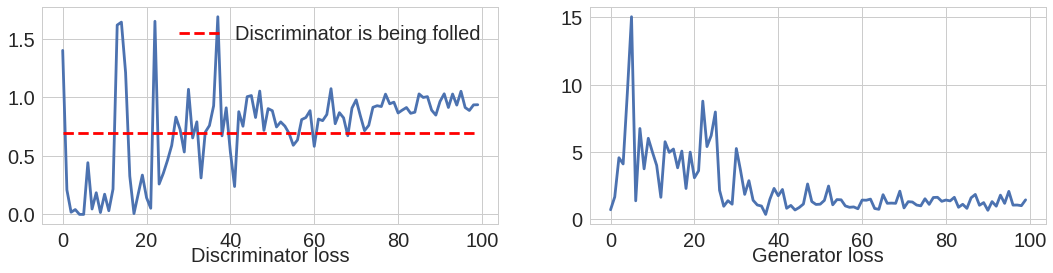

In [0]:
#@title
figsize = (18, 4)
fig, axs = plt.subplots(1, 2, figsize=figsize)


# First plot the loss, and then the derivative.
axs[0].plot(disc_losses, '-')
axs[0].plot([np.log(2)] * len(disc_losses), 'r--', label='Discriminator is being folled')
axs[0].legend()
axs[0].set_title('Discriminator loss', fontsize=20, y=-0.2)
axs[1].plot(gen_losses, '-')
axs[1].set_title('Generator loss', fontsize=20, y=-0.2)

### Generate and plot samples and latent interpolations

In [0]:
#@title

real_data_vals, final_samples_vals  = sess.run([real_data, samples])

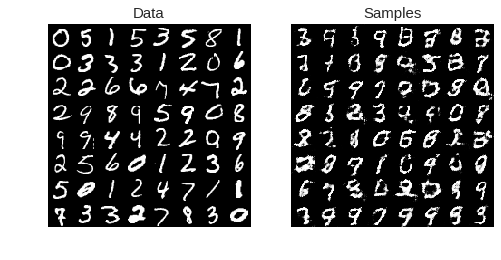

In [0]:
#@title
fig, axes = plt.subplots(1, 2, figsize=(2*4,4))

show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], final_samples_vals, 'Samples')

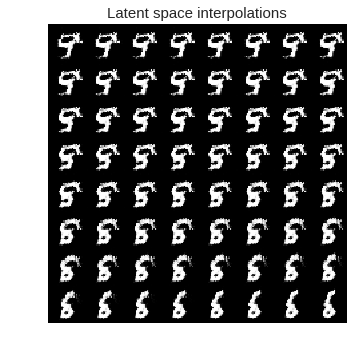

In [0]:
#@title
show_latent_interpolations(generator, prior, sess)

## Q2.2 GAN Questions (25 pts):  
1.  **[3 pts]** In defining the optimization procedure above (Section **Create optimizers and training ops**) we opted for two optimizer one for the discriminator and one for the generator. Is this necessary? Why would this be a good/bad idea in general? 

2.  **[3 pts]** Discuss the hyperparameter sensitivy of GANs compared to that of VAEs. (What happens to the model if you use a higher learning rate for the discriminator or the generator?)

3.  **[2 pts]** When would you want to use GANs and when would you want to use VAEs? Which of the following can be performed using VAEs, and which can be performed using GANs: density estimation, representation learning, data generation?
4.  **[2 pts]** What do you observe about GAN samples compared to VAE samples?
5.  **[3 pts]** What happens if you optimize the GAN discriminator 5 times per generator update? (This will become particularly relevant for next part) 
6.  **[2 pts]** What happens if you optimize the GAN generator 10 times per discriminator update?

**[10 pts] Model Implementation and Results**


1. It is neseesory to use two otimizer. If we use only one optimizer for the discriminator and generator, the samples generated were below:![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAfUAAAEECAYAAAAxhq2tAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi40LCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcv7US4rQAAIABJREFUeJzsfXlUVFe2/q6JUQZxiCAgK9LqirQh%0ALTHV6ovaaiKtTSRRE+LQYZk4PDXGZxL1GRR1OYsm2sYpioalETVG5TkbJ55ERUGgwQkQoZF5KKqh%0AqOHe7/eHv3sfCBQ13Ito7rfWXkpVnWmfs+++Z5999pYBAEmQIEGCBAkSXnjIn3cHJEiQIEGCBAnC%0AQFLqEiRIkCBBwksCSalLkCBBggQJLwkkpS5BggQJEiS8JJCUugQJEiRIkPCSQFLqEiRIkCBBwksC%0ASalLkCBBggS78Ze//IU2bdr0vLvxu4fyeXdAQvvE5MmT6datW6RUKgkAOTo60h/+8AcaNWoUffzx%0Ax+Tg4GBRPQ8ePKC8vDx65513RO6xBAm/DzAMQ7t376aTJ0/Sv/71L9Lr9fTKK6/Qu+++S59//jk5%0AOTk97y5KeI6QlLqEFjF69GjasGEDERFVVFTQP//5T/r222/pxIkTtHfvXnJ3d2+1jqNHj1J5ebmk%0A1CVIEAjr1q2j06dPU0xMDL3++uskl8spIyOD5s+fT0VFRdJu+XcOyfwuwSJ06tSJhgwZQnFxcaTR%0AaGjjxo1ERJSWlkaTJ0+mAQMG0JtvvkmfffYZFRQUEBHR/Pnzae/evXTy5En64x//SOXl5WQymWjD%0Ahg30l7/8hd544w0aMWIE7du373kOTYKEFwpXr16lkSNH0ptvvkkODg6kVCrpjTfeoC1btlBYWBgR%0AEeXm5tK0adNIrVZT//79aeLEiZSZmcnXMXnyZFq7di2tXLmSQkJCaODAgXT48GG6desWhYWFUXBw%0AME2aNIlKSkqIiOjGjRvUu3dvunLlCoWFhdEf//hHGjlyJP32228t9vP06dP0/vvv0xtvvEF//vOf%0AKSoqiv7973/z38fFxdG7775LwcHB9Oc//5kWLVrU6HsJtkFS6hKsQocOHSgiIoL+53/+hwwGA02b%0ANo1ef/11SkpKoosXLxLDMLRo0SIiIoqJiaE333yTRo8eTRkZGdS5c2f68ccf6ejRo7R3715KSUmh%0AqKgoWrVqFV2/fv05j0yChBcDf/jDH+js2bN05coVYhiG/7xv3740bNgwIiKaO3cueXh40OXLl+na%0AtWvk6+tLc+bMaVTP8ePH6Y033qDr16/T5MmTadWqVbRv3z7au3cvXb16lWpqaig2NrZRmR9++IG2%0Abt1KN27coGHDhtHMmTObVcRJSUm0YMEC+s///E+6desWxcfH0z//+U9auXIlERHduXOH1q1bR5s2%0AbaI7d+7QsWPH6NGjR7Rz506h2fW7g6TUJViNnj17klarJa1WS+fPn6fPP/+clEolubm50fDhwykt%0ALa3FspMnT6bTp0+Tv78/yWQyGjJkCHl5eVF6enobjkCChBcXS5cupb59+/I78WnTptHOnTvp8ePH%0A/G9++uknWrFiBTk5OZGTkxP99a9/pcLCQiorK+N/4+/vT3/9619JqVTSyJEjqa6ujiZOnEheXl7k%0A7u5OgwcPpuzs7EZtT5o0ifz8/MjFxYVmzZpFer2erl692qSP+/fvp5EjR9KIESNIoVCQv78/zZkz%0AhxISEqi+vp5qamqIiPjz/1deeYV++ukn+q//+i8xWPa7gnSmLsFqcLsDhUJBly9fptjYWMrLyyOT%0AyUQsy5LJZGqxrFarpdWrV9Nvv/1GGo2GiIgMBgPp9fo26bsECS86OnXqRDt27KCioiJKTk6mlJQU%0AOnToEG3cuJFmzJhBX3zxBaWmptLWrVspOzub9Ho9cXm7GspZ9+7d+f9zyrXhZ87Ozk3ksmfPnvz/%0APTw8yN3dnYqKipr0MTc3lx4/fkznzp1r9DnLslRSUkJqtZpGjBhBY8aMoX79+pFaraYxY8ZQYGCg%0AHZyRQCTt1CXYgMzMTOrSpQvdv3+fvv76awoLC6P//d//pYyMDIqKijJbdu7cuXTv3j3at28fpaWl%0AUUZGBnXp0qWNei5BwssDb29vCgsLo+joaLpw4QLNnj2btm3bRrm5uTRz5kx644036MKFC5SRkUHb%0Atm1rUl4mk1n0WUM0NPcTEQEgubypGnFycqKPP/6YMjIyGlFWVhb16NGDHBwcaNOmTXT27FkKCwuj%0ArKwsCgsLo4MHD1rJBQnPQlLqEqxCVVUVHTp0iN5//31KS0sjV1dXioyMJFdXVyIis6Z3oqdnae+/%0A/z717NmT5HJ5E5OgBAkSWkZhYSFFR0dTaWlpk++GDh1KRESnTp0io9FI06dPJ09PTyJqXS4tRUMT%0Af3V1NdXU1JC3t3eT3wUEBNDdu3cbfVZTU0PV1dVERGQymaimpob8/Pzo448/pp07d9K0adNo//79%0AgvTz9wxJqUuwCEajkZKSkmjKlCnk6+tLM2fOJD8/P9LpdJSZmUm1tbX0008/0aNHj4iI6MmTJ0T0%0A1IRXWFhIWq2WDAYD+fv7U1paGhkMBsrJyaGVK1dS9+7d+d9LkCChZXTp0oV+++03mjdvHmVkZJDB%0AYCCGYejhw4e0adMmCgwMpLfffpuIiG7fvk16vZ5Onz5NycnJRETNmsqtQVxcHP3rX/8inU5HW7du%0AJRcXF/qP//iPJr+bMmUK3b59m/bv30/19fVUVlZGX375Jc2bN4+IiHbt2kUff/wx5eTkENHTF4QH%0ADx7Qq6++alf/JEhn6hLM4OTJk3T27FkiIpLL5eTv709/+9vf6JNPPiEHBwd65513KDw8nKZMmUIO%0ADg4UHh5O33//PU2ePJnGjBlDv/zyC02YMIEWLVpEQ4YMoR9//JGWLVtGS5YsoTfffJMCAwMpOjqa%0AUlJSaOPGjaRSqWj58uXPedQSJLRfODg40IEDB2jbtm00f/58KisrI5PJRK+88goNHTqU1q9fT15e%0AXjRjxgz67//+b2JZlkaMGEH/+Mc/aPr06fTZZ5/Z5WE+YcIEmjVrFuXm5pK3tzft2LGDt9I1xBtv%0AvEExMTG0fft2WrNmDe94t2DBAiIimjp1KlVVVdEnn3xCGo2G3N3daeDAgbRw4UKb+ybhKWTgPCgk%0ASJAgQYKEZnDjxg2aMmUKnTt3jnr06PG8uyPBDCTzuwQJEiRIkPCSQFLqEiRIkCBBwksCyfwuQYIE%0ACRIkvCSQduoSJEiQIEHCSwJJqUuQIEGCBAkvCV74K22tRUCSIEHCU7T3kzZJliVIsAzmZFnaqUuQ%0AIEGCBAkvCSSl3gYICAgghmHotddee95dkSBBggQJLzEkpS4y3N3dad++fSSTychgMDzv7kh4CSCT%0AyWjq1Kl08+ZN2r59O3Xq1Ol5d+mlRZcuXUipVNI333xDRI2PCDp06CBI/UREoaGhdOPGDVGPILhM%0AbCqViv8sKCiIVCoVLVu2zK66e/XqRURte4TCtaVWqxt9LsS8EBEfKa+5hDX2oLn6fHx8hGsALziI%0AqF3TihUrwLIsCgoKRG0nOjqapxeBP56enoiJiUFMTAwAgGEY7N+/H3369HnufbOFAgMDodFo8PDh%0AQ3h7e4va1pYtW/D48WNERUVh2rRpCAgIsKhce4et/FCpVJDJZILzWaFQgIiwceNGREZGYvbs2ZDL%0A5fz6FaINZ2dnJCYmora2Fk+ePMFXX30l6toZNmwYFAoFevXqBSLCvXv3UFlZKUjdvr6+jXjn6+sL%0AJycnUeaGo4iICH5OZDKZoG3t3r0bVVVVovRboVBArVbD398f69evx8CBA+Hi4mJxebNy1EbyKhqs%0AYaRMJoOfnx927doFlmUBAJs3b4arq6vgk7Z06VIYDAZUVVVh3LhxgtZ96dKlZnlx6dKlRsp96NCh%0AogmTreTn54f09HQwDAOTyYSsrCyMHDkSBw8eRGlpKUwmExiGQXV1NcLDwwVpc+jQoS3yTKhxLV++%0AHCzLwmAwQK1Wi8a/3bt34+eff7apbHuHrTy5d+8eYmNjLX65sZZcXV0REBCADz74AMXFxcjOzsay%0AZcsEbePs2bNgGAanTp0SZQzXr1/n+WwymaDRaPj1unLlSkHbkslkKC4uRm1tLaqqqjBp0iTB6u7R%0AowdKSkqwaNEilJSUoL6+HgCwcuVKjBw5klfw9tKqVat4fnXs2FGUOenfvz8cHBywdOlSpKWlISgo%0AyOKyZuVIHPFsO1jDxL///e9gGKYJrV+/XtDJioqKgtFoBMuygixoTklz/+dw6dKlRr8RU4krFAoE%0ABATgxo0bAIAvv/zSpnrOnj3LP1R8fX3h4eHBf9e1a1eEhYXxCl+r1SIqKsruvrek0DkeCsG3bdu2%0AgWVZxMbGijYHRISSkhJERkbaVLa9w1aesCyLdevWicr3jh074smTJ7xc+/n5CVr/zJkzwTAMdDod%0AHB0dBa371VdfBcMwPJ+1Wi2/qSkoKIBSqRS0PTc3N9TX14NlWeTk5Ni1e+aUdFBQEE6dOgUAYFkW%0AJpMJ1dXVjdbP6tWr4eDgwJe1dVxyuZznT11dnVXK1hZSKBTIzc21ajNgVo6EFMrnAUsY0KlTJ8yY%0AMQMGg4FX5AUFBfz/NRqNIJMjl8sRGRkJhmHAsiwWL15stzmooRJv+HdDhS4GeXp6wsnJCa6uroiI%0AiMD58+fBsixPs2fPtrq+AwcOgGEYnDhxwuxvfXx8oNVqwTAMduzYYfdYhg4d2mTdPKvo7VXsbanU%0AG74IWUPtHbbyhGVZvP7666LxXC6XY8CAASgqKgIA/PTTT4K3sWHDBgCAXq9Hhw4dBK27qqoKJpOJ%0A53NmZiZKSkqg1WpFMY07OjrCYDDAZDLBzc3N7vpkMhm8vLx4RcuyLNzc3PhnOsuyKCsrE+xlKCsr%0Ai29LLB49u76ePHmC7777zuIyZuVIDOFsS1jCgMWLF/MKXKfTIS4uDpMmTRJUqatUKkRGRoJlWTAM%0Ag6NHjwoy4ZwS53bqnClZzEVGREhOTsbdu3eRm5vLC821a9fAMAwqKyvh7u5uVX1+fn6orq7Gnj17%0A4Ozs3Orvp0yZApPJBJPJJBgPOTRU4Bzs5emePXuaVepCPNQaUlxcnM1l2ztsGdM333yDH374QTQ5%0A4BTKvXv3wDAM6urqBDdXExFvRhb6qM7V1RX379+HXq/nn027du1CdXU1KioqROHZnj17AEBQ68ma%0ANWsAPFXocrkcLi4u6Ny5MwDAaDRCp9MJpnzPnz/PWzbq6upEW1scBQQEoLi4GBkZGRaXMStHYglo%0AW6G1wX/66aeora0FwzA4ePAg/v73v4OIsGDBAl6pX79+3e6J+e6773ih+eabbwSbcA5tfT5eV1cH%0AlmVx//59REdHo0uXLiB6uivatm2b1fU5Ojqib9++Fv++V69e/Bm7PeNouEvn/n72N9yu3Z52MjMz%0Amyh1R0dHFBYWYtiwYYLNy5o1a+xeS+0V1o5HqVQiJSVFkCOa5kgmkyEgIABffvklv/MsKCjgHeiE%0AJM4C9tprrwlab0hICK5fv46qqiqkp6dj7969mDBhAg4cOCCKWVkmkyEpKQl6vR6jRo0SpM7Q0FCw%0ALAuj0YiYmJhG5+Zff/01SktLsXXrVqsczVoiNzc3fj2yLIv09HTBzumbI5VKhbi4OLAsiwsXLlhc%0AzqwciS2oYsPcwIODg1FXVweGYXDnzp1G5pns7GxeqYeGhto1MU5OTrxQNqfQ3dzc0KdPH6sXXUMH%0AL+5vTimJqeR37twJhmHw+PHjRmeHnp6e0Ol0Fu207SUfHx/k5ubardQ5mOMXt5O3p53U1NQmZ7su%0ALi5gWRYbNmwQjC+SUv8/CgoKQm1tLZycnERZg3K5HPHx8aiqqkJFRQXq6uqwd+9eUdpiWRZPnjwR%0A1NTboUMHuLi4oHv37jh58iTGjRuHBw8eYPXq1SgvL4darRZcYfXu3Rt6vR56vd7mY6JnycXFBUaj%0AEcXFxViwYAH/uUwmw8SJE5GXl4eCggJ89NFHVinG5mj79u385qympgYlJSXw8vISTbEPGjQIBoMB%0AGo0GmzdvtricWTlqI3kVDS0N2svLC6mpqfwOvaFC79atG6/QjUYjVCqVXRMzZ84csCyL/fv38585%0AOzvjk08+QXR0NAoKCsCyLPLy8vD5559b/BCyBEJ7uy9fvpzfkQQGBjb67sKFC9iyZYsoi/tZWrhw%0AIT9Httbx7NFFa3y2tZ3XXnuNN2823JXL5XKcOnVKUKU+f/58m8u2d1g7nrlz58JoNIq2Bn19fWEw%0AGGAwGKDX63Hy5ElBdoMtzY0YO2eFQoHu3btj4cKFKCsrw+XLl/lNjhgWh/79+8NgMODYsWOC1enq%0A6gqGYZCYmIjRo0fzn7/zzjv45ptvYDQacf78eRQXFyMsLMyucXF+E9xRS35+Pqqrq/H1118Lzis3%0ANzds2LCBV+qHDh2yar20KEeiS6rIaGnQgYGBvFLgziE7dOiAiRMnIiMjAwzDQKvV2r1LHzBgAAwG%0AA+Lj4+Hi4gK1Wo1Fixbh119/beRY1pDi4+MtcupoCc+eET/7nT3jWb9+PQwGQ5MXBC8vL5SVlTXy%0ALhWLOnXqhMePH8NkMuH48eM21cGZ3S05K29tLbVG48ePB8uyKC4ubnL9JT4+XlClzh0f2ULtHdaO%0A59KlS9BqtaKtw+PHj/OOWBqNBh999JHgnulETxVvfX09OnfuLNpYuOM04KlZ+erVq6LsPs+dOweD%0AwSDolb9XX30Ve/bswbx58+Dg4IDAwEAMHToUixcvRmpqKvLz82EymZCamoolS5bYtUkzmUxgWRZF%0ARUXIzs6G0WhEfX09tm/fLspLkLu7O3777TcUFBRYpYvMylFbCKuYaGnQDZV6dnY29u7di5SUFMGv%0Asl29epX3vj19+jRqa2sbKfCysjLs2LEDffv2hY+PD9asWQOtVovvvvuu1SsXHFpTTEOHDm3xqptQ%0AtGHDBrAsK3i9zdHOnTt5J7np06fbVAfHj9asF8+euVtLKpUKv/32GwCgpKQEw4cPb/T9oUOHEBMT%0AIxhvhgwZYnPZ9g5rx1NTUyPqmuzVqxd/kyUjI0PUYyeGYdC7d29R6p44cSLq6up4PtfW1mLt2rWi%0AtMVdl+vZs6dgdQYGBuL+/fvYv38/ioqKUFFRgZEjRyI4OBjFxcUoLi5GYmIiAgIC7HZMraurw61b%0At6DVanH58mVUVFRAo9GI5jDn6OiIR48ewWg04tatWxaXMytHYguq2DA38D59+mDz5s04duwYT3Fx%0AcWAYBhMmTLBrMtzc3JrswOvq6rB48WJ06tSp2TIKhQLr168Hy7LQ6/WCB7159uqWUOfuX3/9NViW%0AFe1BoFQq4efnh1u3bvEP0bS0NLsiswGWvQxZ8ruWaO7cufxDrDlKTU3FrVu3BN2pcwGNZs6ciZkz%0AZyIjIwMXLlywaC21d1jDB4VCAZ1OJ6r5fe3atdDpdNBqtThy5IhoV5scHR3BMAwuX74sWJ0ymQxK%0ApRJjx47l1yPDMCgqKkJ0dDSCg4MFH0dsbCwYhoFerxfUoqFUKjFmzBisWbMGRqMRSUlJkMlk6NKl%0AC3Q6HQBAo9GgR48egs2Ri4sLHBwcMHz4cHz77bfIzs4WLIrgs+2kp6cDAJKTky0uZ1aORJdUkWEt%0AEzdu3AiGYTBo0CC7JoNT6tx5W25uLkaOHGm2zOnTp3kB++ijjwRfIESNFbtQO/abN29Cq9Wia9eu%0AgvfXx8cHCQkJ/M6ciyiXmJiI+Ph4LFiwACtWrEB8fHyLL0st8cDcUURDPtl6ZJGens7PZ1RUFMaP%0AH4+FCxciISGhkcVGSKVeXFwMf39//m8HBwckJydbdD++vcMaPjAMg7y8PMGcsZ4llUoFlmVRXl6O%0ABw8eiHaWzo3l4sWLgprfVSoVlixZgsePH6OoqAgmkwlVVVVITU3FggULMHbsWPTo0QMODg6CKMKw%0AsDAAQF5eHrp16yboC5C/vz/UajUiIiIaWTeVSiU0Gg2/fsrKyvDuu+8K1q6DgwO8vLzwzTff4Nq1%0Aa6Ls1nv37g2tVgudTsffMLKEzMqRqFLaBrCGgQqFApcuXQLDMHafDbu6ukKr1aK8vBzFxcW4f/++%0AWUeXzz77DCzLQqfTYfHixVad+3DmdUuVtK38aY769euH+vp67Nq1S9DFHBwcjGvXriE3N5ePINdQ%0AqTf822QyIS8vz2KlbomDHHerwJ4XH05pp6SkNDlKGTt2LJKTk5GamiqYUg8ODkZ+fn6TXfmwYcNQ%0AV1fXapjU9g5L+aBQKAA8vUMs1u6Zc35lWRbjx48XpQ2ipzdKAOCzzz4TtF6ZTIaOHTviww8/xNGj%0AR1FWVobExEQcOnQIt2/fxpIlS9CrVy84OjraxEOuDPcvdxRibwS5lsjd3b2JD0BgYCAMBgO/fr78%0A8kvBnQ379euHsrIyaDQarFixQvBxbdiwAfX19aioqLBKJ5mVI/FEtG1gDQNDQ0N5j3chJmTEiBH8%0AYmZZtslbYnBwMNRqNXbv3g2WZVFYWIjBgwdb1YYtZ+UNo6XZO8bY2FiwLCuYsERERCAuLg4ajaaJ%0AEo+Li8P69euxYcMGrF+/HgUFBbwnvjV33Fu7oiYUf1iWRWVlpVmrj5COcr6+vgDQ5N57jx49UFtb%0A2+od5/YOS/lQW1sLAPDy8hKEr8+STCaD0WgEANy5c0eUNjjigpyIVX9AQACioqJQUFCAu3fvorq6%0AmrcuqtVq+Pj4COIwxz0DxXC+a8mUz11Xrq2tRX19PR48eIAlS5YI2vZHH30EvV4Pk8kkik/FkSNH%0AUFhYiB9//NGqq5lm5UhcMRUf1jCQCz3aWuQea2LwLlu2rNGO7ejRo8jIyEBRUREfJ5q7g2ptFDai%0Apkq9tXNyIbO0ubu7o6SkBHl5eTb1vSEplUoMGDAAhYWF/Lk557CYlZXFZ40Sgswp9YY7dHt9DlJS%0AUjBlyhSzvzl06JCg5vcrV67gyJEjjTxxR4wYgbS0tFbLtndYygMu5KlQPH2WunbtyveptQAq9uxK%0AXVxcrB67NaRQKODp6YnQ0FDcunULVVVVvBe80WjE0qVL4eXlZddOnejpEZrJZBItQh03lmc/CwwM%0A5H1a6urqsGPHDsGT+nz33XfQarUAgP79+ws+pqioKNTV1WH//v1W+SGYlSMRZLNNYSkTOnfuzEeW%0AsyYcX2skl8sxcuRIAGjkJMX9ferUKYSGhtoVIKO5hCQNd+3NxTYH7HeU48LeCmEa9PPza9bEbkt0%0AutaoJfN7w7j5QjgRWpIwQugrbUFBQXjy5AkSExMxf/58fPPNN9BqtRbtUNo7LBn/66+/bnf8gtaI%0A26UDEOUKG0fJyclWjd1SkslkfO6GXr168RnguE0Gl+b1l19+sdn5i0tzGhERgaysLGg0GovOs/v1%0A62dVohVnZ2ecP3++kU9DwxcKBwcHZGRkICYmRhT/isjISCQnJ6OiogIlJSWCz9PVq1fBMAzS09Ot%0AOpI1K0eiSWgbwVImrF27ln8YLF26VPDJF5vM3U1vDkIordjYWBgMBvTr18/uuppT6mPHjhXt3jsH%0AzheBQ1vEzW9I4eHhePLkSZNAPvZQly5dsHfvXty8eRMJCQmYNm3a78b7/dNPP4VOp0NZWZloc8a9%0AlAsZT7w5KiwsBACLXlBs6YdKpUJISAiuXbsGvV7Pt3Xx4kUsX74cERERdvVfJpOha9euMBgMiIiI%0AaLWPrq6uOHDggE1tubi4NFu/p6cnvL290a1bN1HmKCgoiL+7LlTY24b0888/875WPj4+FpczK0fi%0Aiqn4sIQB/v7+KC0t5b2qxQzyIDZx0eOe3b1fapBLXajFXFVVhcOHDwtSX0OlfvPmTYSFhYnKp5as%0AF89jzjIyMkTNImYptXdYMobRo0cjIyMD48aNEyUYCNH/KXVbFZCllJmZCb1ejzNnzghab5cuXXgF%0AqFKpkJubC71eD61Wi2+++QZubm4YNGiQ3S8sKpUKfn5+CA0NtWguFAoFevbsadW8OTk5NTqn5ywE%0A3GdyuVzw1LENaeLEifz6FCPXvUwm4y3I7733nsXlzMqRqFLaBrCEAREREfwu/YsvvhBtAbxMtHPn%0ATrAs2+aJZIQkLnY+98LzvPvzvKm9w5IxiPkA50ij0Qh+NtscTZgwAQqFQvTUngqFAsHBwXB2dhYl%0ATr41znHh4eGi81VIKi0tBfDUwiGGed/FxQV6vR6PHj2SvN85WMIATqlv2LDBau/z3ytVVVVBq9Wi%0Ae/fuz70vEglD7R3Pmz9ET18awsLCRM3MxZHYyvx5t/cyUHV1NQDg4MGDoliGXF1doVarm4SXbo3M%0AQfb/hemFhUwme95dkCDhhUB7F3VJliW0R8hksnYnO+b6I2/DfkiQIEGCBAkvFNqbQm8NklKXIEGC%0ABAkSXhJISl2CBAkSJEh4SSApdQkvNXr37k0FBQUEgDIyMkipVLZJu25ubvTdd98Ry7LUs2fPNmnz%0A9wLu7H3w4MHk5OTU7G8cHR0FacvBwYFkMhl16NChyXdyuf2Pz4Z+BBs2bCC5XE7h4eF212spuDE4%0AOztbXZbr+759+yglJYWIiJevl9E/4kUZk6TUXyK88847tH//fvL09HzeXWkXmDNnDl27do0uX75M%0Ay5YtIyKiU6dOUceOHUVtNzw8nC5evEjvv/8+zZ07l3JyckRt7/cGAOTl5UVr166lrKysZn+j1+sF%0AaWv06NH04MED+ve//93kO5Zl7a6fO6/18fGhv/71r1RdXU3nz5+3u15LIZPJKCQkhHQ6ndVlAZBC%0AoaDdu3fTiRMn6NatW+Tk5ETdunWj0aNHU48ePUTo8fOBr68vvfHGG6RQKJ53V1qHeBdU2gbUDq49%0AWEo///wzampqBM8kRPQ06cH58+dhMpkwffr05z7WlmjUqFHYsWMHH063rKwMb7/9tlUhEi2hgIAA%0AGI1G/PTTT3x2NwcHB7Asi6ysLNHGN2LECOj1ejAMg8mTJz93fjek9g5rxqJQKGA0GjFgwABReabV%0AanHz5k3Rr4M5OTnh8ePH0Ol0mDBhQptcP3NxcYGrq6ugsufo6IiIiAhUV1dj8eLFova/LWIWED29%0ACti3b19+vYkxN71797aqXrMCDTDoAAAgAElEQVRy1EbyKhraYlKFIGdnZ7Asi6SkJKvy5pojtVqN%0A8ePHY/z48bh16xYfsS0kJOS5j7c5GjNmDKqrq/lAQA1p3bp16NWrF4YPH47hw4fbfSd069atWLdu%0AXRNBiYqKAsMwmDZtmihjvHjxIhiGwcOHD0Wpnwstevv2batjLrR3WDOWiooKPo75s98J9dD97bff%0A+L6JcUfZxcUFcXFxMBgMCAwMRFFREfR6PZ8VUQzlwY1DqVQiISEBISEhgsW3VygUCAkJwYMHDwBA%0A1AQvRGRxeGQhiMuDIUY0UplMhqioKHTo0MHiMmblSFQpbQPYwsSAgADMmTMHn3/+OUpKSnjFAjyN%0AHGRLjF+5XI6IiAjs3bu32RSYf/vb38CybJO0mbZQr169EBcXB61W22wOcl9fX7Pl7bEU9OvXDwMG%0ADLD6ITdq1KhGCv3ChQu4efNmI8VeXl7O/z8jIwPr1q2zmV9DhgxpNqBDcHAwWJZFZmam4KkUp06d%0ACp1Oh7y8PPTs2VPQuokIkydPRlVVFfLz88EwDCorKzFw4ECEhIRY9CLX3mEpHxQKBbZv395Iacjl%0AcvTp0wcODg6CKENPT08+XGx5eTn/MFcqlS2ufUtkgktMolKp4OvrC51Oh8mTJ0OhUGD16tWN4s4L%0Abb2KiIjApEmToFKpMGzYMDAMI/g67dSpEwoKCgAA1dXVgssAR0qlEufPn0fXrl1Fa6MhpaSkwGg0%0AihKUSCaTIS0trdXndkMyK0fiiqn4aG7AXbp0wbFjx3D//n3s3LkToaGhCA0Nxa5du/DgwQM+T3dD%0ARcj9XVRUZFOKveXLl4NlWZSUlGDMmDGNvuvYsSOSk5Nx9OhRuxaFUqnEe++91+xOFwBKS0tx/vx5%0AuLm5ma3HluQiAQEB/Nsqy7JYuHChVeUNBgOf+3jEiBFQKpXw9PRsMoZnx2UwGAQVIE6pFxQUtMon%0Aa2jYsGF8DOfIyEhB+yyTyTB79mwYjUb07NkTHh4e2LFjB4xGI8rLy6HX61FaWmrXg6A9wBp+jBkz%0ABt27d+fX8pAhQ+Ds7Ay5XN4oo5et/OZSerIsC4PBwCtsoV4aiJ6mLFUoFPzD3NHRERqNBgBw5MgR%0AQdeQo6MjFi5ciH379kEul2PVqlWiHEO5u7tjy5YtAIDU1FTB6+fI1dUVZ8+exVdffSVaGw3pu+++%0AA8uyotStVCphNBpRUFBgcRmzciS6pIqM5gbco0cPZGRkNFLYDRV3enp6I6VeVFRkVyay3r17g2VZ%0ApKWl4ZVXXmn0XUBAAAoLC8GyrN1v3jExMfw4li5diiNHjsBkMiErKwve3t6CLbKtW7c2SiPbHJ09%0Ae9aqOrmc8n5+fvxnCoUCa9euxdq1a5st06FDB0yZMgUMwwhi4SD6P6UeHx8vGL98fX2Rl5cHhmEQ%0AHR2NXbt2ITMzE5GRkXZnZ+vevTvy8/NRUVEBtVrd6LsZM2bwLz+/l526k5MTysvLodVqceXKFYSF%0AhUGlUkGpVKJfv344f/683XmvJ02axPdJr9cjMzMTHTt2hFKphEwmg0qlEsTsq1KpGu3uVSoVLl68%0AiJMnTwpmEvf09MQrr7yCyMhIeHt7w9/fH99//z3Ky8vh7u4umAxw1KdPH9TU1MBgMAhuCWtIDg4O%0AKCwsxLx580Rrg6PU1FQAEEWpK5VK1NbWAoBVqV3NypF4Ito2sIWRAQEBvFLPzs5Gnz597JqY8PBw%0AsCyLQYMGNfnu4MGDvCK0dwFMnDiRV+rR0dH8/+3tf0Nau3ZtEwVeV1eHu3fvIioqiv9sxowZVtXL%0AsiwuXrzYxFKhVCpbTWTAMIxFuZotIU6pC5lY4vTp000sDCzLgmEYVFVV2VV3VFQUjEYjJkyY0Ojz%0Abt264dChQ2AYBllZWRY9QNs7Wuu/h4cHEhIS+LzgZWVl0Ol0UCgUUKlUKCgowC+//ILt27fbtZu+%0AfPkyL1vZ2dnQ6XQICAhAt27d4Ovri61bt+Lzzz+3y+rWrVs3fPDBB9iwYQP/d8eOHfHzzz9j//79%0AVpliWyKVSgUHBwc4OTnB09MTSqUSixYtwv3791FfXy/Y+m9IM2fOhF6vR1VVleDHBw1JLpfj2rVr%0A2LJli2htED21CNTV1QEQR6n7+PjwFsnRo0dbXM6sHLWFsIoJWxgZGhrKK/W33nrL7onZv38/Kisr%0A0bt370afOzk5ISkpCSzLWmQetYR2797dSHn88MMPgi0wd3d33L17t5FCP3bsGPr37w9nZ2d89dVX%0AYFkWFy5csDpjEafkbDnPZxgGx44dE4x/tbW1gp0lDho0CEajkR+bq6srXF1d0bFjR2zatAkMw2Dp%0A0qU215+amtpk7QwYMACpqan8GkhJSbGorvaO1vrPpQ9tCO64o6qqCklJSaitrcXVq1ftcmwrKioC%0AAD6PtlarhV6vx9WrV1FYWIh+/fohNDTUrt10bGws1q5di23btkEmk8Hb2xtHjhzBmTNnUF1dLZjl%0ATalUQi6Xo0ePHvjhhx+wd+9eaLVaq4/PLKU+ffrAZDLh/PnzoqXGJXpq5Ttz5gw++ugj0dpQqVQY%0AO3Ys/ywUynrSkMLDw8EwDG7evMnf0rGEzMqRaBLaRrCFkceOHYPJZMLOnTvtPn+bMmUK9Ho9jEYj%0Avv/++0bC6Ofnxy+Io0ePguipo4w9b7BBQUGorq7mze7WLARLBIWzLGRnZyMkJAQKhQIdOnTAZ599%0Axo/Flhche5X69evX7Z4rIoLRaBTsBYuIeOtFS+b87du3g2VZm7MDJiQkoLa2FuPHj0dgYCCys7Nh%0AMBjw6NEjnDlz5nej1Dt27IiHDx828r/gUFFRwf8/ISEBCoXCrl10bW0t6uvreac1ALzVxWAwQKvV%0A8uZ4W9sICAjA0qVL0bVrV3zyySfQaDS4evUqqqqq8OjRIyxatMjutdnw/H/BggW4ceMG/5IiRgpW%0Aoqe+JcXFxTh37pwo9Tekx48fi3r1z9HREXV1dWBZVjSLgFqtRnp6OpYvX25VObNyJKxYtj2sZeKQ%0AIUNQUVEBk8lk94R0794dDx48aLSz1ev12LBhA9566y0kJyfznwcHB2Pq1KnIyspq4khnLcXGxsJk%0AMiExMVGUhTZo0KBG1ytmz57Nj2POnDk2vYGnpKTw6W+tLcs9yIXIcc2yLDZt2iQYr06dOgWGYXDw%0A4MFmv+ecAW25UUH09MiloqKCVyp5eXlYsWIFfH19+TP134NS379/P2pqalBbWwuTycSX4V4WASAn%0AJ8fu+VSpVKisrOQd5TiLHhd7oLy83O4rl9y955kzZ+Ls2bO4f/8+zp07x99oSUxMtNuJc8aMGZDL%0A5XBycoJCocCoUaP4I4XVq1cLtv6fpenTp4NhGFE93zl69OiRqPUHBwdDr9ejpqZGtFS87u7u0Gg0%0ASE9Pl+6pc7CWiYcPHwbDMJg9e7bdE3L9+nVe2SUkJJh1LOMUfHJyMoKDg+1q9+zZszCZTKirq8On%0An34q2qLu0KEDYmJi+DPiqqoqmxf3t99+CwDYuXOn1WW5I4xly5bZPBYfHx989NFHqK2txeuvvy4Y%0Aj1pT6kRPX0oSEhJsbsPPzw+RkZFN/Bh+T0qd6Kky7NSpE3JycmAymaDVankno7q6uibHX7aSi4sL%0ACgsLUV5ejsrKShgMBty7dw8MwyAzMxMRERGQy+Xo1q2bXe307NkTd+7cQVVVFR4+fIhLly7BaDQi%0AKyvLbiXy2muvYcCAAQgICEBoaCiuXLnCH180508ilNLKyMhATU0NSktLRd1FOzg44MSJE6LVL5PJ%0AsGDBApSVleHx48eitRMUFIRt27bhyZMn8PHxsbicWTlqC2EVE9YykfN4t1epjxo1ild2J06c4AMv%0ArFixgg+M0ZC0Wi02btxot0eoWq1u4pQlpKNcw0W9adMmvv/FxcV49dVXba5v+PDhvHKzdpdz8uRJ%0Au3fqv/76K1iWxe3btwXlk6VKfffu3YLP0YwZM8Cy7O9GqXPrcujQoYiNjYVKpYKXlxdqa2uxZ88e%0AQXdTbm5umDFjBjw8PDB69GgkJiZCq9Xi9u3b8PT0tLt+uVyO8PBwlJeX46effoJCocDy5ctRX1+P%0AJ0+e2D2WHj16oHPnzoiIiMD06dNx+vRp6PV6PH782KogJ9YSZ+FIT08XrQ2ipzcUxHjuceTh4QGj%0A0Yj6+np8+OGHorXTs2dPGAwGq+MSmJWjNpJX0WANA2fOnMkr9R49etg1GYMGDUJdXR0SExObeCa/%0A9dZbvDKsrq7GrFmzBFuAarUaJpMJ27Ztw+HDh2EymXD37l2r3vIsoZCQEH4MlZWVNp8Jc+Tg4MBH%0AW/vuu++sKiuE+X3nzp1gWRYVFRWCmPE5ak2pOzs7g2EYu/nXHEVERPC7R0uceNo7rF1PSqUSarUa%0A9+7dQ2FhoeD8JXrq/TxlyhScPHmSD/rTt29fu+t1dHTETz/9hOHDh6NDhw6Qy+VQq9X8hsDeXa6L%0Aiwu2bdsGJycnODo64tixYygtLUVCQoJoXunnzp3jj0PWrFkjShsc6XQ6UcPEGgwGGI3GRjEKhCa5%0AXI61a9fy/l3WlDUrR20kr6LBGkZ8++23vFIXYlJaUtQNlfqsWbMEXQjffvstHzWuV69eKC0thclk%0AEvS+5ujRo1FQUACWZVFfX49Vq1YJUu+8efN4R6Nn71ybI05xWbtD6tevH1asWIHu3bvzu1qWZQXl%0AFadYr1y50uzd5WXLlqG8vFwQRfAsubi48C88lhwptHdYO3a5XA5PT0+UlJTg73//u+D85Wjw4MGo%0Ara1FdXU1KioqWr2CaQl5eXlhxIgRjdbM+PHjUV1djaKiIrsVFhcAidvxR0dHo66uDllZWaIpqYcP%0AHwJ46lT4ySefiDYfRE+Vulh1Ozs789fYrAkIYy25uLjwvhrWetablSPRJVVkWMqEsLCwRgFnxEq2%0AMXHiRABPHXis9WhsjbjzbYZh4OvrC0dHR/5cNT8/3+76lUol1q9fzyu/jRs3Cv5W37VrVyxatAgM%0Aw1ik2CMiIlBZWWmTUkxISEBGRgYKCgpQXV2NYcOGITAwEBqNpsnxyOXLl7F582abxrRlyxZ+XnJy%0AcjB9+nTMmDEDlZWVYBhGEK/95uj3rNTnzJmDmpoa6HQ6sCyLwsJCUXagnTp1gsFg4PuYn59vt2lc%0AJpMhNTUVU6dO5RWsTCaDUqnEihUr4O/vL7hj1tChQ3Ht2jUUFRWJ4vkul8tRX1/POxUajUabnUMt%0AIS8vL1HGIZPJcOLECTAMg9u3b4tqDcjJyUFxcbFN13XNypHYgio2LGXCyZMnGyl1IRzlmqP4+Hhe%0AUQhx9taQGkaUCwsL47OymUwmREVF2V1/nz59+L6LGdShQ4cOSElJwcWLF1uMhObg4IBx48bh3r17%0ANpuuDQYDWJZFTU0N1q1bx3/u5+eHHTt2IDs7G5s2bUJkZKRduxdHR0fs2bOn2eAz5s7a7aWGSj0i%0AIqLV37d3WDruESNGNLraxl0169mzp6DKUC6XY/r06QAAg8GA6upq1NfX231f+f79+9DpdIiNjUVA%0AQABGjx7dyNwuhrIaO3YsampqRAsKI5PJ+MBVHDQajSgZKYkIr7/+Oo4fPy54vc7OzsjOzhY04FVL%0AVFhYCJ1Oh5MnT1pd1qwciSeibQNLmfCsUrcnLGxLNGTIENTW1oJlWWzdulVw78+goCDk5eU1CX1r%0AT3CThrRy5UpeqVdUVODixYvYunWrKAu6a9euMBgMKC8vx65duzBr1iwEBQUhKCgIa9as4a/AMQxj%0AcxsLFizAkydPMHPmTFHG0JCUSiUGDhyImpoafreyaNEiUaNqNVTqllwVbO+wdNze3t548uQJf4W0%0AuroaKSkpgh9xKJVKxMXF8RG/tFottmzZYrdcc7Hlb9y40cSUL5ZpfOHChfzzQqz1OHv2bH4uGYbB%0A5cuXRVv/bm5uuHv3ruAWDRcXF2zfvh0GgwFJSUmievA/fPiQD59tbVmzciS2oIoNSxgQEBCAjIwM%0A/s3enutF5igxMREsy+LevXuC79I5CgoK4hPSzJ8/H76+voI9CBpey7t//76oXp9EhK+++qrZ3W1D%0AsuUK3O+FlEolkpOTf3dKPSQkBO+99x5cXV3RvXt3HDp0CAMHDoSbm5ugD2GlUgkXFxfk5+fj7t27%0AqK6uttvBliMxo601Rxs3boROp8OtW7dENSkvWrQIWVlZuHv3rl1XUC2hyspKwZ+zffr0QV5eHrRa%0Arah+GlxbCQkJNt1GMCtHbSSvosESBly7do1/S83NzRXNJMQp9R07doi6GMSiwYMH4/PPP0dERIQg%0AzkCtkVwuR0hICDZt2sRfn8vLy+P/fvfdd0UJzfgyUXx8PJ/DoLXftnfYuoY6d+6MOXPmwMvLS3D+%0Aurm5IT09HfHx8ejbt2+bK2OhaMyYMTh58iTmzp0rajsymczuJEbWtCV0nQqFAmq1GqtXrxYt4EzD%0A/js5Odk0DrNy1EbyKhosYUBiYqIoyU8kkuh506pVq8AwzO8q9eqz5OjoiIEDB4rCX2dnZwwYMACh%0AoaF8atfnPee2kFwux6VLl557P4QiMV+uZDJZu59nc5D9f2F6YSGTyVr9TY8ePSg2NpaOHj1K//jH%0AP9qgVxIktD+0d1G3RJbNlRNrfI6OjqTX60Wpu63g4eFBGo3meXfjhYFMJmvX8mKub78LpS5BgoSX%0AV6lLePHR3pVoe4M5XsnbsB8SJEiQIEFCE0gKXThISl2CBAkSJEh4SSApdQntCu7u7nTq1CliGIbG%0Ajx//vLsjoR3iWTO9XC4XzXSvUChEqZdDSEhIm7X1PMDNi7e3NwUEBDzfzlgJufypelSr1W3W5tGj%0AR+2uQ1LqEsxi6NChBIAYhiGGYcjb21u0thQKBa1cuZLeffdd+vXXXwVZ4GJCo9EQAIqMjCQXFxfy%0A8/MjHx+f592tlx4AqEOHDkRE5ODgQL/88oso5luZTEbOzs4UEREheN1ET9f7/fv3yc3NjRwdHYlh%0AGFHaaQ5qtVp0HwbunFyhUNCDBw/o7t27grfBKV6hwfEmIiKC8vPzycvLS5R2GuL+/fvUuXNn++dF%0AnMspbQdqB9cLmqN58+bxfXw2i5utBABJSUmCJiQxR++88w7q6ur4KHwmkwmLFy8Wrb3w8HAwDAON%0ARiPaFaX4+HjBAohwEQpLS0v5WAharRbx8fEYMmSI3fUrlUr07dsXffv2xYEDB/iAPPv378eHH37Y%0AbAKZ1tZPe4atPNLr9XBzcxNlvWRlZaFnz56C1yuXyyGTyaBSqSCXy9v0CpVcLse0adPa5B62m5sb%0AcnNzYTAYUF9fL1jdSqUSCoUCLi4ueO2119CxY0fB++/j44Pdu3dj//79okaGJCLs2bMHLMsiKyvL%0AonkxK0dtJK+ioa0EwRpKSkpCfn4+JkyYgEOHDuHQoUOC1Hvo0CHk5+fzYz906BD8/PwE77+HhwfG%0AjRuHzZs384orLi4OV65cwdSpUxEaGip4m6NHj+YzFokV8Y+IwLIsysrKkJ6ejvT0dKxfvx4DBw60%0A+t7rihUrGoUdzsvLw+3bt/m/OUW/evVqm/v62Wef8S9TDV+suL9v376N/v37W1xfe4ctPFIoFGBZ%0AVpS1EhUVhcrKSmi1WkHr9fLywqpVq/DLL79g79690Ov1ouZaeJZkMhkOHjyI7t27i9qOm5sbKioq%0A+KQ7d+/eFaTeyZMnY8+ePfjss89w4MABmEwm/Pjjj4LzqGfPnigsLERBQYEoWRY5cnBw4KOdsiwL%0Ab2/vVsuYlaO2EFYxYSnjXF1d8cUXXyAxMRHAU+adOnUKcXFxgi7upKQkJCUl8X/7+flZ3Vdz5Ofn%0Ax78scBDKEsDRjh07UF9fj/3798NkMqF3796Qy+VYvXo1TCZTo/EJQa+++iq0Wi1YlsXKlStFEx4i%0Awu3bt5tkaGNZFtu3b8eAAQMsqsPNzQ0pKSm8cj1+/DimTJkCNzc3JCcnN1G+58+ft2kn2TDOf3NK%0A3WQyoaSkxGLF3t5hy3z27NkTAESJLrZz507k5ubC0dERzs7OgtQZEBAAhUKB4OBgDB48GKdPn8aI%0AESNA9HRnKOba50gul6OgoAAeHh6iteHq6or8/HyYTCYAQEZGBv70pz/ZXW+/fv1w8+ZN1NXVYceO%0AHcjNzYXJZEJhYaGg/ecyVv7666/Izs4WRakPGzYMlZWVAACtVgsAqK2tRe/evZv9fcM1blaORJTR%0ANkFrjHv77bdx7do1Pg0mwzD47bffUFtby/9dU1MjSGhDbifN/T1hwgSr+motNazfmvzk5sjDwwNX%0Ar17llQeXjtTPzw9xcXEwmUyIjo4WbAw9evRAeXk5GIZBcnKy4Dx6lpydndGzZ09MmzYNarUaR44c%0A4RV7fX29RSlM/fz8+LXzrEJ1c3PDvHnzcP36dT5LHMMwmDhxotV9LS4ubqTEi4qKUFRU1ETJFxUV%0AwdfXt9X62jtsmU+FQmFX0p+WyMnJCbGxsVi8eLEoylYmk2Hp0qW8idrBwQFyuRx+fn5wd3cXVQaU%0ASiUePXokalQ2JycnPH78GCzL4siRI4LU6eDggNTUVBQVFSE2Nhbe3t64evUqKisrERwcLGj/PT09%0AsXr1apw5cwY6nQ67d+8W9LhCqVRCo9Fg06ZNOH/+PLRaLZ+c6JVXXmm1vFk5aiN5FQ3mJmXlypXQ%0AaDSora1FcnIyFi5cyCvvHj164LXXXsP9+/fBsiz27dtnV7xzbufMmcO5HXpMTAwAiHYOzp3dC2Xi%0A3759O68sNm3axJ8/+/r6Yv78+TCZTKisrMSgQYMEEdLr16+DYRhUVlbC399fFB61RMOHD8fhw4cb%0A7djfeuutVsv5+flZlPFq9OjRvPK1xfT46aef8u1cunQJkZGR8PX1xbJly5CWltZo526Jtaa9w5Y5%0APHv2LB49eiT42jh+/Dh++OEHpKenw8vLiz8DF6JumUyGt956C87OznydLi4uCA8Px4kTJ0SPL//j%0Ajz/azO+G1JL1wt3dHWlpaQCAsrIy7N+/X5B+JyUloba2FsOGDcPGjRvRu3dvlJaWYs2aNYImqVGp%0AVOjXrx8yMzP5jIuPHj0StI0xY8Zg8eLFOHz4MDQaDa8/Kisr0alTp1bLm5UjccVUfDQ34FdeeYXP%0AXpWbm4vw8PBmfyeXy3Hu3Dk+hWNAQIDNkwQ0bwafN29eo9270MQp9ZiYGEHqO3fuHG/WbY4fnBIR%0A4iVi8+bN/I7X1pzptpCPjw8iIyNRXV0NlmVhMBiQl5eHuXPnWvRiZ6lSJyKo1Wo+69OSJUsEG8OH%0AH37YKJtdWlpaq2XaO6zlgUKhwIMHDwQ7q+UoMDAQ9+7dg1arxaRJk9CxY0dBd2nTpk1DQUEBb12R%0AyWQICgrC6NGj8eqrr4q69mUyGW8SF6K+5hRdhw4dkJOTA6PRiKqqKkGOLqZMmYLKykpERUXhT3/6%0AE2QyGTp27IioqCirHUZbI1dXV6Snp0Ov18NoNIJhGFy/fl3QNlavXo0DBw5ALpfDw8MD6enpMJlM%0AqKqqsuilzqwctYWwionmBhwdHc0/7MaNG9ciY8aNG8en/LT3LLe5vqjVagDCn3lzFBMTg/z8fCQl%0AJdntMNe/f3/s3bsXBQUFqK+vx4oVK5r9HafMMjIy7O7/xYsXwTAMDh48KGre4oZjPHv2LH9+X1dX%0Ah3Xr1ln9QhEdHQ2TyYSbN29a9PurV69Cr9fDYDBg9OjRgowlLCys0U79559/brVMe4e1POjXrx9q%0Aa2uxfv16QdfJokWLUFFRgZiYGISFhWHEiBFwcnISZKfm6OiIrVu3Qq/Xo1evXujSpQtUKhVqa2sR%0AGBjY5KVSaLngrD+28NsSUiqVuHLlCtLS0lBXV4eioiJ4eXnZNQ6ZTIYbN27ghx9+wLBhw/gXrJEj%0AR+LOnTuCP1/79OkDf39/aLVa6HQ6nDlzBqmpqYJmjGxoEfTx8cH27dsBACaTySJemZUj0SVVZDQ3%0A4OjoaLAsi7i4uBaZEhgYiLt374JlWQCw24kDQBPlCkC0XTr3wjBv3jxBPOB3795tkcIWUqmzLIvy%0A8nJ07txZFB5xFBYWhhMnTkCv14NlWZhMJpw/f94iL9PmKCYmxuIc5kRPTW3c+XpBQYEgV+p++OGH%0ARkp93bp1rZZp77CWB926dYPBYECXLl0EXS8lJSWor6/HwYMHcfXqVZw5cwbXr18X7Fw1OzsbAHDy%0A5En88ssv8Pb2hk6nw6+//oq+ffvalF/bElIoFNiyZQtMJhPKy8tFaaN///64ffs2tFotLly4IMhx%0AgoODAxITE3H27Fn4+/vzu1uDwYDq6mre0VAIkslkcHBwwLvvvou6ujpotVpoNBpUVFQImuGzYZpg%0AuVwOrVYLo9GI8ePHW1TerBy1hbCKieYGzO3Uq6urER0djTFjxiAwMBBjxoxBdHQ0CgoKGpkuw8LC%0A7J4kPz8/JCUlNeqb0Ardz8+Pv9LGXZkT6kpb7969kZ+fD4ZhkJmZ2eLvOJ5t3brVrvY8PDyg0+l4%0AT09/f3+cPXu20bxUVlYKIkihoaF49OgR/6Ln5ORkV30hISEwmUwoKCiwuIy3t3ej625du3a1uOzx%0A48dRWFiIY8eOoaqqqllv+GXLlrVaT3uHtfMQFBQEvV4vmHxxddbX16Nz584YNWoU/va3vyE/Px+F%0AhYWC3PqQyWSor69HXl4e1Go1Xn/9dTx58gRGoxElJSUoLS1FVFSUYN72DSk4OBhVVVXIyckR7N41%0AV49cLseYMWNQU1MDvV6PTZs2WeTwZQlVV1ejvLwcp06dQkREBKZOnYojR45Aq9Xi3LlzgvKIewFR%0AKpVwcXHBrFmzkJycjKysLEHvqn/wwQdwdXWFXC5Hnz59cOfOHVy5csXi8mblqI3kVTQ0N+A+ffrg%0A0qVLvGmdUxJGoxFlZWVIS0vD48ePwTAMsrKyBBeehso9Pz9fMMXLOd09CyHuqz969IhXELt27Wrx%0Ad9xv3nvvPbvai4qKQuzvqmgAACAASURBVE5ODoie3seuqKgAy7K4ffs2jh49inv37oFhGIwdO1YQ%0A3nXq1AnLli0Dy7J2vyg0PFO35p54w+tu1twgyMjIaLSOuTutDf9mGAYrVqwwe77Y3mHtPMTFxeHx%0A48eCOjAREX9e6+TkhLFjx+LcuXPYtm2bYHfJu3btChcXFygUCoSGhuL7779HWVkZUlJSYDAYsGTJ%0AEri4uAg6Ju5KakFBAa5fv26XU/CzvOrduzeGDx+Ouro6GI1GlJeXY8+ePYI891QqFbKzs3H48GEc%0AOHAA+fn5KCsrg0ajwbFjxxAUFNSkjFCOhi4uLujbty8yMzOh0+kEVeoTJ05ESEgIIiIikJGRgS1b%0AtmDdunWNLEEymazF69Zm5aiN5FU0tMS0Hj16YObMmRg1ahTWrFmDUaNGYfjw4fz3Wq0WDMMgMjJS%0AUOHhGJ6fn99oVy10G2q1usl9dXuEqKKiwiKFLZRS37NnDw4fPoz4+HjeGWX9+vX8A/ry5ctgGMYi%0Ab3RLqVOnTmBZFtOnT7e7rvj4eD5QjqUPYM5sb43pnuipUm/pnvqzn5lbz+0d1s5Bbm6uaIFniAid%0AO3dGeHg4tm/fDrVaLZgidHBwgFKphFwuh5eXFwICAuDo6Ijly5ejpqYG58+fF/xFxd3dHWVlZdBq%0Atbh//75gZ/Xu7u5QqVTIzMxEfX09dDod0tPTMWjQIDg7OwtyXBEbG4uUlBQkJCSgqqoK2dnZePTo%0AEd566y106tRJFH8cmUyGTp064dKlS9Dr9WaPcm2hWbNmYfbs2UhMTMTNmzeh1+uRk5PDX01ujW9m%0A5aiN5FU02MpULrKY0IuBO+v28/NrFHhGqHvkzRF3X90eD/i6ujpeOSxatKjZ3yxatAgmkwllZWUW%0AB2ppiWJjY/lrZAaDAREREfxinjBhAliWRXx8vKB84qKPCeFYFR4ezitSc86YDSkmJobnsTV96Nix%0AIz744AMsWbIES5Ys4R2sunTpgnHjxjVS6r/88kuLD4T2Dmv4n5OTA41GI7j5/VnKzs7G48ePbYoz%0AYI6ae0Ho06cPSkpKwDCMoEpdJpOhqKgImZmZqKmpQUhIiGD1Ej3dTZ85cwYsyyInJwcLFy7kncrs%0AfRFycnLCO++8g4sXL/IvEGq1GqWlpRg8eDCcnJwwefJkweddLpcjIyMDAKDRaAS9ZqhSqeDs7Iz+%0A/fsjISEBBoMBlZWViImJwZMnT6BQKFptz6wctYWwiglbGcswDJYvXy74YmjO453zUBe6rYbEecLb%0AWj4nJ8esE9z48eOh0+kEiyi3Z88eftf6ySef8II0fvx4MAyDx48fCxoCt3v37ti8eTNYlhUszC2n%0ASO/evdvitcmGdOLECZ7HQlgLiJ56UycmJjbavbekgNo7rBm3RqMBANTU1Ai2Rpqj8PBw6HQ6UUIj%0AP0uHDh2CwWBAXV2doErE0dGRdwouKSkRpe8FBQUwGAwoLCxs5ATWkGzdUT/7guPk5ITt27dj165d%0A6Nq1Kzw9PQUfj0qlgtFoBACMHDlS8PplMhmUSiVu3rwJhmFgMBjQv39/i1+CzMqR6JIqMmxh6Jgx%0AY8AwjN27zeaIuzfeUKlzJnIxhEmoNrjAMiaTCRqNppEZd8CAAVi7di0feObDDz+0u78zZ87kneFW%0ArFiB6Oho7N27FwzDQKvVCnaWTvR0B/Tzzz+DZVnMnDlTsLOxEydO8Ir09u3bLSZx6dWrF+bNm8f/%0ANisrS7AQnc7Ozrh161Yjpd6rV69mf9veYemY9+3bBwAoLi622+mxNTpy5AgePnyIKVOmiOK8xpG7%0AuzvvK2HJTQZLSS6XY8eOHdDpdKiqqhL8rJ6j2tpasCzbYlAqmUwmqJn84sWLSExMxO7du6FQKAQ3%0AwQ8bNgz19fWorq4WJVkM0VPLIZfs5v79++jWrZvFZc3KkeiSKjJsYWZpaSkePHggytURTrk+D6Vu%0Azw7ax8cH9+7d4xW7VqvFJ598grlz5zY6vxXybOlZRy8u6cOwYcMEa2Py5Mn8dbKHDx8KyvP+/fuj%0Apqam0RiWLVvWyLNdqVSisLCQHx8X3lKI9gMCAnjfA04hHDx4sMXft3dYOm7OLJqSkiJ69iwiQn19%0APbKzs3H79m3RMpsFBQXBZDKBZdlmnb9sJaVSiV27dkGv1+Po0aOi8Esul0Ov10Ov15utX0jl6+jo%0ACI1Gg5qaGmRkZAj+snLu3DlUVVWhurpa1LUVFhaG2tpa/qqepeXMylFbCKuYsJaJw4YNA8uyePvt%0At0WZJE6BNwwLK7ZS587u7Y3yNmfOHNTW1jbrgGUymVBTUyPonfK4uDheIZ04cQIRERGC7IYUCgWG%0ADRuGc+fO8XfTCwoKBAlt+ywNHjwYpaWljXhVWlqK+Ph4xMfHIyEhgf9u1apVFsVob448PDygVqvR%0AtWtXjB8/Hps3b27k3GgymXDr1i2zd3bbOyzhg4+PDx88aPPmzW0StGjBggXIyMjAo0ePUFdXJ0ob%0A9fX1KCkpQUpKilXXHc0R5+x18uRJMAyD06dPC95vzgeGYRjU1ta2yXwQPT2rT0hIQEZGBkwmE2bN%0AmiVY3X369IFer0dmZiYmTpwoaHjghn97enoiJiYGxcXFVr8smpWjNpJX0WAtY0+dOgUAouVfVqvV%0AfOpV7kw4KSlJsDCuz5Kfnx//0iCEM957772Ha9euobq6upGiOn36dKPbA+2VunXrhlOnTjWK5z5/%0A/nxRM1L16tULhw8fbjGbWl5eHr7++mu72rh8+TLq6up4Rd6wHZ1Oh02bNrX6QtTeYQkfRo4cifLy%0ActTW1qKiokIwj3RzNGnSJBiNRlGsPRxxd+FLS0sFqY87h+7YsSNWr17NJwsRMioaRwUFBTCZTJg7%0Ad67oc8GRQqFAWVkZ9Ho9tFqtoJuNjIwMGI1G6HS6Fp2GbaWGMurl5cVH8JSUegNYw4ihQ4fyZlAx%0AF1xzQWLEaIerX6wXhheJXn31VSQlJaGwsBCbN29uMX3hi0offvghTp06BZPJhDt37mDLli344osv%0AWjw/b2m9tGdYMgbOzNpWO0KipyZSlmVhNBpFu8USERGBPn36iJKhzcXFBQsXLkS/fv0Er1ulUiE1%0ANVW0YwlzdPLkSaxdu1bQts+dOwetVospU6aI7q8xdOhQPHz4EHl5eVaXNStHbSSvosEaRmzZsqVN%0AlLpEErVHau943vxpiXx8fFBZWYnjx4+LmvNcLOsh0VPlK4bi9ff3F3w3aymNHDlSUMuDUqnEvn37%0AEBkZKXqmPKKnfgHffvutTWGOzcpRG8mraLCGEatWrQLDMILff5ZIoheB2jueN39aog4dOsDT01OQ%0AmP3Pi8Tadbq4uIj6MtLWJHaWvIbk4eEBhUJhkx+ROcj+vzC9sJDJZM+7CxIkvBBo76LeFrIsk8ls%0A4oOt5SRIEAPm1qK8DfshQYIECc8VtipmSaFLeFEgKXUJEiRIkCDhJYGk1CVIkCBBgoSXBJJSl9Ai%0AXF1dafny5aTRaCgnJ4dYlqVvv/2W1Go1KRSK5909CRLaDI6Ojk0+CwwMFKx+hUJBXbt2Faw+SyGX%0AvxgqgOvn119/TUREDg4OFBYWRjKZTNB5eBYymYw8PDxEq5+DUqnk27MbIju0ig6y0fOwsrISr732%0A2nP3tmzPFBYW1iQnPUdTp0597v1rbxQaGoqLFy+2SfIPW6i9w5YxdenSRfQ7621xJ/7OnTttvh6U%0ASiVcXV3bJNSuEHMgk8n47GZEhK1bt6KgoICPwOfq6ip4m1euXIFKpRJlDXABgri6rcnMZw4vxmua%0ACDCZTFRUVCRK3d7e3nT16lVKS0ujgIAAweqVyWTk7e1NwcHB9OWXX1Lc/2Pvy6Oiurb0z701MM+D%0ATCoL6yFP6UhHWuxAqzw1Pl5i1FajLJMQW2NiO0SXJmo7om2iSVSI7RzjQBsThzjQjlFBeeKA4kDL%0ADIIVEGSmrCpquPf7/UHX/VEMBVTdiySpb61vKVW39rnn3LPvPsM+eyclkQEDBnR4fU1NDW9lt8bb%0Ab78tmOzfKgYPHkxGjRpFgoODX/Wt/CGwZs0asmDBAkGd2OLi4npkVers2bNEKpUKXo4BFEWRjIwM%0A4uXlRXQ6He/yFyxYQKKjoy2W03LmanjO9+/fJ4QQcuDAAeLk5ERu3rxJ0tPTyalTp8i3335rcZkG%0ASKVSsnHjRrJixQpB+pher+dOVUgkEv7KEH78LSyIGSMkNzc3XL16VbBRZUhICDfD/fLLL3mR6ePj%0Ag8ePH7eZMRv4xhtvtPlNdXU173UzlGduyss+ffpgzZo1ePbsmVEo15YsKCjg0rFaQplMhh9++KHD%0ANvvpp594DcixdOlSsCyLDRs28CbT0dERn3/+ObKzs7lc23q9Hr/88gvmzp0LmUzWZVm9HV2tR0xM%0ADJfAhmVZxMbGYsOGDVi6dGmbM79SqRQ0TXfpLLBhxlRZWWl0XwEBAYiKikJ4eDgePXoEpVJplO7T%0AMMOypC8tXboUMpkMFEXByclJkPC33t7eCA4Oxvz586FSqaBUKnkvgxACX19fAADDMBbLio+P7/C7%0ADRs2GD0nrVaL9957j9e6uLu746OPPuJFlqn+ceHCBWRkZCAjI6NLAXVM6hGPOvlK0JXG9PHxMXr5%0ADR48GGvXrhWkQxMijFHfsWMHZ4w0Gg22bdsGtVrNfVZYWNgmZKiQRn3fvn1m/X7NmjWc8VYoFPjm%0Am284Pn78mIuxrVarMXjwYLPvUyqVIi0trUODbmC/fv14axuDUd+4caPFsiQSCfz9/bkMb/X19ZDL%0A5dySoyFmdGNjIw4dOtSlACC9HV1pFwcHBy6bmWFbKDExEc+fP0dMTAwoimrz8uzu0qlhwAAANjY2%0AcHR0BEVRWLlyJaqrq3H8+HHeg7kY8mnb2toKkh6Vpmk4OzvDw8MDMpkMdXV1XG4KIcoCmo2sEPIN%0ADAsL455TTU0N71HgbG1t8c477yAhIYH3QVbLPklRFKZNm4aMjAyMHz++S783qUfCqGfPoSsN8Nln%0An4FlWS6uck8a9aioKIvlOTo64smTJ5xBX7VqFQhpnrHcuXOHM1Bnzpwx2h/j06jb2tri22+/BcMw%0A0Gq1ZhnDPn36cDP01NTUdq8JDg6GXC4Hy7KIj48HTdOQyWTYuXMn3n777S6HhdyzZ4+R8U5OTsbM%0AmTMhk8mQlpaGhoYGZGZmwtXVFTY2NoiJibE4XrzBqGdmZlrc3suXLwfDMJDL5XjnnXfajfGekJCA%0A4uJiMAyD27dvdxpusrejK+2SmpoKvV6PlJQUNDU1QalU4uHDh1AqlVCpVHB0dOzW3mR71Ov1AAB7%0Ae3t4eHhw+7mFhYVIS0sDy7IYO3Ysb7plb28PjUZjMm2uOZTJZLC1teUGIA4ODoiKisK1a9cENbjH%0Ajx8HAEHzzxNCcPv2bQCAUqnkdXXMwA8//BCZmZm4ffs2rwOG1oPO0NBQFBQUQK1Wd1mGST0SVk2F%0AR1caID8/H1qtlpvNDBkyRHCjzrIsAPCSWGTmzJltDLqBkZGRUCqVnPFaunQp9x1fRn3+/PkoKSkB%0AwzBQKBSYPn26WXKWL18OlmWh0Wg6VSbDTMze3p5LtcmybJcSmHh6eqK8vJxrkyNHjrRxBgoMDAQh%0Azctrt27dAsMwFueK79OnD29GPTg4GEVFRSgoKDCZrnXAgAHcgK+iosLk7Ku3o7M2GTduHJ4/fw65%0AXI6UlBRMnjwZixcvRmJiItLS0rBixQq8//77FjtMKRQKKBQKTJw40ehzmqbh7++P+/fvY+rUqbzo%0AFiH//30xd+5c3mQeOXIEV65cQXh4uNHnIpEIc+bMQV5eHm9ltSRFUThy5Ai0Wi1vhrCjlZb6+nqw%0ALIuysjLeHdkcHBxQVFSEpqYmVFRU8BZj3sbGBjRNc/dLURRiY2Nx4cKFbi3zm9SjHtJXwdBZ5YOC%0AgqBWq3Hz5k3us8WLF/fYTN1Soy4SiXD48GEwDIPi4uJ2r/nkk084w15cXMylIbTUqPv4+GDt2rVG%0A3u+xsbFmy9u+fXuXjLq/vz9nxC9cuMD9/5tvvul0FkbTtNE++qlTpzpUyLCwMC7XNMMw2L17t0Xt%0ANXv2bLAsC5VKhZCQEIv7UWBgYJdnnYmJiWAYxqift2ZvR2d1/Omnn7B161Z89dVXiI6OhoODA7Kz%0As5GXlwe5XI579+4hMDAQsbGxFr3k1Wo19Ho9t7JnME4URSE0NJRbreLLH2PGjBnQ6/W87d16e3tj%0AwYIFuH//fpvv+vfvjxMnTkChUPBSVmva2tri/v37kMvlgsg3kKIoLvVwcnIy7/LFYjHu3LkDtVqN%0A/fv38zpTN/hOUBSFoKAgNDQ0YNGiRd3KLWBSj3pIXwVDZ5UfOnQoGIbB+vXruc+ENupvvvkmGIZB%0AVVUV/P39LZLl5OTEGZ3Nmzd3eN39+/fb7BNbYtTHjBmDjIwMoyNtjx8/tqguMTExaGhogF6vx/vv%0Av9/uNe7u7ti7d28b57nU1NQu7QE6ODgYLbu3nqkY+M477+D58+dG144aNcqi+k2dOpW737CwMN77%0AlSkD379/f+j1emi1Wrz55pvtXtPbYaruNE0jKSkJP/74I86dO4ehQ4fi/v37SE9Ph0qlQnV1Nfr3%0A74/hw4cjPDwc7u7uZrWxSCSCTqcDADg7O0MqlUIikaBPnz4ICgoCy7JcPvuu7n92xu+//x4Mw/Ca%0AMMbDw6Pdz19//XXU19fj1KlTvPdPQpqNbV1dHVxcXASRb+D48ePBsiyysrIEcSqMiIhAZWUltFot%0AZs2axatDrb29PVxcXGBnZ4ezZ8+ivr4e5eXlGDt2bJcHo6bQfOL9d4yJEycSQghhGIb7bODAgSQ1%0ANVWwMv/yl78QQgjJzc0lZWVlvMjU6XTk73//e4ff//rrryQsLIyXsqZMmULWrl1LBg8eTAhpbrsd%0AO3aQDRs2WCT3woUL5PDhw2TevHnk0KFDxMHBgYwbN4789NNPhBBCxo4dS6Kiosif/vQno99dvHiR%0AjB8/3ugZdgWXL18mmZmZRp9t2bKF/Nu//RtxdHQ0Crzx8OFDk+3bFaSkpFj0+/awc+dOIpVKSUZG%0ABomNjSWFhYXcdydPniSZmZmksrKSlJaWksuXL5Nx48YRJycn3u/jVWP48OGkoqKCpKenkwcPHpCz%0AZ8+SP/3pT8TW1pYoFArCsiyZOnUqOXHiBPHx8SGRkZEkOTm52+W8++67hBBCCgsLSXFxMXFyciK5%0Aublk4cKF5NixY4SiKCISich///d/k+LiYl7q1t47ylIMHDiQPHz4kKhUKkJI89EwT09Pkp6eTgCQ%0ApUuX8lZWa8THxwt6DDAqKoqcPHmSEEJIamoq0Wq1vMqnKIo8fPiQrF27lsTGxpLi4mLCsixv8lmW%0AJS9fviS3bt0iAQEBxM7OjlRXV5O6ujpiY2NDNBqNZcfbhB9/CwvSyYgmJycHLMuitrYW5eXl3F63%0AQqFAVlaWxUuu7XHTpk1gGAZpaWkWyzLM1Dtbzpo0aRIvM/URI0YYedWXlJRg9OjRvLWNjY0Nli1b%0Ahqampg6PtLUkwzDdcnxqOVOvrq7Gtm3bEBcXh7i4OBw/fryN97uhjEmTJllcNw8PD2i1WrAs2+EK%0AQXe4dOlSblaoUCiwb9++NvdfUlKCH374AYsWLUJdXR2USiUXnKM1eztMtcW5c+cwceJELFq0CBMm%0ATMCtW7egVCq57ZypU6dCIpGgf//+ePPNN82evSUlJXH9AgDGjh2LefPmwcXFxegYHZ97uLt27QLL%0Asrw5lonFYlRVVRnNLsViMW7fvg29Xo+vv/5asIA6Tk5O0Gg0iIiIEEQ+IQTvvvsuWJZFQ0MD3n77%0AbUHKoGkaq1atQmlpKXbs2MHbTN3FxYVb/ampqcGLFy9QVVWF8ePHY9q0aV1e5jepR4JrqsDorPLn%0Azp1DXV0dnj59ih9//BHx8fEoLy/HX//6V8E63ebNm8GyLC9G/bXXXjPbqN+9e7dbZXl7e+Pu3buc%0AnMTERPj6+grSRhEREbh9+7YRq6qq2hj1/fv3d0suRVGYP39+p0fZsrOzjf42+CFYyh07doBlWWzb%0Ats0iOdu3bwfDMMjJyTHaW5dIJJBIJBg7dixSUlLa1EupVCI6Orpdmb0dnemBjY0N+vbtiwcPHiAn%0AJwcKhYLTDV9fX3h4eEAqlSI6Ohp1dXVmt73BaABATk4OvvjiC4wcOZL7rKmpiVdduHnzJqqqqrrk%0ABNoVTpw4EXq9HjU1NQgODsabb77JGXSVSoXQ0FBBdJoQgm3btuHSpUt4/fXXBZFP0zTnOKtQKLBr%0A1y7B6jJ27FisWrUK69ev53U7jaZpSCQSKJVKNDQ04Mcff0RgYCDi4+Nha2vbpQGEST0SXFMFhjmN%0AWlBQgOHDhwvWGficqRtkVVdXm9xTbs+ot/be7YyLFy/mgpskJCTwfu7TFA3nylsa9OTkZLOOzjk5%0AOeHZs2dtDJ5er8f27dsRFhaGTz75hPv86tWrFh+DMnDy5MlgWRaVlZUWySkrK0NRURHnpd8Ro6Ki%0A8ODBA6N61tTUtHttb4epejo7O0MkEsHHxwfz58/H+vXrsXLlSpw/fx7Xrl1DeHg4aJqGWCy2OKyn%0Am5sbysvLkZiYyH0mFou5o258O4EdP34cCoWiS7EGusK6ujputeHcuXOoqanhBkB8nMwwxaKiIuj1%0AesFCzx4+fBhKpRK5ublYvHgx4uPj4ejoKEhZUVFRePHiBerq6ngNQUtRFOzt7ZGTkwNHR0c4OzvD%0AwcEBBw4cwKNHj+Dm5tapDJN61BPKKiTMaVSWZQXt2EIsvzNMx/HW/fz8UFRUBIZhUFRUZNass+XS%0A9JQpU4y+GzhwIEaMGGGR53tHDAwMRHp6upExz87O5jUoTGvOnDkTTU1NYBgGT58+5V3+mTNnwLIs%0AFixYYLaM5ORkyOVyrF69us35c5qmsXXrVu7l/f333yMoKIj7PiwsjHuWLX/X29Gd9jEcL0tLS8PR%0Ao0d58xw31U/VajUAQK/X8ya3X79+0Ov1+PHHH3lbEp89ezays7Ph7u4OiUQCmqZx4sQJFBQUtLvN%0AxFe5hgFtSUkJ7+1fWFgIjUYDjUaDkSNHcp97eXlh5MiRvDvm0TSNkpIS6HS6Dle+zCVFUW0mEba2%0AtsjJyQEA6HS6TgcqJvVIcE0VGOY06m/VqN+7d6/N935+fkYBaIYNG2ZWOS1neteuXcOKFSuwYsUK%0A5OfnQ6FQcPvsFRUVqKiowNq1ay0ejUskEvz8889tZuc+Pj6CPRuapnHp0iWuri1fEHxx/fr1YFkW%0AZ86cMVvG7NmzuXusqqrClStXQAhBbGwssrKyoNFoUFlZib/+9a/tHtlLS0vDtWvXjD7r7ehuG50/%0Afx4qlQoajQZ+fn6C9RdfX1/OV4JhGKjVaoSFhfGyz5qfnw+GYeDl5cVbJLn2ouq5ublhw4YNcHJy%0Aglgs5gw5n17ds2bNwuPHj3mfOTs4OGDVqlXcO2Lr1q3cd46Ojjh06BDs7e2Nzn4TQrjAQea2YXp6%0AOi5fvmz2SYrO5Le8t9jYWMjlclRXV6O2thYbN240Wa5JPeohfRUM5jSo0Eadzz31lka99Tl1X19f%0Aoz3wgoICLmNRd+jo6Ghy/xlAu58vW7bMorqtW7euR2fohBBER0dzL+eUlBTelt1bMiwsDCzLoqam%0AxuwZhKurK5KSkjBt2jRMnjwZ7u7umDt3Lg4ePIjJkyebNXvo7ehufeLi4rh97oSEBMH6jKurK+Ry%0AOXefLMvi0qVLFhtEsViMsrIyXuJZdEaRSASJRILAwEAu+AnfEd+Ki4tx5swZ3p3XBg0axLW7Xq9v%0Adyl8+vTpkEgkcHJyQl1dHQIDA+Hr62v2kWI/Pz+sWLECz549492p0NnZud0B3IoVK1BdXQ2tVovF%0AixfD3d29w7JN6pFwKtozMKdRf0szdZqmMWfOHG7GNmPGDBDSfOa7qqrKyMguWbLErDJGjx5t0qif%0AOXMGp0+fxoYNGyCXy8EwDHJzc432HM2hSqUyigMvVCzqlrx37x4Ypjk637Rp0wQpw2DUWZbt8Lzw%0Aq2BvR3f1whCONCsrC7dv3+b95evt7Q2xWMzNbBcsWMDd61tvvWWxUZdIJKivrwcAzJkzR9Bnb29v%0AD0dHR86429raQiaT8TpTd3V1hUKhQGpqKi+rDhRFYejQoUZ9JDs7u8OBeN++fbFz504wDIOmpiZ8%0A/fXXZpft7++PmpoaVFRU8OpbZAhJ3TIhkIE0TaOoqAj37t3DggUL4O/v3+HzMalHPOtlj8Ochv0t%0AGXVCmpefDM5QOp0O1dXV3J6wgatWrTK789nZ2RnJ2r17N+Li4rBw4cI2jlre3t4IDAzskjOHKbq7%0AuxvN0tvLMicEs7KyuCOOQpUhlUq5cqxGvevoTl0oisKzZ88AALm5ue2+JPlmUVERd698rPDY2dnh%0A/PnzYFkWO3bsEPTe+/TpA3t7ey5MqZ2dHe/bXGFhYdBqtdBoNFw0PksZEhLC+TIA6HTLLzc3FwCg%0AVqstGrAMHDgQNTU10Gq1vG8nDB48uN3ARfb29ggMDMTWrVthY2Nj8n1uUo8E0M0ehTmN+uLFC0EV%0AiG+jTkizJ3trL2eDY9zs2bN71FPdUorFYjx48AAsy6KpqQnbt28X7NxsaxrazdI4751x5syZVqPe%0ATXSnLjRNY9y4cWhsbMT333/Pe1u1ZxBiY2NRW1uLkpIS3vQtLS0NarVakKhoBopEIojFYq5ONjY2%0AvCSaao9Lly7Ftm3buBVFS59BSUkJN/DvynZBQkICWJbFsGHDLHqnSCQSDB06FKWlpdi7d69gz6Yl%0AKYpC//79Of8KqVRqXX7vLZw9ezZycnKwfPlyXuV6eHggPj4eWVlZKCsrQ3x8vJHX82+FUqmUU9T2%0A4lMLSYNR/+qrr155O/Q0ezu6Wx8XFxcUFBT02IDQy8sLH3/8Ma99lqIok+Gff2ukadosvx5TlEql%0AXQ6ha2dnh6yscttmAQAAIABJREFULIsHLWKxGElJScjPz++x/mXoD12ZCJjUox7SV8HwqjuxleZ1%0A3I8//hgZGRmCBgFqjwajfvbs2VfeDj3N3o7u1qd///494ofRkkLsfQvhrPl7oqksha0pkUjw8ccf%0A82KIR4wY0WtXQE2B+j9l+s2CoqhXfQtWWPGbQG9XdXN0WSwWE71eL8Dd9BxEIhGvcd9/b6Bpusux%0A1319fYlCoSA6nY5oNBqLygRAbG1tiVqtNluOUDCly1ajboUVfxD0dlW36rIVVnQNpnSZ7vAbK6yw%0AwgorrLDiNwWrUbfCCiussMKK3wmsRt0KK6z43YCvJXxDjvOAgAAuh7qQ6NevH1m0aJEgsg33bvjX%0Azc2N+46iKEJRFImNjRWkbLFYbNHvDfenVCqJu7s7aWhoII6OjmTq1KlkzZo17ZbB9zZOQEAAoWma%0AODg48Cq3PRjKcHFxIYGBgaSwsLDbMixr8d8AHBwciJOTE4mJiSF//vOfyZ///Gfi7e1Nrl+/zl2z%0Ae/duUlxc/Arv0go+MXr0aPIv//IvJCoqivzlL38hhDQrOgBy4cIFkp6eTo4fP06Kiop4d1Dq27cv%0AOX/+PKmuribR0dG8yraiYxier52dHXFwcCBVVVVmy7K3tyfl5eXk/v375OrVqyQ8PJzExcWRX3/9%0AVRC/BB8fH1JSUkK8vb15l00IIQzDEIqiCMMwRCQSkYaGBuLu7k5qa2vJ+PHjSWlpKTl58iTv5To6%0AOpKXL19yf5vjEAiAUBRFSktLSUFBAWEYhlRWVpKtW7cSAGTKlCnkxIkTbX7DF8RiMfnzn/9Mrl+/%0ATmQyGW9y24NIJCJqtZrQNE2qqqoITdNk+fLl3Rck1PGUngLpwOU/KCgI33zzDTIyMri0m6YYExPz%0Ayo8pWGk5P/jgA2g0Guh0Oty9exebNm3C9OnTERsbi02bNuHgwYMoLy8HwzC4fPlymwxoljI0NBQs%0Ay6KwsPCVt0Vr9naYWy+KojB37lwEBQXhtdde4y2FKSEEy5cvx7Nnz3Dx4kVBn01PvoOkUimkUimS%0AkpJw8uRJxMXF8V6Gs7Mz+vfvD1tbW+4zcyK82dnZISwsDDKZDL6+vli3bh1GjhyJ9PR07NixA++9%0A955RchohjqAdO3YM+fn5vOZUb482Njbw8fFBVVUVl0Br7ty57V5rUo96SF8FQ3sVDgoKwosXLziD%0A3RWjvnTpUos78QcffIBjx44Z3V9JSUmXAyd0h1FRUcjMzBS8o/2W6O3tjaqqKly/ft1k8AkXFxfM%0AmjUL2dnZvAe/ac+of/jhh2alw+WbvR3m1svBwQFPnjxBSkoKhg8fztu5b4lEgpycHOj1ejQ2NvKW%0ARa013d3dAYDXnN2taRgwGGK/Dx48GHV1dVCpVAgNDeWtnMjISKxduxa3b9/GxYsXcfz4cdjb28Pe%0A3t6srI40TePLL7/EggULEB8fj++//55L7KLValFZWYlhw4bBxsYGI0eONBpE8MWRI0eioqKC96A6%0Ardtj5syZAMAl0VIqlR2m2zapR8KqqfBor8JDhgzhjPXjx49x6NAhHDx4EOPHj0doaCjHOXPmGF1n%0AyQN69OgRWJbFixcvcO/ePSxatAg3btwAwzDIzs7mNQzk9OnTodfrMWPGDOTl5bWbelMo2tnZYc2a%0ANbhx4wbkcrnF6Vc746hRo7rVLlVVVV0OzRodHQ2GYXgdGBnCw7YMEQwAY8eO7bFn1BF7O8ypE03T%0AWLVqFXJzc6FSqXh/qc+YMQOVlZXQarW8v9QNpCgKCQkJGDJkiCDyDTpqmNG6uLigtLQUALBr1y5e%0ABkHOzs64ePEi9yyPHz+O6upqXL16FWVlZQgJCTGrnA8//BC2trawsbGBo6Mjli9fjpycHKjVaqhU%0AKjAMg/r6eigUCmzbto33vOqEEHh6ekKpVCI5OZk3mY6OjqBpmksZa2NjA61Wy7WfWq3GqVOnrAld%0ADDQY9f3795tUxDfffJMz6mvWrDH7AW3YsAE6nQ4rV65sE/x/2rRpUCgUOHjwIC+dYdCgQXj69CkO%0AHz4MQggOHTqE1atX896RW9PFxQULFy6EVqvlsqv9/PPPZsmysbHB+PHj8dFHH+Gjjz7CJ598gmXL%0AlmHlypX4+eefcerUKZSWlqKpqQksyyIvLw9XrlzBs2fPkJ2djeDg4Hbl+vr6YsWKFV2+D4lEgurq%0AakyYMIG3djIkcpk0aRIIac5cVVtba/bgZ9SoUUb9fd26dR1e15ms3g5z2zwxMREsywoSA/7GjRso%0ALCxEY2Mj71s1BtI0Dblc3mG/5psUReH+/fu4evUqbzKfP38OnU7HvU+TkpLw4sULMAyDK1euQCKR%0AWBzlTSQSwcXFBWFhYbC1tYVcLodWq+UyVAoVPz88PBwKhQJFRUW8PGtvb2/cu3cPffr0Mfquuroa%0AANDU1NTp4MSkHvWEsgoJcxtXJpOhuLiYCxtq7vL7kCFDoFAoEBsb2+E1MTExvHQIQgjOnz+P/Px8%0ALrlBXFyc2ca1M7q6uiIiIgJHjhxBbm4utFotoqOj8fPPP4Nl2W7Nolty7ty5RhnausuGhgZe6jdv%0A3jwwDIPBgwfzIi86Oho6nQ5KpRIymQyEEOzbt8+i2N7r1q3jTRd6O7rbNhKJBGKxGDqdDgzDWJwK%0AuD0mJyejqakJly9fFkTHCGke5KpUKm4gyDdbGztDhkRLJjKtyTAM8vPzoVKpoFarsW7dOm4ZmWVZ%0A2Nvbm7Wn3nrlxTA4trGxwYULF7j3QV1dnWAx2vPy8gAAkydPtkjO999/j3nz5qGyshJqtbpNvQxg%0AWbbTupjUI+FUtGdgbgMbRpRyudzs5dfw8HBu2d3UdXPmzAHLshYt3zk6OuLx48c4f/680ecLFiyw%0A2Ki7u7sjKSkJ9+/fR0VFBWc85XI59u3bZ5RGcd++fWBZFgsWLDC7vOXLl4NlWRQVFeGHH35AdHQ0%0A1q1bx3H+/PmYNWsWIiIiEBERgYEDByIiIoKX5c+wsDBkZWVBo9EgISGBt+XaSZMmQafT4fnz59z+%0A+erVqwEA/fr1s0g2AKSkpGDdunUYNWoURo0aZdReBqSkpHQqpzfDnLbp27cvAAiWTvnZs2eora3F%0AtGnTBJHv4eGBu3fvgmVZ7Nq1i3fD5Obmhvnz50MkEsHW1hZjx46Fl5cXVqxYgTFjxvDiWEbTNJyd%0Anbl7f+ONN3D06FHuuZ4/fx4SiYRXnwGZTIaJEyciOzsbFRUVOHDggMmsZuZQLBajoKAAer0eLMta%0AdP8URaGiooJzgGvZ7hRFwdHREQqFAgCgUCiwaNEiLFq0qEN5JvVIOBXtGZjTwIMHD+aM+rJly8x+%0AUIZcyN99953J6wxG3TB7M4fDhg0Dy7LcaPH1119HeHg4qqurLfLMHTNmDDcwUSgUOHDgAMLCwvDB%0ABx+0uwSkVqvx8OFDi3IM//LLL2BZ1uTqhqWkaRqenp4YMWIEZs6cid27d+PUqVNgWRZZWVmYOnUq%0Ab2U5ODjg+fPnYFnWKOVkRkaGYMamJYHODbrhut4Mc9o9Li4OjY2NXUrLaQ7Pnj0LrVYriKMjRVHY%0AsGED9zI/f/48r/WQyWQYPnw4EhMTERAQgI0bN2L//v14+vQprly5gnfeeYfX8iiKgoODA0JCQqDT%0A6aDVavHs2TNuL50vg0tRFNauXYv6+npUV1dDo9FgxIgRvNZFLBYjNjYWlZWVYBjG4nTdhrpv27YN%0A27Zta/PdtWvX8OLFCwBARkYGKisrMWPGDLNSr/7uz6m3xuDBg8kvv/xCCCHk+vXrZMuWLWbJcXR0%0AJIMGDSKEEHLnzp0u/UahUJhVFiGEaLVaAoA0NjYSQgiJiooiCQkJhBBCxo4dS8LCwsjDhw+7JVMk%0AEpGRI0eS7Oxs8h//8R/kwYMHpLy8nBBC2pXl4eFBKisryZQpU4zOn3YX/v7+XPkeHh7Ex8eHPHny%0AxGx57cHd3Z1UVlZyfxvOMQMger2eyOVyIpVKiVartbispKQk0qdPH5KXl0cuXrxICCEkNDSUhIaG%0AWiy7M6xbt46kpqYaxV34o8DW1pbs3LmT/NM//ZNgSTfS0tKIRCIh/fr1I9XV1bzKBkCOHz9OMjMz%0AyZEjR4itrS3R6XS8ye/Tpw8ZOnQouXLlCnn06BFRqVTEx8eHqFQq4ubmRjZu3EiSk5MtLsdw/tzW%0A1pb4+vqSx48fE5FIRK5evUo++ugjLuEOLDg/3jKpy9ixY8mUKVOIvb090el0hKZp8re//Y3cuHHD%0A4roYYGtrS7Kysoi9vT15+fIlOXjwoEXyAJB33nmHREREkNzcXEJI8xn4gIAAUlBQQAAQlmXJr7/+%0ASjw9PcnWrVuJWCwmEomk++8o4cbdPQPSjdFSWFgYN/LKz89HYGCgRaOvHTt2gGVZfPTRRyZHaAkJ%0ACbzM2L7//ntkZGRgwYIFmDRpktE+87Bhw3gbpXbEffv24a233rJIhqenJ2pra8GyLGpra1FbWwuG%0AYfDs2TNs2rTJrH239mhnZ4fPPvuM48iRIzF06FB88803qK6uBsMwKCwstPiM7qhRo6DVasGyLN55%0A5x3u86SkpB45r75u3Tpuab6za3s7ulv32bNnt9mb5JunTp2CTqdDUlKSYGU4OjpysRW++uorXmS6%0AuLhg165d2LhxI2pqaqBSqVBeXo6GhgZcvHgRL1684CVtbcsVO7FYjPfffx+1tbXQaDRYuXKl0bXm%0AHgls+U6gKApDhgzBF198gaamJjQ1NeHhw4e8n8IxzNSrqqpQWVmJ0aNHWySPoii4ublBLpdj+/bt%0AoGkaM2bMwO7du6FQKNDQ0IDGxkacPHkSQ4cOhaurK/z9/TuUZ1KPekhfBUNXG9XOzg43b97klt0t%0ANeiEEMTHx4NlWZw+fbrDa1avXs0ZXj4628yZM7nl8jNnzmD27NnQ6XQICQnhtVO3Vw+tVgtXV1eL%0A5AQFBZl0gvv6668F82I10NnZGe+99x4aGhrAMAzKyspMnms31aeKioq4JX2ZTIYBAwYgLCwM5eXl%0AYFkWW7duFawehv30rhh0Qnq/qnd2/y2XIimKwtdff43c3FxB+0p6ejoeP36Mn376SdByCgsLoVQq%0AodPpeJNpY2OD8PBwPHz4kFtCfv78ObKyslBfX8/LcriNjQ1EIhGWLl0Kf39/HDhwAAqFApWVlRg4%0AcKDRtZa+Owgh8Pf3x5YtW5CdnQ2GYaDRaAR59xmMelpaGqqqqnD79m2LZXp7e6OhoQFPnz7Fp59+%0AysVQYRgGdXV1yMrKwmuvvYYVK1bAzs4OI0eOxPjx49uVZVKPekhfBUNXGtPNzc3IoOv1el4evEwm%0AQ2FhIViWxfDhw42+c3Z2xpw5c8AwDK9GvTXHjx+PxsZGQWQbaDj6l5mZabEsFxcXZGVl4fLly5g3%0Abx5iY2Px/vvvo6amhmun7hxLs5QrVqxAU1MTysvLMXTo0G791rACY/BHMBzBa8k7d+4Idu9/NKPe%0Aks7OzlAqlaivrxe0f8jlcuh0OsGjvTU0NAAALly4wJtMiqIgk8mgVCqhUCiwbNkyREZGYvbs2bwY%0AKUKaZ9EURWH48OEYMWIEqqurUVdXB7VaDXd3d6Nr+XDKW7JkCW7duoWcnByoVCo8efKEt2BDLeng%0A4IDNmzejpKQEWq3W4uBktra2yMrKgkqlAgCUlpZCr9ejpKQESUlJuH79Ol68eIHGxkbExsbCzs7O%0A5KqlST0SXFMFRlca9ODBg5wxz8/Pb2OALeGAAQOwf/9+KBQKpKSk4Pjx4zh8+DAqKyvBsiz3r1BG%0APS4ujrcjXu0xODgYz58/h0KhsMjRryUNL4KWnw0ZMoRrp9TUVMGOp7RHwznUjIyMbr14lEold8+G%0AGdChQ4fAsiwA4MWLFx1GhOKDBqPe1aOFvR3dqfujR4+gVqsF7fuGVaWmpiZBokK2ZFNTE3Q6He8B%0Abnx9fbFkyRKUl5dj4cKFWL16Nd59911eVioJaR44vPvuuyCkOcplVVUVWJbFtWvXBNHh4cOHQ6VS%0AQaPRoK6uDuHh4bxH+qNpGunp6Vi8eDEqKiqQlpZmcV2GDBnCbbEYztZXVlZi/fr12LNnD0aMGIF5%0A8+YBAOrq6vDpp59i7dq1Hb6PTOpRTyirkOisMcPDw43CxM6fP18QpdyzZw/OnDnDce7cufDy8oKH%0Ah8dv1qhLpVLcu3cPDMPw6i3eHkNDQwE0H01KT0/nbW+9O8+PYZguR6MjpPlFnJWVhbFjx3JR/b79%0A9lvuuB6fMcjbY0pKSpd0wMDeDlP33vroYXJyMgCguLhYsPadMGECWJaFTqcTZDbYkoawp61nt5aS%0ApmmsWLECx44dw8KFC+Hu7g6RSNTuwNocttyX9/b2hk6n47ajhGinBQsWcIPpFStWCBJN09fXFxcu%0AXOC89/nYr3dycoK9vT0+//xzqNVq7N+/H8HBwejfvz9cXFzg6OgId3d3aDQaKJVK7N27Fw8ePLAa%0A9dYcMWIE9+JjGMZoWdfFxQU+Pj6Ijo7GV199hbt374JhGJw8eZLXDmJnZyeoUZ85c6ZgRn3Xrl0A%0AgC1btvAm097eHm5ubm0+Hzp0KIBmo75nzx5B6mOKW7Zs6bZRbx0z28/Pjzvn3xNhYbuiA+1d31vR%0A1XrY2toiIyMDTU1NgoZI7t+/P5RKJdLT0wULEWugQqFAbW1tt7eAOqNIJEJ6ejoUCgU+/fRTSCQS%0AzlBQFMUNnvkw8A4ODlxUuYyMDN4H5jRNcxEbdTodVq1aBS8vL+7eDf9aEnvC1tYWxcXFXFz51lHf%0AzKVhNWHQoEFwd3fHgAEDcOnSJQQHB0MikcDT0xN2dnYIDAzE/fv3UVZWhoaGhjZ+CQaa1KMe0lfB%0AYKohHzx4wDkjPH/+HOPGjUNsbCwOHTrEBRVoGYTm0qVL8PX15bUjCm3UDx06hKdPn/IuNzQ0FFqt%0AFllZWe0aYXP57Nkz3L1712gLJCIiAr/88guAZqO+YcMGs2R3d2YskUgQGhqKL774AizLWhw28+bN%0Am1y4UqFn6YbAM935TW9Hd+oil8uxe/duQWJ9G7hnzx48ffoUarUaR48eFWxLiKIoMAwDlUrF69Yg%0ARVEIDQ3FqVOnkJaW1mYVIDQ0FB4eHnB1dcXw4cMtrp+npyfkcjkYhsH333/Pe3t5e3tDrVZz79N5%0A8+bB19cX0dHRcHV1RWhoKDw9PREXF2fW7JqiKEycOJFbHi8rKzMKvGUJDQMpkUiEOXPmYMCAAfD0%0A9GwzAPH29satW7dw8+ZNlJeXd2iPTOpRD+mrYDDVkC2NeuusbFVVVTh48CCio6MFXVozGHW+wsS2%0A5qlTp3gPEztz5kzodDpBPLcDAgKMFLM14+PjzVaaH3/80cibNCcnBydOnMCmTZuQkpKCnJwc7jid%0A4bqdO3fyUq9bt26BZVksX75csL7Umt0N09vb0Z261NXVITs7W9DB04ABA6BWqwEAOp0OCQkJghl2%0AAGhoaOD1aNbhw4eh1+tRUFDQ7jLuoEGD4ODgAG9vbwQEBFg8sx4+fDgXGpbvd2poaCgXje3evXv4%0A8ssvuQBTO3bswKVLlxAWFoZhw4bhjTfe6Lb/D0VRiIyMhFKphEqlgkKhgEKh4DUKnkgkQkBAABiG%0AQUNDQ6cBvEz1NVP4XQefOXz4MImPjycODg6EEEJOnDhBSktLCSGEbN68mdTW1r7K2+MFAQEBRC6X%0A8yYvMDCQrFu3jty6dYusW7eON7kG/Prrr2TPnj3kX//1X0l5eTnx8/MjmZmZ5H/+539IZWUluXz5%0AsllyGYYhM2bMIDt37iSRkZFk2LBhxNHRkfzzP/8zmTRpEqEoiqSlpZHc3Fxy9uxZQggh165d46Xt%0APD09iUwmIzt27CCbNm2yWF5nWLduHRk5ciS5fv06SU1NFby83obQ0FCi1WrJ8+fPLQro1BmKiopI%0A3759SWZmJnFyciKRkZEWBVAxBZZliU6n41X+qlWriK2tLdm7dy9hGKbN9y9fviQAiE6nI/X19Vxw%0AF3Mxe/ZsotFoSGNjI6EoyiJZ7UGpVJKXL1+S5cuXkytXrhBCCKmvrydLliwhMpmMlJaWEhsbG0JR%0AFFEoFFzAqa4AALl9+zY5e/Ys0Wg0XNAXpVLJy73TNE2ys7OJVColR44cIYWFhZ22kdl9QahRd0+B%0ACDBq5pOGmbpQR2/y8/N5nakbvLc7Oh9p5avlqFGjOD+RP+ryu52dHe7evSvo0ruBUqkUK1euFDzF%0AsF6v5y2xkIHu7u4mvdwtzUnQmsuWLcPZs2fxxRdf8N4+N27cwJUrVzpcTWgZItbPz8/sVQeDjwZF%0AUbw/c4qi4Onpic8//9zilQyTetRD+ioY+O48fFMkEmH9+vW4efOmIPKvX7/Om1Hfvn079Ho9tmzZ%0A0qNHyqzsOlsmcPkjL7+LxeIe6aM9pQdjx47ltSyapnnPLd8ZJRIJrl69ynubBQUFIS0trctOa3yc%0AhxeCFEXB19eXlyV9k3rUQ/oqGF71g/o98ZdffsHDhw+75QFuZc/SYNS7ksClNXs7ulMXPvc6ewPf%0Ae+89XuW9ikE5307GBtrb2yM4OFjwSJM9Qb4GHKZA/Z8y/WYhxN6NFVb0Vqxbt46sXbvWrH7f21Wd%0ApmnB77E7+6y/hXKs+GPCVN+yGnUrrPiDoLerulWXrbCiazCly3QP3ocVVlhhhRVWWCEgrEbdCius%0AsMIKK34n+N0b9T59+pAvv/ySqNVqwrIsAUAYhiE+Pj6v+tbMRmBgIDl27BhhGIbjzp07iYuLy6u+%0ANSsERExMDPn6669f9W38YUBRFBGLxcTPz4/7W0gMHjyYqNVqkpaWJlgZn3/+ORk3bhz5/PPPCUVR%0AZMuWLWTWrFm8ybe1tSU6nY6oVCpSV1fHm9yWoCiKDBo0iEilUmJra2v0nYeHhyBl9jT69u1LFAoF%0AkUgk3f+xgM6sPQJiwsvwzTffRGNjI7RaLa5evYp9+/Zh3759yMrK6vYZ397ChQsXIi8vj4uI1pKp%0AqalWz/VWDAwMRFlZGQICAl5J+RMnTuTtPHVSUpLZIXQJ6f2qbm69aJrmLUZ3a86aNQunT59uo1dC%0AnFtvbGwEAEHTyUokEsTHxyMyMhL5+fmoq6vDo0ePeJPv6OiIJ0+eoKGhAW+88QbXTjRN85ZNjaZp%0AyOVyhISEGHn5i0QiBAUFCdZ2PREXwUAnJyfU1tZaE7q0fLiGeN7Xrl1DVFRUm46tVqt5T54gNCdO%0AnAidTgeGYdDY2Ijo6GhER0fjs88+48Lh8pmL3MHBAb6+vujfvz8SExORmJiIyMhIODk5CfJS27t3%0AL4YNG8arzEmTJkGv1+Pjjz8W7LmEh4djwoQJ7X537Ngx3pKBJCUlYe3atWb/vrfDnDqJRCL069dP%0AkEAh6enp3L3V1dVh4sSJ3Pd8xmgnpFnXDGAYRrAshTY2Nli9ejVOnz7NhXStqKjgTb6TkxPkcjlq%0AamqQnJyMiIgISKVSZGZmWjQgbfm89Xo9AODp06dYuXIll0uiqKgI3377rSDtZmdnh0WLFgkiu3W/%0Ao2maS3fdMvlOy+tM6pEAutmjaK9hRowYAZZlsX379g5HhyzL4vTp07w/FJFIhNjYWNy9excAoFar%0AERcXx4tsT09PHDhwANnZ2W1SG2o0GjAMg8zMTIvKGDlyJPbv34/9+/fj1q1bYBjGKFY6wzB48OAB%0ATp06hf379/OWl5kQgvLycjAMw5s8e3t73Lx5E3q9HuHh4Sav3b59Oz755JNulyGRSPDo0SNcuHCh%0A3e+FNuoODg7w8PDgaOr3vR3dbY+wsDBuxsaHEfTz8+P+7+zsjAcPHnD3ptVqkZOTgy+++AJ3795F%0ATEwMr4b32bNnqKurAwCoVCre5LamWCxGTEwMdDodgOb30+LFi3mT7+fnhx07diAxMREvXrxAeXk5%0ANBoNNBoNL4mnoqKiOKNeUlLCrW4AzSscISEhvLeZvb09JkyYgDt37vAq19HREXK5HIGBgaAoCmKx%0AGBs2bADLsigvL0d+fj6Cg4O5QEstZ+0m9YhvxexptNdY8+bNg0KhMGlwWJaFWq3mtRP0798fx44d%0AQ1NTE86fP4/S0lKwLIuTJ0/ymuDA1dUVPj4+Rp9t27YNDMOgqakJI0eONEvuqFGj8OLFizbL+q2N%0Aekvm5eWhf//+vNTLYNQHDBjAi7wJEyZAr9fjzJkzJoM+DB06FAzDoKioqNsBNIYNGwaWZdsduFEU%0AhfPnz/Nq1I8fP474+HicO3cO58+fR3FxsdHzOH/+fIdJTno7utMWFEVBLpfj4sWL3U7e0RltbGwQ%0AGhqKkydPgmVZAM3ZAxsbG6FUKjF9+nQsXbqUtwAvEokEXl5eUCgU0Ov1HQ4Q+aCHhwd++eUXaLVa%0APHr0iPfIfP369cPDhw9RW1vLDVIKCgpQXV2N3Nxci+VPmjQJtbW1XJpsuVwOAGhqasKoUaN4XyKn%0AaRoSiQRHjhzB8ePHeZMrkUjQ0NCA0aNH46uvvgIhBFOnToVOp0NtbS0ePXqE7du3d5ha2KQeCaum%0AwqO9CkdFRaGwsNCkwS4sLATLsggLC+PlIfn6+qKgoAAqlQpz5swBIQSRkZFc9jG+yumIbm5u3Ivd%0AnJfClClTUFlZ2a7hNmXUGYZBQUEBL3UwGHU+thCcnJwANC9lmloqtbe3R3JyMliWxaNHj7pl1O3t%0A7bnsbO0N2iQSCViW5W1pOCkpySijHYA2We4AtEmxaWBvR1fbgaIoTJ8+HTU1NWhqamozwDWXLi4u%0ARsudjo6OaGhoANDcjwwzTkN6YD5n6hs2bEBRUREAGC3z80mJRIJvvvkGer0eGo0GI0aM4F3+9u3b%0A0dTUxL039Ho9WJbFBx98gA8//NDiMiIiIpCUlASVSoWjR49Cq9UCaNYDFxcXXgcoNjY2cHJywtat%0AW1FQUNChgTWHd+7cwbfffousrCxER0fD2dmZWz0Bmlch0tLSOuxjpvC79H7/+9//Tv72t7+R3Nzc%0ADq8xZGvZJmPvAAAgAElEQVTjC//+7/9O/Pz8yLRp08jevXsJIYRkZ2fzWoYp6HQ67v9///vfu/37%0An376iXh6erb5vKioiIwYMYL853/+JykrKyM7duwg9+7dM7omKCio+zcsMFavXk1YliWpqamkoKCg%0Aw+veeustEhMTQw4dOkTeeust8vz58y6X4erqSiIiIsi1a9fazYJlQMtnYynOnTtHxo0bRzw9PYmH%0Ahwfx9PQ0ooeHB6mvr+etvN4ImqbJhg0bSHZ2Njl58iRxdnbmRa5SqSTfffcdF9kOAGloaCAACMuy%0A5OXLl0StVpNly5aRsLAwi7OaGbzpaZom27dvJ4GBgYQQ4d4bhw8fJrNnzyY0TROKosiNGzd4k01R%0AFJk3bx7593//dyKVSglN09zn+/btI/7+/hZnFBSJRAQAEYlEJCcnhzQ0NJCSkhICgGRkZJD58+e3%0A8YbvLsRiMXffGo2GUBRFPD09SWpqKtFoNBbJNiA4OJgMGjSIREdHk3/4h38gqampRKFQkP3793PX%0A9O3blwwePNi8Psb/eLtnQcwcKV29epXXGXRNTQ1OnTpl9Fm/fv16bKY+bdo0MAwDlUqFyMjIbv02%0AKiqKm3Xv2bMHsbGxaGhoQF5enlEmpyFDhoCQ5v1GwzWG31l6/4MGDUJ9fT0vM/W+ffty2whTpkwx%0Aee3KlSuRnZ1tVtzqlJQUsCzb4cxq9OjRYFmWt2d8+vRpTJo0yezf93Z0tR4URYGiKAQEBGDChAk4%0AefIkL+0rEomMZkY2NjbYvXs3gOZc5zU1NSgtLcWjR49QXV3Nq6f1jz/+yK20CJHljKZpPHv2DAzD%0AQKfT8bK/3ZIymQzl5eXcfjfDMNBqtTh27BiGDRsGiUTSaf5wU3RwcIBIJIK/vz9KS0vxzTff4PTp%0A06ipqYFWq0VtbS1GjRplkaNt65k4RVGIi4vDmTNneH0m06dPR319Pby8vEBIcyZAiqJw4MABo/Zj%0AGKZDnzCTeiSgjvYIzG1Yvo06y7JtsmbNmjVLkL379vjkyROzHeUSExPBMAxmzpwJOzs7hISEoKqq%0ACgkJCSZ/l5+fz5tR37dvHyfLUqM+depU6PV6nD171iglY2t+9NFHUKlUuHbtmtnPXKVSdbhEdv78%0AeV6NOsuyFu0f93Z0py4ikQi+vr6YO3cubz4drWlnZwetVsstIT948ABXrlyBg4MDfvjhB/Tt25e3%0AsuLj4wEAer1ekLp4eXkB+P++AXwdLzNw0qRJUKvVRs/z4sWLvB41pCgKH3zwATIzM7nJUnFxMZRK%0AJSZOnIiQkBCL62VYvjekSd21axfOnTvHWz1omoZCoUBhYSFcXFzg5OQEqVSKTZs24YcffuCeEdBs%0A2DvSd1NoXmv4A2LQoEFEqVTytlR5//79Dpe9y8vLTW4FdBehoaEkKCiIfPbZZ9xnAwcOJIQQcuTI%0AkW7JkkqlZMiQIWT06NHk1q1bRKPRkNzcXFJXV0eGDBlCJBIJr8vHhDQvNzo4OJDly5dzn02ePJlb%0Ajvyv//ovIpVKiVarNUv+4sWLCUVRJD4+nqjV6navCQkJIUuWLCEMw5AtW7aYVQ4hhKSmpna4REbT%0ANDl37pzZslsiOjqa+39ISAgZOnQoKS8vJykpKbzI/62BYRhSWVlJCOF/K82AtLQ0LvgHAFJRUUFu%0A3LhB/vEf/5HcuHGD2NnZ8VIORVFk5cqVhJDmbSMhYHg3URRFrl+/TlQqFa/yL1++bLT0/fLlS5KQ%0AkEAaGhp4KwMAOXz4MDl48CD3rvD09CS1tbWkX79+5PTp02bLpiiKuLu7k5qaGkIIIRKJhDg4OJBJ%0AkyYRuVxOqqqqeKnD7t27iUqlIn5+fuR///d/iV6vJ97e3kStVhOapgnLsoSmafLy5UvS2NhIpkyZ%0AQjZt2tS9Qvgda/c8SCcjozFjxkChUIBlWSgUCjQ1NXGjvMOHD/M2itRqtYiJiTH6bOXKlWBZFkuX%0ALjVLpqurKzZv3oznz5/j+fPn3Bn1jjh37txul5GamgqWZfH666+3+e7w4cMYO3Zsh78tKCgAy7LQ%0AaDRdLs/W1hZZWVmc57xSqTSqQ3V1NfLz83HgwAHk5eW14ZEjR0zGF/jpp5+g1+uRnZ1t9Pnbb7+N%0AqVOnIicnhzvTr9frsX79erOfecu+JJfLsW7dOsTExCAwMBBhYWFgWRYNDQ3IysqCm5ubRf1r3759%0AYFkWly5dwvz58zF//nzk5ORwy5yXL1/uVEZvR3fbxNPTs00MCr742muvQaFQcPem0+lQU1MDDw8P%0AeHp6Yvbs2Wav8LSkWCyGs7MztFotnj592uHJBUtZU1MDoPkI208//cS7fFdXV+79pFAoUFVVhWfP%0AnvHqXEbTNC5cuMA9E4ZhoFarMXDgQIudFmUyGT744AOIRCJIpVIMGTIExcXFuHfvHq/HdseNG4fV%0Aq1dzz6O0tBSVlZVISUlBfX09bt68ibKyMgwaNAi3b99GbW1tu3JM6pEAutmj6KwRf/jhBzQ1NWH+%0A/Pnw8/PD4MGDcebMGbAsi5KSkk7PL3eV27Ztg1wux+bNm5GUlIQbN25Ar9dDpVJh4MCB3Zbn4uKC%0AjIwMTklu376NVatWYdWqVRg+fDicnJzaGHVzgiNs3LgRDMOgsrKy221hWH7vTlCJyMhIXLx4EWvW%0ArMGXX35pdIQuOTkZoaGhFj0Hg1Gvr6/H4sWL8dVXX6G0tJQ7x5+dnY1r166BYRjcvXvXohzNq1ev%0A5gaMplhaWsrtn5lLJyenNgMsmUyG9PR0zrC/9dZbJmX0dnS3TY4ePYri4mJe9LclKYrCDz/8gKqq%0AKigUCtTX10On06G6uhozZ86ERCKBm5ubxacaKIqCi4sLgoODOc96oXxvnj59yg3A+fZ6N/TPwsJC%0AlJSUQC6XQ6PR4PHjxxYPZluX0dTUBI1Gg/r6etTW1qKoqMjI78dcenl5QSwWw87ODlKpFHFxcXj+%0A/Dnu3r3La2AjV1dXDB06FBcvXkRlZSUiIiIQGRmJgwcPoqysDPX19di+fTtmz56NsLAws46n9n5N%0A7wSdNeKTJ09w4MABo89omuZeuAqFgpcjJB4eHli/fj1ycnKgUqmQn5+PW7duoby83Cx5mzZtAsMw%0AePjwIfz9/Y2+CwgIQHZ2NhdZrqamBgzDoKGhAWvXrkW/fv0wduxYbN++vdNyhg8fzp37LC8vx8qV%0AK7s0unZycsLTp0+7bdSPHj3KDVRaDkju3LnDywDr7bffxuPHj42O4ikUCpSWlnJBNk6fPg2WZTt1%0AousKAwICMG7cOKxbtw7nzp2DVquFVqvlyk9KSjJrUNeazs7O7T6XmJgYrg07W3nq7ehumzQ1NUGt%0AVlvctgYaHPCGDh2KBw8eQKlU4sSJE6itreWMiE6nw5kzZ4wC1Zj7PMePH4/33nsPL168QFNTE6qr%0AqzFkyBDeJhoGfv755wCaz4vzHTTHwOTkZDAMg5iYGGRlZaGoqAgjRozA6NGjeZEfEhKC+/fvQy6X%0Ao7a2Fh988AHu3LmDtLQ0nDt3jpdn3/KMe2xsLORyOZYtW2bRwL892tjYgKIo9OnTB3PmzMHTp0+x%0Ac+dOrFq1CgzDYO/evYiKioJMJuvwiJ5JPeoJZRUSphovJiYGKpUKS5YsMfrc29sbWq2W815WKBSC%0AOLLNmjULZWVlZv32yZMnKC8vN3LG8fT0xKFDh7hl1yVLliAiIgIDBw7kDElrdqUsg6OcgZcuXeI8%0A3dujs7MzTp06BYZhUFFR0a3ZRUhISJt73LNnj0mHtu4yICAAU6ZM4djynPrw4cOhUCjw4sULQePB%0A37x5EyzLYurUqRbLsrGxwYMHD7Bq1ao230VERPxhjXpdXR2vjoiENL/cg4KCcPnyZcjlcmRmZnID%0A6KamJuh0OixZssSiZWVvb28MGzYMa9aswbhx4zB37lzuGY4ZM4bXs9aEEM6jWq/X87oc3pKGpXeV%0ASoWzZ8/yvuJga2uLadOm4fr168jKysLUqVNRX1+Pp0+fYvny5RbLb224X3vtNZSXl+Py5csmA1dZ%0AWqfo6GjcunULKSkpCAoKws6dO+Hj4wOxWAxbW9sOf2tSj3pCWYWEqUZbtWoVWJZtY9Q3btyIY8eO%0AQSqVYu/evWBZFhUVFSYNmTmcNWsW6urqzAqOAQAKhQKffPIJoqOjMW/ePM7DnWEYXL9+3ej6+Ph4%0A7siKgXK5vEtlDRo0qI2hffbsGeLj4432k+zs7BAVFYWff/6Zu64zD/nWFIlECAsLMyKfBr0znjhx%0AAnq9Hps3bxa0HD6NuoeHB+cR2/o7mUyGhoYGblWgsz7Vm9HddikqKsLevXt5f3YLFixAcXExmpqa%0AkJ+fj6amJu4eq6qqsGjRIvj7+5s14x00aBDy8vI4b+dFixZh+vTpaGpqQm1tLbZs2cJrXVatWsXd%0A+9tvvy1YfzcgPz8fMpkMDg4OvMqnKApfffUVHj9+jIaGBk6/GIYRxEdAJBLhzp07GDduHO8nBQz0%0A9vZGbW0tFAoFKioqOA97iqIgkUhMDu5M6hH/qtmzMNVoEyZM4KI/tfw8Ly+Pc7aSSqW4ffs2WJbF%0AO++8w+tDMxxpMyf5w8GDB9udeet0OsydOxeenp5tftO/f3+Eh4dj8uTJGD9+fLccPPbu3dtueaWl%0ApUhLS8ONGzdw9+7dNt9Zugfe0ywuLoZerxfMIcnAmzdvQqfTmXX+vTVpmuYSFL377rtG37WcqX/6%0A6acm5fR2mNMulZWVvD+71atXc9kdDVHRDNDr9Vi4cCG3hNodufb29nj33XeRl5eHu3fvIiwsDBKJ%0ABDKZDBqNBkVFRYiOjua1LhcvXuTuvbNBiLkrBG5ublwZdXV1giR78vX1xZEjR7g99ZYRFfPz83kN%0Aw01IswNjYGAgdu3aJVhyHU9PT9TU1ECtVmPIkCHdqoNJPeJZL3scpiru7u6OR48eoby8HDKZDJ6e%0AnkhMTGyzZNe3b1/MmzeP9xGZJUbd39+f2382kK/92fZob2+P8ePH4/r1610OE/vGG28Ici9CUSwW%0Ag2GYHkm7a0gkM2jQIF7kOTk5IS0tDVVVVUanHAxbJzU1NZ3Ojno7utsmgYGBvLWvgRRFISIiwihR%0AiAElJSVcoCKaprttBN3c3LgQqoWFhdxSeEBAABiGwcKFC3ldepfJZEb3z/eyPiHNoWGfPn3KlaFU%0AKnkvxxCL/4svvjAKpQoARUVFOH78OO9lSiQSLF26FBs2bOB9wGCgYeu3qKio2781qUfmq2DvQGeV%0AHz16NBQKBZRKJeepLFSAh9acPHmy2UadkOYlIDc3N45CjRhb0sHBATKZjHOCa8+ol5aWYunSpYKM%0AyIXkhAkTkJaWJvhyv5+fHxQKBRoaGniV6+rqCoZpjkF+9OhRfPnll9BoNNBqtV0K2NPb0Z22oCgK%0A/fv3b5OtkA8OHDiQW9414MSJE3BwcIBUKjV7jzUqKgoHDhyAWq02SqQiEonAsiy+++473owTRVHI%0AzMzk7r+mpkaQvu7p6WlkaJVKpSDliMVifPrpp6iqquLKevLkCcaMGSOI0bWxscFnn32GO3fuWBQJ%0AzxQN/cucPmxSj/hSyFeFrjTAzJkzoVKpwLIsbt++zWt4R1N0c3OzyKi/Snp6euLtt99GQkICEhMT%0AkZCQgISEBLzxxhu8HlPpSTIMY9G59K5SJpOBZVkcPHiQd9kPHjxoM9i6ePFil37b29GddpBKpXB2%0AdubNu7o1t27dyhmrnTt38iKTpml89913cHZ2NvpcLBZDq9XizJkzvA3caZpGZGQk109anwDig4ak%0ANxMnTgTQfG5ciCOGLcs7e/YsGKY5D7xYLBZsokPTNEJCQvDxxx/j888/N+m0Zg4XLFgAoHk7x5wV%0AYpN6JKCO9giE6kB80GDUzQkKYyX/ZBiG9+Mp7TE2NhYsyyI+Pv6V17klezu6U5elS5ciKipKsOAz%0AhDRvy/n7+/fIilR9fT3vBioqKgqZmZm8G6SWpCgKw4YNw/jx43l3juuIvr6+GDx4sODluLq64qOP%0APhLE+93DwwNarRZXr141651kCtT/KdNvFoZwgb0RhgxFX3/9NcnLy3vVt2PFHxy9XdW7o8uOjo7k%0A5cuXAt5Nz8LT05NUV1fzJs+QaY6iKIuzyZkCRVG9vl9ZAkPoViHg4eHBhaXtLky1udWoW2HFHwS9%0AXdVFIpGgBsgKK34vMKXLv8t86lZYYcVvD1aDboUVlsNq1K2wwgorrLDidwKrUbfCCiussMKK3wms%0ARt0KKyxEUFAQefLkCQFAWJblmJWVReLi4l717VlhAT788EMSHR1tlM/+9wSDT5JUKrVIjiHvvFAQ%0Ai8WEEEImTpzI/R0dHU0oiuKtbJFIRAghJDY2llAURWJjY8mMGTPIvXv3eJHfYxDyiEpPgPTAEYre%0AwtDQUC5He3tMTk6Gu7v7K7/PPxoXL17cYY77+vr6V35/BvZ2mFMnIQMyeXl54eeff4Zerxcsqcer%0ApuG8Px+yPDw8uEx3Qtyrvb093N3dERMTg5CQEBw9ehRr167ltQyJRIKrV6+ipKQEQHMY2t4YZMuk%0AHvWEsgqJrjaCnZ0dwsLCsHHjRiQnJyMlJQVarRaJiYlITk7GggULXvmD6og2NjYIDg5Gbm5uh8bD%0AwMjIyFd+v38kTpo0CWq12uQz8fb25rVMLy8vLF68GJWVlVwAmuvXr3P5DDpib0d328HBwUHwKIuP%0AHz+GSqXqsTPYhBAkJSUZRZwTim5ubujXrx+vRsvPzw9ubm6CnY2naRo0TWPMmDEoKyvDqVOnBCnH%0A2dkZer0eOp1OsDCxltCkHvWQvgoGUxUXiUQYNGgQEhMTjcKethf+tLKyEp999hmkUimioqIwe/bs%0AbifjkEqlmDt3LpKSknDhwgWwLIsLFy5g1qxZZj88Gxsb/Pjjj+0ai2+//RYFBQVGn5WVlSE8PBxv%0AvvkmL53HxcUFiYmJuHv3bpvvvLy8EBcXZ1HHbF2n1NRU3sMyuri4IDw8HD///DOXAKJfv34Wyw0O%0ADuZS3jY2NmLSpEmwsbHBkiVLcP/+fa5Ov/zyC2918fLyQkZGBhiGgV6vN/q3oqICkyZNMutF0BvQ%0A3bbw8fFBXl4er32lNYuKisCybI8ELSKk2dCeOHFC8IBVFEVhzJgxiIiI4G1gZGNjg0uXLqGmpgYJ%0ACQm8RscjpPn9SlEUFi9ejBUrVuD/tXfuMVGd6R8/Z2YAAVEEQYsXiBIgyKpRshJxQaLV7aq1xgtr%0AtK2mKjVahahVo1UssS2t6FZStVV7kWjVeqtGXUGLMLG2BRUlUEFBLgFluAwwO/dzzvf3B79zlgFm%0AYGbOQRbfT/KklZl53/NenvO8l+d9XpZlUVtbK0n9rFixQuiXUg+uPDw87M7Dph5JrahSY63Q7u7u%0AKC0ttTAYarUaGRkZwj3bixcvxooVK1BfX291ltXTSn727BnMZjNu3LiB119/HcHBwQgODsacOXOQ%0An5/v0IshIiLCYnaek5NjVdlXrlyJzMxMi2d35sUwaNAgKJVKmEwmrFu3rtPnhw8fRnl5OUJCQuxO%0A+9SpU2AYBtXV1Zg1axZWrVoFhmGEv/n5+SEiIgLHjh0T/r5371678/Hx8YFWqxVG3N9//z1CQkJQ%0AWFiI58+fi6aU1gZQFRUVYFkW2dnZouTj5+cnGPG6ujocPnwYkyZNwujRo1FUVASGYZCXl+fQi6Av%0AYG998Dd2idWOXQnf/3oj1LNMJkNRURH0er0kM12apuHv74/Zs2ejoKBA9IEKTdPIzMyEWq1GXV1d%0AlzdJiiVyuRxGoxGlpaWSpE/TNP744w/odLpON+eJaeRjYmJw//59xMTE4Ntvv0V9fX2PVoVs6lEv%0A6atkWCt0+zvCW1tbkZGRgcjIyE7fc3V1xZUrV+w26vwNSxTVNmMzm81WL9UYOnQoDAYDgoOD7Wrw%0AZcuWCc+h0+m6NdI+Pj4Wd647OoodPXo0ysrKYDabcfz48U6fr1q1ChqNxuEwqFevXgXDMNi3bx8o%0AikJUVBQYhkFDQwMmTJiAw4cPQ6VSCS/U9957D76+vnbl4e3tjbKyMrAsC6VSiXnz5gmfLV68GFqt%0AVvIX9blz58CyLAoLCxEYGOh0epMnTwbHcbh9+zbCwsIsPisuLgbLsq+cUZfyciZ/f39hFaR9/5FK%0AEhMTodPpkJmZKUn6gwYNwrFjx6DX61FdXS1augEBAcL/L1myBCzLQqPRSDrDdXNzg1qtxt27dyVJ%0AXyaTobi4GAzD4N69exafielfkZKSgrKyMtTV1WHjxo3Yvn17j+rNph71kr5KhrVC7927VzBuHRuF%0Al9DQUKSnp3cy5F9//XW3caXb711nZGTgyJEjNhshIyMDr7/+ul0N3t6o8wZ05MiRiI2Ntfqb9su+%0A9qw08DJmzBjU1tZajVkfGRkJnU6HkpISu+5rby+8Ec/Ly8PgwYPx2muvITExEZMmTUJsbCyam5sF%0Ag37+/Hm703d3d0dWVpYwUPjrX/9q8fnixYvBMAwWLVoEiqJw+vRpXLp0SfTb22bNmiW0w/Lly51O%0ALyUlpct70xcsWCDM4F+V5Xc3NzeHfmePxMTECHn0hgOqSqUSrmCVIv3AwEA8ePBAWLEUI83IyEgL%0AI/T111+DYRio1WqLiY/YMnToUBiNRmzbtk2S9CdNmiS0vUqlEgw5v9ohRh40TWPXrl2oqamBSqXC%0A3r17e7x6YlOPxFfN3sVaodsb9bKyMgwfPtzi899//x0vXrywMIB1dXXYu3ev3S/3jIwMeHl5dfnZ%0AwIED8d577+HZs2cWI9qeCG/U+ZudvvzyS6hUKjQ3N+Ps2bNd/sbX1xf79+932KhnZ2cDAN5///0u%0AP//888/BcRzefvttpzr0+vXrAQD3798XfBdiY2MBtO2zV1dXY9euXQ6l7e/vL5Q/IiKi0+eLFy8G%0Ay7K4fv06GhoaAABqtVr02+fENuocx3WaiU+ePFlwmEtJSbH5+76OPXVB0zQMBgM4jhO1zdrL2rVr%0AAbR5QPv5+UmWD0W13Q2v1+sBAGlpaZLkMXnyZDQ1NSEnJwcTJ04UJc2O++b8SZDCwkJJvcbnzJmD%0AxsZGLFu2TPS0ZTIZ/vzzT6FfdpxYiOnEOGXKFGi1WpSVlWHChAk9/p1NPZJORXsHa4X+5z//aWGw%0A7969i2HDhoGiKNy8ebOTo9zJkycxYsQIhxomIyPD6h7Y7NmzhSNn9qbLG/WDBw/ik08+sShPfHy8%0A1d9NnjxZGPXbk9+0adOg0Whw+fJlq0tMZrMZ165dc9oJRi6XC7PLu3fvYvXq1WhubgbLsnj27JlT%0AV6Tyy6YMw3S55cHP1HlRq9WYOXOmKEraXrZs2QKWZaFSqTB9+nSn01u2bBk0Go2w9B4WFoa6ujow%0ADINz5851e4VjX8feNuav4BS73XjJzMwUnk1qD+gdO3agpaUFBw4ckCR9mUyGvLw8qNVqm+8OZ4V3%0AYMvPz5dsT10mkyEpKUlwThU7/QkTJkCj0QhtL9UAxcXFBSqVCjqdrku/JVtiU4+kUc/ew1qhvby8%0AOi2rHzhwAAUFBYLHMsdxyM7ORnJyslOOKYcOHbJ6XrL9uXJ7042JicGlS5dgMplgNpuFcnz44Yfd%0AjhTLy8u7Nf7tZdCgQaiurobZbLa6f+3i4gKO4/Drr7/inXfecbpTl5eXWxhXfv9y6tSpTqXb3qhf%0AuXIFy5cvh5eXF/z9/ZGcnIwzZ84In2s0Gsk8jcV2lOP31IuKinD+/HmhDxcVFXXaY+9K+jr21IWr%0AqytMJhNUKpUkbUdRFKqrqwEARqNR8iNtKpUKarVasn3oSZMmobm5GXq9vtujj87Izp070dDQgOLi%0AYsnK4uLigg0bNqC2tlb046J8+kajUeiXFRUVcHV1tduvpzsZPnw4NBoNGIbBG2+8YddvbeqRpFra%0AC1grNE3TePvttwVDqFQqoVQqhX+npqbC09NTlBGYt7c3NBoNvvnmG/j6+loI7/nu6DJhcnKyxcCk%0AuLi4W4c7FxcX4Qjf0qVLe5TPypUrwXEcDh06ZPU7H3zwATiOw5kzZ+Dt7e10vYWEhFg4xDEMg8uX%0ALzu9t+3m5oaNGzeitbVVWA0oKSmxOALGizXnRntky5YtXcY5ENuoBwYGdjrKVldX1+PjeX0de+pC%0AJpPBbDZL6ii3cuVKAG3L72JvzXQUk8mE1NRUydIfO3YsOI6DwWCQdFl89erVYBgGLS0t3a4cOSpu%0Abm5IT09HY2OjU0dqbcmjR4+EfmkymXD69GnRYyK4uroKq8X2OtLa1CNJtbQXsFVwLy8vPHz4EAAs%0AIq+ZTCbRO8H69etx5swZcBzXKT/+b/amGRwcjIcPH1o4/PXk7DzvUGWPUV+7di04jhOcxzoq0erV%0Aq2E0GnH8+HEMHjxYlDrr6BTX3iNeDBk7dizS09ORnZ0tjIhPnjwp5FVVVdXJ18IeycrKQkVFBcxm%0AM4xGIyoqKrBw4UL4+flhzJgxgs/GlClTRCsT/xLg/2vL272j9HXsrYva2lpRYwB0lGnTpoHjOKhU%0Aqk7HmsSWnJwcLFmyRJK0aZoWthyvXLkimv52Jbdu3cLz589RWloq2UDIzc0NeXl5UCqVuH79uiR5%0ADBkyBBqNBgaDQVjZFduvIigoSDil1NXJLFtiU496SV8lw1bBPT098euvv3Zahi8sLJQsElVQUBA+%0A/PBD3LlzRzDmALBy5Uq702rv/d7eA747aW/UeT+C7sTHxwfPnz+HVqvFvn37sHfvXuzduxcHDhwQ%0AAnCI7ZQEdA4+A8Bh34aeCH/awWQyOR2gx9oxyNzcXDx69Ej4tzUnSnul/Tl1/r+vslF/9913odfr%0AJesrb7zxBnQ6HQwGA8LDwyXLh6IoNDY2SpY2TdPIzc1FS0uLpO8+mqaRlZUFk8mEZ8+eSeaHMGLE%0ACGzbtg2tra347bffJFkRGDBgAKZMmYKamhpwHAetViv6CseUKVOg0+mg0WjsfkfY1KNe0lfJsNUo%0Ax19Q3SkAAB5ISURBVI8fR0lJSZcv3lGjRkmmRBRFYffu3cKqwCeffOJQGo4YdV9fX4sgNPbkFxcX%0AB6VSabHCUFRUJPz/pUuXRK0j3jBlZmaioqJCMFZXr14Vff+Kl+rqajAM43TwmZkzZ6K+vh6pqalI%0ATU0VfBg6ik6nE+3ZOY6DRqPBiRMnkJOTIzjhvYrL7xTVFsRIqpkaRVGoq6uDTqeDUql0aFDeU7l+%0A/TrOnTsnWfre3t5gGAYPHz7EyJEjJcvH3d0der0eDMPg1q1bkgwePDw8sGTJEsyYMQN1dXUoKytD%0AcXGx6PkMHToUo0aNQkVFBYxGI2pqarBq1SpR86isrERVVRUOHDhg9wDIph71kr5KhrVCtz/SVlRU%0AJCyBRkdHo7q6GizLirKf2lHc3NyEELGlpaVOhTztaNRzc3OtLgG99957nSLKOWuEJ06cCI7jUFlZ%0A2SNHLHuFZVkLB5F9+/YJhl7MJeuO9SnGkSH+2GBeXh5OnDiBEydOWGyVtBdnZnl+fn7Cykt7A8Y7%0Ayu3fv7/HafV17K2bRYsWoaioyGocCmdk3bp1MBgMqK2tRWpqKnbv3i3JWXWFQoGCggLR0+WFpmkU%0AFhba5TTrqMhkMjQ2NsJgMECv16OoqEjU9F1cXBAWFoYxY8Zg+vTpMJvN4DgOoaGhouYTHR2NM2fO%0AoLKyEmq1Wtjqsjd4WHdSU1OD+vp6BAcH2x3dz6Ye9ZK+Soa1Qs+dO1d4qf7yyy8WxjAyMlJwOhOz%0Akdzc3HDt2jUAbQELnD0L2tGosyyLqqoqpKSk4MGDBygvLxdEq9VafO/kyZNOLfuGh4ejrq4OGo1G%0AEgNLUW1Gvb3nuZRG3d3dHfn5+SgtLRXNk9na8ntHKS0tdfjFs2bNGqFO+CNCO3bs6PS3nkhfx966%0AcXFxEY5Yit03Fy1aBJZlodVqkZWVhbVr10q2bC1l9DU3NzdhEiPFwLy9tHcMBgCdTtfj7b/uRC6X%0AY8iQIZDJZPDz88Py5cthNpuh0+nsjv/RXT7z5s0TYiCYTCYAgNlsFsU5uGO719fXY/PmzXb/1qYe%0ASa6pEmOt0O1n6izLIiUlBdOmTcOoUaOEmU9ra6uojfTpp58CAOrr6zF+/Hin0+PjlPfUeLQXR6O9%0A8VJdXQ29Xi/6klPHjnn69Gnh32lpaQCAP//8U5Swqu0lNDQULMvafR7UlvDn6juKwWDA3bt3sXbt%0AWuFegY8++sihPDIyMgAAs2fPBkX9NxxsRUWF3StNfR1762bLli0AgIULF4reN/mTMhzHobW1Fdu3%0Ab8ewYcMkMeyO3GvQUwkMDIRWqwUASVYm2wtN01CpVEJ7ajQafP75506nK5PJ4OXlBZqmhUu6srKy%0A0NLSggcPHjjl7NqVfPnllxb+UBzH4d69e6Jv2T558gQcx6G6uppc6NIeW4rS8WWr0WhQW1sr/Fup%0AVIrWQPHx8TCZTOA4rlMYT2fE39/fwumqO8nJycE777zj1MsnKSkJDMNIFoKRF74NeM9ifqb+448/%0Aip7XiRMnwDCMqE54c+fOxfXr1y3qPykpyeLEAb9ipNVqHcqDD+bx4sULYYb+008/ORTYo69jb3ki%0AIiIAiB8YRiaTYd68ecIsraWlRdK96PLycsmOf61atUp4L3UXcdBZkcvlUKvVANocYO/cuSNq6GXe%0A8MnlcpSUlMBoNCJbpOOi7cXDw0OI7se3vxSrHLW1tQAAg8Fg929t6pEUytmbWCv0vHnz8ODBA5sG%0AUKzrSSmqLbwqx3E4ceKE6I0fEhKCjRs32izLxx9/jKVLlzp9jGTQoEFQq9W4efOm6OXoKPwSslqt%0Axp07d4Rlws8++0zUfMaNG4fW1lZJzzRLJQsWLAAAYdaYl5fncKSuvo695XF3d0dra6skS9cJCQk4%0AdeoUMjIyMHHiRMjlcsmWyKVYaeAlJiYGZrMZer0eR48elby/BgUF4eHDh7h165ZkR/Qoqm17UKVS%0A4erVq6Kn7ebmhoyMDGi1Wmi1WoSGhkrS9ikpKeA4DnPmzLH7tzb1qJf0VTK6a5z4+HikpKQgJSUF%0AlZWVghF0pCJtCcdxUKvVkh99kVri4+PBcZykZ1l5OXjwIIxGY6eIcmIfaWsfFvZl168jwl+revv2%0AbadCb/Z17C2Pi4sLKioqJKv31157DX5+fqLeytWVdHU/gVgik8ng4eEhujOZLREj2mR34u7ujrfe%0AekuyQDoKhQKff/65pKsbI0aMwPz58x1apbEF/f/K9D8LTdMv+xEoiqIojuOoTZs2UQcOHHjZj+IU%0Aw4YNo548eUL5+/tTBoNB8vxWrVpFDRw4kPL29qb+8pe/UEqlkjp27Bj1n//8R7Q8Fi9eTP34448U%0ARVGUQqEQLd3/Nfq6qtury+7u7pRer5foaQh9GZlMRslkMophGMny8PHxoZqamiRLn6IoavDgwVRL%0AS4vdv7Oly8SoEwivCH1d1R3RZZqm+3y5CISuUCgUDg9KbPV5maMPRCAQCC+bvmrQyWSD0B1SrTIQ%0Ao04gEAgi01cHG4T+zytt1IcMGUJt3ryZAkAFBAS87MchEAgEAsEpXmmjvmHDBio1NZWqqqqidDrd%0Ay34cAoEgEtnZ2S/7Efos0dHRvZYXvw0hk4lraqKioqjhw4eLmibPgAEDJEnXnrwnT57scBqvrFFP%0ASkqidu7cSTEMQ61YsYJqbm7utXxNJhMVHBzcK/kR+j8KhYL697//TXEcR40ZM+ZlP85LJzY2loqL%0AixMtPd4g/a+fnJDJZFRSUhL14sULKjIyUvL8eCdGmqYpFxcXytXVVZR0J06cSGVlZVEqlUqU9Dpi%0ANBopNzc3SqFQ9Gqbx8TEUBUVFdShQ4eo+fPnU4MHD3YsIelOnfYOlINnBPkz0b0RZIWXt956C1qt%0AFhqNxukwrv1NfHx8MG7cOLz55ptIT0/HhQsXwLJtV7Hevn0b6enpeP31153OJyEhQbh1burUqaKW%0AYfr06UhOThakN+rN09MTFy9eFOIvjBkzxup3+zpi1Ym9d1N3J3K5XAhA0xttKpV4e3ujpKQExcXF%0AvVIWmqbh5+eH8ePHix5ZjmVZuLm5Sfr877//vmQBhzrKkCFD8ODBAwBtYWm7u9nTph71hrJKiSMV%0AGBISApZlUVBQIHqQfltSUFAAlmXx7bffOp2Wn58fcnNzkZeXB41GI3lIV6kkMjISv/zyCx4/fixE%0AmNNqtTh9+jR27tyJ06dPIzY2FrGxsaJcxKLX6wUDKJZRnz59utX+KUUYy/YycuRIi8iCr7pRDwoK%0AEjVMM0VRCAsLQ0JCAl577TVJ2lAul6OgoMCpC5i6E5qm8fTpUyFksVgXrdjKb/jw4SguLkZiYqKo%0ABjgkJESSQFI0TUOhUMDV1RV5eXmIj4/HsmXLJK0nXnbt2gWj0SjoQne3e9rUI6kVVWrsrbwxY8ag%0AoqICra2tmDt3rmiNEhMT062isCyL6upqi+tG7RVXV1cEBQUhOzsbpaWlOHz4MNauXStqWXjx8vLC%0A8uXLkZaWhpqaGsFwiDFjpigKFy9eFMK31tfXY/fu3ZgwYYJkd6nPnDnTwgCKYdRtGXSe6dOnS1Ie%0AiqIwderUV86oHz16FCEhIaiqqoK7uztkMhliY2Oh0+mwevVqJCQkwNvbGzRNw83NDTRNO3wXwoAB%0AA7B582bMnTtX9ItDKKot4tudO3fQ2NiI5ORkyWaGNE3jxYsX4DgODQ0NGDRokNXvOZuXi4sLQkND%0A8eWXX6KyshJJSUmilmvAgAHIyMgQdfbPP7dMJkNQUBDmzZsnxHvvyWTCmfKFh4dj06ZNgh705E4S%0Am3oktaJKjT2VN3r0aPz8889gWRZ///vfResMgwYNgtFoxO7du7v8XCaT4f333wfLsliwYIFTeY0f%0APx7FxcVISkrqdAdvREQE9uzZI0qZIiIikJubK8yeCwoKoFQqwTCMxc1qzsjjx4+h1+uxdetWqy8Z%0AsWTp0qV48uQJGhsbRTXqycnJVvtmdna2Q/20p+Lm5ib0Z5ZloVarbd4k1dfpSZm3bt0KADAajcIL%0AePv27TCZTCgvL8exY8cwb968bmc69vSbrVu34sSJE/jss89EneHSNI3ff/8der0eT548gYeHh2RG%0AXaFQCANzk8kkWWhaV1dXBAQEICYmBleuXEFOTo7oF+54eHhIdgd9REQEfHx8MGnSJOFWOJlMJul2%0AhYuLC1asWAGNRoPnz5/3aABqU496Q1mlxJ5OfeTIEeEFKFaDTJgwAbdu3QLLsvjhhx+6/A5/f/vN%0AmzcdNl5Dhw5FRkYG7ty5g/j4+C4745UrV3D//n2nb5Ty9fXFn3/+CYZhkJubi6ioKGFpkGEYKJVK%0ALF68GCEhIU7l09raigMHDkimLLx8+umnMBgMYFkWcXFxos/U2xtvHn52zht9KWbrH3/8scUsff/+%0A/Ta/39fprrw0TQtXYrq6uiI8PBw0TQu3qQFATU0N7t2712nA64goFAocO3YML168QF1dHU6dOuVU%0A7P2OMnjwYCHtiooKeHh4SHZnu0wmw+PHjwG03Q0eHBwsavpyuRwKhQJr1qxBVVUVtFotzGYz/P39%0ARS/LO++8A71eL/oASC6XY9iwYZg5cyYoqm3w4OPjg6ioKNH9b3hxdXXFqlWr0NjYCI1GgwEDBvTo%0Adzb1SDoV7R16Wnlr164VXn4ZGRmiNEh0dDQePnwIlmWRlpbWZQf28vLCzZs3wbIsJkyY4HBeI0aM%0AQElJiVVlvHXrFjiOww8//ODUrU9eXl7Izc0FwzA4fPiwxT7f6tWrLS5fKSoqcqr+SkpKJHdUnDp1%0AKioqKsBxHH766SdMnTpVUkc5awoo9t56cHCwsEfKsixu3brV7b5lX6e7Mms0GnAcB51OZ7EkunTp%0AUiEN/v5zMV74gYGBOHXqFAoLC2E0GlFSUiKqIUlJSYFWq4XBYEBERISwlSCFHgwaNAhms1moo3Xr%0A1omavoeHB6ZMmYKxY8fi4sWL0Gg0UKlUos/SBwwYALVaDY7jRE87PDwcCQkJGDt2LIKCguDm5oZx%0A48YhLi5OksEJRf3XCbO1tRVNTU09bn+beiSplvYCPamAY8eOgWVZ1NTUYPz48cLfx44di8TERCQn%0AJ9t9U86MGTNgNBrBsiwqKyu7/M6aNWuE79y/f98phWlsbLR6zWBycrKwrLZ06VKnltYeP34MhmEQ%0AFRVl8XdfX1+sW7dOMOibNm1yukNnZmaisrJSEmfFwMBAcBwHlmVx+vRpYeb24YcfgmVZpwck9og9%0AfbUnsnTpUosZul6v79EKUF/H1rPzKx5qtRpHjhyx+GzPnj2d0tq8ebPT9UzTNNasWYOnT5+ivLwc%0A+/btE60NXV1dce3aNRw7dgxDhgxBaGgobt68ifPnz0vSB319fWE0GsFxHMxmM2JjY0VNn78NbsOG%0ADcjKyoLBYMDRo0dFHQSFhYUJqwAcx+Gtt94SbVnc09MTZrMZDQ0NePbsGYKDg/HDDz+gtLQU+fn5%0AyMrKEmbwYsqoUaNw+/ZtcByHU6dO9fh3NvVIEu3sRborfEJCgnB87cKFC8Lf8/LyYDabhRdjS0sL%0AJk6c2ONK/e677yxerFevXsW7774rXHE4duxYYQ9Lp9M5PdI7deoU7t6922l5Zvv27airqwPHcbh0%0A6ZLTnYzfQ+eNuoeHBxYvXozs7GzBoKenp4uyvJmYmAiGYXDv3j1RlwP9/f3x5MkTcByHwsJCi7R5%0Ao/7kyROEhYUhNTUV165dg0qlQn5+vl3ONz1dUgcg2hG30aNHC6tDfN9au3Ztj5+jL2PtuYODg4Xv%0AmM1mrFy5ErGxsYiLi0Nubi60Wq3wudFoRHNzMx4/fixKffv5+eH69ev4448/RJ0Zjh49Gi9evMDJ%0Akychl8uxdetWqFQqLFiwQJJ99aCgIJhMJnAch5qaGlH0lxeapuHv74+0tDScPXsWBoMBz549Q0BA%0AgKhlGD16NC5cuICdO3fit99+w40bN0Rb2YiMjIROp4NarUZ5eTlmzZqFDRs24M6dO3j69Cnu37+P%0A5uZmUVdSvL298fnnnwsDc3u2dmzqkWQa2kt0V3iVSgWWZdHa2gp/f3+EhoZa7K23F3uWrb///nth%0AGbej8AYFaFvqMplM+O6773DkyBHExcU5dF/4kiVLAAC7d+9GWFgY5HI5iouLLfL9+OOPne5oX3/9%0ANRiGwfPnz1FZWYmamhrBmP/xxx+orq5GYGCgKJ06KCgI6enpgvf7oUOHRLlLnW/f58+fW3gsh4SE%0AoLy83KLN+dk8y7JobGzs0eCiK+e45OTkLo08v98u1p56YWGhxfNXVVWJ8iLoC1h7bk9PT4vvGQwG%0ANDQ0IDw8HAcPHhTaUavV4uTJk8jOzkZMTIwo9e3j44Nnz57h559/FiU9impbQvb19YVOp4NcLoeH%0AhweSk5ORnZ0t2f3dQ4YMEfa5NRqNaP3RxcUFcrkcCxYswP79+1FWVobq6mqMHz9e9OVx/kjh6NGj%0AUVhYiJqaGtFOJCiVSrS0tKC+vh6BgYFYu3Ythg4dip9++glFRUUwGo3IyckRtTy8gzW/1WnPb23q%0AkZRK2hvYKnhERAQ0Gg1YlkVycjImTJggzJ5LS0uxcOFCREREOGTUN27c2OXAwJrBaC8NDQ2orKxE%0AWlpaj/Pz9PREZmYmOI5DbW0tvvnmGwuD/uzZM1E62ty5c4U6a2lpQVVVFQ4dOoSxY8fiypUr+Oij%0Aj0Tt2BRFYfbs2Th06JDgmZ6enu6QQ+HIkSNx7NgxoU7OnTuH6Oho7N69Gw8fPuxyAFZaWgqlUonk%0A5OQetb89R9h4gy7mfjrv8MeyLAwGg9UTF/a+CPoC1p5boVBAr9ejoaEBzc3NANpm5GfPnkV9fb0w%0AaG9qaoKXlxe++OILVFdXi1Lf/v7+2LJlCy5duiT6DJr33qcoCqmpqQgODrZ5JNEZcXFxwYsXL6DR%0AaFBeXo47d+6Aotpm2TRN2zw10Z0MGDAAFy5cQHV1NVQqFa5evQp/f3+4uLhIUhaKorBp0yacP39e%0A1JgEcrkcNE1j2LBhUCgUCA0Nxbp163Dw4EGYzWYsX75c1DI0NTWB4ziHtjNt6lFvKKuU2Cr48ePH%0AhRlbUFCQxVlrfrY5ffp0h4z64MGDMWvWLHz11Vf46quvoNFooNFohKV+W0adl++++86uhuQHKbxB%0AunjxIiIjI3Hv3j1R9/uioqKwaNEiwbHPy8sL586dkyTgQ3sJDg7G2bNnwTCMQ86M/NJ6T+q/uroa%0An376KQYPHmxXHu0NdfvocbYQ0/O9vVG3x6B39yLoC9h69l27dqGxsRH379+HyWTCxYsXMXDgQPj4%0A+MBkMsFgMCAtLU04ly6WAU5MTIRWq+32ZIEzolAoBKMulaPcwIEDcejQIRgMBgBAbW0tKOq/Z7Od%0Ara+oqCgUFBTg/v37UCqVGDlyJNzc3Cxm62K1CU3TiI+Px5UrVyQ7aqZQKEDTNAICAnDy5EmUl5eL%0AevJBoVAIpzaMRqNdW78U9Qob9aysLLAsiz179mDDhg1gWRZmsxlLliyBn58fVq1ahYaGBrAsi/r6%0AeoSHhzvdWO33O1UqFX7++WerMm/ePLvT9/T0xAcffIAPPvgAcrkcPj4+KC0tlSyinIeHB3bs2AGG%0AYVBcXCxJHu3l/PnzqK+vd+g8cHp6uk2j3n7p3V4l6kqZeqxkItaPyWQSymCv405fx9pz88Fj2ju5%0AUlTbLDo/Px8nT54Ex3GYMGGCqLNpmqZRVVUFlmUliybHS25uLiZNmiRZ+tOnT8cXX3wBg8EAs9mM%0AkpIS+Pj4iDablslkuHXrFp48eYITJ04gPDwcMpkMCQkJcHFxwejRo0Wdud+7dw+ZmZmStom3tzfS%0A09Nx48YNrFu3ThTnS4pqM+hHjx4FAOh0OuzYsUOIq9BTXwebetQbyioltgrOG/X09HRMmjTJ5qw5%0AOjra6caKi4sTvN0dXUK2V4KCgtDc3CyZUZ8/f76wp7506VLJy3P06FE0NTXZfdb+X//6F0wmE5qb%0Am4UgM1u2bBEkICAAAwcOFNrb0WXO7mbljvTTnsqsWbOE579586bde5Z9HXvrQy6XIyUlBfHx8di2%0AbZsky+Nmsxkcx0ne741GI9asWSNZ+jExMaisrATDMAAAlUoleh6JiYloampCUVGRYJxomoaLiwto%0AmhY1Atz27dtx7tw5SWOzy2QyZGRkoKKiAnv27BFlVcDFxQUBAQE4e/assMXpiJOwTT3qDWWVElsF%0A37dvH1iWhUajwZ49e1BaWtrJmNfX12P9+vVOO3V4e3sLTkw3b94ULaJVdxIeHg6O4yQx6rGxscJs%0At6ce1s7IunXr8PjxY4cC0kRHR+Po0aOYNWsW3N3drSoK3+5btmxx+DmtwS/JW/uus8vwhw8fFp4/%0ALi5OtOfuK9hbnry8PDQ3N0ty1Iii2l7qTU1NSE1Nlbzv3759G6tWrRLVK52X4OBgpKamoqysDAaD%0AARzHQaPRiJqHQqFASkoKMjMzMWbMmE7bCGIb34yMDJw+fVp0D/v2EhUVhUePHqG2tlYUnwqapuHp%0A6QkPDw+UlJSAYRiHT0XZ1KNe0lfJsFXwwMBAlJSUdDkz12g0+P7770ULl3jlyhWnXriOilRGfcGC%0ABbh//z5YlsWtW7cki8dOUW1bCvHx8Xj06BEyMzNFj+nMy7BhwwR/hI7n8O0Ve25ka4+jTnPu7u64%0AdOmS0MccCWTU17G3PMePH4fJZJLsxsPAwECsXr26V2IaaDQafPTRR0hISBA9bblcDqVSCZ1OB5PJ%0ABLPZbLe3dU+EjzIp5cU0vNA0DY1Ggxs3bkiah1qtRktLC9RqtVPxNPg9el9fX+Tn5+PevXu4fPmy%0Aw+nZ1KNe0lfJ6K7ww4cPx9atW9HS0mJh1Plg/WIJf+Y9Pj5eMmeXrmTy5MmiG/WOYWKlNOgDBgzA%0A6tWrUV9fj/z8fFH8GqxJ+6iCUpapo3T0mHfEsEdFRQnP/ssvvzi0tdPXsacsOTk5ePr0KUwmk2Tt%0A5u3tjb1790q2EtBe3nzzTSQmJoq+90xRbXcE8Je5AEBBQYHo76gZM2agtbW1k9+DVOLq6iqciOgq%0AbLYYIpfLkZeXJzj/OXOKxdXVFXFxcdDr9UK8AGcim9rUo95QVinpjQ7UncydOxcLFy4U1Tuyp9LQ%0A0ACO4+z24rYmYWFhgvEQ06P+zTffREVFBc6cOSMIwzAoKyuz62ifM6JUKqFSqXD9+nXJVgNsSfv9%0AeHt/u3LlSrAsi5ycHIe3dvo6PS3H5cuXwTAMGhoaMGPGDEnaiqZpxMXFITIyssfxuJ2RlStXCltd%0AYi9VKxQKPHr0CACg1WpFPz9OUW13QhiNRsyZM0fyuurYnydPnixZHqGhoYJfxbRp0xxORy6X49Gj%0ARygoKMCjR49QU1ODsLAwh9vaph5JqqW9QG91oL4q/KhPDKMeEBAghIktKCgQxXmQFzc3NyQlJVnE%0Ajk9PT3fqGlp75fjx4702k+iL0tfpaTnmzp2LtLQ0XL9+HevXr5ekrmiaRmJiIsaNGyfpDV28tLS0%0AAIBF1EsxZebMmaipqcHFixclSf/GjRtYvny5pI5rXfVng8Fgd4hve2Tbtm0wmUyoqakRZTDk6emJ%0AuXPnOjVA4MtuVY8k11SJ6a0O1FfFZDLhiy++EOXF89tvv4FlWdTV1Yl+ixORly99nZ6WQ6FQYOjQ%0AoTh58qSkW10ymazXVnRKS0thNpsxZMgQSdL38PDA/PnzJXt+X1/fXt125Ovsq6++Em2Vsivx9/dH%0ATk4OoqOjRSkffzzT2XRsQf+/Mv3PQtP0y36EfkNlZSXl7e1N/eMf/6Du3Lnzsh+HIDJ9XdXt0WVX%0AV1fKZDJJ+DS9kwfPr7/+Sv3tb3+jOI6TpJ38/PyohoaGPt8H7MHX15diGIZqaWmRLA9PT0/KYDBQ%0ACoWCMhqNkuVjL7bakRh1AuEVoa+rem/oskwmoziO6zf5EF5N+rVRJxAIBAKB0IbsZT8AgUAgEAgE%0AcSBGnUAgEAiEfgIx6gQCgUAg9BOIUScQCAQCoZ9AjDqBQCAQCP0EYtQJBAKBQOgnEKNOIBAIBEI/%0AgRh1AoFAIBD6CcSoEwgEAoHQTyBGnUAgEAiEfgIx6gQCgUAg9BOIUScQCAQCoZ9AjDqBQCAQCP0E%0AYtQJBAKBQOgnEKNOIBAIBEI/gRh1AoFAIBD6CcSoEwgEAoHQTyBGnUAgEAiEfgIx6gQCgUAg9BOI%0AUScQCAQCoZ9AjDqBQCAQCP0EYtQJBAKBQOgnEKNOIBAIBEI/gRh1AoFAIBD6CcSoEwgEAoHQTyBG%0AnUAgEAiEfgIx6gQCgUAg9BOIUScQCAQCoZ9AjDqBQCAQCP0EYtQJBAKBQOgnEKNOIBAIBEI/gRh1%0AAoFAIBD6Cf8HXJRKu11Nb/YAAAAASUVORK5CYII=) \\
which is worse than the two optimizers. That because the generator wants to generate samples that real enough to confuse the generator, while the discriminator tries to recognize the real graph and generate graph. Therefore, the optimization for generator is to increase the generator error while the optimization for the discriminator is to minimize the error. It will be useful to apply two different optimizers to reach different goal and find trade-off between them.

2. The GAN is more hyperparameter sensitive than the VAEs. Only increase the learning rate of discriminator optimizer from 0.0001 to 0.003, the quality of generated samples iwas changed significantly which was showed below: \\
![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAfUAAAEECAYAAAAxhq2tAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi40LCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcv7US4rQAAIABJREFUeJzsfXlUFNe2/m6GZpJBBeIMT7jKUi4Q%0AMYar/hxuHOJViVyHaBSHZeLwjAMveUZe4rzUqwaj4RkcoqI8NZhEjTxjnKerRhGjcsHgACpXEEWG%0A7kAzdNX+/cGruj1W13TaktS31reU7qrz1d6nTu86p87ZR4OICCpUqFChQoWKVx4uL/sCVKhQoUKF%0AChXyQA3qKlSoUKFCRTOBGtRVqFChQoWKZgI1qKtQoUKFChXNBGpQV6FChQoVKpoJ1KCuQoUKFSpU%0ANBOoQV2FChUqVEjGn//8Z/jiiy9e9mX87uH2si9AhTKRmJgI169fBzc3N0BE8PDwgD/84Q/w9ttv%0Aw3vvvQdarZZXOXfv3oWHDx/CkCFDCF+xChW/D1AUBTt27ICjR4/CP//5T6ivr4fXXnsNhg4dCvPm%0AzQNPT8+XfYkqXiLUoK7CLoYPHw6ff/45AAC8ePEC/vGPf8DGjRvhyJEjkJ6eDn5+fg7LOHjwIJSX%0Al6tBXYUKmbBu3To4duwYpKSkQHR0NLi4uEBubi589NFHUFpaqvaWf+dQh99V8ELr1q2hf//+kJGR%0AAdXV1bBhwwYAALh16xYkJiZCr1694I033oAPPvgAiouLAQDgo48+gvT0dDh69Cj88Y9/hPLycjAa%0AjfD555/Dn//8Z3j99ddh0KBBsHv37pdpmgoVrxQuXLgAgwcPhjfeeAO0Wi24ubnB66+/DqmpqRAf%0AHw8AAIWFhTBjxgyIi4uD2NhYmDhxIuTl5bFlJCYmwtq1a2HVqlXQs2dP6N27N3z77bdw/fp1iI+P%0Ah5iYGJg0aRKUlZUBAMDVq1eha9eucP78eYiPj4c//vGPMHjwYLhy5Yrd6zx27Bj89a9/hddffx3+%0A9Kc/weLFi+G3335jv8/IyIChQ4dCTEwM/OlPf4Lk5GSz71WIgxrUVQhCixYtYMKECfC///u/0NDQ%0AADNmzIDo6Gi4fPkynDlzBiiKguTkZAAASElJgTfeeAOGDx8Oubm5EBgYCHv27IGDBw9Ceno63Lhx%0AAxYvXgyrV6+Gn3/++SVbpkLFq4E//OEPcPz4cTh//jxQFMV+3r17dxg4cCAAAMyfPx/8/f3h3Llz%0AcOnSJejQoQPMnTvXrJwffvgBXn/9dfj5558hMTERVq9eDbt374b09HS4cOEC6HQ62LVrl9k5X3/9%0ANWzevBmuXr0KAwcOhNmzZ9sMxJcvX4ZPPvkE/v3f/x2uX78OmZmZ8I9//ANWrVoFAAA3b96EdevW%0AwRdffAE3b96Ew4cPQ1FREWzbtk1ud/3uoAZ1FYIRFhYGer0e9Ho9nDx5EubNmwdubm7g6+sLb731%0AFty6dcvuuYmJiXDs2DHo1KkTaDQa6N+/P7Rq1Qpu377tRAtUqHh1sXTpUujevTvbE58xYwZs27YN%0AHj16xB6zf/9+WLlyJXh6eoKnpyf85S9/gSdPnsDz58/ZYzp16gR/+ctfwM3NDQYPHgy1tbUwceJE%0AaNWqFfj5+UHfvn3h/v37ZtqTJk2Cjh07gre3N8yZMwfq6+vhwoULVte4d+9eGDx4MAwaNAhcXV2h%0AU6dOMHfuXMjKyoK6ujrQ6XQAAOz7/9deew32798P//Ef/0HCZb8rqO/UVQgG0ztwdXWFc+fOwa5d%0Au+Dhw4dgNBqBpmkwGo12z9Xr9bBmzRq4cuUKVFdXAwBAQ0MD1NfXO+XaVah41dG6dWvYunUrlJaW%0AQnZ2Nty4cQMOHDgAGzZsgFmzZsGCBQvgl19+gc2bN8P9+/ehvr4emH27TNtZ+/bt2f8zwdX0My8v%0AL6t2GRYWxv7f398f/Pz8oLS01OoaCwsL4dGjR3DixAmzz2mahrKyMoiLi4NBgwbBiBEjICoqCuLi%0A4mDEiBEQHh4uwTMqANSeugoRyMvLg6CgICgoKICFCxdCfHw8/P3vf4fc3FxYvHgx57nz58+HX3/9%0AFXbv3g23bt2C3NxcCAoKctKVq1DRfNC2bVuIj4+HZcuWwalTp+DDDz+EtLQ0KCwshNmzZ8Prr78O%0Ap06dgtzcXEhLS7M6X6PR8PrMFKbD/QAAiAguLtZhxNPTE9577z3Izc01Y35+PoSEhIBWq4UvvvgC%0Ajh8/DvHx8ZCfnw/x8fHwzTffCPSCCkuoQV2FIFRWVsKBAwfgr3/9K9y6dQt8fHxg2rRp4OPjAwDA%0AOfQO0PQu7a9//SuEhYWBi4uL1ZCgChUq7OPJkyewbNkyePbsmdV3AwYMAACAH3/8ERobG2HmzJkQ%0AEBAAAI7bJV+YDvFXVVWBTqeDtm3bWh0XGhoKd+7cMftMp9NBVVUVAAAYjUbQ6XTQsWNHeO+992Db%0Atm0wY8YM2Lt3ryzX+XuGGtRV8EJjYyNcvnwZJk+eDB06dIDZs2dDx44dwWAwQF5eHtTU1MD+/fuh%0AqKgIAABKSkoAoGkI78mTJ6DX66GhoQE6deoEt27dgoaGBnjw4AGsWrUK2rdvzx6vQoUK+wgKCoIr%0AV65AUlIS5ObmQkNDA1AUBffu3YMvvvgCwsPDoV+/fgAAkJOTA/X19XDs2DHIzs4GALA5VC4EGRkZ%0A8M9//hMMBgNs3rwZvL294f/9v/9nddzkyZMhJycH9u7dC3V1dfD8+XP4+OOPISkpCQAAtm/fDu+9%0A9x48ePAAAJoeEO7evQudO3eWdH0q1HfqKjhw9OhROH78OAAAuLi4QKdOnWDkyJEwdepU0Gq1MGTI%0AEEhISIDJkyeDVquFhIQE+OqrryAxMRFGjBgBhw4dgnHjxkFycjL0798f9uzZA8uXL4clS5bAG2+8%0AAeHh4bBs2TK4ceMGbNiwAdzd3WHFihUv2WoVKpQLrVYL+/btg7S0NPjoo4/g+fPnYDQa4bXXXoMB%0AAwbA+vXroVWrVjBr1iz4r//6L6BpGgYNGgT//d//DTNnzoQPPvhA0gzzcePGwZw5c6CwsBDatm0L%0AW7duZUfpTPH6669DSkoKbNmyBf72t7+xE+8++eQTAACYPn06VFZWwtSpU6G6uhr8/Pygd+/esGjR%0AItHXpqIJGmRmUKhQoUKFChU2cPXqVZg8eTKcOHECQkJCXvblqOCAOvyuQoUKFSpUNBOoQV2FChUq%0AVKhoJlCH31WoUKFChYpmArWnrkKFChUqVDQTqEFdhQoVKlSoaCZ45Ze0OcqApEKFiiYo/U1bUFAQ%0AlJeXE9Vo1aoVVFRUENUAaMrPYDAYiGq0aNGC+K5mztAAAPDz82PzwZOCj48P1NTUENUAcM49xtWW%0A1Z66ChUqFIHy8nLQarUQFhYGkZGRspcfHR0NFRUV4OHhAWFhYdC9e3cAkL9jEBMTAwaDAbRaLURF%0ARRHRiIqKgt9++w20Wi2Eh4ez/nJ1dZVV57fffgN3d3czDRL+0ul04OHhweZ+l1ujR48eUFNTA1qt%0AFjp37kzMX1FRUVBRUUH8/uIEvuIAAJUqeXPIkCHYunXrl34dL4NKx5w5c4j74MMPPyRavlarRQDA%0AuXPnEtNwdXVFAMB58+bZPUaj0ciiQ9pfbm5uxP3FaJC2hakXZ9jCBeW3dAeQw1EBAQF49+5dnD17%0ANtFKV/lymZSUhBRFYXl5OR49ehSDgoJe+jU5k0oHc51vvvmm7LZPmzaNuMb777/P+plUHU6ZMsVK%0Ao1evXrLrTJ482exvEhrTpk2zsiUuLo6I30hrWNpCwl8ffPABq8HZjmRvmU6GHM7q27cv3rt3DyMj%0AI4ncUCQYFBSEDx48QJqmkaZpRETMysrCZcuWYWBg4Eu/PiWyY8eOuHbtWvz222+xpqYGc3NzsVOn%0ATkS02rZtizt27ECKojA1NRVbtWr10u1XOhYvXkzcB5999hnR8mmaRgDAlStXEtdYtmwZcVuWLl1K%0AVIOiKAQAXL58OXENZ9lC8j5mNLig/JbuAFKdlJKSgrW1tdivXz/JZbVs2RLbtGnDDsOQYGhoKDY0%0ANOCVK1esvnNxccFhw4bhvXv3sKamBqdOnUr0JhbLiIgI7NOnD+cx7u7uuHbtWqQoCimKkv1Hsl27%0AdlhZWYmXLl2S3baioiLMysrC6Oho3LNnD7EHh5CQEFy4cCFu3LgR6+vrWV8xNBgMOGDAAPZ4pSM2%0ANpaIn5ghcQDAnj17EtVAbPpNItEb9PT0NNNwhi2kes4eHh5Os4XRINF7tlUvPXr0IO4vLii/pTsA%0AX6d4e3tbfebv74/Pnj3D27dvC3LwvHnzcPfu3VYsLi5Go9GImZmZuGfPHrPvxo8fL0vlhoSEYH19%0APU6cONHuMUFBQZibm4uPHj2SpNWlSxdMTU1Fmqbx7t27mJqaKvn6IyIisLCwkH3itMeYmBg2OB04%0AcAC9vLxkbSSxsbFYUlKCz549Q19fX1nKjIiIwEePHqHRaMRRo0bh2LFj0Wg0YkFBAbZv317W6wcA%0APHPmjFkQLy8vx6+//pr9u6GhweyHTOmwtK9v376y+QoR8fjx48Q1du3ahT/88IPZ571795ZdIysr%0Ayym2kNZIT0/Ho0ePmn0uRwfLlJs3b8Z9+/YRtyUtLQ0zMzOJanz77bd46NAh7nYkf9N0Lvg4IyAg%0AAJ88eWI1EWf9+vVI07TgCToURaHRaOSk5TEPHjyQrXK7dOmCLVu25Dxm+vTp7DCdGPbs2RNv3Lhh%0AZUtoaKjoMt3d3fHw4cNs0OE61jSoy+U3S2ZlZaFOp8MuXbrIUt7SpUvRaDRicnIyAgD6+flht27d%0A8Pnz5/jkyRP2vZtUhoaGYkpKCts7P3LkCC5ZsgQDAgIwICAAs7OzkaIoPH/+vNnDkNLh4uIi2BeI%0AwkbrSGs8e/ZMlI4QjZKSEqfYcv/+fcX6SwiLioqc4q/CwkLidV9RUcGeYw/Kb+kO4MgJ7dq1w6ys%0ALMzJycEhQ4awn3t4eGBRURFWVVXZ7MVz8T//8z/RaDTi8ePH8cKFC2zAO378OH7yySf41Vdf4e7d%0Au3H9+vU4cuRILC8vR6PRSOymtUUpQb1nz5747Nkzmw8o3bp1E31NvXr1YgN1ZWUl57Fr1qwhHtQv%0AXbqEFRUV2LZtW1nKO336NFIUZdNH58+fR4qicOPGjZI0QkNDMS8vj/VNVlYWzp8/3+x7iqKwrq4O%0A3377bbNzlQ5b96Ejf9g6T8ixfIZk7V0fXx1naJDSEVsnUmzhO+SvRH9ZHkvKX5ztyOERCocjBxw9%0AehTr6uqsnDtnzhykaZrtVQmhq6srBgcHo1arRS8vLwwODmb/tjw2NDSUHZYX25DEUGxQ9/HxYXvo%0ADJnrNxqNOGjQIFHX4+bmZtZL37lzJ+c1XLhwASmKwqdPnxLz0Y0bN/DFixeyLHEbMGAAGgwGzMnJ%0AQR8fH6vvZ82ahUajESsqKrBDhw6idZ4+fYoURWFxcTH269ePfZ8H0DRsmZWVhRRF2ZwUpHSY2uKI%0AiGj2L186Q0OMjjM0mpO/hJavRFukaHBB+S3dAbgM79OnD9bX1+P+/futvjt79izW1tZiRESEqBuE%0AD93d3XHdunVIURTq9XpiOrYoNqgfOnSIDeCPHz/GPn36YNu2bXHkyJGo1+vx+fPnoq7H19eXDej5%0A+fno5+dn99j4+Hj22M8//5yIf3x9ffHx48dYVVWFISEhkstj3p+fPn2a/czT0xNDQkLwzp07WFNT%0Ag0ajEe/cucNOehHKkSNHsn5Zu3at2XcBAQF4+fJl9vthw4ZZna90WF6vvVc9zLH2zrPH/v37W30W%0AFhYmqwaA9Tt0exqWOkI0bPUASdjiDA3Lnnnnzp1l95etd9vh4eGy22Kpw1X3YjX69OnD3Y4cNzVl%0Ag8v4xYsXo16vtzm8StM0pqSkSLrBHTE6OpoNkJY/wqSZlpZmNQGFD2maZgPDjBkz2M8HDRqENTU1%0AoofDTYM6Vy8dANilYBRFyTrRxN/fH9u0aYMeHh7Yv39/bGxsxKdPn4oOsqY0Dert27fHhIQEvHTp%0AEvtw9N133+GYMWNEa7377rvsO/TU1FSriYPMiBBFUVhVVWWzDKVDSE/K1Cbm/++8847D46VqAAAO%0AHTrU7rHM+1ShOpYaXBMrmdU1Um1x9CrNxcVFFn9xDUFLscWUXMuRxdaJLVu4KNYWSw2u1w+MLVxQ%0Afkt3AC5nHTx4EE+dOmXzu/r6emLLKBi+rKD+5ptvIkVRuHDhQsHnrlu3jr3mFy9e4JdffokzZ87E%0AFy9esJ+LuSbToP63v/3N7nHDhw9nHx4uX76MWq0Wu3XrJnjegynHjh2LP/30Ez558gQpisLMzExM%0AS0tDg8GA165dk2X4nQnqOp2ODa4FBQWYmpqKbdq0kVR2aGgo5ufn2w3o/v7+uGfPHiwvL0eKovDi%0AxYs2y1E6LK+Xz4oHW+fZ44QJE6w+8/f3l1UDADAxMdHsb1uvY6RqzJo1y+qzFi1ayK7jDI2xY8cK%0ArhOhtDUZmoQtlsuISdxfEydO5G5H8jdN54LL+HPnzmFxcbHVkqVp06bh9u3bZb9xLPkygnqLFi3w%0AxIkTWFhYKCqYBAcH44MHD+zO5D9z5oyo6zIN6jk5OXav3XS9dWFhISYnJ6PBYBBli2lyHpqm8fjx%0A43j27Fk2WQ9N05idnY1DhgzBdu3aSfL7zJkz2eu+e/euzQAilrm5uWzZloEuICAAhw4dyn5/4cIF%0ADA4OtlmO0sGnh7No0SIEABwxYoQoX/LR+PTTTxHA9kOAnDqffPIJAohf9sRHIyEhAQEc98qlaDDk%0AGsGQQ4fJVeFoSFsOf0lZn89HZ+nSpRgTEyNagwvKb+kOwGX4vHnzkKZpPHv2LPtUlpKSgjRN48iR%0AI/HOnTuYlJTE5tMVywEDBpitF05NTcX169eb/RgzPTZfX190d3fnVe6wYcNw7969bFAyGo2Ym5uL%0AK1assDlhbcmSJVhbWytLdqagoCDs1q0bLl++HM+ePYuPHz+WNNlPq9XiokWLUK/XWyVJYWg69M+w%0AtraW95O7h4cH7tu3DxsbG7GkpMRmMpPw8HB8+PAhGgwGnDp1Kvbq1QvXrl2Lly5dwpKSEiwpKRGU%0AqcvLywuvXr2KNTU1ePr0aTQajTZ7UWLYrl07s4ecsrIys+937dpl5a/79++L+iFQAqQOwZIafrfk%0AwIEDies4Q2P06NFO8RefhxapOpa9fVK28KFUHT5LrLmg/JbuAFyGt2rVCgsKCpCmaSwuLsbvvvsO%0AdTodGzykLi9iOGXKFIfr1Bnm5ubiDz/84HAC2FtvvYUGgwFzc3MxOTkZO3fujAkJCbhhwwYsLCxE%0Ao9FoNqy3ZMkSbGxstDkpUCq7d+/ODilLLWvNmjVYXV3NGdRLS0uxoKAAV6xYgYMHD+Zd9pAhQ5Ci%0AKM5lalVVVaJfTVgyICAAT5w4gXq9HhMSEjAgIABLS0vRaDRK6rUw7NKlCzY0NLD+sfyhX7ZsmZn/%0A1qxZw7k6QemQ+761ZT9pDWfpOMsW1V/K03HYjmRvmU6GIweEhobiTz/9hAaDge3xMj/CtpagieWD%0ABw/w2rVrePPmTbtBvaqqCtPS0nDw4MF2Z14y3LZtG9I0jdHR0Vbfubm54dy5c/HEiRPYvn17PHXq%0AFNbV1eHSpUuJJHFITU2V9D7dknFxcThmzBjMyclh2djYyAZ1seltT548idXV1ezGB6aMjY3FrVu3%0AYmFhoSwBHaBphMZoNJr1EJcsWYJGoxEvXLggufzAwECznjrzoOLr64sjR47EZ8+eIUVRWFNTg599%0A9pnDpXJKhzN6Uq9Kb+33pKHaIpxcUH5LdwC+Tpg8eTLSNI0PHjzgNXFFKNu2bYu+vr7YsmVLjIyM%0AxIEDB7KB8PDhwxgZGekwkJtyw4YNSNM0Z4505iGltrYWx4wZQ+wGunr1qtVyLTnZvn17rKmpQZqm%0Asby8XPQ67uzsbKyvr8ft27fj7NmzMTo6GqOjo3HatGnsQ11UVJRs13337l0cN26clS1PnjxBRLS5%0AhEoIFy9ezAb0EydOoJeXF4aGhuI333xj1kP/6aefeJWndJC6f03tJ63hLB1n2aL6S3k6DtuR7C3T%0AyeDjBFdXV8zMzESapkUnTxFKRtNoNKJerxe8zWdsbCzevXsXb9++jcOGDTPjxIkT2ZzsNE3j1atX%0AJc0O52L79u3ZUQdma0m5ee3aNXb4nWtmvCN27NgRk5KS2AQtTM9fp9PhxYsXMSkpSdbrzszMtHpA%0ADA4OxkePHmFlZaWk7HsAgDk5OWZD623atLGab7B8+XLeeeWVDtJLjgDIL2sSq+MMjebkLzFUqi1i%0ANLig/JbuAHwc4OfnhzRN48GDB4nuoGbJPXv2sD/Ar732muDzIyIi8OLFi2avDmiaxrq6OiwtLcWk%0ApCTs27cvlpSUYHJyMmo0Gtlt+Oqrr9jlWXyWgAhlaGgoVlRUsMPIcuxx7uHhgYMHD2YpV253U8bH%0Ax7OjI25ubhgcHIzDhw/Ha9euoV6vx9mzZ0vWQET2/tmxYwc7ydBgMOClS5dw5MiRgstTMuSoF65y%0A5NLg4p07d4jbkpeX5xR/5eXlyeYXezr5+fnNyl+kdXJzcx23IymNUAng4yAfHx+srKwUlYxFCnfv%0A3s0OwdtbZuSIGo0Gw8PD8eOPP8Zly5bhJ598YpUFr2fPnlhYWMgu95GLCQkJSFEUIkofSrbHL774%0Agg1c9tZXK5Fjx47FAwcO4JYtW3D9+vVsPd++fZvXzGU+tLUaoL6+HqdPny6qPKWjOaQ9ZbLgkUwT%0Ay2zlS9qWTp06KdZfQurcWf5iXq+STBPLZL/kgvJbugMIqVxnMz4+XnJQF3JDZWVlybYTWM+ePfHp%0A06doNBoxLS0NAwICiFz33bt32YBluuGO0unn54cFBQV48+ZNTE1NxQULFmC3bt04098KZWNjo1VQ%0Aj4+PF12e0iHWHiHHk9b4+uuvRes4Q0OoDmmNbdu2EffXli1bnOKvHTt2CNYR6y/OduTwCIVDaEU5%0Ak506dcL09HQcOHCg5LXwzmZWVhY7H4CkTnp6+ivXS3cW+/bta7akbc2aNZLKUzqkvvPk8+Asx3tV%0APq/SpL5XJaFhqcMn4ZJS/WVJPp2OV+WdemBgIK9z7EH5Ld0BpNwIKm0zLi4Oa2trsby8XLahZJUv%0An0qHM+wnrXHu3DniOmfOnHGKLcePHyeucfbsWeK2OEPDWfVy6tQph+1I838X8cpCo9G87EtQoeKV%0AgNKbuouLi6BrRERB7R8RiWtQFAUuLi6CdYSgoaEB3N3didtSW1sLPj4+RDXq6+tBq9UStcVoNIKr%0Aqytxf4mxRagGYwsXXHiXpkKFChUE4e3tLeh4oQ/0Go0GAgICiGq4urqCRqMBX19fQecJgVarBY1G%0AAz4+PoLOE2qLt7c3+Pn5EdXw8PAQ5S8hOm5ubsQ1AP5lixCfCdVgbOGCGtRVqFChCNTU1IBWq4Uu%0AXbpAZGSk7OX36NEDKisrwd3dHUJDQ6F79+4A0DRCICeioqJAp9OBVqtl7ZB7RDEmJgZ+++031l+M%0ALXKjurqa9Rdji6OeolBER0eDTqcDDw8PCA8PBwAy/mLqJDw8nLVF7rqPiYmB6upq6Nq1K7E6iYmJ%0A4T5AyjswJQAIvycRy/j4eNy4cSPnPr8qVTqTSseHH35I3Ad8NsuQQib19Ny5c4lpMJNuSWowOqT9%0AxdhCsu6doQHwr/3USeow9xcXlN/SHUCsczp27EjM8WPGjEG9Xs/uBkfyRmpuRETMysp66dfRHKl0%0AMNcpZdtLe5wzZ46Zxptvvim7xpQpU1g/k6pDZsmqqUavXr1k15k8ebLZ3z179pRdg9njgXS9WGqQ%0AsMWyXkjUCbOnhcN2JHvLdDKEOiY4OBiXLVuGpaWlbCOUk+Hh4Zieno6VlZVqUBfBXbt24VtvvfXS%0Ar0MO9u/fH5OTk5GmaTx06JDTUhTbo9KxatUq4j5YvHgx0fJpmiau4wwN5n5JTk52ir9WrFhB1A6A%0Apj3MSdrC7GIpx9bXjmzhgvJbugMIcUhgYCDu3LmTTQhTVlYmOT+3Jd988012XfGLFy8EbeIilOPH%0Aj8erV68iTdN47949pwQNW7vGycXZs2djYWEhPnjwwOZe6HLQw8MDfX19MS4uDv/2t79hhw4diOxs%0A5+/vj8eOHcOSkhKzjVfkTE6zZcsWvH79Ou/rVzqY64yJiUEAwM6dO9u04+233+btI6bXr9VqzTSY%0AjX3safTr14+3BtPz02q1uGLFCjMdAMCwsDC75w4bNkxQnWu1Wly2bJlNf9n7rRGyfTHTvrVaLa5c%0AudLqc3u2jBgxgrcGc71arRZXr15tZktkZCSnvxISEgTbsmTJEjMN5nN7dT9q1CjeGszvlFarxTVr%0A1rA6ju5hIWQ03N3dcdWqVY7bkewt08ng65gxY8Zgbm6u1Xao8+fPl+x0hqGhoXjv3j32R3zz5s2y%0AlW1Jd3d3s01LKIrC7777jniSm127dhEpNygoCG/cuMFuHiPHfuSW9PPzwytXrlhlabMcapTKgIAA%0AfPvtt23uGS8mSxdDNzc37Nq1K/v39OnTkaZp3sPVSgeJYXeApgc55v8khl5NNRCRmI7p+1QAckPV%0ApjokhpFt+YuUjunDHKm69/LyMrOFRIeESWjDaHBB+S3dAfg45LPPPkOdTmcV0I1GI965cwdbtWol%0Ai+OTk5PNfsCFPoULuVEzMjKQoij89ttvccWKFawmqR9GAMBx48bJlobWkuHh4Wb70MsZ1Lt164ab%0AN2/Gx48f2wy0O3fulKW3HhwcjIsWLbKZs53hkydP2Kd4oZw/f76Z/5tbULe83r59+8p2DyAiHjp0%0AiLjG7t278YcffjD7fMCAAbJq7Nu3z+Y+FkJGF/jo7Ny5k7i/9uzZgwcOHCDmL4CmjbWOHDlC3JaM%0AjAzMzMwkqrFv3z7MysribkfyN03ngo8zUlNTzX5YDx48iMuXL2f/lmMIvnfv3piUlIQbN27ER48e%0Aid50gw9nz56NFEXh+PHjEaCpB5ednY0UReGXX37JPmnLzenTpxPbU51EUA8MDMSkpCQsLCw0q39m%0AVzhT7tmzx6xHJ4ZHjhyxGj1uM4bQAAAgAElEQVShKApPnjxp9vesWbNElT948GCzoL5nz55mFdTF%0APFghCnsFR1qjrKxMlI4QjadPnzrFltLSUuIaxcXFom3hy+fPnzvFX0+ePCFe9xUVFew59qD8lu4A%0AfJ0REBCArVu3Zv82GAxoNBrxwoULsgxZm/5ob9iwgdgN+v333yNFUXjv3j2zz+fMmcPqf/rpp4LL%0ApWnaYZ53pmfYvXt32e0yDepSZ7+3a9cOhwwZwvqjpqYGk5OT2RzUCQkJWFFRgbNmzcJx48axQT4v%0AL0/wvRAQEICrV69Gg8HA6tE0jSkpKWYPiwMGDMDa2lpJQX39+vVmqzaysrKaVVBvDru0idVxhkZz%0A8pfQ8pVoixQNLii/pTuAmMoFAHb4fdOmTaLLYBgYGMj+oO/bt499x2JJqcPx4eHhWFdXZ/PBgekl%0AUhQl6p0On6A+atQopGla1nkIDH/88Ud2m9dPPvlEdDldunTB+/fvI0VRWFhYiD/++KNZ/voePXpg%0AWFiY2fu1jRs3sr6bOHEib6327dvj5cuXrXr9M2fOZNesmrKyslJSUM/NzUVfX18EaJpT8eDBA6yq%0AquK1MQeA8pu6rfvdnh2m9vD1n613qnJrADSN2vHRsNQRomHrQc7epCwptjjDX3369DH723JraTn8%0AZWsY/GXXvRR/cbYjx01N2RB7c8oZ1MPDw20GxdatW+P8+fPx5MmTmJqaijRNS9qNrH///mzgMG0I%0AISEh7Pvib775RtTIA03TaDAYHM7WpGka09LSJPvM0i5mzkNhYSG2bdtWVDleXl744MEDpCgKa2tr%0Abc6S3rx5M3bp0sXsM+Z1BkVRgpaj5ObmmgXzmpoazj3tpQT1xMREbGxsZP/u1KkT0jSNN2/e5F2G%0A0iF1Fy1mRjsX5dipi+s9KTP0KnWnLq7AxjwwSrXF0cQxV1dXWfzFtSmURqMRbYspuZJ8ia0TW7Zw%0A0Zl1zwXlt3QHEOK8rl27Yvfu3fHQoUNIURRWV1dzLp/gwyFDhmBBQQE7fGv63blz56x6cTqdTrTW%0Ap59+ihRF4d27d9Hb25v93HTOgNgMUDRNI03TOGvWLPTw8MCAgABs2bKlGfv06YM0Tcs+We7w4cPs%0AQ9bGjRtFl9O9e3fWD+fOnbN5jK1JamKCupeXl1XdcgX0UaNGsUP0YoL69u3b2TW9AIATJ05Emqbx%0As88+412G0mF5vf7+/rxs4mv/pEmTiGsANE0oNf2bzzJGoRoTJkyw+szHx0d2HUvy2eJUqIZlvhA+%0AdgilLX+RqBfLe4zE/TV+/HjudiR/03Qu+DihR48emJGRwb5HZyjHHt5xcXFYX1+PFEWZreuMjIy0%0AmiAlNagfPnzYau/x8ePHY2NjI9tLFzvhhAnqL168wGvXrqHBYGA/s6Tc79QLCgokB/WuXbvio0eP%0AkKIofPbsGbZp04b3uWKC+t69e818wvUDERISgjRNIyJieXm54FnKfn5++PjxY/z111/Zz5igfvLk%0ASTx06BCveQhKB58eDvMQI3ZWMR8NZiTKdPkgCZ3Vq1cjgPjXcnw0mAdIsemqhfQ6pSwZ46PDvJYj%0A6S/mN1zK5Gk+OhMnTpTkLy4ov6U7gD2jXVxccNKkSfjtt99iTU2NzeVsjx494vXkycW4uDh2WJW5%0AIcaOHYt1dXXsLOiamhq8fv06UhRlc1kNX06ZMgVpmsbnz5/jyJEj8eLFi4iISNM06nQ6SUtB7AVw%0AS2ZnZ9udMyCG0dHRWFZWxgZVsa9DTJf1mT5c8aFpUH/8+LHD43v06MFOrqutrcWkpCSb79AZfvvt%0At2z5QobLGXbr1g1pmsZNmzZhnz59cOHChfjkyROzB7GxY8dK+iFQAvj4QsixYukMjeZoi+ov5/mL%0Asx2JbH+KgS2DY2Ji8LPPPmODN7NMyhZLS0uxQ4cOop37/vvv4/79+5GiKLb3cOrUKbOlTYcOHcLa%0A2lrctWuXpHdH7dq1w6dPn5r1/BmNlJQUSTfJ4sWLsX379hgQEMCya9euOHbsWOzXrx+OHz8eDx48%0AKPuStq+++sqsPsROIjtw4ABSFIUGg0FQxrGIiAjctGmTmU8dnTN48GCkKArr6+sdptH09PRky62r%0AqxO12UOLFi3w/v37Nh+yvvzyS2zZsqXkHwIlQOp7VT7LIKVqAAAOHz6cuA6fLHCvgoazdPhkmpPD%0AFj6UqsM1B4EhF5Tf0h3AlsGWiWZMg/rjx48xNTXV7PuDBw9KqoCGhgYsLCxkh2A//fRT1Ol0VuuV%0A5bhhJk2ahM+ePTML6mVlZbx/2KVQ7nXqQUFBVg9cYstifM2sSXXEYcOGYW5uLj59+pR9fUJRFH71%0A1VcOz7116xZSFOUwQL/zzjt47NgxtuyMjAzR9nXu3Bnnz5+PqampmJycjFevXkWDwWA16Y+LSgfp%0A+9cZGs7ScZYtqr+Up+OwHcneMp0MW0ZbvsdmfvAvXbrEHpOSkoINDQ3sMefPn8ekpCQMDg4W5OCY%0AmBisq6vDX375hZ3g4eXlhQcPHjQL6kxSCjnI5C5nbFu4cKFTbli5gzqzlIwJ6N98843osoQE9REj%0ARrCB2ZRz5swxy2Vgi6GhoWwymxYtWtg9Zv78+ajX683KDwkJkc13zLC7kHOUDmf0pF6V3trvSUO1%0ARTi5oPyW7gC2DGaCREVFBU6fPt1uL9bFxQUnTpyIRUVFNofo+To4NjbWKkBQFIU//PADpqam2v3x%0Al8LPPvtMcu9PKKdPn46IKMtEuaCgILNRFCHrw21x5MiRmJOTY1UH9fX1bNIXS+bn52PXrl0FbbLS%0Ao0cPs01abNFyhKaoqEjWehgyZAjSNI3bt28XdJ7SQXrJEQD5ZU1idZyh0Zz8JYZKtUWMBheU39Id%0AwJbBp0+fxkmTJvF+Vx4WFoabNm3CFy9esAFdyA+mq6ur1Q/93Llzid2csbGx7CiDHOvs+VLOjHLD%0Ahg1jg/rUqVMxMDBQcpkBAQGYkpKCv/zyi92Ae//+fUxJScH3339f9MOWrV6+KRHR7G+5H+pGjx6N%0AiIjbt29Xh99t2CjmO7lYUFBA3Jb8/Hyn+Cs3N1c2v9jTycvLazb+un37ttNs4WxHUhqhEiDXTQfQ%0ANGzarVs37Natm+Q84CS5ZcsWpKimdKrOGlICaFp/S9O0LLvPhYSEsEFdaq4AS3p4eOD48eNxzZo1%0AVpTDX8yOf/aCenl5Od68eROvXLlilS1LDvbt25dNdnTt2jXe5ykdzSHtKfOQRTJNLJOcibQtoaGh%0AxDWYjGsk08SGhoY6xV9MCmeSaWIZW7ig/JbuAEIqtzkwJCQEq6urkaLk2YhGKGmadjjj+/dADw8P%0ALC8vZwP5ggUL8O7du0hRlKy7ZXHVQ3NPPsPXHiHHk9b4+uuvRevwPTYjI8MptmzZsoW4xq5du4j7%0AS4qGkPPS0tIE64i9vzjbkcMjFA6hFfWq08XFBTds2MDu1ORsFhcXi07jqlI+Hjp0CH/66SdByYaU%0ADqnvPIOCghweL8d7VT5bNUt9r8psPkTSFmf5i5QtpnSWLXwote753F9cUH5LdwApN4JKlb8nKh3O%0AsJ+0xunTp4nrnDx50im2nDlzhrjG2bNnidty5syZZlP3jL+4oPm/i3hlodFoXvYlqFDxSkDpTd3L%0Aywvq6uqIanh6ehLVaN26Nbx48YKojre3N9TW1hK3xcfHByiKIqrh7+8P1dXVRG3x8/MDnU5H3F9e%0AXl5gMBicUvdcbVkN6ipU/E6g9Kbu4uIi6BoRUVD7R0TiGkajEVxdXQXrCIFYDaG2NDQ0gIeHB1EN%0AJgiStMWZ/nJ3dxekI1SDoihwcXHhPIb7WxUqVKhwEry9vQUdL/SBXqPRQIsWLYhquLm5gUajAT8/%0AP0HnidHw9fUVdJ5QW7RaLfj7+xPV8PLyIm4L46+WLVsS0wBo8pfQe0yohqurq8Nz1KCuQoUKRaCm%0ApgY8PDygS5cuEBUVJXv5MTExoNfrWY3IyEgAkH+0LyoqCqqrq0Gr1RLV0Ol04O7uDqGhoayOm5ub%0ArDpVVVWg1WohLCyMmC2RkZGg0+lYHRIaMTExUFFRQdyWqKgo0Ov1ZhqOetZCERMTw32A2EktSgEQ%0AnvygUmVzodLBXGdcXJzsts+ePdtMo1evXrJrTJ8+nfUzqTqcPHmylcabb74pu87UqVPN/iah8cEH%0AH1jZQqLunaHBJBtjdEjcX7Nnz2Y1ONuR7C3TySBxA4hhfHw81tTUWKUKrampwdTUVNG7j/0e6YwZ%0Asa86MzIy8NNPPxV0jtLB7C9OksuXLydaPk3TCAC4bNkyYhqITW1jxYoVRG0Rs42xWH8tXbqUuIYz%0A/AVA9h5jNLig/JbuACQcl5SUhAcOHBB0jmXeeCm55B1x2LBheODAAbMtOJcsWeJwMxI5+PXXX7PZ%0A7EhpMJCyP/zLokajQXd3d4yOjsbk5GREbNrv/unTp5icnCxLpsKIiAjU6/WYnZ0tyq9KBXOdMTEx%0ACNC0M50tO0aMGMHbZqZX5u7ublPDXjZDPturMuzRowersXLlSjMdLjsAAN966y1Bdeju7o7Lly+3%0AaQuTbUyKv5gepoeHh1liI0f+4rNdKMOePXuytqxYscLKFi5/CdlWOTY2FgEA16xZI6ju+WwVy5DZ%0Ablur1eKSJUtYHUf3sBAy/vLw8GBt4WxHsrdMJ0Oqwxh27NgRx40bx5ablJQk6Hyj0YhlZWUYFxeH%0AQUFBLBcuXIg7duxAo9GIZ86cQS8vL1HXp9FoMCIiAnfv3o06nc5metKLFy/i/Pnzcd68ebJsxRoU%0AFGS22Ymrqyv7gJKdnc0rqYRQkqpfknRzc8NWrVrhzJkz8eTJk+yDltFoxJqaGqypqcG6ujqkaRpL%0ASkpQq9VK0mM2ENqwYYMk3yoNJIZ4AcDsQYr5gZSbTMIRxKZ7lsQQr7u7u5kGiSFeU38hIrHhcEt/%0Akax7RoNU3Zv6i1TdW/qLC8pv6Q4g1klxcXFsj/zy5ctmZQoN6ABNw6HMk6Elg4KC8LvvvsPTp0+L%0A/kGfP38+G7yfPn2K33//Paanp9vNP15dXS06jWxUVBTu2LEDKysrMTc3FxMSEhAA8P3332f3pLdn%0Aq1SaQuwQpre3N/r7+2NqaipmZGRYMSIiAv39/WVrbGfPnmWDeHV1NRYXF+POnTvx/fffZ48LDAzE%0A4cOH44wZM9DV1VWSpre3N+bm5uKMGTNE+1aJsLxeOfPmI6LN0SW5Nfbs2YP79+8nqrF9+3abtvTu%0A3VtWnR07dhD31759+/DIkSNmnzO9X7mYnp6OR48etfpcTh3GlmPHjhH1V3p6Oh48eJC7HcnfNJ0L%0AIU45cOCAzSD++PFjPHDgAI4bN07Wm8mUkZGRaDQaBQ1TATT10OfPn4/19fVYV1eHP/74Izvc1759%0Ae1y1ahWuWrUKs7KysKysDBsbG9l3+rYaJR9u3brV7LUB815t06ZNaDQaccqUKUR8NGDAANF1a8qM%0AjAyrVx+Wr0WE7kVuj76+vvjw4UO8desWvvPOO8TuH0tmZ2c3u6AuJOWtqU1CjietUVxcLEpHiAaT%0AIpq0LYWFhcQ19Hq9aFv4sry83Cn+EmuLEI0nT56w59iD8lu6A/B1RseOHc3OY4I4qeElS0ZGRiJF%0AUXjq1ClB50VERLC97/nz53MeGxMTg3q9nj3+0qVLoq71/PnzaDQa8cmTJ/j555+zO09t2rQJq6ur%0AccKECUR8tGzZMlF1yzAxMRGLiopQp9M5DOoNDQ1YVFSE7dq1k3TNr732Gv7666+C329LZXMM6pbX%0Ay2e41NZ5Qo7lqyFFh88wuVQNAOA1eiZUxxkaYvz1qtQ9n9cKYjQ425HDIxQOITfkuHHjiPbGubhr%0A1y40Go1YWloq6LzAwEA2SK9fv97u0G27du3Mdg2jKErURLOEhASsqKjA3NxcjI6OZj/XarV48eJF%0AXLBgATEfmeY1FjP0fu7cOXz27Bk2NDRgWloaDhs2zCYfPHjABnlmu0SxTEpKQpqmcevWrU67l0JC%0AQrCsrKzZBfXmsPWqWB1naDQnfwktX4m2SNHggvJbugPwdcLLDOgAgO+88w4ajUbMzMwUdJ6Pj49Z%0AoLb13iwoKAh//vlndgnd2rVrcfDgwbx2+7Hk0aNH0Wg04sOHD7FNmzbs597e3vj06VMcM2YMEf/I%0AMfQeExODo0aNcji0fvPmTVmCuq+vL1ZWVqJer7c58/i1117DiIgI2X0VGxuLRqPR6v2dIyodltfL%0A7LVtyw5Te/jab2tUzt4MaLEaANbvau3ZYakjRYOEv2yRhIYz/GWrx0yi7i3foXPZIlajd+/e3O3I%0AcVNTNvg4oWPHjvj48WN2hrvU3plQDhkyBCsrK7GgoABbtGgh6FyNRoNffPEF1tXVIUVRuHHjRvTx%0A8WG/b9myJS5fvhwpikKdTie6x+jn54eLFi1CnU6HR44cwaioKLPvZ8+ejUajkb3+4cOH47Rp03Da%0AtGmiZ/Sb0nToXcoaXzc3N/T19bX7fVpaGtbX16PRaMRbt25JWgYYFxeHNE2z77kAmmYoDx8+HHft%0A2oW5ublI07SgJTJ8yMx+b25L2qRujcksI+KiHNtv9u/f3+6xzEia1O03uYa5mXe2Um1xNPys0Whk%0A8dfIkSM5NcTaYkquSW9y+csRxepYanDVC6PBBeW3dAfg47SkpCT2+AMHDvA+Tyjd3Nywe/fuuGLF%0ACrx9+7bVjPRvvvlGdNkuLi64cOFCtqzExETcv38/+/eoUaMkXfulS5fY3qtpUpN58+axw/r23lMb%0AjUZJS+hMcfbsWSJ1A9A0sZCiKPz1119x2rRpksujaRr1ej3GxsbihAkTUK/Xo8FgwOXLl2NUVBT7%0AlE7TNG7cuFE2O5rrkjY+P4YpKSkIwB0ouMhHY968eQggbQkUHx0mQ5jYGdJCNPg88IjVYChlNjkf%0AnUWLFknS4aPB3FdSltjx0UlKSrLqOAkhF5Tf0h1AjENITJB7//338eLFi2yQu379Oq5cuRKTkpLY%0AzwYNGiRJw9/fHxcsWIBGoxFra2vZgH7y5ElJa8Y1Go3dpXEMEZFdKrdt2zZMTk7G3bt3o9FoxHXr%0A1onWlmvGuyNOnDiRtSMyMlKWMpmgnpmZiTRN440bN2zOgKdpGh88eCDLiAbAv4bfm9s7dSE2kLpP%0AnKXRHG1R/eU8f3G2I5HtTzEQ6xQxa9Et6ePjg8HBwThv3jyzyVdGoxHj4uIwODgY165dy34mV/KD%0AlJQUbGhoYAMukw9aLCdPnszZC2dmjTPLdUyZmJiI3t7eonQtAzrJXvqECRPY5XlSh/oAmobZTTP6%0AffPNN3bLZY4JCAiQxRamp97cgrrUeomPj3d4jBx1z+fhXKqOMzT4jHbI4S8+E3al6gwbNswptvCh%0AVJ1+/fo5PIYLym/pDiDWccwwnhRarudm+OOPP2L37t2JpYnVarVYVVXFBvWcnByzSW1CWV5ezl6j%0AXq/Ho0eP4tSpU3Hq1Kl4//59dmRA7klfprPdSQZ0AMATJ07wqoMWLVrwSkzj5eWFNE2jTqfDhIQE%0AzoZMIqj/XnvqUugMDWfpOMsW1V/K03HYjmRvmU6GLaMd9cLj4uJkmSx36tQpm0F95syZuGLFCmJB%0APSkpyWp4/M6dOzhr1ixRT4kffvghXr9+HY8ePWr2VD1+/HjMyclBo9GIa9euJXpzktwAAwCwoqLC%0AYR0kJSXh8uXLeW1i4eXlhXq9nldebZqmsaKignMCn1BmZ2erE+VE8FXprf2eNFRbhJMLym/pDmDP%0AYK535pcvX5YlqJ8+fZoNqikpKeywSatWrcwmyun1etmyjfn7++Pdu3eRoihcsGABDh06FC9dusRq%0A7du3T7Ybh1lbbzQaZU1BaXljku6lA/wrqA8fPtyMN27cwKKiIiwqKsKsrCzeoxEajYbXPAY/Pz+k%0AaRpPnjwpqz3NMaiTvgecoeEsHWfZovpLeToO25HsLdPJsGf048ePbQb2lJQUu+cJYXh4OFZXV6PR%0AaMTvv/+e/Tw4OBivXLnCzhYvLy83S+IilR988AEbwJnlM61atcKMjAykKApra2tleXfftm1bLC4u%0ARqPRiAUFBbLfmKZD76QbAcC/grrlLH69Xo+FhYW4YcMGdHNzk1131qxZSNO0w2yAQnn9+nW8fv26%0AoHOUDtJLjgDIL2sSq+MMjebkLzFUqi1iNLig/JbuALYMNs3tzqSDHTdunNnnctwko0ePZgPD0qVL%0AcenSpXjt2jU2eNTU1EhaxmaLzJr0wsJC9jMvLy9cunQpUhSFDQ0NkrcsDQsLY4fdf/75Z9nX9Zuu%0ASXdGLx3gX6MOTFDX6/W4cOFCHD16NFHdX3/9FWmalpyO1pLZ2dlYVFSEgYGBvM9ROuTwC1c5cmlw%0AsaCggLgtztAAAMzLy5PNL/Z08vPzm42/bt++TVznzp07jtuRlEaoBNhzSkpKCruBiyXlmPkOABgQ%0AEMAGP0vq9Xp2dzM5mZmZyfbUT58+jadPn8acnBz2M1sz1IVy7ty5WFtbi0ajEXfu3Cn7ZgumIP0u%0AnaG7uzv6+flhRkYGLlu2TNb327Y4YMAAdmOZCRMmsEk25OKxY8cQEdnNfYT6XYloDmlPQ0JCROkI%0A0WBeEZG2JSwsjLhG+/btRdvCl0y+CNK2MJOVSaaJZTJXckH5Ld0BhFRuc2BERASePHnSbJLc2bNn%0AcevWrbyWdfBhZGQklpSUYHp6utle1Crts0WLFvjuu+/itm3bsLKyEh8/foz79u0j/vAghEqH1OHR%0ADh06ODxejiFYPqMuUodg+WQ6lGpLUFCQU/zFJ1211OF3Z9nCh86oey4ov6U7gJQbQaXK3xOVDmfY%0AT1rj9OnTxHUuXrzoFFvkntxpi2fOnCFuy6lTp5zir+PHjxPXYfzFBc3/XcQrC41G87IvQYWKVwJK%0Ab+peXl5QV1dHVMPT05Oohre3N9TW1hLVCQoKgufPnxO3xdfXFxobG4lr6PV6ora0bt0aXrx40Szq%0A3svLCwwGA2dbVoO6ChW/Eyi9qbu4uAi6RkQU1P4RkbiG0WgEV1dXwTpCIFZDqC319fXg6elJVIOm%0AadBoNERtaWxsBDc3N+L+EmOLmDrRarWcx7jwLk2FChUqCMLb21vQ8UIf6DUaDfj5+RHVcHNzA41G%0AI9gWMRr+/v6CzhNqi4eHB/j6+hLVcHFxAY1GAz4+PsR03N3dQaPRgKenJzENAHG2iKkTR+eoQV2F%0AChWKQE1NDXh6ekJERARERUXJXn5kZCRUV1eDVquFzp07Q/fu3QGg6cdYTsTExEBNTQ14eHhAZGQk%0AAMg/ohgdHQ1VVVWsLYyOq6urrDo6nQ48PDwgPDycmC0xMTHw22+/gVarhfDwcCIa0dHRYDAYWA3G%0AFhJ1/9tvv0FERASrITcctg3x01qUASA8+UGlyuZCpWPu3LnEffDhhx8SLZ9JYMRs30qCTNKpOXPm%0AELXF3d3daf4iqcNokL6/nKHDaHBB+S3dAUhWkkqVzYlKB3OdvXr1kt32KVOmmGlI2S/bHqdNm8b6%0AmVQdTp8+3UpD7m2kAZq2Kjb921n+IqFjqUHi/vrggw/MdOTakdNWnThsR3I3TGeDxA2g0nncv38/%0ALl68mOXMmTNf+jXJTYqi8MCBAy/9OpSO5cuXE/fB0qVLifsYAIgmVaJpGgGAuL8oiiLuL2fYwtQJ%0AaX850xYuKL+lO4A94/Pz85GiKJw0aZLo/b6VSGYTktu3b2NmZiaOHz/+pV+TEM6bNw8zMzOxvr4e%0A6+vrkaIoRESzvcnr6+tx7969GBUV9dKvVyqZverlThcshkoHc50xMTEI8K/sWZbks2+6ZVlardam%0ARufOnW2eN3z4cN4akZGRrMbSpUvNdACaMrPZO5fPLn+m1Gq1uGbNGjMNZm8Je7a8/fbbvMtnMhRq%0AtVpcsmSJlb/s2cJnb3aGTC/W3d0dV65caVUvXP4aPHiw4Lpfvny5oLofOHCgYFs8PDzw888/Z3Uc%0AaQih6f3F+IuzHcndMJ0NW05ISEjAhw8f4p49e5CmaUxLS+PlvJUrV+J3333HKzuRLbZr1w5PnDjB%0AZnqjaZr9f319veTKTU1NRZqm8fTp0zhnzhw8evQoVldXI03TuH79etHlenp6YlpamtV2rly8fPky%0AarVa3hrz5s1jg3Z6ejpu3rwZ582bh25ubuju7o6tW7fG1q1b47x583Dfvn2s77766ivB9rRo0QLP%0Anz/PPjTYYl5enqC86UKp0WhwzJgxSFEUlpaWSnpASU5OxurqatTr9ez1I6KZPXq9HhctWsRZjtJh%0Aeb19+/aVrT4QEQ8fPmz1eZ8+fWTV2LlzJ3777bdE7di1axfu3buXuL927txJXGPPnj1mG2LJXScA%0AgDt37sRjx44RtyUjI8Pq4V3u+ys9PR1//PFH7nYkf9N0Luw5ICIiAjds2IAURfHeIYvZ7EPMj31C%0AQgJnEHnx4oXkSvX09ERfX1+zXOwzZsxAmqbx4cOHosps2bKlWe54ZlOY58+fm/HixYuYn5+POp2O%0APU7Iw0+LFi3wq6++wrCwMHaijz26ubnh999/jzRNo06nE+2voUOH4sqVK3Hz5s04f/58nD9/Publ%0A5bHXz+SEJsHw8HB2A5mtW7dKKuvq1atW9xMiWn125coVznKUDjF7DCAKewVHWuPRo0eidJyhIUaH%0AtEZpaaloW/jy2bNnTvEXs5slybovKSlhz7EH5bd0B7BnvI+PD+bl5SFN07w3vUBs+qEUc+MwvSgm%0AEC1YsAC7du2KRUVFSFEUPnnyhMgNGxYWhjRNi9rIxc3NzSygv3jxAr/88kscO3as3XMiIiKwsrIS%0AKYrCnJwchwFaLDMyMtievZzlbt261SlBfdGiRWxQZzb5EEtbQZ2mabx37x5eu3at2QR1y+vlM6HJ%0A1nlCjuUzocne9fHVcYaGEH8J0XkZ/oqNjRXtAyHH8pmUJ9UWUhqc7cjhEQqHPcNjY2PRaDRiWVkZ%0AdurUyaGjEhISkKIozCDfUgwAACAASURBVM3NFXWzMz+sFy9eZN+j9O3bV9bd02xx7NixSNM03rx5%0AU/C5o0ePRoqisLGxEadPn84ryI0cOZJ9gDl69CixJ2wmqNfV1clWZq9evczqw947W6ns1q0bHj16%0AlA3qUof5u3XrhgkJCXjixAns2bMny5CQEJw8eXKzCerNYZc2sTrO0GhO/hJavhJtkaLBhWabfKZf%0Av36g0Wjg8ePH8PjxY4fHBwUFgUajgb///e+Ctbp27QoAAOXl5fDee+9BYWEh+Pr6Qv/+/dljamtr%0ABZfrCB06dIDJkycDAMCZM2cEn9+pUycAAHjw4AHs2LED7t+/7/Cc9957j82Wdfv2baBpWrCuI/j6%0A+kLHjh0BAECv18tSZq9eveDQoUNQXFwMWVlZ8Mc//hEePnwoS9m2EBERwf6/vLxcUln5+flw6NAh%0AGDJkCFy/fp3lo0ePpF6momCZL5tJRGIJ/L/UmigwDWvv3r2JawAA9O3b10wnNDTU7rGMjlDYsiUs%0ALIxTQ4wtztCIi4sz07FXJ1J0+vTp81LqnssWKf7ihIAHaUUC7DzJnD9/Ho1GI+89zWfMmIEUReGQ%0AIUMEPzWNGDGCnaw0d+5cHDt2LF64cMFsotzUqVNFPV1aMjAwEFeuXIn5+flYVVXF9mZPnz7N7rPM%0Al1qtFm/fvo2TJk1yeKyfnx9GRkaaDQF/9NFHsthkyYiICKRpGg0GA7v+UwpDQ0OxuLgYKYoSNEtX%0ALNesWcP6aNOmTUS1TCdm/p566qY2Mf/nM2wrx/abXLOjmZErqdtvcq09Z155SbXF0cx7FxcXWfzF%0ANSFNrL8s2a9fPyIalrZwkUkMI7XuuUZMGVu4oPyW7gD2jGcCKh+nhoSEYFlZmaD376bs3Lmzw9ni%0AfF4B8OXFixfZ9811dXX42WefyVY2QNN7+h49emCPHj1wzJgxePDgQbxy5QprS1lZGW7evJm9iaUw%0AOTkZBw4ciAMHDsTWrVtjeHg43rhxQ/Q8AVs0nQdQUlKCq1evJjb0vmbNGjQYDGg0GkVPuuTLFi1a%0AYElJCVsvx48f5zxe6bBlnyMf2DrPHidMmGD1WUBAgKwaAICJiYlmf/v4+MiuMXnyZKvP/Pz8ZNex%0AZMuWLWXXsOxU+Pv7S7pGW7RMpgMg//1lq+59fX1l15g4cSJ3O5K/aToX9gzPy8tDo9HIq/fKvH/P%0Ay8sTvaad6Qma9s5N/y9XUI+JicGGhgY2qF+8eBG9vLxkbQAHDx60+3BSWlqKH3/8sSw6+/fvR51O%0Ax9py8+ZNvHbtGvv3ihUrZLOpZ8+eOGvWLLN36u3atZPVb8wSNiagG41GWcu35PHjx81WLPTv35/z%0AeKWDTw9nxowZCACilwjy0Zg9ezYCAA4bNkx03fDRYZahCll7LVQjNTUVAZpWgpDSYCglsx0fHSab%0AntC1/UI0mCW03bp1I2rLwoUL2fwCYsgF5bd0B7Bn9MqVK9nA+t133+GWLVtwwYIFGBsba8ZJkyax%0AiWr4DtXboqurK06fPh1nzZqFs2bNwqVLl5r1oDQajeiyTdmxY0fMycnBK1euYF1dHdI0LWtPPTg4%0A2GzZlyl37doleIjfFmNiYnD//v1I0zTm5ubinTt3zJLP0DSNpaWl2KFDB9nsYpiRkYHV1dXspEY5%0A0zk6O6gzdlAUxetBS+ngY7OQY8XSGRrN0RbVX87zF2c7Etn+FAN7Rnt7e7OBnZmFbPqvrc/krLQv%0Av/yS/cG1lfhADqakpCBN01hUVITt27eXrdy33noLjx8/js+fPzcL6unp6ZLLnjZtGhoMBqRpGgsK%0ACrB79+7Yq1cv1Ov1ZkG9uLgYW7VqRcRvEyZMwJs3b7Iz+D08PGQpd9OmTYj4r/XjJDep6N27N/tQ%0AR9O0oKVGSoXU96pvvfWWw2OkagAAr4d/qTp8eu9SNcaMGeMUf/EZJZCqw2eujBy28KFUHT4ZALmg%0A/JbuAFKcFxQUxK4j55ughg9Xr17N/rBXVFQQvYFu3ryJNE3jhg0biJTfuXNnfPToEWuP2HICAgLY%0AwP3o0SO2Fz5gwAB89uwZOz/go48+wq1bt7LBymAwELFr6NChWFtbi4WFhbzeE3Jx2LBh+PTpU/YB%0Asbq6mh0mlpvu7u545MgR9tVOZmYm74cfpcMZP7qvyg/770lDtUU4uaD8lu4AUhyTlJSEFEVhdna2%0ArA7fvHkzGwTFrnvnS9JBHaApsB84cAApihK9UcXKlSvZFLfMvAUvLy+8desWG9CTkpIQoOkB4PLl%0Ay4jYlBNeakY2S3bo0IFNurNt2zbJ5RUUFJiN/mRlZRGri/T0dLP5GkLeyykdJNsJYz9pDWfpOMsW%0A1V/K03HYjmRvmU6GFOcwy96Sk5NldfquXbvYnua6detkLXvy5Mlsz6x3795YXFyMNE2zAZEUmTkC%0AYvcKrq+vR5qmcfTo0exnx44dQ5qmMScnB0eNGmV2/JgxY9hhejkT0JjaQlEUu/GCWEZHR2NZWZnT%0AlrCZTsJcuXKloPz7SgfpJUcA5Jc1idVxhkZz8pcYKtUWMRpcUH5LdwAplcz0dqRMkLNkp06dsLGx%0Akf3xFTuz1RYjIyOxrq4Ot2zZgp06dWKHs/V6Pfbu3Vty+Rs2bLA7s5Tp2Yqdxc8E9Vu3buHGjRtx%0A48aNSNM0/vLLL3ZnoQ8ePBhPnTqF+/fvl82Hhw4dwrq6OqQoCj/99FNJy/I0Gg1u3rzZbGLc4cOH%0Aie0KuHz5cva+unr1qmAdpUMOH3GVI5cGF/Pz84nbkpeX5xR/5efny+aXl2mLM+oEAPDOnTvEdRgN%0AznYkpREqAWKdxqSFlXuC3MmTJ9le+uXLl2XNjd63b1+kaRoR/7VVaUNDg2x7N+/evRsrKipw48aN%0AbL7yjh074uzZszEjIwMpihI9zH/o0CGrGe719fWi8gKIZbt27WQL6ABNowmmAd1oNOLZs2dlX2fr%0A4+ODgwcPZpdN7t69W1Q5SkdzSHvKJA4hmSaWmY9C2pbQ0FCnaIi1hS+ZtN2kbRFaL2I0OnbsaHbP%0A2ILyW7oDCKlcUzK5xSmKkm1SU6dOndgkJxRFOdwKUygtg/qFCxdkWWLG3CwGg4G99urqaiwvLzdb%0ANkVRFHbt2lW0xsKFC7GmpobtoQcHB8vqH1sMDAzEBQsW4IIFC/CXX37B+/fv48yZM2V52HJWUGce%0AQJllhcz+ykKpdIi1R8jxpDV27NghWofvsWlpaU6xxdbWq3JrbN++nbi/du3a5RR/paenC9YRUycO%0A25HDIxQOoRXFMDk5mZ3IJlfWLya9KU3T2NjYKFvANS2/trYWaZrGjIwMWctu2bIlbtmyxWFmPJJb%0AJMrN8PBwsz3IKYrCsLCwl35dQmm6S5vYgA6g/KYu9Z0nn4dEOd6rktCx1HjttdeI2+IMDZL14gwN%0AS1v4UGrd883aZw/Kb+kOIOVGkJtt27bFkpISfPbsGS5YsOClX49QajQaHD9+vNn2pAy3bt0qewY2%0A0gwMDMTc3FykKAr37t3LZqR61cgEdbHD7gyVDtJ+dIbGhQsXiOucPXvWKbacPn2auMa5c+eI2+KM%0AOgFo2oeBtM7p06cdtiPN/13EKwsxOxypUPF7hNKbupeXl9VOWnLD09OTqEarVq2goqKCqI6XlxcY%0ADAbitnh7ewNN00Q1fHx8oKamhqgtfn5+oNPpiPuLKZ+kDlM2V1tutluvqlCh4tWCm5sbcQ13d3ei%0A5VdUVAAAgIeHBzENg8EAAORtqa2tJWoHAEBNTQ0AkO2c6XQ6AGh6GCIJJpB7enoS1+CCGtRVqFCh%0ACPz222+g1WohPDwcoqKiZC8/JiYG9Ho9qxEZGQkA8geUmJgYqK6uBg8PD6IajC2dO3cmplNdXQ1a%0ArRbCwsKIaURHR4PBYAAPDw92v3ZXV1dZNWJiYqCyshLc3d0hJCSEtUVunejoaKiqqoLw8HDo1q0b%0AAJDxFyfkfCf2MgCE35OoVNlcqHTMmTOHuA/EJk/iS2aZJElb3N3diWswtpDcvwAA2ORJ8+bNI6bB%0ATO5ldt8jXS8k7zFGgwvKb+kOQLKSVKpUGoOCgnDr1q34/Plzdq0/3y1ClQ7mOqVs4WmPM2bMMNN4%0A8803Zdd4//33WT+Tqn9m+S1pf33wwQdmf5PwF7MnPGlbLDVI2DJ16lQznV69esmuMWXKFFaDsx3J%0A3jKdDBI3gEqVSmV2djZSFIX19fVYW1vL5hTgs02t0rFy5Uri/pMrUZM90jSNAIArVqx4pTUYHWdo%0AOMtfS5YsIWoLs+HVp59+StwWLii/pTsAyUoSy0mTJiFFUYiI+M0337z061HZfMgE8bfffhuDg4Nx%0A3bp1SFEU3r5922Eee6WDuU7GDns5BfiOTAAAuyWtu7u7TQ0mA5wl+WwXaktj9erVZjpcdgi1BaBp%0ASHzlypWC/CXWllWrVrGfM/kRmAxwlnznnXd4azA9Za1Wi0uWLDGzJTo6ms0AZ4sDBgzgrcNcc1JS%0AkpUGly1C/MVkxNRqtbh06VJWx9H9JYSMHab+4mxHcjdMZ8OWE/hu0uHl5SVrGleGmZmZ7I5dcuYt%0AdxY9PT1x1KhR+J//+Z/4ww8/4NWrVzEjI8Nq05VXgeHh4ewOcxRF4dOnT3HOnDnsuymp7N69O969%0AexenTp2Kfn5+xO2hKMrsR8fT0xPz8/N57XevdJAaevXw8GD/T2JY1FQDkdzwK5PUhNEg5S/mPTci%0AskGetL9I6Wi1WqJ1AmD+nhsAMDY2lmidMP/ag/JbugNYGu/v74/Hjh3j5ah9+/ZhZmam7BVgGtTl%0A2GjFFuPi4nDIkCFWlFpuu3bt8MSJE1hXV4e//PIL/vTTT3j8+HEsKSlhh37koouLC06ZMgULCwvZ%0A+rxz5w6OHz8eNRqN5PLDw8Px3r17VqlcjUYjrlmzRpbA3r17d7bMzz//nHgu+1OnTlll9cvMzESK%0AovD777/nPFfpsLzePn36yOY3RMTDhw9bfd63b19ZNfbu3YvfffcdUY2MjAybtsjtL1vJjuS2ZceO%0AHVb+ktMOAMDU1FQ8cuSI1edy/jYztljWS//+/WXV2LNnDx47doy7HcnfNJ0LS8PbtGmDz549w4ED%0AB3I6KDY2FquqqtBoNNodhhFL06Devn172cqNjY3FpKQk/OWXX9j0p5bB6ubNm7hw4UJR5fv4+GBB%0AQQHW19dbDUGNGjVK9qDOpOq1xQ8//FBy6sjCwkI0Go1YVlaGKSkpOHjwYNy2bRvrq7Vr10qu+65d%0Au6LBYGDL1Ov1+Ouvv+LSpUtx2LBhGBAQIKvPPv7442Yb1MWkIEYU9gqOtEZJSYkoHSEaL168cIot%0AL168IK5RXFws2hbSdSLUlrKyMuJ1//z5c/Yce1B+S3cAS6MXLlyIRqPR4VDkkCFD2B/i27dvy3oT%0AMUH9zJkz2KJFC1nKnD17Nur1erMAbiuoUxSFdXV1+OWXX2JQUJAgjZSUFKRp2mZ+cRcXF3z48KGs%0AfnKUZ3737t2iG/uUKVOQoih8/vy52Xs4Ly8vnDFjhqx1f+bMGUxJScFt27ahTqczq5fS0lJZfWbv%0AfmsOQd3yevkMydo6T8ixfDWk6PAZ9pWqQcoWSzrDFr5D8Ur0l7PqnrMdOTxC4bBlMLNRy7p163D9%0A+vW4bt06s/eqzDGmf2/btk30jW5JJqh//vnnkssyffhggkVVVRUuWLAAJ02ahElJSXjjxg0sKiqy%0ACvT37t3jrePn54c1NTW4dOlSu8d8+eWXsr376tq1K+v/jz/+GAEA4+Pj8ebNm+zn586dE7U3eWJi%0AIuuHMWPGmH0XHR1tVvekJzIOHTqUvd+EPmTxoVarxatXryJN0zht2jTOY5UOy+u1N8mIOdbeefZo%0Aa1jX3uQysRoA1kPUXJOlTHWEaNhqh126dJHdFkvaG9mS019co2di/WVrGFzu+wvAekjf0UigGI24%0AuDjuduS4qSkblgZb9l7t9WYt/87Pz0dfX19JNzxA00zFZ8+eyRLUBw4ciNnZ2WbXeffuXZvvbdu2%0AbYvff/+9lW18tSZMmIA0TbMB1pIuLi546dIlye/UgoODsWfPnnj//n02sG7fvh27dOmCXbp0wf37%0A97OfFxQUcM6EtcfExEQ0Go3ssJspo6Ojzfxjz145ydQJiaAeFhaGFEXhkydPHI5qKB1Sd9HiM0FJ%0Ajp26+vXrZ/dYZuKt1J26uNoZM99Eqi2O2rKLi4ss/uLarpm5Z6W+auPSYObOkN6lTWy9WGpwvTpm%0A7i8uNLs0sY8ePRJ1XpcuXSAuLk6yvoeHh2y5fyMjI+H1119n//6f//kfyMzMhBs3blgdW1paCqNH%0Aj4ZBgwaJ0nKUd/vdd9+FP/3pT/D3v/9dVPkMZsyYAT/99BP827/9GwA05Zdu06YNxMTEwKZNm+BP%0Af/oTe2zr1q1hwoQJkvQsMXr0aLO/Hz58KGv5pggMDIRPPvkEAAAOHDgAL168kF0jPT0dAAAOHjwI%0ANE3LXr4zYZnX2s/PT9D5OTk5nN8nJiZK1gAAuHDhgt3vKIqC8ePHm+mI0eBqZ4gI7777rpUtAQEB%0AsmkAgM3NXHx9fQVpAAAUFBRwakyYMMFMR0yOdi6NxsZGGD16tCy2cAERYcqUKWY63t7egss5e/as%0A3e8oinL8myj307azARZPMtOmTePdU1+9ejWeO3eO/XvPnj2SnhYBmoZb7ty5I7mn7uPjY9ZLZ7IJ%0AOaKvry/m5uYK7qm3b98eq6ur8eTJk9i2bVv285YtW+K6detQr9cjTdOyTCrc/v/bu/KgKq50fy5w%0AL7IoiIIrkUGfMoECCyzHUsaY5/5iVEoxWq4zWQwvJsIbHGM5caMSd8el4oALopQm46BJpFTcIOp7%0AMGoMCgWUcYcSBJR12G/39/6g+sy9l3t7P01zc35Vv0q8dJ9ff9/p01+f0+d85/Bh3BtPSEiw+ltM%0ATAz+2+bNm2WVz/XUa2tru/T0jx8/jn1z9OhRxbY44vz586G5uRnMZjPk5eWp1kuPiIiA1NRUOHbs%0AGBw7dgxqa2uBYRhRKTD1DjE9nHXr1gFCCKZMmSLLf2I0duzYAQgpm7ksRmfNmjWAEH/PTC0Nucvf%0ApPQ6lYziidHhPi9JWasuVWPt2rWAELI7r0hNnQMHDijyFx/039IFYGusq6urVQC/deuW1aSoa9eu%0Awfbt22Hs2LHg5uYGiYmJOKirkdVo3LhxOCjt3r1bdjk7d+60+vY7YMAAUecNHDjQ6jwpmh988AGw%0ALAu1tbVQUVEBFRUVUFNTAwAAmZmZsHz5clXyGm/atAkYhoGGhoYu36C4oF5ZWQkDBw6UVb6Hhwdk%0AZmbiIXzL7+qWkw3VXvXAccSIEdDQ0IB1/Pz8VCubW/VgySdPnoiaZa93iLFfyrFyqYWGM9pC/aWd%0Av3jbkcz2pxvYMzgoKAgSExPxm3ZAQAAkJiba7S0lJiYCQOdEpqysLMWVNXLkSHj27Jninjo3i597%0AGRE7i37gwIGyvqlzDA0NhYMHD8KhQ4fg0KFDsGrVKpyBadKkSbgXo4QeHh5w+fJlnPvZkvHx8aIS%0AqYhhZmYmNDU14eB34MAB/P9Ck8rkcu7cuVBQUIB11EpL6uHhAXv27AGGYeDkyZNw/vx5rCE2L4Pe%0AofS7qpisZko1EOp88SStIyarmVKNWbNmaeKv2bNnE9eZOnWqJraIoRb3MR/039IFoLQCLHvqYh+O%0AQlRj9ntaWhoOzJcuXcIZhfg4adIkyMnJwedxa0DVpBpBHSHHE1vu3r0LDMPwzsKXwrlz5+J8BBzr%0A6upUSd9oy/nz51staTt16pRqw+75+fnAMAyMGTMG3n77bWhtbQWWZYFhGGhubobBgwcLlqF3qF0f%0A9uwnraGVjla2UH/pT0cI/LOjKLoNVVVV+P+joqLQ2LFj7U5siY6ORr/5zW/QsmXL0O9//3tkNBoR%0AAKCKigo0Z84c1a/L399flXLsTWyZMGECGjlyJEIIoZMnT6qi8/3336P//M//RP369UMIIXTx4kWU%0Al5eHHj16pEr5HGJiYtCJEyeQyWRC1dXVaPr06aiwsFCVyWtffPEFCgkJQeXl5cjX1xdlZWUhg8GA%0A7t69i0aOHIm8vb1RcHAwKi8vV8GS7kOvXr26TGZSEwaDgbiGVjpa2UL9pT8dg8GAOt8d7IMGdZ0i%0AOTkZ/c///A9CqHNW64ULF9CFCxfQTz/9hBBC6Le//S36r//6L+Tt7d1ltuiFCxfQhg0b0L1791S/%0ALjVWCDhCYmKirNmiQrC3WkBNzJ8/Hwf08vJy9MEHH6D79++rUraXlxdavHgxMplM6L//+7/R2bNn%0AkcFgQDU1Nej3v/89+vnnn9GoUaPQ1KlTFa9M6G6QfuACADIYDEQ1tNLRyhbSdYKQc/lLK1v4QIM6%0AIRgMBkWV++TJE/T++++j5ORkZDKZkJeXF3rvvfdQbGwsPsbFxQW1t7fjXn1ycjLasmWL4mvnw9Ch%0AQ1FgYCAqKytTveyBAwcihBAqLS1F//rXv1Qvn0NycrJqZc2dOxelpqYik8mELl++jBITE1FxcbFq%0A5Xt6eqL/+I//QAghtGXLFuTl5YUePnyIZs+ebfXAFWroPQFyejhSHqJye1FSH9RydLTQkKOjV39J%0AhbPVPW97V/gZrNuBVPhGocdv6rZ86623VN0cQC5ZlpW9pISP0dHR0NLSAgzDwKlTp4hdv9lshkWL%0AFqlSVl5eHr53uMmEJOjr6wt79+6FlJQUuwmSPv74Y2hoaICvvvqKtxy9Q8oEIwB5mcVIa3ArKqTq%0ASNEYNmyYJrYEBwcT11Bii1gGBgZq4i8uo59YHSX3Fx/039IFIKVyHXH79u1gNpuhqqoKsrKyoG/f%0AvorKIxHU9UKWZeGLL75QvdypU6fi2dx/+tOfiF2/2WyG27dvq5I90Gw2w8uXLyEiIoLohhRqUe+Q%0Aa4+U40lrpKamytbRQkPKeXLyOEjVOHToEHF/JScna+Kv9PR0yTpSNVJSUoTbkeAROofUirJHHx8f%0AePjwIRQUFIDZbIbU1FRF5XFBXQ89a7VZX18PjY2NqgRFS1oG9dDQUGLXz82AV5JcAqHOnOulpaWq%0AbHerFfUOpWk8AwICBI9XI1Uo1/NTU8dWQ8yqCaW2aKGBEIJ+/foR0bHk0KFDNbFFDJXWvdKVLPpv%0A6QJQciNY0sfHB8LCwiA0NFTUw+HXyv3790NhYSF4eXmpWi4X1L///nuivV61gnpAQAAsWLCg2+tD%0ACvUOLewnrZGdnU1c5/r165rYcuPGDeIaV69eJW7L5cuXNfMXaZ2cnBzhdqR2w9QapCuKUhtyQT0j%0AI6Pbr8VZqXdokRyEtAaXJIqkjo+Pjya29O/fn7iGh4cHcVu4DghpW7jMkSR1uF0r+WAA6NnTZrVY%0ApkBB4QzQe1N3cXGRdI0gcdYwABDXYBgGubi4SNaRApZlkcFgIG6L2WzGeS9IaXR0dCA3NzfJtrAs%0Ai1xcxO1H1traitzd3Yn7q729HRmNRkk6curE1dWV9xin26WNgoKiZ8Lb21vS8VJf6A0GA3ENV1dX%0AZDAYkJeXl6TzpMDFxQUZDAbJu79JtcXNzU3yTmZSNYxGIzIYDMjHx0fSeWIDOkKdy/K08JfJZJJs%0Ai5w6ETqHBnUKCgpdoLGxEbm7u6MRI0agsLAw1cuPiIjAGqNGjSKigRBC4eHh6F//+hcyGo1YQ0oQ%0AEoOIiAhUX1+PTCYTGjFiBAoNDUUIqT9y2dDQgIxGIwoODiZmy+jRo1FdXR0yGo0oKCgIIaS+HZy/%0AuPuLlL/Cw8NRXV0dGj58OPYXCVt4QeTjmIZABL+RUFJK5YABA6C2thZWrlzZ7ddiS73js88+I+4D%0ANXYZ5KPRaASEEKxatYqYhqurqya2uLq6ErXD0l9itg7Wc51Y6nzyySfENfjwq+2pR0VFoaioKJSc%0AnIyuX7+OWJZFDMOgZ8+eof79+3f35VEQwOvXr4lrbNiwAfn4+KC8vDziWs4GPz8/4hoBAQFEy29r%0Aa0MIIaLPEE5D6nCyVHR0dKC+ffsS1dDSX6Tvr/b2doSQevtj2ANnCy80egknBiTzjYfLBGb533/8%0A4x+we/du6N+/v6I3qcjISFi6dCnmzJkzwc3NjehborNx0qRJsGnTJtW2LkUIwblz54hf961bt4Bl%0AWQgPD1elvPj4eDh48CBkZmbie55lWSseOXIEJk6cKFiW3sFdJ5edz9F+9zNmzBDtP64sk8lkpTF6%0A9GhAqDNrmr3zpkyZIksjKSnJSgchBMOHD3d47ttvvy3pfjAajV00OH1HtsycOVN0+ZGRkdiWDRs2%0AiNZ49913RWtwvjeZTLBt27Yu9cLnLzFbrNrqbNq0SVLdT548WbK/jEajlQ7nLz5bxHLMmDFYY+PG%0AjcLtSO2GqTWkOigmJgaKi4uBZVmorKyEjz76CKKjoxU7HiEECxcuhJKSki4PXZZlobCwEA+d9CRO%0AmjQJfvjhB8jPz1ctvSqfFtcwbJGTk6O4/OXLlxP3l5pBPTAwEGpra3FSHj6+evUKxo8fz1ue3hEV%0AFUWkTrhlUwj9+wGpNrllTACdz6SxY8eqruHu7m6lQcoWbptnACBihz1/jRs3jpgtpP2lRb1YDrtz%0A/3UE/bd0AYh1SkhICKxfvx4aGxuBYRhYvHgxvPHGG12OCQkJkeX0IUOGQF1dnd2AzvHq1as4P7AS%0Aent7w+jRowGgs9cGAJCXlwdr165V9cVh5syZUF9fj/ftbmlpIdIoNm3aJCqpgtLAvnr1aiLXz3HC%0AhAlQX18PHR0dsu8jSwYFBeH7VQwvX77MW57eYXu9ar1sc7YfO3aMuMaJEycgKyuLqEZaWhqcPXu2%0Ay9/EjNZI0Tl8+HCX34VeHOXY8t133xHzF0II0tLS4MKFC11+nzBhgqq2pKenQ2ZmJvG6P3PmDH87%0AUr9pagsxzhg2bBicOXMG985tN27x9/eHGTNmQFFREcTExMhy+Jw5c+wG8rVr10JCQgLU1NQAy7JQ%0AVFSk6MVhz549fgEBowAAIABJREFUUFhY6PDBnpycjDdJkMILFy7A1q1bIS8vD3JzcyE3Nxeqq6uB%0AYRh48eIF3mxFzcaGkP0MSTk5OXjonds8huvBKxmOX7hwoerXb8lz584By7KQn5+vWpmRkZHw+eef%0Aw+nTpyE9PR2+/fZbmDx5MmZSUhKu+9bWVt6HiN4hJ5MggLTROtIaNTU1snSkaLx48UITWx4/fkxc%0Ao6KiQrYtpOtEqi1VVVXE676yshKf4wj6b+kCEOOI+Ph4MJvNUFlZCYsXL7b6m7+/P5w4cQIYhlHU%0Ak+vXrx88fPjQKqBnZGTgYaYRI0bg37du3QoGg0F02d7e3vDhhx/iwNrU1AQPHjyAmTNngqenJ2ZW%0AVhYwDAM7d+6UfP1cYOB65QzDQHt7O+zfvx8iIiJw8FCzsdkOtVsGcb5j5eqRTOvq7e0NT58+BZZl%0AYf369cR0LBkdHQ319fW4vl6+fMn7wqh32F6vmKFfe+dJOVashhIdMcOxSjVI2WJLLWwRO3yt1F9a%0A2ELq/uJtR4JH6BxinFBVVQUMw9gdniouLgaGYRQ/iO/cuYODdnt7O3zzzTdW3/IQQjhosiwrqbee%0AlpaGH9xnz551+O3xwoULooZh7dE2qO/Zswc++OAD/PeRI0fCkydPVN2khkNOTg7vdq6WvXklQ/De%0A3t74e6HajIuLw3XLTZ4hRR8fH0hISMATPDlu3rxZlL/1CmfYelWujhYazuQvqeXr0RYlGnzQf0sX%0AgBgHVFZWgtls7jI0mZ6eDgzDwJYtW2TdJAh1ruVcuXIlfqCXlJQ4HALNyMgAgM7v4GKHgvv16weP%0AHz/Gm51wa1Qt6enpCdu2bYPW1lbo6OiQ9Qlh1apVwLIszJ071+ExeXl5kJCQINtXjm5MvmMmTZqE%0Aj1P6Td3b21uVOQ32+OOPPwLLslBTUyNqlyW59PPzg2vXrnX57LJs2TLw9fUV5W+9wvZ6Hc0c5o51%0AdJ4j2muXI0aMUFUDoa6TvhzNsrbVkaJh78XekY4SW7rDX3xtVK6/7E3EI2GLbc9caPa7HI3o6Gj+%0AdiTc1PQNMU4YM2YMMAwDVVVVkJycDCEhIXg4+c6dO7KXsPXr1w+OHj2Ke+cJCQk44b6jCm9rawOW%0AZeHQoUOiNAYPHoxHGmbPnt3l72+++SacO3cOP9zT0tJk2eLm5gZDhgzhPSY3N1eVWehib2jLHjpf%0AT14svb29VZnAZo9cUD937hxERkbCli1b4J///CcUFRVBUVER/PnPf1a8rHHOnDkO51Lk5OTAm2++%0AKcrfeoXSrTHFjJCosf0m30xtro6Vbr/Jp8F9s1Vqi9DQsIuLiyr+4tNRYotYf3GfOklvvSrXFjl1%0Azwf9t3QBiHGap6cnZGRk4DXp3Ixis9msaE366tWrcQ/9vffeE3UOt+Sprq5OtE5mZiZ+Afn8889h%0AzJgx8PHHH0NaWprVN1WGYWRP9BPD3Nxc+Otf/6paeY7q0HbynFp6np6eqo40cPTz84Pm5mbcU29p%0AacH3RVNTE/5/JXUTFBQEjx494p39/vz5c14NvcP2evv06SPqHhLrw2XLlnX5rXfv3qpqIIS6LP3k%0Adm5TU8N2bhAJf9kjCY2lS5da/VvM/utSuWLFii6/9e3bV3VbYmNjrf4tNHom11+87Uj9pqktpFZu%0ASEgIFBUV4YlFch60s2bNwg/qzMxMSfuvc9/eT506JUnT398fpk+fDnv37sWMi4uDWbNm4Ye6lKQc%0Acpibmwvx8fGqlcfBdkmb0Dd2JZQz30CImZmZ+H5oaWnp0rD9/f2hpqYGrly5IlvDx8cHPvzwQzh8%0A+DAsWbIEoqKiICoqCoYNGwaenp5w8+ZNfB/wDSvqGVLuGZL3uRYazmgL9Zd2/uJtRzLbn24gxREJ%0ACQl4MtiZM2dkT5A7fvw4sCwLubm5vMPtthw3bhwefp82bZoqN8fGjRvxGnI115DaI6lv6pYgGdAR%0AQpCdna16mVevXsVBPTk5ucvf586dCyzLylqVIJbcJMmeHNSVDsGKuW/U2Ot63rx5xHXEjPwp1RCT%0AzU4Nf4npbCjVEZPRjvR+6mrpTJ8+XfAYPui/pQtArKPWr1+PJ8xlZGRAUlISmM1mWT11bqj13r17%0AooZwEOqcxNLY2Agsy8KrV6/sTniTyrlz5+IHueVMdVLMzc0VNZQolrZQMyWsI5IM6q9fv7Y7apOX%0Al6d4+F2IzhDUSde9Fhpa6WhlC/WX/nQE25HqLVNjiHHCkiVLoLKyEq8dDwkJgTNnzkBlZaWsiVOW%0Aw61LlizhPXb48OFw5MgRHNCzs7NxXmClvHXrFjAMA7W1taK+DSplbm6uamVZzmoH0CagI0Q2qFdW%0AVsKoUaOs/jZy5EicdMjHx4eITW5ubpCdnd3jg7oWPame0lv7NWlQW6STD/pv6QIQMj4kJAT30IuK%0AivBwuZJkM+vXr7f6hpqRkQEHDx6E2NhYWL58OcTExMD169ehqqrKaqLUtm3bVJ19zU2SEztJTwnH%0AjRsH1dXVqpRlL4tcTw7q6enpuI7b2tqgsbERs62tDZKSkoi+dK1YscJqwlxPDeqk614LDa10tLKF%0A+kt/OoLtSPWWqTGEHLBnzx4AAGAYBgfU5ORkePbsmeyZ78OHD4eLFy/y5nm3ZElJCZG9fBmGgeLi%0AYk12gIuNjVUlo5y9gA6gXVBvaWmRNA9CDLkUwQ8fPsTpgDmePn1aUdkbN26E9PR0u738N954A44f%0AP26VhCYrK8vh/aB3kF5yhBD5ZU1ydbTQcCZ/yaFebZGjwQf9t3QB8BkeEhICT58+xQlm/P394eLF%0Ai1BZWan4+ya3BeLz58+hoKDA6kH+4MED2LZtG6xYsQJmz55NJIuZi4sLMAwDhYWFxBtDVFQUpKWl%0ACfpbiLYB3fLfWgV1qdn8xLBXr15QXFwM7733Hri6usL06dPxdrtS0gHb0tPTE+7evQsMw0B5eTmc%0APHkS/vGPf2D+8ssvVj30wsJC3lwDeocadcFXjloafCwpKSFuixYaCHVm21TLL450CgsLiduihYZW%0A9VJcXCzcjpQ0Qj2AzzHcbHcu6QyXEtZ2Qxe5dHV1BaPRCG5ubtCrVy9MLXrOb7/9NjAMA5999hlx%0ALc6PSnvqjqBmQhsx10B6Yxe1OHv2bOjo6BC1Q1txcTEEBgbK8r9e4AxpT7mdH0mmieUyrpG2JTAw%0AkLgGt/kUyTSx3Oco0rYMHDhQko4cDc4WPui/pQuAzwFRUVHw448/4kQzWvVstWBRURGUlZVp8gKx%0AaNEiKCkpAYZhIDc3F8aNG4f3EJZCe0PvWgZ0hBA8evSoxwR1hBDs27cP2traeAP63r17BbMBIqT/%0Api7VN1LP00LjyJEjsnXEHnvixAlNbBGb9VKJRkpKCnF/HTt2TBN/paamStaRqsHZwtuOBI/QOaRW%0AlDPwww8/hNbWVrv7HZNiYGAg3LhxA6/zT0pKkhXYuS1V+XZko7RmaGgoHDhwwGo3tq+//hoWL14M%0A4eHhopdH6h1Kv3lyvWQ+qvFd1d/fX3UdWw0x2ycrtYWEHfZsEbMXgtJv6mKy0PWUb+oDBgwQdY4j%0A6L+lC0DJjdBT+Ze//AUYhlF9whelc1Pv0OtkKSnkdmYkqePn56eZLaQ1uLwXzuAv7nlMUofLi8IH%0AAwAA6sEwGAzdfQkUFD0Cem/qLi4ukq4RACS1fwAgrsEwDHJxcZGsIwXt7e3IaDQSt6W1tRV5eHgQ%0A1dDClo6ODuTm5qbLuperwQf+v1JQUFBohN69e0s6XuoLvcFgIK7h6uoqS0cKTCYTMhgMyNfXV9J5%0AUm3p1asXcX9xtnh7exPTMRqNyGAwIA8PD2IaCP277vv27Utcgw80qFNQUOgCDQ0NyGQyoeHDh6Ow%0AsDDVyx89ejTWGDFiBNZQe7QvPDwc65DSGD16NKqtrcW2hIaGEtFpaGhA7u7uxP3V2NiIdUhojB49%0AGjU3N3epe6Fer1RERESgmpoaFBwcTLTueUHi25iWQAS/kVBSOhP1jri4OOI++PTTT4mWz61GIamj%0AhQZCnbk4SCTNstVACBHV4fxF2hZO55NPPiHuLz7ov6ULgGQlUfZsBgYGQm5uLgAAlJaWwu7du7v9%0AmrqTegd3nePGjVPd9pUrV1pp/O53v1Ndg9uv3VJHbf7hD3/oojF27FhitpCsE3v+IqGjhcby5cut%0AdEjcX9xLr2A7Ur1lagwSNwClc3DBggUA0BnQOQglaHFm6h1JSUnEfbB582ai5bMsCwghorZwSaC+%0A+OIL4raQrhMAIO4vrk62bt2qSd3/5S9/IV73fNB/SxcAyUqSwt69ezvctGPatGm4wknwwYMHcOrU%0AKbvbfuqBwcHBRHoTQuSC+unTp+H06dP4nlmwYEG3+6Q7qHdw1zl69GhAqHOPBXt2iNmfm+P48eMB%0Aoc5hS0sNbqfE4OBgu+fNmTNHtAZXltFohC1btljpIIQgKCjI4blz586VVIcmkwmSkpKsNMLDw3lt%0AkeKvMWPGWOmIrRMxe4DblmU0GmHDhg1d6t6RBkIIZs2aJVqH65Hb+ovTd1QvYvaZt3d/rVu3Dutw%0A94SjzZWkkHt2Go1G2Lhxo3A7Urthag2lDrOkr68vrF27FtLT02HmzJmSzi0uLoZffvnFbmD//PPP%0AVdkMxRG3bdsGLMvCjz/+qMo+7WqzpqYG2traIDQ0tFuvgxuOLy0t7XafdAf1DlJDr5ZJkrigpTa5%0AtckAQEyH20OC04iMjCTqLwAg5i9bW0i99Pfq1QtrkBgSt/WXVnXPB/23dAFIdc4nn3wC69ats/pt%0AyZIlcPPmTZyx6/Xr1/C3v/1NUrnl5eXAMAxMnTq1y9+OHz9OJKjfvHkTWlpaYM+ePYrLqq6uhtbW%0AVmhtbYXz589b7fzFpdktKyuTVfann36KN7txFNh37NgB//d//ycq3akSWvbe1Shv4MCB0NraKio/%0Au5y0m76+vrBr1y4oLi6G4uJiaGxsBJZlrcp9/fo1NDc3A8MwcPbsWYdl6R0uLi6S/QMg7RlAWoN7%0AYZSqI0XjyZMnmtjy8uVL4hoVFRWybZFihxb+evXqFfG6r6urw+c4gv5bugCkOG/AgAHw5MkTqwC7%0AYMECKCwsxA/K3NxcmDdvnuTKr6ioAJZl7QZ1AID6+noYNGiQajdqbGwsvHjxQtIwIR/FBCW5LyZ+%0Afn5w+PBhYFkWCgsL7Q57nTp1CliWhczMTNV85Ihq99bnz58P1dXV0NLSompQHzp0KFRXV3cJ4t99%0A9x188803MHv2bJg9ezb4+fnBkSNHcB54R+XpHbbXK6bnbu88KceK6VU5uj6xOmJ6oUo1EBLXE5Wq%0Ao1d/9ZS6J6XB244Ej9A5xDpixowZ8ODBA6vgNGHCBKipqcH5zG/duoW/t0ilo556bGwssCwLP//8%0As+yGZEmDwQCxsbFgNptF5boWS3tB6Pr167BmzRp49uwZ/m3RokWyyu/fvz8OTva+8d29exdYloXs%0A7GzVbLLHwMBAAADIzc1Vvexp06ZBXFwcxMXFwe7du618efnyZUm57kNDQ6G8vBxev34Na9asgeDg%0AYOjXr5/dHNe+vr7Q3NwM7e3tvN8D9Q5n2KVNro4WGs7kL6nl69EWJRp80H9LF4CQ8UOGDIGjR49a%0A7XdeVlYGvr6+UFZWhn+7d+8ehIWFybpZEOoM6h0dHfDWW29Z/f7tt98Cy7KQnp4uu2zbGwYAZA+F%0AO+Lhw4etOGbMGBxA/Pz8YPLkyXiLTznlu7q6wrVr14BlWVi7dm2Xv0dHRwPLstDe3g4ffvihqraN%0AGzcOz3rnlripNfzuiLNnz8YBvbGxkXeylD2mpKTA69evYcWKFYLHnjlzBliWhdTUVN7j9A7b63W0%0A7z13rKPzHNHeN2hHk7LkanD3m+W/+ereUkeKRnR0dJffHE2UU2KLLR1N/FLTX3yTy+T6a8KECZrU%0AvW29CLV7uf7ibUfCTU3fcGT40KFDISkpCRoaGqyGLwsKCuCtt96C1NRU/FtlZaWkGaL2WF5eDuXl%0A5Va/eXh4wP3794FlWYiJiVFUPscZM2ZAc3OzasPuYvnGG2/A999/D69evcL7OUvl6tWrgWVZaGpq%0AgoMHD8KuXbvg448/hpCQEAgLC8MvWNnZ2RASEoLJbcgglY5uftJr1j08PKzmaMip+ylTpoj6DDRx%0A4kRgWRYAQHBmsN6hdBctbsYxH9XYqcteQOXITVRVulMXN6taTQ1bHaGhYRcXF1X8NWrUKF4NubZY%0Akm8UTImGrS185JLPKK37d999V9AWPui/pQvAnuELFizA3865ofWmpiZITU3FDm9vb8d/37Nnj903%0AOSlsamqCHTt2WP2WmJgILMvCpUuXFJVtyZiYGGhoaCA2U5iPBw8eBIZhZPdyQ0JC8EuWFD5+/Fjy%0A0h/uPnAEkkF9x44diuchiOXDhw+BYRhITU3FM2QdUe+wvV4x22naO4+v7dj+5mgZqlwNhBAsXbrU%0A6t/cTmRqatj7DObr66u6ji19fHxU17BNdCNGQyoXLlyoSd2/9957xOt+xYoV/O1I/aapLewZ3dbW%0AZvVQvX//Pv5W7uLiAomJiV2+H9fU1PC+gQuRYZguEzySkpKAYRg8nMxtm6eERqMRioqK4PHjx6rf%0A+ELcvHkzvHz5UtTD1hGPHz8uOaizLAtFRUWStbieemlpKablenUSgd3T0xPvO88wDJw7d45YfcTG%0AxuLJeVOmTBE8Xu8Q08PhPt2IsdcexWhwCWqUvDiL0eFeVKWs8Zaq8fnnnwNCSPZcISm9TiXPTzE6%0AXKdJ7pIxMRpHjx4FhJDdCc9q6mzatKnLp1op5IP+W7oA7BnMPVCLi4vhxo0bsGTJEli9ejWcP38e%0ALl++bHdSGMuyDteZiyHDMFBSUgL5+flw7949yM/Ph6amJmAYBnJyciA/Px/y8vJkV6IlR4wYAY2N%0AjcTWXTpiSEgIVFVVweTJk2WXMXDgQFi7di18/fXX0NbW1oWWgdzy94yMDFVsCAwMtAr2ameYs/yW%0AXlNTQ2xtfr9+/XBA/+yzz0Sdo3dIsYHkfa6FhjPaQv2lnb9425HM9qcb2DPYtpcHAHZ7f42NjXDr%0A1i3FQ+9Tpkzp8oJg798PHz5U7aaYOnUqlJSUEEsOYY9vvPEGMAwDVVVVxDQ2bdoELMtCdXW11bd0%0Aud/xHTEhIQEA1J0wFxQUBC9fvlS0Ll0sx48fj9eoi81apXco/a46ceJEwWOUaiAkrmetVEfMKIFS%0AjWnTpmniLzHPKKU677zzjia2iKFSHTHxiA/6b+kCsGewvV647W+bNm0CHx8fq2xTStja2opfFgoK%0ACvC/y8rK4NKlS5CVlaX45cGWp0+fhps3b2oW2D09PYkH9eXLl+M5EFFRUZLPX7Bggajet9pJaLy8%0AvHCSIYZh4OeffybybRAhBH369IHLly8Dy7KSXhz0DtL3rxYaWuloZQv1l/50BNuR6i1TY4hxwvjx%0A4/F39o6ODti+fTtxx3OTpewt31KT+/fvJxpkOQYFBcHVq1ehurpa8vIsqUxJSQGz2QxNTU2SM8wl%0AJCQIzm63nECn1oTD7du344BeXV2N83GTIJc3IDc3V3BynCX1DtL3sBYaWuloZQv1l/50BNuR6i1T%0AY4hxQlxcnNUDV4vK5YK6kgkXQuzXrx9UV1ertgaej+Hh4cAwDOTn5xPXioyMhObmZmBZFk/0kUJu%0AMlxpaWmXzVvGjRuHd21Ta6Lc4MGDcRIjhmHwNowkuHjxYmBZFhoaGiR/r9c7SC85Qoj8sia5Olpo%0AOJO/5FCvtsjR4IP+W7oAhIyfMGECAAD+hi53pqlU7ty502HaWLX47bffwqtXr2TPbBVLd3d32Llz%0AJzAMg/dzJsmgoCB4/vw5sCwLDx48kFUG980cAPCsd1I7tdn20sWsl5ZLsYlm7FHvUMM/fOWopcHH%0AkpIS4rYUFxdr4i+5bU+Kjhb+0kIDIQT5+fnEdQoLC4XbkZJGqAcIOYfr2TAMA/v27VPtJhXitWvX%0AiPbUTSYTdHR0QFxcHHFbvvzySxy0bNdhkuKGDRvwHAW5ZVgGdkuomfc9ICAAGhoaNOmlI9Q5CbS+%0Avl5WimC9wxnSnnLzOUimieU+f5G2ZdiwYcQ1lNiiN39JrXs5GtykWD7ov6ULQMgJs2fPBpZlobKy%0AUpW9bcWSS36zcuVK1cteunQp3L59W7MAe/HiRU0SqVjSx8cHMjMzVdmBjiQHDRpkNQFTTpIcKWQY%0ABg4ePCjrXL1Drj1SjietkZqaKltH7LEpKSma2MKt2SapceTIEeL+UlInUs47cOCAZB2pGmlpacLt%0ASPAInUPICW+//TZez/vTTz9B//79JVeuHO7YsQNu376tKFGLI165cgVv86cFuaD+7NkzzTR7Ci2D%0AelFRkaSJa3K15G7ko3co/eY5YMAAwePV+K5KQsdWQ8xzQ6ktAQEBmvhLTJpnpd/UBw4cqIktYqi0%0A7v39/UWd4wj6b+kCEOO0iIgImDFjhqY9dWdhUFAQPH78GMrKynhzOP9aaRnUCwoKiGrNmTMHGIaB%0AO3fuyFoup3eQristNK5du0ZcJysrSxNbSO+YiBCCnJwc4rZoUScIIbh69SpxnRs3bgi3I7UbptYg%0AXVG/dm7cuBEYhoFdu3Z1+7Xokb1794a7d+9CdXU1rFq1iqiWn58fMAwja0UAQvpv6nqdAS2FHh4e%0AxHW4srWwhbQGlxudpE6fPn008ReXBpykDjfqwQcDAADqwTAYDN19CRQUPQJ6b+ouLi6SrhEAJLV/%0AACCuYTabkaurq2QdKejo6EBubm7Ebeno6EAmk4moBsMwyMXFhagtcjVaWlqQh4eH6OPl6Mj1Fx/4%0A/0pBQUGhEby8vCQdL/WF3mAwIF9fX6Iabm5usnSkwGg0IoPBgLy9vSWdJ9UWo9GIevfuTVTD1dUV%0AGQwGonXPaXh6ekrSkBLQLXWk2CLXX3ygQZ2iW5Gbm4uOHTuGIiMju/tSKLoZK1asIK6xePFiouUb%0AjUaEEEILFy4krrF8+XJiGgghZDKZiGu4ubkhhMjWvaurK0IIoT/84Q/ENBDSxhau7nlB5OOYhkAE%0Av5EopdFohFWrVsGOHTsgJycH9u7d2+3XpCcGBgZCSUkJmM1meP36NfEkOr926h3cdaqVuteSy5Yt%0As9IgscMht8e5pY7a5PJSkPaXbZIp222l1eDixYu72EJq50lLDRK22NYLiTrhtvAWbEeqt0yNIeSI%0Ad955B+Li4qxI4qaxpY+PD5w7dw7MZjMm6ZzpPY1r1qyx8o/YLUQp5VHv2Lp1K3EfbNy4kWj5XC6H%0ATZs2Edf46quviNrCsixs2LBBE38lJSURtQMhBF988QVxf2llCx/039IFYM/wUaNGQXR0NOTk5EBt%0Aba1V4DCbzXD//n3Iy8sjFmSDgoJgx44dWK+srAy2bNlC9IYiwUGDBsGyZcvg8uXLEBERAbt27YLB%0AgwerVn5jYyP2kZbr7p2Vt2/fBpZlHSbA0Tu46+RGbBy1TykJfrien5ubm5UGl8o3ODjY7nnvvvuu%0AaA1uN0GTyQQbN2600kEIwfDhwx2eKzXjpNFohA0bNkjyl5htSTlyOz6aTCar4MT5Sw0Nrk5MJhNs%0A3bq1iy18z+UpU6ZI1tmyZYtdfzla4jxr1ixZtmzbtg3rcBp8dS+W3MiC0WjE/uJtR2o3TK1hr9If%0AP37cJZBbkmEYMJvNUFBQAImJiYqdbsujR49iDS5g5efnO3yA6JGrVq2C27dvd9my9qeffoL4+HhV%0ANCz9ExkZ2e0292R++eWX0NHRwZtxTu8gNfRqmRCI1DbFnAZA5zOJxBCvFhoI/XtZHgDI2v5YDLkt%0ArzlbSNW9u7s71iAxJG7PFhL1wi2T4zT4oP+WLgBb4+Pi4qwC+DfffANJSUmYd+7csQq4hYWFqrxN%0AIdT5FltQUADt7e1WGhxramrgT3/6k+zyDQYDuLu7g7u7OwQHB8OWLVswz5w5AwAAP//8M/Tu3Vu2%0ARlRUFOzduxcHCHssLi7G3w+VkCvv+fPnRBqbVA4dOhRmzpwpmJ1q/fr1wLKsqMxPWjA2NhZvLcyX%0AqlbvsL3e8ePHq+YjAIDMzMwuv0+cOFFVjePHj8Pf//53q9+jo6NV1fj222/h6tWrxP115MiRLr+r%0AbUt6ejqcOHGCmB0IITh06BCcPn1aE1suXbpk9fuECRNU1Th+/DhkZmbytyP1m6a2sDX81atXcOfO%0AHfjhhx8gPDwcv3Vy7Nu3LwQGBsLz589xsP3zn/+s2OEjRozA+d65gH7//n1ITEyEo0ePQnl5OTAM%0AA9nZ2WA0GkWV6e7uDvPmzYNZs2bBtm3b4NChQw4DrSXFpEy0x7Fjx0JpaakojY6ODli9erVsf23Y%0AsAHMZjNUVlZqtnOeLX/3u9/Bu+++Czk5OdDQ0AAtLS0AAHDlyhXe806cOIEzu6n5YJDD4cOHQ0lJ%0ACa6Xe/fuOXyp0ztcXFwk2w8gbVIaaY2ysjJZOlI0GhsbNbOFtMYvv/wi2xbSdSLVFu4TIsm6r6qq%0Awuc4gv5bugBsja6uroaFCxcKOmf//v04qD958kTxjfPw4UNcXkVFhd03ae7va9euFSzPYDDAvn37%0AHAbVuro6qK6utuqhKQnqUVFRogM6R7m73g0YMADKysrAbDZrshc8QgjmzZsH58+fh+3bt8P169eh%0ApqYGOjo68E5wlnz58iVvWTExMfhYhmHg+vXrEB8f77DnHhUVBSkpKbzHyGFQUBA8ePDAattXvm/B%0Aeoc9vwn5wN55Uo4VM+zr6PrE6ogZ8leqIcVfUnRsqYUtYoevlfpLjI4WtsjR4G1HgkfoHLYGx8XF%0AwZtvvinoGB8fH1WDOlfWzZs3HS7N4o5JS0sTLM/d3b1LEH39+jXs378f4uLiYNiwYYBQZ4/X8piL%0AFy+Cp6en5OuvqamRFNAZhoGWlhZZW42GhYVhX5D6lmbJPn364P3ZbfnixQtITU2FVatWQXh4OIwZ%0AM0bUyEF8lp66AAALTklEQVRGRgYekeH++/TpU7hz5w589NFHmHv27LE65qOPPlLFpsDAQHj06JFV%0AfQi9zOodzrD1qlwdLTScyV9Sy9ejLUo0+KD/li4AOZWLEIKKigr8nVuNIdSAgADw9fXlPUZKUEcI%0AQWRkJCxduhRGjhzp8JiUlBT8UJe7TSmX353j/fv3u+Qxj46OhtTUVLvB/f3335ekd/r0aXxuTEwM%0A5OfnA8MwAABdyt69e7fsOunTpw+UlZUBy7Jw7949WLNmjeJ6tiQXqBFC0L9/f4iMjISkpCQoKiqy%0ACuQvX77E/x8TE6NI09XVFT777DNgGAaPFGRmZora4EXvULqLlph2rMZOXXzffLmhV6U7dfG9WMrV%0AsNUJCwsTvNfU8Bffi7sSWyz51ltvEfeXENWqe77v8G5ubvgcR9B/SxeAnBtg4sSJOMD+8MMPim4m%0AKeR6t2JGEiw5ePBgvFmAJSdPngzV1dXAMAzU1NTI3pLzn//8p1UgXbdund3jTCYTBAQEQHR0NJw7%0Ad052UP/73/+Oe7a7du3qsirBkufOnZPt78uXL+Me+S+//AKZmZmwdetWGDRokCr1yQVVoeMqKyuB%0AZVn48ccfFWvGxcVhv7MsC1lZWeDl5SXqXL3D9nrF2GXvPEfkkp1YUsxWzFI0EEJdJpGqbQdCyO4I%0AmZgJslJ1SNcJQghWrFhh9W9uAxY1aW9iLwl/2eqIfdmWohEbG8vfjtRvmtpCauVOnDgRAP7dI1S7%0A9+aIy5cvB7PZDBcvXpR03siRI+HRo0fw008/wdmzZ2HJkiUQGRkJkZGRUFVVhe1Yv349Xt8ZHh4O%0AkZGRMGTIEMHyp0+fDq9fvwaGYaCtrQ327dsnaiJfr169ZAX13r17w5UrV/Akubq6Oqv1/AcOHICT%0AJ09CZWUlDvRyZvN//PHHYDab7Q65P3/+HEJCQhTXaXx8vKjJgpwdSiYWciwoKLAK6lJ8o3eI6eFw%0A8zg++OADWf4To7F582ZASNnMeDE6sbGxgJD8WdhiNLjnm9T18FI0OCpZ/iZGJyEhARBCske7xGhw%0AyYnmzZtH1JadO3fCnDlzZGvwQf8tXQBSHOHl5QVnzpwBhmGgtrYWwsLCRM9EV8IpU6ZAc3MzmM1m%0AyQ+jv/71r6K/cZeWlkJmZiY0NzcDwzDw8OFDwfK/++47fH5xcbGkG5c77+zZs6LPGzRoENy9e9du%0A/gDL7FWLFy/GwVDOd/cjR47gSW/bt2+H+Ph4CA0NhXHjxsG1a9fg0qVLXVZGkCI310GNsixfTmbM%0AmCHpXL1Dig0k60sLDWe0hfpLO3/xtiOZ7U83EOuECRMmQGZmJg4UaqVYDA4Ohr1790J+fj7m4cOH%0AITQ0FBDqHDq/c+cOmM1myMjIkNzrHD16NOTk5GDaSwjjiNu2bRMsnxtCZhhG0pujZVAXMwTN0VFQ%0AP3PmDD4mKCgI54SXG9Tj4+NhzJgxdodXT5w4AY2NjQ4zSqnJkJAQVSbIBQYGwtatW7G/5aTv1DuU%0AfledP3++qPtWaZ2KmUhJ8huxWhpieu9q+EvMunOlOqTmU8ihFvXCB/23dAGIdVRaWprVt1ulFTdz%0A5kzYv38/1NTU2O111tfXQ3l5OWRlZeHf1LipvLy8IDo6GqKjo/EDvqKiAmJiYuCTTz6BWbNm4b+7%0AuroKlmcZ1KdNm8Z7o3ITQdzc3GDNmjX4vK+//lqSDZYT5Sx7+wkJCZCQkGC13h8A8Ex/NRgTEwNN%0ATU3Q0dGhyQYy6enpUFlZqbicKVOmYJ/U19fL+iShd5CuCy00tNLRyhbqL/3pCLYj1VumxhBywJAh%0AQ+Dp06fQ3t6Og6u97+ghISHwzjvvwDvvvNMlw5E9cglIGIaBxsZGSExMhMTERCgoKICOjg4AsJ7J%0A3djYCP369VO1cqX0yPluEK6cly9fYjssGR4eDhcvXoSkpCRITEyEr7/+WtHsd8slbfbS99r+ppa/%0A+vTpA01NTcCyrN1sWWozJCQEGhsbVfmWzgX18vJy2SMMeocWPame0lv7NWlQW6STD/pv6QLgM9zD%0AwwP27t1rFST279/f5ZjRo0fDgwcP8DFc1h4+Hj9+HB8/adIkQKhzEtiiRYugsbGxS4AqLCxUffce%0ALqgq6XG+//77UFdXxzuMz2XDs8e6ujpJmzkg1LkG/+TJk4JB/dGjR/Dll1+KLvfUqVOQkJAAAQEB%0AmDNmzIBPP/0UDh8+DKWlpcCyLJw6dUqTXPMzZswAhmFUmZTHzQU5deoUkQeBHkC6PrTQ0EpHK1uo%0Av/SnI9iOVG+ZGoPP+JSUlC6B48KFC/DVV19hcsurLGdgiwmSlkE9OzsbsrKy8LdzywBlubmMWkup%0AEOrcNUmNoI4Qgps3b4r+Tm/J9vZ22bOQIyIiHAb18vJyuHfvnuQe6bp166ClpcXujHeO58+fB29v%0Ab00a+PXr1/E6diVctGgRfvEi+TDobpBeR4wQ+bXKcnW00HAmf8mhXm2Ro8EH/bd0AfAZ/vTpU9HD%0AvFzPMDw8XJRTV65ciVOd2rKgoAAOHjwIYWFhMGjQIAgLCxNM9CDnxlErqA8ZMkRSMC8rK4N9+/aJ%0AmpjEx9TUVDCbO3dpi4+Ph+zsbIiPj1f08jN9+nSora2F+vp6zPT0dDh8+LDixC9S6O/vL3oduxCL%0Ai4slT0i0R71DDb/zlaOWBh+LioqI26KFBnffqeUXRzqFhYVO46979+4R1ykuLhZsR27IifGb3/wG%0A//+IESPQ5MmTEUIIGQwG1OmzTly8eBGVlpZKKjslJQWlpKSIOraiokJS2WLQ2tqK/z8hIQEtX75c%0AdlkvXrxArq6ualyWJPzxj39Ef/zjH/G/9+7dq7jMS5cuob59+youRyk++ugjhBBC3333nWpl3r59%0AW7WynAFcGzYYDPg3y/8npcGHGzduoDfffFOWjq2GI83c3FzZGrbl8tmVl5enigafzv/+7/+isLAw%0AWTpiNe7evauJv27fvo0iIiIUa/Dp3Lx5E/32t78VLLRHA6n0JtnTOGbMGNx7y8jI6Pbrofw3/f39%0A4enTp8AwjCrf7rmeel5enqJy9A6lw6NiMiqqMQTr5+enuo6tRkBAAHFbtNBAqHPZLwkdS9rLuEnC%0AFjFUWvdikobxQf8tXQBKboSezMDAQBrUdUpugtydO3e6/VosqXdoYT9pjezsbOI6V65c0cSWa9eu%0AEdfg9gYnqXH16lWnqfucnBzhdqR2w9QapCtKr7QM6vHx8d1+PZT/5vTp08FsNtOgLhF6nSwlp3yS%0AOtzSWNK2eHh4OIW/3N3dNfEXt6EXSR0ulzwfDAAWH5d7INT+hkZB4azQe1N3cXGRdI1g57uq0PGk%0ANTo6OpCbm5tkHSlgWRYZDAbitpjNZmQ0GolqtLS0oF69ehG1RW6dSLWlra0NmUwmSTpSNRiGQS4u%0ALrzH9PigTkFBQUFBQdEJ/pBPQUFBQUFB0WNAgzoFBQUFBYWTgAZ1CgoKCgoKJwEN6hQUFBQUFE4C%0AGtQpKCgoKCicBDSoU1BQUFBQOAloUKegoKCgoHAS0KBOQUFBQUHhJKBBnYKCgoKCwklAgzoFBQUF%0ABYWTgAZ1CgoKCgoKJwEN6hQUFBQUFE4CGtQpKCgoKCicBDSoU1BQUFBQOAloUKegoKCgoHAS0KBO%0AQUFBQUHhJKBBnYKCgoKCwklAgzoFBQUFBYWTgAZ1CgoKCgoKJwEN6hQUFBQUFE4CGtQpKCgoKCic%0ABDSoU1BQUFBQOAloUKegoKCgoHAS0KBOQUFBQUHhJKBBnYKCgoKCwklAgzoFBQUFBYWTgAZ1CgoK%0ACgoKJwEN6hQUFBQUFE4CGtQpKCgoKCicBDSoU1BQUFBQOAloUKegoKCgoHAS0KBOQUFBQUHhJPh/%0ApxToM5MBUeoAAAAASUVORK5CYII=)


3. The VAEs can use the encoder and decoder to compare the difference of reconstruction data and sample data while GAN cannot do that. But GAN can generate higher quality data than the VAEs .Therefore, the VAEs can be used to perform density estimation and the representation learning, which can be performed by reconstructing the data and learn from them. Both the VAEs and GAN can perform the data generation while the GAN will have better performance to generate data.
4. It showed that the samples generated from GAN model are sharper than the VAEs, as some samples of VAEs are blurred.
5. If optimize the discriminator more often, the discriminator loss was reduced to zero, and generated samples were bad.  The samples  looked like below: \\
![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAfUAAAEECAYAAAAxhq2tAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi40LCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcv7US4rQAAIABJREFUeJzsfXlUVFe2/r63RoZiRkAGeUKrHWkl%0AhiitRKWdW4OaaFpjnJatkZc48NQk/DKZsLRN4hBjxzgknUSXcUpHEx/GKUbx4TwhrYgiKDxEBGSo%0AQFHT/X5/8M6hCoqimBI6qW+tvbSKume85+yzh7O3AADkhBNOOOGEE07820P8pRvghBNOOOGEE060%0AD5xM3QknnHDCCSd+JXAydSeccMIJJ5z4lcDJ1J1wwgknnHDiVwInU3fCCSeccMKJXwmcTN0JJ5xw%0AwgknfiVwMnUnnHDCCSfajD/96U+0bt26X7oZv3nIf+kGONE5MX36dLp48SLJ5XICQCqVin73u9/R%0A6NGj6fnnnyelUulQObdu3aK7d+/SyJEjO7jFTjjx24DZbKbPPvuMUlNT6X//939Jr9dTQEAAjRo1%0AihYuXEhqtfqXbqITvyCcTN2JJjF27FhavXo1ERGVlZXRv/71L/rwww/pu+++oy+++II8PDyaLeOb%0Ab76h0tJSJ1N3wol2wvvvv0/ff/89rVmzhvr27UuiKFJmZiYtWbKEioqKnNLybxxO9bsTDsHX15eG%0ADBlC27dvp8rKSlq7di0REWVkZND06dOpf//+9OSTT9LcuXOpoKCAiIiWLFlCX3zxBaWmptIf/vAH%0AKi0tJZPJRKtXr6Y//elP9Pjjj9Pw4cPpyy+//CW75oQT/1ZIS0ujESNG0JNPPklKpZLkcjk9/vjj%0AtGHDBkpISCAiotzcXJo3bx7FxsbSE088QdOmTaPr16/zMqZPn07vvfcerVixgmJiYmjgwIG0d+9e%0AunjxIiUkJFB0dDS98MILVFxcTERE586do549e9LJkycpISGB/vCHP9CIESPozJkzTbbz+++/p2ee%0AeYYef/xx+uMf/0hvvvkm/fTTT/zv27dvp1GjRlF0dDT98Y9/pOTkZKu/O9E6OJm6Ey2Cu7s7TZ06%0Alf77v/+bDAYDzZs3j/r27UunT5+m48ePk9lspuTkZCIiWrNmDT355JM0duxYyszMJD8/P9q2bRt9%0A88039MUXX9Dly5fpzTffpJUrV9LZs2d/4Z454cS/B373u9/R4cOH6eTJk2Q2m/n3vXv3pvj4eCIi%0AWrRoEXl6etKJEycoPT2dQkJCaMGCBVblfPvtt/T444/T2bNnafr06bRy5Ur68ssv6YsvvqC0tDSq%0Aqqqizz//3OqZTz/9lD7++GM6d+4cxcfHU2Jiok1GfPr0aXr11VfpP//zP+nixYu0e/du+te//kUr%0AVqwgIqKrV6/S+++/T+vWraOrV6/S/v37KS8vj7Zs2dLew/Wbg5OpO9FiREREkFarJa1WS0ePHqWF%0ACxeSXC4njUZDw4YNo4yMjCafnT59On3//fcUFhZGgiDQkCFDyMfHh65du/Yz9sAJJ/598fbbb1Pv%0A3r25JD5v3jzasmUL3bt3j/9m586dlJKSQmq1mtRqNf35z3+mwsJCKikp4b8JCwujP//5zySXy2nE%0AiBFUU1ND06ZNIx8fH/Lw8KC4uDjKycmxqvuFF16g0NBQcnV1pZdeeon0ej2lpaU1auOOHTtoxIgR%0ANHz4cJLJZBQWFkYLFiygAwcOUG1tLVVVVRERcft/QEAA7dy5k/7rv/6rI4bsNwWnTd2JFoNJBzKZ%0AjE6cOEGff/453b17l0wmE0mSRCaTqclntVot/e1vf6MzZ85QZWUlEREZDAbS6/U/S9udcOLfHb6+%0AvrR582YqKiqiCxcu0OXLl2nPnj20du1amj9/Pi1evJiuXLlCH3/8MeXk5JBeryeWt8tynQUHB/P/%0AM+Zq+Z2Li0ujdRkREcH/7+npSR4eHlRUVNSojbm5uXTv3j06cuSI1feSJFFxcTHFxsbS8OHDady4%0AcdSnTx+KjY2lcePGUWRkZBtGxgkip6TuRCtw/fp18vf3p+zsbHrllVcoISGB/ud//ocyMzPpzTff%0AtPvsokWL6ObNm/Tll19SRkYGZWZmkr+//8/Uciec+PUgKCiIEhISaPny5XTs2DF6+eWX6ZNPPqHc%0A3FxKTEykxx9/nI4dO0aZmZn0ySefNHpeEASHvrOEpbqfiAgAiWJjNqJWq+n555+nzMxMK7px4wZ1%0A69aNlEolrVu3jg4fPkwJCQl048YNSkhIoF27drVwFJxoCCdTd6JFKC8vpz179tAzzzxDGRkZ5Obm%0ARrNnzyY3NzciIruqd6I6W9ozzzxDERERJIpiI5WgE0440TQKCwtp+fLl9PDhw0Z/Gzp0KBERHTx4%0AkIxGI7344ovk5eVFRM2vS0dhqeKvqKigqqoqCgoKavS78PBwysrKsvquqqqKKioqiIjIZDJRVVUV%0AhYaG0vPPP09btmyhefPm0Y4dO9qlnb9lOJm6Ew7BaDTS6dOnacaMGRQSEkKJiYkUGhpKOp2Orl+/%0ATtXV1bRz507Ky8sjIqL79+8TUZ0Kr7CwkLRaLRkMBgoLC6OMjAwyGAx0584dWrFiBQUHB/PfO+GE%0AE03D39+fzpw5Q0lJSZSZmUkGg4HMZjPdvn2b1q1bR5GRkTR48GAiIrp06RLp9Xr6/vvv6cKFC0RE%0ANlXlLcH27dvpf//3f0mn09HHH39Mrq6u9NRTTzX63YwZM+jSpUu0Y8cOqq2tpZKSElq6dCklJSUR%0AEdHWrVvp+eefpzt37hBR3QHh1q1b1L179za1zwmnTd0JO0hNTaXDhw8TEZEoihQWFkZPP/00zZo1%0Ai5RKJY0cOZImTpxIM2bMIKVSSRMnTqSNGzfS9OnTady4cbRv3z567rnnKDk5mYYMGULbtm2jd955%0Ah9566y168sknKTIykpYvX06XL1+mtWvXkkKhoHffffcX7rUTTnReKJVK+uqrr+iTTz6hJUuWUElJ%0ACZlMJgoICKChQ4fSBx98QD4+PjR//nz6f//v/5EkSTR8+HD6+9//Ti+++CLNnTu3TR7mzz33HL30%0A0kuUm5tLQUFBtHnzZq6ls8Tjjz9Oa9asoU2bNtGqVau4492rr75KRERz5syh8vJymjVrFlVWVpKH%0AhwcNHDiQXnvttVa3zYk6CGAeFE444YQTTjhhA+fOnaMZM2bQkSNHqFu3br90c5ywA6f63QknnHDC%0ACSd+JXAydSeccMIJJ5z4lcCpfnfCCSeccMKJXwmckroTTjjhhBNO/ErgZOpOOOGEE0448WsB/s1B%0ARE5ykpMcoM4OT0/PRm0WBAFEBIVCASKCj48PiAj+/v4gIkyYMAFz586Fm5sbgoKCIJfL4eHhAUEQ%0A4OLiAlEUoVarIYoivL294eLiYnNsZDIZiAgajQbdu3cHEaFPnz5QKBSYMGECfHx8MGHCBKhUKgQE%0ABMDV1ZW3SxAEyOVy/q9Go0FQUFCz86FUKkFECAoKwuDBg6FUKhEXFweVSoVu3bpBpVIhKCgIgiBA%0Ao9FALpeDiHifoqOjrcbIFrFnvL29QUSIi4uDQqHA0KFDERYWBhcXF3Tr1g1yuRze3t6QyWRQq9W8%0AL2ycm5oXNp6iKCIqKgqCICAsLAyiKCIwMBBEZDVWrGy1Ws2/c3S8VCoViAgBAQFWdcrlcgQGBkKt%0AViMkJISPjyAIkMlkEAQBCoUCXl5ezdbB3gN3d3cQESZOnAiVSoUZM2ZAo9FApVLB29ubjw9rBxsT%0AhUKBkJCQZuuRy+V8DCIjIyGKIuLj46FUKhESEgK1Wo3g4GCIoghRFKFUKiEIAkRRhKurq9115JTU%0AnXDCiU4BFvdbpVLx7/B/Lj8snwBLBFJaWkoDBw6k9PR0EgSBamtr6amnniKTyUT9+/cnAOTl5UWS%0AJPF/Kyoq6D/+4z+IiEij0RARkVxeF6qDhUetra3lUc/y8vKoZ8+e9PDhQ6qqqqIuXbqQ0WikuLg4%0A6tGjBxERubm5EQBydXXldf70008UGhrK+9BU6FWj0UhERMXFxXTr1i0yGAyk1WrJZDJRQkICGY1G%0Amj59OgEgpVJJCoWCt12v1/NocawuW/WwcSsvLye5XE7Xr18nk8lEOp2O/vSnP5HJZKIpU6aQyWQi%0Ab29vMpvN5O7uTgDIx8eHB4Pp0qULEdXHiGehYVn5kiTR/fv3CQD9/ve/J0mSaNy4cURE9NhjjxER%0AkaurK59TNu5svFj5Pj4+NsPOEtXliCAiKikpIVEUSZIkXk5MTAzp9XoaNGgQSZJEPj4+BIDc3NxI%0Ao9GQ0Wjkce3ZM7bAwuD+9NNPFBAQQMeOHSMAVFlZSWazmfR6PT311FN8zomIz4uLiwsZjUaKiori%0A3zUFk8lEtbW1JAgCFRUVkSRJVFRURKIo0tChQ8loNNIzzzxDkiSRJEnk4eFBAMjX15d0Op3dsjv/%0A8b0ZUCeQgJzkpH8H6uxoSV+Sk5Ph5eUFURTh5+fXbmPEpC4iwiuvvIKIiAgukXXp0qVD5oVJoET1%0AEqKt9rSFNBqNlUTv6enZSAvSVmqoMbCnQWgLubq68rI9PT25NE5UL2m3lUaNGsXnnahea9Oe/bAs%0An4i4ZO5IX+yuo59pvXYYOuKlcZKTfo3U2WGv7SkpKZgzZw5cXV1hNpvx6NEjAIDRaITJZMKQIUMQ%0AFRUFIsKIESNAVMfIiAgxMTHNjo0oipDJZEhPT8f06dMBADqdDgBw9+5dZGVlQavVIjo6GlFRUYiP%0AjwdRvfqZ1eHm5gYi+wzNzc0NgiDAzc0NmzZtQkVFBb788kvcvHkTer0eq1evxuLFiyGTyfDaa69B%0ALpfD3d0dTz/9tFWdTH1rixhDEAQBb775JoqKigAABQUF0Ol00Ov1WLNmDdzc3PDll19CqVRytTZT%0A68vl8kaMhR0y2L+HDx9G9+7d0a9fP1RXV8PDwwN9+vSBKIrIzMxE9+7dER4eDlEUsXr1at72hQsX%0Agoi4StweA2MHErlcjiNHjkCn00GSJJSUlMBgMCA7OxsHDhyAq6sr9uzZA5lMxuvp2rWrQwej8ePH%0AIyAgAHK5HJIkQa/XAwBMJhMkSYIkSTh37hyI6kwYlmMQGhoKovrDmb25Z38TBAH3798HADx48ABG%0AoxFmsxl5eXl47733oFKpkJyczBl/nz59QFR/ALO7jjpkdf6McGQzY3abkSNHIj09HWaz2YqWLl3a%0Abifin4P69euHQYMGwWw2A0Cj/syePfsXb6OTOo5iY2NhMplQW1vbouc6O2y12ZI5sT7IZDIAQF5e%0AHkwmE44dO2b129YQ2zy7d+8OSZLg7e0NSZKwbds26HQ69O7dG2+88QaI7DPTltCuXbtARDAYDCgt%0ALYWXlxc++eQTEJFDNmZH6OuvvwYRQZIk9OnTB3q9HsOGDcPhw4cRHBxsNbatIctn2bgw3wj2t5Mn%0AT1qNcWspNTUVRASTyQSNRgMPDw+kp6dDFEWkpKS0uS/s/RIEAQBw/fp1SJKEvLw86HS6duURt2/f%0ABgBMmzYNZrMZf/vb36DVauHq6oopU6Y02xe766ijFujPBUcGMDs7GyaTCSaTCWazmf+/Ic2ZM6fV%0Ak5ScnIyPP/4YJ06cQFZWFj/dZWRkYOrUqYiNjW3zizB8+HDk5ubCaDRyMpvN/P9Lly6F0WjErFmz%0AWlX+kCFDcOXKFVRVVdkcK8vPjx49wr59+zBkyJAW1fH222/zsTGZTFi3bh08PDzabbH82mnYsGF8%0A/Gpqalr0bGeHvbbv3LkT4eHhMJvNWLJkidVzmzZtarfxHT9+PAoKCnD16lVevk6nQ9++fbFjx452%0AncvIyEg+LzqdDp6enkhOTm7XOiZPnmw192azGaNGjbIas/ZSkzcs56uvvgKRtUNgW8pnmheDwQCd%0AToewsDDcu3ePO5ERtd5cERERAVEUIUkS4uLirN6v1NRUHD58uF3H6MyZM1Z1nDt3DlVVVdBoNFwa%0At3cIsruOWrX6OhEcGUhLpl5QUICPPvoIkyZNwqRJk5CSksL/tm7dulZN1Lhx46wk5draWmi1WtTU%0A1Fh93xbb37Bhw1BRUWHF0DMzMzF69GgYjUZMnToVcrkcPj4+Vja6lpCXlxdyc3ObPABZfmb/z8rK%0AalEdq1atwrlz5zB//nzk5uZCkiR8//333Dv356Lg4GC8/fbbyMjIAABs3LixVeVMmzYNhYWFkCQJ%0AALB792589NFHSE5ORo8ePdpdA/RbY+rM87ikpKTJ57RaLfz9/bnH8/Tp0/HBBx9wBumI+l0ul2PM%0AmDHQarU26ygtLUVtbS2++eYbhIWFYfv27bhy5Qr27t0LonqVbHBwcJNMUi6XQxRFfPHFFzAYDI3q%0AuHjxIioqKtCrVy+4ublBLpfjn//8J27fvo19+/ZhwIABICL4+flBFMUmbbxyuRyrV6+G0Wi02Zec%0AnByUlpYiNDQUSqUSy5Ytw7x587h6nx022E0DW8T6ePbsWV6nXq+HXC7HlClTMGzYMJSXlwOAVTuM%0ARiMEQcDo0aNBRNy7314da9euxfLlywGArzNJkqDVamE0GqHX67Fx40YkJSUhPT0dly9f5n0JDg5u%0A5E9ga7z279/f5Pt1/vx51NTUcE3E9OnTERwczM08zOwTEhICQRBs1sVs5a+99hrXsFrCYDDAaDTi%0A/PnzmDJlCubMmYNdu3bh3r17ICL07NkTRPW+EPbQ+Vd6M3BkM3v55Zdx584drFy5EhEREVZ/mzdv%0AXpuYes+ePZGfnw+z2QytVotjx47xCejSpQsuXLjAmfprr73Wqo18+PDhVgxdq9Vi8+bNfAFu3rwZ%0Affv2bTPDWLBgQZNMnH3OzMy0+ltpaSkGDx7cqvoiIyM5gzp48GCHM3Zvb2+89dZb+Pbbb/Hw4UNe%0At9lsxvTp01tUlkajwaFDh1BQUNDI/GFJ+/bta9c+/NaYOlOpp6WlQS6XA6hjsJIk4datWwDAN1Em%0A2TRc4y2h2NhYAMDAgQOh1WoxZcoU3jamUXJ1dW21Noyo3iYOACNHjuQMnqhe0mQH84kTJ9osoznp%0AmtmqJUnC5MmTodfrOWNk9mkmOYeHh7frO2owGEBEWLNmDe8nOyy1xkTC+lpQUAAiwpYtW7hfAjM1%0AlpWVwd3dvVXaFEEQcPDgQYiiCAB8PgoKCgDAynnN8j1rzbywdwios9cfOXIEAODv74++fftCEASk%0ApqZCrVbjn//8Z6vWcudf6c3A0YljzgyWFBMTg2vXrrWJqV++fBlmsxlz5861WceSJUv4Bv+Pf/yj%0AxeWPGTOmkcp90aJF7boILemxxx7DunXrsG7dOnz44YdYt24devXqxf/u5eWFH3/80Yrh//DDD62q%0Ai93NtGTstu4qt4SGDx+OI0eOIDExEV27dkX//v0xZ84cHD16FPfu3eN1ZWVl4dixY5AkCTdu3Ghx%0APb1794ZWq8Vrr72G8PBwpKSkICMjA7W1tdwswqg958fNzQ1ff/31r5qpW26a7N2aMWMGxowZAwA4%0Ac+YMJEmCp6cnlw6J6g6JixYtwqZNmyAIAvz8/CAIAp544gkQWW+4DTffbdu28fcfAFxdXXHjxg1E%0ARUWhpqYG4eHh0Gg06Nq1K8aMGYPLly9DEAQumTNHJk9Pz0ZMgNH169dBVOfhzqStmJgYaLVamM1m%0AyOVyft990KBB+Oqrr/jG7ufnx0144eHh/O49Edk07TF7OQBERERAp9NBLpfDaDRCJpNBqVRi4sSJ%0ASElJwRtvvAFBEPjaY0KJpWaxYX/YQcBWP6urq9GlSxcEBQU1muNx48ZBFEUMGjQIRMSd01g5lgeM%0A9PR0PqasL0SEDz74gPfbz88PWq0WxcXFAOqcGtmddEEQ0LdvX3h7e1tpzAYOHGjV3ocPH2LBggUY%0ANGgQAKCmpgYAEBgYCLPZDJVKxQ8jkZGRmDBhAojqD17MaTIsLIz/lknxjHJyckBE/B49UGcK8fT0%0AhCRJCA8Ph6+vL5YuXYqMjAzodDpcu3aNH16YNsDHx4c/3+Q6atMq7ARo7eYYGxuLS5cuWUmibGG2%0AhG7fvg2z2dxkwAFL1fzUqVNbXP6yZcusGLrRaET//v3b9RpPS+jLL79sJMW//PLLrS5PJpNh7969%0AnNlaHiBaSl26dEFZWRkvi3lGs89nzpzB3LlzER0djeDgYBw5cgTV1dVNSkOtpZiYGLz33nsdwtSJ%0ACJ999tmvmqnbIlEU4e7ujr/85S/QaDQ4ceIEZ56PPfYYD8pB1LS05KjtmP0uNzfXSp26atUqRERE%0AoFu3bvwala0yHa2HecpnZGTw7wYMGACZTNZIom14IHH0ehVjPDNmzLAqZ9SoUVyaZ+PY3lfQAPC1%0A17VrV8ycOdOmOaqlDnSWwpPRaERlZSXKy8shiiJ8fHysbOyOzokoiujRoweSkpIQEBCA/Px8qFQq%0A3rZ+/fo1a0oTBIH7DzjyLm/bto0fsIgIeXl5eOONN7B582YecMiWKdWpfrdBrq6uqKystGLob7zx%0ARqu8MxlTb+rvsbGxyMzMbLVNfeLEiSgoKGjE2I1GIxISErgt7+egyMhIPHjwwIqpX7p0Cd26dWtT%0AucHBwcjOzoYkSfj000/btLmEhIRg1qxZWLFiBVasWIGkpCT06NGjkX07MTERkiTh8uXLHTJWcXFx%0ATqbeQthqM1uTVVVV6N+/PwBg//79ePToEU6cOIHhw4fj1KlTAIDy8nJkZ2ejoKAAFy9eRF5eHgRB%0AQI8ePazKskXs3Th//jwKCwuxa9cuFBYWAgBOnz4NAPyak9lsRnFxMVJTU3Ht2jWIosjt0GFhYVAq%0AlTbVzKyO+/fvo3v37gCAQ4cOoaamBnFxcdBqtVzlazAYcP36dRQXF+Pw4cPIyspCbGwsRFHEgAED%0A4OXlZVeVXVBQAIVCAYPBAH9/f+Tk5GDw4MGIjo7GhQsXcPbsWVRXV6OoqAgFBQXIyMjA9evXIYoi%0AevbsCUEQeGQ9W8QOBMymTlRnkurZsyc0Go3N+TWbzUhLS4NMJuN1hIeHw93dnR/ILMeJMbQ9e/aA%0AiPD++++DqM7ZdtKkSbxMS1RXVyM/P5/3JSIigs9JU32RyWTQarUICQkBACxcuBC1tbU4evQoFixY%0AAJ1Oh7KyMgDA8ePHce/ePSQnJ+P48eN8rQuCgLi4OHh6etpkxGyuCgsL4eHhAbPZjPv372PWrFl4%0A9tlnodfr+TVNtreWlJQgJycHMpkMkZGREAQBISEhUCqV9teRowuus6K5jSwyMhKZmZkoLCxEYWEh%0Avv76axQVFVkx9Js3b7Za8m2Oqbu5uaGoqKhNjnITJ05EZWWlTcaen5+PVatWYdWqVVi6dGm7MxBL%0AsuUoN2rUqHYpe/HixfxUz+7LdiTt27cPkiS12s+hOXIy9ZbDXtvZQY9d4+vVqxfUajXMZjMkScLI%0AkSMxefJkjBs3Dtu3b4dSqbRS6xI5fuXNaDSCiHDo0CF4eXkBAL+CdOrUKXz66afYuHEj1Go1lEql%0AlbrdMnxoc2QymUBUdweZ9QGoU/uGh4cjISEB69evh1wuh0ql4szO8h52c5SUlGTV96qqKvj7+8Nk%0AMmHBggV48cUXsXfvXqhUKi7hWvalNe8nALz++usA6uzGALg/DuuH5X13Rx17G5rmdu/eDQCoqqqC%0AwWBAeXk5Ll++DB8fHx4imPXH0TlZv349iIh7oUuShHfffRcAMGHCBAwaNAjTpk3j5VqOl0wmszqc%0A2KPXX3+dv59GoxETJ04EAHz77be4fv06UlNTcfLkSW46aPh+2V1H7bkofwk0N3hr16616/z1/fff%0At+ne6cWLF2E2m5tU4S5cuLBdvN+fffZZm0zd8kpbVVUV0tLSMGbMmFbXY+9lB+rvxF+9erVdTQBx%0AcXGcqXf0PfvBgwfDZDLh0KFD7R4lyrI/TqbeMthqMwuEwqK5sfvCzJaq1+u5mUWr1SInJwcFBQXc%0ArimKIrehWnpBN2RYzC5KVMfU3d3d0atXr0ZtlCQJ1dXVuH37NvcJEQQBQ4cOBVGdmtbS3m1JzIGP%0ASY0Gg4GrYpnEycxG5eXlSE1NRXFxMURRxPDhw3l/4uPjERAQwOuw9Q4z5nLr1i3+m549e3Inw9ra%0AWlRXV+PKlSu4f/8+FAoFxo4dC5lMhmHDhkEQBERHRzd5VWzDhg02x7Gp2wNmsxnl5eVWfWBr0cXF%0AhffBUjvA4s6zOlg8AkEQsGvXrkbzotPpUFpaCoVCgREjRkAulyMuLg5PPPEEvw5nq82RkZHc0z8v%0ALw9EdZqI27dvc6c5tpYPHjyInJwcK7PP4MGDIQgChgwZgi5dukAulzc6dLHyWcTAwsJCuLi44L33%0A3rMKdAPU3RAoLi5GQUEBt9EPHDiQ+4d4e3vbX0ctW3adD81tZBMnTuTM3FawlkOHDrUpaEVUVBTM%0AZjMePnzIgwZY0qZNm7g00d5MMC0tDRkZGU16Xn/zzTdtqiM8PBxLlixBdnY2ysrKrA5EO3bs6BCm%0ADoBLFx1BvXv3RkFBASRJwrx589rsmGevPz8HU3fEhseos6MlY1BTU8N9YioqKqDVanHq1ClERETw%0A8LGWDInZKFtShyXu378Pk8kEg8GAkydPwtfX16ZDXEvs3YzY/jB79mxkZmbi7t27WLduHXx8fODt%0A7Q25XA6FQgGFQsGvsjmSnMSSRo4cCblcjvT0dISHh+Pq1avYv38/QkNDERgYCJlMxvtjmQSlJXVU%0AVVVh8+bNAMDff3YISklJ4f4CbJzYcy2tZ+7cuXBxccGCBQu4QFNYWIipU6ciKirKSkvD/BOY/4Kj%0AdODAAYSHh8NgMOCLL75AWVkZiouLodFo4OLiYiWhs3FTKpUtusGzYsUKuLu7o6SkBIsXL4ZWq4VO%0Ap8ONGzcwcOBAhIeHW/WDzYmnp6f9ddRhK/RnQms3xqFDh+L48eOcSTGbWGvLMhgMdq82dcTm3pDc%0A3d2xbt06K0m+NeVERkY2eaXthRdeaLf2vvDCC5g1axYiIyO5jbs9fQRefPFFXLp0iWsALKm4uBiX%0ALl3CvHnz2n0eFAoFjhw50uFMXZIkbN261eHnOjsc6QOzX1ZUVGD9+vU8ZOyGDRswdepU+Pn5cVVr%0AQynTUY1cTU0N/P39AdRLT5Jkou9dAAAgAElEQVQkobKyEnv27MH48ePtHqYcVVv/7W9/gyiKnPnV%0A1NSgvLwcK1euxOjRo+Hr62uVBY5t8AqFosUBm3x8fCCTyfDo0SOcP38excXFmD17Nrp06cLrsFTv%0At0RlzfoMAMnJyXzc9Ho9du/ejW3btnENRkscC5v6Pjo6GnK5nMcC+fzzz/Hee++hR48eVtnZWBnN%0AObDZqmfAgAHo3r071zBUV1fj888/h6+vr1V2NjZOrI6WCAksSx67GqzT6bBv3z4kJSUhKCjIyhxi%0AOSfu7u7211EHrtGfBW3ZHP38/PDDDz/AZDJh5cqVbVLFhoeH2wxBy0iSpDa11VFSqVTYtm1bi5m6%0AIAjYu3evVZuBeq3Gjz/+iEmTJrVrW7VaLSRJQkVFBWpra5GTk9Pu9nRXV1dER0dzkiQJ+/fvdyg9%0AYmtp8ODBfNwePHjQ7uX/Wpk6W39MqnJxceE3RtgmXVNTg+3bt6O0tJQ/p9PpoFar8fnnn4Oo/srT%0A8OHDQVR3t5+940wt3TBxiqXJyhaYytrFxQWffvop3nrrLRDVmweYsyhLN2rJEBnTYLElWD8NBgOu%0AXr1q5YDHruitXLkSRMTXXEJCAg/YwlTXjAkzVa9lsBhWx/79+0FUF5Hv2rVrMJvN0Ol00Ol0/N2Z%0ANm0aiIhHh+zXrx+ICH379uXMkP3L+sKc1thnFu/BEuw62NmzZyEIAhYtWsRvGLHxYhoHVo6rqyuf%0A/y+//NJqLLdv3w65XI7jx49Dr9fzqJQqlQoHDhwAUV0SHqI6zQRRnSaVXdFjxPrCxm/mzJm8/o8+%0A+ghEhMzMTK56Z/UwTc/rr79u9c4899xzvC7WFzb+7CC5fPlyq/d4/fr1WLp0KZ97SZJgMBjQpUsX%0A7N69G0RkFV2Q+S6xubeHzr/Sm4HlZMlkMowePRqpqakORZFiE8Mk0bYyFJVKhZ49e6Jnz56YOHEi%0Ann76aaxatapdNvdp06Zh9uzZdjUKXl5emD17Nk6cOAGj0cjvRjZH/v7+2Lp1a6OwuUxSP3v2LI/Q%0A1J4UHx8PrVYLg8EASZKQnZ3dZP7m9iJJkrBkyZIOrePdd9/lTL0jnBd/rUzdETMY23yvX7+OoqIi%0A5OfnIykpyeHIfY7UsXLlSowfP56bg3Q6HY4ePYoVK1Y0cr5rrp32iLWZOfK+//77eOONNxzuS0sc%0A2by9vdG3b18cOHAAc+bM4bHSHW1jc6RQKFBRUcEd1j777DMsWrTIKoNae12ZGzx4MFatWoWXX34Z%0Ab7/9dofk7ejVqxcmTpyIoqIiXLp0CSdPnmy3DHCMpkyZgk8++QR3795FcnIy1q9f73Ad9tD5V3oz%0AsOyoRqOxuqI2ZswYjBkzxsqewsJBjhkzBvPmzbMKPtMRXtcs+AyLhtQaWrBgAQ+J2FQkqwULFmDP%0Anj1Wqnd7EYksaf/+/TZj4ZvNZly7dg2xsbGIjIxsk4nCHq1duxY1NTWQJAk7duzoMCk6ODgYkiS1%0AOgKeo7R161bO1B31hm0JWTL1K1eu2L16ZEmdHcxHg23SHh4ejTKSJScnY8OGDbh//z6MRiMkScKl%0AS5egVqu5JMWcVpmEZ3mv2dfX1+4YaTQazswtUVBQgMzMTLi4uKBLly549tlnQVTPqJjEySQ0S00A%0A+455ebPUoVu2bEFmZiZ3XsvPz8fZs2ehVCr580watJT+WJ1sX5PL5VAqlRg3bhz/TUPJes6cOThz%0A5gzMZjMqKiqQnZ3Nn2dSIBt3Vrcoio3UyQ1NG25ubnB1dYXJZOLhYFlAp/Pnz0Oj0fAAPS+99BJv%0AFwuOw8qz7NvUqVMRFBSEsrIy/h6w38jlcnz33Xeora1FeXk5bt68CRcXF96XhoGG1Go1L9uSYbIE%0AX71798b9+/cbZVh76aWXkJWVBaBO41BWVsbfT8s5sXw32WdLk8nMmTPh5+eHkpISENVrVeRyObZv%0A384l9crKSmRlZcHNzY2/SyzIjeW7w/pgD51/pTcDyxdOJpNhx44djZhTZmYmLl26hEuXLuHq1as2%0AGdiKFSva3RNaqVRi165dMJvNqKysbHU5+/bt44z65Zdfhp+fH/z8/LBnzx5kZWXhxo0bKC8vt2Lo%0ADx8+RNeuXZste/369SgrK2uSqTf83J7jY0mDBw9GWloaj/bG1JrtScuXL8emTZvanC2qOXr06FGH%0AMvXk5GRu0pEkycpz2x51djiy/gIDA6FUKvH555/zwy5TSztCjkh17I640WjEjRs3UFZWhnfffbdF%0AgZEcqSc2Nhbe3t44c+YMtFot3nnnnUbRzuxRQ6nO3tUwlUoFNzc3GAwG/OMf/8CyZcscqsPRtTJ4%0A8GCUlpbigw8+QFFREd555x089thjIHJMQrf8DetHU464vXr1gr+/P7Zt29amwFFMSLEVkY9dtZMk%0ACadOneLZ7hwhW9coG4biZYeXuLg41NbW4quvvmrRrSV76PwrvRk07Cy7g9kUNWRU7eEo1xQ99thj%0AqKyshNlsbvH1I0tKTk5GdXV1s1faGJ0/f57bF5ujEydONOkHAKDR57ZEfGuOunTpglOnTvFrPe2t%0A8q+oqGj36HENqV+/fjyRz7lz5zrsylxtbe2vjqmzzXXs2LEgqttsmU2dSWJarRaRkZH8Cqder0dR%0AURE8PDy4TZjZIpknsuXBigWiaehoxuzIXbt2BVDvIFdTU4Pa2lpMnjwZeXl5EEURzz77LD7++GMQ%0A1V+7YnWwA4alHZcdrpnKm2kEDQYDj+VvNBpx8uRJVFRUQKlUon///iCqt6G6ubnxgwKT5Pr06QOZ%0ATIaPP/4Yrq6uPN83UT0zZvbf3Nxc5Ofnw2AwoKKiAtXV1Xy8mOaKaTos62GHa5ZMhkmabF5Y3xYs%0AWAAAyMrKgsFgwOuvv45Hjx4hMDCQR5L75ptv0Lt3b6vnmI09LCwMRHXX1m7evAki4smiWJ3p6ekQ%0ABAF6vR4FBQXIz89HTU0NFAoF7wtztGXSs+WVxsDAQIiiiHPnzqFv376orq6GIAgoKiriv2f+GAUF%0ABdi/fz/33reMGspMuw21DOzaZUhICLZv3w6i+jDHd+/etfpNTk4OjEYjamtr+R3+yspKqNVq/v5b%0AZg1ldTBNhD10/pXeDGxtXvPnz8edO3ccZuqtjSbnCJ07d65dbOrFxcUOMfXTp09zhw1HKCEhgada%0AbWqsKisrceDAgTYlynCU/Pz8cPr0aUiShGvXrnFnp7bS2LFjYTKZ+KbeUfTVV1/xQxBT0XYEMaZ+%0A7949h8Mbd3Y4ej1PLpfj6NGjiIuLw9tvv83V4o5IhI4cskJCQnDo0CFUVlYiKSkJ3bp1w6JFi7iz%0AkyPkaF/c3d2Rnp6OhIQEZGdn48KFC1x968izRPUe3vYC0vTr1w++vr7YvHkzSktLUVxc7NBYOHpj%0AwNPTEwcPHoS/vz/8/Pxw6tQpnD59Gh4eHlAoFFbhUJurpzm78ogRI+Dp6YmCggLk5OQ4PNaWanIP%0ADw88/fTTTYbHZfwgKioKDx48QE1NjcNXIm05SdqiAwcOYNKkSVi2bBny8/Nx7do1h+feHjr/Sm8G%0A9iZw/vz5SElJQUpKCg8Ly0IVpqSkICoqCm5ubu3uAGFJzKbeVu/35oLPLF26FLGxsa1ivCwYi8lk%0AQk5ODrKyspCVlYUtW7Zg1KhRP2soWqI6CeHTTz/lHsft4TzHyuvotp89exZmsxkXL15sU1Cj5mjK%0AlCk4deoUl6Acoc4OduBi6lfLtJxMNZmSkoLIyEjo9XquBTObzUhNTcXatWtBVBdG1LLflnm8G66P%0AhhtoamoqgPrwo+Xl5SgrK8P58+dhMBgQERGBSZMmce90RmyNuLu7Q6FQWGVNZPZjxnyYxH7q1ClM%0AmDCB70vMR+DEiRP47LPPIAiCVRhWdsBl71V8fDwPTMPSrbLfMkmY7W15eXm4du0aH2tJknD06FEI%0AgsClyoZjpFaruQaDSe8NGeiHH37I+282m7F//37o9Xp+6Lx58yZyc3MRGBiI6upq3h6mQfDw8IAo%0AilwCDQoK4oFtmEPr4sWLQVSfLEen0+HixYvc9+Hs2bM8GdeZM2es2hcZGQl/f3+rOubOnQsfHx+e%0Ai33r1q2NYoycOHECiYmJVu9ndXU1iKjReDHtJdM2hIaG8jli/VywYAEEQeAe/YmJiTCZTDzJlE6n%0A4z5FW7duhUKhQGFhIa8jISEBRHUaILVabXcddf6V3gw6epNuK7UXU+9oevnll/Hyyy93WDCWlpIg%0ACJg7dy4kSXL4JkNTpNFokJ+f3+Fz0K1bN9y/f58fHH/pMWxInR0tfT+ICOXl5fx6lCN2bEekoHXr%0A1nGnLKI6Zmp5j7sl7XP0NxkZGVAoFFwadORw3hrTTnV1NWJiYjBkyBCHzDat8VifOXMmiOoPFMy2%0A3t71MAdBInIouExL78MT1ad0ZQezjqDVq1db3a13xFHYHkRy4mdBdXX1L90Eu/j73/9Of//736my%0AsvKXbgoREQGgrVu3kiiKdPHixTaVpVKpKCQkpJ1a1jQCAwMpICCgw+v5tcLHx4eIiBQKBRERCYJA%0AgiBY/SYoKIiIiCIiIkgQBNq8eTPNnz/f6jl78Pf352XbgiAI5OLiQkajkcaPH09ERPn5+QSAIiMj%0AiYhIJpM1WT4r1/I9YN81fI7119PTk/bu3UtGo5Gee+45IiIqKChoti/BwcFERNS9e3ervllCFOu2%0AeBcXFyIi+uGHH+jy5cs0Z84cunLlilX7bMHb25uIiORyuc1+WoKN/6VLl4iIKDo6moiI7t69a9UW%0AW/D19SWiuvlVqVRERKRUKm32hbXFZDLR0KFDiYhIr9c3WTZrq0ajISKisLAwIqp7hyzbbQtHjx6l%0A6upqWr16dZO/aQgvLy9eF2uru7u7VVs8PT0pMDCQiOrGCwD97ne/IyKihw8fWv22pRD+74T8b4vW%0AdtwJJ35r6OxLXa1WW23OgiDYbLMgCOTu7k5//etf6cyZM+Ti4kLXrl2jsrKyZp91dXWlmpoau+0Q%0ARZH8/f1JpVJRaGgonT17llxcXEgul5NOp7PLQIjqmLdKpSKdTkcAmmyLZX1yuZyee+45kslkFB8f%0AT7NnzyaFQkFms5nMZrPN5zw9Pemnn37iZSuVStLr9TbrEkWRNBoNhYeH09NPP016vZ7Wrl1LKpWK%0ATCYTKRQKm4KHUqkkg8Fgt7+WcHV1JZ1OR927dydBECgqKor2799PKpWKBEGg2tpam21TKBRkMBgI%0AAMlksib7zCCTycjV1ZW8vLzI29ubrl27xg+BkiTZfEYul5PJZCKi+sNbbW1tk78PCAggURQpOTmZ%0ALl++TP3796cFCxaQJEl251OtVvN+2pt7QRBIFEUym82kUqnI29ubfv/739OPP/5IMpmMANhsm70+%0AElEzcvy/AaiDVCJOctKvjTo77N1AYSpS5gzGbMa9e/dGnz59IAgCdxxjNnlmg2VpSv39/Zv0z2Dl%0Ay2QyfpedhSMdOHAgFAoFIiMjIZPJ4OPjAz8/P8hkMnh4eEAmk/HwpHK5HB4eHjZjgDN1Oftb9+7d%0AIZPJ8MQTT/A43+xOt4+PDwRB4Gpllp7UMkysvVCxnp6eEASBe8iPGjUKrq6uGDt2LDw8PDBgwAD4%0A+vryuOjM0U4URd4XhULRpFqbmSYs/87G57nnnoObmxuGDBkClUoFLy8vKBQKuLq6ckcwpmpmmc0c%0AUTmzZ5gHuVKpRHx8PNRqNUJCQqBQKLiHO0vew9Lgurq6WvlWNFcHe8/Gjh0LhUKB8ePHw9XVFa6u%0ArrwOdiOBBSSSy+XQaDQ2r+JZvl9sPgMDAyEIAkaNGgUXFxeMHTsWGo0GYWFhcHNzg7+/P3fkY6Yf%0A1id7cKrfnXDCiU4Bpk5mamRLdS3+T9phUnJxcTEREVVUVJCrqysB4Opepvo2mUwkSRKX/MrKyria%0Al/2GqXot62JSVl5eHgEgV1dXMhqNNHDgQJIkiYYNG0YjRowgs9lMPj4+ZDabSaPREADy9fUlrVbL%0A+0JUJ1ET1at5mbT4008/kdlspqKiIurRowdXJwOgPn368PIYmPTm7e1NWq2WQkNDiYioS5cuRFSv%0AYrccr6qqKjKbzXT79m1SKpWkUChIq9XS448/ToMHDyaz2Uy///3vCQC5u7uTJEnk5uZGAMjLy4ub%0AO5g6mY0TK99Soi4oKKABAwbQjRs3yGw2U9euXclsNlN8fDwZjUb64x//SJ6enrwuojq1dE1NDf/s%0A5eXVpPaV1VVSUkIymYwMBgNVVVWRwWCgIUOGkMlkoqeeeookSSK5XE4ASC6Xk7e3N+l0OurVqxcR%0A1UnSTYHVodPpSKFQUFpaGplMJiopKSEApNfr6aWXXiJJkvh4qdVqAsA1Jz179uTvVcO+WJb/8OFD%0AcnNzo4yMDNLr9VRTU0Mmk4nGjh1LNTU1NGbMGEKd3xtvs6ura/Oak445c/98oE4gATnJSf8O1NnR%0Akr5YOol1RJhQIuKSkq0623JjpqFjlmX7G/6ttaFVGzrRTZkyBRqNhtflaA7z5siy7Vu2bEH37t25%0AFM8k0fael4CAAF5uw360V32WNy+I6rQQltJye9QRFxfHk7YQ1WmfHA1DbHcd/UzrtcPQ3i+Mk5z0%0Aa6XODnv3jSMiIrhKePTo0cjPz4dWq8XRo0eRn5+PoKAgnnI1MTERY8aM4dfK1qxZ0yhjG6OGn8eP%0AH48ePXogLy8Per0eZWVlWLVqFSZMmICKigpER0dj+fLlOH78ONRqNU+iwoLFMGZqWa6lqpmIcPLk%0ASfTu3RuRkZEYM2YMKisr0aNHD4iiiJs3byIwMBBRUVEQBAFr166Fn58fXF1d+dUupt5tuPlbqnYv%0AXLiAiooKfPDBBzxlrE6nw65du/Dcc8+huLiYX8Nbvnw5N1MQEQYNGgQi24yf1enr64vo6GiUl5dD%0Ap9MBAE+AUllZicrKShgMBowYMYInPBk2bBhn+EzdzsbLnic/a5dcLkd2djbP2V5aWgq9Xo/Zs2dj%0A6NChPEqbKIrcNDF8+HCHPOMtM6JptVqeMIhdNWPX80RRxMKFCyGKIg84xAJaORI9cuLEiYiNjUV4%0AeDgftzt37vDgYtu3b+fxECyDb7HbEGxO7KHzr/Rm0JrNjd2DdJKTfkvU2eFIH1588UUQ1UX8UqvV%0AyMvLaxTpq+HhoKWS1ZUrV3ikMUEQsGnTJqtyW5qXvSGx9rA74G5ubo0Yz7hx41rVdkYsH4Ber4e7%0Auztqamrg4+PD76ZrNJo2Bdxid7NZbAGWqjYtLQ16vR4bNmzAkSNHQNQ2rYYlsVjwANC9e3f06NED%0An332GYgcD5LTHLFQ2ADwzjvvAAC+/fZbaLXadtU6sDgIM2fORE1NDd566y3k5uby96G55+2uo45a%0AoD8XWjKQPj4+2LlzZ6vzjLeGgLpAFqdPn/7Z6nSSNYWHh+Ovf/0rPvnkE5SWlqKkpAQlJSUoLCxE%0AUlJSu9UjiiKWLl0KrVaLkpISvPXWWx0eZ74l1Nlha9Ns+F1mZiYEQcCpU6fw9ttvQ5IkLgkuXrwY%0AQ4YMgbe3N5RKJfz8/CCKIg91allWw3KZE5UoijCZTOjWrRvKysrwyiuv8HSoLBRpfHw8l8oYw2Ib%0AsVqtbtIcwBwB2W+Li4tBRBg6dChu3LgBovoDwwsvvAC5XM4dthQKBXcOZA5z9uba29sbM2fOhCRJ%0A2LlzJwwGA+7cuQODwQCNRoNZs2ZxxszeUdYXJuXaU9Fv3LiRP5OZmdloLlNTU5GXlwei+sA8ltHb%0ALFO6Onp/3GQy4fbt2zyEb2FhIU+UxYLHNOyLRqOBu7u73fFicdl9fHxsvpcsNzz7PSvbMvEQEdmt%0Ax9KpsVevXo3qePToEc8P8sILL1iVbzleKpWK565vCp1/pTeDlmxqL730EgDg+vXrP9tGyiJFtTUZ%0ASmhoKNasWYPCwkKruOxMcmkrZWZmwmw28whRvwR5eHjg008/hclkwoMHD7hKsy2UnJxslWBFkiQ8%0AePAAubm5/Lt58+a1WZoICAjAP//5T66qY/TDDz/waFC/NHV2ONIHtmkeOHAA//jHP3DgwAGcOnUK%0ARPVMKDIyknt2t3SMBEGAt7c3RFFEbW0tEhMTebzyhkk52ouYNzdRfU5zRo7aWBuSj48PXFxckJCQ%0AgJiYGEiShJycHGzYsIF7xbdH2wcNGoTAwECkpaXxeTQYDOjbty9mz57dLnWw/i9fvtyKocXExFjl%0AHG8LBQcHQxRFGAwG9OzZ0+q9fPXVV/Hjjz+2Sz3u7u6Qy+XchADURfebMGECjz7nCNldR+20Hn8x%0AtGRAWRjGlsRGby2FhoYiPT0dkiS1OaJc165dcfPmTR7KtaCgAOnp6cjKyoLJZOKqurYQK7usrAzT%0Ap0+3efXnscceQ3p6OrKzs5GdnY1PP/20zdHeGE2YMAFXr17lzPD+/fvtkqmNjb/ZbEZ1dTVeffVV%0ABAQEQK1WY8eOHXxuAgMDW13H1KlT8ejRI0iSBL1ej3379mHNmjW8L61JTNO1a1ckJSVxTUKPHj34%0A56SkJPz4449Wn5OSkngiiKaos8OWhMsklA0bNuCJJ57g8wgAt2/f5ilLtVotjhw5wucAqDv0ymQy%0AbvNsKs43UZ30pVAoUFlZadUmlv/g2LFjXMvTu3dvfPfdd/jhhx94YhO2Drp27dqkpM6+z8vLg5ub%0AG3Q6Hd577z1IkoTDhw9j9OjRePDgAQDg1KlTPCcDUGenZilSQ0JC7DoHxsbGwmAw8MO/JVi63oqK%0ACnTt2hUymQw7d+7EmTNneJhZFmmOReqzRWq1GqNHj+Zz0RD5+fmorq5GWFgYP1z16dOHayvY4YX5%0ADtiaF4VCAYVCwVMZN8SGDRvw4MEDft1PFEXs3LkTaWlp+P777/m8BAQE2B0vmUyGAwcONPlelpWV%0AwWAwcBV/YmIiXnzxRX5oYT4Ifn5+Tb5f7Jrdjh07bNZx6dIlVFVVQaVS8fGy9Adg4xYUFARRFJts%0AK/AbYurjxo2DJEkoLCzkzi0dSenp6Vax2dsiqW/cuJFvLhs2bOCLLTY2Flqttl1UyA2TuZw7dw6p%0AqamIjIxEQkICUlNTrZLkFBUVITs7G5s3b25z3YMHD0ZlZSVKSkowbtw4BAcHQ6/X46uvvmpz2e++%0A+y62bduGZcuWNcow5+7ujoKCAkiS5HDu+YY0fvx4Hod//fr1XLvApPbWzvvBgwf5WOfn5+Phw4d2%0AkxKZzWZotVrs27evyTI7O+yNB9ssX3vtNRDVZwljqnEiwoMHDzB16lRIkoTw8HAufbVk3AVB4Afw%0AhQsX8nEjqs+uxg5YzbW1OWIx4AVB4O8Jc+7Lzs7G008/DZPJZJPpNVcHu7MPgMeQZ8yAqM4EwJzT%0A2Fi2hpgWIyoqCgaDAaNHj+Z1NDQ9NTUXzfWFMTQA2L59O4xGIxYsWGD1G1ZXU4KAvTpkMhmSk5O5%0AFoAdVMrLywHUHTYtn7dn827OlDB27Fg+DyytK6uj4fjYK8vuOmq3FfkLwZEXT6VSobCwEJIkWTH0%0A7t27Nwrk3x6UlJRkxcyNRiNXEbaEVCoVLl68CLPZjPLy8kYZxiZPnozKykrMnTsXe/bs4RJpQxWe%0AI9RcqtrS0lKeorG9KCIiAllZWTh48GCjYB3PPvss0tLSOix1KaNp06ZBkqRW+TwsWrQIkiRx+6Il%0A3blzB5Ik4a9//WuHtv/111/n87Rz5067v+3saO0YLF++HAMGDMC6deu4Db1v376NgrO0VI3dcDxP%0Anz6NPXv2YO3atVwt7ogfQHNkaSZ4+PAhSktLcefOHRDVBUGxxRxbeiWN2Z4tVdksAUl7XdUymUzw%0A9fXl+SN27twJHx+fZh0LHTGTCILA+2yZ1pbt5/YOPezWhL3yFQoFvLy8sHz5cvTo0QMGgwEBAQFc%0AU+Rooqzm+iKKImQyGaKjo1FTUwNfX19+SBgzZgxkMpndgygLDmR3Hf1M67XD4MhAR0REQJIkbpMh%0AqlPrnT9/Hmazud1sP0R1jJapdC3/bU1ZsbGxnLlaZmtiFB8fjwULFkClUuHo0aP8t62R3Jti6rm5%0AuXj//ff5BtCetHPnTpSXl2P69OmN/vbhhx9CkqQOz3++a9euVjP13r17Q6fTwWg0IjExkS/GlJQU%0ASJKEgoKCDs0ASETYvXs3Z+rNSVydHbY2M19fXwiCgHv37kEQBJ4znOXIJiIcOnSIl8HU7yUlJbhz%0A5w6USiV69eplxRRsEdsX9u3bh7Nnz2Lnzp3Izc0FAGRnZ/OyGR4+fIizZ8/ya049e/aEIAgIDw9v%0A0vmLfbdt2zYQ1ZmzBEFA//79ERUV1agO1peDBw/ihx9+wBNPPAFBEBAVFWUzYp0lsff50qVLyMjI%0A4FJnUVERgPosdMykcPjwYd4XJhmHhoY2WT6bqzt37kAul/N3EKjPRc/6whzc8vLycOXKFRDV52eP%0AiYmBi4uLTabLnATz8/O5vVsQBFy9ehVyuRwzZ87Ed999B6BOuv76669RUFCA7du3Iz09HaIoIi4u%0ADgMHDrSbqEoURVRVVXEVPBOOjEYjkpOTUVNTg1u3bgEATpw4gUePHuHixYu4f/8+BEFATEwMBEFA%0Av379eHS+pua+uLiY3xQwGAyQJAkZGRkAgJqaGt6Xb775Bjdu3OA+U7GxsRAEAUOGDGnSoY+h86/0%0AZuDIxnfw4EFIksSzBcXExODWrVvc5tmeTN2W2r213vaWTN0eow4NDbVixK1h6gcOHGiSqaempiIh%0AIYHfF20vqqiosDn2y5Ytg8FgQE5OjpUTUXuTWq1GZmYmT3fZmjJGjhwJk8kESZKwbds2jB49Gvfv%0A3+cONx3VdqI6++2VK1dgNpsxfvz4Zn/f2WGv7WxTZGplRm+88QYkScLChQvx4MED3Lt3Dzdv3kRE%0ARAT8/PysHM0cvYnA2pKTkwOZTAYAKC4uBgDk5ubixo0b2LFjB1xcXHhoVVYHCxfqSD1FRUW8XQCw%0Ac+dOAEBeXh5qampQUZwxVngAACAASURBVFGB7du3Q6lUQqFQcEbKwp62pC+VlZXw9vYGUK9W3rdv%0AH7Zv347PPvsMKpUKKpWqUV9a8j6aTCbOGBljLygowMqVKzFjxgwsXryYazcs4wY4qnVoeMhQKBTQ%0A6/VQq9X83vzSpUshiiLP4c4k4+bGi7UHqDtcHj16lI/XnDlzIEkS3Nzc0LdvX3z44YeQyWS8/Nb0%0AxWAwYO/evejXrx8AICcnBwDwl7/8BT179kRMTAwSEhIahYmVy+Vwd3e3v47atAo7ARwZwGPHjvGr%0AHenp6aioqOAM/dSpU+2abrShhJ6fn4/Y2NhWlWXJ1Bvm8LUkuVyO7777rk1M3cvLC8ePH29S/W4y%0AmXD8+PF2G6cePXrg3XffbfT9rFmzOJNsD3t9cHAwpk2bhq1bt2LatGl44YUXMHr0aBDVSYFsrtri%0AbLhs2TKUlZVZeb0zSaG9xssWzZ8/n8+NI7/v7GgYH5uo3gGN2bM//vhjqz5dvXqVBz1hTnQVFRVQ%0Aq9WYO3cu5HI5hg0bxmPDN8WwLE0oALBx40b06dOnURslSYLRaORamHHjxkEulyM+Pp5La+7u7jbn%0AftmyZVafa2treVts1VNVVYUHDx5AEAQMHToUI0aMAFFdEJeWMPX3338fw4cPb1SHXq/HnTt3uCQ8%0AatQoLt0SkVVO+IaUmJho9Xn16tXYuHGjzXnVarW4cOECcnJyuGMccy6LiYnhceqJrIPQMJU3O8gd%0AOHCAjxc7bOl0OlRXV6OgoABff/01ioqKIIoiRo4cCZVKhVGjRiE+Pt7KEbbh3E+fPp2baiRJgp+f%0AHx8vpm0wm80wGAzYvXs3Hj58CEEQEBsbC1EUMXToUBDVXd1jznIN62A8gB34amtrERMT02iszGYz%0A7t+/j02bNiErK4sz9CFDhkAQBMTHxyMgIMDuOur8K70ZOPJiM6ZuiyZPntyuG21DCX3Xrl1tKu/0%0A6dMwm80oLCxsciF7eXnh5s2bXG3UXn2ZNGkS1q9fb3UlrD20GoIgYM+ePVbfsTvebIOWJKlN3u9D%0Ahw7lTiiW880+V1ZW4vz58/y7tjpP+vn5YdOmTVZ1paSkdEiYTKK6jb2iogImkwlr1qxx6JnOjpb0%0An9k6X3rpJVy8eBGVlZUoLCzE008/jaioKCiVSi6lMwbrKCNkhwpLZGZmwmg0Qq/X48SJEzykJ6tD%0AJpPxuhytp+G8JCUlcafL7OxsxMbGIjQ0FHK5nJfPnnHU18RSAmUoKyuD2WzGpUuXEB0dDX9/fytb%0AbmsldUvo9XpIkgSTyYS9e/ciMDDQ6n49k3BZEpSW1MMS7qjVamzduhUHDhzAK6+8And3d3h5efE8%0A66IoQqlUQqlUNmuuaEiSJPGIbzt27EBBQQHu3r0LtVrN74o37ItCoWiRgChJEmprawHUaWe0Wi2K%0Ai4uxdOlSaDQa7tFv+X4plUp4eXnZX0etXoGdBI4MXlJSktVmW1tby//viNrSUdq9e3e72NItKTk5%0AmUvMe/fubbQAunbtiuXLl1tJ1+1xxc2SwsLCEBsbizt37qCqqqrNd+MnTZoEnU7HPwcHByMtLQ2S%0AJOHQoUMwGAw4duxYq8tPTEyEXq+H2WzGo0eP8NFHH2H16tU4cOAAzpw5w+/6W95dX7FihUOZouxR%0AaGgoJEmCVqvlmxqLeNXeNHnyZJhMJhQXF9vNbmZJnR0N2yuTyXDhwgUQEebNm9dorO/evcsZLcPI%0AkSPx+eefQ6VSoX///hBFETExMTyrVlPR5ti/Hh4e+Pbbb222j0npBoMBb731FlQqFWJjYyGTyXhd%0AzK5qyXQbaiDY1Si2OTNVNauD/RsTE4MNGzZAoVDgscce4+YcltHNnr8GUw8vWbKkyfE2mUzo0aMH%0A3nzzTSgUCvTt2xeCIPB/o6KimtU22To0WMJoNKKmpgbdunVDYmIin4sBAwZAJpMhLi6uEcOVyWSQ%0Ay+W4desWiOqD1zAaOXIkHj58CACora3l6zgyMhJvvPEGXFxcMGrUKKjVaowaNQqjR49GcHBwk33o%0A168fv+Y8adIk1NbWWr1TbKzMZjOCgoKwYMECyOVyPudxcXGQy+UYMWKEVVx6y/FhoX2ZRsDDw8Nm%0AHQaDATU1NQgJCUFiYiJUKhXkcjmGDh0KpVKJkSNHIigoqMnxBn4jTF2pVOKLL77AkSNH8Oyzz2Lw%0A4MH8bmh7bbKxsbG4e/duu9jSLcnX1xcnT57kavCMjAxs2LABkydPxuuvv86DqLTVpu4I9erVCyaT%0ACVlZWW0q5+rVqzh48CA0Gg2WLFmCGzducKe4wMBA6HS6Vnvax8XF8YWelpZm5VDFaOLEiXwjqKio%0AQGVlJcxmM0pKSvDRRx9h5syZrap77NixkCQJqampGD16NGpqatoUn8AeMabOonY5Qp0dttrclLTI%0AbJfXrl2DVqtFSkoKPvvsM/Tq1Ys7qjWUPFtiU3/rrbcAWDPZsrIyfPjhh3j22We5tMYYq+XhwFEp%0Aura21krqkiQJ1dXV2LJlC5YtW4bu3bvzQ0hLr7RZ9iUlJaXRWFdVVeEvf/kLunTpwtvbFq3SuHHj%0AGtWh1Wqxc+dOrmK39G9gcyOKIneIa0hN5QJg7T169ChKS0uxePFizJ49GyEhIVYSemsk9czMTCgU%0ACkiSxA8Oer0eWq0WW7duhUajaTTnTIpWKBQOax2io6P5nsPqKC0txQcffIDo6GgexpdpBNj/mTbA%0A7jpq6cLrbGjNC9itWzeuHm3tS9yQ2tOW3pA0Gg0uXLjQpK27srISO3bscMj+3lZqK1MPDw9HTU0N%0AXn/9de6klpuby3Nijx49GuXl5a1yygsPD+cHq5MnT9os48UXX8T9+/f5byIiIhAREYHExETk5uby%0A4DGt6dvhw4etHC+Zhqgj5iE/Px9msxmTJk1y+JnOjoZ2VT8/P6xatQpE9UycHVgnTJiA1NRUruJV%0Aq9U86hez97IDnaUZh6luGzIS9gyz1TYE0/DJZDJs3LgR8+fPB1F9oBYWA4FJ05abO+vXihUrQFTP%0A0GzVYTKZIJfLsXv3bhARvxnSt2/f/8/elwdVdWXr73PPnZiRQURUaKAMrTzgKQVUsFQeiYbSRK3M%0AZTrGFzNY0SRUOnasTCqlcYwxVGur6diRl8SoMUbLxCmO5TxE5TkLohSDzHCbC3c45/v9wW9tz73c%0A4VyGhO7nqlrFcM89++y9z95rr+lbPAOFBBS5jNwdIgwGg9u+WCwWHoVPuf80XpR7npiYyMfJ+UBE%0AMQ7UP1dktVqh0+m4e2jFihUciIlQFslvT2MUEBDAtVpyXZJwf+WVV8AYw9atW7F69WrYbDbY7XYY%0ADAZ8+umnYKwjFZYxxuNmsrOzOXYEjbvzYeHgwYN8DGVZhtls7mQ9sVgs/Ht06Ke5J0sCaftkaVD2%0Ai1Kn6W+z2QybzcbbkCQJ7e3tMBgMPNZo1qxZ/BkJCpna8kR9f6V7oa5siI8++iisVmuPoaEx1tmX%0A3lMCXckTJ07E6tWrcefOHdy9exf5+fk8J33kyJFoa2vjB4qebpv4xo0bkCTJ4YXzhRcuXMhdHyaT%0ACZs2bXKIaP7xxx85DravvGTJEq6Bu4KYTUlJ4YeuI0eOuBT6WVlZLtH0vLEgCDh06BBkWeYb/BNP%0APNErQv2VV16BxWKB3W7/txTqathgMGDgwIEoKCjwCebXmxYtCAJu3bqF7du3cy29tbUVP//8M/Lz%0A81UHP6p5nmnTpiEpKQlWqxXNzc345ptvkJ+fr7ovnqraEd+7dw+nT5/mY2w2m3H48GF8+OGHqtpQ%0A299NmzbxNux2O8rKylBUVKT6+8q5V2Py12q1eOONN/Dtt9/2SNootR8dHQ0/Pz+0t7fDarXCZDJh%0A+/bt+Pzzz3s0PkYQBFRUVKCpqQmNjY3YtWuXQzVBb+yJ+v5K90K+Dqa/vz8qKio85mB2hZVCfenS%0ApT16b7V87Ngx2O123Llzp9fauH79Oux2e5eFuicmoesp6tYTf/fdd7x4zqpVq7Bq1SqcPXuWWzYs%0AFkuvQQRv2LABsizj7NmzYKxDEySzfk+3RVYaXwGN+jo5C1wlZKYzG41GGI1G1NfXc+1MDasxjVM6%0AJQWs1dbWYs6cOZ3AnzyxGmF2+vRpLFu2DK2traisrMR7773XCfXQE6upTAaAu4Gqq6tRVVWFt956%0AyyMErK/9YIzx4Luqqiq0t7djw4YNLl1f3tqhCG9aQ56+s3XrVl4JrjusFKSXLl3CM888g8bGRhw+%0AfBgWiwX/+Mc/ugTo5Ynj4uKwdetWvPLKK2hvb0dhYSGHAVbDnqjvr3Qv5OtgPvLIIz2uPT399NO9%0AYnb3lUmoNzQ0+LQB+cL19fW9JtTnz5/P80G78v1Zs2ZxzGvnAi5Lly7tUcuMM+/YsQOyLOPFF1+E%0Av78/fvjhh27lv7vjSZMmcaE+Z84cn77b14mCqLZu3QqdTodff/2Vl0kmAfbOO++AsQ6EtNOnT8Nq%0AtaKxsREjR47kEJwrV64EY/fhRZX+VFqbzhHqZC0iHzf5U1tbW9HW1oZPP/0U1dXVEEURY8eO5UA/%0A9D0yt5JQdhW8SClaAwYM4HC0RUVFADp8qosXL0ZdXR2Cg4MxceJECIKAJUuWgLGOoi80BoTdQMLP%0AVaxAZGQk+vfv7zC+bW1tMJvNyMvLQ0lJCQ+oJRcHuSZobHJycrgp3lnA0uE4Li6O54sD4Hj1M2fO%0AREtLCwRB4MKK1obyfgQulZSUxHEjTCYTGGOdSrdSqdpt27Zh/fr1/LA+fvx47mKhojtkxRBFkbtC%0AaF8h8z5dc/r0aYwYMQJ6vZ6nowLg5n1KgybhT/E+zvEO1Lfo6Gj+ntE4kUuUlEkKpKX99OzZs2ht%0AbYUoiryfygMezTG5XDxR31/pXsjXTfHatWs9LtSPHTvWq2Z3tUzpb7Is4/PPP++VNiRJwvXr13vl%0A3j/++CPOnz/fLXPaokWLUFpaivLycnz22Wd49tlnHfx/vcUk1BcvXozLly/zBesMVdoT4w8AV69e%0AVa1tEfd1cha0nt6DzMxMDBgwAAUFBaisrERWVhaCgoI42Ii773nT/hhjHCWspqYGEyZMQHZ2Ng4c%0AOICdO3f2qGlcEASEh4fj6NGjiIiIwJEjR7B//36eysSYZ01ZTepcQkICiouL0d7ejk8++QSJiYnI%0Az8/HJ5980mP9YOx+UaNhw4ahf//+WL58eae0VU8cHBzMAw+do92dmcbEarXCZrNxeNXurCtloGNS%0AUhLKy8sxY8YMPPfcc7hy5Qr279+v2jSuNlByzZo1CA0NRXJyMk6dOoWzZ8+qtox4or6/0r2Qr5N3%0A/vz5HiujR0w+4t4wtfrChYWF/PTaFax5VxwXF+dQmc1ut2Pbtm09/uyiKHIf++85hl3lBQsWdMJA%0A6I0DHs1vV0pO9nUiKMy0tDRoNBosWLCA1zknTSwoKAiCIKCyshJ79+4FAB6fUVFRgeDgYI5zTqzE%0AovBWznf06NGw2WwccbKlpQUWi4W71oqKijB//nwe9KZcJ/QeM8Yc3DzOwuCll14CYwwmkwmzZs2C%0AJEloa2vj2tuJEydw+PBhGAwGjjrHWEcqF2P3hQZBrbriV199FcHBwXx8gI70r5qaGlRXV8NqtfKi%0AKC+//LLDd0moGgwGrqm74y+++AKCIKCurg5AR11wk8mEhoYG2O12jBw5klsUpk6dyr9H80lWi3Hj%0AxkEURbz33nu4cOECBOF+eVjn2Jeff/4ZixYt4u8NgYhpNBpenY04LCysU514YtLgg4ODsXfvXmg0%0AGlRVVeHSpUuQZRmNjY18bux2O69z7lzrgZBK6X4PPfQQt+BQwB4FOX799ddgjGH27NmwWCw4cuQI%0AT2WTJAkLFizgQXVK8C0aw7CwMLeBiUR9f6V7oZ7eNLvCy5Yt+1196cQbNmzoEaEeEBCA5cuXY9eu%0AXZg/f75D1P3OnTu5+aonedSoUb0CBvRbsb+/PzZu3AgA2Lt3LzIzM3sFeIbm11PerTvu69QVbevO%0AnTsYMmQIBEHgEcKeWE0bFGlP6US3b9+Gn58fFwpq7qFG41LeZ9GiRTwFizGmqtaCmufYuHEjDAYD%0A14S3bdsGnU6nWgPvyjv83XffOaQUqmHnNDE1nJWVhRdffBGCIOCtt97y+TldsbOWfeTIEWi1WlXx%0AC10ds1OnTjm0oUbT90R9f6V7oZ6YyH8XTk1N5XnXBMPYFY6NjUVxcTEXIJcuXcKsWbMwa9asHoXU%0AVfKTTz6JsrIyrvE8YNdst9vR1NTUpfrvfZ3ooBIfHw/GOjQo5w2O/qYNcOHChTwFiNwsnjZV58pk%0ArpiCouhdJA2TSrGq2XTJwqBk5+cinynVJmfsvo+Z3ASe+qKmctju3bvBWEcqJ7kVGOtAJFRzKKAD%0AvBpBRdeSFj5y5Eiv36XPCPhpxIgR/Pvenk+r1aK4uBiM3dfmPbVF7grnuVfmz1PbpH2TRWzy5Mmq%0A15myMh0dnpwx4Y1GI/eTf/TRRw7vmad+ewP7AQABANi/MAmC8Hs/wgN6QL8Z2e12lpubyw4fPuzz%0Ad/v6UtdoNL3+jIIg/Cbj8Fu0o9FomCzLfeZ5fg8yGo2svb39936M35w8zaXmN3yOB/SAHlA3SavV%0Adkmg/yuQv78/02g0TBAEJggC0+l0bq8VBIEFBgaygIAANmXKFDZ9+nQmCALT6/VMp9Ox0NBQl98L%0ACgpSpQhoNBrm5+fHsrOzWXh4OJs1axbLzc1lubm5vH1RFN0+W0BAgGqFQxAEptFoWHZ2NsvKymJ/%0A+tOfmCAIzGAwsMDAQGYwGFx+JyQkRFU/YmNjWUZGBvv0009Zv379WE5ODouLi1P1bEajUdV1Wq2W%0ABQYGsiVLljB/f3+Wnp7OBgwYwPr16+f1u4IgMD8/Pz73YWFhTKPxLJp0Oh375ZdfWFFRETt27BjT%0AarUsKCiIGY1Gt/Pi6X1yfh5RFJmfnx8TRZHFx8ez3NxctnDhQiaKotdnozETBIFptVq374EgCGzA%0AgAHMz8+PPfvssywvL4/NmzePvw+evueRetmi1uvEVJpEHvAD/r/OfZ1cFdVxhnilKljDhg2DVqtF%0AWloar5ceGhoKQbhfN52+Q+ZMPz8/t5kQymhz8p2npKRAo9EgOTkZoigiISEBGo0GUVFR/FnJvKrM%0As9ZqtS7bUZbPZOy+uyA1NRXZ2dkc410URfTr188hHYsK1NB9yE/ubq7JRUAuDepLZmYm9Ho90tLS%0AeBvOaXnKvvjiDqOUsfT0dGi1WjzxxBMQRZHPi7+/P/z8/CAIAoxGI48hCA0N9VhQifpCqYkJCQm8%0AuMnw4cMhCEIn5Dtyz/j5+UGv1yM4OJinAjrj/VOpVsY6TOcajQbZ2dnQarVISkqCKIoYPHgwz6yI%0AioqCRqNBaGgoh7lVFqdRk5Wi9KGnpaVBp9PxlD9KE+zfv79D6VjqM5WEdUcPNPUH9IAeUJ+gQYMG%0AMcYYi4iIYIwxrr0pyWKxMACssrKSSZLEQkNDWWJiIgPAMjMzGQDWv39/xliH9sgY45pbe3s7CwgI%0AYIwxFhUVxRi7r1UptTuLxcIYY6ykpITJsswMBgOTJInFxMQwWZbZf/7nf7L4+HjGGONaNLXl7+/P%0A7HY774PyGmoD/990+s9//pMxxlhpaSmzWCzMZrOxP/zhD0ySJJaens4kSWKxsbH8OfV6PWOMseDg%0AYGaxWNiQIUMYY4z3iZ6BMcYkSWKMMdbQ0MD7QmS1WtnQoUNZbm4ukySJpaSkuBwLf39/FhMTw+fC%0AG7W2tjKdTseuXLnCJElilZWVTJZllp6ezgCwYcOGMZ1OxwAwo9HIZFlmERERrKWlhf3xj39kjDHW%0Ar18/Puekkdrtdn5/xhirqKhggiAwq9XK4uLiGADeh8DAQMYY424JURRZSEgIM5lMLCgoiDHG+NwF%0ABwfzcaO2JElisiyz27dvM7vd7jAfsiwzSZLY4MGDmSzLTBRFJssy0+v1DAALCwtj//znP9mIESOY%0Av7+/x7Gy2+2svb2dGQwGduPGDWa329ndu3eZLMts9OjRTJIklpuby9sMCAhgAFhoaChramryPBG9%0Ae/bufWIeTkOBgYEoLy/HTz/99LtrSb3B9fX1vFTp6dOnMWHChN/9mR5w3+W+Ts4BTFRpjDGGzZs3%0A4/HHH0dSUhIOHTrE4U7nzp2Lu3fvYtSoUby62JQpUyCKIteilZUYvQVfPfHEExgwYAA+/vhjWK1W%0AbNmyBcnJyYiIiEBtbS2ysrIwc+ZMfPDBBw4aHqWwkfalBIRxDt569dVXkZCQgLi4OFRUVMBisaCw%0AsBDz589HU1MTxo8fzzHSCS2PtEbG1AXRPfnkk8jMzERSUhLu3bvHq6WtWrUKM2fORFtbGx555BHe%0AZ8bua+hKwBlvQYHUz/Pnz6O6uhpAR+pcW1sbbDYbpk6dyi0SDz/8MA9UJPCe8PDwTvXHnTXpPXv2%0AYObMmRg8eDBu376N5uZmNDU1YcKECSgrK8OQIUO4tvzII48gPj6ea/XLly/nGrpzxL8yy+H9999H%0AXFwc0tPTsWLFCrS3t2PkyJGIj4+HTqdDcXExBg0aBK1Wi8OHDyMwMJC3QSmA7orvKJlSMgVBwM2b%0ANwF0YORTSvT58+cxYcIEiKKImTNn8vEnAB96vzxR31/pXsjd4BmNRnzzzTeQJAm7du363TfU3uLH%0AH38cJ06cgNVqhcViwdNPP+1zfeJ/Vx45ciSamprw2Wef4cMPP1SNd92T/PDDD3epOE1vcF8nT89O%0AAmfLli1grCNXWBAErF69mkeBP/vssz0yTpS3/de//hWMMZ5JQsK0p8CMTp8+zXO8T5w4AUEQOLbB%0AwIEDe6SNkydPgjGG6upqCIKAffv2gbGOyP6efi8BoKioCJIkYfbs2bx0qprIdFfsXODn5s2bYIyh%0AtLSUCzc6JBC6olrgF3dtrVu3DozdzwsnU7qrQ0d3mJSxffv2AQB27NiBlpYW6HQ6XhTI21i7XUe9%0Au0x7n9x1esSIERwq9N9NqL/55ptYv369w/+oprokSb1WerU7HBcXh/nz52Pz5s2YPXs27t27B0mS%0AcOjQIdy7dw/V1dU4ePAgDh06hIMHDyI2NhZjxozhaUS+clpaGurq6joBwty8eRN/+ctfVNcg7yoP%0AHDgQtbW1aG1t5SlaoaGhXEPpDfb398f27dtRWVnp8vO+Tq6emdKkSKtqbW2FIAjYvHkzIiMjYbFY%0AMHXqVAiCwOtP07W0wVO6lKfNWGklaGpqAmMMK1euhNFoRGtrK7RaLU83e/rppzv5nyldinyfrtpw%0AFjjt7e3w8/PjoE4ZGRkchW3GjBlgzNHPraYNZ5YkCSEhIaioqMAXX3wBSZIwZMgQFBUVIS8vz6EP%0AdE/ysRsMBtW55na7nYPcAB1Vx1paWiCKIt5++23odDqHfHk6iAUGBrrtC6XE0Ri0tbVBEAQcPnwY%0Ao0ePhsFgwNixYyEIAhYuXIiCggKEhIRwHzrFQzhbNpxhdfv378//RxC1a9euhSAIvI6GEmqYxoes%0APqREkbXAVV+UipZGo+HIn0QEoGQwGLBkyRIeN0HfoYMRWQM8rqNeW6G/EbkaQK1Wi1OnTqG1tRXb%0At2/nZRJ/Lx47dizmzZvX6dnHjh3r872GDBkCs9nscuOeN28eJElCc3Nzt3DORVFEfn4+L40KdLx0%0AzmhNvjDh0juzcy14yotfuXIlLxLha9W0oqIitLe3dxLoSr59+3avCfYnn3wSN2/e5G2RUP/yyy9h%0As9k6IXj5wocPH8Ybb7zh8jNlBTxXn/d1UtN/EjKbNm1CeHg44uPj8e2334Ixx/rWPTGPq1evdghI%0A6+liQCTkq6qqsGzZMmg0Go71TtxdrZDMvVarFevXr8ecOXMgCAL+8pe/9EgfaKw1Go3DXJ48eRJ1%0AdXXQaDRcYJJA725be/bs4fjrd+/ehSAInUz8vgDfuBpvKkerrN7WE+NFBwKqLUB05MgRNDQ0OOTM%0Ae3qPPa6jHl+ZvzG56nBmZiYkScLp06d7dBH6yu6EOVFX4GoLCwshSRL279/v8qX/9ttvIUkSvvnm%0Amy4/98qVK7mwbWxsRFNTExe4VGzAVz569KiD8G5ubkZBQQEee+wxjB8/nvNjjz2G2NhYnDp1yqFg%0Ag5o20tPT8c0333gU5ko+f/58j853REQEXnzxRTQ0NDi0Q6bCnTt3QpZllJSUdLkNd88dExODpqYm%0AyLKMc+fOufxuXydXz0yC7+jRo0hMTIQkSRyS9NatW2hra+PV8A4cOIDy8nJelayhoQGM3Qf18LTR%0A0wZaVFQEWZZRVlYGANwf/fbbb6OmpgY1NTXIy8vD1atXcfnyZW6uJcCa2NhYt5sxbdYbN27ElClT%0AAHQUWSE6ePAgTCYTWlpa8Mwzz2DUqFG4evUqqqurUVRUxE3zMTExHvsiCAIuXryIW7duOYwv1Q24%0AdesWLBYLEhISEBMTgxs3bsBkMmHnzp1g7H7BkgEDBrgsFkNtiKKIgoICB42T6ObNm2hvb8f06dMx%0AZswYFBYWori4GGazGVqtliNHEhqgqzYIA//ixYu8EFd7ezsAYNeuXVi7di0aGhoAAPX19QDuQ+LK%0AsgxRFDF58mQMHDiwk9/eee7r6+sxefJkyLKMiooKAMCJEydw+fJlTJ8+HWVlZbBarRwX/uLFi7zY%0AEM0LRcW7aker1SI8PByFhYUu332z2QyLxYLp06cjNTUVw4YNw8aNG3Hr1i0wdh+oiDR2j+vI46f/%0AAuRqkvLz8yHLco/52HzlefPm4eDBg11+fnc8adIkXsSAfD7O/PLLL7sV+mo4MTGRC/Lp06fz/2dk%0AZODixYtd1taVKHWzZs3igUDOGwWlK5WUlPgs1KmeuVq22WwoKCjokTmPj4/n7x3d+9atW/jb3/4G%0AxjpMcwcOHIAsy6irq/P5/hEREfj1118hyzI+/vjjTp8vWLAAQMdmRn5TZ+7rpGYcKOiVNjlJkrgG%0AvWPHDiQlJaG5VKzycQAAIABJREFUudnlJq5WeyOUMvJtkuWDTKiZmZn485//7Pb7auqBM9ZR5pMx%0Ax8qRZD1au3Yt/Pz83LoOvWm89Ax039mzZ3PMcMY60sKeeOIJaLVat4dANUwWwfPnz8Nut2PVqlWQ%0AZdkBJnb27NkwGAyoq6vj5nZffNTKwxBjzCHNjsbLbrejuLgYAJCamsoFrNp+UBskROkgbrfbwdh9%0ATV0QBLz77rs+jxM9y1NPPcXXoizLKC8vBwD4+flxNwHVQPjggw/c3s/jOurFNfqbkKsOU7CGt+IN%0AjHVEemZmZuK5555DZmamTxi/zuxJKweAefPm8WsOHjzos/n99OnTkCQJra2tbq8ZMmQI11q6YoLa%0At28fJEnCihUrOn2WkZEBSZKQm5vb5TFyxS+++CJmz56NgwcPujTHq60xPXnyZO6rcscbN25ERUUF%0A/9tqtXZbsBuNRl6MQ+m7V14zZswY/tmJEyd8un9kZCTOnDkDWZbxww8/dJrXjIwMtLS08Pu7mjtv%0AG0FfINpYlZXUyI9NGiMVTaIApra2NvTr1w/Xrl1DWVkZ1+a0Wi0yMjKg0Wg4BKvSF+1c3pcKCRkM%0ABi4IqUym2WxG//794e/vj2effRZr1qzBlStXwNj96G0qwjFs2DCEhIS4XHtUyIX6B3TsX2PHjoXZ%0AbMZDDz2E0NBQ3Lx5ExcuXIAsy6itrYVGo8GQIUP4QTg+Pt7Bf+vKMkD9ozamTJnCzfCTJk1CREQE%0A9u7dy9sQBAHR0dE8e4D2Err3zJkzwdh94UclhcePHw9RFJGens7HjQShVquFVqvF+vXr0dDQgMbG%0ARrz++uvw8/PjSomzNUAZd0DWD/Ij0/0JypUwCZz9+U8++STmzp0LURSRkZGByMhIhzFytj4oYySU%0Az84YQ11dHaKiotCvXz9Mnz4dJpOJW9oIMpsOFuHh4RBFEYIg8DgOYjoopqen8zxzWZYRFhYGWZah%0A0+lgNBqh0+lQWFiIn3/+GXv37oVOp3PAC6BDkSfq+yvdC7navGpra1FSUuJRQD/zzDPYunUrWltb%0AuSCgKkxdEezuNPODBw9i3rx5DteSWd6X+xsMBhQXF0OSJI/+sODgYJw9exaSJPnsV580aRJkWUZz%0Ac7Pbso6SJHU5eC0gIAB5eXnIy8vDO++8g/Xr1+PGjRu8CpI7H7svbbz88sv47rvvcPbs2U4Cneoz%0Av//++w6Cvb6+XhWOtjOHhYWhoKAAR48edRDmH3zwQafqVkp/t6/WDtLwZVnmwUNKptrtsizjxo0b%0AbiOn+zr5MibKwKXLly/j22+/5dWzKBXLOQBMTdlVJTsXVTl06BCWLFmC559/vpN2qQzCIr+pWlZG%0A05tMJpSVleHq1atgrEOgOZt0NRqNz3vUhg0bHP5uaWnh5na6v3Of1MQmEPCLIAid6kIQcAsJuJCQ%0AEJdY8l31fzPG0NjYiOLiYlRXVyMoKAjPPfcckpKSOgluX+MsnAFk3n//fV7Vzpvrw9t4RUREYOzY%0AsVi7di30ej1/tvHjx8NgMDgAG7l7bo/r6Ddar71GrjpcW1uL6upqt0UvgoODYbFYYDKZUFtbi9ra%0AWu6XkyTJZ81t7NixnZ7Llb/cV0Gu5KlTp3J/oqfNKTg4GL/++muXhPr3338PAC7Nu8SyLPNTui+c%0Al5eHgwcPqgqUc/7bWatSw+Hh4UhOTnZg5biNGzfOQeDTSdoXFgQB69atc7hPUVGRywC8nJwcB9O8%0A2jYKCgocrA/On6ekpODevXv8c2W5Rl82gr5ArjZL0tIoRmTu3LnQaDTIz8/H0aNHkZWVBZvNxu9h%0At9thMpmwfft2HD58GFqtFjk5ORBFEZGRkW59xPT/bdu2YenSpTyi+ty5c3jmmWcA3PdJAx0+3HXr%0A1uHo0aMQRRGPPfYYRFHEI488gqioKJepVdQXMiO/++67PGp/5syZndqQJAkNDQ3Ytm0bdu/ejays%0ALGg0Gq7teRIuJSUlEAQBFRUVeOGFF3DhwgUAwC+//OIw5hTfsnv3bpw7dw6iKCI7O5u34+7wQH25%0Ad+8ed0vs2bMHjHUIvZCQEHzwwQcAwPfapqYmVFZWwmg08r489NBDbvczEm5k9aLCJ7S+TCYTmpub%0AHfpjs9lQXl6O48ePQxRFJCUlYciQIQgICHArcI1GI5YvXw7GGJ87WndffvklHycAaG1tRWNjI/72%0At7/hp59+cojkj4uL61S4hZjeh5aWFoSGhnLffWJiItLS0lBUVIStW7cCAEwmExobG1FfX4/S0lIH%0ATZ0sG56o7690L+RqAGtra92a3w0GA3799Vfs2rXLYfONjIzEhQsXIEkSamtrVW+6zgLdneCm67oS%0A8T506FDU1NRAkiQenOGODQYD9u7d67NQ9/f3x507dyDLcifTkZIlSeqSAKS0na4IdbU+dV84Li4O%0AVVVVXBg2NTX5XCGuvLwcJpOJ32PEiBFu82TJ1CnLMq8q5o1HjBjBTYuyLHMfLGMdZry0tDSUl5c7%0AHCooTckV93VSMyZ04CYNhujmzZuora1FaWkp1qxZAz8/P14Ji0yiavEbqA0SmgCwZcsWAMDu3btx%0A6tQpfPLJJxzgRtmGTqdTXcmQ3FhkTj169CgAoKamBk1NTSgtLcUXX3wBg8HgYHnQarWqD7o0rq++%0A+ir/m4LLrl27hitXruDLL7+EXq+HwWDgfaF2vN3flaCkuuP19fWIiYlBfn4+PvroIxw/fhz9+/fv%0AZEVRWwbWGRbXaDQCAMrKymC322E2m3H58mXExMRwGFpitW1QLBJlrADgVtjTp0/j4sWLWLZsGXct%0AKC0cBBWrpp309HT+vcbGRoSEhMBsNiM9PR3z58/HnDlzcODAAZeHEedMg07rqNsr8XcmVwO2atUq%0AfspVAixERkaisrISp06dcvk9ippXI9Sdhbmaa4CuCXXyZUuShNdee83jtXl5eZAkCRUVFT4JKQqw%0AcyewKd1GkiR88cUXPvfBk1CvqqrCzp07sXPnTiQkJHDBGBERgXnz5qmuDf/iiy9CkiQcPnwYixcv%0A9rqQnbV1X2oyP/nkk5BlGXa7HYsWLfIKGEFR1d60aeKEhASHZystLcXEiRO5X89dzMC/sqbuy/tk%0ANps5IhdFDl+4cAGZmZkYOHAgdDod33RJgPhqsjaZTNi1axcA4OWXX4bJZILZbMaxY8cwYMAA6HQ6%0A7vMkoa7EUlfLdDBbsGABLBYLLBYLrl69ipycHMTGxvK+KAWhr31REikvp0+fRnJyMtf+nGuadxUs%0AZujQodBqtdi9ezfu3LmDc+fOITk5mSOykfCjn54w7F1xWloaN/ebTCaepTN9+nSMGDGi01gx5jso%0Ajc1m45H269evR1tbG9rb25GRkeEwJ8q5V2IJqOHw8HAw1pHRlJGRgTt37qCpqQknTpxAXFwcx36n%0AfijHy+M66oW1+ZuSq8EaNWoU2tvbIUmSg0DYsGEDJEni6RTOPGXKFEiShJUrV3qdEGVQnCvt3FXQ%0AXFfN71999RUX6hS844oDAgJgMpm6FP3uTaivWbOGP4Mrv6433rt3L0pKSlBVVYWrV6/i6tWrPIXN%0A0/3mz5/P/YveeM2aNQ4C7sCBA27RvxITE7F//36HgDkKdlLDy5Yt4/EH3q719/fH+fPneVtqomcH%0ADx7cSWDX19fztLV/R6HuvPFqNBqOUUBmTVEUUVFRwbVNAPy9lCQJqampWLJkCfR6PUaMGAGNRsOF%0AgCswFfqb/OdUpKOgoKBTLrEy9mbRokUwGo0YNWoUtFotsrOzIYoiMjMzERwc7DIwiw7ZZDEQhI76%0A5hcvXuzUF7vdjqysLN4OWWYEQUBycjKMRqNHPzH5uRMSEgDcT/Vy7k9ycjIWLFgAnU7HYXYpm2Do%0A0KGd7kvChfaXxYsX889CQ0MxadIknhKmxIoYPXo0PvnkE4wePRo6nQ5jxoyBTqfD2LFjuZ/deU6K%0AiorAGHM4MGs0GuTm5jr0gejZZ59FUVERdDodD64dOnQo4uLiHA4tzu0EBQXx9ys4OBiSJHHEN2U7%0AlNK2fPly6PV6ZGZm8mA8clc4W1DoUEFxNAQpy1iHtl5UVASLxQKgAy6W5j4zMxMff/wxj6nIysqC%0AKIrIyclBRESEx3XU91e6F3L3Uu/YsYMvkG3btiErKwu3bt2CJEk8GpbYYDDgk08+gcViwY0bN1Sd%0AtImUgloZ3e7Ls3rjLVu2qBLqYWFh/DpfDxCUVgPAwfw+YMAAbN++3UFj7Go/QkNDkZKS4tN3fIlx%0AqK6u7iTk9u3bh5ycHO63o2A9pekdgE8ul0WLFqG+vh5VVVWqgI2UWnpjY6OqXP/IyEjU1NR4FODO%0AfOXKFY+uir5OasZ+yZIlEEURAHD48GE+pgsXLsS0adMQExMDg8HgoKETqw2WIuuexWLB3LlzIcsy%0ALBYLmpqasGDBAkyfPh16vZ5raYw5orK586s6s9IvTVH7zc3NWLp0KV577TUMGTIERqOR90WpOavt%0Ai91uR0xMDABHAdje3o4XX3wRgwYNcsBAV7sGPPnzz507h7Vr18JsNqOwsBCLFy9GfHw8DAaDg0WD%0AfrpzJbibv2XLlkEURVRVVaG9vR1r165FUVERhg0b5tY6p7ZvR44cgV6vBwCOVWC1WlFWVob8/HxE%0AR0dz64yzNYDcL76MoSAIaG5uxtGjR2EymfD3v/8d+fn5iIiIcJhjaosqtnlcR72xOH9LcjdgaWlp%0AHIqUTtfEixcvxtSpU7F48WLs2rWL5/9euXJFNcoYEUW3e6PuBMmpEerBwcE4efIk17adI3e9sVar%0A5Xnef//736HVajFixAgeJU7tE9JSbzMBjQDodAhzx8OGDXMQ1kres2cPFi5c6BBJrtTSfQmOrK2t%0AhSzLPPXHGzsH0qltJzg4GPn5+Th27BiKi4s5//zzzw73pFgLT+Urle9sXyUSLkrTMuX10sZpt9u5%0ARkNktVqh1+vxj3/8A4zd9x8//PDDYIw5pETSpkubP2nRFCil1WrR0tKCJUuWwGaz8UOfJEmw2WwQ%0ARRFr167FtGnTwBjjRVEIgIQOrcrNnfpD0dO0Wd+9exdz5syByWQCAP4u6vV6/p688847YKwj0JI0%0A6Li4OAcTvCsBTxq1O5IkiUNNE6w0aZE0Xsq9hsaJzMuUgaMUojExMXj77bcd3Gv9+/fH9u3bwViH%0A0kNpeTRuDz/8sINfmszajDH8+OOPYOy+QLt+/ToSExNx4MABh33daDTi+PHjYIxxF9qwYcP4WJF5%0AX3mwV47b7NmzHWI0KCiOyGKxwGw282ueeeYZMHY/R58sCeSHV/rWabweffRRh/f48ccfR1paGs6e%0APQubzcZrd0RGRvL6BjT3jN1P76N0Pk/U91e6F/K0iaWkpODXX38FAK9azhdffKEKSJ/Ylb/cHXVH%0AoDPmXagnJSXhyJEjkCQJ7e3tqoWgM0+dOpVvLJcuXeJtKoW6K9CYnuZ9+/ahtLS0S4Fyw4cPR1tb%0Am08ari+Bf0qAGVdBMYMHD8brr7+O9957Dy0tLQ754w0NDV2KqXBmygkmpsAkb9zXSU2QUWRkJPz8%0A/NDY2Ij29nZUV1fjL3/5C9f8vH3fl/SpZcuW4dixY7h16xYWLlzIK7Op+a4v7axZswbl5eWYN28e%0A3nzzTdXf9dRf+uzbb7/FqFGj+OHEYrHg5MmTWLZsWZfePbJQuGqbgt4KCgowZswYrFixQnWAmi/8%0A1Vdf4dKlSygoKMCcOXNUWy3UvF9GoxGBgYGoqalBa2srSkpKsHz5csyePbtbqXeuOCwsDEOHDsXe%0AvXvxwgsv4NNPP1Xdhifq+yvdC3nrvMFgwMSJE3Ho0CGcP3+eC6eSkhLs2bMHs2bNwsSJE7s0KWqQ%0A47or0BnrqD5Fz00Vo4hHjhyJ27dvc5/P22+/3a22/vznP2PHjh345ZdfMHnyZAQHB8NsNvP2fQ1q%0AUcsxMTFITEzETz/9hJaWFodAOqUfSg3/6U9/8hhM5sw7duxQfe+MjAx+75KSEnz++ecoKSnhXFlZ%0AyTdQZRs1NTX8tN5d3rp1K7/v8ePHvWroajaCvkDOvlVl6dWQkBAYjUZUVFSgra0NFouFHzjPnDmD%0AoKAgDp7yyiuv8O8z5hg1Tb/T5kllOcnPbTQakZaWhri4ONy+fZsfECsrK3HhwgX4+fnB39+fa+Yk%0A3MhlR4KD/qaiIowxfiCmZ8jIyMDIkSNRUlICWe5AFzt79iz8/Pz4NaQNajQaPj4UEe0pAj4qKoof%0AQJ2pvLwcxcXF/L2hks3UF9IutVotF8rk//7555+xePFiWCwWMOaoqQ8YMIDDWLe2tuLu3buIiIjg%0AmALPP/88Hx9ycdDfyvvEx8dDEAR89913YOx+QNnw4cMxfvx4XL58GVarFRUVFbhw4QICAwMRGRkJ%0AQRA4CqayHZrrmJgYh34qDyZkWbl27RquX7+O9vZ2vv/cunULJ06c4HNCGSb0fhEuBN1D6f4ZNWoU%0ADAYDR0JUHiwmTJjAa0SYTCbcvHkTAQEB/F2ksruu3ltP1PdXuhfyZTPU6/XYtWsXJEnCzp07OwEM%0AdIedqSeEObEy+n3Xrl146qmn8NRTT+Gtt97i+fXXrl3DrFmzeqxNJU+ZMgXHjx/3GQjGmSMjIzF6%0A9GiMGTMGn332GRhj/HclLGx3wGeIV69ejdraWoeUMHdsMpmQl5eHiIgIREREeIxgdU4hU8OFhYWq%0AUfG8cXJyskMAkqf0Q2/vaF8jNVpdfn4+srKycOnSJbz11lu4e/cuj1FQo6mrTTlirMOkHh0djZaW%0AFrz33ns+Hf7VArcw1mHObWhowMcff+zTAVZNf00mEy5fvgy73Y5z586hoaEBS5cuVQ225Bx9TTj6%0ArtyUJMja2tqwYcMGzJ8/v1t9cX4fKBVuwYIFGDVqFFauXOkWLtsVqwEfSkxMhJ+fH7Zs2YIpU6ag%0AsbERb731lk/WQlexD64OYOHh4YiKioLVasXmzZu9ZjYp2RP1/ZXuhdQOArFWq+WR3Dt37vTZ96x2%0AkHvinsRGo9Eh+tyZr127xv08vcFGo5H7qrtzH4qwJ549ezYAx+hl5d+uAHx85enTp2PdunVYuHAh%0AduzYgebmZq9avCfM5YkTJ+LGjRseDwiXL1/mvGrVqh6di3379vG2Dh486FNgTl8nEs4UqzBgwADu%0A605KSoIgCLDb7ZgxYwZkuQMEqa2tjaeukpZGlc4ocl65mZMP98MPP4QgCJg7dy4Yu+8jDgwMRHl5%0AORjr8N8fPHgQNpsNV69eRXt7OwIDA3kkOmOsU5lXco8poUzXrFkDxu6DzpDmWV5ezvtktVpx4sQJ%0AtLS0wM/Pj2vohLXh7+/PBUNOTg4EQeB7l6v8+7S0NB7wVVlZCQAcuXHJkiUwmUz8ADF58mS+zpV9%0AiY+Px0MPPQRRFFFaWoqoqCiYzWYw1uHfVl7LWEfRnfLyckiSBLPZDLPZjIyMDC5433vvPT4+9MyU%0A+ULY6h988AE/DFDWC2Ww1NbWIjw8HHa7HSdPnsTKlStRV1eHgQMH4uWXX4YgCBwlT1numA6+hAtA%0AaI/U39DQUIfyromJiXzOW1tb8fXXX6Ouro7fh94ZsvLQ4YPAzgYNGoRFixZBo9HwOgxkDaT3pbCw%0AEBUVFWhtbYXdbse9e/dQV1cHf39/7qJTKmnUBiminqjvr3Qv1NXNkXI1KYijO6w0wfeEIHLFOp0O%0A+fn5aGpq4kLv7t27mDFjRpcQ13zh1NRUSJKEmpqaLt8jMjKSV17zBjaTk5ODhIQE1SAevnJ0dDSW%0AL1/O8doBR1M5LVp3nJiYiJdeegk1NTW4e/cuXnrpJc7jxo3r1bmgZ6Sa375wXyc1rh2NRoPo6Gj8%0A/e9/R3BwMIKCgvDzzz/ziGRv31frqmCsQ6CKooihQ4eiqqoKVVVVqqFmfclVHzZsGOLi4nDz5k1c%0Av35dtR9ajdWBcNnr6uqQkJCA8PBwHD9+nKO/eWNlJL8oim4hiBnrEJYxMTH48ccfOYLc0KFDeX88%0AzY9aC4ooipgxYwYiIyOxZ88enDlzBv379+e+fk8+abUlnEVRxFdffYUBAwZgzJgx2LlzJ65cueLT%0A9+l3T3NZWFiI6dOnY9euXbh9+zauXLnC68B7a8MT9f2V7oXULpzeYmef+u/9PL3BP//8MyRJwtKl%0AS7t8j9jYWMybN89BgM+aNYtzT7pC/l05IyMDsiyrTrt05r5OakzWzhteeno6/587TAIl+2J+Jy4u%0ALoZer+eHDtLQfHlOb7xp0yZotVp+aFCLfueNnQ8hCxcuBGPqAWzcCWJPArqpqQkJCQlITEyEIAg8%0A0r2nWRllnpqa6vX6rig/169fR//+/btt0fU0jrdv30ZcXBz3+auZe0/U91e6F+qNl8VXpvz0nohs%0A7mscERGBlpaWbgv1B/z7c18n2tSUwsZZ0JPgJg0oJSWFB62pQfMiABgy9ypBbega50AqqlBGaY9q%0ANGnlAcM5fY5Y6a+mMtEU5OdJu6X/kdXB0wGC3ADKsp6MdaBn0vN4EtCknRIQDQk3V2NN87Zp0yYI%0AgsCrBVKgnKd2SJBRDXXlMzv3V3lQIRcCHbg8tUGCXwn+43wNWSLISvjee+9Bo9F4hedWckhICHex%0AUFt0P2ozMjKSP8/q1ashCAIvlKXGGuSJBABg/8IkCMLv/QgP6AH9S1BfX+oajabPP+MDUk+CIPSp%0A+RRFkUmS9Hs/Ro+Qp3HV/obP8YAe0AN6QG7JaDSy9vZ2r4JAEAQmCAILDg5mzc3N7A9/+APLzs5m%0A//M//8MPBrIsu23DYrEwAEyj0TBRFJndbnfbZmBgILPb7Wzu3LnsypUr7I9//CObN28e02g0bttg%0AjDGDwcCsVitjjDGtVuuxDcY6BE5WVhazWCwsNDSU7d+/nwmCwNtx/q4gCEyv1zOLxeJxrJTXG41G%0A1tbWxuLi4hhjjJWVlTGNRsMEQXDZBmP3x8u5X676LggC8/PzYxqNhv33f/83q62tZWFhYWz16tVM%0Ap9MxSZLcClWdTsdsNhu/j/JZXP1tMBiY0WhkwcHBLCwsjF24cIFptVqu5NG9lNSvXz/W0NDgcC9X%0AfaZ+TJw4kd25c4elpaWxkpISVlZWxm7dusUEQeDvjSvy8/NjbW1tjLGOeaWxpWejNvV6PYuOjmZN%0ATU1s8ODBLDg4mDU1NbGrV696fD6v1AtWtN+UmEqTyAN+wP/Xua8T5XN7Yoq2JvNvbGwsRo8eDVEU%0A0b9/fwiCwE2xlKMcGBjIC4A458J7aoNMpzk5OdDr9Xj22Weh1+sd0h5dFUHR6XQeA8qc2+nXrx8e%0Ae+wx6HQ6jBo1CgEBARg4cCCCgoIwcOBAiKLIq45RG3q93mPBJnoeMolTHADVOE9JScHAgQOh1Wox%0AYMAAjrNPBUM0Gg0MBoNPRaFovJKTkyEIAi+uMmTIEOh0OsTFxSEkJMQBTpVgdV35u6kP5CKh6PNh%0Aw4ZBq9UiPDwczzzzDHQ6HcLCwvgzK+dFFEXodDoEBwe7nXutVsufh8zm2dnZ0Gq1GDVqFHQ6HZKT%0Ak/l19H6R+0I5L1qtFoMGDerkwnH+qdPpuLuJ3Ao0fmFhYRAEwSGok56P+uiJNOwBPaAH9ID6AMXE%0AxDDGGPP393d7DWlgZrOZMcZYbW0tq6urY7Iss5EjRzIA7D/+4z8YY4xruQaDgQFgLS0tLCEhgTHW%0AoUF5a8NkMjE/Pz929uxZZrfbWWNjI7Pb7Sw3N5clJyczxjq0LeX9DAYDs9lsbMiQIfx+7lyEpOk1%0ANTWxixcvMkmSmNVqZaIosvHjx7O2tjY2bdo0JkkSi4yMZAEBAYyxDuuB1WplgwYNYowxFhUVxftL%0AhP+v4ZG1oKGhgWv+kiSx+Ph4lpmZyWRZZtnZ2UyWZRYQEMDsdjsLCgpisiyziIgIFhISwhhjLCgo%0AyO14EZlMJsYYY3fu3GEAeJt0/ylTpvC50Ol0jDHGQkJCmMVi4X3x9/fn/XDWupuamhhjjJWUlLCs%0ArCxmMplY//79md1uZ//1X//FZFlmw4cPZ4x1aMuMdVgagoKCmMlkYmFhYYwxxiIjIx3mTun2IQ37%0Af//3f5kkSaypqYnZbDYWHBzM7HY7s9lsfO4NBgNj7P7c+/n5MbvdzgRBYH/84x8ZY4y3SddQ3wCw%0A5uZmxhhjw4YNY4wxNnLkSMYYY4MGDWIA+HwrxyIoKMi7daaXD9+9TqwPaEAP+AH/K3BfJ1/6ogwO%0Acy6g4kthEk8cHx/vEEDnqZhSd5jymxnrCOCjylyMqS/c4st4MeYYCa42Tc8bO4+7v7+/A6Ss2kI3%0A3njp0qUczElZWrsnOSoqyqE/Xcma6C57mnuP6+g3Wq+9Rr/1QD/gB/yvyn2dPAHpKM21Y8aMwdWr%0AVwEA165dQ1tbGxYtWoSUlBSIoogXXngBkZGRPFJ7xowZqscoPT0dOp0Odrsdra2tADoKxthsNkiS%0AhDVr1iAuLo4LeBKWBBZDJl5PBwsypet0OlRUVKClpQXXr19HW1sbbDYbjhw5go0bN0Kr1WLBggUQ%0ABAH+/v68TaVpWXlfZZv0HKIoYuzYsaitrUVlZSW+/PJLbN++HSaTCYWFhUhOTkZxcTEyMjK4OZhq%0ARyiLq7hjarNfv3682tymTZtQVVUFq9WK4uJibNq0Cf3798fGjRt5ND2luSnn1V0bX331Fc6fP4+M%0AjAwA4PNSWVmJtrY2DB48mD87FXKhA0R2djYX/J6yBP7617/i8ccfx3PPPYfa2lrYbDaYTCY89dRT%0AyMzMRHNzM0fRI7AeGn/6P7WpPCQ5H5j+9Kc/8WchrAm6z65du5CQkIB33nkHwcHBuHr1Ks86IGha%0AasMT9f2V7oV82dSoju+cOXOwYcMGzgUFBb1SeODfiYcPH95tmNgH3H3OycnBwoULsWjRIqxatQoA%0A8Pzzz6v6bl8nNX0gtD9ZlhEbG4vW1lbs27cPgiDgxRdfBGPd124B8Apnhw8fhiRJOHDgAEwmEwRB%0A8Ama1xN0VkShAAAgAElEQVRXV1fz9qxWKxYtWoS7d+96BXnxhQmx7ciRIxAEARUVFWCsI9Xt0KFD%0AYKxr+duuuL29HaIowmQyITw8HOfOnYMoihxRr6vzQoIfAAIDAwEAZ8+exUsvvcRTzXqq2Aqh/DU3%0AN4Ox++iElALZU+zpELN69Wow5tk64HEd9dYC/a1I7SAOHToUW7ZscQvvuWHDhm6bh7RaLRYvXozF%0AixfzGtpAB1qZxWJBWFgY554wqz3xxBP47LPPsHXrVo4yV1FRgZUrV/YY1jjxs88+C7vd3iMbGlUn%0Acvf5Cy+8gLlz56oCx+jr7O/vj9DQUMTExPBgpVdffRWvv/46P337wq4q5x0+fFjVd/s6qTGbV1RU%0AIDU1Fc3NzbxE5pUrV6DT6bBp0ybExMQgMDDQIUDOuZCHK1aufVckSRIsFgsEQUB+fj6/FwkTykP2%0AtIcoLREajQayLHMURQAchU2j0XB4XNL0NBoNVzyoxjrdy1O/7t27B8YYVqxYgZEjR0KSJAQEBGDG%0AjBnYv38/hgwZwtcirTfqi1qUPnrPCVYV6BC6paWl0Gq1OHHiBERRRHBwMB8DZTlUd23QHiYIAoqL%0AizvNye3btzmkrzP+P81LeHi4xzYY6whQIzeBJEm8aNPevXthtVoREhKCBQsWuB1v53lRguIQ035P%0AzzVz5kz+PYIPpmsKCgogCIIDyBEF0VFfPFHfX+leyNOLFhwcjL/+9a98E1RyQkICN2vR/5wroPnC%0ABQUFfJO9desW5syZg6ysLDz66KMckU3JarUrV0ywj65gVpXc2tra5Tac+eLFi7Db7d2+z8SJE/kY%0AuPp85MiRaGtrgyRJOHnyJMe+7gmeNm1aJ3jasrIyHvHaXY6KikJjY2Ond02SJJSXl+PgwYPYtm0b%0AVq1ahYkTJ3JQDl9YkiRs3bq1S4e2vk6uDrokJN944w3s2LHD4Xo6NLe0tKC0tBRffPEF2tvb0djY%0ACKAD61yj0XSqqOaKKep7y5YtLp/tzJkzsFgsyMjIQHR0NEpKSmA2m7lQoQNabGys29KkJJgLCwtd%0AtlFXV4e2tjYMGTKEa8+jRo2Cv7+/gzuBIr099efQoUOIjY3l1d8A4OrVq5AkCaWlpTCZTCgrK4Pd%0AbuflgY8ePQrG7puTg4KC3GrAJLRef/11bNq0qVM1uCtXrsBkMuHHH3/Eq6++ioKCAhQXF+PYsWNg%0A7L67ol+/fm7boCj9hoYGl+N18+ZNtLW1YcSIEdyl8cknn6C0tJT35YUXXkBycrJHTV6j0eDs2bNu%0A2ykoKEBVVRVfc/n5+YiNjeUFflJSUsBYB3CNu3mh95hgyceNG8etARR7cPToUQAdh7uqqiq+RzF2%0AHzQoKioKGo3G5XMS9f2V7oU8bWKPP/54p2IbBQUFeOuttxwGu7S0FLIsd7nGMGMM3333HSRJwuXL%0AlzvBIv7www8OAr2ysrLL5pxp06bxwgwmkwl3795FcnIy/P394e/vj++++85BsHe1P0qmA0tPC3V3%0AUKcNDQ38Giq00RPtVlRU9KpQ//rrryHLMr7//nuOMvjYY48hKSmpx8yDkiRxZDNfua+Tp2cnDe/G%0AjRvw8/PDmTNnEBERAVmWuTbb0NCA7Oxs2Gw2RERE8BKlvozRypUrAYALur179wIANBoNP3QMHjwY%0AmzdvdnsPb22SaR0A1q5dyzV1nU7HtWUSmu4semr7RaZvQrijcX7uuedgt9vx7rvvwmazeT0kuGN6%0APj8/P9y6dQsRERG8DerLiRMnoNVqcfbsWY8Iee74ySef5IJs+/btsNvt2LBhg0P79JOQ+Xxtg8Yb%0A6DhcXr9+nbfJmKN535NZvCtjSCZ+Gq8bN24gNDQUlZWVbtvwuI56clH+HuRuoHJzcx009DNnzvDT%0AjpKp5rAsy3j66ad9nhBi0sbXrl3b6bPVq1fj0qVLXFB52hDcsU6nw7x581BTU8MF09ixY/HQQw/x%0AawYPHozdu3fzz0+cONHl/ij5jTfeAIAe8al709QZ61mhPnDgQJw8eZLX37bb7Th9+jTXnqliU3c5%0AKSmJC4LeKkTD2L+3UKeNmQ7doijiwIEDYOy+TxPoWPONjY1gjMFms0Gr1WLhwoVoaWkB0OGfzsrK%0AwksvvQStVouHH34YjHVsxrQ5k3mbuL6+Hox1mEWBDuEhyzKvoqbRaKDVaiGKIl577TW+6VP1ONo7%0A4uLiEBAQ4FIYU0GkhIQEXkFt3bp1vHZ3UlIS/P39eQ76lClTOPS0TqfjmuKAAQMcYoBc+cSpfaqs%0ASFXL7HY7goKCEBISApvNxsdr+PDhSEtLg0aj4df6+/vz+7z77rtg7L5wu337NhhzhICtq6vj7yiN%0AV3JyMs6dOweLxYLS0lLExcVBo9Fwq+iQIUM6FY2h37/++msw1hH8FhQUBAB46qmnYDabERUVBZ1O%0Ax8uxxsXFYdOmTTh+/Djvg0ajQV5eHqKjo6HVarnAdQ5e279/v0MAmiAI+Oijj+Dn5weTyYTo6Ghe%0AIz0pKYlXA6T7kJUmMTGRKyrOCouzFZgw+BljOHXqFA+cvHXrFn+P29vb+TWZmZlgrGOPNxqNHtdR%0A31/pXsjV5vX000/zClxUz9rZ15WSksI3d1mWsXz58m5pUxs3boTNZsP777/f6bNXXnkFjY2NvLKa%0AGpANJU+aNAlnzpxx0MBpEyJOSEjAtm3bHK55+eWXu9wf4piYGD5OVG6xO/z99997FOparZaPlSRJ%0A3SoGodVqMW/ePAc/dE5ODpqbmyHLMjcF9gRfuHABsizjl19+6dWgS0mS+KbrK/d1UtMH2piVm//e%0AvXsxadIkfPXVV9BqtUhKSkJCQkKnzVtNHItWq8Xo0aOh1Wrx0ksvOXyWl5fHwUecTexKUBFvhzq6%0Alnz/jY2NXDAvXrwYgYGBXot6+LpXOWuXVqsVFosFfn5+mDZtGuLj47v93jqnl23btg1paWk8gFGv%0A17uM2FcbX0SC8ubNm3wMc3JyHArh0Lw4j4+vKWnkVqF20tLSvN5DFEVV9Qfc8a5du3Ds2DHs3buX%0A389Z8yd/vcd19But114jV4Pz0UcfOfgzqY4uYx3m9oiICHz55Zf8mtLS0m5XRZo5cyasVivee+89%0A/r+kpCSUlZVxH/Gbb77ZpeCvl156yUFYt7W18UIGNPmnT592uGb37t09kn+alJSE6upqSJKEU6dO%0AdeteycnJvN6yO6Gen5/PP6+tre1WsNzrr7/uMCZff/21g/m9pqYG+fn53R6j6OhomEwmVFRU9GoZ%0A3Ly8PB7o1JXv93Vyfl8FQeD/u3fvHgRB4NouBS4JgoBLly7xe8iyDLPZjKqqKly6dAk6nQ4pKSnQ%0AaDQOmqczU5CT2WwGAPj7+6O6uhqhoaEIDQ3Ftm3bcOPGDQAdFquGhgZs27YNR44cgUajwYQJEyCK%0AIsaPH89zzZ3boLYvXLiAwMBASJKEkpIStLe34/z58wDup2tZLBZUVlairKwMP/zwA86ePYuUlBQI%0AgoC0tDSXwV/Kv8+fPw/G7tf+zs3NRVJSEvr37w8AXEsHOjT15uZmlJaWQhRFnnYWEhLSSeMkYUn7%0AZWVlJRc+u3fv5uh3R48eRVVVFW+D3IW3b9+GVqtFRkYGNBoNUlNT3brhqD/Xr19HVFQUV4pMJhNf%0Ax/fu3QMAmM1mXLx4EeXl5dizZw/KysogiiKys7ORmprq0RUjCAIPNq2rq8OaNWtgMpkAAHfu3OFz%0ADgALFixAcXExnnjiCfz4448QBAGjRo2CRqNBTk4OIiMjXR64KMCYrFD0PsbExECn0/F3V/keW61W%0AbNy4EYIgYOTIkRylLyQkxOM66vsr3Qu5mqSHH36YC+y2tja8+eabWLp0KXbs2IEzZ850CmS6d+8e%0AduzYgeXLlzsIS185Pz8f1dXVGDBgAN544w0HAVZXV+dgKveVW1pa+Iu8bt06/v/IyEjs3LmTf2Yy%0AmbB58+YeA5R4+eWXuRBUmoy6wp9//rlDbIHz5+Hh4bhx4wb/XHlAIvYUNe/MK1ascBDqrnzqmzZt%0A6vYYbdy4EbIs93oVu6NHj0KSJPz5z3/Gm2++iZ07d+Ly5ct48803VZWu7eukZgychTL5pN9//33U%0A1NTg5s2buHr1KgYNGoSgoCCIosg3WbWaqLObrqWlBeHh4ZAkCenp6ZgyZQpWrlzJzfHEBN+qFhCF%0AzKvfffcdAODcuXMAgOXLlyM/Px8zZ87EZ599xttRQo2q7csLL7zg8LfdbseoUaMAdAiqtrY2lJWV%0AISkpiUO4dvc9LS0thcFggCzLmDJlCg4cOIBDhw7hzJkzCAwMdHCDKKFd1by/jDEUFRUhJCQEGzZs%0AAAC89tpryMrKwmOPPYZly5bBaDTCaDTydnxpg/alnTt3chdJTU0NAGDKlCnIzs7mpnR6t+id1Gq1%0AqpVD5XtM7iIAKCkpgc1mg9lsxvr163kbyvH6P2l+f+2119ymrnljm83ms3mceODAgZ2i3CVJwtWr%0AV3kJxK6yUqiTfyU+Ph6FhYUOgquoqKjbi5LYz88P+/btg91uR11dXbcj0U+cOMHH5MqVK50+z8zM%0AdBg3GjODwYDY2FisW7cOn376qer2nIW6MlOAfp8zZ063+vTKK6/we3b1vVHL58+fd5nSJkkS9u3b%0A5/X7fZ1oo1NaZ8iUTdqjcwnMgwcPoq2tDUCHkDKbzaivr0dAQACmTp0KvV6PnJwcaDQahIeHc6Hl%0AbEolv3tKSgqPnNZqtYiKikJdXR2ADo2WtPTy8nJoNBqMHj0aOp0OOTk5EEURjz32GNe+nMeffOK0%0AQbe1tUGv1yM9Pd0h/ZWCek+ePImysjJoNBqkp6dj7NixEAQBWVlZDn1xZX2gNu7cucP/98knn3SK%0AUrdYLGhqaoLBYMDUqVMd/N3Dhg3j93Z2KZAv3dncLAgC19DtdjtP26utrUVjYyMmT54Mg8GAcePG%0A8fGjuXVm8lUr4wOGDx+OYcOG8eendVBXV4fjx4/z8crLy4MoisjNzUVWVhZ3dSjHhnjSpEn8d6vV%0AiujoaMTHx3d6P202G5YuXYpr165BEASkp6dDr9cjNzcXGo0G48aNw8CBA10euijan5gAkZYsWdKp%0AHZr/2tpajpM/btw4CIKAnJwchIWFeVxHfX+leyFXL4Ner8f777/vVnCTv/3s2bP8xWtra4PZbIYs%0Ay7h+/bpPhQyIx40b57DRXrhwAatXr+4ReETSmO12O/f33Lp1y0FQ7dmzx60pq6u8efNmHrFP+b5d%0AZaUgamho6AS7GRERgZs3b/Jrli5diszMTIfDwMGDB1W3N3/+fIf5ULZPbpfugkq88cYb3FS2efNm%0AzJ49G6Ghod3yrbnjlStXOrzDVVVVWLp0KaxWK+7cueP1ne3r1JUxGT58OO7cuQOTyYR79+7h6aef%0ARkZGBoxGIw+iop++BjAOGzYMgiDg+vXrGDp0KC5fvozy8nIUFRUhNDSUa9DKNgwGg0MhDjVMpt2L%0AFy/CbDajpaWF59yHhoY6aIS+WgOIv//+e0RGRsJsNiMxMRGtra2ora3FjBkzMHLkSN4XxjoXH1HL%0AtPcsX74cBoMBv/76K+7du4dff/0Vqamp3G9PqX30U21f6HmITp06hdbWVm6djImJQUhIiINmS/51%0AX914Srp8+TJaW1tRVVWFwMBAbm0wGAwQRdHhpy9zv2rVKvTr1w+SJCE8PBwmk4kHFI4aNQqxsbEc%0AK4DmXhRFDsDjdh31/NL8bcnVYI0YMaKTmf3ixYvYvHkzpkyZgpEjR2LKlCnQ6/V49NFHcf78eTz1%0A1FOIi4vD4cOHIcuyKs1HyXFxcQ4C6e7duw6+/J7g6dOnw2w2Q5Ik7N27l28Gra2tmD9/vkeYza5w%0AaGgoqqurYbfb8e2333b7fs7aZXl5OU6ePOnALS0tLq0dkiThyy+/VGVmJvb398eWLVvcaurkb+wO%0Ak1C32+2oqamBLMuorq7Grl27um2dcebExET8+OOPmD17Nj/5R0ZGcpeFN9dRXydXz/zLL7+AMYZZ%0As2Y5/N9gMCA9PR319fUO/uFp06Zh/fr1CAwMRG5uLvR6PR555BEYDAae1qVk2igp8FTp8nnyySdh%0AMpm4dmu1Wvk7/OGHH8Lf35/f+9FHH4XRaEReXh4GDRrksBZJGFEsBAGvREVFoampiVsagA7t1mq1%0Aor29HYmJicjPz4fRaMSoUaMwduxY6PV6jBs3DtHR0Z2ErlIDJauRKIro168fRx8kooPthAkTsG7d%0AOuj1eqSmpkIQBO67d5cZotFoeJYPQaYy1uEaq6io4PuS1WoF0KF5jhkzBitXrsSjjz7KNXWj0cj7%0Aonx2ZdAhY4wL6qeffprfT9kPm80Gq9WKuLg4vPXWW9DpdEhLS4MgCEhNTUVycjKMRqNbWF1loN3Q%0AoUM7tUHtWK1WREVF4Z133uFz7efn5/Bz0KBBDu2QRYjmQ/leHDhwwKENklUAkJGRgS+//BIGg4FX%0AixNFEVlZWf83feqEQSzLMrZu3YqUlBS3JzU/Pz+sWLECYWFhePjhh9He3s4j5n3ZcK9fv95JCJ07%0Ad67HCw7MnTu3k0n5zTff7NE2iJ966inezunTp7t9vwMHDrgV2J54//79GDt2bJcOLUOHDsXkyZOR%0AlZWFnJwc3p8jR470SH56cHAwTzU0mUy4c+cOf/eqq6tx+fLlXpkb4sTEREiShNbWVg4J6o77Orl6%0AZm/a4vHjx2G1WvHVV19h8+bNSE1NhcFg4ClVFC0sCIJHf6crLT4gIAAajQYtLS24ceMGWltbsXLl%0ASsyYMYNrmqSh09++aGsfffQRRFHkQtBisaC+vh4rV65ETk4O+vXr56CpUT/URNg792vfvn0ICAiA%0A1WpFY2MjTCYTPv30UyQkJKjCX1czLyTMKioqcO7cOZjNZixfvhyLFy/maXzO1hNf+mK325Gbmwug%0AwxRut9vR0NCAdevWYcKECYiIiOBmb2drg9oI+2vXriEgIIC3AYAH7X700UcIDw93mOuuauqU5RMR%0AEcEBgBobGzFz5kwsXLgQSUlJDoh+zjEIHtdRL67R34RcDRihKPkCxTpnzhzU1tbyzdidn0fJRqOR%0AA8t8+umnvL3o6GjcuHEDdrsdn332WY9ERGs0GnzzzTewWq0OQp1O/T3NiYmJHIrTbrdj9OjRvdIO%0Asb+/P65cucIFeWVlJUfQ6gkeM2YM17J27NjRq31hrMMF9Pzzz0OWZVU1vLvC0dHRfLzUQMX2dXJ+%0AXmVusSsWBIGjlXXVSuW8aTq/k0OGDMGJEyewbt06fP/996pTo9QIyKCgIBiNRphMJrS0tGD79u0o%0AKCjoMaAiJW/YsAHnz5/H9evX8cILL2DatGlduo/SrO3qs4CAAPztb39DXl4eDyZUc18187dz507M%0AnDmTH5q///57vPvuu6rHS82c6HQ66PV6bkGpr6/HTz/9hOXLl6s+9KiVO2PHjsVHH32EzZs34913%0A38XHH3+s+rse19FvtF57jVx1WJZlTJ061eOgBAYGIisrC0uXLkVVVRX3rVdWVuKJJ55QNbDr1q1z%0AGckdFhbGI5WvXLnSI4L3m2++cQkFq0TH62m+d++ex/SznuRBgwY5aOdHjhzp0fvv37+fm997qiCH%0AJx44cCB27drFAUy6c6/U1FS8+uqrDu/RQw89hMLCQgfXhLf79HVS4mOPHj0aO3fuhM1m4/9T9iUg%0AIACzZ8/G/2PvzYOiurb98XXO6bmZQUFFpZQLPMNTnvKUp3xVniOlRqmYgZeYG0szWEaNpblXypjo%0As5yvMcZKYmI0KhUzaQyxkmjikGg5x5EyjqjAY57pCzTdfc7n9we/vT3ddDcNtAn3XlfVKobuc/be%0Aaw9rr1mWZeTn5yM8PJxrxaZPnw6iB6pPtbZMPRfR0dFYuXIlN9WJouh0mU9NTcXx48edfBjCwsIQ%0AGBjI0zy7JjRhf6t9Kpj0yHweevToAaPRyNO1MvV7ZWUlLl++DIPBwLUK48aN4+9l73HnUEhETpdg%0AtlaSk5Mxc+ZM3L9/38mX5NSpU9zZLSMjw+m97FmNRsOZrSRJSE1NRXZ2NlauXInm5mYQOee6T0hI%0AwL59+6AoCurq6nD//n2EhITwsTz++OOcPq4Stbc9GRERgfnz5zs5EwJAbm4uzp07B51OxyVk5u3P%0AxhIWFsbDFb1pBJhUXFBQgPLycp6sSlEUVFZW4sqVK3ysrmmHmdDG2gwPD+ee9+xCz+jI1mRoaCiO%0AHj2K27dv89C827dvIyoqitP/qaee4v1jpiPWhjfo+ju9DXA3QYqioLy8HBkZGU5Zh9jvUVFROHjw%0AYCsHutzcXO5Z3hYajUacOXMGstyS693180WLFkGWZVy5cqVTMfBRUVFYuXJlKwn9YTN1taR++fLl%0Ah9KGGpctW+bE1P1h72b4yiuvcF+ELVu2+CU5zJQpU9w6pqWlpWHLli2ora2Foiiorq7udFupqamQ%0AZZln9crIyOC5A2RZRlVVlU/2+64OrirT1157zWvEhSAIsFqtWLZsWYdpO3XqVAiC4NaHhqnwbTYb%0AvvjiC57O0xf05SL34osvIiEhAbm5uWhsbMTatWvdZr3sTBvs7Nu+fTsyMjJgsViwefNmn+tcuErm%0AjNGwfOeu/RFFEc3Nzfjwww/bFVnii6Rus9lw48YNWK1WnD17Fi+++GK7HJp9kYLj4uJgMpnw008/%0AITMzE42NjVi2bBkmTZrkczu+OuXpdDpoNBpYLBYsXLiQn3m+zKs36Po7vQ1wN2B3Hu8//vijR2/4%0Aq1evYu3atT6p3BkGBgaioKCAH6xpaWk805fZbEZ2djZkWcahQ4c65f0+ceJEjwVbLBbLQ/GyZguT%0ApaStqKh4KG2osX///k5MXX1L7QwOGTIEjY2N3P/AX9necnNz0dDQgF9++QXz5s3D5s2bkZ+fz7PV%0AMWQpJTuDRqMRH3/8MWRZ5mYdZkqoqanh0lxb2NWhb9++kCQJ9+/fx4ABA2C1WpGXlweiBxIhczg6%0Afvw4N9ewQisZGRm8ihrRg8IkavMHk9by8/ORmJgIm80GvV7PJc++ffvyGhDl5eXYv38/FEVBVVUV%0AD1ucNGkSnnnmGT43RA+SsbAzQO3QyRgPK+bBIi7sdjtmz57Noyc+/fRT1NTUcE0F0YPqYyxNqfp9%0AbHwsY5t6HTDGUlZWhqioKG5/tlqtOHXqFEpLS3me9G3btoHogbTM9khCQgLi4+Oh0+lQUFCApKQk%0AWK1WLtGqx0/UkrOcFY2xWCyw2Wzo168fZ4gTJkzgWhPGYFklMiZMqbUqbOwsfS4AnhyotrYWM2bM%0A4JXgxo8fD6IH6X+Zv0xAQACmTJnCzwIialWVLjk5mZ+jDocDAQEBUBQF9+/fh91ux+XLl2G1Wvn3%0AWWiia35+JmGPGzcOb7/9NgwGA3bt2gUi4ucAu7x88803qKqqwtixY9Hc3IwLFy7AZrMhIyODf/eV%0AV17htGD9YxFD3qDr7/Q2wN3htXfvXh6e5g4rKipw8OBBrFy5EklJSR1ijBqNBhkZGa28uc+ePeuU%0A5z07O7tTNnVWwMAddjbEzBtGR0ejpqYGDofDL1nX2kIW2uFvpr5kyRL+TqbK9QcmJCR4XF+VlZXI%0AysryWzIPopZDfceOHXwsJ0+exMqVK9tlr+/qwA5NQRBgMBgwYsQIj/Rj6vb3338f9fX1GDNmDK8q%0A5u3ippYI9Xo9Jk+eDLPZ7PYMYIy0b9++qKiogMVi4VWy2qK1r9JaQEAAjhw5gpSUFHzxxRfYv3+/%0Az2vGV2FBFEXs3r0baWlpWLJkCe7cuYOLFy/65CDHLkHMQYt5xrt7Jjo6GgEBAfjf//1fNDQ0oK6u%0ADnFxca1U7e7Ql8u22WzGqlWrUFZWhilTpmDVqlXYunWrz/Ty1QwqCAK2bdsGg8GAuLg43Lp1CwUF%0ABT77B/Tp04cXyPGmHWD0j4yMxL1799DQ0IChQ4f6RC9v0PV3ehvgbsBRUVEYOHAgRo4ciXfeeQc7%0AduzguHz5cr8xQ61Wi9TUVKfMcWq8d+9ep+Og1eVCGTY3N2PevHl+GYMnZOr3goICvzFYbxgQEMDp%0AePPmTb855qmr1p05c8avfZ4yZQp++OEHlJSUoLq6GhcuXMDGjRsRFRX1UGik0WiwadMmHD16lBf6%0AaA92dWBhSNOmTUNkZCTy8vJ46JS6tjZRS27un376iT/LyqAOHjwYFovF6btM8hEEgUvSaWlpiIqK%0AQllZGcLCwlBSUgKilgx17Ll79+7hiSeecOpjc3Mzrl271kp7xcK/mLZPbQ5hkjWz+37y/1cYO3z4%0AMJ5//nk4HA7Y7XbU1dXBbrfjtdde47bhTZs28fcMGDAARC0XGlEUuSTLLiTqjJVMk/CXv/wF/fr1%0AQ3NzM0pLS3n4paK01D4QRREXLlxwGgvThpjNZowfPx6SJGHWrFno1q0bbty4Aa1Wiz179oDIuVBJ%0AVVUVDh8+3Iped+7cQbdu3XiKX6IHyVjc9d2VmTFHSJaURVEU1NTUoLa2Fna7HTNnzsTixYtB1BJR%0AoH6WCW2CIHBpnsXTq23s7Ix7++23odPpYLfbec0LBrdu3QIROdVWJ3qgnWH9fuGFF/DKK6/AYDBg%0A+fLlTm2xsFNJknD79m1MmTLFiV4skY7RaERpaSlvwzWU1xt0/Z3eBjyMw7O9OHDgQBw6dIgz8/Ly%0Acrz66qt+SQRjNBoxefJknDlzBgcOHMDRo0f5hv1nw6ioKMTGxrY7eYc3XLlyJWfqD0vjEBQU5Nc+%0APyzs6uBOAm5LKr5+/TpXfbc3DFWN3qTegwcPOiUw8SWrYXsib4gIO3fu5DZ8X5/viJf8iRMnYDQa%0AERwc7FPOB9Yfb3nmXfH27dvQ6/VcMvbFidMXaZupzxltdDpdKwdFf84JUUvFSLPZ3K79zRzzfP1+%0Abm4uDAYDFwA9lY9Vozfo+ju9DWjvJD3Cfy1MSUmBw+HABx98gFGjRv3h/fkjsasDk3KZNBMbG+s2%0ADRjHleoAACAASURBVCnRA4a2ZcsWzJgxA0QPUpd6U+UyUxiT/JnHuDfV7KJFi0D0QOJnVdq80Vrt%0Azc366uoMxvobHh7OvenVkpynd7PPmEc0Ex7cMXn2GavhzkLZMjIy+GfexsIYP5PI2bjcmRdY+++/%0A/z6IWhwBiR7Yyb2pr5lt3VtfmEOkeh8zAccXRzs2Fram3KWNZe9h/1u+fDkkSXKqt9EWxsXFca2K%0A2nzh6fsssRLTfjB6dVT9LgAA/QODIAh/dBcewSP4h4CuvtX/mfayIAgPnd5dvY3fo3/tgd9rLB1t%0Apz3Pefue2O6WH8EjeASP4CFA//79PX4mSRIREYWGhhIRUUxMDAmCQCNGjKC0tDTSarXUrVs3kiSJ%0AAgICSBAEMplMJIoi6fV6EgSBgoKCKDIy0msfBEEgs9ns1MZjjz1GkiRRQkICabVaiomJofj4eNJq%0AtRQREUGSJJHBYCBBEEiSJDKbzRQVFdXmeNklRqPRUHJyMgmCQJmZmWQwGKhPnz6k0+moV69eJIoi%0AGQwG0mg0RET87z/96U9ttqHVaomIyGg0EhFRcnIyaTQamjp1KvXq1YtMJhP16tWLtFothYSEkFar%0AJbPZTJIkkV6vp8DAQLfv1el0REQUFhbG/xcbG0uiKNLQoUPJbDbT1KlTyWw2U+/evclgMFB4eDif%0AE/a8JElkNBq9zr0rvUwmE382LS2NTCYTxcfHk9FopNjYWJIkiYKCgkgURdJqtZxewcHBHt/L6BQT%0AE0NERP369SNRFCk9PZ0CAwNpwoQJpNVq+Vyr+6MGSZI8tqN+RqfTcdqOHTuWDAYD/c///A8FBARQ%0ATEwM6XQ6CgsLI1EUndawTqejkJAQr3R6xNQfwSN4BF0CYmNjiegB4xZFkR+CsiwTEZHFYiEiov/7%0Av/8jSZKoqKiINBoNybJMEyZMIEVRaPjw4QSAjEYjKYpCRqORAJDFYqEePXoQEVH37t2JiDijVB/Q%0ANpuNiIhKSkr4e2RZpj59+pCiKDR06FCaOHEi2e12ioyMJFmWKTg4mABQSEgINTQ0UL9+/docL5O2%0AHA4HXblyhQRBoGvXrpHRaKR///d/J4fDQaNHjyZFUSgyMpIzgaCgILJarTRgwAAiesCw3YHdbici%0AoqamJjKbzfTbb7+Roij097//nf77v/+brFYrPf7442S326lXr15kt9spIiKCZFmmyMhIfnFgFx1G%0AJ0VRiIjo73//O2+rsLCQoqKiqKqqipqamkir1ZLVaqXU1FSyWq30n//5nxQaGkqKovCxmEwmampq%0A4vOiviR4oldjYyMJgkCyLFNJSQnp9XoaOXIkybJMTz75JMmyTAEBAaQoCr+YqOnFLhTqOXc4HETU%0AMudsLN27d6fr169TQ0MDBQYGksPhIFmWKSkpyek9otjCRrVaLcmyTAMGDCC9Xu91DHa7nSwWC3Xr%0A1o0uXrxIDoeDKisrSVEU+q//+i9yOBw0ePBgUhSFFEUhs9lMACgsLIzq6uo80og18g8N5KOd4xE+%0Awn917OrQnrFERER4zOnurzBCVxswc4BqKztZe1Hd/8TERBiNxnbnLG8Lu3fv7kSXbt26eU2R6yuq%0A3zlnzhyEhITw9/kzpFONavs5yynP2vRHRUyiFlt9REQE7//DSMc9cuRI6HQ63sbAgQOdUiM/Cml7%0AhI/QBSsqKiDLsl8SwPwzYFcHbwxs8ODBCA4ORlhYGI4cOcIz9l28eBF1dXXIyMhASkoKBEFARkaG%0AU6nVtLQ0/h5XBuZ6cPbu3RvBwcFYtGgRGhsb8euvv+K5557D/PnzeYnPEydOoKioCNHR0dy5j4W0%0AecuN7q7NX3/9la9TBo2NjTy/xSeffAJJkhAWFsYTj3iqC65G9YUkPz8fhYWFAMDLTiuKgoULF0Kj%0A0SArKwuiKHLHOxYq5y3WnmWPO3fuHA9FtVqtAIDffvsN9+/fh9VqxbBhw3i42LRp07gTIwsrZv30%0AdSzTp0/n9dpZUZfS0lLk5OSge/fu2LFjBzQaDZ/7pKQkn+LLP/74YxQUFODpp5/mdAKAoqIi3L59%0AG83Nzdy50vVCx+bFF8Y/a9Ys9OnTB1qtFuXl5bwtFqHz/fffY+rUqRBFkde3JyIejscugN6g6+/0%0ANuCPPii9YWRkJFauXMk3EYtnfBgYHx+PxYsX48yZM2hsbERjYyNyc3P/cBr8UZiRkcHjfl944YXf%0Ard3g4GC88847yMvLQ25uLt555x189tln3BvWn+1MmDABGzduBPCgbOPOnTs95mHo6uDLuH/55RcI%0AggCHw4GBAweiurqaxw37K6xw7ty5ICJ89913vE31+19//XWfE5F4Q6vV6jQvlZWVkGUZcXFxmDVr%0AFog6r3VobGzkbezatQuyLGPfvn2oqqpqVxljV2TjV5dHBYAPPvgAdXV1GD58OA/981eBmt27d4Oo%0AJWNonz59MHPmTNTU1MBkMvG8HR2lF+sjAISGhgIANm3ahJqaGsydOxc///yzX8bAkOWvv3TpEhRF%0AwZEjR1BTUwOdTucTn/C6j/y+M39naGvwZrMZGzZswF/+8hdERUVxTExMxPr163nRko4k8/CGvXr1%0AwtmzZ3ns+sWLF/2mSlNjfHw8Tpw4gcbGRlgsFvz8889YunQp5syZg2PHjnXonWazGUuXLsWqVavw%0At7/9DSdOnMCBAwf4Df4fAffv3w+73f67M/XDhw+3qhvPajG/++67fmlj9OjRqKqq4gVqbt26xQt2%0AsCJC7p7r6uCuz657xmKxYO7cuTwNqaIoOHDgAARBwJNPPslrPKifZcxYfeC7Hv4svIyI0NzcDEEQ%0A8OWXXyI2NhYOhwN6vR5TpkyBKIrYsWMH+vfvD6IHzI3FS7enWpxrzW6gJfnIY489hhMnToDogfQn%0ASVKrcbWFgiBwDYBrDfLGxkasXLkSRA9U1uz9LORLnQLWFVlqWkEQsHv3bqf3K4qCXbt24fz58yBy%0AThzE6O5pLOp5cb0MNDU14e2330Z1dTUAwGKxoLq6GkajEcePH4cgCE70YmNoK26cXYJzcnLcrsui%0AoiLU1dW5pS/Rg7BBb6GU6hS+KSkpTrXTgZba83V1ddBqtVixYgUEQXAyJbD1yUwzXveR71uua0Jb%0AC3vx4sX88POGn3/+uV8O3JiYGCxbtszpkJVlGStWrPDL+9W4ceNG1NXV4d69e1i6dGmriwnLZtQe%0ATE1NRXV1Ne+3mkGVlZX5LXc6Q7PZjJycHPz888/YtGkTNm3ahG7dunXKZjlv3jw0NDT8IUw9Ly/P%0ALVNnB6mvBYM8YUJCAlfXbt26FVOnTgVRS2zrd99957WqXlcHX8bP4spZgaPGxkZs377d6TudlW4Z%0AQ8jPz0fPnj15m+qCLp2RPtlhbbPZnA7opqYmNDc3Izg4mPeho2NhTMBqtcJoNDrR+dKlSzw7WmfH%0AkpqaisjISLzyyiv8/Q6HA3FxcZg8ebJf9xbLdMfglVdewbVr1yBJkk92aG8YFxeH3r17o6mpCR9+%0A+CFvQ5ZlvPzyyz4lHPIFY2NjIYoiamtrneYkJycHd+7ccbrkPLKpe8DTp0+3ydTz8vLaVe3HHcbE%0AxOCtt97C7du3+cF67do1lJeX+52p9+jRA6tXr4aiKNi4cSPPtOSK7VmIRqMRK1as4AyDpSu8deuW%0AE5NnxRH8gampqTh9+jQvtsLmIzc3F1euXMGYMWM69N7XX3+dM/Tfk6nr9Xrcv3/fialv3rzZibGr%0A7bsdpZksy3jvvfdaXbBmzZrFS5G6e7argzvmotVqIUkStmzZgsrKSqfvM0mnvLwc3333HUaNGoW0%0AtDQcP34cJSUlOHr0KIgeFAth+bjd0UaSJGg0GifbMwB+eSgrK0NDQwOv452bm4vc3Fw+nywpC5Ny%0APdUbDwsLw7Jly9yOn12i58yZgzFjxsBoNOKZZ57Biy++iNTUVH65YG14ktj1ej2ys7M90pkVdomM%0AjERAQACWLFmCnTt38sQ0TAvhra6AVqvFzJkzUV9f77aNu3fvoqamBjExMVybMWTIEH5WMemYFV5x%0AN/cs9/6LL76Iuro6t+NoampCZmYmUlNTERQUhHfeeQfPPvss0tPTQdRyLgcEBHhlkKIo4urVqx7p%0A9fPPP6OhoYH7HHz88cc4d+4c14SygjUxMTEe29HpdOjbty+++OILt21UVFTAarUiNTUVCQkJCAgI%0AwNatW5Gdne20hqOioh5J6sXFxZBlGRUVFdi5cyeOHz+Oq1evYufOnVi+fDkSExM7nZ+diPDpp5/y%0Ag/vrr79GRkYGunfvjnfffdevTD08PBx37tyBoijIyclxUhuqMTAw0Cl3cFu4bds2J+azfft2fjNO%0ASkrCkSNHeJ1zf1WGq6ys5Ix8w4YNSExMxNNPPw2r1QqHw8EXdHvxj2DqL730En755Rcn7UZpaSkG%0ADRrkRNfOpqqNj49HdnZ2K7s58yGQZdlj+c6uDt7Gzdac3W5H9+7dUVZWhiFDhkBRFJ6Ba+TIkdBo%0ANPjiiy/cvsMXKU4QBG6HVkuGRIT58+eDqCWt5969e9s9d4wJv/fee/y9aqY4cOBAPhbm3NnROhWs%0ApjwA3Lt3D4qi4ObNmwBaCufodDq+TqZNm9bu9zNGvXTpUgiCgKSkJDQ0NODZZ5/l9HK9dPha5MYV%0AmRlAURRkZmbC4XBg7dq1kCSJZwhkY2GZ89qLTKsAAN999x3sdju2bNkCAK0Ks3jLTOlpjbH/z549%0AmzNlRVFw/fp1AIBGo+EaHHaZ8lZO2es+8stu/AOhrcliTP3ixYt8gbSnzq8vGBMTww/tOXPmOFVl%0Ai46O9jtTZ9K0N8eg6dOno6amxuf3qlXsmZmZrUJDEhMTeTlZf0jrgwYNgsPhQGVlJS+FyLBv374d%0AZuparRbLly//XZn6Cy+84FTfXFEUHDt2jBetYP+/ffu230NjtFotsrKyYLFYeGlWTxJWVwd2cDJv%0AYiLiZjHG7ADAZDLh3r17vNZ5QEAAkpKS8OGHH6K8vBw3btyAJEno168fBEHA8OHDOa1cbboMDxw4%0AwP8PtJwrjI52ux3Tp09H3759UV5ejsLCQty7dw+SJPH5ZH1mxUPc2YZZoZnNmzcjLCwMAFBWVsbH%0AHxgYiICAAOj1eixduhRHjhzhzCswMJC3wfYme++gQYNazfX48eO589q+ffugKAq0Wi1kWYZWq4XB%0AYMAbb7yBM2fOIDs7G3q9nlcXY8yESdHqthhevnwZRIThw4dDo9GgR48eKCws5DXIo6KiYDAYoNFo%0AEBUVhczMTCxZsoTbn9mFidGLvX/OnDm8jbt37zrNAwBkZmbCZrMhIiKC08psNuOvf/0r9u3bx02O%0A7AIRHR2N8PBwp1Ax9biICPfv38eECRPQs2dPAMCiRYvQ3NyMvn37wmq1IigoiNc+/+mnn7gGqEeP%0AHhAEgV/A+vTpA7PZDEEQWml+2foaPnw4zGYzgBbNTHR0NBwOB3Q6HafXs88+i6ysLHz00Udcu8Qc%0AbcPCwiBJktd91PV3ehvQ1qF35coVyLKMjRs34scff3RSu//4448YM2ZMu5xb3GFKSgpkWcbSpUtb%0AfbZ79+6HZlP3hKmpqVAUhXvvtoWxsbGQZZnXIvaESUlJnEGxqkgdwcTERNTV1WHnzp1uP799+3aH%0AmfqIESOcGPqpU6f4AfLYY48hPz+fl2FlePHiRaxdu5aHJ7UXX375ZSdpfPXq1fwzjUYDWZbR1NTk%0AVImqM2gwGDBu3DgcO3bMqV0W9uIJuzq4U8EyE0NZWRnCw8MhyzJGjRqF/Px8vP/++5g0aRIqKioA%0AtEg+dXV1KCwsxNdff41ffvkFkiQhKSkJoigiICDAY0gbOwP279+PF198EX379sVXX30FRVFw6NAh%0AAHAKO7NYLLh9+zauXbsGQRD42gkNDYUkSW59T5jEWVNTA41GA4fDAYPBgKKiIqSkpHCVPtBiX7fb%0A7aivr4fFYkF9fT1n6hERERBF0astvK6uDlFRUVAUBX379sXt27cRGxuLhIQEnD9/Hrm5uWhqakJD%0AQwPKyspQWFiIwsJCSJKEuLg4CILgdLlyRXYBq6+vh06nQ3FxMZqamgCAh2rZbDb+My8vD/fu3cOV%0AK1cgCAI3JURFRUGj0bilF7u8FBYWwmg0cifCmpoazJkzB1VVVdxcwvwrKisr8euvv+LXX3+FIAiI%0Aj49HfHy8V2c5URRRXV2N+Ph4KIqC3NxcNDQ0cF8r9Vhu3bqF/Px8rFq1CkePHoUoikhPT4ckSUhP%0AT0d0dLRH0wtRi5Cp0Whgt9tRUlKCV199FdOnT0dBQQE3ATQ0NKCwsBCVlZU4ceIEBEHA4MGD+Xj0%0Aer3XfdT1d3ob0NYB6MlRrrCwkP8+dOjQTh2yjKnX1tbis88+Q2ZmJkJDQ/Hcc8/BYrHwm74/DvS2%0A8KmnnkJubi7q6uq8qm/U+MQTT0CWZV5MwhOqmXpsbGyH+5iamgqHw9GqPUmS8PLLL6OpqclvTL2o%0AqAjp6ekICQlBbm4u7HZ7K6bO8KeffurQeCRJ4mYWtTMVEWH9+vWQZRlvvfWWX+Y3Li4Ohw8fduuI%0A984773h9tquDL+MvLCwEEXE7qcPhAABs374dX331Fd59911s3boVRqORJyVpb2KShoYGEBGeffZZ%0ATjd24JaXl6OpqQknTpxAUFCQW2bhq+OZWpior69HeHg4HA4Hnn/+eRw9ehR79uzB3bt3ERIS0orp%0AtWVKYJ8zD3fWp7q6OvTs2RMOhwNbtmzBypUrcezYMQQHB8NgMDj5HbTX6aywsBBz5swBAO6hfujQ%0AIaxbtw5z587F22+/7davwVd6MQ9ydqGIjY2Foih4+umnsWfPHmzbtg05OTncD4NpTARB8DkEkTmZ%0ALly4kGs6mIp89erVePLJJzFnzhzug6HRaHhber3e57DKuLg4/pzdbsfAgQPhcDiQnp6OhQsXYvHi%0Axdi1axf0en2rOWHaJI/7yP9b8/eFtojnytRv3bqFV199FYMHD+aMvT22Z3eYkJDQ6oC9fv06t3Fe%0AuXKlU+/3FQcMGIDjx49DURRkZWX5/Nz27dvbZOpjx47F2rVrnRzAOtrPTz/9tBVT79mzJ7Zs2eJ0%0A8epIGyNGjGg1FzNnzsT169f53wCQn5/v5BTI8Oeff+6QHVOn0yEmJqaV1sdiseCbb77xWzjjzp07%0AeV8LCwvx9NNP878PHz7s9dmuDu4St7A1wqIhqqurOb1LS0v5JU1RFDQ2NuLmzZu4ffs2dDod0tPT%0AodVqMXr0aIiiiIiICKeynWraMAZO1OKVrtfrERAQ4LafiqKgrKwMGo0GEydOhCiKXMU/YMAAp4xw%0ArmuE6EGlOKaSNZlMuHXrFpc2AfD66jU1NdBqtZg0aRK3G8fGxjo5f7lbW8y2XFxcDKIWLUFERARK%0ASkqgKAoaGhrQ1NSEu3fvoqSkBDqdDhkZGZAkCSNGjIAgCG7V+gyZIxrrQ2RkJKZOneqWVg0NDbh+%0A/Try8vIwfPhwiKLITVMDBgxAYGAgn3u1vw6r3MYuY9euXeN0jI+PB9AiQbOQ0Xv37qG0tBSSJPF2%0Axo4di2HDhiE0NNRj0p61a9c6RSRoNBr07t3b7VgOHDiA27dvc7OORqPB+PHjIQgC0tPTPTr+sbEw%0A88PZs2dhNpvx7LPP8hrxTDtQX1+Py5cv4+7du5AkCaIocjv+kCFD+GXDE3T9nd4GtHUIqpl6Xl6e%0AUy1yda3tzh627733Hi5cuMA9uRlWV1f7PbTDHQ4fPhw5OTlQFAXff/8999T0Bdti6gEBATh//rzT%0AuD7++OMO95Ux9V9++QWPP/44TCYTcnJynBh6RUVFK1u7L+gqqdvtdnz22WcoKSmB3W7Hzp07sWbN%0AGkycOBHPP/88Vq9ejQMHDjh9n5Xa7AwajUZkZWVBURS8/PLLfptnWZZRXFyMlStXIiYmBpIk8cvW%0APzpTbw8dKisrsXnzZtjtdpSVlaG+vh7nz5/HsGHDeMYurVbL49ZFUeR2eV9RURSuCcjJyYHdbofN%0AZsPdu3eRkJDApTQi5yxv3uK73SFjCIMGDYLFYoHVasWtW7eQkJCAqKgop3czSa29IZ8DBgyAKIr4%0A4osvEB8fj/z8fBw+fBj9+vVDVFQUZx7MKYy105421FBbW8s1YidOnEBcXBzCwsKcUtMyCdo1zW9b%0AyOzV8fHxyMvLQ2VlJU6ePInY2Fj07NnTKcSN1ahvry8L8MDcwkwVtbW1CAsLQ2BgICRJ4u2wsYii%0A2C4n4hEjRsBgMOD+/fuYPXs2ysvLUVtbi/379yMyMtIp5a5a4xAYGOh9Hz2Evfm7gi/EKykpwZUr%0AV1o5L4wfP94vNmI17tixo5X0Z7fb8eSTT3bofbGxsZg2bRqys7NRVVXlhNXV1fz3xsZGntCgsbER%0AZ86c4V62bWH//v2hKAqvHez6eUBAAE6cOMGTfSiK0io2uD04fvx4JwbOYvrV/3vppZc69O6wsDBs%0A377drXr9xIkTbtVjM2fO7BRTHzlyJJ566ink5ORg+fLlGDNmDL9MyrLsMUKhI5iQkNDK1tmnT59/%0ACqbuLhEJGyvbuyEhIVizZg0KCgr4c83NzXzukpKSsHz5cphMJqSlpUGn02Hs2LHQ6/XcfuvaBtED%0Ab26z2YzHHnsMiqJwOyoDxuRlWcbbb78NnU6HwYMHQxRFbvMcNGiQW6YuCAL3mM/IyHD6zGg0ci94%0AxkhkWcbUqVPx5ptvwmAwIDk5mUuGY8eOdXtpV2sHmEc7YwrTpk3j2gBGM5vNhmHDhmHp0qUwGo1I%0ATU2FRqPBqFGjoNPpMG7cuDa9uRndGH1c6WW322G1WpGQkIBFixZh6NChXLOh0WgwcuRIjyrrDz74%0AAEQPvMBZm+np6dyPgmlqHA4Hhg0bhtWrV0Ov1yMlJQWSJCE1NRVpaWlOue5dx9CnTx9+4TObzfx9%0AamD/69mzJ+bPn8+jByRJ4mNKTk7mkjhDtqavX78OInISVFjqYUY3lvbWZrMhMTERWVlZ3IQ0bNgw%0ASJLE6eUNuv5ObwM6c0CqmYs/mLpGo+GhX1arFY2NjXzRnTlzpt02qp07d/JJd4cAPH6mKAqam5t9%0AbosxIE+RASEhIfj222/9Iqn36NED9+7dc7r4AOC/19XVdcqpzDWkraCgACdPnnQrEej1emRlZfHv%0Afvvttz5LWnv37sXVq1e5ClDt/c5+Z/bZh4U6nQ4HDx6ELMtYs2aN1+92dfBlvAMHDgRRS17/2bNn%0Aw2azoby8HOvXr8ezzz6L7t2784OQeTx7KvziCWtra2EymQAAVVVVAFocsaqrq/HBBx9g4cKFXIp1%0AZ3/uSApZq9WK3377DQ6HA0eOHMHmzZvRu3dvp3YYg9ZoNK2YR1vIpMrKykpcuHABdXV1ePnllxEZ%0AGcmjAjojqYeHhwNoYUwAuJZy9+7dmDx5MkJDQ5080NlYJElqt2aDqeuvXr0Ki8WCtWvXYv78+YiM%0AjOS0d5XU1RFJ3vDSpUvcEY05/smyjPr6erz77rsIDQ3lRVhcEwR5o5k7v4GePXvCZDLxM6qurg6b%0ANm3Cc889h7CwMKd15Eovr/vooezO3xE6cyD6k6lPmjQJR48e5Tb0qKgoELVIgeyAb0/u90WLFnEG%0AYbFYcPz4cSxduhTJycno378/l67Z55s2beL/Z9ie9lhIVF5eHrZv346kpCTExsYiNjYWSUlJuHnz%0AphPj2rBhQ6foxZzlHA4Hjh8/jtmzZ/O/z54926l3T5w4EXl5eT6FtC1atIh/j6Ug9aWN5ORkt85q%0ArheUN998s1NjaQvDwsIgyzLu3bvHk4Z4wq4OzK6pLvLB7MjsUKuoqMCcOXN4CCHTTOn1en7RfPXV%0AV0FEPPSSFRQRBIEzEPaTHcjsQuTJCYld1DUaDfbt28fXFLMNM02CuyRWzJbOomPYWJj9NTQ01Gnd%0ApKSkcKfNrVu3gqjlrBo5ciSIHsRks76z8C219M6YC8uLkJ6ejrNnz/I91tzczHOpM/+biRMnguiB%0AQ9rQoUO5OtmVWbnmjXcF9bywdt566y1uG2ZtpKent7oQMfqwOWHMc+PGjSAibNmyhZvTbDYbQkJC%0AuFNtZmYmP1/YGFiaWvYe10uXOneEOsJBDTabjdOAOb2ybI4s6oRF2RA98Jtgc8/4i3psGzZs4EIb%0Am5Pw8HB88sknTvNCRHzu2Vi8Qdff6W1AZw5EfzJ1lnjk8uXLTlXBRFHkoThswfmChw4dgqIoOHfu%0AnJPDSkhICObNm4fc3FwoioJLly455RXuKGZmZqK+vr4Vg/KU8rQz3u8MExMTkZiYCJ1OhylTpvC5%0A8BZK4yv6kvt93rx5PDqBhZj4+v7Zs2dzWpw/f75VnLo/HArbwrS0NJw7dw42mw2PP/54m9/v6tAe%0AZ8KdO3fi9OnTOHXqFJ5//nmftWC+eFqnpKSgX79+XANTW1uL999/H/Pnz+9QSlV1fLw7lCQJ169f%0Ax8aNG3HhwoUOlw/11kZAQABiY2Nx9OhRZGRkYNmyZT6901etQ8+ePZ2EkC+//BJvvPGG34q5qDE6%0AOhrjx4/H2rVrkZ2d7ZfiOox2kyZN4lEIstwSinrq1Cls2rTJ72OZOHEisrKycOvWLXz88cfYvXu3%0Az2PxBl1/p7cBbQ1+x44dTgkN1Ogvps6kpatXr3IvR9eN8cMPP/BbvS84YcIEvklycnLw1Vdf4dy5%0Ac8jPz+cS+hNPPOE1lWN7cdiwYfjyyy9x48YNJwZ169Yt/OUvf8HcuXP9ytTVuGnTJj4X/shYp2bq%0AhYWFOH36NCIiIhAREYHr16/jt99+Q01NDZfQS0pKvGaKckUWqrZ582YkJyd7ZOrNzc0YPnx4h8wJ%0AQUFByMzMxJ49e1ppRhISEnD8+HHY7Xafw+W6OrC9ow5BU6sdiVoku6ysLOTm5qKxsREOhwOHDh2C%0ATqfjzmMsbSc7INU+DW35N5jNZlitVj6HAHg2thMnTsBoNCI0NJSnh2XMgElmro5zjz/+OL78G2pP%0AwQAAIABJREFU8kueBVLdL4YxMTG8nYaGBvTr14+r1ydMmMDbYeYD9jyTAkVRhF6vx+LFi7nNlknv%0ArH/Tpk3jmeXq6+tx/fp1vs9cQ8WYfVmr1bZ5wWZts/4zKCwsxMWLF6HT6biT2oQJEzhdmHe+q3aG%0AqEUqfeyxx1BWVgai1ql3X3rpJdy+fRtNTU0oLCx0qhXBLvCsHfWFyjXigX3HaDRiwIABmDx5Mvej%0AUEvsZWVluHHjBn9ePSdqWrtqAjQaDVJTU5GYmIjKykon2oqiiHXr1qG0tBSKosBqtaKgoABhYWF8%0ALGohkK1b1oY36Po7vQ1o6yDLy8sDAHzyySdON2CtVssPZlmW28VwXTElJQX19fVuQ6H0ej3Gjh3b%0AbvU7EeHUqVNwOBxOdvLa2lqcOXOmw453vmBkZCRSU1M5sg3Yv39/Ti+2sP2Fn332mV+ZelZWllNR%0AFzUy50W73c5LK7bn3bGxsSgpKYEsy3j//fd5pT+bzYaZM2di1qxZTnb2xsZG1NfX49q1az7XGEhM%0ATMS+ffsgyzIKCgq42m3GjBn44YcfuFalPer9rg6+2FbDwsKg0+mwYcMGTJkyBYWFhT7nYyDyTVI/%0Ad+4cFi9ejIaGBhw8eBA1NTV48803ndSr7cFdu3ZBEAS3yamIiKcNLSwsbNPZ0fU59d/evPsDAwMR%0AGhoKm82Gffv24ZVXXvGpDV9Tuy5fvpzH79fX12P9+vXtmhf1WJig4oneer0eJpMJn332WbtCd33B%0AGzdu4N1330VtbS127dqFyspKvPXWW3z/tRfZhcZdFs6wsDBERETAZrNh//79WLJkic/v9QZdf6e3%0AAb4QYN26dV4LunQ2+cyQIUM82lftdjtKS0vx6aef+nXx/VHIxuXqweuP9zocDlitVr/llidqiQ9l%0A4UgMU1JSkJKS0uH62zk5OU5zfOPGDSeTC9EDL/xvvvkGVVVVsNlsPqniQ0JCeDiQO/zhhx/w+uuv%0Au9UItYVdHXwN0zKZTDhw4ABSUlIwffp0nD59midOaetZXy4OLC1nUVER5s2bh4yMDBw4cABffvml%0Ak7OXN2TSml6v597SnpyoWDa5hoYGNDQ0+Ow41p7c6uPHj0dMTAw+//xzWCwWFBcX+2Tu8LUvo0aN%0AQk1NDRYuXIiJEyfi22+/xTfffOOzWYTteeZHoc6F7o5eoaGhuHnzJoqKihAeHu7TWHz5jiAI6Nmz%0AJ06fPg2z2QyDwYD333+f5xTwBdU+IdHR0dBoNG7pmJSUhKCgILzwwgs4fvw4bt686THHQXv2ctff%0A6W2AL0TWarVYs2aNW4a+evVqv9hkTp061eoA3rp1q8834n8U9If3u6f3OhwOfPjhh3/4GNtCxtSL%0AioqwadOmNotI9OzZs5VjkSc0mUy4dOmS0zo6f/481qxZg2XLlnUqpXFXB6bSZqpGdYUv5sz0/fff%0AY8CAAbBarbhz5w7XvJw8eRKHDx+GJEk4ffq007iZVksQBH6B95S45cknn0RDQ4OTqtpms/HEICtX%0ArsSKFSu40xZDJsmx+WEamaioKJSVlSEkJASXLl0CEbUyXbmW4czLy8OWLVtA9CAjHBFx9TtLScvW%0AVGRkJARBwLvvvsu/y6IE2CWkpKSEay2BFlX57t27IYoiTp486dQf1r/g4GAMHjzYiV6uF6e5c+dC%0AFEUUFBRwNXJzczMsFgsXmJgAoNaIMXqx+U1JSYEoinjqqaeQl5eHgIAA5OXlQRAELo0zc0xtbS0O%0AHTrETV2FhYU4deoURFFsNfcTJ05EcnIyBEHglfRcTSZarRbXr1+HIAior6/HM888A0VRsHfvXlgs%0AFlRWVvKEXoIgIDc316mNsWPHgoh4dsE+ffogNjYWer0eubm5MBqNvFbBrl27OG1LS0uxa9cuHj4p%0AyzL279/PL//qSCQ2JwkJCY+qtDHUarWYO3cuSktL4XA48O2332LOnDl+Yej/Sshyp3dUHeUJZbml%0AqtmIESP+8DH+s2JXh47sxZs3b3IJ3xf/El/aYFIVC/E6cOAAdDodlybb20/GRLw5wNXX1yM2NpZ7%0AxLvLhe4PZDnko6OjfUru1J4wXBYKd/bsWej1+nZdQF1D0Xyhs8Fg4L4Ho0eP9gt9XC8tTz/9dLvp%0A4G1NucNt27YhMDCQm098MXl4g66/09uAh7HwH+Hvj7Is48cff/zD+/HPjF0dWJEPZodkWbvUY2Ch%0Aosx08tprr2HevHkgIp/MNkyC9sYwmOTFwqJYSBxzwPOFWalNCe6qnhE9YCAmk4mb51j2QV8uDoxO%0ATHJ3Z1Nn9GNS6Z49e0DU4nPC/ueNYTF6+2LacKUXo6MvzzIpetCgQdw5z3U8bCzqy9GsWbNA5J1p%0AsvbZBcB1Tan/ZhdDRn8mvDz22GM+77OgoCBezpvNORuT2mmPMW/mpM1CMb2tY/a8NxAAgP6BQRCE%0AP7oLj+AR/ENAV9/qoig+9D6KokiKojzUNv6ZQBCE32Xd/F7t/LOAN1qJv2M/HsEjeASPwCMEBASQ%0AKIokCAIJgkCSJLn9niAIpNVqKTU1lcLCwujxxx+nGTNmEBE5Pe/uueDgYJ8EAUmSyGQyUXR0NOn1%0AeurVqxcNGDCAhg4dytvx1j+dTsf7ERAQQBqNxmNbgiCQyWSimJgYGjx4MI0YMaLN/hER6fV6PhZG%0AE09jEwSB9Ho9BQUF0ZQpUyg9PZ33U6fTkdFodPucyWTyqS8Gg4H69OlD7733HkVERFBqair16dOH%0AzGZzm8+Kokgmk4nPnXpc3sbSo0cPGjp0KK1YsYIkSSKDwUAajcbjs1qt1qexMAgICCAiosjISOrR%0AowelpqZ6XFtq0Ol0vJ9ardZpTaqflSSJoqKiyGQyUa9evWjQoEE0cOBAt99tFzxsldrDBvJRJfII%0AH+G/OnZ1cKdCZSrKXr16QRAEJCUlQZIknnc7Pj4ePXv2hCAIvHIZU88yNTn7aTabPTo1qlW7TLUf%0AFxcHURSRlJQErVaLoUOHwmAwoF+/fujduzckSUJQUBBEUeQ2cEmSYDKZ3LbDVKesPyyCITY2Funp%0A6QgMDERaWhokSUJgYCAEQeDv1el00Ov1EAQBBoMBERERXkPY2HNM/cvqfE+cOBGBgYGYNGkST6vK%0A1PjM0Yv1T6PReCwM5c7RsEePHhAEAdOmTYPZbMa0adMQEhKC6OhomEwmRERE8CgF1oYkSTCbzW4j%0AH5janI2FfWfQoEFcfZ2YmAhJktCtWzeIoshV7MyLnNn2g4KCfHJWdVXxx8TE8CpprD9sTbJ0tWwN%0A6PV6hIaG+lTlkaWvJWrJSihJEhYsWIDg4GBeha9///7QarXce57RLSQkxOs+eiSpP4JH8Ai6BERG%0ARhIRUUREBBERBQYGcgnXarUSEVFtbS3JskwVFRWkKAoNGjSIJk2aRAAoLi6OAJDBYCAi4s8yCa2h%0AoYF69uxJRMR/MqmKgcPhoObmZiIiKioqIlEUyeFwkN1uJ41GQw6HgwYNGkQJCQkkyzIFBgaSoihc%0AIg0JCaHGxkb605/+xN8pimKrNoiI6urqiIiooKCA8vLyeP8URaGxY8cSAPq3f/s33k+dTkcAKDQ0%0AlKqrqyk2NtZpfGqw2+1ERFRfX09ERCUlJRQREUGXLl2iv//970RElJaWRg6Hg/7jP/6DiFokfwCc%0AbmazmXr37s1/J2pt7lSbMsrKyig6OprOnz9PDoeDBEEgWZZp4sSJ1NTURP/v//0/CgkJcaJXcHAw%0ANTY2Unh4OBERde/enfR6PRER14S4tllQUECyLJPVaqWIiAiSZZmSk5NJURTq06cPfxYASZJEYWFh%0AZLFYaNCgQUTkXfsgyzIRETU3N5MoilRSUkKKovD1RkTUt29f3i9FUUiv15OiKBQeHk61tbWUmJjY%0AplZAURRyOBwUHBxMV65cIQB09epV0mq1NGzYMGpqaqJJkyaR3W4nh8NBERERpCgKhYWFUW1trdd3%0Ad/3rextAXUAC+lfAqKioR/T+B8euDt767lo6U50Z7mGkIiVqCUVUv5tJZOriKv7AkSNHOmXRexhj%0AmTVrFkwmE5ew/ZkLgmFGRgZMJhMfS//+/XnxE3+2k5CQwCXqzoR4ekPXeXgY89K3b18n2iQkJDjR%0Az9sa87qPfqf9+tDgYUxoR/DIkSNITU3Fli1bOpx5qqtiYmIi8vLyIMvyH96Xf3V0zcVfVVWFnJwc%0A5OTkOMUpu8OuDu76zNSpzAuZxSGzUKMhQ4bwA749tRU8oSiKyM/PhyAIqKmpQUBAAAoLC6HVarl3%0Acns8ob2hxWKBJEm8ollsbCxPc9qW97uvjBJoyakPACtXroTFYsGQIUOwZ88ev4bNsTY++eQTWK1W%0AZGdn4969exAEwecKae7mQj3Wuro6CIKAoqIiTh9mwvAX062oqOB0W7duHRRFweDBg5GXl+c01s62%0Aw4DlDiguLobdbkdYWJhP4cJe95Hfd+bvDL4ScfTo0Vi+fLkT+iu2kYhw/vx5nsrVZrPh0KFDOHTo%0AkFNqyIiICJ/LP3YG165di/LycsyfP7/T70pKSkJFRQVnIv7sZ2BgILcjrlq1CqtXr8aqVaucsKCg%0AoFUo0B+Ner0eZrMZw4cPx4IFC5Camgqz2eyED0MSIiIMHz4cH330ESorK1slO2psbMQ333zjcY11%0AdXDX5/T0dBARr4dts9lARPj6669B1HIIs3ChF198kds2iR4cvq5SPlFrpsiSewiCwOt/FxYWori4%0AGLIsY+LEidi2bRtEUcQbb7zRKtc78wdgdml3Y2HhUswu7nA4eAIdVuPh+PHjIGq5rKjLe2o0Gj7O%0AoKAgn5j6F1984ZbOd+/eRWVlJcaMGeNEC9fqcd7WsDrdcXR0tFM5aACorKzkDJJdtlgcO9tDjG7q%0Asah/Vz9nMBggyzKGDBmC2tpaHDlyBEajkSf3YkmF1P4AbN0EBwd7pZf6M5vNhhMnTjjVU29ubkZx%0AcTH0ej2SkpJgMpm4X4MgCJwW3i5J6ktacHCw23lxOBzQ6/U8sZE6Xp39zsbndR91YO91KWhrYS9f%0Avtzr88uXL/fLYbt06VK3Nc3r6+vx448/YvXq1SgpKcHBgwcfmrqQYUlJCc+Y15n39O7dG++99x5n%0AGuXl5X7rozqPfFsV4TwV5PmjcMWKFV7r2LNxfPrpp3j99dcfSh+MRiMiIiKQlZWF5cuX89K5TU1N%0APN7bFbs6eBuva91yVvaSiLBq1Sq33+0ICoKA4OBgiKKIxsZG3L59G8ePH4dGo8H69ev9okpmKtaV%0AK1eiW7dufN5iY2Oxdu1ap+929KyYPHkyunfvDpvNhp07d3Iay7KMkSNH4u233/bLOgwODoYkSRg2%0AbJhTG3/+85/x17/+1S9tsItNZGQkAgMD4XA4cO3aNRARz3jXWWTzyviB+oKSlZUFu93OGeq4ceMQ%0AHh7eobmZNWuW24xwFRUVKC8v9/mdXveRH/biHwruBrx8+XIcO3asU+9oL7LDPC8vD9nZ2cjNzUVx%0AcTGuX7/OPzt8+DC+/vrrdhU6aC/2798ftbW1fmHqLBUjKz/pz2xvqampPjP1jtZuDwsLw969ewEA%0AW7ZsQVxcHOLi4pyYXs+ePfn/maq3LTQYDNi5cydOnTqF1atXe8STJ0+irq7OI5P1Fy5cuJDT6urV%0Aqx5zqHd1cNdnQRAgCAIsFgsiIyMhyzK++eYbKIqCpUuX4uLFi2hoaADQUhCFpXVl6UOJqFVFNXdo%0AMpkQGBiII0eOAHhQcYxV6yosLERdXR2Kiorwxhtv4JNPPsHUqVP5u5lndWhoKO+zaxt6vR4GgwEX%0AL17k1cDU8NFHH6GiogJLly5FdHQ0pk+fjry8PDgcDlRXV+Opp56CIAh47LHHvB7+JpMJly9f9kjn%0APXv2wGKxcM/qS5cuoaqqCjdu3ABRizaI6IHHvLs2tFotoqKi8NVXX7lt4/Dhw6ioqEBAQACXytPS%0A0rhpkqmYe/fu7XEszHv95s2bKC0tdXq/oihYtmwZSkpK8OmnnyI2NhZms5lrV1hK3gkTJqBv375O%0AWgJ37TDtpjsoLy+HzWZDRUUFr6TH1ga70BA98M53144gCEhMTMQ333zjto3m5maufmdRHMOHD+c1%0A7pk2gEU8eIOuv9PbAF8PL1d1u5rp++NgZSVK1QdqdHQ0dDod0tLSsGDBAoSGhnbIvtS9e3efqyW9%0A++67nKE3NjZ2eDwZGRlobm7mzKK4uNgvdGL49ttvOzHu4uJiFBUV4cKFC064cOFCn5mtGnv06IEL%0AFy64vSRUVVXh4MGDOHjwIK+2Jstyu/PODxgwwKfvNDU1daoKoCc0GAzYtWsXr9hWXV3NVarusKuD%0AL2NW50Jn++6jjz4CEaGqqgpz5syB1Wp1+6wvKli9Xg+LxQJBEPD555/DZDLxvg0ZMgRELSaB/v37%0Ad3jeWMicoigYPXo0L9tL9EBNO2DAAOh0OhQXF3PHPHX/25LoJk6cyCXCO3fuQJZlnDlzho9FEATe%0AVkcqnbG+TJ8+neePl2UZ33//PRRFcXIm9JQ33pd5UdMEAL+EuJY5ZRcH5vfQ3jaY6rypqQkxMTEo%0ALS3FwIEDOb3YuT1jxgwoioJBgwbxPOy+0IuZZ8rKyrj/AdDCzAEgJCSkVcict3PP6z7y77b8/cF1%0AsK7qdk/qdX8z9ZKSEhQVFWHPnj1+tadmZmaiubkZn3zyiU/fZ+VaHQ4HPvjggw61GRoaitOnT3Nm%0AZ7FYPG6WjuDo0aN5udKzZ8/ib3/7G+Li4jp1UKo3b2ZmplN9c1mWceLECWzYsMEJT548CYfD4VQB%0AzV9jVCOrLe2PdSGKIjIzM3Ht2jWUl5dDlmU0NDTgmWeeabPqXFcHd31mFyd24DHtEztMLRYLBg4c%0AyH1ZgBYJSqfTYeDAgRAEgacvVTs4uV6S33nnHb72WV9mzJiBoKAgNDc3Y9y4cejZsyfeeecdbNu2%0Ajdv02WGvTnHryoAZsj3EbLFAS2x+UVER6uvreYx4eHg4NmzYAIvFgtraWphMJowZMwaPP/44iFq0%0AcWrHMHdOYomJiTxi5X//939ht9uh0+lgtVohiiIkScKYMWNw6NAhnDp1ihciEQSBt9OvXz8+Dte4%0A+19++QVELRedoKAgfPbZZ7DZbEhNTUVTUxNCQkJ4THr37t3Rv39/TJgwgdOd2cCZ4OMu7p1VPmTj%0AY/Py+uuv80sJi98fM2YMjh07hitXroCIeJrWlJQU9OvXz8l2z/w0GL755pv8+6yN5uZmELVcvIha%0ALg/r1q3j62vjxo1Yt24dtFot1zowCZtJ5eo2mIC1b98+7Nq1i6/5yMhIAHCqSpecnIyUlBRkZmby%0AtcT2gdls/tcr6HLs2DEcO3asTVs5A3/Z1NevX8+r+aSlpXW4rKcrXrlyBQ6HA7W1tT553aqZOlMN%0Athc3bNjgxBBdy4p2FIcOHYrjx49zZvTEE0/4XNrRV8zMzHRbrtRTO6xmuSzLyM7O9mtfGObn50NR%0AFMyYMaPT7/r888+dxnbmzBmfy7B2dWgPHdROSYwWNpsNkiShd+/ebp2W2uu1zGrVM2nw3LlzWLt2%0ALZ5++mmv3um+SG/MWY6InMxx8+fPR1RUFNfs6HQ66HQ6J/WxOsGOt/drNBoMGzYMoijySwjDsWPH%0Atun97kv+eXYR0ev1KC4uRnBwML+8TpkyxWvJWXU/2zMvLFc6UUsiGoPB4HUs6uRAvqKrVuG7775D%0AUlIS9Ho9XnrpJcyePbtD5Y+1Wi1mzpyJH3/8Ebm5uTCZTHz8sbGxTgmHJEnyqN3wuo9+p/360KC9%0ARB09erSTlO5PD/jhw4dj+vTpqKmpwZYtW5CSktLpdzKm7nA4sG3btja/z5h6bm5uh0JWAgICnBid%0ALMsdWryuaDKZuHReVVXVYTu5N+zRo0crCf3777/3aGPu1q0b7xML9fF3n4gIxcXFUBQFS5Ys6fA7%0AFi9ejMOHDwOA0/jWr1/vFLPtDbs6uOszY14skoMx5ri4ODgcDuTk5LR6T3NzMw4dOsSdUuPj4yEI%0AglOctqd29u7di5kzZ0Kr1eL7779HfX09Tp48CQBOdvDS0lJkZ2fjwIEDXMolai15qpFJi6WlpejV%0AqxfsdjtiY2Px66+/olu3bsjPz8fNmzcBtMxxXV0dysvLcfz4cVy6dAmjR4+GKIpITk726tEtCAKq%0Aq6sRHx8PAHj//fdRU1ODn3/+GUlJSaivr0dJSQlsNhuuXLmCiooKZGdn48SJExBFERMmTIAoihg3%0AbpzHNtg85Ofnw2w24+jRo2hsbERDQwMOHz7M+w8ATU1NOHDgAHJzc7F3714QPfDuHzp0KJc+Xdtg%0ADI1p0O7du4f09HTk5uZyv4nGxkY+JxcuXEBFRQVWrFiBnJwcCIKAYcOGYdiwYQgNDfV4edDr9ais%0ArAQR4cyZMyB64HnPshj+9NNPvB273Y6mpiaUlJRAq9Vyf4qwsDBe6ta1DdZ2c3MzkpKSAAB1dXUY%0AMWIERo8ejY8++gg7d+6Eoij47bffcOvWLZSVlaGkpASiKHItZlRUlJP63u0+6sjm60rQ1kHWlvf7%0AsWPH/HqAx8XFwWKxQFEULF68GEajsVNhbGqmzursesJ+/fpxz/fLly+3uy2j0YitW7c6MY26ujqf%0ASlq2ha+//jp/54svvuhEr5kzZzrhokWLsG7dOmzbts1jmkp3mJGR4dR3i8Xi1Za9f/9+/l11HKq/%0AkTlKdjS+ecSIEairq/PoTFhYWOjVls6wq4MvtGBx3GqVLABOm+bmZuTk5MBkMkGr1Tqpwn295LKq%0AZyxVKwCcO3cOQIvDXEVFBXbs2OEkQaul6LY0Auzz2tpa3i+bzYYBAwYAaPG2ZuGdn3zyCQICAmA0%0AGvlzLBWttzZYf1gIIAsJVBQFzzzzDICWqniTJk3C4sWLuUpeLR22N7HLc889h4SEBADgDodLlizB%0AhAkTkJKSgilTprSKYhBF0Wd/ITYWptlYtWoVAGDSpEmYPHkyFi1ahNmzZ/OxiKLIf++o6Yt58Nvt%0AdsyZMwdFRUWoqKhAcnIyQkND2+3roKYV+25tbS2CgoJQXV2NkJAQpKamIj09HceOHWsV8sfa8LqP%0A/Lgn/xDw1yHmT4n9z3/+M/eEv3r1KsrKynjZxvaimqkzL0tPmJKSwr/bEaY+Y8YMJ2axe/dujBo1%0Ain+empqKN954A2+88Ua7Y8dXrVrF31tdXY3i4mIUFxejpqbGq/d7ZWWl1xzXajx48KDTs6z0ozsM%0ADw9HY2Mj/65rWJS/UJIkKIqCS5cu+Xx4ucM1a9YgLy8Pr732GhYsWIAFCxbg888/R15eHpqamrgm%0AwJs5o6uDO7sqY+IMWVilJ7uizWZDcXExRFFEamoqBEHg60Cn0/GD1FVqY4yciPDll1+CqOXiwCRC%0ANdjtdty6dQsajQYpKSkQRREjRozgUh27DLjSn9nU2UXVYrHw8TKHKbYeGxoacPfuXRQUFECr1WLa%0AtGlcch41ahRCQkJaMUg1spKpNpuNaynYemftlJSU4LvvvkNhYSEEQcCIESMgSRLS0tIgCALGjx/v%0AsQ1mM2YXJUEQ0LdvX95/1obD4UBpaSm++uorXL16FYmJiU5zM3z4cISHh7t1plu0aJFT2zabDXq9%0AHnq9vtV8VFdX48CBAzzhDasNMHbsWKSlpTnRy/WyYjab+RmzbNkyp8+++uorWK1WrnWw2WywWCww%0Am814+eWXIYoiRo4cCSLCwIED+eXBlV5MsGMSd3FxMSIjI2E2m3H37l3Y7XZUVFSgubkZdXV1+PXX%0AX1FSUsIvjSzyKCEhAYGBgV73Udff6W2ApwNs9OjRTt/zlGzGV8e6jqBOp8P+/fu5pNaeZ8PDw7nX%0AqizLKCoqwqZNm7Bp0ybs3r3baePIsow1a9YgJSWF/83qDLcHm5qanBzLIiMjYTQa8f3337v1In/u%0Aued8fvfy5cudElQ4HA5kZWW1qTpm3qbPPPNMm23o9XpkZ2dj7969Xj3TR44cCZvNxsexadMmv825%0AGoODg7nqMzo6GikpKUhNTUVqaipmz57tt3bWrVsHWZbx7bffeixYQtT1t7oro1VLjWrmwuznamBr%0Aa+LEidiyZQu0Wi369esHogfhZu4c2NgFgiWfUdfRZmp3Bqxdu92ONWvWwGAwYOjQoRBFkTORESNG%0AOHkyq9tg+4VpVXr16oW8vDyUlZXxNpqbm/nFPDExEStWrIDBYEBKSgq/QCQnJ7v1jFa3yfxpQkJC%0AsGPHDqc2gBZGaLfb0bt3byxevBh6vR4jRoyARqPhzJ0xXndtMA0Y27/vvfceqqqqWrXR3NyMxsZG%0AxMTE4NVXX+XvHjVqFLRaLcaNG4eoqCinuVenmSV6oDGJjY2FoihOiWEcDgdsNhscDgeio6Px1ltv%0AQavVIjk5mdNq8ODBHiV1SZKQl5fXyqlYFEV069aNm0NYmwsWLMDu3buh1+u5I+agQYMgCAIGDhzY%0A6lLN6Mcuisxpk6jFx2j79u18LbMLZHNzMwYNGoSFCxfyi+jw4cOh0WgwZswYdO/e3es+6vo7vQ3w%0Ax6HoegHw58EeGhqK8vLydjP1fv368c3tCdlNmIWvbd68mf/dWab++eefIzg4GD/99JMTI79+/XqH%0AmLpOp8O8efM4PvHEEz4/W1ZWhkuXLvktFaTa2ezw4cM+awLag3q9Hq+99hoURYHdbsf169dhsViw%0AYsUK/PWvf/UpFaSvqHYO9OYc2dXBl7H++uuv3KZYW1sLoMVmu3fvXrz55puIi4vrlEaE6AFTuXnz%0AJp599lmeRKq0tBTr16/Hyy+/zKU9d2Fbvq7TXbt2QavVwm63w2azoaqqCuXl5Vi+fDmef/559OzZ%0Ak1dmc3WU89WUwC4r9fX1/PJXX1/Pwx/Dw8Oh1Wqd2mCXkPYmVyktLcWBAwegKArq6upQUlKCNWvW%0AYOTIkQgJCYFGo+EXK9YWq6Dmy/sLCwt5hbKamhrYbDYUFhZi3rx5TmNxnRfWjqf3enO4RWtlAAAg%0AAElEQVTUu3//Pr799lt+aR48eLCTdsL1+x1JIdvY2IirV6+iqakJu3fvxp///OdWPgBqDVNAQID3%0AffRwt+nDB38djGrG7k87u9FoxLlz5x4aU//hhx/w4Ycf4sKFC06fdZapHzlyBAcOHOB/X716Fa+/%0A/jri4+M7xNQ7g5s2bYIsyx3OIa3GlJQUp7S3GRkZfuvnmDFjMGHCBHzxxRe4cOEClx7v3LmDhQsX%0A+pWRq3HXrl2QZRn379/36oPQ1YFJU+yQFwShVfiRO3A4HNDpdPjxxx9BRDw1M1MRq1Xr7NB1Tbup%0A1uLdu3cPffr0QXV1NdeIMYkzICAA+/fv51kOmTMs+8nsvWrGzg5nZuJhTMFms6Guro47e9lsNjQ1%0ANUGr1WLr1q0gIixYsICvLZYUhjFqdtAzqV3NBFgb9fX1WLFiBerq6riWjIX/sZj/l156CUQtmdKI%0AWhK2sHbYO5kEyujHxssY25AhQ7gvEbvINjY2wmAw8Cx5r776Kr90srA55pzK5p6F+xER9yFSx6mr%0ATSF2ux1WqxWSJGH16tUgIr6fmakyISEB0dHRTmvINR58z549fB2wtafT6fDcc8850SwuLg5ELZox%0ANQ0GDhwIogdhdGr6MyfdyZMnO9Fr0KBBiIuLw/nz5+FwODjNoqOjsXv3bhARHxMRcTMoW6feoOvv%0A9DbAn4fjsQ7Eri9YsAANDQ2t/q/T6TB37lw0NjZ2SP0eEhKC9957DzU1NTyjVHFxMfLz85GVlYWs%0ArCyYTCa+yXQ6HUaNGuU3pq7G06dP840REhLC/+9q73xYOHPmTL8xdbXmITs7u1NVngICAjBs2DCs%0AW7cO+fn53C+AYXNzMw4ePOjR+94fOGLECNy6dQuyLHMVnyfs6uCLlDNhwgRERkbyg7CpqQkrV670%0A6HXsiu1J8/rhhx/i1KlTyM3NRVZWFpYsWeKzJObL9wIDA6HT6XDz5k3cuXMHb731Fp5//nm/ppFm%0A4/3pp59w9epVFBUVYdu2bfj/2Hv3oKrKf3/8WWvtOzeRm4goRzlIyhRHOcBJvipHK50sdczbVJbT%0ATUcrmNJizLQctbyU5aRp9UljLCtNkzHv+jGPJCV54YOFCgL7gyBy3+0be631+v3B73lYe7PZ7A0b%0A49PH98x7FNh7Peu5vp/37fV+++23ffq+N5yXl4fCwkJUVVVhz5492LBhg9d98Wa8EhMTMXToUJhM%0AJlitVnz11Vd47bXXuj1e1ELh7vs01S43NxeTJk3C7t27/V6pTa/XIzIyEkVFRVi6dCkOHDjg9fry%0ARH1/p3dBXXXeFx+5L8+lPHv2bMiy7ITKNHHiRJw6dcrJh1xVVdWtiR82bBjmzJnD/IKeWBko50+h%0ArkxpU0aYu7vMePOOP/zwA7Zt24aMjAyv8tRXrFjhN6Gu7FdPwGAmTJjgBAHsDvu9O8F38fHxyMnJ%0A8eoiEBERgYsXL7L+dIXn3dfJNb5CKVACAgIQHR3N/I9Kja24uBgBAQFMI6daID2saZwBx3FOVgBC%0A2jUqpdl20KBBiIiIwKVLlxhaX3V1NX799Vf069cP/fv3Z/CdSlxy5fOUGSN03dL1FhERAa1WywQg%0ADRYtLCzE8ePHodfrWfAY1aI1Gg3TBF2LllCmwVgcxyExMRE8z+PNN99EdnY2SktLWeGYhoYGliPt%0AbrzonuR53umZyr7Q9UnfZfDgwSgsLERTUxNkWYbJZEJxcTECAwNZO5MmTWLjRV1eysIrna3b2NhY%0ABAQEwGw2w2w2s3iYyspK/PLLLwgMDGTzOnPmTKe+BAUFsTaV62no0KHYt28f6urqAKCDOyM0NJQh%0A8ImiiPr6esTExIDjODz11FNO707HSJk1QE3+zz77LMLCwlBWVub0GULarAlGo5G1cfv2bYSEhDAL%0AgjIl2rWAkCfq+zu9C/J0iFGTujfmdKWW7ov5XaPRsEO8qKgIRUVFbPMo2ZuUo55yT4X6lStX3Ar1%0ASZMmsXxPapKUJMnngg1hYWFOsKySJOHnn3/Gxo0bmWnLHRuNRr8I9aSkJNbud9991+0bfl1dHRwO%0ABwB00MyvXbuGHTt2YPjw4T4/V6PR4OTJk+zC9Mknn+CTTz7BokWL2P+VrAz28wbDoK+TN1rK4cOH%0AkZWVBYvFgr1796KxsdEnCF5vAVUIaQs2GzJkCEwmE1atWuVURKYr9sYCNHnyZMTFxeHQoUOoqKjA%0Ac8895/eyzYGBgRAEATk5OXjggQdgNpuxZcsWJsi7Yl98xElJSUhMTITNZsP777/vE2iVN+3k5OQg%0ALi4OJ0+exPPPP4/s7Gx2ueoOb968GTzPIy8vz+0a4HmenetbtmzpVhv08kKzEZSs0+lgMBggyzKK%0Aiorw6aefev1cT9T3d3oX5KnjSj+5a+Q7LcV6yk3hF18mTRAE5Ofnd6qxXblyBdnZ2X4BcOmKqVDv%0ALta4a0qbJ/7tt9+Yb89bDg0NdfLTK7m6uhoXLlzAr7/+irfffhuzZs3C+++/j++//56ZyntSx5jn%0AeeTk5ECSJJSVlSEmJqbbz9q1axcaGxud5vnEiRM9jmjX6/V46qmn0NTU1Om4u6b91dXV4d133/Uq%0AcKqvE/VN0tgDlUrFfLCRkZEsz/rQoUMAwMqW3r59G3q9Ho888ggIaceHp9oyvQxyHMdATxYtWgSO%0A45gLiWp4arUapaWlCAgIYNqmzWbDyZMnUVtbi6CgIMyYMYMJLNoGHX8qlJX7jwLTUAAdWpzDZrMh%0APj6eBbp+8cUXqK6uxsCBAzF58mRwHMfKcMbExLC26PepRk01OmX8AfVVUxx7URRx+fJliKKIq1ev%0Awmq1su/RMXa1WgQHByMpKQkcx+HZZ5918l1TICXlRdtkMuH06dNobW1FSUkJzGYzgoKCWDpWSkoK%0Aa4P+S5E3aaT70KFD2d+oj5/22+FwYPDgwRBFEQUFBfjiiy/Q3NyMqKgo5kunaYNUe6awu4S0xx4Y%0AjUaEhYUxBEJa11659goLC1kcgt1uh91uZ2Oxa9cuENIOYUytBHT9hoWFYceOHSyynpC24lj0HKJr%0AwWg0MgVQFEXYbDbodDq2hpTpxMqsjK72ct/f6V2QrweZJzCaU6dOdStfPSkpieUKK/nzzz/vkc/W%0AV7733nvZxrpTbfrKGo0G8fHxWLZsWZcCi/Lvv//OEJ66y0ot/csvv+xxP2ia0UsvvcTSdPw1RjEx%0AMVi3bp1TpoHrGF2+fBmrV6/2mMLmyn2dvHHF8DyP6OhonD59GuHh4ejXrx9OnTrlNdSoq1vDEyrb%0A6tWrMXjwYEyfPh27d+9GQUEBi0bvqh1v4Y/VajXWr1+P5ORkFBYW4qeffnKKfPbUli/+7qFDh0IQ%0ABMTExKC2thZGo9ErS5Vr6pyndR4XFwdBEJCSkoLCwkKUlpZ6rC/vup+86QfP81i6dCl0Oh1++OEH%0AFBUVsVK5XX3XFSRm7NixMBgMbucqMTERw4cPx/Hjx2EymZhFyBtYW2U7njJrli9fjvT0dBQVFcFq%0AtaKhocHrdeOJ+v5O74K66nxXiHKUepqfPnToUIwZMwaHDh1iZT57mlrTHc7Pz+8W8MyfwTk5OTh6%0A9GiXQt0Xs1RnTNPYTp061auBa32Z+zrRIh/0UFQennv27GE1zl977TXIsowDBw6wQNSdO3cyCFJX%0A9xnVwjUaDQNwSUhIgCAIDN+dakerV6/G/PnzER4eDqvVyrRbmj/+/vvv48MPP8SSJUuc2qDm7CFD%0AhoDneSc8d9eSnPSCun37doSFhcFkMrHnS5KEiooK/PTTT9BoNKxAifIdqaJAn0vHiUatE9JWrZGQ%0Adi339u3beOmll5zifHbu3AlBEJi/lzLN7zcYDBg3bhyDc+V5nuGu0xgCOraEEPz+++/Ytm2bU8Bo%0AUVERw4FQxh1RzZxeGqhlQ6vVdoh7WLBgAQgh+PzzzxEZGQmr1YqPPvqIablFRUU4fvw42+fKvtCy%0Aq4S0WwWGDBkCg8EAo9GI4OBglJeXs/xx2mZtbS3LUadUW1uLkJAQNDQ0OLVBwWeSk5PBcRwiIiIY%0A2tyBAwdACMG0adNASLuVRRAENDY2wmQyObVx9OhRllmxefNm1kZsbCwIaY898ER9f6d3Qd4cZtTU%0A7kqdAdL8K3N+fn6H8pR9mdVqNQICArBy5UqsWrUKP//8s5NA37Fjh1+iTinG+xtvvPGn9/nP4r5O%0A3mh0rpavzMxMJ/hUX7/vDe/duxehoaFM6/JGK/Q1XuO3335DYGAgs7z0VvrjwYMHwfM89Hq9Vy66%0A7ligbt68icjIyA5uAk/sa1EXQpwvAD3BmvAUq1NQUACDweDXypuubLPZkJGRwcbLmzXqcR8BAPkX%0AJo7j/uxXuEv/ArRhwwaSnZ1NNBoNkSTpz36dP4X6+la/E3uZ47g7Mg7dbedOvd+dIJ7niSzLXn32%0A7nj5Rp76fFeo36W79G9CfX2ra7Va0tra6tVneZ4nISEhpKmpiYSFhRFJkkhjYyMhpP1McO0vx3Ek%0AICCAWCwW9jdBEIgoih2ez3Ec0ev15OGHHyZnzpwhAwYMIA6Hg7S0tBCj0ejx3eh3rVYrAdCl4OF5%0AnoSGhpK3336b/PrrryQoKIh88MEHRKPREFmWCc/zxG63d/ieWq0mDoeD/SwIApFludO26LiMGjWK%0AREZGkiNHjhCdTkcEQSBms9mtANbr9cRut7N+aLVaYrfb3X6W53mSmppKeJ4nzzzzDDl37hzR6/Vk%0A8+bNhBDP6y8oKIj88ccfXo9XVFQUGT9+PPnjjz9ISEgI2bVrF+E4jnAc1+kYqFQqp7lWqVREluVO%0ALx48zxMARKfTkZCQEBIQEECMRiO7rHS2VjUaDWltbSUcxxGNRkMcDofbNgRBIKGhoUSj0ZC0tDTS%0A0tJCbt26Rf7xj3902ndCCOtjp+RvE9qdJtJLJpG7fJf/atzXSYnIRdnVv079yNQnPmrUKKSkpECt%0AVmPw4MFQqVSIjIwEz/OIjIyESqVCcHAweJ5HaGhop5CkynaoqZW2MWbMGGi1WqSmpkKtViM6OhrB%0AwcGsJroShpRWBHNnDnYtWEP9yeHh4UhPT4dGo8HkyZOhVqsRHh4OnudZOwEBAQgMDGQwtKGhoR4z%0AOGjEd0JCAniex6hRo6BSqXDvvfdCrVYjMTERUVFR0Ol0iIiIgCAICAgIgCAILBhQpVL5VLhJic6n%0AUqmwdOlS6PV6DBw4kEWhGwwGVpmN1jkPCwtzawKn40T/RtNeR4wYAZ7nYTAYMHbsWPA8j8DAQKd5%0AoO4PWqlNq9V6la1DXX20qt2kSZOg1WoxceJEBAUFISgoCDExMWy8eJ5na5P2yx0uP+0LXVtxcXFI%0ATk6GWq3GmDFjoNFoMHLkSIYN4AoFrIQIVqvVHvcRT+7SXbpLd6kPUExMDCGEkKioKEJIm+bO821H%0AFNVMbDYbIYSQf/7zn0xbCgwMJKIokvvvv59IkkT+67/+i8iyTDiOI6IoErVaTWRZJs3NzaR///6E%0AEML+ValUhBBnix/+fy3vn//8J+E4jtTX1xO73U50Oh0RRZEkJyeTQYMGEQBErVazfwkhJCQkhFit%0AVjJo0CD2PFfLAXX/WCwWQggh9fX15Nq1a0QURaLVaokkSWTUqFFElmWSkJBAAJCgoCASHBxMZFkm%0AERERpKmpiURHRxNCCPuXvgMhhGmRjY2NRJZlZl0IDg4mDoeD3HPPPeR///d/id1uJ//zP/9DJEli%0AFo/g4GACgPTr14/853/+JyGEsHnwRA6HgwwaNIj83//9HwFArl27RgCQ//f//h8RRZFMnjyZhIWF%0AEVmWSUhICOtLQ0MDGTJkCCGEEIPBwNqi40Xn/ObNm4QQQm7cuEEGDBhAbDYbiY2NJbIsk//+7/8m%0AAEhYWJjTvAqCQHQ6HbHb7eQ//uM/2By5zrnruNXV1RFBEMilS5dIa2sr+eOPP4harSZ2u50sWrSI%0ASJJE+vXrR2RZJjqdjhDSZm2w2+1k4MCB7D0MBgN7DyXZbDZSVVXFPtPa2kqSk5MJADJ+/HgCwGkN%0A0e/r9Xon64xb6sWL9x0h0gc0oLt8l/8VuK+TL31RZpa4Bhb5C2Y1KSnJKYDL23QjX5mWbSWkY8pd%0Ad9k16JCiodGflVqgv8ZrzJgxTs8aNmyYX57t2pcnn3ySoQ/2VoYRtZTQn+Pi4tiY9SR9VfndxMRE%0Ap7Xry/ryuI/u0H7tNeqNCf1X4nnz5uHatWuoqanxWG70Lt/lvk6eon6TkpKgVqsxcOBArFq1CrW1%0Atbh48SJefvllVFdXIyUlhUXCb9q0CXFxcQxaedGiRSCkvWKX8rmuVdZyc3ORnJzM8MVbW1vx2Wef%0AITs7G/X19UhNTUVGRgYWLFjgBKNKa7ZT06unSP5Zs2YhIiICarUaNpsNTU1NaGlpgc1mg8PhwCuv%0AvMKAR5566inmSqAgLlSQuQpMOn4ajQY///wzDh48iClTpqCmpgZ2ux319fV4+umnkZmZicbGRmzf%0Avh0cx+Gjjz5yei5Nn/ImIp2+A61k50pGoxETJ04Ex3FOwpimkHVWf1z5u2vXrqGqqgoTJ05kxWgA%0A4KeffoLVasXQoUNZbQrqwqHfHT58uFdzQl0ber0e169fZ32hOeQU8EatVrOCQVQIu6YauubDE9IW%0Ana/RaFBZWYnq6mrMnDkTDocDVqsVu3fvxmOPPYaWlhYkJycz0B0634S0ux7opc8T9f2d3gX92Qfl%0An8lvvvkmywkFgOrqaowcOdJvz09KSsK2bdtw5swZ7Ny502dYWHecnJyMjRs3AmivBb9x40a8+uqr%0APvnv7rLv3NfJmz6sW7cOhBAcPXoUHMfh22+/Zbm7NPfZVdj5UuhFEATYbDaWEx8SEoLS0lLmWyfE%0AcwqULyyKIjiOA9CG/T1v3jxcunSJ5Tr35NlUIJeXl0OlUqGxsRE8zyM7OxuEtPmM/W15AMDyrimU%0AskajcQuR6gtTPzeFipZlGYsXL0ZcXByrmOavvpSXl7O+JCUlobW1FQsWLEB5eblfrA401sJkMqGp%0AqQlqtRp5eXngeZ4h/LnWQOhsrDvdR724R+8IuetwTk4OALAk/r8q00pVSn788cd7/Fy1Wo3NmzfD%0AbDY75YzbbLYeP3vmzJkQRRFGo7FDXfjy8nJ2S70THBcXh2XLlkGWZRQUFGD27Nl/+pz2Jvd1cid8%0AXc2rZrMZGo0Ghw4dwpIlS9Da2sqgXimUKdWelUFJhDgLd9e2KFQqxft+7rnnYDabUV9fD1EUERsb%0Ay0BUJk6c2MEUSwPwAgICOr1EKE3rISEhbN3TS7nJZEJdXR14nmdwp0roVqpxukICuzMHq9VqCIIA%0Ah8OBjIwMmEwmLFy4EBaLBSqVCg899BADTXFFr6PP94QPoRRwTz75pNv5lGUZarWaVYRTqVSsLWWJ%0A087aoNDaHMchOjoasiyjqqoKoigCAE6ePMmAcx5++GGnPtB/DQZDl3nfyr/TYjS0DQBoaGhAfX09%0Ae6arRk7XKA0CdNcGtaIGBASweiFmsxmHDx+Gw+FAdHQ0w5en2CnKdUTHy2AwsItgZ9T3d3oX5G4A%0AKb54a2srli5dilGjRrn9HN3I/4ocFxfnJMzr6uowduxYvwC1xMXFQZIkXLlyBe+++y6efvppTJ06%0A1efyse44PT0dEydOxJAhQzBv3jzs3r0bBw4ccKoF76m4izccGxuLjIyMDhwdHY2MjAx89tlnuHTp%0AEsrKypwuLWazGbNmzfLL/IwePRpz5szB2bNnkZ+fj0mTJjFh012eOXMmw5fuDvd18qYPdH3X1dXh%0As88+w4oVK1jNccoajcYnCFUlC4KAhIQEBAUFsZLH3377LTiOw4MPPuiXtTFgwABwHIeKigoEBQUB%0AaBOAW7Zswe+//+707t313wqCAI7jEBkZyfDNZ8yYwdZPTy0BlL///ntotVrMmDHDaS4tFgtMJpOT%0AkOvunKjVala7ISQkhJ15iYmJ+OGHH/zSD/pu3333HbRaLeuHJEl4+OGHGQa/v9qJjIyEzWbD9u3b%0AGWKeL0qox33k/615Z6mzTsfFxeHatWtdFiah8ILd4VWrVqG8vByiKGL//v24desWRFHE+fPnsXv3%0Abpw5c8ZJWB04cMAvJuaHH34YdrudLe558+b5FfHo4sWL+Prrr51+t3XrVr8IdU88ZcoUtLa2QpZl%0Anyo8KVmn02H16tWsKMqJEyewf/9+Nt+rV6/Gfffdh/HjxzsVTvn111+ZX64nPHXqVKaBuVoiRFHE%0Azp07u/3sM2fOwGq1or6+HpcvX8abb77pE0JaXydP7041PLvdDp7nkZubyzQeuvanT58OrVYLo9Ho%0Atk62N0IlMDAQsixDp9OhuLiYtaF8B71e36mi4E071AcryzJee+01mM1mAGApcoQQfPPNN1Cr1Th2%0A7JjX765kehmQJAmEEHZZpX2Jjo5mFyR3KVhdMX2f27dvQ6VSsTmk1QtpWhYh7ebkJ554olvrnq5x%0AURSh0Whw6tQplp5GEfgWL14MvV7PCqj4ykr4VXrW7dmzB0Bb9UDlPvO057qaJ/p3URTx1ltvsTYJ%0AISwGhKYx0qI57ubW4z7y+868w+RpAIcNG4aysjKPwp2aubrL8fHxSEtLY3mGaWlpLFgjLCwMaWlp%0AeOihh5i5OS0trUft0Q1KBfr58+f95uOjvHLlSqf67ZMmTYLVasXevXv92o473rJlCyRJQm1tbY80%0A9oEDByI2NhbBwcEICAhAbGwsCwBSq9X48MMPWenS4uJixMfH98jKMXDgQKxcuRKSJAGA0xpT/lxf%0AX+9RIHTG4eHhuHnzZgd3yyuvvOL1M/o6uZo3CWnH/aY+U6Btz9OKZzabDVqtFklJSfj+++9hs9lQ%0AX18PjUaDlJQU8DzPtFPlc13NvrSd4OBg1sa6devA8zxMJhPUajW0Wi0CAgKQmZnJhC0VWFRQDxw4%0AsFOTMj1rqIsJALRaLex2O1pbW6FSqaBWqzF16lQcO3YMDocDt27dQr9+/TBy5EjWD6XAJMR9QBvt%0AK+1LfHw8goOD0dDQgBUrVmDQoEGYOnUqTp48yWCl6fqnZ1R0dDRrxzVWh+Kf5+Xl4cSJE2ydUy1X%0Amb89btw4fPLJJ9i3bx8SExOhUqlYoBwVYLQd5R6kn6FjTPty4MABcByHmJgYBAYG4uTJkzh79ixk%0AWWbuhcTERHAch0ceeQQDBgxgNc4JIR3y+41GI8LDw6HT6QC0mfUdDgcWL14MSZIwePBgllc/efJk%0AVg3PtTIf/ZzrWiOEICsry+k7ADBhwgRotVpYLBYsWbIE4eHh2LhxIxYvXgyr1Qqj0QhCiFM1weHD%0Ah7M12hn1/Z3eBXV1kI0bNw4hISGIiYnBqFGjsGbNGrz//vvskKUl+3qTw8LC8Ntvv/lNqJ8+fRqy%0ALKO2tpZF3fYGh4SE4LPPPoPRaMS1a9c6pGD0BkdHRzPNdt68eb3y/FWrVrH5t9vtPY69mDJlCs6d%0AO+dWM29pacHcuXOZn04URbbBfeHRo0dDlmXs378fH3/8MSs0Ul5ezi4rXXFfJ1/GQ3kxWrRoEe69%0A914meNRqNfMpK7/ja6CTa3xKRkYGDAZDl5XHvDWZ0/ehxVEIITh79iwefPBB5l+NiIhAUFBQj6sA%0A/vbbbyCk/XJUWVnJSgV31yxO+zp58mRMmzYNhw4dcnoWjWWgSodarXabguZr+8qSpBaLBefPn8fF%0AixfBcRy0Wq1bC01XF3Z6sRgyZAhUKhWsVisiIiKYFeiZZ57p8uzjOM6neSooKHBaB9XV1di7dy+W%0ALl3aYb0q4x369evneR/dof3aa9SdhWgwGFjg153wq8fGxrIDvadCffLkyazM64kTJ3rlffV6PZ58%0A8klUVVV1KPuZl5fX6+NFhaJrxSV/8KVLl5z61NjY2O2iPmvXrkV+fj4sFouTud1oNGLz5s1IS0tj%0A1bpOnz7N/v7ee+/53NYbb7zRwf3x+OOPw+FweF3Frq+TO6FLD8kzZ86A4zgUFRUhLCwMu3btwt69%0AexEXF4fq6mr2jObmZjQ2NuL06dO4ePEiVCoVq4PtKYiNapWHDh3C6dOnYTAY8OOPP+L69et46qmn%0AIEmSU0Wt27dvY/Xq1fjmm2/AcRzuu+8+cByHe++9l6VHudtXhBBcvnwZhBAUFRWBkDbLWHBwMGpr%0Aa536QoO2bt26hdLSUiYkKVKep7mmAuPkyZPIy8tDfX09gHbzOKWWlhaUlpZi2bJlrModtZAlJiZ2%0AehGi42g2m5GZmYnU1FQ0NjYiJCQEISEhePTRR7FhwwYAbVk59fX1aGpqgsVigSAIuPfee8FxHEMB%0AdNcGFcS0L6dOnYIgCMjNzcWRI0cAgFkI6Hg1Njbi5MmTOHbsGHieR0pKCpKTkz2WZ+V5Hrdu3UJ6%0AejoAwGazsQDG/Px8Ng9AW4rbjRs3sGPHDpw7dw4cx7HqbCkpKZ3GzdB1TN2aH3/8MSoqKtiadSWa%0Agrh9+3ZmIRAEAZMmTcLAgQM97qO+v9O7oO4cxqGhoZAkCZWVlX4XGu7466+/hiRJfonGp1q6LMvM%0ADORvvnjxImujubkZhw8fxuHDh3HkyBHIsozr16/36njREqz+FuqpqalwOBwdXDAWi8WnIDaDwYCM%0AjAwnrfzmzZu4ceMGPvjgA9x3330dvvPcc88xoV5XV+fzu69atcptTMPx48fx66+/epVT3NfJm3G4%0AefMmmwNCCBNS8+bNw/r165Gbm4vc3FwYDAYEBgZCpVKxw9xTpLWS6T6ln5dlGUuXLgUArF27Flu3%0AbsXSpUvB8zwLSFPCknrrxlHOmcViYYf1qVOncOvWLRQVFaGkpASRkZEdNFxvrQ50zTQ0NGDUqFEA%0AwCK7a2pqcPDgQWRlZYHn+Q6R476kAiq5vLwcarUaJpMJwcHBGDNmDObMmYPLly8zKNruBANSyx39%0A/OXLlwG0Rac3NDTg6tWrLNCNzjudI29jjuh4nT59GrGxsQDazPEAMGnSJEyaNH5LWSkAACAASURB%0AVAnLly9nz1a6DihMrDfttLa2Ys+ePSwewW63AwDMZjOMRiMKCwuxfPlyljFAx0yj0SA0NNTzPvLb%0AjvyTyNfDkZC2lLc7JdTnz5/PTK89NaFFRUU5+VV7650vXLgASZKwefPmDv6nl19+mf2tt0zx/tbU%0AR44ciR07djDLQ3l5OS5evIjz58/j8uXLkCQJL7zwgtfPo2l5SqG+evVqj9+pqKhg3+mOhaWoqAii%0AKHb4/dixYyHLslMt7c64r5O7EqrUX0l/19LSwnDJlcGi1PJ26dIlGI1GqFQqTJs2DSqVChMmTADH%0Accx/69oGIYTlCHMch5KSEvYZWq+dEs2SKCsrA8/zSE1NhSAIyMzMBMdxyMjIQL9+/dwKO6qp032z%0Abds21ibV1qjAlSSJBUVqtVpMnTqV+ZhHjhwJvV7vldCVJAnDhg3DhAkTOoy3w+HA9evX8dtvv4Hn%0AeYwePRqCIOD+++9nmid9jmtbVHiNHj2a/S40NBQqlYqt1fr6ejgcDphMJty4cQONjY2YOXMmeJ5n%0AfUlKSnKaF+VlZcKECU6/u3btGvtZmXJGx81qtaK6uhqCICAjIwOCIGDixIkYP348u0y4tkHnnv5N%0AFEUEBAQwrZ3OPV1jeXl5MBqNbud+3LhxCA8Pdxuk6Zou63A4EBkZ6XYf2O12lJeX49q1a8ykP3ny%0AZHAch8mTJ9/1qbvjt99++44I9QkTJqCpqYkd5j193tSpU2Gz2XpdqGdnZ3cqJIKCgpCXlwdZlp2C%0A6fzFCQkJTFBOmzatR8/q378/PvroI1itVqaVL1iwgEXOlpeXQ5Ik7N2712stjpA2f6QyCK4rC8zo%0A0aPR0NDAvtMdn3pRUREDxlAyFeoU5coT93XyZTzsdjuuXLkCWZZRXl6O+vp6HDlyBAkJCYiJiWEa%0AjvKA9RWg5OrVq9i2bRtkWcZbb72FlpYWmEwm5OXlISIiwkmDolobLfThSzsajQY//PADkpOTYbVa%0A4XA4UFtbi7lz52LkyJFM61Rq0L7CoyrJbDZDlmX89NNPSE1NRUxMDNRqNRsv2p6vl3aaV7527VoM%0AGTIExcXFqK6uxtGjRxEVFYWQkBAn4U3b6qzITmdsMpmQn5/vlNVy8+ZNPP744xg2bJhTPAXVpH3Z%0A34S0aexUez516hQaGhpQV1eH/v37swJByjmnhVZ8gflVUkNDA7s4nDlzBsnJyQgPD3cqFkP7o0y5%0Ac7uP/Lst7zz5ejgS0i7UN2zY0K3ve8NBQUE4ePAgRFGE3W7HBx984Jfn3rhxo4NQNxgMePfddzF3%0A7lyv0Ih6ymPGjPE58tqVs7OzGdPfJSQkoKKiApIkYevWrT5vRFceMmSI003b9SL07rvvQpblTlNH%0A3PFzzz0Hu93OLmq7d+9G//79PX6noaGBfb6ysrJbKUR5eXn45ptvOvz+ryTU3QW2JSYmsrkkpC3C%0AuLq6Go2Njex7ra2tcDgcDONgzZo1TtHv9F8K3KFsgx6ab7zxBgghrPLW6tWrmc+TkiiKrB3aRmpq%0AKtPa6L+urhwqWNavXw9CSIdqYTQ4FGj3EcuyjCeffBLvvfcedDod7rvvPuaHTkpKgk6n8+hyof0c%0APXp0p+Nts9mQlJSE5cuXw2AwYPz48VCr1cjMzIRGo/EIBHX69GkQ0p6FQEibe+vYsWOwWq1sXui4%0ApaWl4ZVXXmFzQbXjcePGISwszEmzpZcJGgypdGe8++67qKysZH1QWmomTJiANWvWsGwIjuMwYsQI%0AJug7c1lQkzYhbVq7zWZj7+4690OGDMErr7wCjUaDMWPGQKVSYezYsVCr1Zg4cSKioqLcVldz16Y7%0Aovgq8fHxeOONN6DRaFgGB8dxSExM7PS7lPr+Tu+CunPYU6HuD9jTzjg7O5sd5Ddu3PDLM0ePHo3G%0AxkYnAWUwGFhepSzLOHTokNuyj/5mAD4JdZVKhQULFjATON2I9P9Go5H9rbKysscANIQQbN++3cl3%0ATvNCg4KCcOnSJdhsNpw+fdonII6ysjKvgh6V4DPU8nDx4kUWOOcrjxw5ElOnTu3w+7FjxwIAM+V2%0ANWd9mbwZh2+//RYqlQqSJOH7779nWtrrr7+OuXPnIioqiqUvueK6exN3QEg78pvZbMaKFStYoFRV%0AVRWWLFmC2bNndyjxqdSiO7uMdnbAcxwHq9WK0tJS2Gw27Ny5E59++ikSExOZQHP9rreuPLPZjLCw%0AMADOF4ampiZMmTIF4eHhDKyHapxKzbOz53rCardYLLhw4QLsdjv27NmDpUuXOs2Lctx88XdTS4Ao%0AinjnnXfgcDhgsViwY8cOZGdnY9iwYcwa4/p+3kbYHz58GCqVCrIs4/bt2wDag9bWrVuHkJAQJ+1Z%0AOV4qlcrr2Bx68VEG+lksFnz99dd46KGHEBUV1WlsBs/znvdRb2zOO0neDGBERAQyMjIwY8YM7N69%0AG0VFRZAkCRcvXsSGDRu8qrPrLQcFBSE7OxtA24Tt2rXLbeBUd9lVU8/IyOiQu9wd4BZf0c581dSV%0AGQCiKOLs2bPYsGFDhxQwURQZvndPOCkpCVeuXIHZbMb8+fMxd+5cxMfHIzExEd988w0kScL58+cZ%0AeIW3TGFDRVHsMGZhYWFYtGgRvv76a6cUNkmS0NLSwnJN/cl/JU2dHsjUkqFWqxmSFxWUoiiipqaG%0AgRQBYLnJNA3sscceAyHtfnKq7RPSLgypZkYP6LVr14KQtgPTZrPhhRdecGqjtbUVNpsNarUa27dv%0AZ0AqtA26x91B0lJhlJOT4/QO1K98//33s70riiIGDBiAM2fOgBDCiq2MGzeOxRfExcWB4zjWB08W%0ALXckyzJsNht27NgBQtq17UmTJoGQthRN5fsR4gyFSki7ZUN5uYiPj2dnK+3L4MGDmYXp888/Z3Cu%0ANBV37NixTheI4OBg9n/XdOPGxkbU1tY6adGiKEKn0+G7774DIQSbN292en5ycjLb48qa98rnLly4%0AkF0yaJaDUtjS+AY6zk899RQIIQxhkFo06FoIDAzscCFyjU1yRxRch/ZBqXTS9UXTVz1R39/pXZA3%0Ah7vSp+ou8nnNmjV+OWCTkpLw6aefsrQmZaCJv7i4uJgdAAA6/F8URcydO9fn53qLuR4aGopLly5B%0AlmWn/Nqu+JdffnFK+VIK8pMnTyIzMxOZmZlYv349+9vp06edclL9MT82mw12ux0HDhzo1mVu48aN%0AaG5udgss4+53Bw4c8PsaUPJXX331lxHqrhW2lFHSer0ePM8jLy+PBV3R9XPw4EHodDom5KjgoAe1%0A0t3hehGjF4nw8HC2vh966CHExMSgpKSExUK0tLSgpKQEERERCAkJYQKHCgjqgqGXBHqoJyYm4pNP%0APkFWVhYsFgsI6YipPn78eMiyDIfDgerqakRHRzNrGxUcgiAwwUBT81wFhZJ5nkdAQAALKFMG+9XU%0A1ODSpUvMl03boO9OLyZ6vd4JFz4gIADr1q3DE088gdbWVqfxI6QNdvvWrVsA2gTU7du3ERISwmIM%0AHnzwQTafdB7oONGfOY5jyI7UqhUWFgZBELB//35cv36dxQRUV1ejqKgIer2ejT+9kNB5iYqKYm4X%0A11gHpXVFr9dDrVajvLwcFouFpQ3T8SosLGTzRtvoDAveE2qoUulTUl1dHcrKymAwGNi5+swzz7Dv%0A0WcqwWs6o76/07sgbw6+sWPHYvr06Zg+fTpef/11hiSWl5fndBvtCRsMBia46urq/KqdKzkxMRGV%0AlZUdtHPK9JbnK8uy7BTJ2hkfO3YMsiyzW763PGXKFFRUVLALVmVlJd599123QnvcuHEsAl+SJJ8g%0AcN35twMCAvDBBx/gxo0bkCSJIWh1lz/88EO3QDNKiOCcnBzExMT0Wg1uQto0KYfDgcrKSq8AaPo6%0AeWMenzx5MmJiYnD+/HksXLgQlZWVTIP1hr0xW9PDOTY2FhEREbBYLFi/fj0DBfGGlZo6vWR3VhpZ%0AEASIooiffvrJp/3rTerctWvXsHLlSthsNpw5cwYmkwnr16/vtsJBYxtmzJjR4W80jVCSJBQWFvoU%0AR+TNvPTv3x+BgYE4fvw4nnjiCaxbtw6pqandmpPOeMOGDUhNTUV5eTk+//xzWK1WbNiwgWnh3rA3%0AAYY0DuTixYtoamrC2rVrfaqw6Yn6/k7vgrqzMOnt25946bm5uUygdwcG1BemMLGAc6CI0Wjsdk31%0A/Px82Gw2ZGdnY/78+U6XkoSEBNx3330sFuHIkSPdFlaZmZnMPOqJ09PT8e2338JiseDMmTNeaexZ%0AWVkoLCzEmjVrnJj6XiVJQmlpaY/rzo8aNQqzZ8/GmTNnGOfm5jpBBN8Jzs7O9gmEqK8TvVRSc7lW%0Aq2VzRTU5m82GrKwsBrlrNptRUVGBkJAQBiRFgy+pxqM8ZIcPHw6O47BixQoIgsAqiH3++ecghDjh%0Ah9fX1yMnJwc2mw3Hjx+HxWJBQkIC5s2bxzIeqEZNNaihQ4eCkLaAPo7jEBUVBZPJBELagI8Iabcg%0AUBMxTau0Wq2wWCwYNmwY055ffPFFENJmSaB7juJTKKFWCXEWWvSzsizj1KlTANoirFtbW7F9+3bU%0A1dWx8aJWOqrJ0u8qLQYnTpwAz/Oor68HIW3oZ4Q4xyncvn0bDoeDWR1sNhuCg4PZBeKFF15gbbhC%0A0tLzZs2aNVi5ciUIaUPXI6Q9ba61tRUBAQEAgIMHD2Lz5s1oaWlBQEAAA5B6/vnnndZLaGgo5s+f%0AD47jmGVu+PDhIKTdgvPiiy8iNjYWHMdBktrqQ9Aqag6HA3l5eWhqamLzRs93Ouf097Rvo0aN6mB1%0AomfeqFGjoNfr2ZqvrKyEKIrIzMyEyWSCIAgMyZDGABHS7vagLhJP1Pd3ehfk60GYmJjISor6U6hT%0AoeGNwOopjxgxArm5uQDahXpPqwiFhoYiNzfXCZzl4sWLuHDhAhsviijX02pjvvCoUaMgiiJqa2s9%0AajHPPvusW2AZV/Zn/MSfyfHx8SgoKIAsy16DGvV18uaiSM3OhYWFePjhhzFz5kwcP34cwcHBXmn6%0ASjMvIZ41xPDwcPA8j9jYWOzatQtGoxGhoaFeaXz0IqFWq9lFwlM7W7duRW1tLZqamjBgwACvwGW8%0ATZ8KDw/H1atXkZSUhOTkZBw8eNDri6Dre3s6Mzds2IDx48ejqKgINpsNjY2NXl/+vQXs4TgOjz76%0AKARBwJkzZ1BcXOx10KA32TQc11bZrqioCOnp6ZgwYQJOnjyJw4cPew344835aDAYUFlZidDQUGi1%0AWixcuBDffvutV88n5K5Q78D+1tSTk5MhiiKmTJmCsLAwv0Ru/1k8btw4PPLII9ixYwd27tzJBPqR%0AI0fwzjvv/CnvNGjQILz66qseYwWuX7/eqSCvr6/HwYMHMWbMmD99fP3BWq0WP/zwA8ulnTlzplff%0A6+tENToqEJUpaLSPRqMRn376KRwOB4xGI1pbWyGKIn788Ufk5eWB53l8//33Tv1WutgoUEh6erpT%0AcB3FZcjJyWGab0VFBebMmcNcK7Iso7S0FH//+987xOEMGzYMhLRrufTyqNPp8Msvv0AQBHb5otYH%0A2rfS0lKncTAajQyOWenmotofdTG5+sKVQoeOV3NzMwOMqq6uZsVjqEZKCGFjoBwj+lyqqdO5OHTo%0AEAhpw9snhLA5EwQBZrPZCUoXAM6fP8+C6vbv38/aoBknVFumLhStVsvGjgp6Gpfy6quvskDGnJwc%0AhiZYWFiIffv2ged5BsFL+aGHHmLlZ6k1gAp36qdWqVQsIPG3337DG2+8weoqOBwO5jKkmrOr8KXj%0ARftCg/9c54QQgsLCQlb5DwCOHj3K0PDonNBMlsLCQvY9GsMRHBz8712lrTP+4IMPUFRU1OM8aELa%0ATHy0Atvbb7+Njz766I6aYO9yGy9cuBALFixAQUEBE+a3b9/GggULGDLVX4VnzpzJLDRHjx71+nt9%0AnbzRtJVBSRzHIT8/n+03b/adt2ltSs7NzXUKxvIV+IWyJ239xo0bGDp0KAt+80Zz9aYvrkKlsrKS%0A+b59LXDjLVssFiQlJbGAt55UP+xqPKmW7s2ceGNhcR2TCxcuQKVS+TTn3owrzYgghHTw13vzfU/U%0A93d6F9Qbi8UXVqZqvf76636pyX2X73JXnJuby2793n6nrxPVdukB6g5uk/pgqTb32muvsQA2V9O6%0AO6ZCk14AqLVO6XdXopER0nZh5DgOH374IQghHhHj6HeUWBE0mtxVMCijpykQ1vLly0GId+h3gwcP%0ABiGezco0+Iq+z0svvQSO45CVleVVQBd9Zzq2VBt1Z+Wkmu/+/fvBcRwLSPVmjSoruXWm5dLnKOeX%0Aasne9IXGWLjm/iuzLGjAKc2GoFYGb6p50mdQt427v1HOyMhgY0tT7ug68QZUyBNxAED+hYnjuD+1%0A/djYWHLjxg1y8eJF8sgjj5Dq6uo/9X3u0l3qjPr6VhcEgciy7PP3OI7zum++fLav01+pL32d+tpY%0Ae3qXu0L9Lt2lfxPq61s9LCyMNDU1dSnYeZ4narWa9O/fn5jNZvLggw+SwMBAsnPnTiIIAuE4jsiy%0ATCRJcvoex3FEr9cTq9VKABCO44ggCEQUxU7bueeee4jZbCb33HMPaW5uJi0tLeQf//hHl4e8RqMh%0ADoeDEEJIQEAAsVgsnfaL4zgSFBREIiMjiSAIpLa2ljQ2Njr93V1bQUFB5I8//mB/6+xztN8vvvgi%0A2bdvH3niiSfI2bNnyZEjRzptg/6sUqmcxodevNy1w/M8CQkJIQDIAw88QGpra8mtW7fI77//3uk4%0AKZ9L58sbARoUFESioqKIxWIhHMeRqqoqJgs6+67BYGBz76kdui4GDBhAGhoayAMPPEA4jiOTJk0i%0AixcvJpIkddoGx3FErVaT1tZWr/p8zz33kOLiYjJw4EBitVrJ0KFDyfnz57v8rsfx8av97E8g0oVJ%0A5C7f5bvcxn2dPBUIck0bGjBgAMNBT0tLg16vR0JCAgIDAxm86sCBA6HRaBAUFASe5xEaGtopMIjS%0AFE7N2sOHD2fV3oKCgvDggw9CrVajX79+ncK3UrhQZWQ6/Qw1XVOQnCFDhkClUiE9PR1xcXEQBAGR%0AkZFOFeWUld2oWVYQBOj1eo81BGg/hw4dCo7jWEWxjIwMaDQaJCYmMhAbatambgdlO74gLtI+jx49%0AGiqVCvfffz94nmeFXAwGA/r16wdBEFhFNwq24glIx3UNKCF658+fD5VKxbISqFtAp9Ox4icajQb9%0A+/fvNOZC6eahcRMJCQkMo16tViM5ORmCIDgV7HENUKSlVwcMGNBlHwIDA5mJf/To0dBqtXj44Yeh%0AVquZ+Z72hRbwoch7d6u03eW7fJdBSN/f6r70RemnpYKCHpj+ymqZM2cOoqKi2HN9QVD09t0J6Z1A%0AMtc2ZsyY4dROT8tAu+OgoCCnS45rv7zFX++K6YWOkHbft7+Zrin6sz/TnykPHz7cyZ/vSzCex310%0Ah/Zrr1FvTOhd/mvxm2++ydbLww8/7PEm/Vfmvk6eon779+/PoE+zs7NRVVUFk8mEd955ByaTCUeO%0AHMFXX32F2NhYHD58GP369WNBq2PHjvV6jPbt24c5c+Y4ld6srKzE1atXYbPZMHbsWIwYMYJFL9MD%0AmYLOUC1cKRDoYR0SEgKNRoOrV6/i0KFDmDRpEk6ePAmHw8HAT4qLixEYGMgCwHJycpj2r8QWV7ZN%0AmY5fSEgImpqa0NjYiHnz5jkVTtq9ezeeeeYZNDc3s2BDCvZDn0d/VsLEdsb08vDll1+yqnbV1dWo%0Ara2F2WzGY489hujoaAiCgAULFrDqaStWrGAWCeW7u2NlP00mEyu0Quns2bMsyJJWmKPzM23aNBYk%0A6NoX5XMnTpyIuLg4REREoKioCFarFXa7Hbm5udi0aROamprwxBNPgOM4PPnkk8wKQEjHQEhPfXn2%0A2WcREREBnU6H2tpaAEBjYyMqKipgsViQkpLSwcpCSDv0Me2XJ+r7O70L+rMPyrvc9/nJJ590yls3%0AGo0Mlevfifs6edMHGo1cXV0NrVaL6upqLFu2DBzHMSS5nmihgiBAkiSEhIQAAFavXo2Wlha88sor%0AOHfuHAjpfkqba/oVzdsePXp0h+jt7pTnVTIVZJIkITg4GJIkITQ0FGfPngXP8xgyZIjfU9pkWcb0%0A6dMhiiKioqJYjj3Fh6BlRAnpntZO1wjQhsf++++/w263QxAE5jLpKR87dgwcx6GpqQmBgYG4evUq%0AtFqtEw67P5jm2K9fvx5msxmZmZk4cuQICPGcXaEci073US/u0TtC/hxof3BQUBDOnj3LQBp6k5W1%0AyP9qvGnTJsiyzGA8e8KCICAtLQ1paWnYtWsXWltbYTQaey1PtzeY4zgkJCRg4cKF+P3339n6P3fu%0AHJYsWeKV77Ovk7LABn1n19Qus9mMfv36oaCgANeuXYMkSfjqq69gMBiwe/duqNVqZomhmpQ7GFVX%0ApqlMHMcBANNsKV25cgW3b98GIe1pVMpn0pQvTwKfasD0faxWKwgh2L17N7swUL80TUWjFwGe553S%0AyboSitT3K8syNm3ahNbWVrS0tEAURQwbNgybN292ql6n7AsdN61W67FcrPLnZcuWwWw2s/H6/fff%0A8euvv0IQBHz44YcYPHgwQkNDWewABZuhfemqPyqVyu2akSQJAQEBeO+996BSqdi703UTExPjlCLZ%0A2Vgp11d0dDTKy8tRXFwMSZLwzDPP4NChQ+z7rjEISnjdztpQukN4nmd1Iyg1NDSgvLwcHMdhxowZ%0ATjn4hLS7GQIDA9ka7Yz6/k7vgv7sw1bJu3btQnNzM6scRUhHYAF/MgCvCnl0l6Ojo/H9998DAMrL%0Ay3ul6pw7TkxMRHV1NSRJwk8//eT358+fPx+SJHmVe9oXOCQkBKtWrWKAM7du3UJVVRWqqqpgsVgg%0AyzJu3LjBTJCe1ktfJm/GggpPs9mMGzduoKCgACdOnIBKpeoQSNUd1uv1KCoqwuzZs9l72e12PPjg%0Ag9i6dWuvzK8S6dBdQaLuMM33psF+oiiisbERe/bsAcdxLN+/p6wUYlRIiaKI5ORk3Lp1yynga8yY%0AMd2aG2reBoDQ0FA2LzabDQ6HAzqdjglNKvS62x96KaiqqsKPP/6IkydPQqfT4csvv3R76fSV6Xv+%0A+uuvTvU7XnrpJeTn5ztdcDxZnDzuI39vzDtNvbHJusPJyclONbRpidGmpia89957fm9v1qxZyM/P%0AZz/3FPtdyYIgYNasWbh161aHSmR3Yizff/99ZiqfNm2a359/4MABvwv1Dz74ALIsu33fM2fOAIBP%0A1cQoP/roo6ioqIAsy7h06RLS09M7lLu8fv067HY7nnzySY/P6uvkznJCA+D+9re/4eOPPwbQXkaU%0ACpHm5mY0NjZizZo1eP311/Hjjz/il19+wXPPPQdC2iFcPR3GgiBAo9Hg7Nmzbt8tPz8fZrMZKSkp%0A0Gq12LNnDwoLC5lFburUqSCkLWq6s3Z4ngfP86irq0NKSgqDXwaA06dPY/r06WhoaIAsy3jzzTeR%0AmJiI2tpatLS04NixYwzKNj4+3uOBLwgCu/QpiY7bvn370NzcjCFDhkCtVqOgoAC//PILcnNzQUj7%0AJcNTOyqVCoIgYOvWraivr+/QxokTJ2AymXDmzBmsXbsWFosFTU1NcDgc0Gg0mDVrFghpg4t1BzJE%0AWa1WY9euXW7nxG63Q5IkZGVlITMzE6+88gp++eUXyLKMlpYW8DyPWbNmYdCgQR6tAYIgYNu2bXj0%0A0UchyzKsVisAwGKxAACrf2EymTBnzhycO3cORqMRn332GQghrNgUdWm4a0er1UKlUmHHjh0sVkNJ%0AO3fuRGNjIxYuXIiMjAy8+uqrKCsrg81mAyHtcSFDhw4Fz/Me91Hf3+ldkL8P/O5yamoqE3w2mw1X%0ArlxhwnDJkiV+by8/P59tjNjYWL+ORVpamtPlZPv27SgrK2Omu94cx8cff5xt1pqamm4JQk/84osv%0Awm63o7m52adSh554xIgRaGxshCRJ2LRpU4e/U1MuRQ3zlpctWwabzYampia8+eabnaIV/vDDD6yy%0AmCfu6+Tp3emhb7VawXEcvv32W4SFhQEAqzJGtaqeaNQDBgwAADz77LOwWq2YO3cuAHRI/XrkkUe6%0AfNeu+Pjx4yCk7bIhyzIIaa8hPnnyZGg0Gpw5c6ZbbdC/07rnH3/8McMMJ6TNIkHdFD1x41HffXp6%0AOqqrqzFkyBBIksTGiRCCkpISjBgxAqIoIikpyWe3F8VCB8B80bdu3UJAQAALfluxYgVUKhWzDvgK%0AAU4F8eHDh0EIwXPPPQdBENi80HMoICCgQ20Bd8/pjGmFOGo5mT59eofxevrpp6HRaHDhwgW3z/u3%0AMr8/8MADeOWVV7xijUbDuDt40K48d+5ciKIIs9mMhQsXYvXq1Uyo+5Lr6Q1v3LjRqe/p6ekdxqK7%0APHPmTFitVoiiCIvFgtmzZ4OQtlv7zZs3faqR3B2mfixJknrF3EmfvW7dOr89c8uWLU7FY0pKSnD1%0A6lWUlJSgpKSECXVfg3kuX74MWZaRn5+PjIwMt4WCBgwYgLKyMq9qxPd1cs1FJ6TNakNIu68aaFvn%0Ab7/9NrRaLURRxIABA3Du3DmUlJTAbrczvG7qh6TmW6UWRQuKUKbFM+Li4gAAaWlpaGpqQnx8PGw2%0AG8LCwqDT6RAQEIB7772XCVuaXjVv3jz2fdfULsr08kH7SQ9zjuNw+/ZtPPbYYxg4cCCKiorw008/%0AQZZlVrZ18ODBzLIUHx/vZK1x58enZm46XrR6pMlkQlRUFPR6Pd555x3YbDZWRpWeU7QYTFxcHHtX%0A12JIdL3RNSkIAntXepHgeR5xcXGorKyELMtobW3F+vXrYTAYWPnS0NBQZsEgpC06XLn+CSFYunQp%0AYmJiAACXLl1ifaJ524Ig4PPPP0djYyPq6uqQlJSEWbNmQa/XY/z48SxzlSOPwwAAGCVJREFUgrbh%0Aejl++eWXmYuACvGnn34ahLSV+k1ISEBoaCg7m2pqaqBWq9n4UAtKbGwsCwak403XAa0wSeMxALCY%0ACovFwvoSHR2Nffv2ob6+HrW1tdDr9RAEgUW/x8fHQ6fTedxHfX+nd0HKyamvr2d+R1+4uLgY69at%0AY5u/O3z79m2IooiKigoQQnpVqOfn5zv1fdasWR3GojscFBSEPXv2QBRFmEwmp6poISEhuHbtGqtx%0A3Bt8/PhxVkFq2bJlLKDIHxwWFoY9e/ZAkiQcOHDAb3m6Wq0WP//8c4fKcLTGPeWysjKfc13XrVuH%0ACxcusHVKa8tnZWWxg3zdunWQZdmpElln3NfJl7HJysoCIW3CpLKyEqdPn8ZXX30FQtouBcr8X8re%0A+kKplldZWQme59la+eKLLxAREeHW760MMvPVL66Mi6murkZ1dTW7NLjrB8/zXpc0peya7VFTU8Nc%0Adp1pzr76jl2VoxkzZiAkJITVMx83bpzb0sddtcNxHEJDQ5GSkgK9Xs/qqxPSVppZEAR2uQgNDcWw%0AYcM65K/72hdXWdDU1ISioiJwHIeAgACo1Wq3+O7exAzwPA+tVtshyv3VV19FZGQks9YoYwWUePjK%0Aeuxu99Ed2q+9Rr5MlDvu378/HnroIVab+u9//3u3niOKIoqKili+am8J9fz8fHzzzTdOv/vmm2/Y%0AWGzcuJGZ5X3lXbt2QRRFtLS0dDg09u/fD1EU2Q3bn9yvXz98+OGHTBD2hjVg5MiRaGlpYUL22LFj%0APX7mI488wnyIDQ0NHeY5LS0NsizDaDT6rR9BQUHYuXMnKwUqyzKWLVvm1Xf7OnnTB2oeDQ8PZ2Zr%0AALh8+TJqampw4cIF5OXlISAgABqNxuvAIyXT2JHXX3+doXeVlZUBAPbs2YPnnnsOL7/8MgRBYL5l%0AKnx9EeqNjY0gpM11B4BFj5tMJphMJtTU1GD16tVQqVROQkSlUnmd8rZ9+3YQ0p4iB7StVQCoq6vD%0AxYsX8c477zBNVunf9ma83AlLGhxssVgwcuRInD17FgUFBSgrK8PgwYOhUqmcgs68nRdXIchxHFpa%0AWhAdHY3XXnsNa9euRUlJCWJiYhhiHZ1/b62x48ePByHtFx1ZlrFnzx42Xjdu3MDevXsRGBgInU7n%0AFKBJEeW8aUc5bqWlpdDpdBBFEVlZWThx4gR27dqFXbt2Qa/XO10sVSoVAgICPO8jP+/LO07+OCjD%0Aw8ORm5vLAlR8/b5arYYoiixYhpDeEerUd+4qtClVVla6/bu3TIV6c3Oz0+8TExNx48YNiKLILi3+%0A5M2bNzPt9tSpU17laXaHR44cidTUVOzfvx82mw0vvPBCj563d+9e9t5PPfVUh78vWrQIkiT1SqDk%0Al19+yYT6a6+95hUqWV8nquUotR2adkUPTppWptVqYbfb2RgAbVHXN2/eRHl5OdRqNSZMmMCgUTmO%0AY3CxyudRphcjQRDQ2trKIFJdSZZl5mLhuPa67BMmTADHcZg8eTIiIiLcCqr58+c7/Wy325nAdiVJ%0AktDQ0ICKigpwHIexY8di0qRJIIRgwoQJTnvEkxZaX1/P+utK1CJH0ztTUlIgCAKrOa+sC+56yaea%0ArLvsm/feew8mkwn19fXsDGxsbERTUxOys7MhCAJzRYwaNcopRU85L3QdUO3+5MmTIKTdImCxWFBT%0AUwNJkmCz2VBfX4+mpiZoNBrMnz+f9SU5ORnBwcHsea4XosGDB7P2qVLH8zyam5ud0hoBoKmpCRUV%0AFVCpVJg0aRJbZxzHISMjg8H7umrsNPaApixmZWWxNouKiiBJEqxWK2RZhs1mw+3bt1FZWQmtVgu1%0AWo3MzEzwPI/MzExERER43Ed9f6d3QT09HDMyMpiWLsuyW79lV0wBF3pbqFONPDs7m/nRXWnjxo3d%0ATnNzJ9SHDh2KioqKXo1+Vwr1KVOm9EobSk5OTkZjYyNaW1s75Or6wpGRkVixYgUeeOCBDod4fHw8%0AS8vz9yVl+PDhuHHjBmRZZgfPv5v5vba2Fl988QUTTBaLBUVFRcjIyMCwYcOYBkU1T2o29aUNoD2a%0AmwKdmEwmfPTRRwgODmZaOtU26b++AsdQKi4uZtaqkpISZGZmIiYmxqkdQohT0J63TIUF0JaeKssy%0AqqqqMGfOHAwdOpTFFik1dV8D2uj70TiDPXv2oLy8HCUlJUhLS0N8fHwH8BmKa96ddnQ6HYqLi1Ff%0AX4/i4mIkJiZiwIABTmPF8zxUKhVLhfSWKysr8c4770CWZaxfvx52ux2tra2YNm2ax/HyxS1C3/Gp%0Ap55CaGgoqqqq0NLSgpKSEowZMwbx8fHM2kTbUqvVDBip033US/vzjlFPDsdZs2bBZrNBlmWIoohV%0Aq1Z1K2juypUrMBqNGDFiBPvdmjVrALTduJW+6Z4wFeruKD8/v8c560uXLoUoinA4HCgoKMDf//53%0A1NbW9mpKW0xMDLtQrVmzhmkjvc0vv/wyJEnyWwS8K2dlZTFTv7+fvWXLFsiyjJycHKxcuRKyLOP1%0A11/v8nt9nVwvRhzHsQsxNWkbDAasWLECRUVF7HsOhwOtra1wOBxIT0/HmjVroNVqkZqaCp7nkZaW%0ABkEQEBwc3GmdayqItVotDAYDOxOURH9ns9mQlZUFrVaLMWPGsOIlgiAgPT0dISEhToe7a5vKgED6%0AXNd2JEnCfffdh3Xr1kGtViMpKYldQJWXFuVzlYJeWRP+2rVrLE3LtZ3x48dj/fr10Ov1rOhLSkoK%0AOI7Dfffd12EN0cjyqqoqEELwt7/9jf3NYDBgyZIlqKmpAQB2tsqyjAkTJuCjjz5CcnIyezbHtRXk%0AcSfUOY7Djz/+CEJIh6yRwMBAjBs3js097cvkyZPx1ltvQafTsblPT09HRkYGQkNDO2jPdIzCw8Od%0AoHenT5/utL4AsL2ckZGB1atXQ6/Xs3WVkpICnueRnJzcIW6Gms7Pnz8PQpwhi/v164e5c+eyuVH2%0A5dFHH8V7772HwMBAqNVqjB8/nmnsdzX1Tvi9996Dw+GALMuoqanBypUru/2s4uJilJaWYtGiRYwP%0AHTrEhGF+fj7DhO4Juwr1jRs3sqC57prclRwdHY2LFy92CPqqq6uDyWTyu4Dq378/Tp8+zdrpjcIW%0AnfGgQYMgSZJfEOtcOS4uDkajEZIkoampya/PHjt2LDM7z58/HyEhIbh9+zZu3rzZpTbS18mb/lPQ%0AlMbGRuTk5ECSJNy6dQvr1q3D/PnzERkZ6VTFi5B2we2tdnv16lUWjERziiVJQktLCzZv3ozU1FSm%0AQSkR3+i/npDYlGy1WhEeHu40BhaLBV988QVeeOEFxMXFeawG501fKFa4LMs4d+4cALBc7CVLlrBo%0AaqXG6Q3IijuNlH7+1KlT2LRpE0wmE9588018/PHHTlqn6/c686l31cfDhw/D4XAgLy8PW7duZRq0%0Aq/bsiwZNzeQtLS14+umn2Vg1Nzdj06ZNiIuLY+OlvDjRfztTCj1ZPUpKSnDo0CGYzWZs2rQJ77//%0APhISEqDT6ZiViVofaDyFx33UC3vzjlJ3D0d6g6yuru5x8FdxcbFTXjdlpYZ78+ZNzJs3z8lE7yun%0Ap6dj1qxZTih11I/ek/dXckxMDC5dugRRFFFTU4OjR49i6NChLFDOX+0Q0pYGqLw89PR5VFPy5rOz%0AZs2CJEnYsmWLX/tECMFHH30EACxGwJ/PfvzxxyHLMmpra5llaNGiRZBluUt86r5OVBhTzU2tVjOs%0Ad3pYms1m7Nixg4G0AG0BZlqtFrt27QIhhMU33H///SCkPfebPlP5PMqPPvoo+7+r5kyptbUVGo0G%0Aq1atYpYRCjZE89apduuuaJArxoM7EkURgiDgyy+/BCEEixcvBiEEKSkpLJ6FlhClWiHNEnF3aWlt%0AbWVuICVJkoR9+/aBEIK33noLhLSn3NGLkzJSnQpFajE5cOAACCFOJWZHjBiB7du3Q5IkOBwOiKKI%0AoKAgBtCTlZXF5sS1L8o9TC8yy5cvd5orOqbBwcHYvHkzs2gkJibi6NGj4DiOWQ6oG2/ChAlIT09n%0AQYzKcaPPnThxIhPMlZWV+OKLL2AymZzGym63s3WZk5MDQgizKlKkzREjRnS4QNKL9sKFC53ajIqK%0AQkJCAl588UV2/tH0TIpGqrS+UblB17In6vs7vQvy9VDU6XSYPXs2ZFlGWVkZ7r333h4ftFOmTMGe%0APXswffp0pKSkMAEoSRKuXr2KPXv2sFSxr7/+usftUaaBc67R8D3liIgIJCUlOeVV94ZQ/+6775gG%0AREEZesrr1q3r0oRPc4F7Q6jTvGZZllFaWorU1FS/Pp+mTi5atIj97vnnn4csyyyXtTPu6+SN9kk1%0Al6KiIlRXV6O0tBTz58/32v/rTfrUggULMHjwYBbnYbVaUVBQgA8++MDrSG1vrE5jx47F4MGDGb7F%0A0aNH8dZbb3ndF19chdevX2eoaEePHnULkuQNU43R3TtqtVpERkbi448/xvjx47F8+fJuwcJSS0dn%0A40CjzB9//HHs37/fa5+8N+NF18fx48dRXV0No9GIVatWYfHixd1Kg3XV5t39/f3338fs2bPxySef%0AeG1N8kR9f6d3Qb4M8PDhw/H9999DlmVs27bNL6Az7jg4OJgJdWUgVkpKil/M8JQpCI0/TO9dcW8I%0AdRodu3r1ar89c/HixWhqasJLL73k9u8LFizAhQsX2O1YKRz9wdQkTNeYv+dBlmUUFBQ4/Y4KdaVG%0A6o77OrniEmg0GnZg02IZq1evRkFBAerq6tgcnjx5Enq9nmmRVEtzLbhBn+NubOihO2jQIOZLV2rs%0ANTU1KCkpgU6nQ1hYGAMnoYKH+mRpm54wL9RqNfR6PXP/0XaMRiMuXboEvV7PxoIGQHIcxzRVGi1O%0ATev0HZR9o+/x2muvISsrC83NzUxbN5lMKC0tZeNCrVt0DGhsDs3Hpm1ERUVh27ZtWL9+PTsL6DvQ%0Adz1//jwkSUJzczNKS0sRHh7OoGCfeeYZduZSDZa+p1L4nThxggUN0nWgHL/o6GgUFBRAFEU0NDQg%0AKiqKnasUKpk+r3///uz7tKQpjUegczRs2DA2djNmzMD69etRU1PD5ufKlSvIz89nn3FdXxTIiM4L%0AfX5aWhq++uorrF27lgHNKGVOeHg4lixZwiwB1dXViI2NZdYPJYw1nXslqFBn1Pd3ehfk7WEYHBzs%0ABE7j78PWtS0q1H2NuvSFqY/9X1WoU39oZ/Cn3WGO4/D222+zjfLll1/ixx9/hN1uZ/CzlKurq92C%0AYXSX+/Xrh7KyMpZi489nU5ZluYN1ISsrC62trU6Bmu64r5M3GmpSUhKr0vbqq6+ioaGhy8uM6/ro%0A6jO3bt3Cd999h5aWFnz33Xeoq6vD8uXLuxxfJXsDNLRp0yZMmzYNLS0taGhowKpVq3wqmuSNNYD2%0ANysrC6mpqbDZbPjiiy+6rBPQ2XhRZLkJEyZ0+KxGo4FWq4XVasXnn3/OTM6+Ar/QGvLUzO3KNKL9%0A559/Znn43rA3Gr1Go4Farcb69euRmZmJyspKLFy40Ce4aiU2AkXI68wizHEcHA4H9u7d6xR02BV7%0Aor6/07sgbzfYwYMHmUCnPqTe4r+iUF+5ciVEUWR+N3+wJEkMntOfPGDAAOzbt69DwJ+Sa2tr3fo9%0Ae8LPP/88ez71i/mbXTX1sLAwlJSU/CWw36kLhsa49O/fn/kSldXZqB+yubkZVqsV5eXl0Gg0TIOi%0AwoRqkUrtaMj/1979vDaxRXEAP3cmmSQtTX9olTaIxZZ2YRYFXQgupKCFQBUKLgJKQLpwXfwPFFFx%0AISiiXbipiHYtiCIGBDdailIXqURRCpqWQOsPsE2nyXmLcm6TvDad9AUb7/t+4PKQ13buTCb33B8z%0A5+7fz0TrubyloZf3k8+fP8/MzK9fv2bmtdHz6uoqx+Nx/vXrF9u2zadOndIzQRK85b/yd48fP66P%0AKQ28jCaLU5KeO3eOmdfW6+/fv8+Li4vc2NioR8+yZh8KhXRd5RiScvTs2bNMRHoDG6L12QlJ3Voo%0AFPjBgwecz+c5lUpxLpfTx5AAXb5V7ZEjR7izs5OVUjw1NcXhcJgXFhaYiDidTjNRaU6BdDrNX758%0AYdd1OZvN8s+fPzkajXI8HmelFN+7d093dGX0LK8Qy2g3k8noNLPykKmMiOXJ8enpaf79+ze7rsvL%0Ay8t84MABfS0kz4is1Tc1NennHeRnJJOe5Ca4c+eObgsWFxd59+7dnM/n+c2bN7y0tKRH7nJNJb9F%0A8XaoRGsja8uyeN++ffzp0yc+duyY3pAllUqV3IvRaJQfPnzI165d04MA13U5kUjwyZMn9cyGXFu5%0APnL9Kqn/b/oWvDSE8XhcB/TLly/XLEXoZuVPBfXZ2dmar6dvVmSknslkapKARqZQa73mvFNFEs3I%0A7EOtnhEoL4VCgXO5HD99+pTfvn3L375945s3b3pai6t38pCZnEtnZ6cOZFevXmWlFE9PT/ONGzfY%0AdV3++vUru67LruvypUuX+Pr166yU4sePH5ect2QJU0rp5bDypCrSJszMzPDy8jLfvXuXC4UCP3r0%0AiH/8+MGfP3/mfD6vj/Px48eSY0gaVpmCLc63UD4DIVPqmUyGu7u7eXV1Vc8iFQoFnpyc5PHxcSai%0AkiUcCcJSV8k5HolEmKh0NCjHl6ncbDarz0lIMpfyLJryOdi2zX19ffrVs0AgwM+ePWPLsvTbQjJL%0AopTiubk5npycZGbW7e337985lUpxKBTimZkZfQxpQyQg7t27l4nWlj9SqRTbtq13jZMZEvnMFhYW%0AeH5+Xp/H3NwcP3nyhG3b1vvSS+nu7tbT/9J5kc6VdB6bmpr49u3bTLT2umhbWxuvrKxwMplk13V5%0AaWmJ8/k8v3z5ki3LKtkdk2i9A7dr1y72+Xzc39/PIyMjel92x3F0B6J4WWZiYoJHRkZKvgO5XI5n%0AZ2e5ubm5JBOl3DPynFMl9f9N34KXhrCvr49HR0f5zJkzVU8FbacEAgF+8eIFJ5PJqpNEVFNGR0dr%0AuuVqpSJB/f379zXJyX7x4kVOJpM134VtJ0pxopmVlZUtH1j7L2ViYkI3mFNTU1XtmlfvvHS2yx88%0AunXrlh75eulAe/n+lz/cVT475eU7Xe3zOu/eveNgMKjPwctSxHbasmw2y8FgkMPhsKfz2E5e+HQ6%0AzW1tbbqzIZubVFu2ugY9PT166c7Lvh3VJtMhIr5y5Qrbtl3VA38bXZtK1+vDhw/c3NysOzblmQc3%0AKpXU/zd9C9u5WVCqL4cPH+b5+Xndo0VZL7FYTI/SZXRRj6XeSQMtQVrWTonWG0VJFiSj0kQioUes%0AXtZM5T3k8g5EcYMvo6HyNKUyuvQSsL10tmSK2HEcPn36NCul9AjYSxCRKVkZ7Xr5HXlFbmxszNPP%0Ay7S0jN6Lp7XLf1Y6+7Kz3oULF5hofRReKajK1HYkEtHHLH5drvi6Fx9bRsBesvjJ3y3vOBV/nlIP%0AuZdkyn5wcHDLvy/3aEtLi57BkEFLpQ6U7MsuO7nJTEKl61WJYmamv5hSaqerAP9z7e3t9Pz5c+rq%0A6qKhoSF69erVTldpQ/X+Vbcsq+7r6JVSyohzMeU8TFPpM7H+YD0AjJTNZqm/v59aWlrqNqD/DcLh%0AMFnWepO0WYfdsixyHIdaW1vJ7/fTwYMHaWBggJRSZNs2+Xy+DX9XKUWO43iuj1KK9uzZQ0REkUiE%0AOjo6aHh42NPvNjQ0eB5w2LZN7e3tNDY2RoODg3To0KF/1WOjuvl8vpJ/+/3+isfp6emh1tZWGh8f%0Ap1gs5qluoVCILMsipZQ+xmbnJXVyHId6e3vp6NGjNDw8TJZlUUNDA4XD4U2PU3wum31+xcdpbGyk%0AoaEhGhgYoBMnThAR6XpuJhAIlPz/4nutnGVZ1NHRQT6fj3p7e6mrq4ui0ai+DpXqJp+DZVkUDodL%0Azq2c3++nYDBI8XicYrEYJRIJUkpRMBikQCBQ1f2q6/C3j9QBAABgDUbqAAAAhkBQBwAAMASCOgAA%0AgCEQ1AEAAAyBoA4AAGAIBHUAAABDIKgDAAAYAkEdAADAEAjqAAAAhkBQBwAAMASCOgAAgCEQ1AEA%0AAAyBoA4AAGAIBHUAAABDIKgDAAAYAkEdAADAEAjqAAAAhkBQBwAAMASCOgAAgCEQ1AEAAAyBoA4A%0AAGAIBHUAAABDIKgDAAAYAkEdAADAEAjqAAAAhkBQBwAAMASCOgAAgCEQ1AEAAAyBoA4AAGAIBHUA%0AAABDIKgDAAAYAkEdAADAEP8AzGjVRDAIXF4AAAAASUVORK5CYII=) \\
That because the discriminator loss decreased to zero, the optimization cannot be perform for the generator. Therefore, the learning process terminate and cannot generate samples.

6. If optimize the generator more often than the discriminator, it leaded to higher discriminator loss and the generated samples are showed below which is better than optimize discriminator more often: \\
![alt text](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAfUAAAEECAYAAAAxhq2tAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi40LCBo%0AdHRwOi8vbWF0cGxvdGxpYi5vcmcv7US4rQAAIABJREFUeJzsfXdUFfe2/55T6E0UFAXlCVdZwQtE%0AjXrVX4RrbDfYromJscWVqwnPGMOz8hL70sReeMbe4rJgV17EFuuzi41rR6Rc6dLOO8ApM5/fH76Z%0Ay4FzDqfMAZI7n7X2Es/MfMue7579/e7v/u7NAABJkCBBggQJEn7zkDV2AyRIkCBBggQJ4kBS6hIk%0ASJAgQcLvBJJSlyBBggQJEn4nkJS6BAkSJEiQ8DuBpNQlSJAgQYKE3wkkpS5BggQJEiT8TiApdQkS%0AJEiQYDf+/Oc/0+rVqxu7Gf/yUDR2AyQ0TYwdO5bu3LlDCoWCAJCzszP94Q9/oIEDB9Jnn31GTk5O%0AFpXz/PlzyszMpP79+zu4xRIk/GuAZVnatm0b/fLLL/SPf/yDNBoNtWzZkgYMGEDffPMNubi4NHYT%0AJTQiJKUuwSQ+/PBDWrFiBRERvXnzhv7+97/TmjVr6MSJE7Rz507y8vKqt4wjR45QcXGxpNQlSBAJ%0Ay5Yto5SUFFq5ciVFRkaSTCajtLQ0mjZtGuXl5Umr5X9xSOZ3CRahefPm1KdPH9q9ezeVl5fTqlWr%0AiIjowYMHNHbsWOrWrRu99957NHHiRMrJySEiomnTptHOnTvpl19+oT/+8Y9UXFxMer2eVqxYQX/+%0A85/p3XffpQ8++IB27drVmF2TIOE3hcuXL1O/fv3ovffeIycnJ1IoFPTuu+9SYmIiDRkyhIiIMjIy%0AaNKkSdSjRw/q0qULjR49mh49eiSUMXbsWFq6dCktXryYunbtSj179qSDBw/SnTt3aMiQIRQVFUVj%0AxoyhgoICIiK6efMmdezYkS5dukRDhgyhP/7xj9SvXz+6fv26yXampKTQX//6V3r33XfpT3/6E82Z%0AM4f+93//V7i+e/duGjBgAEVFRdGf/vQnSkhIMLguwTZISl2CVfDw8KBRo0bRf//3f5NWq6VJkyZR%0AZGQkXbt2jc6fP08sy1JCQgIREa1cuZLee+89+vDDDyktLY1atGhBP//8Mx05coR27txJd+/epTlz%0A5tCSJUvoxo0bjdwzCRJ+G/jDH/5Ap0+fpkuXLhHLssLv4eHhFBMTQ0REU6dOJW9vb7p48SJdvXqV%0AAgMDacqUKQblHD9+nN599126ceMGjR07lpYsWUK7du2inTt30uXLl6miooJ27Nhh8MzWrVtp/fr1%0AdPPmTYqJiaG4uDijivjatWs0a9Ys+vd//3e6c+cOJSUl0d///ndavHgxERHdv3+fli1bRqtXr6b7%0A9+/TsWPH6NWrV7R582ax2fUvB0mpS7AaISEhpFKpSKVS0dmzZ+mbb74hhUJBnp6e1LdvX3rw4IHJ%0AZ8eOHUspKSnUtm1bYhiG+vTpQ76+vvTw4cMG7IEECb9dzJs3j8LDw4WV+KRJk2jz5s2UlZUl3LNv%0A3z5atGgRubi4kIuLC/3lL3+h169fU1FRkXBP27Zt6S9/+QspFArq168fVVZW0ujRo8nX15e8vLyo%0Ad+/elJ6eblD3mDFjKCgoiNzc3Gjy5Mmk0Wjo8uXLddq4Z88e6tevH33wwQckl8upbdu2NGXKFEpO%0ATqbq6mqqqKggIhL2/1u2bEn79u2j//iP/3AEy/6lIO2pS7Aa/OpALpfTxYsXaceOHZSZmUl6vZ44%0AjiO9Xm/yWZVKRT/88ANdv36dysvLiYhIq9WSRqNpkLZLkPBbR/PmzWnTpk2Ul5dHt2/fprt379KB%0AAwdo1apV9NVXX9G3335L9+7do/Xr11N6ejppNBri83bVlLM2bdoIf/PKteZvrq6udeQyJCRE+Nvb%0A25u8vLwoLy+vThszMjIoKyuLzpw5Y/A7x3FUUFBAPXr0oA8++IBiY2MpIiKCevToQbGxsRQaGmoH%0AZyQQSSt1CTbg0aNH5OfnR8+ePaOZM2fSkCFD6H/+538oLS2N5syZY/bZqVOn0tOnT2nXrl304MED%0ASktLIz8/vwZquQQJvx8EBATQkCFDaP78+XTu3Dn6+uuvacOGDZSRkUFxcXH07rvv0rlz5ygtLY02%0AbNhQ53mGYSz6rSZqmvuJiACQTFZXjbi4uNBnn31GaWlpBvT48WNq164dOTk50erVq+n06dM0ZMgQ%0Aevz4MQ0ZMoT2799vJRck1Iak1CVYhdLSUjpw4AD99a9/pQcPHpC7uztNmDCB3N3diYjMmt6J3u6l%0A/fWvf6WQkBCSyWR1TIISJEgwjdevX9P8+fOpsLCwzrXo6GgiIjp58iTpdDr68ssvycfHh4jql0tL%0AUdPEX1ZWRhUVFRQQEFDnvuDgYHry5InBbxUVFVRWVkZERHq9nioqKigoKIg+++wz2rx5M02aNIn2%0A7NkjSjv/lSEpdQkWQafT0bVr12jcuHEUGBhIcXFxFBQURFVVVfTo0SNSq9W0b98+evXqFRER5ebm%0AEtFbE97r169JpVKRVqultm3b0oMHD0ir1dLLly9p8eLF1KZNG+F+CRIkmIafnx9dv36d4uPjKS0t%0AjbRaLbEsSy9evKDVq1dTaGgovf/++0RElJqaShqNhlJSUuj27dtEREZN5dZg9+7d9I9//IOqqqpo%0A/fr15ObmRv/v//2/OveNGzeOUlNTac+ePVRdXU1FRUU0ffp0io+PJyKiLVu20GeffUYvX74korcT%0AhOfPn1P79u3tap8EaU9dghn88ssvdPr0aSIikslk1LZtWxo8eDB9/vnn5OTkRP3796fhw4fTuHHj%0AyMnJiYYPH04//fQTjR07lmJjY+no0aM0cuRISkhIoD59+tDPP/9MCxYsoLlz59J7771HoaGhNH/+%0AfLp79y6tWrWKlEolLVy4sJF7LUFC04WTkxPt3buXNmzYQNOmTaOioiLS6/XUsmVLio6OpuXLl5Ov%0Ary999dVX9J//+Z/EcRx98MEH9F//9V/05Zdf0sSJE+3yMB85ciRNnjyZMjIyKCAggDZt2iRY6Wri%0A3XffpZUrV9LGjRvpxx9/FBzvZs2aRUREX3zxBZWWltLnn39O5eXl5OXlRT179qTZs2fb3DYJb8GA%0A96CQIEGCBAkSjODmzZs0btw4OnPmDLVr166xmyPBDCTzuwQJEiRIkPA7gaTUJUiQIEGChN8JJPO7%0ABAkSJEiQ8DuBtFKXIEGCBAkSfieQlLoECRIkSJDwewF+4yAiiSSSyAJq6rClTwqFQvjbzc3NZt4w%0ADCMKj+VyuSjlNG/eXJRy/Pz8TPbTx8fH4DcXFxeDe2UymShtGDhwoEPGc03y9PQUle88T8QaF7Wp%0Af//+Jq9ZMobM4Te/p15fWEMJEiS8RVMXdUmWGw8MwzT58SHhnzD3riTzu4MQHBxMhw4dIgC0cuXK%0Axm6OhP9DeXk5TZ48ubGbIUFCkwJMxHCX8NuD9BZFhkKhoKlTp9LatWtp+PDhxHFcYzdJQg14enrS%0AsGHDGrsZEiQ0Onx8fEih+GdQUelb1TTAx/C3Ff9ySj0yMpLy8vKI4zjiOI6GDh0qavkKhYKGDh1K%0AsbGxopbbmAgICKBt27bVydD0W4MUCUuCrfi9bQ0wDEMuLi5m0yRLaHgwDGN/8h1HO784GmSlg8KP%0AP/4IlmVRVVWF169fg2VZsCyLL774wi7Hh/nz5yM3N1coLzU1FZGRkQgKChLNuSItLQ16vV4glmWh%0A1+uRk5ODzp07i+rI4e7ujlmzZkGj0Qj11Kx3+vTpDnEgcSRNmjQJVVVV6N27d6O3xVIaPnw4bt68%0AiefPn4PjOHAch6tXr2Lu3Lno2rUrXF1dLS6rqcNYm/39/RuU39HR0XV+s4bHllC7du0afBxVVFSg%0ArKwMOTk5aNGiBaqrq8GyLE6fPo3S0lJR6nBycmqQvri5uUGhUCAxMREnTpxwSB2VlZWYMGECbt++%0AjdatWyM/Px8tWrQQtQ4AYFkW6enp8PLywqJFi1BaWor169eDiNC+fXuzz5qUo4YQVkfCWkb+7W9/%0AA8uymD9/Pjw9PREVFYXXr19Do9Fg8uTJ8PDwsOkFJSUlCQqdZVlcvnxZ9IFmTLnyf+fk5CAqKkqU%0Aevz9/XHr1i2j9fD/z8zMhJeXl131tG/fHu3bt8eCBQuwZs0arF69GmfOnBF4OH/+fNG8iYkI586d%0Aw8uXL0V/L0RvvW+DgoKMKqHy8nKUlpaiQ4cOFpfn7OyMXbt2QaPRCBPQVatWIT8/H/n5+dDr9eA4%0ADvfu3cOAAQMsKrOpg8jQA7tz584AgFWrVqFVq1YmPZEfPXqE169fW8SDDh06AACys7OF3xISEqBW%0Aq1FUVIT8/HwkJCTUeU6pVOLq1avYuHGjRfV069ZN6BMRISAgAE+fPsXgwYPh4eEBuVyO8PDwOs8x%0ADIPdu3eL5nXt7++PBw8egOM4DBw4EDExMWAYBk5OThg+fDh0Oh10Oh1u3rxps7c7r+x69+5dx2u8%0A5ukEsSgmJgbu7u7Yu3cvBgwYgMDAQMjlclF4JpfL8fTpUwDAwYMHkZeXh5iYGMTGxuKnn34StR8A%0A8OTJE+zcubPOtbCwMKxZswaDBg0y+axJOXKUgDYUrGVkWloaWJZFq1athN969+4NjuPAsiyGDBli%0A0wvilV1FRQV69Ogh+uyeiDBjxgzo9XqcPn0aO3fuxK5du/DixQtB2S5dutTuOkJDQ5GVlWWgxIuL%0Ai/Htt9/iwoULBkp+ypQpNtXh7e2NuLg4kxOUmmSvBaUmnTt3DocPHxb1nXh6emL8+PG4e/cuWJZF%0AYWEhkpKSMGvWLPTv3x9JSUnQ6/W4ceOGVeWmpqYKK/PY2Ng6E6hevXohJSUFGo0Gubm5mDhxYr0f%0AtaYOIsMjRL6+vuA4DgCg1Wrx5MkTtGzZ0qBPgYGBBs/XRwqFos69APDixQsAAMdxGDFiRJ3n/P39%0AwbKsxfW4uLgY3KvX6/HJJ58I43z48OE4cOBAnec0Gg0AYMWKFXaPzXbt2uHevXsAgFevXsHJyQmu%0Arq5gGAYymQw6nQ55eXnQ6XSorKzE0KFDjZZTe1zx/2/fvr3A+82bN+PkyZMYNWoUZDIZfHx80Lx5%0AcwAQ1Yq4efNmcBwHlUoFtVqN8+fPo7y8HFeuXLGrXJlMhp49eyIzMxMAoNPpsHDhQmzYsAFXr15F%0AQEAAtm/fLkofnJ2d8eTJE3AcZ5S3Z86cgY+PD77//nuMHDnSallu+pJeD6xhZvPmzVFaWgqO4+pc%0AGzFiBNRqNV69eoWQkBCrXxK/unz9+jXeeecd0QZxTZLL5fD39zcwc/Xo0UM0pc5/RGtaHI4cOYJO%0AnTqBiLB27Vp8//33AN6ajebNm2d1Hc2bNzeYiPC0efNmbNq0CZs2bUJqaqrw+6effioK7wIDA5GT%0AkyP6Sn38+PFmLRr839Yq9aFDh0Kr1eLChQsICwszeV9kZKSg/Ddt2lTnrHFNauqo3V5/f38MHz4c%0Avr6+YBgG8+fPN7jOKyYAqK6utoivbm5uZnlkjFxcXARla6ydxsjDw0NYOPAf7pCQEMESaGzSP3Lk%0ASKGOnJwcu8dmYWEhbt++jfPnz8PX17fO9TFjxuDrr7+GXq9Hdna2xeZzvu0LFy4U2tupUye0bdsW%0ADMMIloAWLVpg8eLFYFkWkZGRdvWlpKQEpaWlyM7ORkhICHx9fSGXy9G1a1c8e/YMQUFBdlv1qqur%0AsXv3buTm5mLv3r2CmZ8vVyaTQS6X271gU6lUYFkWzs7OJsdo69atUVRUZDL2glk5ElkuGxyWMlIm%0Ak2HBggWCsjJ2z+PHj8GyLGbMmGFxua6urti6dStYloVWq3WYQjdG7du3FywPLMviww8/tKu806dP%0AGyii1NRUuLu7C9c3bdoEon9uA8ydO9fqOoYNGwa9Xo+ioiJ07doVbm5udQZuSUkJ9Ho99u3bJ4pJ%0ATaFQCO9ITKXeunVrqFQqgV8rVqxATEwMpk+fjuXLl2PFihXYs2cP9Ho9srKyrC6/b9++9ZpEO3bs%0AiFOnToHjOOTl5WHChAkm723qsIY3DMMgLCxMmDy1adPGYXI2efJk6HQ6o4sBscjZ2RlqtVrgRU25%0As4UYhsHLly+Rn58PV1dXo2bw58+fIy0tDVVVVXjx4gUuXLhgVR2RkZEG7662rIaEhCAtLQ35+flQ%0AKBRQKpU29UWpVKKkpARVVVXw8fEx2LbgFa63t7dd/FIqlejTpw/27t0Lb29vk8FhPv74Y9y5c8ek%0AQrbkPQMwO5amTp2KDh064ObNm3jz5o3Re8zKkWPEs+FgKTNbtGghKL+MjAyj9yQmJoJlWaxbt87i%0Acrt16yaUW3ul3Lx5c3z11Vc4fvw4jh8/jokTJ6JZs2Z2DT6itybfFStWGCjgS5cuWb0CqUkffPCB%0AgVNccnKyEHGKJ/5Dc+PGDej1erx69crqeqZMmQK9Xo/u3bsbve7v7w+1Wg29Xo/du3fbzSsiEhS6%0A2Er9zp07YFkWKpXK5ISqf//+YFkWjx8/Fq3e2uTu7i6s1tPT001G12rqsKXveXl5qKqqchhviUjg%0Ara1ttJRatGgBAPDw8LA7mpufnx+CgoLg4+NjVJkyDIPjx4/j/v37KC8vx61bt6yeQFdUVACASf8h%0AuVwOmUyGjz76CMuXL0efPn2srkMul0On0yE7OxsqlQolJSUGfXBycqrDK7lcbrW/j4uLC9zc3ODr%0A64tmzZoJq/GaZcvlcmRlZUGtVtvsAH3u3Dm8ePHCrFU1JCQEc+bMwatXr3Du3Dmj95iVI8eKqeNh%0ACSPd3Nywf/9+4cMeExNj9L6ZM2eCZVk8evTI4pfEK/WDBw8Ks0ZPT0/ExcXh0aNHBqZslmWxa9cu%0Au4SV6O2KubZ59/Tp0zbPHokI58+fF8pMTU1Fly5dTN6bkJAAvV4PtVqNHj16WFVPy5YtzSr1pUuX%0ACn2y1b9h4sSJ4DgOJ0+eRF5eHkpLS7FkyRLMmzfP5ITOFuL5P3bsWKPXmzdvjqysLOTk5FjlJGct%0AMQyD9evXg+M4vH792mSI0aYOa/tMRMjIyIBKpQKReGFNaxK/xwpAqMcR5OHhgby8PADAtm3b7Ap5%0AS0SCDKnVaqPXu3btCpVKJUxYPvroI4SGhlpcvpOTk8AXUwo0MjIS27Ztg1qtRmFhIQCgV69eVvXj%0A4cOHVo0RFxcXhISEWL3AefjwIQ4dOoSsrCwoFIo6lhJ3d3cMHz5cmNzZ8n5Wr14t9EOj0Rgd09HR%0A0Vi7dq3AL51OZ7Qss3Jkhww2CVjCzAkTJghK9fTp0yYH4cWLF8GyLJYtW2bxi9q0aRNYlsWXX34J%0Aoreemenp6XWUOU8qlQqjRo2yWVg7dOiAsrIyo3u4aWlpdn8EWJZFnz59zN4bHh4u3P/RRx9ZVY+H%0Ahwe2bNmCrl271rkWHByM3Nxc6PV6rF+/3mZzXbt27bBkyRKcPXsWiYmJwp70kCFDRF2p8/w3NbEJ%0ACgqCXq/H8uXLRavTGHXq1AkPHz4Ex3F4/vz5v4RSJ3o7eW7ZsiXGjBmDwMBApKWl2TWxrY9nwcHB%0ADnuHDMPg119/RWlpKRQKhV3bTjNnzkRVVRXKy8uRlJRk1JS/fft2bNu2DUVFRdBqtQa+M/VRTEwM%0AVCoVAPMTndDQUEyZMkW4l0dtZ0dzVFRUJDxnzC+gJp/kcjlGjhwpOE9as/ft4+ODTp064fbt2/D1%0A9a3Ds5CQECQlJYHjOOh0Opu8+vkJAQCj3wxPT08olUp06tQJT58+BcdxyM/PNzoWzMqRXVLYBFAf%0AI1u2bIlnz54JM1JTH2AvLy9kZmaC4ziMHz/e4hd18OBBsCwLHx8f9OjRAxcuXDCp0Hky5vVqKbVu%0A3Rr79+8XHOO2b99uoNhtLdeao3jh4eHC/YcOHbK5zto0cuRI6PV6VFdXOyQJRFRUVIMq9aFDh0Kv%0A19s1iauPZDIZ9u/fL4zvVatWmby3qcOW/k+fPh1PnjzB5MmTERYWhsDAQNGOg92+fVtoG8dxGDdu%0AnF1bXKaoefPm+OKLL1BWVgaVSoU9e/bYVR5/nC41NRWLFi0C0T+PlimVSjRr1gw5OTk4f/48Hj9+%0AjLS0NFy7ds2ic9hRUVHCogUwPBpYm6Kjo7Fu3Tps377dwF8gMTHR4r78/PPPVvky8CeZTFkoTNGL%0AFy8wduxYlJWVGb0+evRo/PrrrwDeOglbctqkJrm7uwv9//zzz41+ExQKBWQyGUJCQtC5c2dcv37d%0ApP+XWTkSTSIbCeYYOXnyZLAsC47jcPv2bZP3ffHFF4LX9+TJky1+UaGhoUaVdnV1NQ4ePGhwr0wm%0Aw7Nnz1BZWWm3J2ht6t+/v11K3cXFxeLn33//fWHPu6KiQjTHwOPHjwttqHncUExq1qyZYCmx17wZ%0AGBiIqqoqwUJTm2JjYwWlb2+7w8LCDILPcByHsrIyYXXOU32nEZo6rOGJRqMBx3GoqqrCuXPnIJfL%0ARQ1+UtPbnVcQLi4uZk8iWEs1wXEcjh49CpZl8ezZM4vrMebxXVZWBo7jEBMTg02bNsHHxwc6nQ45%0AOTmorKzElStXsHXrVkRHR6Nnz564f/8+KioqhAmAORo+fLggq3y7XV1dodVqodVqMWnSJGzcuBH7%0A9+/Ho0eP4ObmhuDgYPTu3VuYCLi6uuLGjRv1KsWIiAhhdSuXywULlFqtNunItm3bNqFdP/74o8Wr%0AdQCCpbJXr164desWiN7GFwgNDUV5eTlKSkqQl5eHnJwcgQ+WvuvIyEjk5OQAAFq1agUvLy8sWbLE%0A5Dskert44ic0tbeWzMqRCLLYqDDFRE9PTyHCW0ZGhkmTct++fVFdXQ2O47Bv3z6rPgyenp64ceNG%0AHaW+e/duYX/K19cXUVFRiI+PB8uyJh0fLKEOHToYXRXaq9S//fZb6PV6nDx50ux9Tk5OKC0tFZSV%0AsaAJttDcuXMBvP14mjqXaQ+Fh4dj69atgkmLZVncv38f48aNw6hRozBq1CibVmB/+9vfTF7j37e9%0ASv2bb75BcXGxEGimphKvTXq9HleuXMGwYcOMRkZr6rCUJ0qlEseOHROe449uiZV+k+htwKBmzZrh%0A4cOHIHrrwHnt2jUAECUC29ChQw36Pnr0aIwdO9bARGsuopg5AoCsrCwAQGRkJNLS0sBxnOAfwK/S%0AJ0yYgLKyMlRVVUGlUuHatWsWff94XxeGYXDx4kVh/PGK8Ndff8W5c+cwY8YMREVFQaFQCMGSKisr%0ALXayVSqVAi9qOivyio5/3/y5ez4GAY/KykoEBgZaxDOtVgsAwhYpb03gT7fw9VZUVCA2Ntbg2LOl%0AK3aZTCb4Iw0bNkxYrRs7ARQbGytMzrKzs+ucRDIrRxbKW5OFKQbye90sy2L27Nl1rru4uGD+/PlC%0AuMRLly7ZtEJcuXKl0dX6mzdvkJKSggcPHhj8bk8Ag+TkZNy9e7fO77xStlWBTJo0CXq93qxZbNiw%0AYfj555+F2Sx/NtTWvvDk5+cnhOvdtm2b3eXx5O7ujoSEBCQkJAhH9XirjbH3dfToUdHqJiLBSdLe%0A88br1q0TPmj379+vo8j5aGA3b94U+sf3sfY2T1OHpTzZvHmzwXMvX760O7phbVqyZInB6uinn35C%0AdnY2tFqtaHXUdFLz9PTE0qVLhT7ZEtiJYRhcuXIFOp0OZWVlwpnx0NBQqFQqXL16FdXV1Wjfvj3U%0AajWeP3+O0tJSPH78GJs3b7bqWCC/AuaVUf/+/QV++fj4wNXVFYWFhWjTpg369u0r+AFxHGfReXKl%0AUonKykqBH7xi1Wg0BpOPqqoqFBUVISgoyGBMWGOyb9euHYC3Cr20tFQI2apUKvHmzRshwhwAdOzY%0A0a7tnTVr1kAmkxn1F+KVtpubG44fP46qqipBLmrXaVaOrBe9pgVjjOPNFhzH4dKlS0bvuXnzpsHH%0A0taXFBoaisuXL9e7j86yLI4fP27zecq4uDhBSdR2Tjt16pRdSv3jjz8W2piYmIh+/fohPDwc8fHx%0ASExMxN69ew36UVVVZdTRzRbi/QNSUlJEXWmNGjXK6DsAYPT33Nxc0WLC8/y0NjSsMeKtCzypVCr8%0A/PPPmDNnDrp06WLgvNWzZ0+kpKQI99Y2pzZ1WMqTvXv34uzZs8Ikhj/W5Ajvd5569+6NI0eOIDMz%0AE9u2bbPZibMm1fxQMwwjRBEE3oYPdXJysiqgCr9vzlsEd+7ciV69egk+Fxs3bhS+iV27dsXr16+x%0AcOFCLFmyBN27d8eQIUMgl8vh4uJil+Lq06cPUlNTsWDBAuzfvx/r168XVrwvXrzA/Pnz8fLlS6Me%0A4DWpe/fuuH//vsEY6du3LziOg0wmQ3p6urDI4Hn24MED3L59Gz169BC2CuszwTMMY1CHn58f9Ho9%0AZs2aBQCCFSw/P190R0yit46HX331Fdzc3NCmTRucOnUKlZWVYFkWOp0Oc+bMESY4/HgwK0eiSGMj%0AwhiTaprE+di5zZo1Q4sWLTB16lTBy720tBTz58+3O0KQm5ubRUrdHkUYFxcH4J8KacaMGZDL5ejU%0AqRMyMjKE320pmx/EpsK11v5NjBCWRG+P1Wi1Wuj1ekycOFFUQeFj/NcmjuNQUFCAY8eO4dixY9i4%0AcSNiYmIQGhqK1q1bi1L3zp07bQ44U5s6deqEOXPmYNmyZVi2bFm90Q7d3d0xfvx4zJgxo86+bFMH%0AEZk8bsqTl5cXPv30U1RWVoLjuHoVg6nxbs39DMMgLy8PeXl5gnXEEk94ayYZ7dq1Q0ZGBioqKsBx%0AHF68eGHRc7XrmDBhAsaOHYtbt25hxIgRgue5Wq0WlERAQADc3NyExDKffPIJvvvuOzg7O0OpVNo1%0AOWIYBpmZmQgKCkJqaipmz56Np0+fIj8/HwBw//59hIaGonPnzoiIiLCovOrqaoNxUnOLoiYCAgKw%0AdOlStGnTBlFRUfDz88PTp08tajcfmZAH/63godVqjeYEsJU8PDwQHByMhw8fori4GJ07d8aDBw+Q%0AnJws+Czxfb1//z5SUlJQWFgoTCbNypF1Ytf0YIxhfGQ43qx+7NgxlJeXG3zcV65cKapD1qBBg7Bw%0A4UKsW7eujiK5efMmFixYYHdICvooAAAgAElEQVQdycnJBsr1wIEDBv+3J2ORpUp99erVovHs6NGj%0AQqAbscrkSS6X4/jx42BZFhqNBrGxsQgODkZwcLDDHPF4unr1KvR6PUpKShx6Pt1aauqwtB+urq5w%0AcXGBVqu1OvyuLeMoPj4eqamp0Gg0KCsrAwCTkb5sJYZhMHnyZOTn5+P06dNQq9UoKyuzWsEyDAMP%0ADw+4uroK0SZPnDiBxMREpKSkoE2bNkbjjS9atAhr165F+/btce3aNbv64unpCblcjj179mDUqFG4%0AfPmycErH2dkZs2bNEjKRWUpLlizB8OHDQURC3HSdTgeWZYUwwrWf2bp1q1Vm+PPnzyMzMxNEhNzc%0AXABvzf58yFgx37dCocDq1asFBT5ixAgUFRWhsLAQLMvi3r17gmWDn1zU7KNZOXKsmDoexhj2zTff%0A1Fmd1TQdL1u2TNTsXw1FkydPNqls7c3SxsdbN6fUV65cKWp/+PKtDWDT1IlX6mKs1MWkpg5L+8Ew%0ADOLi4nDt2jWLz1bbQjExMfjxxx9RUFAAlUoFnU4n5IcQ69gcT05OTjh58iQ0Gg3Ky8uNJpWxhmQy%0AGTw8PFBdXY3Xr1/XezacYRi0bdtWlL7wGdMKCwtx/PhxlJaWolWrVqIlueJjsls6Vqwpu2fPnvDx%0A8cH27dtx5coVzJw50yFji2EYHD16FFeuXEFFRQV69eqF4uJiHDp0CFqtFl9//TWio6PrRPXkyawc%0ANZC8OgzGOqxUKjF37lzcv38fLMsiLy8PW7Zswdy5c0VLT9oYpFQq8cMPP9RRtjk5OZg0aZJdZYeG%0AhiIxMVGIVX79+nUkJiYiMTERCxYswDvvvCN6GkW9Xo+HDx+KEjq3KdG1a9cM9sMauz08NXVY2g+G%0AYeDt7Y3w8HCb9rbrC67E0549ezB37lxkZWXh/PnzGDRokLDnbMnz1uy/+vj44MSJEygsLMSaNWss%0ATqdrjuRyOR4+fIiKigp4e3uLPhExR97e3sjMzERlZSWOHTuGZs2aOSQNqyPJ0e2dNGkStm7dinfe%0AeQddunTB8OHD8e2332LcuHHCotNUG8zKUQPJq8PQ2C++oUmpVMLf3x/bt28XlPrChQsbvV22UFZW%0Almj72E2FPD098eDBA2mlbgOs6Ys9Z9L5veT6iJ8wOCLgTE3iLQ+ffvopfvjhBxw+fNju+A/8me7b%0At283qDLn+ebv74+CggIAb08nuLi42J2k5vdErq6uwrFnXnHz/1qy5WJWjhpCWB2Jxn45EtlO9pw6%0AaKpUMxXu2bNnG709Nampw5I+8ArKkZ7ujUF8iFBXV1fEx8cLR5/sKdPZ2dkiZzSxiWEYREREICws%0ATNhOOHv2LOLj4xt8gvF7JXNg/k+YfrNgGKaxmyBBwm8CTV3ULZFlmUxGHMfZVY+TkxNptVq7ynAU%0AFAoFMQxDISEhlJ+fT2VlZXaV98knn9CRI0dIp9OJ1ELL4eXlRdHR0bRjxw7Kz8+nzp07k0ajafB2%0A/B5hTpZlDdgOCRIkSLALtRW6k5OT8Le/v79FZdir0D/99FO7njcGfkKj1+tJp9PRv/3bv9mt0ImI%0AkpKSTCp0vk6GYYhhGOrSpYvBdYVCYVfdFRUVdOLECcrKyqLw8HCHKnS+L66uruTk5EQTJ04Ursnl%0AcqvLaUjUrjM9Pd2+8qSVugQJ/xpo6qIuyXLjwcnJiWQyGVVXVzd2U+yCUqmknj170vvvv08//vgj%0AsSxrt2WnKUJaqUuQIEGCBJMAQG/evGnsZtgNnU5HgwcPpoULF5KXl9fvUqHXB0mpS5AgQcK/IJRK%0AJRG9tZDI5XJyd3dv5BbZD5lMRqdOnaKQkBBRti9+i5CUugQJvyEwDEOLFi0iAHTlyhXq0aNHYzdJ%0Awm8Ufn5+RPR2lV5dXU1VVVWN3CL7wXEc3bhxg9LT04ll2cZuTuPAkUdUGgJUy9U/ISFBiB6XkpJi%0AUVKPzZs32x28pSEpKCgIV69etTnWuz00ePBgzJw5U6A3b94YJByZMWNGvWU0a9YMkydPFnJiX7ly%0ABaNHj3ZIe+Pj45GRkWH0bHJ4eLjFMbbro6FDh9ZJD/nw4UN89NFHcHd3Fy0RxMmTJw3GbmFhITw8%0APCx6tqmjocdyUyYPDw+0b99e1KxwRP8MiOPl5YWKigo8fvwYHMfhzZs3v7ngMLVJLpejb9++yM7O%0AdnhsgcYms3LUQPLqMNTurLEwp/UlKNHr9Xj9+jU+//xz0ZgeERGB2bNnG2SDA4Ddu3fD19fXrrKv%0AXr0KnU4HnU7nsEHz8ccfo7CwELt370ZeXh4KCwtRWFgoZA8ylmp2wIAB9YaC9PT0xIULF4S8xSqV%0ACizLoqCgoE4CEnvI1dUVK1asgFarBcdxdSJ0MQyDrVu3QqPRoFevXnbV9eOPP0Kj0ZhM5JOWloYd%0AO3aI0ieWZbFu3Tq4ublh7NixYFkWhw4dsvtD0BRgK1/sHTdiZgcUg/gQq926dRN94l5UVITOnTsL%0APH/z5g0AoKys7DcZOruoqAhRUVFC269fv47Y2Fi7ghMR2RfcqCHIrBw5VEobALU7O2rUKJuUul6v%0Ax7Fjx+xitJubGz799FMcOHAAKpXKIOa8VqsVFOL8+fPtCiwB/NPS4IgB8+mnn6KsrMyizHMsy6Ko%0AqEjIhlcfzZ49GyzLGgSe4fOd25NrvjZFREQIk6nDhw/XCScaFhYGjuPw+vVru+vKysqql0e//PKL%0A3fX4+PhAr9cLmczc3d1x5MgR5OfnW5SkpqnDGl7w8tOxY0ecPHkS69ats5mvly9fxvPnz9GnTx8w%0ADGOWlx4eHqKuaOVyOTiOQ4sWLYTf3N3dsWnTJoEvcXFxCA8PF6W+4OBgREZGwsnJCeHh4QD+mfXs%0A3LlzFpURFxfXJILIfPnll3XaERoaitTUVEycONHoJMXcdzcoKAhHjhzBiRMn8Pr1a/j7+6NZs2ZY%0AsGABjh49iurqaova5efnV6/l1xT/lEqlRePLrBw5TkQbBsY63LFjR2zYsAGHDh3CoUOHsGHDBnTs%0A2BERERE4dOgQEhMT6yj00tJSi2NCG6MBAwYIWZFqJpJJTk7GkCFDEBMTg1mzZgnX+DCOthAfV3zZ%0AsmWiC0qzZs1w9+5dswpKr9fj2rVruHbtGoYOHWpV1KodO3bg119/NYj3/uWXX4JlWajVaiETk720%0Ab98+cByHsrIyIRxjTZo+fTo4jsPLly/trotX6sXFxYiJiRHo1atXAs/snTASEb799lts3LjR4Ddn%0AZ2eUlZVh27Zt9T7f1GEpHy5duiSkyuSzdV24cMHi5C41rTZubm4AgGfPnqGkpERoCz8RBwB3d3fc%0AuHFDCHtqTVvNUe/evYXypkyZgubNm8PX1xcajcYu/hijVq1aYcWKFdi6dStiYmLg6+sLANDpdIJS%0Az87Otmi1XrMtp0+fBvDWAsmXI5PJsGPHDkRGRgKAqJkdiQjl5eUAgKysLEFJ8wlrPDw8UFpaio4d%0AOxqNn3/r1i2jZfLvuub7T0tLw/79+6HVaoXUsZa0z5zp/8GDBwLPal+rmb/dHllu+pJeDyxhsqur%0AK5YtW4bMzEyDlXpRURF2795tV0KRL774AtnZ2eA4Dvfu3cOnn36KxYsXG1UkNVfuluw9myJeqdub%0Ayak29ezZE2/evAHLssjKyrI7/rQx6tu3L3bv3m3w8Xj//ffBsiwqKytFybrFp1ysrKyEv7+/0Xv4%0A9I1ipMTl/Th0Oh0++ugj4fdHjx6BZVmUl5ejS5cudtcze/ZsjBo1CkRvlfny5csFy48lGbCaOupr%0Af2BgIH799VeEhYWhpKQEYWFhOHToEMLCwiCTyTB48GA4OTmhV69eeOeddyyaOPfp0wf79u1DTk6O%0AwYddLpejoqICnp6eiIiIgKenJ65fv26QYzsxMdHmd/nLL79Ap9MhPj4eN2/erHO9prK1lD/m6NSp%0AU3X8Ol69eiVkVCMiixR6SEgIqqurcebMGYMc5AqFApmZmXBzc0PXrl3Rvn17PHnyBFVVVVCpVGjW%0ArBn69u1rt4m/devWAIBFixYZ/G5vOuWEhARwHIe7d++CiBAQEAAiwt69e/HDDz/g4sWLWLVqFXx9%0AfdG7d2+b64mIiAAA5OfnG6zWW7VqJeRQt+Rdm5Uj20WwaaC+zvfs2RNnzpypY35/+vQpPvzwQ7sG%0AQkhICDIzM8FxHOLj443eo1Qq0atXL+zevRvA21lYUVERvL29ba4XeDuTrKlAxKAJEyYIkw6xVsyW%0A0Pr168GyLC5dumR3WQqFAleuXAHHcWZNsmIq9bi4OIFvGzduhEKhwOLFi4WxJlYu5vHjx+PAgQMg%0AIsyZMwcsy+LAgQMW7/81dZhr+6hRo8AwDCoqKrB27VoEBARALpfjxo0biI+Ph5ubG6ZPn45hw4bh%0Aww8/RM+ePa3ibU0FumvXLqP3hISEIDg4WLgvNTXVpvfIMAwUCgVu3bqF8ePH1zEJy2QyVFRUCN8r%0ArVZrlzK8ePEiAgICEB0djQEDBkChUCAwMLCOYrSE+FVoTSxZssTovVFRUXBzc8P48eMxa9YsbNiw%0AAQcPHrS5HwzDCO/p8uXLYBgGSqUSnp6edvkpyeVyAMD+/fsBAC4uLlAqlWjRogW0Wi2uX7+OgoIC%0AREZGory8HA8ePDDYLrGEeL+dv/3tbyAio5PwFy9eYNeuXdDr9fVub5iVI1GksRFhruPh4eHIyckx%0AuqeelJSEqKgotGnTxmbP5JkzZ5rc2/bx8cGwYcOwZ88eA3N8Tk6O3fnDHbFSnzZtGrRaLViWxfXr%0A1xssYUbXrl0FX4OPP/7Y7vLi4uLAcRxUKpVRawlPYip1IsKxY8eE93zz5k3h7/Pnz4vGKx8fH0GR%0Aq9VqPH361KoJQ1OHubYvXrwYZWVl4DgOcrkcwcHBYBgG06dPR3x8PDp16oSFCxciOTm53tzhpujS%0ApUtmFV1lZaXF7TVHKpVKKMPb29tA1jp37ozc3FyDSUZYWJhNzoAff/wxgLcLiby8PMTExEChUAiT%0AClsnCk5OTggICAAAXLx40eR9kyZNwpkzZ6BWqw22FBiGsSpjm1KpNFjFAkBOTg6ILLMuWEJ5eXnQ%0AaDTCSt3DwwOurq6oqKhAWloaVCoV3rx5A71ej4KCAlHqNCef1txbR46skLkmCXMdj46ORnV1db2O%0AckeOHEHXrl2tfgmdO3c22DM9evSoQEVFRQbmdt6hrE2bNna/fL7c5cuXizagak5Qrl27Bk9PT4wa%0ANQo7d+5ETk6OQMOGDRN1IB88eFDYvxKjvKlTp4LjOBQWFpq8p2XLlsKHk3/vXl5e+Pzzz212gqo5%0AFngqKSmxy0/DGPFlX7p0yertkaYOc21XKpV1nB155dSnTx/MmzcPY8aMcehkdMOGDUJbLVlNGaPA%0AwEDhKOevv/5a53q/fv2waNEiFBcXCxnObFkEMAwDACgtLcW6deugUChQVVWFhw8folOnTpgzZ45d%0AvPDx8alXVvz8/PD1118jKSnJYJJSUFBQ513WV1dNFBQUoKysDF5eXujXr58o77z2RJAfW97e3li/%0Afj22b98OvV4PnU5nsVOwNaRQKIRTQJYs1szKkYgy2Sior/O1Te+mvN8LCgowe/Zsq16ETCbD5s2b%0AhWNTtY94lZSUGPxmj8m9JvErdTGPtG3evFlop0qlEvaDa1N1dTXmzZsnWr0//PCD4JQ0b948BAYG%0A2lUer9R37NiBLl261KFvv/0WR48eFTzjdTodtFotVCoVkpKSbFbqMpkMR48eNeDVV199Jbrw82Vv%0A2bLF6mebOmzhR7NmzTBixAiEhYUhJCTEoV7ZhYWFQlstcWYyRl26dAEA3Lhxw+ie/yeffILVq1cj%0AMzMTarVa2G6xlg4fPowWLVoIlpyuXbti9OjRuH37Njw9PS3ywTBHlnzLmjdvji5dumDz5s2orKwU%0AFDvvF2LLuHVxcTHYGuzevbtD33mfPn1w+fJlPHr0CABQXV2N2NhY0evZvn07gLeTRUssx2blSDSJ%0AbCRYwzgXFxcsXrwYS5YsMenZnZSUZPUL6datG7Zs2YJhw4Zhy5YtiImJQWhoKLZu3Wqg5MUaADUn%0AEI4osz6qrq4WHEnspebNmxt42+fl5eH48eNo1qyZTTPwKVOmGATDsYSeP39u9YemNslkMgMTPMuy%0AyM/PR7du3UR7R66uriguLhbMgIcPH7ZqEtTUYSvf169fjw4dOsDLy0s0Xtem69evQ6/Xo6qqChzH%0A4erVqzat2K5cuYLU1NQ6iohhGHh5eWHVqlVo27Yt3n//fUyfPh3R0dFWn5lWKBTYunWrUAfDMHBx%0AccGQIUPAcRz8/f0NnOOmTZsm3GdpHSNGjEDHjh3N9rN9+/aQy+WQy+V4+PCh8J5fvnwJT09Pi+vj%0AnV7Ly8sxcOBAKJVKeHh4IDAwEOnp6XZvZ9ZHixYtQk5ODjQaDTZs2CBKmcHBwdBqtVCr1cJkR6fT%0AITQ01CK+mJUjh0ppA8BWpnp6eqJ79+5Yu3at4BXPm1dsUey1KSEhAcA/HePmz58v2iBzxEq9tlIv%0ALCxEdnY2Nm/ejFGjRgnEXxdrL5qn2NhYbN26VYiUx3EctmzZYpWZjujtxK2goMAiZf748WNMmDBB%0AlPZ36dLF6ARo5cqVovFo4cKFiImJQYcOHZCcnCxMHKKioix6vqnDFp5ERUXZdZKEiOodY3K53GA/%0AnZ981leusY9zYmJinShxvOLz8fHBxo0bMXHiREyePBnBwcFo3bq11f3p3bs3dDodXFxckJaWBmdn%0AZwDAvXv36kRQZBhGUPqWlO3u7o7Zs2fDy8urjhe4TCYDwzAYNGgQMjMzBUdVpVIJX19fYVIkk8ms%0A2guvibCwMJw6dUpoS05Ojmhbd8aoRYsWGDRoEDZu3Ij8/HzRyq0N3iHS1ucN5EgEWWxUiMHgGTNm%0A1DHH21Pe999/LwSf0el0+P7770UdaD169BDORl+7ds1ukzURobq6GpWVlUhNTcWUKVMQEhJi9D5H%0AKXWe5HI5BgwYgIqKCptN2DNmzEBpaakBnTp1CsuXL8eXX34pKHUxHPN4On78OFiWxcmTJ7Fv3z6D%0ArQwxyh8+fDj0er3wMXRycsIvv/wiHAW05LRCU4e1POH3jSsqKuw6YZCWlob27dubvF7TSUuj0eDx%0A48fo0KGDTWMbAPbt22cwLhiGEVZtOp0OL1++xM2bN3Hp0iWrvaz593z37l2hrVqtFjqdDl5eXnj2%0A7BlCQ0Nx+vRp6PV6dOnSBYcOHYJCobDIMiaXy7Fr1y4D872zszNatWoFFxcX4Z0AQFFRESZMmABn%0AZ2fs27cP5eXlSEhIsNpc3r17d7Asi3v37mHgwIHC8zUnWpYGhrGWWrRoAZVKhdzcXFy/fl2UMvnJ%0AT00/gxMnTgjOf5a+Y5NyZL8oNi7sZXB0dDTu3btnoNAfPHhgc3kff/wxqqqqhNXmnj17HDLY9u/f%0AD51OB5ZlRT+vborat28v7H/37dvXIXUolUqD+P3W+jnUR05OTqIrdf5IW3FxMSIiIhAUFGQQeMbe%0A8ps3b478/HxUVFQY/O7h4YEpU6ZAo9EgLy8PnTt3NltOU4c1PJHJZFizZg04jkNJSYnNvJXL5bh+%0A/TrKy8uNXvfw8BBiDajVasTHxyMpKclqxSSTyXDhwgW8efOmjhOnUqmESqXCvHnzAPwzoI61Pji1%0AFYVcLkfbtm2hVCqRkZFRZyzo9XpcuXLF7CkRY9SiRYs641qhUGDkyJHCBCgjIwMcx+HgwYNYvHgx%0AEhIS0KZNG5v2v1+/fo1FixbVmXTUPEUg5vZm7fdWXV2N9PR0i3MsWPqu2rZti+7du4PjOERHR1vl%0AVW9WjkSWywaHsQ6r1WoUFRUZ9Q4OCgrCzJkzoVar66zOnz9/bvPZ7xEjRghxzHmyJ0iBJcQrdT6I%0AhT1ldezYsY6DhlKpxIgRI/Ds2TPk5+eDZVm8fv1aNIe/2hQfHy+s0A8fPmwycIw9tHTpUnAch9LS%0AUlHK69WrF1QqFTQajcEe45AhQ0RT6m3atAHLspg4caLR65988olF1pOmDmt4kpSUJDxnj6OUk5MT%0AiouLjQYv6dGjhzABjI2NtdqJkldCMpnMYLXPHzF7+fKl8O0BgNu3b1sdaTI4OFj4293d3SRv+eBY%0ANf9vq7OfKYqLixPKz8nJMZpEyRY6ePCg0N7IyEiMHz8ea9asEerKz893yKkHhmHw7Nkz5OTk4Pz5%0A83Bzc8P69evx4sULXLp0CYMHD0anTp3g4uKCxMREm3w6/P39kZycbPU2o1k5slzkmiZqd3bEiBHQ%0A6/U4deoU1q1bh8OHDxvQkydP6ni/Z2RkICEhAUFBQTYPAAAG+7XWBr+wlfi9cI7j7DrilpWVJZj6%0AoqKi0KdPHyQmJtbZIxYz6Q1PYWFhOHbsGCorK4WQn45yekpNTQXHccjOzhalPD6WvUajQVBQEN55%0A5x3ExMQI5ngxlLpCocDZs2fx5s0bBAYGQqlUwtXVFYGBgfjpp58ED/76TPBNHdbwxMfHR1iVisFf%0AU9e+/fZbTJ8+3e464uPjER0dbXDioqqqCgMHDkRVVZUo4YqJ3p4GcHZ2xoIFCwS+jhkzBqmpqcIx%0Ay6ysLCxevNgh8qVQKPDixQurlVR99N133wkmf29vb+j1emg0GnzwwQcO6QfR22BclZWVOHz4MFJT%0AU7Fw4UIUFRWBZVn06dMHr169wp49e0TZYnN2drZqcmpWjhwqpQ2A2p29c+eOxQldzp49i7Fjx9od%0AYpBPu8myLKqqqjB69Gi7j4xYSsuXLzdYsdtaDsdxOHXqFJKTk4WBW5NKS0tx5MgR0dvfv39/ZGdn%0AC05fmzdvdii/Kioq7J4A1aT9+/cLPMrMzERhYWEd3olRz/jx44VtnatXrxq8o1evXmHcuHH1ltHU%0AYSkvlEolbty4IZh3HTVWePO1WFncvL29ERERgbS0NPj5+aG8vBw6nQ6nT592SPs9PT0BQEhMwjCM%0A3RkiLSFHB64aOnQo1Gq1w8oPDAzEy5cvUVJSgurqavTp0wd5eXn46aef0L17d+zYsQPBwcGiHe3l%0AAwJZozPMylFDCKsjUbuzSUlJ9Sr1srIyzJo1y66Y7zwFBATg4cOHglJfs2aNw4XGWJ/5+m0to6Zy%0AqkkVFRX44osv8P7774ve7gkTJiAnJwdqtRp79uwRLee4OeLj9FuSAMUS6tatm7BlYIy2bt0qWtsj%0AIyOF2PwHDhzAokWLEBERYfE2RVOHpXzw8vLC6NGjkZyc7JC82f7+/ujfvz/eeecdLFq0SNSUpDKZ%0ADG5ubvD09BSOX06dOtXh4/73Ro7K/d6yZUtERUVBpVKhsLAQz58/R4cOHRAQEOCwOn18fODr64tB%0AgwZBoVDY7fTa9CW9Hhjr8P79++so8pKSEsyaNQuzZs0S9YXwylClUmHXrl2Nkoe3R48eYFnWrqxt%0A3bp1E/ry6tUrTJ8+HdOnT3foGdDS0lI8ffpUlCQultK8efPAcRwSEhJEKzMhIQGXLl0SFHl2djZ+%0A+OEHhIaGihb3XQxq6rCkD15eXkI+BbFNvESE9PR0qNVq3L17F5cuXcKgQYNED25SXFwMuVzukIiD%0AEtlG/IKiuLgYSqUSkZGRBr87gnx9faFQKPDo0SPs3r0b3bt3R4cOHaTUq409GAYMGAC1Wt1gHugS%0ASWQrNXXU136GYTBw4EAEBwdj0KBBDtvi0mq1uHDhAm7duoVdu3aJ6vXM05dffomZM2c2WI4FiSwj%0APnFQQ9Unl8tx8OBBg22Rmkrd1MTVHJj/E6bfLBiGaewmSJDwm0BTF3VLZNnZ2ZnUajX5+/tTSUmJ%0AQ9qg0Wiourqazp8/TyNGjCCO4xzCu4cPH9If//hH6RvWxCCXy4llWYfXwzAMASCFQkF6vb7O70RE%0ATk5OpNVq6zxrbjzKxG+qBAkSJDgGx44do06dOtH//u//OqR8AHTq1Cnq378/jRo1yqEfdzc3N3rv%0AvfccVr4E68EwTIModKJ/KuaaCp2ISKFQkEwmI5nMRvXsWIOa40FNwGQjkUS/BWrqsKQPxmKm8387%0Ayp+ltqPcrVu3RK+jdr/4FKC8ed5Wk7Cfn5/Ja7XLrn2kVyx+Whvcpr73YIwX1qRytYaMxeTg22HP%0A1klNs3rtcmrG7Df1nDlI5ncJEv5F0NRFXZLlxgHDMOTq6ko6nY50Ol1jN0fC/4FhGHJxcaHq6mqS%0AyWQGFgRzsiyZ33/DaNOmDWVkZND169cbrM7mzZvTxIkTKSsri1iWpWPHjlFoaGiD1S9BggRx4Ofn%0ARx4eHkREpFQqG8zsLMEyAKCqqioCYN27cbhNzcEgB5hcxKTs7GyHHQurqKhASUkJevXq1WD9OXHi%0ABPR6vZDysDGO8ElkGzV1NDZ/fs9U05Tr7OwMmUyGr7/+us41iRqeOnXqZPU7MCtHDSSvDkNjvxBz%0A1KFDBxQWFiI5OVn0snv27ImysjKbUjPaQj4+PhgzZowQnvGLL74QpdwPP/wQa9euxbp167B27Vqj%0ANG7cONGietWktm3b4s2bN+A4TrQ8yTXJz88PAwcONAjly7IsvvvuO6vLio2NxY4dOwyyv82cOdOq%0AAEpNHQ0xji0hWzKjNUVq166dkGp17NixSElJQX5+Pr7//nskJyfj5s2bGDVqFI4dO9bobbWXeKXo%0AiDDWtcna+PyWkjWLP7Ny1EDy6jCY6/jIkSNx7do1AMCBAwdw4MABuxOfWENr1qwRMiGJWW7nzp2h%0AVqsdnjCGJx8fH9y+fVsIr7t27VpRyl25ciXUarWBwjNF9+7ds6hMV1dXXL16Fbm5ucjLy0NycjKW%0ALVuGgQMHIjIyEm3btkVkZCQiIyMxceJEFBcX4/Tp0/VmOLOUvvvuOyQkJOC7774zyNRWMzzx7du3%0ArS43LS3NaKjjnJwczJ4926LJXVMHkeMihVlDfL5uc/LX2G2sj0JDQ7Fs2TIMGjQIcrkcHMdBr9ej%0AsrISBw8ehFarFWKYj3skMGIAACAASURBVBkzptHbayu5uLhAoVBg4MCBDVanGKmua1LLli3BMEyd%0ALIzmyKwcNZC8OgymOs0rcwAGf/P/b4iXz394J02aJFqZXbt2RUZGBsrKyhqkD61bt8a9e/fAsiwA%0AiJZ5ycvLS1B4vALm///y5UuUlZWhtLQUqamp0Gg0yM3NtajcyMhIg3L5uPj8xKG4uFj4u6ysDPHx%0A8aJYAdzd3XH48OE6q/LMzEzhnsOHD4NlWZuUOsuyKCsrQ0pKClJSUuokJXr58iWio6PNltHUMWHC%0ABHAcZ1UKSqK3k/fy8nLRkgA9ffrUpDlUrVbj2bNnFllIbE27rFQqMWHCBJu3tuRyOfr164dt27ah%0AvLwcxcXF0Ov1SExMREREBGQyGfz8/BAXF4fHjx9jyZIlJhcIDMPg6dOnBgF45s2bh+3bt+PmzZto%0A1qwZxo8fb7YvYpn3ZTIZxo0bh4ULFwptIyJMmzYNfn5+aNWqFebMmWP2eXu+xSNHjsTp06cFc7mp%0AOPoeHh74+eefrSr7wIEDqKqqQnV1tUX8MoemL+n1wBTza2LlypXCtR49euDatWsYOXKkKAPNFA0d%0AOlT48Hbv3l2UMtu0aYOMjAyUlJRg9OjRDm0/0dsjLgkJCYLiiIuLE63snTt3Ijc3FytWrECHDh3Q%0AoUMHDBw4EAMHDkSrVq3QtWtXdO3aFUSEmJgYdOjQwaJyPT09cebMGbAsi/bt26NPnz4YPHgwdu7c%0AiV27dmHnzp3C32FhYaL0JSwsDI8ePTJYQRcUFGDq1KmCKfe7774Trlkr8ESEHTt2CMeciAgRERGY%0ANWsWcnJyhPej0Wjw4YcfmiyjqUOhUACwzgzv4eEhPC9GDPUnT54AAEJDQ+t8XNPT04W6eLO2OapP%0AgfBHmXx8fITfBg8eLNTx+PFjm/rAr8yBtylQtVqtwBulUgmZTAaGYaDRaDB69GgcOXLEbMhdAML1%0AZ8+eAQC0Wq3Bu7tz5w5KS0uh0+mgVCrx1VdfYdOmTQCAS5cuiSJnhYWF0Ov1uH//Pj7//HM4OTnh%0A448/hkqlQlFREQYNGoRdu3aZVYrWxPFPTk5GSEiIkD8eeJuDfu/evZDJZKJFA3R1dUVycrLAS0tC%0A05pD05f0emCq0wcOHBDuyc7OrqPEDxw4IMoLMUUrV64EALAsK4qjXNu2bfH06VOUlJTg+++/d2jb%0Aid6u0G/cuCEojPT0dNHKXr58OUpLS+tdWdpKfB5sY/vk/fv3F0iM91J7hX779u06ceUHDhyIgoIC%0AAMDFixdtqsfT0xO+vr4YP3480tPTkZeXh9zcXHzzzTdITk4WJhTPnj0zyLFdk5o6rE0/SfQ2ex2v%0AwMT6yGZkZCAoKAgBAQEGSsDb2xt+fn4AAJ1OJ0r6UrlcbmB1k8lkqKqqAgCsWrXK5nIZhgEAxMfH%0AmzwnPmHCBJw9exZFRUUmcxR06tQJU6dOxZIlS+oo8prgU06Xl5ejqKgIarUahYWFoqXHDQoKQlRU%0AFObOnYucnBx069bN4PrFixexf/9+AMCSJUtM8sTS+lxcXJCXl4fg4GBERERg+PDhUKlUDkm+4+rq%0AKvDPUl6ZQ9OX9HpgbhDUNrvXXLGLlU/bGLVu3RplZWWirdSdnJzw888/g2VZ7N+/32Htrknz588X%0AFPqzZ88QGhqKMWPGCKtnWyksLEzgjVhBKWpT8+bNUVZWhqtXr0KpVEKpVCI+Pt7AxM9xHDQajd3m%0A90WLFhmszI3dw4+DQ4cOoW3btjbV4+npiZkzZxpsUUyfPl1Q4Nu3bwfwdhK5aNEio2U0dVjLE4Zh%0AcPLkSXAcJ9q2kJubG27cuGH0WufOnZGWlia0d+LEiXad/mjfvj3CwsIMUiZHREQI5UdFRdlcdps2%0AbTB//nyzvhb79+9HbGwsrl+/joCAAJP3tW3bFseOHcOoUaOg0+mE9pWUlAh/MwwDlmVx6tQpPHjw%0AAK9evUJZWRmAt6tbMd5NQkICevbsicLCQoPf5XK5wTgaMGCAXYlYeEvH4cOHIZPJ4OPjgwMHDkCv%0A19ssv+aobdu2yMjIgF6vtziIjlk5sksKmwDMdTwoKAjx8fHIzs5Gdna2gZOcI1fqQUFBBqZYe5X6%0AtGnTwLIsHj9+bLFnbrNmzWxOGVlz60Cv1+Ojjz4C0VvllJOTg7lz59o1gPn86a9evcKUKVMwYcIE%0A0d/BqlWrwHEcdu3ahStXrgh77BEREYiIiEBcXJzQjo0bN9pUx/Dhw816tPv5+WHRokXgOA6PHj2y%0A2dwfHh4uOMo9fvzYpFmXf2cpKSlGrzd1WMsXhmFQWloKjuNEGzfmZMbJyQmenp7Q6XTQ6/UWO2/W%0A14eaFobWrVvbzI+a1L17dyxfvhwKhcKoBUMmk2HatGnYtm0bHj16hLVr15pcyfLOizKZDGPHjoW3%0AtzeAt8oaAFxdXSGXy5Gbm4uBAweisLAQERERqKqqwsuXL8FxnNlJgz3vSCaTwd3d3WAc2at4jY2B%0AW7du4f79+w7Jurhz504hfbelz5iVI5HlssFhKRPi4+MBvHWSCwoKajClXlFRYdeMu0WLFsjNzUVl%0AZWW9Hp7Ozs74/vvvsX79elRXV5tcsdXXdn7/iGVZAxMj/1tWVpZd/ImIiEBOTo6Bd3teXh527tyJ%0Ab775RpQVfEBAANLT04XjX+PGjatzT839d1scaPgTAQcPHqxzzc/PT7CuHDp0yK6PQW5uruAoZ86q%0AkJSUBL1eX2clU/P9NWVYwxNnZ2eEhoZCrVZDo9HYPV4sofz8fJvba4yWLl0KIjJIv6rRaEQpH3ir%0AdK9fvw6GYeoo7KCgIOzduxfPnz8Hx3G4c+eORYpXqVRCLpdDoVBALpcbyI2bmxsYhkFycjKuXLli%0AwCsxPMb37dsHIjLYfuR9IHjYO8HjTzbUjP2hVCpRXV0tmsWBp08++QRbtmxBQUGBcBrBmvdrUo7s%0AEcKmAGsZGRQUBAAOVepJSUmCYmzTpo1dZa1duxYsy5r0Tn3//fdRUFAAtVqN+fPnIzw8HL6+vtiz%0AZ49Vg4TorZI7e/asMCEpKChAeHi4cD0+Ph56vR6vXr0SjVddu3ZFQkICtFqtsK/E0+nTp222NhAR%0AhgwZApZlhY+nKZo4cSI4jrPaV6HmMT9T/9qTtz06Olr4mFhiHVGpVIInvLHrTR3W8EYul2PBggXQ%0A6/XYtWuXaOPRFHXq1Elop06ng06nQ3BwsM2e3fyKv+ZRpppOf2K0ddGiRSguLoazszOGDRsGb29v%0ABAQEoFu3brh58yb279+P9PR0VFZWgmVZu08F8aZjFxcXnDlzRtiD12g0mDx5sl1e8HK5XIj3wVsO%0A3nnnHWEfGgByc3NF86vgy/H390f79u2Rn5+PQYMGiTqmeMdCjuNQXV0NrVZbx1fAFJmVIzGFsjFg%0ALSN5pQ44TrHzK6aNGzfapZSICOfPnwfLskZftpeXF8rLy8GybJ2V6AcffGC1Uv/pp58MzkHzM2Oe%0AeKVeUVFh1svaFurRowemTJmClJQU4ew6y7KYOXOmzWV6enoiIiKi3hVIs2bNkJaWZuBdbgmFhYWh%0AsLDQ4Ahb7X+HDx9uc/v79+8PlmUtCl4UHR0NAMK+prF7mjqs4Q3DMFi6dCmWLVuGv/3tbw4xi/JK%0AqLq6WmhjamoqcnJyBGVi7qilKQXTrVs3zJkzxyQfCgoK0K9fP5vbzfusBAQEwN/fH4P+P3tXHhPV%0A9f3vmwUYQARZVVSC/JCvGiRKlChRSV1jrRJX4lJJbcW4xy6aulV/tVa7qERrq9aF1L22SlTQuiA/%0AFbQuQFBBQWQism+TYdb3Pr8/+L37m4Fh1jeALSf5RJk3c5dz73nn3nPPPWfyZMjlcoSHh+P169eI%0AjY3FkiVL0KNHD1RVVaGxsREcx+Hp06dIT0+36863WCzGvHnzMHjwYEilUmRnZxv1ydBvwF5MmTIF%0AycnJ1BPf0CNdo9HQY0JHIBaLERQUBH9/f8ybNw8ajYZeszR3Q8CeuaVUKrF7926MGjUKDx8+hFar%0ARUVFRZuOrtbKcueXdAtkKzP56278v4bOc0Lg/fffp1cvvvvuO4fL48+DTSn1kydPguM4pKSkwM3N%0AzejZnj17kJ6eblNdd+7cMVLqCQkJ9Nm0adNw8+ZN6PV6VFdX2xSA49dff8XevXutvkf84YcfGjmE%0ACTk+beHYsWM2K3VCmn0Ehg4darRDz8vLo1fc7LmTzuOHH36AXq9HQECA2e/5+PggIyODHjW05aPQ%0A2ckW3vCk0+kcPkPdvXs3Dh06hD179uDKlSuYOnUqCCF0F6XX66kSX7RoEV6+fAmO46BQKOxatJsi%0A3lLFk0KhsLs/Dx8+BMdxiI2NxV9//YW7d++C4zh88803yMvLg4+PD0JCQhAbG4uFCxeivLycWsdc%0AXFzsyngWGBiIGzdugBCCYcOG4cGDB0b9c2TRFRQUhOvXryMnJweEECxfvhwuLi6UXxqNRpDMeQMH%0ADoROp8O0adMoP7RaLWpqahwaD1Pg286/N1asWAGlUom8vDy75xCVI9tFr3ORrcyMiYmhnu/8ObuQ%0AsdkNFaMQSp03vx8+fLhVjHd+R9gyCMLnn3+OM2fO2HyWf/fuXapMAWDLli0oLi42+syeM3V+15qW%0AlmZV0I6oqCij83YhhaktHD9+3C7Hp2HDhiEjI4P28cqVK/Dz88OBAwfsDjTDIy0tzSqlvmHDBrqg%0AMBeCtrOTtXwJDg5G3759AQCVlZUoKytDaGioXTwWiUQ4e/YsANCX+JAhQ6BUKo3axr/kV69ejbVr%0A10Kv12P58uVtRsAzp+ylUqnJ/ufn5xv9bW3ApZaoqanB3r17wXEcsrOzqdL28/PDzJkzMWTIEAQF%0ABWHMmDGorKykHu1arRYNDQ0oLi62uc6W76CLFy8a9cWae/3mwM8PqVQKLy8vrFixgirG4uJiqzYM%0AlhZgLMti/PjxAJrv9/MWGn63HhQU5FAfDFFYWEj9AXr16mXkr2HN2b1ZOTL79B0gexhqqMTPnDkj%0AaIQ5Q6Vu6ABjL6Kjo+nKm+M4ZGZmIiUlBSkpKXRSnz59GikpKfRe6KFDh+y60tFyp24YsczwM1vj%0Avr9+/Zoq6MuXL2PIkCFmv8+fhfPn+vbwbdasWRg2bJhV3/Xx8YFSqbRrp56RkWG0Q2/5uT2BZghp%0AzhtQX19vUakvXryYnqUrlUqMHDmyze92drKFPxcuXMAXX3yBn3/+GYWFhXZfLTPcUTY1NQEAfHx8%0AMGbMGKO2TZw4EXq9HmFhYaisrLTKV6ItJeDi4gIfHx/a5+HDhwMAsrKy7OYHD4lEgpycHCgUCri5%0AuSE6Ohp37tzBkydPjL4XHx+Pjz/+GAqFAlqtls5hoaK/lZSU0H4IGeOCkOZFf2FhISorK/H48WOb%0A2mztd58+fYqamhoAzVf3dDqdYBELCWleTL569QoMw6B79+70RoW1425WjuyQvU5FtjLz+++/N7ra%0AxpvhhdqtG+52hZoAI0aMwNq1a6kZzXAXy3Ec7t+/j/T0dCxfvtzIsc1WWKPU//zzT5sTGoSHhxvt%0A+Ovq6nDkyBEkJCRg4MCBIISgf//+GDhwIMLDw3H79m36XXsDfJw6darNIBQtwTvK2arU8/PzW11p%0A8/DwoNfY7F2QENJ8tamoqMisUg8ICMCzZ8/o+FhypuvsZCuP3NzcsGDBAnz++efw9/e3+oU9depU%0Auuj9+++/jZzgFAqFUSAQfhdrGAjGmlgNDMNgwIABFseCEAK5XN6KF9aaYU1BqVRi0KBBWL58OebM%0AmYPAwEDk5eWBYRhMmTIFY8aMQXR0NO7evQuNRkOPGYqLi7FixQo8evTI7mh2PF68eAG5XA6FQoEv%0AvvgCY8aMsbjw6t+/v0k+Gv4bHR1NrzHW1tba1CaGYfDgwYM228GHzr137x4aGhroTl2r1Trs8NwS%0AfEQ6qVQKmUyGyspK1NfXW3XLyZIsd35Jt0C2MpO/t87/zV9vEyoYjaFiFHIS8AgLC6PglTofeMPR%0AiZeYmIjGxsZWSr2iogKvXr3C8ePH7c5QFBwcjG+++cZoQcLvxB89eoSysjJUVFQYBYi5ffs2ZDKZ%0AXfWlpaVZTMxBSLP5nLdw7Nq1y6Y6eD7xsagJaY7vzn/uaPSp9PR0sCyL5OTkVs9CQ0ORl5cHlmWh%0AVCpx8eJFi+V1diKEWO39GxgYiL59++Lx48c2h0xuaarnLUlisRjTpk2j7eG9txsaGuwaP0ue2Fqt%0AttXY6HQ6vH792u4d86xZs5CSkgKNRkO92vk+LFy4EHK5HIMGDUJGRgb1uAZAfQc2bNiAS5cuISUl%0AxW4nXxcXFxw5cgTFxcVQKBS4d++eVWVZSlC1bds2NDY2orS0FADs4pGl4F0KhQKpqan48ssvATQf%0AN+7bt88uPrQFqVSKjIwMREZGghCCpUuXQq/XIz8/H1qt1qoNplk5Ek4kO4ZsZWhMTEyr3/G7dSEG%0AzNlK3RA3btygK+x79+5Z9WK3hClTpmD16tVUqb98+VKwyG8uLi4ICwvDl19+aaS8Db3FeaSlpVn9%0AgjeFzZs3AwCWLVvW5nfCw8Nx7do1cByHo0eP2rSAGD16NL3fHhERgTVr1qCiooIGmvnhhx8cTuG5%0AatUqOpcMr9PwjoT8M2sXI52dbOXPgwcPoFAoBM+DwHEc+vfvD4lE0m6pjQkh2Lhxo8NXsry9vTFl%0AyhS4ublRc65Go6HOXm/evMGSJUtQWFgIpVKJ69evQ61W0/jpQoV1lUgkSEtLQ25uLjQaDa5fv+6Q%0Aad/V1RVxcXFYtGgRhg0bZvMunRDLpneJRGJkYv/555/tegeZigtgiJ9//hlv376FSCTC119/jby8%0APKhUKqSkpMDFxcWqBZBZOXK6pDqZ7JkgLX/nDKVeXV0tSHnm0KtXL6oMjx8/bpQYorOjR48e2L17%0AN8WePXuM/nY02crAgQNx9epVaDQa7N2718hDOjQ0FEOGDMGRI0dQXl5uV6KaK1eu0Dv7CoWCKtmK%0AigrBQkkOGzaMnqs/f/4cq1atQlpaGt2B6fV6fP7551aHue3sZAtvMjMz6TmkvdactqBWq02agt8l%0AuLq6Gpn1b9y4gbCwMNy+fRtisRhJSUmoqqrChAkTsHHjRsTFxeHvv/8WpG6xWIyJEyfSd5NQZ+pX%0ArlzBhg0b8N5776FPnz5O4Ru/qGIYBpMnTxbMx6AlTpw4gezsbDx79gwajQbr16+3Ke2wWTlytqA6%0Am+xhaJ8+ffD9998b5VtvzzzrXWhfxMXF0cxsLMsiPT0dS5YscShud3x8PM6ePYuffvoJEyZMcGr7%0A/f39kZ2dDb1ej9zcXHz77bfw9/e3uZzOTtb0gT/+OXbsGMRiseC5rVeuXAmWZQULYtLRcCTOg63g%0AeVZXVwe9Xg+VSgWO4xy2IAKgtxGUSqWg98VbwllK3BSvDNPZ2sOTNuXI6ZLqZHKUKe2RhrULXegM%0A6OxkTR+8vLyMFK6jwZ1MgY/w1gX7sGbNGuTl5eHbb7+FSqUCy7JISkoSRInt3bvXKWNOSHMWPldX%0AV6cuGoSCOWL+T5jeWWIYpqOb0EVd9E5QZxd1W2SZYRin9QcA+euvv8j48eOdUv4/nYYPH05Gjx5N%0Axo8fT8LDw0lAQADp2bMnaWxstKs8Ly8vcuXKFTJy5EhCCCH/+c9/yPPnz4VsMiWxWEz+67/+y2nl%0AC0Vm577z1t3tQ6QTrJq60IV3AZ2dOpo/PDQajcMphv/NkMlkcHd3x/Tp07F3715UV1fj1q1bDpu2%0AAaC6utqpO+nt27e3mwneUV60KUftIazOpI5mbhe68K6gs5M9fQoKCqIv4aSkJEH41DLkcktIJBJa%0AZ8tIaraYhvmcBGKx2KIiMfT/EOq835HbJebQsn1CmctNlcPXNXXqVIhEIvodexV/y3EwVadMJgPD%0AMK38WsyNYctn5sbQnK8P3x5z1GV+76Iu+pdQZxf1d02WRSIR4TjO6fU486jhn0jtwS+RSETQvCl2%0Aaj1tkbl6Re3Yji56x6hnz57kzp075OTJkyQ2NpaIRF3TpYu6iCeO44hMJnN6PV0K3TZqD35xHEf6%0A9u3r9Hrsoa63dBe1STt27CBhYWFErVaTs2fPkuHDh3d0k7qoizqcxGIxIaR5R6hSqQQt+12zVvyb%0ASS6Xd3QTTFKXUncS9ezZk0ybNo3cv3+fcBzXLmY6ISkkJIRMnDiRTJgwgSQmJpLw8HCSnZ3dIW0Z%0AMGAAcXFx6ZC6OzN99tlnBACZNWtWRzflX0W84hVyR9inTx/Ss2dPwcrrIudTZGSkIOVIJBISFhYm%0ASFmEEAsn7u8AETudLiZMmIAJEyYImnaVx6effgq5XA6WZfHHH3/ghx9+MEoI8S5g/fr1yM7Obtcg%0AHIsWLcKaNWvQvXt3TJ48Gfv370d6ejrNTtfRPOlMGDlypMnscObQ2amjeWoKDMNQhzaGYSAWi9Gz%0AZ0/odDpB64mLi4O3tzcOHjzY4X3ugnk4ErSqJaKiouDj4wOZTNYVUY4na5kQHByMy5cvo6amBizL%0AQqFQ0P8LlVVt3bp1YFkWq1evbvXsyJEjHT4ZrYWbmxvNK91edWZnZ9PsWC3R2NiIlJQUh8rfsmWL%0ATfPFVri7u2PUqFH4+uuv8fXXX+PWrVt48OABUlNTMXjwYMHrS01NpfPW2oxanZ0kEgn69etn15Wi%0Aq1evCsrfFy9eAAAePHgApVLZKp63TqfDgwcP2mxrYGAg3r59a/RZy++2/Pv27dvQarVQqVRW86C2%0AttbIW18sFsPHxweEkFaf28OHDRs2AADq6uqMPrek2Pz8/LBz506o1Wqr6hGLxcjIyLAp5K9UKoVE%0AIrHpNy2T+ZhrDyHNct3ycw8PDzAM06aHfY8ePbB//376d1BQEBYsWIC8vDy8fPkSc+bMaZVfXiaT%0A4bvvvoNcLrfqvWuOOr+kWyBrBsjHxwclJSVgWRaZmZk4evQoBg8ejKSkJMGU+qRJk6DVau3OZS40%0ApFIphg0bhs8//xzz58+36bdubm7gOI6mRXU2IiIi0NDQYFKhX716VZDFxc2bN43my5YtW3Dz5k2H%0Ay3VxcUFsbCwqKiraTFAjl8uxatUqQe/XXr9+nZafmJho1W86OxFCzOaOj46ORlNTE4qKivDXX3+h%0AsbERR44coXnQd+/eDZFIZPFKmiWkpKQAaM5cNnTo0FZpXW/fvg21Wg2WZc3mVVcoFG3OmZZKe968%0Aeaivr6dpUK1tK/D/2cq8vb1N8rWiooJaddzc3DBhwgSMHDkSV65csVi+Yd53Hj179jS76BCLxZSH%0ALX9rDiUlJWafi8ViiEQijBs3DoMHD4aXlxeWL1+O2bNnW70Isiamv0wmo+NvGIZYKpUiKSkJcXFx%0A8PDwMNtOw783bdqEsLAwyo8XL160klmGYVBVVQUAVmWXNCtH9ghfZyJrBnLXrl0oLi42ioN85swZ%0AAM0Dp1KpHI6RLJfLcffuXYfKsAdubm4ICgrC4MGDsXjxYmzbtg3p6el4/vw5VYyXL1+2qcxJkya1%0Am1JnGAaHDh0yUuRarRa7du1CbGysIIpw7NixRvOl5d+OYNq0aa3SyZrKOseyLOLi4gThWVBQEE27%0AWlNTY/V9485Oll7MAGhWQo1Gg59++gm//PILvTd84sQJnD17FiqVyqGEQKdPn4ZCocDly5dNHj+J%0ARCJwHIfs7Ow2X+62WhsiIiLou6iqqsqq30RFRWHUqFFYsGABSkpKaErSlsTPvzdv3uDw4cM4cuQI%0Arl69CsDy/JfJZDbthEUiESIjI20aV0KaFaa570kkEsTHx2Pu3Lk4fPgwzp8/j759+8LDwwPdunWz%0AynRt7ZiEh4cDgMlFma+vr8VyTKWnZhjGKFlMy+fTp0+nGfKsSW9tjjq/pFsgawapW7duNJNV3759%0AcenSJbAsi4aGBuzatcuu5Bgtcf369Q6JGbxt2zbU1tbSFb4hSkpKMG/ePJvPxb/66iuwLEtfjP7+%0A/jh37hx+/fVXwdvv4+Nj1OaCggKLeZVtRcv5wpOjO/WYmBiUlZXRl2ZeXh4OHDiAmTNn4ocffsDP%0AP/9MlS/LstizZ48g/fnzzz9pmY8fP7aLD52RzLW9R48eaGxshEqlgo+PD96+fYvg4GB4eHggLCwM%0A/fv3p7nBAUCv1yM8PNwu/tbU1CAmJgZz5swx+TwlJYWmvdVoNIKM6cGDB1FbWwulUmnT76ZPn45v%0AvvkGIpEIGzZsAMuyWLBgAXQ6HYBmxcQwDPR6PaKiojBgwABERUXhjz/+sDtPvDm4u7vj2bNndBwK%0ACwsFKXfatGloaGjAmDFj8PLlSwQHB0MkEiE6OhoeHh4YNWqUIPUcP34cKpUKAFotFHr37o28vDyH%0ALUEtwadg5TgOqampVv3GrBw5QTbblaxlXHBwMPbt20fP0S9cuGD1+Yol/PTTT1i1alWrz93c3BAQ%0AEICAgACbnCCsRY8ePVBZWUlzeG/btg0HDhzAxx9/jAEDBrQ6D7IWX3zxBU2XOGjQINTW1lKlK3Qf%0Avv32W1q2SqVCfHy8oOUb7spv3rxJz9YBYMuWLQ6Vffr0abAsi+rqanz44YdG/A4JCUFsbCz27t0L%0AlmVx7tw5o1zNjiAzM5Mq9Y8//tjq33V2Mtd2foFpynzau3dveHp6QqPR0LJqamrs5q+rq6vZhfAn%0An3wCnU6HZ8+eCTZPq6qqUFVVBa1Wa9PvDDcSvXr1gkQiwfXr16HT6RAYGAitVouYmBjo9XokJiai%0Avr4esbGxUCgU0Ov1gsoaj4cPHyI5OdnimFoLfmfbq1evVrvchIQESCQSDBs2TJC6+AVjy3SxYrEY%0A9+/fp/4KQsLX1xd//vknOI6z2ipiVo6cKqXtQNYwYNy4caivrzcyi8rlchw9etThXMw+Pj4oLi42%0A+nvs2LHYvHkz7t69S1++1pxf2YqYmBgAwMaNGwVdNBw9epRO6nPnzqGiogJRUVFIS0uzyjRkLeLj%0A4+mYGOaF37RpRpd+DgAAIABJREFUE/z9/QXxMuXP0vm5YqjUHS27srISJSUl1LIQHByMyZMn4/r1%0A6ygtLTUyvQtpfTBU6h988IHVv+vsZC8/iouLqenS0bKamppQVlZm8hnDMJgwYQJ1oktISGgVJtYW%0A8Apq1KhRaGxsRFNTk807dUMYykteXh4YhkFkZCR69OiBAwcO4L333kNubi4qKysd5pMpeHp6QiwW%0Ao7i4GAqFAoB1pndL4BdY/MLOsMwXL17g0qVLSE5OdqguqVRK07u+fPkSTU1NRs9PnTolOL94LFu2%0ADHq9Hk1NTVZbe83KkWAS2UFkDQPGjRuHhoYGyOVypKen05cAx3F4+fKl3WY6mUyGa9euUSc7w7+B%0AZtNTcnIykpOTUV1dLfhk+O6775Cfn4+oqChByzVU6vX19fjxxx9BCMHcuXMxevRoweoZP348tFpt%0Am17vKSkpdlsbCCEmd+X8Z0I4yfGKtaCgAI8ePaLOmKbO1IVS6r6+vsjNze1S6gbIy8sDAKrY7ZU1%0AiUSCO3fuYNu2bSbPePv374+4uDhkZWVBo9FgxowZgsU1r6+vh0qlwtq1a+Hl5YVly5YJUq5cLqem%0A+OXLl0MsFqOqqorySog6DDFnzhxIpVKcO3cOOTk5kEqlVqVctUYht9y4yGQyZGdnY+TIkVbtoM1Z%0AXxiGwZ07dwAAOp0O5eXldGwZhoFarbboyGcPiouLUVZWBpVKhS+//NLq35mVI2cJaHuRtUzw9fVF%0A9+7dQUjzGXtycjI1xRcVFdk1IAEBAeA4Drdu3QIhBDdu3IBCocCGDRtafTchIQEjRowQdEIUFhbi%0Aiy++EHyitVTq3333HQhpNkuuXLlS0LpWrFjRplLnOM4hE7nhLn3s2LFGwnDz5k2HFbspBzlTSj07%0AO9thixCPJUuWGNXTpdSJ0S5do9FQObcVbm5uANBql8bj6tWruH37NjIzM5GZmYmkpCRBdqJz584F%0Ax3HQ6XQoKSnB119/LVh8CACIjY0FAIhEIkyePBlXr16FXq8XzHGTB3/tLycnB2q1GhzHtXkDwNZy%0ACfl/r3Jeubu7u6O0tBQfffSRw5bKS5cu0Tk0ZcoUajHh+6RSqQQ/rnjz5g2A5kVEXV0d5s2bZ/Um%0AxqwcCSqVHUCOMHX27NlgWRb19fUICQmx+fcBAQFgWRZr1qwBIc3OcuacoU6dOiXopNBqtVi0aJGg%0AZRJCsHbtWrx58waenp6or6/Ho0ePQIj9Sn3hwoVtPmMYBrNnz8bGjRuxefNmFBYWGin1o0eP2t0P%0AQzLctQs1fy5cuGBSoWdnZ2P//v3074yMDMHGpq6ujpb77Nkzs1fAzPGjM5I9/OAVsVqthlwud2jn%0AXFRUBABYt24doqKiqENUQkICdu/ejYqKCixduhRhYWFISkrCoUOHBDljHTx4MDIzM6FUKpGamoo9%0Ae/bQd4q9yM/PNznm8fHx9O45y7KCObIR0qx0vby8IBaL0dTUBI7joFQqzV77a/l7U58nJSXBy8sL%0AWq0WhYWF0Gg01LxfXFwMDw8Pq8adYRijK2otZcPQ0ZInXtYA4P79+4LxKjQ0lNah1+uxY8cOBAYG%0A4vDhw+jXr1+r/rT826wc2Sp4nY0cYSx/T726utqus2I+2Ax/9WvTpk2Qy+UoKioyeXfYHqUeERGB%0AkydPtvI8550rnOG4MX/+fHql7dtvv8Xz58/pM6F36oZYuHChyd26veVZIkd36vydX5ZlcfDgQWzb%0Atg3x8fFwcXHBxIkT6Qth0KBBgvHIcPFgyjnTEX50NNnDjxMnTgAAevTo4dCuef78+WhsbATQvFN3%0Ad3dHVlYWRCIR0tLS8OzZM2g0Gvzxxx/YtWsXEhISMGfOHEGOVYBm5XH16lVMnz5dkHmSnJwMqVRq%0AxF+JRIIvv/wSCxcupJ8J9f5gGAYAoFQqUV9fj4qKCgAQ5H1RXl4OtVrdar6UlJTgzZs3NrfTWtng%0A3+W8shciQBkPvV5P69FqtTSIDh/Yxpo506YcmX36DpC9TH306BE1kTqy2z19+jQ1v1sCy7I2X5+b%0AMmUK9XAvLy+Hv78/hgwZYnWd9oC/Znb8+HH06NED1dXVOHnyJI4ePWq3B7dMJsOmTZvoCt4S9Ho9%0ANm3a5LAZcsuWLUZwZM7YggcPHoBlWZSXlwtaLq/Qb9++bfNvOzvZ0hcPDw9qdp8wYYJDPB07diwN%0AJsOyLA0eFR0dDZlMBpZlcfToUQDNL3adTofevXsLcrWJv/1x8OBB6HQ6/PLLL4LOF1PvG7FYTPsi%0AlE8AIc3Bb8LDw1FfXw+g+SjE29tbsPJjY2PBMAzmzJmDJ0+eoLy8HPX19YLyq+VxAQB6xc3WOWoO%0AjY2NRiHKGYZBeno6KisrrQpeZlaOBJfMdiZbmenq6orJkyfTc8+UlBSHzjsTExOtDoXIcZxdd+LF%0AYjHWrVsHjuOwevVqbNmyBa9evRJ0MhtCKpWiqKgIVVVViImJQW5uLl0A2Vvm/v3721TgAFr9/969%0Ae4L3i1fszuIbjx49elB+ff/994KVGx0d/Y9X6uYidRnCMMCJELxdv3499Ho9amtrqee4QqHA6tWr%0AAYCGK7548SKqq6sFOUsnpDk6m6enJ9asWYOUlBS4ublBJBIJVr4p9O3bl5qy79y5Y7cPgilIJBK8%0AevUKALBo0SKrnOR4WLvAiI6ORllZGZRKJZKSkmyKD2LuRk1ISAgti49MKNStCkvtEIvFOHToEG7e%0AvIkbN25g7ty5ePXqFXbu3Em/Y7jBMStHwopl+xMhBOnp6fj4448xc+bMNpkok8mwefNm/P333/TF%0AuGPHDkGuTf35558WE8PEx8fjl19+sTtATVRUFBoaGvD06VNkZWVh6dKlgk0wUwgNDUVlZSX0ej0a%0AGhoANK9YAwIC7HoJ8IlZrMGzZ88QFBQkeJ/aS6nv3r0bHMehpqbGLl+NtnD8+HE6d60JJdkSnZ0I%0AIVZHMczNzQUAwWInjB49GhEREcjJyaHzkDchA83OTBkZGfD19bU6CZQ1si4Wi/H8+XMcOnQICxcu%0AdEo8i5YIDAxEVVUV9Ho9/P39LTpn2TKHg4ODoVAowLIsDfglNAwj+gldtuFiiq8HcCyYkaV6CCHw%0A8vLC0aNHoVar0dTUhDdv3kCv12PSpEkmf29Wjpwnou1DhBDs2LHDSCns3r2bZmH78MMPoVQqWykO%0AoSIQEdK8clSpVJgxY4ZJk9zs2bNRUlLiUMQ5mUyG5cuXU+cTIdvfFiIiIrBlyxbs3r0bM2bMwObN%0Am3H16lWMHDnS5rLWrl1r9vqaQqHAiRMnMHfuXEFNgoZoL6Xe2NgIjuNsPu+zhGfPnjkUcrazky19%0AYRjGbl8YS3j79i0YhsF7770HrVaLjIwMk4FPHAXDMCgvL4evry9OnTqFbdu2tYtSJ4Tg8OHDAJqV%0AlZCZGKdOnYqGhgYUFhY6PcLmgAEDnM4niUSCS5cu2TTPrJknhjwXi8Xw9vZGYWEhtXLw1Nam06wc%0AOUtA24sIaTapJyQkGIXkNHW16MWLF0hOTka/fv0EH3y+7jt37mDTpk2Ii4vD4sWLcebMGZSWltoc%0Af90Uli5dCoVCgY8++sjpk9kZWLt2LdLS0lBTU2MUJ+Do0aOC37U3hfY4Uw8JCaGLSGcpdb1ejzFj%0Axtj8+85OtvTFz8/PriMIa7Bt2zZ4enrC3d0dMplM0FSbhhCJRDh16hQUCoVTjpvaQq9evQBAsBC3%0Ahv15+fIlNBqNYNE6OxrdunVz2iaDV/6JiYnYv38/tFotdDodtFotpk6datYfwawctYewOpMMOyqV%0ASjFt2jQUFRWhrKwMZWVlSE1NRWRkJCIjI51mDiKk2XwybNgwnD9/nl6BYFmWXungczI7Al9f3zav%0AZLxLCA4ORnh4OMLDw52y0zKHlnNGaKxcuZIuJrdu3Spo2bxSt/aKkKm+d2aypg8ikQjXrl3D8uXL%0AsXnzZqeNo6enJ0QikU1nwrZi9erVNDqg4Q0TZ4M/Vti8ebNgu2mRSITz58+jqqoKarXaqXxrbzgr%0A66avry/c3NywZMkSbN68GWvWrEF8fDzGjRtnVXKjNuWoPYTVmdTRA96FdwvOnjP5+flgWRZarRbv%0Avfdeh/e3Zd87M5lre1FRETw9PcFxHJqamnDs2DEsWLCgw3nqCO7duweZTNau84QPhQpA0JsZDMMg%0AKysLu3btwunTp53eD2c6EhoiKysLfn5+Tu0Df2TLZ3Kz5laFORKRLuqifxHdunXLqeX7+PgQQghR%0Aq9Xk+vXrTq3r30T9+/cnCoWCMAxDJBIJefPmDZkxY0ZHN8tuYhiGXLhwgWg0GnLjxo12q3fmzJmk%0ApqaGFBUVkcDAQFJYWEhCQ0MdLnf8+PFkzJgx5MsvvySHDx8WoKXmydXV1el1EELIiRMniEQiIWKx%0AmPTs2VPQspvXsc3vCv5vjuPo344U/E4TaacVbhe6YA34VKz2eKc7G52dzLW9R48eePDgAf3u69ev%0AnbpTF9J5zByceSRoCqGhobh9+zaNyLZ69WrByuaPBtsjBbUQx5nWzIGMjIxOeZRgVo6cKqXtQB3N%0A3C504V1BZydr+tDS7Gr4Nx9vgv/MXhOtJaVk6MDU8rv21tlScQh1xm7OlNvyrLjlQkaohQ2fO8JR%0AmGsP/6xPnz7w8PAwSkns6upq97g46zaCOedLw/nbst18HAdzxPyfML2zxDBMRzehi7ronaDOLupd%0AstxFjtLcuXPJ4sWLSX19PTl8+DB59uwZKSkp6ehm2U3u7u6kqamJENIsH7wMm5PlLqXeRV30L6HO%0ALupdstxFjhLDMKS6upp4e3sTqVRKOI7r6CY5RFKplOh0ulafm5PlLkc5J5JCoSBarZbExMR0dFMc%0Apri4OFJYWNhuDipd1EWdleLi4jq6CYKQWCzu6CYITgCIr68v8fLyemcVuqHjor+/v82//1cq9f79%0A+xONRkPOnTtHNm7cSEQiYdng7u5Otm/fTlxcXIharSb/+c9/BC3fFI0dO5ag2UdC8LKlUin57//+%0AbxIWFkaGDBkiePntScOGDSMqlapdPY6FpocPH5Lk5OSObsa/ktzc3EhtbW1HN0MQYlm2o5vgNFIq%0AlR3dBLtIIpGQPn360L/LyspsL8SJfi/tQsQG54Tu3btj3rx50Ov12L9/P/bt2weO47B8+XJBnSAS%0AExNpFLukpCSnOFq0hL08sQRXV1ecPHmSRoCrqqrC4MGD26VP9qBXr15mn4eHh6OyshK7du3q8Lba%0Ai9TUVFRVVdkci7qzU0fztSUiIiIQHx+PnTt3wsXFBX369MHZs2dpPPD2uCu9f/9+Qcrhk8QY3ok+%0Ad+4cxGKxoAld2hvOivbXXmAYBitWrAAhzU5wXl5eOHXqFM1REh8fb/J3ZuWoPYTVmWQt84YNG0aD%0A5fO5zidPnix45C8fHx+kp6eDZVns27fP6ZNi7NixuHnzJuWHkLHNhw4dSlPUKpVKfPbZZ+A4DosX%0AL+5wYWgLlq66xMTEQK/XIzo6usPbai+GDx8OlmWxe/dum37X2clefjgrjCfQnMjl8ePHEIlE0Gg0%0ARu11Zpx23ptbqPjmAFBZWUnDMY8cORJNTU1gGEawnOrtDYZh8Pbt2w5vhyNjwqeZHjFiBM0Zr9Vq%0AERYWBgC4e/dum79tU44ElcoOIGsZuGvXLnAch9TUVPrZ6NGjBVfq586do7t0a9NIOgI+njlPY8eO%0AFaTcwMBAqtDlcjnGjx8PQprTxwq5cAgLC8Ovv/5KX5ivX79GWFiY0/h1+PBh6PV6fPDBB04pn2EY%0ADBkyBMnJyQCAqqoqwevo06cPWJbFqVOnbPpdZ6fIyEgolUrs3bvXbD/EYjFVei4uLsjKysJPP/0k%0AGH/d3d1p5LXU1FS6CeCRkZEBADTLmTPmkEgkgk6ng1KpdHjx8OzZMwBAaWmpUXbHffv24fDhw4iN%0AjTX7+5ZX33gLBb+Y4u+nm7pyFhoaSt8dlmBrX7OysmzKg+Hv7w+NRmN37gx7kiiZAz+HABhduxOJ%0ARHjz5g2VC1MWIXPU+SXdAlnLQFNKff369YIr9UePHoFlWRQXF1sV7s9RGO7Sb968KVi5PG9KS0uN%0A0mEKuVNfuHAhqqurW2Vse/HihUUzur1ITU0Fy7JOiaHv4+ODvXv30rSdly5dAsdxgu/o+vTpAwA2%0Ah+Ps7CQWi6HX66lJ1fCeLsMwCA4Oxs6dO3HgwAGkpaWhrq4O5eXl0Ol0UKvVgvG3rq4OQHPCE4lE%0AYvRS7d69u1GbdTqdQ3UFBQWhoqICLi4uYBgG7u7urSwCgP0pZrVaLf29TCYz6gvHcaisrLS4iG5q%0AajL6e/PmzZBIJFi+fDnNc5GWlob9+/cjJSUFhDQrJn5hCwAbNmyw2FZrrRIikQgnT56EUqlEdXW1%0ATfKlUqlalcX/39xxik6nAyDcEdGgQYMAAJcuXcKECROMrE3l5eUoLCykvDOVGtccdX5Jt0DWMrGl%0AUpdIJMjOzoZKpRLMFLt48WKaS7g9ztLHjh1rxAshd9DBwcHYvHkzJkyYYPQ5x3GYN2+eQ2X3798f%0AhBCUlpaC4ziUlJTg+PHjRmf31rwE7IFer4derxdcqQ8ePBj37t2DXq/HlStXEBYWhlGjRoHjOMHn%0AAr9Tv3btmk3JJjo7yWQyeHl50ZerVCqlSpVhGNTX12Pv3r149eoVCgoKUFBQAL1ejxcvXuDQoUOC%0A8besrAzXrl1rM9pbQUEBtFotMjMzERkZaVeQFhcXF/Ts2ROenp5QKBQm5ym/4FUoFBgyZIhdclZf%0AX4+mpiZcuXKllfIDALlcjoiIiDbLMKUwf/75Zxw9ehQajYYuQBoaGlBfX4+VK1eCkOZdfHx8PBob%0AG+n4CumDcPDgQSiVSoSEhOC3336z6jdubm5m5aWt9h0/fpwuXoRo+8iRI1FdXY2dO3eanDsSiQT9%0A+/dHeXk5duzYAaVSSQMrWSPLnV/SLZC1jJw2bZqRUn/27BlUKhWmTp0qyECtWbOGmt2XLl2KqKgo%0ArFy50sjcJTTs5YW9mDt3rt0Zwlri008/xeeff95KyCIiIqBUKqFWqzFz5kxBX9aENL8sbTVbm0N0%0AdDQKCgrw6NEjDBs2jH4+adIkmoJVaGceXqnbanHo7GSu7fw8WbRoETw8PPDbb78hISEBRUVFqKys%0ANHICcwQikQi+vr5tRpVjGAbJycmIjo7GoEGDHK6rrWeNjY3Q6/X0zNXeOjw9PeHn52eyLgB2W90W%0AL16MkydPAgBmz55t8jshISG4e/cuAKC+vl6Q8LEikQhJSUm4fPkyTp8+jZKSEofLtITY2FiwLCvY%0AosTFxcUo33zLcr29vSGVShEYGIjAwECT89qsHDlXTJ1P1jJyzJgx4DgO2dnZEIvF0Gg0mDFjhmAD%0Af/nyZfqiVSgUUKlUNAVnY2MjGhsbBZ9shiTUWXpbkMlk+OuvvxASEuJwWX5+fnjz5k2byu7EiRNG%0A5ngh+8EvuoTiyd27d/Hw4UOq0KVSKWbMmIG8vDxotVpBzcI8evXqRRcMtlhNOjtZ04cffvgBDMMg%0ANTUVPXv2xM2bN9HU1IShQ4di0qRJDvMWaHZUMvVMJBLh8uXLKCoqglKpRFxcHI4ePWpzHeHh4Rg4%0AcKBJC87gwYOpdz1PUVFRuH79uk11/PLLL7h9+zbKysrg4+PT6qZEWloaANitaBmGQd++fVFaWtrm%0A4qSpqYn24eXLl+jdu7dDYzN9+nTqTMZxHE6ePIlZs2YJLl8tx3zDhg3QaDSCKHVDMuXg6eHhAalU%0ACoZh8P3332Pu3LkWy2klRw5LYgeTLYNz4cIFOhl++OEHzJgxg8LR9Ictz4U5joNGo4FWq6V/f/PN%0AN4JOOHv4YC8SExMFU7D79+83WdbgwYMREhJidM4upJ/A+++/D71ej5iYGEHKmz17NnQ6HSZOnAiJ%0ARIIJEyYgJSUFV69eRWRkJF6/fo1t27Y5ZTzOnDkDlmVtiqvd2cmaPjAMA6lUCqlUSlNi5uTkIDMz%0A06EdLSHNDnJXrlzB0qVLTb7Ar127hqCgIISFhaGxsRFfffVVmwsAS31oS0FcuHABWq0WKpWK8qWq%0AqspmhcIwDLp37w69Xo+CggKUlZUZPeM4Dlqt1m5FxTAMPD09ERAQQP9u+R2VSkUXKBqNxqHkNWKx%0AGPX19XTTBABPnjxp5cQoNPr374+DBw9izJgxDpc1a9YsOqYcx7Xi2UcffQSpVApXV1d4eXlhwYIF%0ACA0NNVmWWTlygmy2K9nC1EGDBkGj0YDjOOh0OtTW1iIlJQWrV692eBXJ79L/+OMP1NbWgmVZ3L9/%0AHzt37sS6detQXl4OuVyOVatWCWKGMvR6F/Is3RTc3d3x/PlzwZQ670z2xRdf4NNPP8Wnn36KR48e%0AoampCbW1tVShNzU1ISgoSLB+7N+/H0+ePBEsM9bSpUuhVquRlZWFb7/9Fi9fvsSqVasgk8mQkJAA%0AjuMwefJkp4zJ6dOn/5VKnd/d8LtDf39/untz1AIjEomo81jLZwzDICcnB+PGjYOvry9UKhX1n7C1%0AHnO3Ygw3AUCzI15biwxzqK6upspv/vz5VHYlEgmio6PBcZxDV9l4D33Ds17DnSdvsgaAmpoaXLhw%0AAatWrXJofOrq6uDn5we9Xo8PP/wQAQEBOHPmjFPki8eRI0ewfPlyQe7yy+VyAEB1dTU0Gk2r5926%0AdaMLPpFIhKCgoDZvJpiVI2cJaHuRtQwNDQ3F77//TpW60AFUeKUeFRWFmTNnUkeex48fgxACLy8v%0Ao+84Wh/v9S7kTrYlBg8ejBEjRtAgPQ8fPhSk3IiICOTm5hpZNR4/foxz587hxx9/xO+//w6O4/Dj%0Ajz/a5AhmCa9fv0ZmZqZg5fn7+2PNmjVYunRpq/n0+++/486dO04LjvFvVepBQUFwcXGBq6srpFIp%0AxGIxANCdpyML5urqagBAjx494OXlhV69esHV1RV6vR7Hjx9Heno6XUxwHAeWZbF//36bHG1dXV2x%0AZcuWVouTjIwMqgQ/+ugj7Nq1C8ePH4darUZjY2Obi0NTpm+GYQD8/3WplsQvGCZMmIA1a9bYxatu%0A3bphxYoVePHiBdzd3XHv3j2oVCokJydDoVDQOtRqNXUefvDggUNz3pBKSkpw4sQJ6PV6PH/+3CmB%0AgEpKSmyam9a2Pz093eR7wXBR1K1bN3h5ecHT07PrSpspTJ8+HUqlEiqVipp2hZ4A1ihs3nzkqFI3%0A9HoXepceGRmJxMRE5Obm0gUQDyHPr1xdXfHVV19h06ZNWLlyJeXJ6NGj0dDQgBs3bgialzkqKgoN%0ADQ3tkud8+vTpUKlUWLJkidPqOHPmDDiOw/fff2/1bzo7WdOHpKQkdOvWDceOHYNYLMYnn3wCoFlR%0AHTlyxC5eMgxjZO7mOA6enp4AgHHjxqGxsREffPAB7t27B1dXV0RERNjcbkKaHaD4++9v3ryh6UF/%0A++03yOVyqgiDgoLQr18/REVFIT8/366FrSmqrq6GXq+nHut6vR6rVq2y2XufYRiEhoZiyJAh9C49%0AT+Xl5Xjz5g1doPCOfk+fPjXp5W8NxGIxMjMzjfoyd+5cTJo0CSzLora2VnD5MiRztwOshbu7O8rK%0AygAAXl5ebS7GDHfqvCneVlnu/JJugSwxk1foBQUFGDp0KOLi4sCyrMm7f47AGqXOO9M5qtQN76YL%0A1f5evXph+/btyMrKwq1bt3DgwAGsWLECb9++pUr966+/Flx4DOHq6oonT56A4zgsW7ZM0LJnzZoF%0AvV6PmTNnOrUPhBDs3r0b+fn5Rnm3hca/9UydEEJvRHh6ehpdmbLXV2LkyJFG7eDvvQPNd4RZlsXm%0AzZvBsixKSkpQVVVFv5uSkmLVOPMWBUNiGAbh4eG4ePGi0efLli2DWCyGr6+v3R7977//PlWsAKi/%0AwcCBA2m0Mp5stSbxikYsFmPnzp10McJHalQqlfSuP2/RAJoXMvbOd8O7+66urnBxcTFaiDnqT2GI%0AlhaO999/X5ByeT49f/4cP/zwQ6vnIpEIYWFh8PPzw+zZs3Hr1i388ccfNsty55d0C2SJkQ8fPgTH%0AcUaKtKmpSfCzTmuUenV1tSBKnSchd+lFRUW4fPmy0e44ISEBOp0ODx48QH5+vl1OQbZg5cqV4DgO%0A9fX1gkeVay+lznvoOjtOwb9ZqfNgGIbKHX/MZSsMFTRPCoUCIpEIdXV1IITQWA0tSa/XIz8/32Id%0A9+/fN/pdS0thVlYWAODp06cAgJCQEIcDPC1btgy5ubmt+MrvAnl6+/ZtqzvQtoDfdUokEuqXdOvW%0ALcTHxwNoXiDp9XqUlZXZbUkhpNkXYNy4cUafGd4SEDJ6Z0vq3r27XbEIDCEWi2kAm7i4OJM78N27%0Ad2PFihVYs2YNGhsbUVNTg1evXlnVRiM5Mvv0HSBLzDSl1MvKykyulBwB/3JJSEgw+bxbt25gWRZv%0A3rxx6FqYoYOckO3XaDQYOnQo/XvlypVoampCYWEhYmNjMXfuXKccW/Do3bs3ysvLwXGcU+72b9++%0AHXq93qEXmDU4c+YMFAoF+vTp49R6/q1n6obo1q0btFot5HJ5m17CllBcXIytW7e2asvOnTsBgJ5P%0A87tNfhc3adIk/P3332bL5mNgFBQUwM3Nzah8juNQXFxstEs33G0KeX3KsDyRSITTp08DaD7vlsvl%0AZi0NUqnUosKcOHEiCGnOFeHq6orPP/8cT58+hUajwYsXL3D79m2Ul5fj/v37dvvI7Nu3r1U7DHfq%0A1loRrdlQaTQaqNVq6qwrlMzy4w6gVTs8PT0RFRVF41vo9Xq8evXKKMz0p59+apUsd35Jt0CWGHnq%0A1ClwHId79+5RM9PHH3+MHTt2CDZYhDRHR2NZFg0NDSgsLMSJEyeQmJiIxMREnDhxAq9evUJ2drZD%0A4U9bRpATsv2GHr87duyAXq9HY2Mj9b709/dHTU0NvUYkJCQSCX777Teo1WrMmDHDKYky7t69C5Zl%0ABS/XEPEWRSowAAAgAElEQVTx8dBoNE4/phg4cCA9ErElhn1nJ1v5MGDAAGi1WuzcudMhfrZFLe+L%0A8wt3lmWtypBnOI/5+Ou+vr7o2bMnUlJSHO6/OTAMQ61shp+fOHGCnq1zHAcvLy+Lviu27lLv3LmD%0ATZs2ITs7m/rN9OzZ0+IC1NxRg7+/P108mBo3axd1lpQ6wzAYO3YscnJyAMBoo+MIvv76a6P5VFlZ%0ASfmqUCiwfv16upDg5565gDdm5cjs03eArGHo9evXqXfssWPH8OLFC0EFiJBm80pkZCS2bduGixcv%0AIjMzEyzL4ubNm1i/fr0g5iHDXbrQXu/79u3Do0ePUFBQgKNHj8LX17fVdxITEwVP0zhr1iy6Ihbi%0AVkBbuHPnjqDnbi0RHx8PrVaL48ePO60OHmVlZWBZ1uacBZ2dbOXDsWPHoFKpBPd8BlrvpJwBoaJZ%0A2oMpU6a0GQnOUfDjMWfOHIwbNw7Hjx8XNA+Gm5sbLly4gIaGhnZJmiUkJBIJHj16BACoq6vD5cuX%0AodVqER8fj5qaGkycOBE3btywWI5ZOXK6pDqZrGGkn58ftm/fjqamJqdEKWsvtOfd9PbAwIED6fUX%0AoQLCtIXk5GSnKfWBAwdCLpdDoVAInsnJFP7++2/I5XL069fPpt91drKVD76+vg6d03YGeHp6tnud%0AYrEYUqnUqQmnvLy8sHHjRhQUFGDnzp3o3r27oClypVKpU7M58nD0LN0cLl68SJP5eHh4gGEYq3lk%0AVo7aSV6dRu0tEF0QDt999x04jkN5ebngtxHaC1OnTqWRs3bt2tXh7TGHzk629GXevHnIy8sT9Mzz%0AnwxeWfTo0QOENC8mhN7l8scNfKjTtLQ0qNVqfPbZZ62y3TkCZypaZ95YEbIus3LUTvLqNGpPweiC%0AsOBDPraHqdNZiI+PB8dxOHXqlFNfNkKgs5Ot/bl27Rpqamo6nK/2IDIyssPq5vPRv337Fi4uLoL7%0AsEgkErz//vvw9fXF/v37kZ+fj7FjxyIiIkLQ3bozsGjRIkEDXjkL5khCuqiLOogYhiHnz58nT548%0A6eim2E1qtZpkZWWRn3/+mXAc19HN+ddQeHg4uXjxInFxcenopthFubm5ZN68eUSj0ZBz5861a90s%0AyxKGYcj//M//EJ1OR5rXU8KRXq8nly5dIv369SNubm4kKCiI3L9/n6jVatK9e3dSV1cnaH1C0vnz%0A54m3tzepqKjo6KbYT+2zBncekU6waupCF94FdHayxzz72WefdThf7cWTJ0861LqTkpICPz8/p4RY%0AJaQ5i+Hw4cORlZVFnYWdVZdQWLt2bae3uBHSZX7vQhe6QDq/qDvaP2c7W/Lgs8QxDNMqHoEtpmxD%0ABccrEv4zoaKYmVNQ/Jk6bxJvaRo3Zyq3JYTz8uXLBelLYGBgm8+c5TTXclzsRcvfmxsXa6JpmiPm%0A/4TpnSWGYTq6CV3URe8EdXZRf9dkmWEYwjDMO3/swjAMEYlEhGXZjm5KF1lJ5mRZ1I7t6KIu6qIu%0A+scQABIcHNzRzXCYAHQp9H8QdSl1JxLDMMTf358kJCSQS5cukffff7+jm2Q1MQxDevToQRYsWEB2%0A7NhBduzYQVJTUwnHcQQAuXDhAvnkk086upmdjkJCQsiZM2cIAHL58mXi4eHR0U3qIieSRPLu+hrL%0AZDJBy/Py8iIuLi6EYRjy8ccfU0uG0OTm5kZEIhGZM2cOkclkhGEY4urqKng97yw5+ZjM6USccI7i%0ACEQiEaKionDs2DHcuHEDLMtCLpcbxe3tzOjbty++++47HDp0yCgspinI5XKH4tjzmDFjBmpqatC3%0Ab98O778jiIiIQElJCViWpWEe8/LyOrxdPDo7dTR/rIVIJMLgwYM7vdOXKfBhnqOiojBo0CAEBgYi%0ALCzMob7wsQIyMjJQUFCAESNG4ODBgzhz5gxevXplNtypNbz29/fHt99+ixMnToCQ5jSm58+fx9Kl%0AS7F9+3aEhIQgPT0dMpnMoTDcnQXW+CuYlaN2klenUUcPQEts3LgRHMehrKwMv/76q+DZ4Hh4eHig%0AW7duCAgIsDl1oimcPXsWZ8+eRW1tLVXaarUaWVlZyMrKQkpKCjZv3oyEhAQjxR4dHe1w3V988QWA%0A9gnNWVhYCKA5tvKZM2cEq/Pbb79FVVUVWJbF7du3ceDAAdTU1IBlWUGDfPBRBQ8fPoytW7eisrIS%0AOTk5mD59usXfdnZy9tjbiqCgIJrXmhBCs5HxaYqF8pIeNGiQ0/uSn5+P9evXQ6PRYMCAAeA4Dikp%0AKZBKpTblD2gJiUSCiooKjBgxAhzHISEhgeaJT01NpbnW+/XrZ7PClclkEIlEKCwsxKNHj3D16lWI%0ARCJs27YNQ4YMwaRJk1BVVYWGhgawLIthw4bR4DrWoiMXZgUFBSY/3759u8XfmpWj9hBWZ1JHDYgp%0AeHp6ori4GMXFxejWrZvg5ffu3Rvx8fE4ffo08vLyUFhYCI7jcOPGDXz22WcYO3asVYkmTIFX0pmZ%0Amfjggw8QFxeHUaNGmewj/92HDx/Cy8vL4X7NmDGjVSY9oREaGoqffvqplbWhpKTEoXJdXV1x8uRJ%0AaDQasCyLe/fu0UhREyZMgEKhwOXLlwXpQ0hISJtWk19++cXi7zs7EdK8KDZs85YtW1BfX4+nT5/i%0A119/xYoVKxzmozUvcldXVwBATk4OmpqaWmX3W7JkCUaMGGHWI9scRCIRRo8ejcDAQMjlcqN2+fj4%0ACKps+vbtC47jcPbsWZoudsqUKQgMDMT27duxevVqrFu3Dv7+/nbxcebMmejRowddBBl+5+HDh3R8%0ABwwYYFP5QUFB+OWXX9DQ0ICbN2+ivr4e3bt3p8Fh3NzcMHr0aNTX16O0tBQ6nQ579+5t0xPe1dUV%0AL1++pGMpFouRmJgItVpN+2NuoRYcHCzYmIjFYlRXV7eKpOnt7Y36+np8+eWXZn9vVo6cKqXtQPYw%0AdNasWViwYAEWLFhgc/xsc5g4cSI4jsPmzZsFK9MQmZmZ4DgOv//+O5KTkymuXLlCX+7V1dXIzMxs%0AldHIErKysjB+/HiLqUmHDx9O60pOThakXyEhIU5N6DJ//nwUFhaCZVmadregoIAeIThS9sGDB6mp%0AnWXZVjvmqKgosCyLxMREh+rp2bMnXrx48Y9X6vy/hDS/RP/880+T35NKpXSuzpgxAwCsvgZmTVYy%0AnjiOw759+2hdIpEIT58+xaZNmxATE2NXNLaamhqj8vV6PUQiEbUEaLVa1NTUwNPTE926dXMoChvD%0AMFAqleA4DhqNBo2NjSgrK0OvXr1QXFyMefPmITIyEiNHjqTX9Gwpn6eBAwe2+i2fttbwO7a2n9/p%0AA0BmZqZRtDd+187n8ygtLUVubq5ZqxWvwA3bl5WVhTdv3kChUAAAtm7dio8++ghyuRwSiQSBgYEo%0AKSkxmpuO4IMPPgAApKWlGfHMkF9ardbsAsOsHJl9+g6QJQa6uLhgw4YNyMjIoFCr1fRlmJ+fTz//%0A8MMP7V55i8Vi3L9/H+Xl5U7JpR0TE4Oamhrk5+e3+Z1JkybRsIwKhcImpevn52dVgoe6ujqwLItj%0Ax44JmhCioaHBKUp92rRp0Gq1dLyHDRsGQppzcS9ZssShNKnh4eGQy+UAQI9cTKWm5dMp2moa5OHt%0A7Y1NmzbRPqhUKsjlcmod+KcodbFYTF/aUVFRqK6ubvUdjUaDP/74AyEhIXjvvfcglUrR1NQEAPjj%0Ajz8EmTO9e/emijc9Pb2VstJoNPDx8bG7/OPHj9P+NDU1ISAggD6TSCQICQmBSqWCQqHA1q1bLS60%0A2wIfbz0mJgY///wzoqKijLIszp49G6GhoXS3KBKJIJPJbF6oAKbfwyKRiOah58fXnn64ublBqVTC%0AxcXFaCxcXFzw/fff49GjR2hqakJDQwNKSkrw/fffm1ycuLq60vklEokQEREBjUYDrVaL+/fvA2iW%0A4+rqarAsC41Gg/nz5+PPP/9EVlYWNBqNILt1/n1gyqLw3nvvUX6ZG3dz1Pkl3QKZY96wYcOscvgy%0AxN9//42ePXvaPFDz5s0Dx3FOOUN3c3PD3bt3UVhYaPWOb8aMGVCpVIKYx3kh+PDDD8GyLFJSUgSP%0AF+0MpR4WFkZ35K9fv8aIESPos9mzZ0Mul2Pu3Ll2l5+RkWHkFLdt2zaT3+O/k5CQYFc9x44do/Mz%0AKysLkyZNAiEEX3311T9KqfPt5BUbvxgLDg7G0qVLUV5eTncv7u7u8PDwQFhYGN2pCeFbQgjBJ598%0AguvXrwNoHeVOIpGAZVn079/f7vJ5MpUtsnv37pDJZMjJycHGjRuphcnevN5ubm7w9PREVVVVq75s%0A3LgRIpGIKlt7Ir49ffrUaOxa8qqyshIAMGvWLLuPFKRSaZtj+8knn2D8+PGoqanByZMnUVRUhMzM%0ATERERFgsVywWQywWIzAwEIGBgWhsbIRcLkdoaCiamprw+PFjjBs3DhcvXkRjYyMAICAgwKGjkbFj%0Ax9LxN2XZyMvLAwCwLIudO3faJcudX9ItkKkOL1q0CHV1dVAoFG16bZ86daoViouLwbIscnJyEBoa%0AatNgJScng+M4DB8+3O4Bb0soz58/j6KiIpu9wzdt2iRI5rDQ0FD8+eefVKEL2T8eDQ0NmDlzpqBl%0APnr0iCp0wwXD3Llz6dxwxCyuVCopT1iWxdmzZ01+b8+ePeA4Do8ePbJZ8fj5+eHly5d07houOBcv%0AXvyPU+q8GVokEmHXrl14+fIlJk6ciFGjRpk0R3p6ekKr1bb53B6EhIRQK0hQUBDd3Xbv3h3V1dUO%0ApW5evnw5gGaLQ1FRUavnPj4+EIvFWLNmDe7du4eKigro9XrEx8fbVV/v3r2h0WiQk5OD4OBg6tgq%0AEokoz/izZHt20jk5OUYmbUMwDIMNGzZArVY7tOBq67disRjbt29HTEwMTp48iVu3bqG4uBg1NTUm%0AM6AxDGNSIRuepfNOrfxRBI/S0lK8fv0asbGxDs2tpUuX4vLly236L6xevRoA8OLFC7tlufNLugUy%0A1WHeRNwSn3/+OcaNG9fmjjAqKop6MNt6FWnNmjXgOA4XLlwQbMcZExODu3fvgmVZrFu3zq4yCgsL%0AHWqDq6sr9u7dC5ZlUVtbK0i/TKGhocFoJ+0oQkJCUF5e3moHnZqaisbGRrAsi8bGRofyn7Msi6am%0AJnh7e6OiogLPnz83+b3o6Gi6m7c1nKWhc9zLly+Nnj18+PAfp9QNYY01KCwsDAqFAsuWLRPEehQc%0AHEzNoxzHISAggL7wjx07Rj+3t3yempqaTJ7tz58/H3l5eZDL5fQsnD9ysaWeS5cuGZ1HHzp0yOg8%0AmmEYmsu9V69ebSo8a/pTV1dn8tnBgwfbHFtb0NZizc3NDbm5uaitrUVlZSWqqqrAcRwUCgXKy8sd%0AqsswPKxMJqPHCLaExzUFjuNQV1dn0ozPH+UBsHibxawcOSiHHU6mOmxKoefk5Fh1pzo6OhplZWVg%0AWdamwZJKpVi3bh3Ky8uhVquRk5ODXbt2OZRikTfvLlmyxG4zuq39aImNGzeCZVlUVVXhvffec6gs%0Ac0hNTcWaNWsEK89Q4a1cuRKXL19GTk6O0ZxwtD7Dnf7AgQOxcOHCNr9rr1KPiYmh7f3iiy/a7ONX%0AX31lsazOTrbyXyKRwNXVFTt27ICrq6vZ3aC1Cot3VuJN+p988gkIab52ptfroVarWy2urMWcOXOQ%0AlpYGnU7X5nd69eqFIUOGYOjQoaipqYFer6fOdLbUNX/+fLo4uXbtGrp162bEg/nz58PPzw8eHh6I%0AjIwEwzAICgqyqY7S0lI0NDS06SvCcRx2796NqKgoLFy4EFKp1K7jSVPvPoZhEBkZiZ07dyI2NhZR%0AUVF0EaTVasFxHHx9fe0ap5bw8fGBSqWCVqt1yGnR3d0dGRkZkEgkWLt2baurrvxxE8dxOH36tNmy%0AzMqR0yXVydRWp5csWQKdTgeWZXHw4EGbVlhPnjxxWBkSQjBkyBCkpKRArVbj/v37Nv9eLpc75Mi1%0AY8cOuxXX/v37wbIsMjIynKrMeURFReHkyZOClbdkyRJqHucXJX/99Re1xCgUCof7xbIsPd+2hMrK%0ASrAsi9zcXJvqMNypP3/+HN7e3vR4yXCBYs3RTGcna/ixYsUKbNiwgf6GZVmMGjUKSUlJiIiIwM2b%0AN1FeXo4pU6ZApVIhLS0NGo3GaqXekhQKBf7++29cvXqVfmavKfz48eNISkoy+Sw+Ph63b9+m5nBC%0Amk3nvJWnLRO3KXh6eoLjOOTm5mLWrFlGz/iy+TPnjz/+GIWFhQgKCoKbmxuGDh1q1Ia2EBwcbMQj%0AfgGh1+vp52q1mtbz9u1bsCyLJ0+eoLGx0aG7+QzDYOXKlWhsbIRYLAbDMBCLxXjw4AHdUbMsiwED%0ABtishENCQjBo0CBs2rQJc+bMoQHEgOYjE0ficvAOkoYWlJak0+mwbds21NfXm3XGNCtHZp++A9RW%0Ap3mTMcuyWLt2rVVMl0gk2LBhA8rKynDx4kWbBsycZ/OQIUNQVFRkcxASjuMwZswYuyZQdHQ0FAqF%0AzXdPCSHYt28f9Ho9FAqFIMFlrEFUVJTg0ddiYmIQFxeHuLg4ajHhlXpaWprD5dui1GfPnk0Vsy11%0A8PeY+bn8+PFjk5aof4tSb0l6vR5r165FQEAApFIpRCIRli1bhry8PHh5eUEqldr0Yjckfke9b98+%0AnDx5kn6u1WoFnafjxo3DgwcPTFpbGIbBvXv3EBsba/XCxMXFBQCgUqmg1+shFotbZbCLjY1FUFAQ%0AjXcxatQo3Lx502LZDMPg999/p5aMtqiurg5qtRoeHh7o2bMnrly5AqDZAmKvqb/lGBleYeQ993nH%0APIVCATc3N5vG3sXFhR51AEBVVRVevHgBrVYLAIJs9FqSTqeDTqejdfDjdu7cORw+fNguWe78km6B%0A2uq0LUo9JCQEEyZMwOnTp+nZsbUvax6WHNK8vb2t8sg0hD07dT5ATUVFhdnrb6YgkUioSVepVLZb%0AKktCmpV6RUWF0+vhz6ZtNTW2VZa182T16tV2KXVCjL3f28K/Qann5+cbfb+8vBxr1qxBcXEx9Ho9%0A3r59i19//RXPnz9HRkYG4uPjIZPJjM6SLcHb2xt6vR7Pnz83Ugjz58+3qa22zn0ArRa1IpEIMTEx%0AqK+vR2NjIz0DtwRDnwAAuHPnjpGlsl+/fmhqaoJer0djYyNevHiBjz76yOr2fvnll0hKSjI5hnl5%0AeSgtLYVEIqGWkpSUFPr88ePHuHHjhlWW01GjRlHlzx+tJCcn07K++uorupDz9vbGxYsX6XEFx3E4%0Ad+6cTQ56W7duRWJiIgDg/Pnz2Lp1K1i2ObImT/ZeL+QxevRo6HQ6Oj4Mw2DevHkICwujdfCWgTNn%0Aztgly51f0i2QOUHhTZSPHz9GUFAQnUhSqRTe3t7w9vbGunXr8OTJE2g0Gvz444+oqanBggULbB6s%0APXv2WPzO0qVLbSozOTkZ9fX1GD16tMXvymQybNu2DW/evKEBamzxlg8JCcGFCxfAsiwaGhpMRpNz%0AJqKjo/HgwQOn1sFHw3v8+LEg5bEsix07dlj13czMTLstBEOHDsXVq1fBsiwqKipw7tw5fPPNN/86%0Apc6fd7MsS50qxWIxWLb5TvH48eMRGxuLK1euYOnSpdi6dWub5bRVBx/2tOXnw4cPt6mttiAkJATn%0Az5+Hj4+PkcWPYRiMHj0aixYtsulKm6FS5536DJ3NDP0G6uvrMXnyZKt3zx4eHrhx4wZycnKoqV2n%0A06GgoAANDQ2t5ltpaSm9DmYL7169eoWysjJ67Yz/nN/R8lcYjxw5gr59+2LgwIFobGxEQ0MDXr16%0AhXv37tk1FnzsDT8/P3Tr1o063vF1OjrWMpkMMpkMwP9faeN5DzRbnnQ6HfR6vdkjW7NyZJ/4dR4y%0Ax8AFCxYYvfgOHDiATz/9FIcPHzb6PCsrq82zLmuRmZlp9vmmTZvQu3dvm8oMCwtDaWkpOI7D4cOH%0AMWjQICr0EokEc+bMwb59+5CWlgag2eSUl5dn131o3rJRU1Nj1iNcLBajV69eiIqKQlRUVKswh/Yi%0APj4e9fX1gpTVFuLi4sCyLNavXy9IebW1teA4zqpxBZpfCuPHj7errj59+uDEiRPU2XPKlCn/OqVO%0ACGm162YYBizLQqfToaioCLm5uaiuroZCoUBJSQlcXFwglUptCvxjaneXnZ1N2+kMi1J1dTWmTp0K%0AsVgMFxcXTJkyhVpo9uzZQ4OkWHrPEEL+t70vD4rqaNc/Z1ZgWGTRKG6UUkoBJZR6+byRilAa0VIT%0AKY1LaaLUNVErrqUxeqOGSGk+jZprqESNxiWWn1GMUSnBuMSFcl9QKAEVReTKOizDhGWYOef5/cHv%0A9DcDM8MsZ2Dk9lP1lDJzprtPn37P2/322++Lly9fmvSrVCqFVqsFw7T6dpSUlBCFL0S/bKvQjZ2K%0AzSl7hUKBadOmISUlBQAQHBxMnmF4eDiJrllSUmJiWn7z5g05QrZ8+XKz7Y+MjESPHj0AtJ4SMPZI%0AF1bNmZmZGDhwIORyOaKjo5Gfn4+RI0fi4sWL2Lx5M+7du4eAgABcu3aNlCuVSm0O361SqTB58mTi%0AvKbVavHgwQNRnrVWq21ntU1KSoLBYEBxcTHZbrP2vK3KkfOi2LWw1nm+vr6IjY1FcXGxWZPlzZs3%0AMWvWLIf2nc0JpaXECKNGjYJWq3XoHG3Pnj0xYcIEcg/Pnj3DlStXyMqvrq4Ov/32G1avXo2oqCiH%0A2i6Xy4kz2bhx44hQx8fHY/v27cjMzCS8ePEiXrx4YdKHmZmZTodBjY6OdrlSnzZtGp4/fy5aDOf0%0A9HRwHIeNGzdaPU61ePFi8DwPjUYjWt3nzp37P6nU29LX1xcajQY6nQ41NTXYs2cP9Ho9fv75Z4dP%0AjLRVYl9//bXJ/rE9Tmu2UC6Xo6qqCgqFgsRHDw0NRUpKClkNX7x4EYsWLbIpKYpgvjWGTqfDpUuX%0ATD4TY+Vp7Bgn9FtjYyNGjhyJyspK4qwswJqvkjCGly9fDqB1kTJ9+nQsXboU3t7eZMXP8zz0ej1x%0AkGMYhjiVZWdnQ6fTYfny5Th69CiWLVtmUoc95vihQ4eioaEBTU1NoscfMWZsbCwiIiLw9OlT6PV6%0AaLVa1NfXg+d5izrDqhzZKXduB1s6bcSIEZg7d247ipk967fffkNdXV27oDV+fn4oKSkxmTE6Ql9f%0AX/Ts2bMdnQlXKVDwdH/w4AHS09Nx584dE+csc6ypqcGJEyegVquRkZFh05Eqa4yOjnap+d3DwwN3%0A79516jRBW/bv358In7VEI4J3sK2xyW3hrVu3TJ7Hhx9+2OFv3B2O9APLsqiqqkJaWhqKi4uh0WhQ%0AVlYmesTDiIgI3Lp1C6tXrxYlqUxbClaF9957Dx9++CFSU1Px888/EwVmMBjsctSSy+WkXwMCAkwm%0AJY2NjaLKgfHkQKlUQiqVwsvLC/PmzcPw4cNRVVWFkpIS6PV6EuTGWohplmXx119/gWEYBAYGQqFQ%0A4Ny5cwBaJyeZmZkW82vI5XLcuHEDFRUVOH36NLFQOEKZTIaRI0di0aJFoo+ntpRIJJgzZ45JFkxr%0AjotW5cg14tl5cGVH20Nvb29cuXIFaWlpmDp1KmJiYjBv3jyo1WocO3bMJVnbxKIlj2pjnj59Gnv2%0A7MHgwYMxePBgsuLs168f5HK505MLV6/Uf/zxR3Achzt37ohabkJCApqamqDRaPDzzz9jyJAhCAwM%0ARGRkJJYuXYp169aB4zjs3r1b1BdDW6W+cOHCDn/j7nCkH+RyOfR6PUpKSnDz5k2XjB0fHx9ERUVh%0A//79ossxy7JQKBQ4efIkWJbF0aNHsX79erS0tECr1eLcuXOorKx02OTf3NyMyMhIVFRU4N69ew6f%0AsXeEvXr1glQqxdOnT+Hp6emwxzvLsvDx8SG+Ex29ayQSCQ4fPiyKvA0bNky0SIUd3WNRURHJ6dBR%0Apj6rctRJ8uoydNYAtYXe3t7Yu3cvyUl+/vx5TJs2rUtz9trCgIAA4hX+7bffEr7//vvw9/eHv7+/%0Ay2eq4eHh0Gg0DmVysoV3794Fx3FITk4WvezFixe3M4cbZ25z1ophjsZKPTc316ZJlbuDYRzLb61W%0Aq1FVVYWpU6cSZ1jh/LJY/f35558jIiLCobwQ1iiRSODv74//+Z//gVwux0cffYR3332XOHqxLIvA%0AwEBR7qUzlFNbivXekEgkKCsrw7179zr1fapUKp2OImcLR40ahRs3bkCr1SItLQ3jx4+nWdoo335m%0AZ2c7HNjDGqVSKe7fvw+O42yKKvg20Fip27JKZxj3F3VH+iEyMpKYdufMmSNqHwtJW86fPw9fX18o%0AFApR/G8E6nQ6eHl5ITIykjjy+fr6muwVC3T3hYErKSjV/Pz8TqvT19cXSqUSSUlJLpsMCRlBJ0+e%0ADG9vbxImtri4uEN/EKty1BnC6kp09YCjpHxb6O5w9L7GjBmDW7duoampiYRDtTfojDUmJSVBpVJB%0AqVSib9++or3kIyIisGLFCpvKEysDXVfQeELiTGhmIZVsZ7VZiPveGXUJ4Y4F/5uMjAwolUqLxzKt%0AylEnyavL0NUDlpLybaG7w9H7UigUmDx5Mt68eYPTp09DIpGIqgQFE7JcLsc777wjWkzxIUOGdIlJ%0AvLMpljIW00piK4Uju85GwbP1/iZMmIDGxkao1Wp4eHhYPC5rVY46SV5dhq4esJSUbwvdHY7ck/GL%0A1t4Iio6yvr5elHKsRYhrq0CM93Xt2eO1Zq3ojFVo23tqG/NdrMnXxo0bO/VeXElbnq81sP9fmN5a%0AsCzb1U2goHgr4O6iTmW5+0OpVDItLS0My7IMz/Nd3Zy3FtZkWdKJ7aCgoKCgcADdZcLzz3/+kwFA%0AFboLQZU6BQUFhZvhq6++Mvnb3a0s1iCVSsn/V65c2YUt+b8BWVc34G3H0KFDmUuXLjF9+/Zl0tLS%0AmNuJn1wAACAASURBVEePHjHjx49nWJZl/vzzT3Ldq1evmGPHjnVhSykoKN4GDB06lAkLC+vqZrgE%0AwcHBTGlpaVc3o3vD5d4vLgbThQ4NYWFh2Lt3r9kIbMbBR4Tg/GLW/d133zkc29pRjhgxwqUxkLsT%0AhWNVcrkcaWlpdqW2dBXdHV3dP13FkSNHYvbs2ZDL5SRmektLC44ePYrq6mqX1WstVKujHDRoEHJz%0Ac8GyLN599134+/ujpKQEfn5+SElJ6fK+7i60KkedJK8uQ1d27CeffGIxrGpbpW5P3OaOGBUVhebm%0A5k5X6itXrsQXX3zR5QPaXSiTySCVSiGTyeDp6YlJkyZh7ty52Lx5My5fvkwyYfE8j4sXL7qsHSNG%0AjEBlZSWJ752Tk2P2OndHVz/PriIAkjfCOPnJ2rVrRXtvAMDgwYORlJSE8PBwhIeH46effgLDWPeQ%0At4fHjh1DXl4erl27BolEYpJydePGjSguLnZ5X4p1L51B4YSDcGTSniNzVuXIBbLZqbCnE8eNG4d1%0A69bh4cOH4Hke165dQ0ZGBlHAEyZMsKs8Y6VuKUxndHQ05s2bhwsXLog2GCZNmgSe500GgZBW9Ny5%0Ac06Vff/+fYvC98MPP2DDhg2i3ceOHTtMnuXr169N/gWAGTNmOFz+lClT8N5772Hbtm0oLy83O/k6%0AcuSIQ2UrlUoTpS3kpi4uLsbevXuxd+9ebN26FQkJCUhISBD13PTo0aORmZmJpqYmcBwHg8GAhw8f%0AQqfTWc0X7+5gWdYmi9aWLVvIb9RqNW7fvg0A+Omnn2wKDlNWVmbyd1BQEBim9eUqpAkVvjOWsUOH%0ADpF6nX2GbTOpGbc5MjISQGs2OIPBAK1Wa/fxs6amJpPyOY4jIU8VCgVYloXBYMD69euRmJjYLqWt%0AvXz58iWePXuGNWvWkLYqlUoSJY3neajVaqfq8Pb2NrknvV6Pzz//nJQvUMgMZ24cCFEC23LIkCGo%0Arq4G0JrTvKWlBQ0NDQgNDcUXX3yBffv2AQBiY2OdynOxceNGUgfQmolOiIhYVlYGnufbpWW1V5bd%0AX9I7gLkb7tWrFyZOnIiJEydi/fr1SE9PR2NjI1lBP336FB4eHpBIJCQt5sWLF+2e5Rkr9bbfxcTE%0AICYmpl3WNmfp6emJrKwsGAwGk89TU1PB87xLlfrvv/8uqlK3prxPnDhh9nNbKJPJSH5iIR9yWVkZ%0AtmzZAi8vL8THxyMtLQ0cxzk02WJZFitWrIDBYEBaWhp27NiBsWPHdorlJCEhAQ0NDWTclZWVYdWq%0AVWCY1mxwHMeRFVhbujsGDx5sdbWSkJCAuro6oniFCQ3DtMYGB4CSkhKb0tAaU6lUYuDAgbh9+zZS%0AU1MBAKGhodizZ49JWSEhITh9+jQAOB2IREBNTY3Zsi5cuICysjI8evTIodWnr68vqWPatGlmrxHG%0A0YMHD5yOby6XyyGTyRAZGWny+ZQpUwAAp0+fdiqvQ9tJ0Keffmry/ISFWX19Pe7fv4/6+npERkba%0APFkRJlJAayY4rVaLsWPHQqFQwNvbGz169EB8fDwMBgMOHTpkdZJlbWwolUpSz4gRI+Dv74/S0lLU%0A1taivLwcarXaavwCW2TZ/SW9A5i74ZSUlHarqIKCAnz33Xf4xz/+YfKgDx06BJ7n8dlnn9k90IyV%0AelhYGOGKFSvIIHv16hVSUlLsftFY4syZM8HzPCorK8lnffv2hUajwYsXL5xS6n379kVLSwtJJmFM%0AmUyGgoICUfeGBZw4ccLk8xkzZgBoXbE7Um5sbCx5LhUVFdi4caNJHmqVSoUHDx44rNR9fHzA8zwO%0AHjxIPvP29kZoaCiWLl2KH3/8EWfOnME///lPUdN0ymQy1NbWguM4qNVqbN682SSW/duu1DtSlMKK%0AXEBaWhq8vLzQp08f6HQ68rkzecK/++47NDU1gWHaJ0CpqakhdbQds/bw+PHjAGA1K+Hx48ehUCgw%0AcOBAsCxr9/63gDdv3li85syZM5g5cyaKiorA8zzi4uKcGp9Dhgwx+ZtlWUyfPh0A8Pz5c6eC3QiW%0AtrS0tHb57CUSCbRaLdRqtUl+d3uS7xinpg0KCsJHH31k8v2gQYMwa9Ys1NbWoqmpCRs3bnQoWY1K%0ApUJzczPu3r2L6OhosCyLkydPYunSpThx4gSUSqVNUQatwf0lvQOYu2G5XI7x48cjMTGRZBkzJxST%0AJ09GS0sLLly44NBM1Z499Tdv3ogSwSk9PR08z+Ps2bNgmNYX/YULF8DzPE6dOoWPP/7Y4bJ/++03%0A8DxvVnGrVCrwPG+iHJ0lALOxoG/evAkAGDVqlN1lxsTEQK1WkwnViBEj2l0THh4OjuOg1+sdsjxs%0A2LCBKA6pVIqJEyfi5cuX7SaSAv/44w+H7sWYMpkMK1euJAo9NjaWfCeVSjFy5EiSie769esW+9ud%0AYU6pC6FBp0yZAoZh0NjYiE2bNuHVq1fkmqCgICQnJwNoVehCWmB7KIQBtTa5j4mJQVpaGgDYtJqy%0AxIiICPz111+YPXu2RcUQEhJCVr/2vpsCAgIAwOoEj2EYDBgwAIWFhaisrCRWJ0fvqXfv3pg/fz7i%0A4uKgVCrBsixmzZpFlKwzKWtzcnLQv39/FBcXIywsrN04EfKvV1RUoK6uDjqdDmPGjLG5fCH3/Ny5%0AczF69GiL8ufh4QGtVovi4mJkZGTYZa0Rtt84jkN6ejoAID4+HmvXrgXQOsGrr6+HQqHAO++806Fi%0Atwb3l/QO4OhAYZh/r+itDXxrtKTUGxsbodFoUFdXZ2IqPXjwoFNmLpVKhfz8fPA8j+3btyMoKIhs%0AHwiTiKlTpzpUdnx8PJqbm3H//n2zL5qwsDCnVkCWBmbbz4R9dkcSP6hUKjx8+JD098CBA81e9+23%0A35JVvCPtrq6uJn2RkJBA+r+kpARbt241oeCzUVdXhzNnzji8H5eamgqO43D79m2TCergwYORnp5u%0AMv6mT59usb/dGdbuf9WqVTh9+jQMBgPZ/hC+q6urI2UIq2xX0Hg1d/v2bafGPQBUV1ebVQwTJkwg%0A8eWPHz8OLy8vu94bxrCUlVAqleKTTz7Brl27TK5XqVQObS0IOHv2LDw8PKBQKMgedUfP1hpnz54N%0AnU4Hnueh1Wrbfe/r64sRI0YQCxYA3Lx5E3/99ZfNdUilUhgMBnh7e1ucZCUlJaG+vp68Zx3dftFo%0ANKRPjh8/jtraWnJvDx8+xDvvvIPevXt3WL5VObJF2NwZjg4WwYNcp9NZnJ11REtKfe3ateSayMhI%0A/Prrr047ZjEMgz59+hAFUlxc3G5F6Ezs66NHj4LneVy/fh3bt2/HoUOHsHbtWmzfvh2zZs3C8ePH%0AwfM8oqOjHa6jLXfs2NHus9evX+P169fo37+/3eUFBQWhoKAAVVVVeO+998wKaHR0NCoqKki+e0fa%0ALfT3okWLoNFo0NLSguPHj1tMvvDXX3+R39y8eRM9evSwq75BgwaRl5ZgIg0MDMTXX3+N4uJik7H3%0Ar3/9iyShaEt3hy19MXbsWOIPI3wmmMU5jnOp97Og1AX5c6SMx48fk/s13kIT+Msvv0ClUsHLywsL%0AFy7EmTNnEBISgtzcXJvKHzx4MCnf2rtGqVRiyJAhJuZqALhx44bd9xQaGkr6BQA+++wzchpDr9ej%0AoKDA4T4fPHgwqqurkZCQYPZ7T09PBAQE4PHjx6iurkZTUxN27Nhhl9INDw/HnTt3rF5z+PBhvHz5%0AEk1NTdBqtYiLi3NorEVFRZEJWkREBA4dOkSU+65du3D+/HmUlJR0WI5VOXJeFLsWjg6WU6dOged5%0A7N+/3+EyGIbB7t27yQv77NmzFs2s27ZtI23+/PPPHapLpVLhyZMnZk2827dvd+rc6cWLFy2aj40p%0AOGWJzf79+xPHOWc83vv3798uaYQxr169ShTgokWLHKoD+Le3bUtLS4cTNW9vb3zxxRdkhX/r1i2b%0AFbtUKsW1a9dImzds2ICzZ8+iurq63WTy5cuXVh2D3B229EdSUlK7z/R6PQCIlmjFHBMTE0k79Xo9%0ALl++7FA5QlsjIyPNWr4GDRoELy8vSCQS9OvXD/fv30ddXR0ePXpkU/n9+vWzuT9DQ0Nx5MgRE8Vu%0AaUJoiSzLYsaMGVCr1QBaJxIlJSVobGwkZTpjnRw0aJDZFbpADw8PeHl5Yf/+/airq0N+fr7dpv7R%0Ao0cTGTY3GWBZFo2NjdDr9Xj69Cl+//33dhNLR8iyLKRSKcrLy/HixQucPHkS9fX1CA0N7fC3VuXI%0AeVHsWjjaoTzP49WrVzYdH7BGmUyGL7/8EtOnT7c6eGUymYl53lFHm7Fjx+L77783yb1bWFgIlUrl%0A1H0EBARg4cKFWLJkiVnW1NSA53mXBKxgmH97uzvjgGQLBQV54cIFhxxdGIZBbm6uyX65rb/76KOP%0AyO8WLlxo02/WrVtn0W/DmLm5ue08j9vS3WFLf/Tr189kC4NlWQCtk6w///zT6fHBsix69uwJf39/%0A7NmzB9HR0SZtzMnJQW5uLgwGAwwGA54+fWpX+QLy8vIQHx/f7ntjRfHDDz+guLgYpaWlCAwMtEn2%0ApFIpANhsSbh69So5/mYwGPDixQu7lJWXlxfCwsLIfS1YsAAlJSVk9Q4AGRkZDr9nCwoKrMbGiIqK%0AgkKhgK+vL6ZNm4a1a9fa/Y4qKChAaWkpZDIZvLy8yL8SiQT79++HwWAgpwTu3buH3bt3o7q62qyl%0A0VFGR0fjyZMnaG5uxpdffmnzODIrR86JYdfDkQ4UjkCYm/W7kikpKaIGoxGUempqqsvb/vr1a9H3%0A1AX2798fABw2u9tDoe/tjUlgzFGjRoHneWzdutWulY1KpcLt27fB87zNk5dJkyaZjJmMjAwcO3bM%0A5LPy8nKsXbu2Q3Ogu8Na24UVlPAiFRyPevXqBaBVIYmRm/zRo0dW2zho0CAcP34c5eXldq9AX758%0AScrZsWMHZs6cCZZlTSaXwjNkWRbjxo2DWq2GVqvtsH+E3wiTkN69e9vUJpZl8ezZM9IulmXtiqlg%0AvCIXYmds2LDBRKkLW1W2tMX4b09PTxw/ftxqVL2tW7fiv/7rvzBp0iRERkba7ZAaEBCA5uZmaLVa%0AhIeHY8qUKVAoFCgsLER4eDgKCwvJtkJWVha8vb2xZMkS9OzZU7T86h4eHggICMDs2bNx9epVm35j%0AVY5sETZ3hiOduHz5cpSUlNhtahKYmJiIqKgou3/Xr18/vHr1SjSlLuxZjRs3TpTBZYkSiQQlJSUo%0AKipySfnOeLvbS47jcOnSJfj5+TlcBsuyFh2QOuKMGTPA8zwuXbpk0/VSqRTr168nlMlkCA4ONlHq%0AtvoGuDts7UPjyYsAsSKvxcXFmW2bYDb/6aefEBYWhqysLIfGjQBBUZhTvsHBwQgMDCQOYoDt5+Ij%0AIyORlZVl8/XCNqTQpqamJly8eNHmCZIQH4DjOBOzt/F5bKFse/pKoVDAz88PQKtn+C+//NLuGr1e%0AD57nodPpkJeXh48//tjuIDrPnj1DWFgYjh49Cr1ej969e2PdunW4fv06Bg4caPKsMjIykJeXh507%0Ad+LTTz8VZRIp8PHjx6ipqcHDhw+dlmX3l/QOYG/nrVy50uFjLwJfv35NjqldvHjRZqV68+ZN0Vbq%0AQUFB4HneYW93eyjs/927d0/0soV9dFev0MPCwqDRaFBUVGQxqpQjDA4ORnZ2NoqKimzaC5swYQL0%0Aer3Djla7d+8m4+fZs2d2TUzdHQxjX6jMyZMnA4DdZvehQ4da/V6r1eLw4cMA/h35q6CgAO+++y4G%0ADx7s8ISuR48eAP6tJNp66rMsC29vb/j7+6OhocHkWuGajhy6hLFu6TuWZcn2xRdffEEC+QBAUVER%0AvvzySzKBEZ6FNeV1584dAK375sb90rt3bxL8yWAwIDMz0+6VbXl5OWkbz/NkMte/f38SXKe5uRm/%0A//478vPzbSrTWhuEPW6GadUTaWlp4HkejY2NOHLkCEaNGoWYmBjMnz8fCoXCbodXa3z27BlWr16N%0AyMhIDB06FDKZzOR90qNHD3JUsCNZdn9J7wD2dFyvXr2Ql5fntBl5yJAhJivu8vJyEnjG398fvXr1%0AIn8fOnQIp06dwqlTp9qZTJ1pQ0JCAhobG532CbCFCxYscImZ35nja/Zy5MiR4DgOR48eFbXcc+fO%0Aged5s/ujbTlz5kxyLMaRvpRIJGT8PHnyxO6JkLvD3v4QYK+y6Oj68+fPY8CAAfD09ATQukoXw9Q6%0AZ84cYkoHWle3wuSupqYGnp6exJnSGD4+PjZ7WgsK2Ny+slQqRUZGBuRyOa5fv47m5uZ2z6CsrIzE%0AXBD8dDZv3my2rE2bNpHf5ebmEuvl3LlzUVRUZGKat3cRNWjQIDQ1NRFrpODDUFtbaxJoqLm5GSzL%0AirZqFvpZIpGgtLQUPM9jwYIFCAgIINcI++1i1McwDFavXg2NRoPS0lLEx8dj/Pjx5My/r68vadPA%0AgQNJvVblyEZ5c1vY03nCKl2M5BphYWHYuXMnqqqqTJT1rVu3kJOTAwBmHZpaWlqQmpraoVNTR4L7%0A888/49ixY6INLGv86quvwPO86FmWOmuVzjAMvv76a3Achzlz5oha7qVLl8DzPM6cOYPZs2djwoQJ%0AxAzp5+eHCRMmYMKECbhx4wYJSlRWVma3M090dDSOHj0KjuNw8eJFh/rM3WHv/fTr1w96vb5TZEBs%0ACvDx8UFtbS1KSkqgUqlQWFhIFH9BQQHS09PtKleI7S78LYyT0NBQ3L9/HwaDAX5+fuTImeAk19zc%0ATOK02/os+vTpg7Nnz5LfvHz5ErW1tThy5AiysrLw008/YeXKlVCr1Rg2bJhD/TR+/HisWrUKmZmZ%0AJNxtZWUlAMvhb8WkUqmEVCo1mdTZ63dgjX5+figtLUV6ejpqa2uRlZVFnKn1ej0kEgmUSmU7a7BV%0AORJNIrsItnael5cXcVL65JNPRHvoQqrBtsobaK/Unz17hnnz5jld58iRI0U/M26NQsS6iRMnilou%0AAFE9SC1RKpXi/v374DjOYdOpJQohgY2p1WpRX19PHBmNWVZW5pB15fLly2QMORqdy91h7/1UVVW9%0AtUp92bJlAFrjjN+4cQP5+fmQSqXQaDSIj49HaWmpKPUMHTqUnIHesWMHtFotYmJiyASzsrISGRkZ%0ACA8PdyiGhrBNIeDPP/9EZWWlyUrWWSuH8HsvLy8EBwdj3759ovlQ2Fq3K/j999/j+fPnaG5uxl9/%0A/QWdToeSkhLU1dWhV69eGD58uMX6rcqRyyS0k2BrB+7cuZPE63YmxKMlrl27FmvXrsWNGzeQkZGB%0AzMxMZGVlkc+NA9I4y/j4ePA873RmJVvo7e2NiooKaLVaUU1OwsCcMWMGRo0a5dTZ9I6oUChEc05s%0AS5ZlkZCQgH379hHTqTmeO3cOSUlJdjtnymQyPHjwgByrcSa4irvD3vtJSkqy2cvbndl2ci6mnC1e%0AvBgsy2Lv3r3YtWsXZs+ejWXLluHQoUOYM2cOqcuZleeBAweQlZUFAGhsbHRpACCJRAKZTObS94Ul%0AOuNcyzCMyWkJlUqFkpISvHjxAnV1dfj666/xzTffwNfXF0uWLOmwLKty1BnC6krYOhCECGzOxEZ3%0AF06ZMgWNjY2dUtfkyZPB87xLPN+B1mNsN2/edKkJ3pVK3ZhSqRQJCQmYOXOmCWUymcMz/uTkZNL2%0A9evXO93f7gx77sV439nVMvA2s7CwkIxNhvn3hEEmk4mufF25qjWmGDk0bL0XY2dBZzPZGXP69OnE%0AEU7YiqX51P8/bOkA4Vzx8+fPXbJKp7SfK1euBOD6YDMM03lK3RU8dOgQqqqqsHz5cpL321G6O2y9%0Ajx9++MEkHGpXPyPKzmdnTCAE/wRzlhNHA1eJ1X5rkDH/B1BTU8MUFBQwmzdvZv7++++ubg4FwzBv%0A3rxh/vM//5O5ffu2y+vS6/XMli1bmP/+7/92eV1iY/78+V3dBLdDUVER8/z5865uBiOVShme55nW%0AeQVFZ0AmkzEGg8HlfS6RSBi9Xs+wLGu2Ln9/f0atVjvcDle2n8VbPiJZlu3qJlBQvBVwd1G3RZb9%0A/f2Z2tpaxsfHh2EYhrl8+TITExPj6qZRuAGkUinDcVyX1W+s4C0p+86CtbolndgOCgoKCqdQW1vL%0AMAzDaLVaRqvVmij04OBgh8s1nlDI5XKbr207EbFnkaFSqWy+1tfXl/y/o/YZIzY21mK7nGm7PfDy%0A8hKlHEsKXSKRMDqdTpQ6JBJTlSj0tTmFLpO5xtAdEBDg1O/pSp2CwoVQqVTMnDlzmJ9//rmrm9It%0AVur/V+Hh4cE0Nzd3dTMo3AR0pU5B0UX49ddfmcTExK5uBsVbAJZlGW9vb7PfuUKhKxQK0cuk6HpQ%0ApU7RpYiLi2OSk5MJ0Xoig/DKlStd3USHkZiYyCQmJjL5+fmily2VSpnIyEjmxIkTDMdxDMdxTEVF%0ABePp6Sl6XRSux9y5c5m///5bNDOyLdDr9Z1WF0UnQsQTKV0Cxgb3/yFDhmD8+PFYtGgRkpOTST5s%0AW35rKw8ePIinT58CAO7fv4+TJ09izZo1op+/lslkOHfuHNLT09G3b1+nj1bYywsXLjgc0cyYlrJh%0AOfqMzdHX15dEwxO4f/9+fP311xg9ejRGjx7tsn4KCwuDVqsFx3FOH0Vry4iICJw4cYLEwxbIcZzV%0AqGDujs4cx13JkJAQSCQScryWZVk0NTXh3r17uHXrlsvq9ff3x/bt2yGVSuHn5wc/Pz+nMg5Sdh2t%0AylEnyavLYEsHbNu2jZxT5nkeHMfh999/F62DfXx80NLSgqtXr2Lfvn3Yt28fHj16BJ1Oh8LCQgwc%0AOFC0uiQSCbZt20aSJTx58gR37tzBN998g7i4ONGjvhlz3LhxKCkpQc+ePUUflMnJye145coVm5+x%0AOXp6eqKwsNBsDH6B+fn5Lgm3+/vvv4PjOGi1WlHLXbFiBRobG8FxnFml/tVXX9nc5+4Ge/pBeGYr%0AV660O6qcKyOedUSZTIaWlhYcO3YMvr6+YJjWDFwcx6GhoQEajcYlMgy0Rnt7/vw53n33XWzfvp3E%0AiOjTp49L77mzgtK8bczOznbqeVqUo84QVlfClg5IT09HZWUlEhISMGzYMIeTC1hiSEgIvv/++3af%0AR0VFoaioCM+ePUPv3r1FXVV/+OGH4HkeBoMBer2e8P79+1i4cKHoA1AqleLKlSvYv3+/KOVduXIF%0AV65cQVxcnMVrkpOTbX7GlpiXl2dVqQtJLWJiYkTrq8TERKJ0ExMTRSvX39/fRIEL/8/JySGfWUtD%0A6u6wtR9YloVer8fevXtRXV2NpKQkkk60I27atAk8z0Oj0XRYh/G/AwcOxKhRo+wKp2qctEmlUiEl%0AJQVlZWV4/fo1QkJC8O2335oovFmzZqGmpsbuJC7WKJfL8fLlSwBAdnY2Ll++TO5LqVQiICAA06dP%0AJxnZ2rJtMpO2/SMwIiICGo0Gfn5+GDduHLKzszFjxgw0NTXh6tWrHbZTIpHg+fPnot23OUZHR6Ol%0ApQVjxoyxei+W7nXp0qWitgcAMjMzkZOTg9OnT8PT0xNnzpzBlStXbPqtRTlyuaS6GLZ0XmlpKbZu%0A3eqyweLh4YGrV6+aDSO4efNm8DyPtWvX4rfffhOtzk8++QQNDQ3Yu3evyczelhSgjrB3797gOA7v%0AvPOOy/rR0sB19PfDhg1rp9QzMjLw5MkTtLS0mFhuvvnmG1HaPHfuXFRUVIDneZw8eVK0vlCpVLh2%0A7RpR5FqtFl988QV69eoFb29vlJeXg+M4NDc3t3tpte1Pd4Ut/RAWFkZynHMch4qKCixYsACLFy9G%0AYGBgh7//4IMPAMAklWbbl/ry5cvx448/Ys+ePViyZAliY2Nx8OBBqNVqVFVV2fzMcnNzyf9lMhkk%0AEgn0ej20Wi0UCoXJBMHHxwfvv/8+yZ4mxpgJCwvDkydPALTmIw8KCoK3tzd5X1y5cgUKhQLR0dFW%0ArQNt46y/8847pM98fX1NUrjyPE9Soxo/J1uyEtbX11v9vrm5GYGBgfD09CQLJLlcDqA1y9y5c+es%0A/l4ul7frW+MwsFKpFGVlZfDx8UFAQAD69etHPn/+/LnNY7QjhoSEkL7heR4PHz5EU1MTtmzZQvqx%0AI2uSVTlyWhK7GB114Lx588DzPLZt24bg4GAkJyfj8OHD4Hkev/76q2hKkOd5rFixot3nAwYMIPu5%0AI0eOFKUuhmGwdetWRERE4MiRI50SC3n16tXged7ppAa2MC4ujpjebXnG1iiXy7Fv3z7k5+eD4zjs%0A3r0bDMPg/fffx759+3D27FlwHIdTp06J0nZB8T558sTu5C2WqFKpcPfuXTIxSU9PbzeWFi9eDKD1%0ABfr++++bLcfd0VE/6PV6tLS0oKWlBUVFRQgPD0dsbCx8fX0RERFhk+L44IMPoFKpTF6abZW6RqNB%0AeXk5ZDIZQkJCkJiYiObmZtTX16OlpcUlY14ikZCJmS19YQuzs7MBtCoOcxOeYcOGITY2lkwyHK1H%0AqEOr1SIhIQE6nQ6PHj3C5cuXSRrZ3bt3W504dBRXPSwsjEy+DQaDyRhnWRYA0NTUZLUcX19fq/c5%0Ac+ZMTJw4EVOmTEFycjJycnIgkUgwZcoUpKamorKyUpTnIqChoQE+Pj7w8vKCTCaDv78/mRB1NHm0%0AKkfiimXno6MOPHz4MDiOw+bNm5GXlwee55GTk4NVq1ahsLAQOp1OFLPK/fv30dDQQIL0M0xrWtaM%0AjAzwPI8XL16IMiAEPnr0SNTyOmJKSgo4jrNophOLgsldgC2mKFs4cuRIPHv2DI2NjSbPe+3ateB5%0AHnv27HG6jiNHjpCV/1dffYWePXtixIgRTpng/f39ce3aNWJuP3nypEXllZ6eDoPBgNmzZ5v93t1h%0ArR9Gjx6N2tpa1NXVITo62uQeBaVsb456SxQmrmPGjEG/fv3wxx9/oK6uDs3NzS7LjCiTyfDpkCEs%0AFgAAEcRJREFUp5+iqalJtDoaGhqg0+nAsqzZrb+rV6+isrISBoMBBw8edGgvXyaTYd++ffD09MT9%0A+/chl8sxd+5cKBQKjBkzBllZWWhpaUF2djZ+/fVXh+9FmOykpqbi7Nmz5HNPT0+TMaRWqx2uw9hp%0AcN++fRg+fDiUSiXi4uJQXFwMAE77O8TGxgIAtFptOwsIy7LkHfLLL79YnYBYlSMXyGanoqNOFF6y%0Ad+/eNdnjEjhgwACo1WocOnTIaSEaPXo06urqUFtbC47jsGnTJiiVSkilUqdmwuYopmm3I06dOlX0%0AhCgdeb9b22t3hsJ95ObmoqqqCjzPY8eOHU6n8BTM/MJ4M/7XkhXHFl68eJHsl1+7ds3qtUlJScQ8%0Ab+57d4el+2psbCT9WFFR0e77tvvfK1euRGFhIebOnWtRoVljTU0NpFIpLl++DL1eT+oW2+nRmFlZ%0AWdDr9bh7967TZQkrVwFxcXHtJgpLly4lZnNL48UWHjlyBBzHQa/XQ6fTobm5GXV1dRg+fDgaGhrQ%0A0tJC+s7Rk0ByuRyjR4/G9evX233X0tJC7tNY2TtKQWkbW3KUSiXJCuhs+RqNBsuWLcP169fbmdhf%0Av35N7uWzzz6zOoGwKkdiCWRXwVoHfvTRR+B5HgUFBRg7dqzZa/z9/VFcXIzDhw87/cD8/f1x/vx5%0A8DzvdJrMjpiSkoKZM2e6tA6BZWVl4HkeWVlZopXZkVIXa4Xelk+fPjXZY3/58qXJ/qqjFFbSbf+9%0AevUqOI7D8uXL7S5z9erVaG5uJuXNnTvX6vXJycndTqnL5XKUlZWB4zhcuXLF7CpWSG0rkUgwdOhQ%0AZGZmIikpCTzPY9KkSXZ7u0skEkRERGDVqlXgOA5paWloaGjAsmXLXCZjwrbC+PHjnfYWz8zMJH2q%0A1+uRmpqK0aNHQyaTwcfHBz179sSxY8dQX1+PwsJCrFy50uG6FAoF+vXrh0WLFiE3NxdxcXFQKBRY%0AtWoVqquriTKsq6tzuo+0Wm27kyoCdDqd6M9EeA7BwcFoampCdXW102UOGDAALMsSK5DxdxUVFcQi%0A0ZGp36ocuUA2OxXWbnzNmjV49eoVYmNjrV6XnZ2N3Nxcmz1oLVEwndy+fRt6vR5Tp04VfaAZMy8v%0Az+k2d8S4uDjo9XpwHIcpU6a4tJ62pndX1COcHRdoznpjLz/77LN2K/RXr15h3bp1YJhWa9Hw4cPt%0ALvfPP/8k7ezIyVKYJFmzqLg7zLXZ19cXW7ZssXmVLJPJ8P3330On00Gr1cLDw8NuJbljxw4wDIOi%0AoiJyJPLu3bv4888/ERwcLPqYFKwBBQUFmDhxoihxDQAgODiYOIb5+/tDIpFg1KhRCAkJwdq1a/H0%0A6VNMnjxZ1DzhDNO6/x0VFWXiMHfjxg2HJytSqRSPHz8mY0Q4vSSTycjYEXs7sm/fvmT8HTx4ULSV%0A+rFjx8AwDNkWMf7uwoULAICcnBw8evTIappwq3IkumR2MjrqxI6U3pAhQ9DQ0ACO4zB9+nSHH9aW%0ALVtQVlZGHDh+/fVXvHjxwqVnYmtqarBgwQKXlc8wreZfjuNQXFwsStCZjmgMMU3wXl5eSEtLA8/z%0AqKqqgk6nE83LODMz02SFnpaWZvJi5jjObqU+YMAAlJSUkJV3eHi41ev/+c9/kjZYesG5O8y1WSKR%0AQKPRgOM4s85ebV+Mffr0wc2bN1FSUoLm5mbwPI+dO3fatf2VkpJCnJY0Gg1kMhlWrVoFjUaDV69e%0AiXaOvG/fvvjtt98AgDh/+fn54dGjR1i5ciWysrJw+PBhsCyLGTNmEAuMLe+UtteEhYVh+PDh8PHx%0AQUhICObNm4cePXq4bFHg5eVFFCHHcXjw4EGHv7H0jITfG8PY7N7U1IR58+aJ0u43b96QsXPy5Elk%0AZmaS+6ipqXGq7Pj4ePA8D09PT6xcudJkHLEsi5qaGjQ0NGDhwoVoaGiwOgmyKkdiCmVXwNmHGBUV%0AJcp+8Zs3b7Bq1Sry94gRIwAAEydOdInQMAyDAwcOoLy8XDQHobYcNGgQWXkuWrTIZfdhTOPVuhgm%0AeH9/f6SmphLFO27cOHz88cfkSJuz5Y8cOdJkhb5z506T7wcOHIh79+7ZXW5UVJRJYBlr1y5YsMAk%0AII2liZ67w1ybBwwYgKKiIvA8j4CAAAQEBIBlWSJXbRUsy7LYsGEDieEwatQouyMHSiQS7N+/H3q9%0AHn5+fli1ahVUKhWqqqpElQNBWQCtik8ikUChUCAoKAhKpRJyuRyenp6YOHEiFAqFU2Z5wYHXx8cH%0AHh4e8PLycumCo2fPnsSUrNfrnSqrI+zZs0eUGCAKhcKkXIPBgIqKCuJ78OTJE6frAIDY2FgcOHCg%0A3dgV0NjYiJSUFKunmqzKkW3i5r5wtpOjoqLA87zTe+o8z5sodYZh0NTU1O4lL7bgVFdXixrgRKBS%0AqcSJEydIoI5Bgwa57D6MaazUnV2pJyQkIDc312T/nGFanYSEz7799lun6pg7d67JHvq9e/fIdk9Y%0AWBgqKioc8vrdvn07Uei//PKLxeuCg4Px6tUr0oa8vDyLFhV3h6V7FKwqgsNVfn4+Pv74YzAMg59+%0A+gmJiYkYMWIEAgMDERQURPwQhKNvH3/8sd0Ksa2SyM/PB+CcU5kx37x5Y3LvcrkcAQEB2LlzJ5mQ%0AxMfHY8WKFVi2bBnWrFmD9PR0px06FQoFEhMTO7T8OMvc3Fxyb3q93mmPfgCora0F0Lp//uWXX5Kz%0A3oWFhaK0OS4uDiEhIQCAlJQUXLlyhUT6AyDKccZz585h6dKl7SY6Eomk3SSPrtQtcMSIER12sqOO%0ATMY0p9RPnjyJ2tpal54jv3HjBh4+fCh6ucK5UJ7n8d1334kmNEBrSFhLClus8+mLFy8mq9e6ujqs%0AX7+eTEwSExNRUlICjuOcdv7bu3cvWZEY/7t3715UVFQAgEOTrqVLlxKlbilwUkREBNRqtUlAGmv+%0AI+4Oc23esWMHnj17BgCor6+HRqNBeHg4VCoVWJZFQkIC9Ho9KioqsGjRIty9exevXr2CWq3Gq1ev%0AwDDOh4U19iZvaGgQRRaMndmE6HZyuRzFxcXQarUIDQ3F6NGjcfDgQWzYsAFlZWWi1MswDMLDw9u9%0Aq8SmsPXB8zyJYucshSNgglOkoOQ/+eQT0dvv5eUFb29vAK2BbTiOM+t9by8XL16MS5cumY3xL6Cx%0AsRFTp06lSt0St2zZYvG7kJAQaDQa1NfXY8iQIU49LHNKPSUlBTzPixrljWVZk7PiY8aMgVarFTXS%0Am1wuJ+f7m5qaRIn13tYJToxna01wamtridNiWFhYu2uEPWhnlfqePXvMer0b/+tIub169UJBQQE4%0Ajmun1Hv16oWkpCQThz+tVosDBw5YLdPdYW3MDxs2DBzH4cyZM2CYVnOyVCqFXq9HU1MTSktLodVq%0AceLECYwaNQrLli2DSqVC3759odFonF5lcRwHnU5HgtI4Kw+9e/cG0LqKfe+998AwrUGGysrKcPPm%0ATajVauTk5ODNmzdoaWlBTk4O4uPj8fjxY6fq9fT0RHJyMkaMGIF169Zh/vz5KCoqgpeXF5YuXQqW%0AZbFnzx5cvHjRYQc6pVIJrVaL169f48iRI5g7d65NfWarNWXAgAFkoqdWq4lTW0eUSCR2+UOEhoZC%0Ap9OB4zg8evSIWIecJdD+vHtoaChKSkpQVlaGsrIyFBQUWO0zq3LkWjF1Pax13qBBg5CTk2NxpSzW%0Ai51hWo8jbNq0yeSz6Oho8DyPJUuWiDIYGKbVo79teVqtVrSY7Axj6mcgRGBzlvZkZQMc309PSEhA%0AY2MjysrKLE7UAgMDcefOHavX2EpLK3XhX2sJVjri+fPnYTAYkJubi927dyMqKgqHDx8mHvzGe+62%0AhEF2d1hru4+PD/z8/FBZWYkhQ4bggw8+ICZsnudRXl6O2tpacmyLYf4dmjUtLc2pla5gktXr9Xj8%0A+LHTjnLG555fv36NXr16QaVS4fDhw6ipqSH3VFtbC4PBgOXLl+PIkSNQqVQOZxYUzusfOHAAu3bt%0AQl5eHrKyslBdXY3a2lpkZ2cjMTER0dHRCAwMxIkTJ4hSt1XZCnHiS0tLScjigoICZGRkONVflsZy%0AU1OT3b+z59mNGjUK9fX1qKmpEc3aOnbs2HYT/VmzZpGTLgJ69uxJz6mb46BBgwDArKlJOMOu0Wgs%0AnmG3hzt27EBjY6PJqtDT0xM8zyM1NVWUAeHv74+qqiriGPePf/wD6enp4DgOP/zwg2gCM2HCBGI6%0AE6tMhrF9te6Mg9wff/wBjuNw+/ZtzJ8/H/369cOsWbMQFBSEoKAgrFmzBgcPHgTHcaI4MSYkJFhc%0Aobed5NnLvXv3mk3g0vbvvXv3mkQytER3hz194+npiezsbPA8j5aWFsTGxpqNdhgaGgq1Wu3UyY3Y%0A2Fiy2t+6dSvKy8udHjfCM1yyZAkCAwOxfPly/PHHH9Dr9cTbv7a2Fq9fvybH8pw5Jy+RSLBr1y5o%0AtVrs27cPlZWVZL9Yr9dj06ZNePr0KZ4+fYrGxkabymy7raFQKHDnzh1wHIf6+no8fvwYffr06XAL%0A1FGKFYbZEn19fTFx4kR88803Ls/sJ5PJcO/ePVRXVwMAtm/fbvV6q3LUGcLqSnTUWf3798f58+eh%0A0+mQnZ2NH3/8EY8ePYJarcbUqVNFzZwWExOD/Px86HQ6HDhwgCRzESsQzfXr11FdXY27d++isbER%0Aa9ascYnn+7Zt26DX650KSmGN5s6kX+kgY5utnDhxIlpaWkjgC61Wi507d6KsrAxv3rzB4cOH8eGH%0AH7o0Ra2Y9PT0xKRJk3Dnzh2ixG/fvo1JkybZHTTH3eFoH7EsK/pZa4FCko/GxkbU1dVBqVTabO61%0A5xn7+vrC29sbLMuKmqo0JiYGEyZMAMdxqK6uRl5eHsLDwxEUFISkpCSn6iopKYGvry88PDwQFxdH%0AVud3795Fjx49ulRunKFEIoFMJsOAAQMwceJEq+fFxeKRI0dw8OBB/Otf/0KvXr06vN6qHHWSvLoM%0AtnSYj48Pli9fjkOHDuHw4cO4fv26TRmdHGFwcDAJQsPzPJqbm0UJcMIwDObPnw+DwYBdu3aRfThX%0AcMKECSgtLe1UQRKTMTExCA0NxZdffonbt2/j6tWriI+P79QMc+5Id4cj9+TKXN0hISGQSCSor69H%0Aamqq3XLclXnEhZVlQ0MDevToYfEIoLMUzpazLIuPPvrIpG5X3pur6hCeWWpqKkaOHIlffvlF1IWf%0AMQVfpby8PJLQJTk52aZxY1WOOkleXYauEhpKyreN7o6u7h9LFFbmrnq5u5KDBw8WffVviZ05iXFV%0AXUqlkmyhBgQEmD1P7op7EZ5TWloali5dCqlUavUYoDWw/1+Y3lqwLNvVTaCgeCvg7qLurrLs4eHB%0AcBzHAGAMBkNXN8cuyGQy5tNPP2V2797t0npYlu3U8SWVShmO41xW/tChQ5k3b94w/v7+zP/+7/+6%0A9N7kcjmj1+vJ/6dNm8acOnWKaWlpsfgba+2RiN5CCgoKCjeGRGLfa89gMDAqlYrhed6u37nDJAWA%0AyxW6UE9nwlUKXalUMgzDME+fPmX+/vtvBgAjkUhc+iyFiaJMJmMAMP/xH//BsCzrcJ1v/UqdgoKC%0AgoKCohV0pU5BQUFBQdFNQJU6BQUFBQVFNwFV6hQUFBQUFN0EVKlTUFBQUFB0E1ClTkFBQUFB0U1A%0AlToFBQUFBUU3AVXqFBQUFBQU3QRUqVNQUFBQUHQTUKVOQUFBQUHRTUCVOgUFBQUFRTcBVeoUFBQU%0AFBTdBFSpU1BQUFBQdBNQpU5BQUFBQdFNQJU6BQUFBQVFNwFV6hQUFBQUFN0EVKlTUFBQUFB0E1Cl%0ATkFBQUFB0U1AlToFBQUFBUU3AVXqFBQUFBQU3QRUqVNQUFBQUHQTUKVOQUFBQUHRTUCVOgUFBQUF%0ARTcBVeoUFBQUFBTdBFSpU1BQUFBQdBNQpU5BQUFBQdFNQJU6BQUFBQVFNwFV6hQUFBQUFN0EVKlT%0AUFBQUFB0E1ClTkFBQUFB0U1AlToFBQUFBUU3AVXqFBQUFBQU3QRUqVNQUFBQUHQT/D8Kjdltap27%0AfwAAAABJRU5ErkJggg==)

# ===== END OF GRADED COURSEWORK ========

## T2.2 [Optional] Wasserstein GAN

Since the proposal of the original GAN, multiple objectives have been proposed, inspired by different learning principles. In Wasserstein GAN, optimal transport is used to create the training criteria:
\begin{equation}
  \sup_{||f||_{L \leq 1}} \mathbb{E}_{p^*(x)} f(x) - \mathbb{E}_{p_(z)} f(G(z))
\end{equation}
where $||f||_{L \leq 1}$ denotes the family of 1-Lipchitz functions.

Due to the intractability of the supremum in the equation above, the WGAN value function is constructed from the optimal transport criteria using the Kantorovich-Rubinstein duality:
\begin{equation}
  \min_{G} \max_{D}  \mathbb{E}_{p^*(x)} D(x) - \mathbb{E}_{p_(z)} D(G(z))
\end{equation}

where $D$ is a 1-Lipchitz function. The Lipchitz constraint is imposed using gradient penalties on the discriminator. 

For extra reading, see:
 * https://arxiv.org/abs/1701.07875
 * https://arxiv.org/abs/1704.00028


**Task**: Implement and train this model to generate MNIST digits. Visualise the results and answer the questions at the end of the section.

## Model Implementation

In [0]:
tf.reset_default_graph()

### Define the gradient penalty

In [0]:
def batch_l2_norms(x, eps=1e-5):
  reduction_axis = range(1, x.get_shape().ndims)
  squares = tf.reduce_sum(tf.square(x), axis=reduction_axis)
  squares.get_shape().assert_is_compatible_with([None])
  return tf.sqrt(eps + squares)

def wgan_gradient_penalty(discriminator, real_data, samples):
  """The gradient penalty loss on an interpolation of data and samples.

  Proposed by https://arxiv.org/pdf/1704.00028.pdf for Wasserstein GAN, but
  recently becoming more widely adopted, outside the Wasserstein setting.

  Args:
    discriminator: An instance of `AbstractDiscriminator`.
    real_data: A `tf.Tensor` (joint discriminator `tf.Tensor` sequences are not
      yet supported). The data associated as real by the GAN, usually from a
      datasets. Needs to be a valid input for `discriminator`.
    samples: A `tf.Tensor` or `tf.Tensor` sequence (for joint discriminators).
      Samples obtained from the model. Needs to be a valid input for
      `discriminator`.

  Returns:
    A `tf.Tensor` scalar, containing the loss.
  """

  ##################
  # YOUR CODE HERE #
  ##################

### Get and rescale the data

Scale the data between -1 and 1. This helps training stability and improves GAN convergence.

In [0]:
real_data = make_tf_data_batch(mnist.train.images)
real_data = 2 * real_data - 1

### Generate samples

In [0]:
##################
# YOUR CODE HERE #
##################
# samples = 

## Set up the adversarial game

### Discriminator and generator loss

In [0]:
# The weight of the gradient penalty
GRADIENT_PENALTY_COEFF = 10

In [0]:
##################
# YOUR CODE HERE #
##################
# discriminator_loss = 
# generator_loss = 

### Create optimizers and training ops



In [0]:
discrimiantor_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9)
generator_optimizer = tf.train.AdamOptimizer(0.0001, beta1=0.5, beta2=0.9)

# Optimize the discrimiantor.
discriminator_vars =  tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=DISCRIMINATOR_VARIABLE_SCOPE)
discriminator_update_op = discrimiantor_optimizer.minimize(
    discriminator_loss, var_list=discriminator_vars)

# Optimize the generator.
generator_vars =  tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES, scope=GENERATOR_VARIABLE_SCOPE)
generator_update_op = generator_optimizer.minimize(
    generator_loss, var_list=generator_vars)

## Training

We train the discriminator and generator by alternating gradient descent runs. We record the losses to plot them later.

### Create the tensorflow session

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

In [0]:
NUM_DISC_UPDATES_PER_GEN_UPDATE = 5

In [0]:
# %hide_pyerr  # - uncomment to interrupt training without a stacktrace
disc_losses = []
gen_losses = []

for i in xrange(TRAINING_STEPS):
  # Do multiple discriminator updates per generator update. 
  for _ in xrange(NUM_DISC_UPDATES_PER_GEN_UPDATE):
    sess.run(discriminator_update_op)
  sess.run(generator_update_op)
  
  if i % 100 == 0: 
    disc_loss = sess.run(discriminator_loss)
    gen_loss = sess.run(generator_loss)    
  
    print('Iteration: {}. Disc loss: {}. Generator loss {}'.format(
          i, disc_loss, gen_loss))
    disc_losses.append(disc_loss)
    gen_losses.append(gen_loss)

## Results

### Visualize the behaviour of the two losses during training

Note that unlike losses for classifiers, or for VAEs, the losses are not stable and are going up and down, depending on the training dynamics. 

In [0]:
figsize = (20, 6)
fig, axs = plt.subplots(1, 2, figsize=figsize)


# First plot the loss, and then the derivative.
axs[0].plot(disc_losses, '-')
axs[0].plot([0.] * len(disc_losses), 'r--', label='Discriminator is being folled')
axs[0].legend()
axs[0].set_title('Discriminator loss', fontsize=20, y=-0.2)
axs[1].plot(gen_losses, '-')
axs[1].set_title('Generator loss', fontsize=20, y=-0.2)

### Generate samples and latent interpolations

In [0]:
real_data_vals, final_samples_vals  = sess.run([real_data, samples])

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(2*4,4))


show_digits(axes[0], real_data_vals, 'Data')
show_digits(axes[1], final_samples_vals, 'Samples')

In [0]:
show_latent_interpolations(generator, prior, sess)

## Questions about WGANs:

* What happens if you optimize the original GAN discriminator 5 times per generator update - like in Wasserstein GANs? What happens if you train the Wassterstein GAN with 1 discriminator update per generator update?
* Can you think of a general recipe to create a new type of GAN loss?
